# **Real-Time MRI Brain-Tumor Classification**


<font size="4">The field of medical diagnostics has witnessed a transformation in recent years, with the advent of deep learning and artificial intelligence technologies. Leveraging these innovations, this notebook presents a comprehensive analysis of a real-time MRI brain tumor classification system. The system's objective is to swiftly and accurately classify MRI brain scans into four categories: normal, glioma, meningioma, and pituitary tumors. This analysis demonstrates the capabilities of various deep learning models and the importance of a robust dataset in training models for effective tumor classification.

**Dataset Information:**

In the search for suitable data sources, the Kaggle platform yielded a dataset initially shared by Thomas Dubail. This publicly available dataset consists of 3,096 image files organized into four directories: "glioma_tumor" (901 image files), "meningioma_tumor" (913 image files), "normal" (438 image files), and "pituitary_tumor" (844 image files). This dataset played a pivotal role as the foundation for this research, offering a wide range of brain tumor images for thorough analysis. The dataset's high quality and diversity are essential for training deep learning models to achieve accurate tumor classification.

**Background on Brain Tumors:**

Brain tumors, medically known as intracranial tumors, encompass a wide range of masses or abnormal cell growths within the brain or its immediate vicinity. These enigmatic intruders manifest in over 120 distinct forms, including chordomas, gangliocytomas, glomus jugulare, gliomas, meningiomas, pituitary adenomas, and craniopharyngiomas, to name a few.

While some brain tumors, such as benign ones, exhibit gradual growth, others, categorized as malignant tumors, proliferate rapidly and pose significant health challenges. This study focuses on three of the most prevalent brain tumor types: glioma, meningioma, and pituitary tumors, while also considering a fourth category denoting the absence of such abnormalities - "normal."

The importance of early detection and accurate classification of brain tumors cannot be overstated, as it plays a pivotal role in patient prognosis and treatment planning. By harnessing the capabilities of deep learning, this research aims to develop a real-time MRI brain tumor classification system that enhances diagnostic speed, accuracy, and overall healthcare efficiency. The subsequent sections provide a detailed analysis of the models and recommendations for future advancements in this critical field of medical diagnostics.</font>

# **Import Necessary Dependencies and Libraries**

In [ ]:
!pip install opendatasets

In [1]:
!pip install torchsampler

In [2]:
# PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam, SGD
import torch.nn.functional as F
import torchvision.models as models
from torchvision.models import ResNet50_Weights
from torchvision.models import VGG11_BN_Weights

# Data handling libraries
import pandas as pd
import numpy as np
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
from tqdm import tqdm
import copy

# Scikit-learn libraries
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold, ParameterGrid

# System and utilities
import sys
sys.path.append("path")
import warnings
warnings.filterwarnings("ignore")
import pickle

# File and folder manipulation
import os
import cv2
import shutil
import random
from IPython.display import FileLink

# Data visualization
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import display
from PIL import Image
import seaborn as sns
import plotly.express as px

# Time tracking
import time

# Custom libraries
from torchsampler import ImbalancedDatasetSampler

# **Data Importing & Exploration**

In [ ]:
od.download('https://www.kaggle.com/datasets/thomasdubail/brain-tumors-256x256')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds

Your Kaggle username: sleekyucee

Your Kaggle Key: ··········



100%|██████████| 59.4M/59.4M [00:00<00:00, 97.6MB/s]


In [ ]:
# Define the data directory and subdirectories
data_dir = '/content/brain-tumors-256x256/Data'
glioma_dir = os.path.join(data_dir, 'glioma_tumor')
meningioma_dir = os.path.join(data_dir, 'meningioma_tumor')
normal_dir = os.path.join(data_dir, 'normal')
pituitary_dir = os.path.join(data_dir, 'pituitary_tumor')

# Define training, validation, and test directory paths
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
val_dir = os.path.join(data_dir, 'val')


# Create subdirectories for each tumor type within train_dir, test_dir, and val_dir
for tumor_type in ['glioma_tumor', 'meningioma_tumor', 'normal', 'pituitary_tumor']:
    os.makedirs(os.path.join(train_dir, tumor_type), exist_ok=True)
    os.makedirs(os.path.join(test_dir, tumor_type), exist_ok=True)
    os.makedirs(os.path.join(val_dir, tumor_type), exist_ok=True)

In [ ]:
# Get the number of samples for each class
num_glioma_samples = len(os.listdir(glioma_dir))
num_meningioma_samples = len(os.listdir(meningioma_dir))
num_normal_samples = len(os.listdir(normal_dir))
num_pituitary_samples = len(os.listdir(pituitary_dir))

# Get the total number of samples in the entire dataset
total_samples = num_glioma_samples + num_meningioma_samples + num_normal_samples + num_pituitary_samples

# Display results
print(f"Number of glioma tumor samples: {num_glioma_samples}")
print(f"Number of meningioma tumor samples: {num_meningioma_samples}")
print(f"Number of normal samples: {num_normal_samples}")
print(f"Number of pituitary tumor samples: {num_pituitary_samples}")
print(f"Total number of samples in the dataset: {total_samples}")

Number of glioma tumor samples: 901
Number of meningioma tumor samples: 913
Number of normal samples: 438
Number of pituitary tumor samples: 844
Total number of samples in the dataset: 3096


In [ ]:
# Calculate percentage count for each class
percentage_glioma = (num_glioma_samples / total_samples) * 100
percentage_meningioma = (num_meningioma_samples / total_samples) * 100
percentage_normal = (num_normal_samples / total_samples) * 100
percentage_pituitary = (num_pituitary_samples / total_samples) * 100

# Display results
print(f"Percentage of glioma tumor samples: {percentage_glioma:.2f}%")
print(f"Percentage of meningioma tumor samples: {percentage_meningioma:.2f}%")
print(f"Percentage of normal samples: {percentage_normal:.2f}%")
print(f"Percentage of pituitary tumor samples: {percentage_pituitary:.2f}%")
print(f"Total number of samples in the dataset: {total_samples}")


Percentage of glioma tumor samples: 29.10%
Percentage of meningioma tumor samples: 29.49%
Percentage of normal samples: 14.15%
Percentage of pituitary tumor samples: 27.26%
Total number of samples in the dataset: 3096


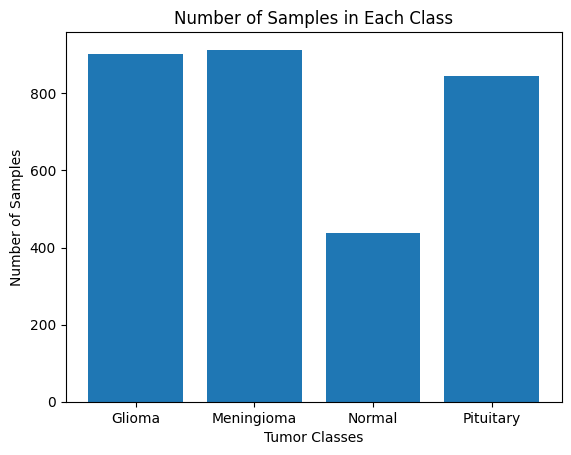

In [ ]:
# Bar plot to visualize the number of samples
classes = ['Glioma', 'Meningioma', 'Normal', 'Pituitary']
samples = [num_glioma_samples, num_meningioma_samples, num_normal_samples, num_pituitary_samples]

plt.bar(classes, samples)
plt.xlabel('Tumor Classes')
plt.ylabel('Number of Samples')
plt.title('Number of Samples in Each Class')
plt.show()

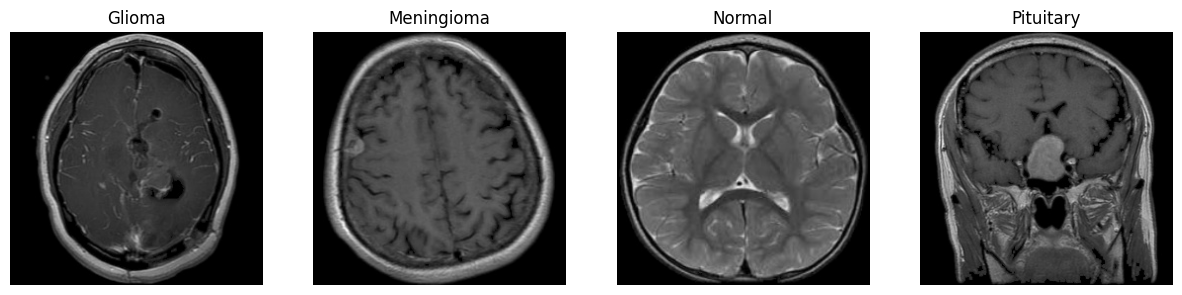

In [ ]:
# Display images of all four classes
# Define paths to sample images for each class
sample_glioma = os.path.join(glioma_dir, os.listdir(glioma_dir)[0])
sample_meningioma = os.path.join(meningioma_dir, os.listdir(meningioma_dir)[0])
sample_normal = os.path.join(normal_dir, os.listdir(normal_dir)[0])
sample_pituitary = os.path.join(pituitary_dir, os.listdir(pituitary_dir)[0])

# Open and display sample images
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
axs[0].imshow(Image.open(sample_glioma))
axs[0].set_title('Glioma')
axs[0].axis('off')
axs[1].imshow(Image.open(sample_meningioma))
axs[1].set_title('Meningioma')
axs[1].axis('off')
axs[2].imshow(Image.open(sample_normal))
axs[2].set_title('Normal')
axs[2].axis('off')
axs[3].imshow(Image.open(sample_pituitary))
axs[3].set_title('Pituitary')
axs[3].axis('off')
plt.show()

**<font size="4">Split Data</font>**

In [ ]:
# Define split ratios
train_ratio = 0.7
test_ratio = 0.2
val_ratio = 0.1

In [ ]:
# A function to split data files into train, validation, and test folders
def split_data(source_dir, train_dir, test_dir, val_dir, train_ratio, test_ratio, val_ratio):
    files = os.listdir(source_dir)
    random.shuffle(files)
    total_files = len(files)

    train_split = int(train_ratio * total_files)
    test_split = int(test_ratio * total_files)
    val_split = int(val_ratio * total_files)

    train_files = files[:train_split]
    test_files = files[train_split:(train_split + test_split)]
    val_files = files[(train_split + test_split):]

    for file in train_files:
        src_file = os.path.join(source_dir, file)
        dst_file = os.path.join(train_dir, file)
        if os.path.isfile(src_file):
            shutil.copy(src_file, dst_file)

    for file in test_files:
        src_file = os.path.join(source_dir, file)
        dst_file = os.path.join(test_dir, file)
        if os.path.isfile(src_file):
            shutil.copy(src_file, dst_file)

    for file in val_files:
        src_file = os.path.join(source_dir, file)
        dst_file = os.path.join(val_dir, file)
        if os.path.isfile(src_file):
            shutil.copy(src_file, dst_file)

In [ ]:
# Split the data
split_data(glioma_dir, os.path.join(train_dir, 'glioma_tumor'), os.path.join(test_dir, 'glioma_tumor'), os.path.join(val_dir, 'glioma_tumor'), train_ratio, test_ratio, val_ratio)
split_data(meningioma_dir, os.path.join(train_dir, 'meningioma_tumor'), os.path.join(test_dir, 'meningioma_tumor'), os.path.join(val_dir, 'meningioma_tumor'), train_ratio, test_ratio, val_ratio)
split_data(normal_dir, os.path.join(train_dir, 'normal'), os.path.join(test_dir, 'normal'), os.path.join(val_dir, 'normal'), train_ratio, test_ratio, val_ratio)
split_data(pituitary_dir, os.path.join(train_dir, 'pituitary_tumor'), os.path.join(test_dir, 'pituitary_tumor'), os.path.join(val_dir, 'pituitary_tumor'), train_ratio, test_ratio, val_ratio)

In [ ]:
# A function to count the number of files in a directory
def count_samples_in_directory(directory):
    return len(os.listdir(directory))

In [ ]:
# Count the number of samples in each class and the entire dataset after splitting
train_glioma_samples = count_samples_in_directory(os.path.join(train_dir, 'glioma_tumor'))
test_glioma_samples = count_samples_in_directory(os.path.join(test_dir, 'glioma_tumor'))
val_glioma_samples = count_samples_in_directory(os.path.join(val_dir, 'glioma_tumor'))

train_meningioma_samples = count_samples_in_directory(os.path.join(train_dir, 'meningioma_tumor'))
test_meningioma_samples = count_samples_in_directory(os.path.join(test_dir, 'meningioma_tumor'))
val_meningioma_samples = count_samples_in_directory(os.path.join(val_dir, 'meningioma_tumor'))

train_normal_samples = count_samples_in_directory(os.path.join(train_dir, 'normal'))
test_normal_samples = count_samples_in_directory(os.path.join(test_dir, 'normal'))
val_normal_samples = count_samples_in_directory(os.path.join(val_dir, 'normal'))

train_pituitary_samples = count_samples_in_directory(os.path.join(train_dir, 'pituitary_tumor'))
test_pituitary_samples = count_samples_in_directory(os.path.join(test_dir, 'pituitary_tumor'))
val_pituitary_samples = count_samples_in_directory(os.path.join(val_dir, 'pituitary_tumor'))

# Total samples in each class
total_glioma_samples = train_glioma_samples + test_glioma_samples + val_glioma_samples
total_meningioma_samples = train_meningioma_samples + test_meningioma_samples + val_meningioma_samples
total_normal_samples = train_normal_samples + test_normal_samples + val_normal_samples
total_pituitary_samples = train_pituitary_samples + test_pituitary_samples + val_pituitary_samples

# Total samples in the entire dataset
total_samples = total_glioma_samples + total_meningioma_samples + total_normal_samples + total_pituitary_samples

# Display counts
print("Glioma Samples:")
print(f"Train: {train_glioma_samples}, Test: {test_glioma_samples}, Validation: {val_glioma_samples}, Total: {total_glioma_samples}")
print("\nMeningioma Samples:")
print(f"Train: {train_meningioma_samples}, Test: {test_meningioma_samples}, Validation: {val_meningioma_samples}, Total: {total_meningioma_samples}")
print("\nNormal Samples:")
print(f"Train: {train_normal_samples}, Test: {test_normal_samples}, Validation: {val_normal_samples}, Total: {total_normal_samples}")
print("\nPituitary Samples:")
print(f"Train: {train_pituitary_samples}, Test: {test_pituitary_samples}, Validation: {val_pituitary_samples}, Total: {total_pituitary_samples}")
print("\nTotal Samples in the Entire Dataset:", total_samples)

Glioma Samples:
Train: 630, Test: 180, Validation: 91, Total: 901

Meningioma Samples:
Train: 639, Test: 182, Validation: 92, Total: 913

Normal Samples:
Train: 306, Test: 87, Validation: 45, Total: 438

Pituitary Samples:
Train: 590, Test: 168, Validation: 86, Total: 844

Total Samples in the Entire Dataset: 3096


In [ ]:
# A function that plots the distribution of classes of the split data
def plot_sample_distribution(train_samples, val_samples, test_samples, classes):
      # Number of classes
      num_classes = len(classes)

      # Create arrays for the number of samples in each split
      train_counts = [train_samples[class_name] for class_name in classes]
      val_counts = [val_samples[class_name] for class_name in classes]
      test_counts = [test_samples[class_name] for class_name in classes]

      # Create an array of class labels
      x = range(num_classes)

      # Width of a bar
      bar_width = 0.2

      # Create the bar chart
      plt.bar(x, train_counts, bar_width, label='Train', align='center', alpha=0.8)
      plt.bar([i + bar_width for i in x], val_counts, bar_width, label='Validation', align='center', alpha=0.8)
      plt.bar([i + bar_width * 2 for i in x], test_counts, bar_width, label='Test', align='center', alpha=0.8)

      # Set the x-axis labels
      plt.xticks([i + bar_width for i in x], classes, rotation=45)

      # Add labels, title, and legend
      plt.xlabel('Classes')
      plt.ylabel('Number of Samples')
      plt.title('Sample Distribution by Class and Split')
      plt.legend(loc='upper right')

      # Show the plot
      plt.tight_layout()
      plt.show()

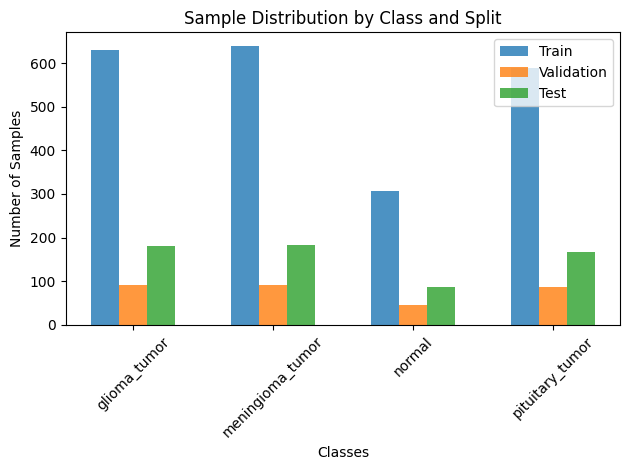

In [ ]:
# Implementation
classes = ['glioma_tumor', 'meningioma_tumor', 'normal', 'pituitary_tumor']
train_samples = {
    'glioma_tumor': train_glioma_samples,
    'meningioma_tumor': train_meningioma_samples,
    'normal': train_normal_samples,
    'pituitary_tumor': train_pituitary_samples
}
val_samples = {
    'glioma_tumor': val_glioma_samples,
    'meningioma_tumor': val_meningioma_samples,
    'normal': val_normal_samples,
    'pituitary_tumor': val_pituitary_samples
}
test_samples = {
    'glioma_tumor': test_glioma_samples,
    'meningioma_tumor': test_meningioma_samples,
    'normal': test_normal_samples,
    'pituitary_tumor': test_pituitary_samples
}

plot_sample_distribution(train_samples, val_samples, test_samples, classes)

In [ ]:
# Randomly check image shape

# Define base directory
base_dir = '/content/brain-tumors-256x256/Data'

# Define subdirectories within train, test, and val
split_subdirectories = ['train', 'test', 'val']

# Randomly select a split directory
selected_split = random.choice(split_subdirectories)

# Define class subdirectories
class_subdirectories = ['glioma_tumor', 'meningioma_tumor', 'normal', 'pituitary_tumor']

# Randomly select a class subdirectory
selected_class = random.choice(class_subdirectories)

# Construct path to the selected image directory
image_dir = os.path.join(base_dir, selected_split, selected_class)

# Check if selected subdirectory exists
if os.path.exists(image_dir):
    # List all image files in the selected image directory
    image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

    # Randomly select an image file
    if image_files:
        random_image_file = random.choice(image_files)

        # Load randomly selected image
        image = mpimg.imread(random_image_file)

        # Get shape of the image
        image_shape = image.shape
        print(f"Image Shape: {image_shape}")
    else:
        print("No image files found in the selected subdirectory.")
else:
    print(f"The selected subdirectory does not exist: {image_dir}")

Image Shape: (256, 256, 3)


In [ ]:
# View image as an array
image

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

**<font size="4">Feature Scaling: Normalization Check</font>**

In [ ]:
# Define a function to check normalization

def is_directory_normalized(directory_path):
    """Checks if all images in a directory have been normalized.

      Args:
        directory_path: The path to the directory containing the images.

      Returns:
        True if all images in the directory have been normalized, False otherwise.
    """

    # Iterate through all of the images in the directory
    for filename in os.listdir(directory_path):

        # Check if the file is an image
        if filename.endswith(".jpg") or filename.endswith(".png"):

            # Calculate the mean and standard deviation of the image
            image_path = os.path.join(directory_path, filename)
            image = cv2.imread(image_path)
            mean = np.mean(image)
            std = np.std(image)

            # Check if the mean and standard deviation are close to zero and one
            if abs(mean) >= 0.1 or abs(std - 1.0) >= 0.1:
                return False

    # If all of the images in the directory are normalized, return True
    return True

In [ ]:
# Check if all images in the train directory are normalized
is_train_dir_normalized = is_directory_normalized(train_dir)

# Check if all images in the validation directory are normalized
is_val_dir_normalized = is_directory_normalized(val_dir)

# Check if all images in the test directory are normalized
is_test_dir_normalized = is_directory_normalized(test_dir)

# If any of the directories are not normalized, print an error message
if not is_train_dir_normalized or not is_val_dir_normalized or not is_test_dir_normalized:
  print("One or more directories are not normalized.")
  exit(1)

# If all of the directories are normalized, print a success message
print("All directories are normalized.")

All directories are normalized.


# **Data Pre-processing**


In [ ]:
# Define data transformations for training
train_transforms = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.75, 1.3333)),
    transforms.ToTensor(),
])



# Define data transformations for validation and test
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [ ]:
# Create datasets
train_dataset = ImageFolder(train_dir, transform=train_transforms)
val_dataset = ImageFolder(val_dir, transform=val_transforms)
test_dataset = ImageFolder(test_dir, transform=val_transforms)

In [ ]:
# Check shape of first samples
assert train_dataset[0][0].shape == val_dataset[0][0].shape == test_dataset[0][0].shape

display(
    train_dataset[0][0].shape,
    val_dataset[0][0].shape,
    test_dataset[0][0].shape
)

torch.Size([3, 224, 224])

torch.Size([3, 224, 224])

torch.Size([3, 224, 224])

In [ ]:
# Create a sampler to balance class distribution
sampler = ImbalancedDatasetSampler(train_dataset)

# Set batch size
batch_size = 32

# Create a train Loader using the sampler
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, pin_memory=True, shuffle=False)

# Create Dataloaders for val and test data
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
# Iterate through train, val, and test data loaders and print the shape of images and labels
for data_loader, name in [(train_loader, 'Train'), (val_loader, 'Validation'), (test_loader, 'Test')]:
    for images, labels in data_loader:
        print(f"{name} Image shape: {images.shape}, Label Shape: {labels.shape}")
        break

Train Image shape: torch.Size([32, 3, 224, 224]), Label Shape: torch.Size([32])
Validation Image shape: torch.Size([32, 3, 224, 224]), Label Shape: torch.Size([32])
Test Image shape: torch.Size([32, 3, 224, 224]), Label Shape: torch.Size([32])


# **Models Development**

## **<font size="4">Summary Class</font>**

In [ ]:
class ModelSummary:
    def __init__(self, model):
        self.model = model

    def __str__(self):
        model_summary = str(self.model) + "\n\n"
        total_trainable_params = 0
        total_frozen_params = 0

        for name, parameter in self.model.named_parameters():
            if parameter.requires_grad:
                total_trainable_params += parameter.numel()
                status = "Trainable"
            else:
                total_frozen_params += parameter.numel()
                status = "Frozen"

            model_summary += f"Layer: {name}, Parameters: {parameter.numel()}, Status: {status}\n"

        model_summary += f"Total Trainable Parameters: {total_trainable_params}\n"
        model_summary += f"Total Frozen Parameters: {total_frozen_params}"

        return model_summary

## **<font size="4">Train Class</font>**

In [ ]:
class Trainer:
    def __init__(self, model, train_loader, val_loader, criterion=None, optimizer=None, device="cuda", num_epochs=100, patience=5, min_delta=0.001, model_name=None, verbose=False):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion.to(device)
        self.optimizer = optimizer
        self.device = device
        self.num_epochs = num_epochs
        self.patience = patience
        self.min_delta = min_delta
        self.model_name = model_name
        self.verbose = verbose
        self.train_acc_history = []
        self.val_acc_history = []
        self.train_loss_history = []
        self.val_loss_history = []


    def train(self, verbose=False):
            best_val_loss = float('inf')
            early_stopping_counter = 0
            start_time = time.time()

            for epoch in range(self.num_epochs):
                total_correct = 0
                total_samples = 0
                total_loss = 0.0

                if self.verbose:
                    train_data_loader = tqdm(self.train_loader, position=0)
                else:
                    train_data_loader = self.train_loader

                for batch_idx, (inputs, labels) in enumerate(train_data_loader):
                    inputs, labels = inputs.to(self.device), labels.to(self.device)
                    self.optimizer.zero_grad()
                    outputs = self.model(inputs)
                    loss = self.criterion(outputs, labels)
                    loss.backward()
                    self.optimizer.step()

                    _, predicted = outputs.max(1)
                    total_samples += labels.size(0)
                    total_correct += (predicted == labels).sum().item()
                    total_loss += loss.item()

                    train_accuracy = total_correct / total_samples
                    train_loss = total_loss / total_samples
                    self.train_acc_history.append(train_accuracy)
                    self.train_loss_history.append(train_loss)

                    if self.verbose:
                        description = f'Epoch [{epoch + 1}/{self.num_epochs}], Batch [{batch_idx + 1}/{len(train_data_loader)}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy * 100:.2f}%'
                        train_data_loader.set_description(description, refresh=True)

                if self.verbose:
                    train_data_loader.close()

                total_correct_val = 0
                total_samples_val = 0
                total_loss_val = 0.0

                # Validation phase
                self.model.eval()


                with torch.no_grad():
                    if self.verbose:
                        val_data_loader = tqdm(self.val_loader, position=0)
                    else:
                        val_data_loader = self.val_loader

                    for batch_idx, (inputs, labels) in enumerate(val_data_loader):
                        inputs, labels = inputs.to(self.device), labels.to(self.device)
                        outputs = self.model(inputs)
                        loss = self.criterion(outputs, labels)
                        total_loss_val += loss.item()

                        _, predicted = outputs.max(1)
                        total_samples_val += labels.size(0)
                        total_correct_val += (predicted == labels).sum().item()

                        val_accuracy = total_correct_val / total_samples_val
                        val_loss = total_loss_val / total_samples_val
                        self.val_acc_history.append(val_accuracy)
                        self.val_loss_history.append(val_loss)

                        if self.verbose:
                            description = f'Epoch [{epoch + 1}/{self.num_epochs}], Batch [{batch_idx + 1}/{len(val_data_loader)}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy * 100:.2f}%'
                            val_data_loader.set_description(description, refresh=True)

                    if self.verbose:
                        val_data_loader.close()

                if val_loss < best_val_loss - self.min_delta:
                    best_val_loss = val_loss
                    early_stopping_counter = 0
                else:
                    early_stopping_counter += 1


                if early_stopping_counter >= self.patience:
                    print("Early stopping triggered. No improvement for {} epochs.".format(self.patience))
                    break

            print("\nTraining completed!")
            end_time = time.time()
            training_time = end_time - start_time
            print(f"Training took {self.format_time(training_time)}\n")

            # Save model
            model_save_path = f'{self.model_name}.pth'
            self.save_model(model_save_path)
            print(f"Model saved at {model_save_path}")




    def train_one_epoch(self, epoch, verbose=None):
        self.model.train()
        if verbose is not None:
            self.verbose = verbose

        total_correct = 0
        total_samples = 0
        total_loss = 0.0

        # Training phase
        if self.verbose:
            train_data_loader = tqdm(self.train_loader, position=0)
        else:
            train_data_loader = self.train_loader

        for batch_idx, (inputs, labels) in enumerate(train_data_loader):
            inputs, labels = inputs.to(self.device), labels.to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            _, predicted = outputs.max(1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            total_loss += loss.item()

            train_accuracy = total_correct / total_samples
            train_loss = total_loss / total_samples
            self.train_acc_history.append(train_accuracy)
            self.train_loss_history.append(train_loss)

            if self.verbose:
                description = f'Epoch [{epoch + 1}/{self.num_epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy * 100:.2f}%'
                train_data_loader.set_description(description, refresh=True)

        if self.verbose:
            train_data_loader.close()

        total_correct_val = 0
        total_samples_val = 0
        total_loss_val = 0.0

        # Validation phase
        if self.verbose:
            val_data_loader = self.val_loader
        else:
            val_data_loader = self.val_loader

        # Set model to evaluation mode
        self.model.eval()

        with torch.no_grad():
            for batch_idx, (inputs, labels) in enumerate(val_data_loader):
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                total_loss_val += loss.item()

                _, predicted = outputs.max(1)
                total_samples_val += labels.size(0)
                total_correct_val += (predicted == labels).sum().item()

            val_accuracy = total_correct_val / total_samples_val
            val_loss = total_loss_val / total_samples_val
            self.val_acc_history.append(val_accuracy)
            self.val_loss_history.append(val_loss)

            if self.verbose:
                description = f'Epoch [{epoch + 1}/{self.num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy * 100:.2f}%'
                print(description)



    def save_model(self, save_path):
        torch.save(self.model.state_dict(), save_path)


    def format_time(self, seconds):
        minutes, seconds = divmod(seconds, 60)
        hours, minutes = divmod(minutes, 60)
        return f"{int(hours)} hours, {int(minutes)} minutes, {int(seconds)} seconds"


## **<font size="4">Training Curve Class</font>**

In [ ]:
class TrainCurvePlotter:
    def __init__(self, train_history_file):
        self.train_history_file = train_history_file
        self.train_loss = None
        self.train_acc = None
        self.val_loss = None
        self.val_acc = None
        self.num_epochs = None

    def load_training_history(self):
        with open(self.train_history_file, 'rb') as file:
            history = pickle.load(file)
            self.train_loss = history['train_loss_history']
            self.train_acc = history['train_acc_history']
            self.val_loss = history['val_loss_history']
            self.val_acc = history['val_acc_history']
            train_batches_per_epoch = 68
            val_batches_per_epoch = 10
            self.num_epochs = len(self.train_loss) // train_batches_per_epoch

    def plot(self):
        # Load the training history data
        self.load_training_history()

        train_batches_per_epoch = 68
        val_batches_per_epoch = 10

        # Calculate mean loss and accuracy values per epoch
        train_losses = [np.mean(self.train_loss[i:i+train_batches_per_epoch]) for i in range(0, len(self.train_loss), train_batches_per_epoch)]
        train_accuracies = [np.mean(self.train_acc[i:i+train_batches_per_epoch]) for i in range(0, len(self.train_acc), train_batches_per_epoch)]
        val_losses = [np.mean(self.val_loss[i:i+val_batches_per_epoch]) for i in range(0, len(self.val_loss), val_batches_per_epoch)]
        val_accuracies = [np.mean(self.val_acc[i:i+val_batches_per_epoch]) for i in range(0, len(self.val_acc), val_batches_per_epoch)]

        # Create an epoch range based on the number of epochs
        epochs = range(1, self.num_epochs + 1)

        # Plot training loss and accuracy
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_losses, label='Training Loss')
        plt.plot(epochs, val_losses, label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, train_accuracies, label='Training Accuracy')
        plt.plot(epochs, val_accuracies, label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.legend()

        plt.tight_layout()
        plt.show()

## **<font size="4">Evaluate Model Class</font>**

In [ ]:
class ModelEvaluator:
    def __init__(self, model, dataloader, device):
        self.model = model
        self.dataloader = dataloader
        self.device = device

    def evaluate(self):
        self.model.eval()

        total_correct = 0
        total_samples = 0

        for inputs, labels in self.dataloader:
            inputs, labels = inputs.to(self.device), labels.to(self.device)
            outputs = self.model(inputs)

            _, predicted = outputs.max(1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()

        accuracy = total_correct / total_samples

        return accuracy

## **<font size="4">Cross Validation & Hyperparameters Tuning Class</font>**

In [ ]:
class CrossValidatedHyperparameterTuner:
    def __init__(self, model_class, train_loader, model_param_grid, trainer_param_grid,
                 num_folds=5, device='cuda' if torch.cuda.is_available() else 'cpu', verbose=False):
        self.model_class = model_class
        self.train_loader = train_loader
        self.model_param_grid = model_param_grid
        self.trainer_param_grid = trainer_param_grid
        self.device = device
        self.num_folds = num_folds
        self.verbose = verbose

        self.best_accuracy = 0
        self.best_std = float('inf')
        self.best_params = {}
        self.best_model = None

    def tune(self):
        # Create Stratified K-Fold object
        skf = StratifiedKFold(n_splits=self.num_folds, shuffle=True, random_state=42)

        # Iterate over the model hyperparameter grid
        for model_params in ParameterGrid(self.model_param_grid):
            # Iterate over the trainer hyperparameter grid
            for trainer_params in ParameterGrid(self.trainer_param_grid):
                # Create a list to store fold accuracies
                fold_accuracies = []

                # Train the model on each fold
                for fold, (train_index, val_index) in enumerate(skf.split(range(len(self.train_loader.dataset.targets)), y=self.train_loader.dataset.targets)):

                    # Create a train loader for the current fold
                    fold_train_loader = DataLoader(
                        dataset=self.train_loader.dataset,
                        batch_size=self.train_loader.batch_size,
                        sampler=SubsetRandomSampler(train_index),
                        shuffle=False
                    )

                    # Create a validation loader for the current fold
                    fold_val_loader = DataLoader(
                        dataset=self.train_loader.dataset,
                        batch_size=self.train_loader.batch_size,
                        sampler=SubsetRandomSampler(val_index),
                        shuffle=False
                    )

                    # Print the fold number
                    print(f"Fold: {fold + 1}")

                    # Create a new model instance with the current model hyperparameters
                    model = self.model_class(**model_params).to(self.device)

                    # Unpack the optimizer and its parameters from trainer_params
                    optimizer, optimizer_params = trainer_params['optimizer']

                    # Create the optimizer instance
                    optimizer_instance = optimizer(model.parameters(), **optimizer_params)

                    # Create a new Trainer instance
                    trainer = Trainer(
                        model=model,
                        train_loader=fold_train_loader,
                        val_loader=fold_val_loader,
                        criterion=nn.CrossEntropyLoss(weight=torch.Tensor(class_weights)).to(self.device),
                        optimizer=optimizer_instance,
                        device=self.device,
                        num_epochs=trainer_params['num_epochs'],
                        verbose=True,
                        )


                    # Create a fold iterator
                    fold_iterator = range(trainer_params['num_epochs'])

                    # Train the model using the training data for the current fold
                    for epoch in fold_iterator:
                        trainer.train_one_epoch(epoch, verbose=True)

                    # Evaluate the model on the validation set of the current fold
                    evaluator = ModelEvaluator(model=model, dataloader=fold_val_loader, device=self.device)
                    accuracy = evaluator.evaluate() * 100

                    # Print the fold accuracy
                    print(f"Fold {fold + 1} Accuracy: {accuracy:.2f}%")

                    # Append the fold accuracy to the list of fold accuracies
                    fold_accuracies.append(accuracy)

                # Calculate and print the mean and standard deviation of the fold accuracies
                mean = np.mean(fold_accuracies)
                std = np.std(fold_accuracies)

                # Calculate a score that combines mean accuracy and standard deviation
                # Higher score for higher mean accuracy and lower standard deviation
                score = mean - std

                print(f"Model Parameters: {model_params}, Trainer Parameters: {trainer_params}")
                print(f"Fold Accuracies: {fold_accuracies}")
                print(f"Mean Accuracy: {mean:.2f}%, Std Accuracy: {std:.2f}, Score: {score:.2f}")

                if mean > self.best_accuracy or (mean == self.best_accuracy and std < self.best_std):
                    self.best_accuracy = mean
                    self.best_std = std
                    self.best_params = (model_params, trainer_params)
                    self.best_model = model



        print("Best hyperparameters:", self.best_params)
        print("Best mean accuracy:", self.best_accuracy)
        print("Best standard deviation:", self.best_std)
        print("Best model:", self.best_model)

## **<font size="4">Model Predictor Class</font>**

In [ ]:
class ModelPredictor:
    def __init__(self, model, dataloader, device):
        self.model = model
        self.dataloader = dataloader
        self.device = device

    def predict(self):
        predictions = []
        true_labels = []

        with torch.no_grad():
            for inputs, labels in self.dataloader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                predicted = outputs.argmax(dim=1)

                predictions.extend(predicted.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())

        predictions = np.array(predictions)
        true_labels = np.array(true_labels)

        return predictions, true_labels


    def plot_predictions(self):
        predictions, true_labels = self.predict()

        # Create a grouped bar chart
        classes = np.unique(true_labels)
        class_labels = [str(cls) for cls in classes]

        width = 0.35
        ind = np.arange(len(classes))

        true_counts = [0] * len(classes)
        predicted_counts = [0] * len(classes)

        for true, pred in zip(true_labels, predictions):
            true_counts[true] += 1
            predicted_counts[pred] += 1

        fig, ax = plt.subplots(figsize=(10, 6))
        p1 = ax.bar(ind - width / 2, true_counts, width, label='True Labels')
        p2 = ax.bar(ind + width / 2, predicted_counts, width, label='Predicted Labels')

        ax.set_xlabel('Classes')
        ax.set_ylabel('Counts')
        ax.set_title('True vs. Predicted Labels')
        ax.set_xticks(ind)
        ax.set_xticklabels(class_labels)
        ax.legend()

        # Annotate the bars with counts
        for i in range(len(classes)):
            ax.annotate(str(true_counts[i]), (ind[i] - width / 2, true_counts[i] + 1), ha='center', color='blue')
            ax.annotate(str(predicted_counts[i]), (ind[i] + width / 2, predicted_counts[i] + 1), ha='center', color='orange')

        plt.show()


## **<font size="4">Model Performance Class</font>**

In [ ]:
class PerformanceMetrics:
    def __init__(self, true_labels, predicted_labels, class_names):
        self.true_labels = true_labels
        self.predicted_labels = predicted_labels
        self.class_names = class_names

    def calculate_accuracy(self):
        accuracy = accuracy_score(self.true_labels, self.predicted_labels)
        return accuracy * 100

    def calculate_confusion_matrix(self):
        return confusion_matrix(self.true_labels, self.predicted_labels)

    def calculate_specificity(self):
        conf_matrix = self.calculate_confusion_matrix()
        true_negatives = conf_matrix[0, 0]
        false_positives = conf_matrix[0, 1]
        specificity = true_negatives / (true_negatives + false_positives) * 100
        return specificity

    def calculate_sensitivity(self):
        conf_matrix = self.calculate_confusion_matrix()
        true_positives = conf_matrix[1, 1]
        false_negatives = conf_matrix[1, 0]
        sensitivity = true_positives / (true_positives + false_negatives) * 100
        return sensitivity

    def calculate_precision(self):
        conf_matrix = self.calculate_confusion_matrix()
        true_positives = conf_matrix[1, 1]
        false_positives = conf_matrix[0, 1]
        precision = true_positives / (true_positives + false_positives) * 100
        return precision

    def generate_classification_report(self):
        return classification_report(self.true_labels, self.predicted_labels, target_names=self.class_names)

    def plot_heatmap(self):
        conf_matrix = self.calculate_confusion_matrix()
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu", xticklabels=self.class_names, yticklabels=self.class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix Heatmap')
        plt.show()

In [ ]:
# Set the random seed for Python's built-in random module
random.seed(0)

# Set the random seed for NumPy
np.random.seed(0)

# Set the random seed for PyTorch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Calculate class weights based on the distribution of samples
class_counts = [train_dataset.targets.count(c) for c in range(len(classes))]
total_samples = sum(class_counts)
class_weights = [total_samples / (count * len(classes)) for count in class_counts]

## **Baseline Model**

**<font size="4">Setting up Model Architecture</font>**

In [ ]:
class BaseNet(nn.Module):
    def __init__(self, num_classes=4, conv1_out_channels=32, conv2_out_channels=64, conv3_out_channels=128,
                 fc1_out_features=256, dropout_prob=0.5):
        super(BaseNet, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, conv1_out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(conv1_out_channels, conv2_out_channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(conv2_out_channels, conv3_out_channels, kernel_size=3, padding=1)

        # Pooling layers
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(conv3_out_channels * (224 // (2**3)) * (224 // (2**3)), fc1_out_features)
        self.fc2 = nn.Linear(fc1_out_features, num_classes)

        # Dropout layers
        self.dropout1 = nn.Dropout(dropout_prob)
        self.dropout2 = nn.Dropout(dropout_prob)

    def forward(self, x):
        # Convolutional layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Flatten the feature map
        x = x.view(-1, self.conv3.out_channels * (224 // (2**3)) * (224 // (2**3)))

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.dropout2(x)

        return x

**<font size="4">Getting Model Summary</font>**

In [ ]:
# Define baseline model
baseline_model = BaseNet()

# Instantiate ModelSummary class
model_summary = ModelSummary(baseline_model)

# Display model summary
print(model_summary)

BaseNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=4, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
)

Layer: conv1.weight, Parameters: 864, Status: Trainable
Layer: conv1.bias, Parameters: 32, Status: Trainable
Layer: conv2.weight, Parameters: 18432, Status: Trainable
Layer: conv2.bias, Parameters: 64, Status: Trainable
Layer: conv3.weight, Parameters: 73728, Status: Trainable
Layer: conv3.bias, Parameters: 128, Status: Trainable
Layer: fc1.weight, Parameters: 25690112, Status: Trainable
Layer: fc1.bias, Parameters: 256, Status: Trainable
Layer: fc2.weigh

**<font size="4">Cross Validation & Hyperparameter Tuning</font>**

In [ ]:
# Define hyperparameter grids
model_param_grid = {
    #'conv1_out_channels': [64, 128],
    #'conv2_out_channels': [128, 256],
    'fc1_out_features': [256, 512],
    'dropout_prob': [0.5, 0.7],
}

trainer_param_grid = {
    'num_epochs': [10, 20],
    'optimizer': [(torch.optim.Adam, {'lr': 0.0001}), (torch.optim.SGD, {'lr': 0.0001})],
}

# Instantiate CrossValidatedHyperparameterTuner class
cv_tuner = CrossValidatedHyperparameterTuner(
    model_class=BaseNet,
    train_loader=train_loader,
    model_param_grid=model_param_grid,
    trainer_param_grid=trainer_param_grid,
    num_folds=5,
    verbose=True,
)

# Tune model and trainer parameters while performing cross-validation
cv_tuner.tune()

Fold: 1


Epoch [1/10], Training Loss: 0.0438, Training Accuracy: 29.68%: 100%|██████████| 55/55 [00:13<00:00,  4.02it/s]


Epoch [1/10], Validation Loss: 0.0432, Validation Accuracy: 45.73%


Epoch [2/10], Training Loss: 0.0419, Training Accuracy: 34.99%: 100%|██████████| 55/55 [00:13<00:00,  4.01it/s]


Epoch [2/10], Validation Loss: 0.0403, Validation Accuracy: 50.58%


Epoch [3/10], Training Loss: 0.0408, Training Accuracy: 38.05%: 100%|██████████| 55/55 [00:13<00:00,  4.00it/s]


Epoch [3/10], Validation Loss: 0.0407, Validation Accuracy: 47.58%


Epoch [4/10], Training Loss: 0.0396, Training Accuracy: 38.74%: 100%|██████████| 55/55 [00:13<00:00,  3.93it/s]


Epoch [4/10], Validation Loss: 0.0362, Validation Accuracy: 57.51%


Epoch [5/10], Training Loss: 0.0390, Training Accuracy: 41.17%: 100%|██████████| 55/55 [00:13<00:00,  4.04it/s]


Epoch [5/10], Validation Loss: 0.0365, Validation Accuracy: 54.50%


Epoch [6/10], Training Loss: 0.0380, Training Accuracy: 43.30%: 100%|██████████| 55/55 [00:13<00:00,  4.02it/s]


Epoch [6/10], Validation Loss: 0.0353, Validation Accuracy: 54.04%


Epoch [7/10], Training Loss: 0.0378, Training Accuracy: 43.36%: 100%|██████████| 55/55 [00:13<00:00,  4.03it/s]


Epoch [7/10], Validation Loss: 0.0338, Validation Accuracy: 60.97%


Epoch [8/10], Training Loss: 0.0373, Training Accuracy: 43.88%: 100%|██████████| 55/55 [00:13<00:00,  4.02it/s]


Epoch [8/10], Validation Loss: 0.0341, Validation Accuracy: 59.82%


Epoch [9/10], Training Loss: 0.0360, Training Accuracy: 47.75%: 100%|██████████| 55/55 [00:13<00:00,  4.05it/s]


Epoch [9/10], Validation Loss: 0.0326, Validation Accuracy: 61.43%


Epoch [10/10], Training Loss: 0.0356, Training Accuracy: 47.52%: 100%|██████████| 55/55 [00:13<00:00,  4.03it/s]


Epoch [10/10], Validation Loss: 0.0318, Validation Accuracy: 62.12%
Fold 1 Accuracy: 63.28%
Fold: 2


Epoch [1/10], Training Loss: 0.0435, Training Accuracy: 29.56%: 100%|██████████| 55/55 [00:13<00:00,  4.00it/s]


Epoch [1/10], Validation Loss: 0.0423, Validation Accuracy: 37.88%


Epoch [2/10], Training Loss: 0.0416, Training Accuracy: 35.22%: 100%|██████████| 55/55 [00:13<00:00,  4.05it/s]


Epoch [2/10], Validation Loss: 0.0393, Validation Accuracy: 46.19%


Epoch [3/10], Training Loss: 0.0407, Training Accuracy: 39.15%: 100%|██████████| 55/55 [00:13<00:00,  4.06it/s]


Epoch [3/10], Validation Loss: 0.0381, Validation Accuracy: 50.81%


Epoch [4/10], Training Loss: 0.0397, Training Accuracy: 38.80%: 100%|██████████| 55/55 [00:13<00:00,  4.03it/s]


Epoch [4/10], Validation Loss: 0.0372, Validation Accuracy: 54.50%


Epoch [5/10], Training Loss: 0.0389, Training Accuracy: 41.80%: 100%|██████████| 55/55 [00:13<00:00,  4.04it/s]


Epoch [5/10], Validation Loss: 0.0357, Validation Accuracy: 57.74%


Epoch [6/10], Training Loss: 0.0380, Training Accuracy: 44.75%: 100%|██████████| 55/55 [00:13<00:00,  4.02it/s]


Epoch [6/10], Validation Loss: 0.0378, Validation Accuracy: 48.50%


Epoch [7/10], Training Loss: 0.0376, Training Accuracy: 44.46%: 100%|██████████| 55/55 [00:13<00:00,  4.00it/s]


Epoch [7/10], Validation Loss: 0.0335, Validation Accuracy: 57.04%


Epoch [8/10], Training Loss: 0.0366, Training Accuracy: 46.07%: 100%|██████████| 55/55 [00:13<00:00,  4.03it/s]


Epoch [8/10], Validation Loss: 0.0328, Validation Accuracy: 62.59%


Epoch [9/10], Training Loss: 0.0372, Training Accuracy: 46.48%: 100%|██████████| 55/55 [00:13<00:00,  4.06it/s]


Epoch [9/10], Validation Loss: 0.0338, Validation Accuracy: 60.51%


Epoch [10/10], Training Loss: 0.0359, Training Accuracy: 47.81%: 100%|██████████| 55/55 [00:13<00:00,  4.03it/s]


Epoch [10/10], Validation Loss: 0.0326, Validation Accuracy: 61.89%
Fold 2 Accuracy: 60.74%
Fold: 3


Epoch [1/10], Training Loss: 0.0432, Training Accuracy: 29.50%: 100%|██████████| 55/55 [00:13<00:00,  4.03it/s]


Epoch [1/10], Validation Loss: 0.0421, Validation Accuracy: 39.72%


Epoch [2/10], Training Loss: 0.0412, Training Accuracy: 35.51%: 100%|██████████| 55/55 [00:13<00:00,  4.06it/s]


Epoch [2/10], Validation Loss: 0.0402, Validation Accuracy: 42.03%


Epoch [3/10], Training Loss: 0.0407, Training Accuracy: 38.34%: 100%|██████████| 55/55 [00:13<00:00,  4.00it/s]


Epoch [3/10], Validation Loss: 0.0396, Validation Accuracy: 45.27%


Epoch [4/10], Training Loss: 0.0404, Training Accuracy: 37.53%: 100%|██████████| 55/55 [00:13<00:00,  4.04it/s]


Epoch [4/10], Validation Loss: 0.0390, Validation Accuracy: 50.58%


Epoch [5/10], Training Loss: 0.0394, Training Accuracy: 41.40%: 100%|██████████| 55/55 [00:13<00:00,  4.01it/s]


Epoch [5/10], Validation Loss: 0.0378, Validation Accuracy: 52.66%


Epoch [6/10], Training Loss: 0.0394, Training Accuracy: 38.97%: 100%|██████████| 55/55 [00:13<00:00,  4.08it/s]


Epoch [6/10], Validation Loss: 0.0375, Validation Accuracy: 51.73%


Epoch [7/10], Training Loss: 0.0384, Training Accuracy: 42.26%: 100%|██████████| 55/55 [00:13<00:00,  4.03it/s]


Epoch [7/10], Validation Loss: 0.0370, Validation Accuracy: 55.66%


Epoch [8/10], Training Loss: 0.0379, Training Accuracy: 44.00%: 100%|██████████| 55/55 [00:13<00:00,  4.06it/s]


Epoch [8/10], Validation Loss: 0.0361, Validation Accuracy: 54.50%


Epoch [9/10], Training Loss: 0.0374, Training Accuracy: 44.80%: 100%|██████████| 55/55 [00:13<00:00,  4.05it/s]


Epoch [9/10], Validation Loss: 0.0345, Validation Accuracy: 55.89%


Epoch [10/10], Training Loss: 0.0373, Training Accuracy: 42.03%: 100%|██████████| 55/55 [00:13<00:00,  4.06it/s]


Epoch [10/10], Validation Loss: 0.0347, Validation Accuracy: 48.73%
Fold 3 Accuracy: 51.96%
Fold: 4


Epoch [1/10], Training Loss: 0.0435, Training Accuracy: 30.95%: 100%|██████████| 55/55 [00:13<00:00,  4.05it/s]


Epoch [1/10], Validation Loss: 0.0418, Validation Accuracy: 48.27%


Epoch [2/10], Training Loss: 0.0410, Training Accuracy: 39.15%: 100%|██████████| 55/55 [00:13<00:00,  4.08it/s]


Epoch [2/10], Validation Loss: 0.0399, Validation Accuracy: 42.96%


Epoch [3/10], Training Loss: 0.0403, Training Accuracy: 39.03%: 100%|██████████| 55/55 [00:13<00:00,  4.04it/s]


Epoch [3/10], Validation Loss: 0.0394, Validation Accuracy: 47.58%


Epoch [4/10], Training Loss: 0.0397, Training Accuracy: 40.01%: 100%|██████████| 55/55 [00:13<00:00,  4.05it/s]


Epoch [4/10], Validation Loss: 0.0377, Validation Accuracy: 49.65%


Epoch [5/10], Training Loss: 0.0394, Training Accuracy: 42.90%: 100%|██████████| 55/55 [00:13<00:00,  4.03it/s]


Epoch [5/10], Validation Loss: 0.0359, Validation Accuracy: 55.89%


Epoch [6/10], Training Loss: 0.0386, Training Accuracy: 42.90%: 100%|██████████| 55/55 [00:13<00:00,  4.07it/s]


Epoch [6/10], Validation Loss: 0.0355, Validation Accuracy: 49.42%


Epoch [7/10], Training Loss: 0.0379, Training Accuracy: 44.52%: 100%|██████████| 55/55 [00:13<00:00,  4.02it/s]


Epoch [7/10], Validation Loss: 0.0350, Validation Accuracy: 54.27%


Epoch [8/10], Training Loss: 0.0380, Training Accuracy: 42.73%: 100%|██████████| 55/55 [00:13<00:00,  4.09it/s]


Epoch [8/10], Validation Loss: 0.0344, Validation Accuracy: 62.36%


Epoch [9/10], Training Loss: 0.0371, Training Accuracy: 46.54%: 100%|██████████| 55/55 [00:13<00:00,  4.03it/s]


Epoch [9/10], Validation Loss: 0.0325, Validation Accuracy: 59.82%


Epoch [10/10], Training Loss: 0.0367, Training Accuracy: 46.77%: 100%|██████████| 55/55 [00:13<00:00,  4.07it/s]


Epoch [10/10], Validation Loss: 0.0328, Validation Accuracy: 58.89%
Fold 4 Accuracy: 60.97%
Fold: 5


Epoch [1/10], Training Loss: 0.0436, Training Accuracy: 30.31%: 100%|██████████| 55/55 [00:13<00:00,  4.07it/s]


Epoch [1/10], Validation Loss: 0.0422, Validation Accuracy: 36.03%


Epoch [2/10], Training Loss: 0.0419, Training Accuracy: 35.80%: 100%|██████████| 55/55 [00:13<00:00,  4.05it/s]


Epoch [2/10], Validation Loss: 0.0399, Validation Accuracy: 50.35%


Epoch [3/10], Training Loss: 0.0400, Training Accuracy: 41.17%: 100%|██████████| 55/55 [00:13<00:00,  4.05it/s]


Epoch [3/10], Validation Loss: 0.0386, Validation Accuracy: 48.73%


Epoch [4/10], Training Loss: 0.0397, Training Accuracy: 40.30%: 100%|██████████| 55/55 [00:13<00:00,  4.02it/s]


Epoch [4/10], Validation Loss: 0.0382, Validation Accuracy: 51.73%


Epoch [5/10], Training Loss: 0.0390, Training Accuracy: 42.03%: 100%|██████████| 55/55 [00:13<00:00,  4.06it/s]


Epoch [5/10], Validation Loss: 0.0364, Validation Accuracy: 54.97%


Epoch [6/10], Training Loss: 0.0378, Training Accuracy: 44.00%: 100%|██████████| 55/55 [00:13<00:00,  4.04it/s]


Epoch [6/10], Validation Loss: 0.0357, Validation Accuracy: 53.12%


Epoch [7/10], Training Loss: 0.0378, Training Accuracy: 44.92%: 100%|██████████| 55/55 [00:13<00:00,  4.10it/s]


Epoch [7/10], Validation Loss: 0.0352, Validation Accuracy: 57.04%


Epoch [8/10], Training Loss: 0.0374, Training Accuracy: 44.00%: 100%|██████████| 55/55 [00:13<00:00,  4.02it/s]


Epoch [8/10], Validation Loss: 0.0345, Validation Accuracy: 54.50%


Epoch [9/10], Training Loss: 0.0371, Training Accuracy: 45.27%: 100%|██████████| 55/55 [00:13<00:00,  4.06it/s]


Epoch [9/10], Validation Loss: 0.0334, Validation Accuracy: 57.04%


Epoch [10/10], Training Loss: 0.0359, Training Accuracy: 47.06%: 100%|██████████| 55/55 [00:13<00:00,  4.07it/s]


Epoch [10/10], Validation Loss: 0.0324, Validation Accuracy: 60.74%
Fold 5 Accuracy: 57.97%
Model Parameters: {'dropout_prob': 0.5, 'fc1_out_features': 256}, Trainer Parameters: {'num_epochs': 10, 'optimizer': (<class 'torch.optim.adam.Adam'>, {'lr': 0.0001})}
Fold Accuracies: [63.279445727482674, 60.739030023094685, 51.96304849884527, 60.969976905311775, 57.96766743648961]
Mean Accuracy: 58.98%, Std Accuracy: 3.89, Score: 55.09
Fold: 1


Epoch [1/10], Training Loss: 0.0441, Training Accuracy: 27.89%: 100%|██████████| 55/55 [00:13<00:00,  4.19it/s]


Epoch [1/10], Validation Loss: 0.0448, Validation Accuracy: 28.41%


Epoch [2/10], Training Loss: 0.0440, Training Accuracy: 27.48%: 100%|██████████| 55/55 [00:13<00:00,  4.17it/s]


Epoch [2/10], Validation Loss: 0.0448, Validation Accuracy: 28.87%


Epoch [3/10], Training Loss: 0.0441, Training Accuracy: 27.77%: 100%|██████████| 55/55 [00:13<00:00,  4.20it/s]


Epoch [3/10], Validation Loss: 0.0448, Validation Accuracy: 28.87%


Epoch [4/10], Training Loss: 0.0441, Training Accuracy: 26.67%: 100%|██████████| 55/55 [00:13<00:00,  4.07it/s]


Epoch [4/10], Validation Loss: 0.0448, Validation Accuracy: 28.64%


Epoch [5/10], Training Loss: 0.0441, Training Accuracy: 27.77%: 100%|██████████| 55/55 [00:13<00:00,  4.21it/s]


Epoch [5/10], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [6/10], Training Loss: 0.0440, Training Accuracy: 28.29%: 100%|██████████| 55/55 [00:13<00:00,  4.13it/s]


Epoch [6/10], Validation Loss: 0.0448, Validation Accuracy: 30.48%


Epoch [7/10], Training Loss: 0.0440, Training Accuracy: 28.75%: 100%|██████████| 55/55 [00:13<00:00,  4.19it/s]


Epoch [7/10], Validation Loss: 0.0448, Validation Accuracy: 29.79%


Epoch [8/10], Training Loss: 0.0440, Training Accuracy: 29.97%: 100%|██████████| 55/55 [00:13<00:00,  4.15it/s]


Epoch [8/10], Validation Loss: 0.0448, Validation Accuracy: 33.72%


Epoch [9/10], Training Loss: 0.0440, Training Accuracy: 27.48%: 100%|██████████| 55/55 [00:13<00:00,  4.21it/s]


Epoch [9/10], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [10/10], Training Loss: 0.0440, Training Accuracy: 27.66%: 100%|██████████| 55/55 [00:13<00:00,  4.11it/s]


Epoch [10/10], Validation Loss: 0.0448, Validation Accuracy: 29.33%
Fold 1 Accuracy: 30.25%
Fold: 2


Epoch [1/10], Training Loss: 0.0440, Training Accuracy: 29.50%: 100%|██████████| 55/55 [00:13<00:00,  4.22it/s]


Epoch [1/10], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [2/10], Training Loss: 0.0440, Training Accuracy: 30.72%: 100%|██████████| 55/55 [00:13<00:00,  4.14it/s]


Epoch [2/10], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [3/10], Training Loss: 0.0440, Training Accuracy: 28.93%: 100%|██████████| 55/55 [00:13<00:00,  4.20it/s]


Epoch [3/10], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [4/10], Training Loss: 0.0440, Training Accuracy: 29.45%: 100%|██████████| 55/55 [00:13<00:00,  4.11it/s]


Epoch [4/10], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [5/10], Training Loss: 0.0441, Training Accuracy: 27.77%: 100%|██████████| 55/55 [00:13<00:00,  4.21it/s]


Epoch [5/10], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [6/10], Training Loss: 0.0440, Training Accuracy: 29.45%: 100%|██████████| 55/55 [00:13<00:00,  4.15it/s]


Epoch [6/10], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [7/10], Training Loss: 0.0439, Training Accuracy: 30.72%: 100%|██████████| 55/55 [00:13<00:00,  4.21it/s]


Epoch [7/10], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [8/10], Training Loss: 0.0440, Training Accuracy: 29.04%: 100%|██████████| 55/55 [00:13<00:00,  4.12it/s]


Epoch [8/10], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [9/10], Training Loss: 0.0440, Training Accuracy: 28.23%: 100%|██████████| 55/55 [00:13<00:00,  4.20it/s]


Epoch [9/10], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [10/10], Training Loss: 0.0440, Training Accuracy: 29.56%: 100%|██████████| 55/55 [00:13<00:00,  4.10it/s]


Epoch [10/10], Validation Loss: 0.0448, Validation Accuracy: 29.10%
Fold 2 Accuracy: 29.10%
Fold: 3


Epoch [1/10], Training Loss: 0.0441, Training Accuracy: 25.69%: 100%|██████████| 55/55 [00:13<00:00,  4.18it/s]


Epoch [1/10], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [2/10], Training Loss: 0.0441, Training Accuracy: 25.12%: 100%|██████████| 55/55 [00:13<00:00,  4.19it/s]


Epoch [2/10], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [3/10], Training Loss: 0.0440, Training Accuracy: 25.35%: 100%|██████████| 55/55 [00:13<00:00,  4.17it/s]


Epoch [3/10], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [4/10], Training Loss: 0.0440, Training Accuracy: 24.08%: 100%|██████████| 55/55 [00:13<00:00,  4.20it/s]


Epoch [4/10], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [5/10], Training Loss: 0.0440, Training Accuracy: 25.98%: 100%|██████████| 55/55 [00:13<00:00,  4.16it/s]


Epoch [5/10], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [6/10], Training Loss: 0.0440, Training Accuracy: 24.36%: 100%|██████████| 55/55 [00:13<00:00,  4.21it/s]


Epoch [6/10], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [7/10], Training Loss: 0.0440, Training Accuracy: 23.85%: 100%|██████████| 55/55 [00:13<00:00,  4.13it/s]


Epoch [7/10], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [8/10], Training Loss: 0.0440, Training Accuracy: 25.06%: 100%|██████████| 55/55 [00:13<00:00,  4.20it/s]


Epoch [8/10], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [9/10], Training Loss: 0.0440, Training Accuracy: 23.09%: 100%|██████████| 55/55 [00:13<00:00,  4.13it/s]


Epoch [9/10], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [10/10], Training Loss: 0.0440, Training Accuracy: 22.17%: 100%|██████████| 55/55 [00:13<00:00,  4.19it/s]


Epoch [10/10], Validation Loss: 0.0448, Validation Accuracy: 14.09%
Fold 3 Accuracy: 14.09%
Fold: 4


Epoch [1/10], Training Loss: 0.0440, Training Accuracy: 21.42%: 100%|██████████| 55/55 [00:13<00:00,  4.15it/s]


Epoch [1/10], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [2/10], Training Loss: 0.0441, Training Accuracy: 20.61%: 100%|██████████| 55/55 [00:13<00:00,  4.21it/s]


Epoch [2/10], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [3/10], Training Loss: 0.0440, Training Accuracy: 22.75%: 100%|██████████| 55/55 [00:13<00:00,  4.15it/s]


Epoch [3/10], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [4/10], Training Loss: 0.0440, Training Accuracy: 21.65%: 100%|██████████| 55/55 [00:13<00:00,  4.18it/s]


Epoch [4/10], Validation Loss: 0.0448, Validation Accuracy: 14.32%


Epoch [5/10], Training Loss: 0.0440, Training Accuracy: 23.50%: 100%|██████████| 55/55 [00:13<00:00,  4.13it/s]


Epoch [5/10], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [6/10], Training Loss: 0.0440, Training Accuracy: 22.11%: 100%|██████████| 55/55 [00:13<00:00,  4.20it/s]


Epoch [6/10], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [7/10], Training Loss: 0.0440, Training Accuracy: 21.82%: 100%|██████████| 55/55 [00:13<00:00,  4.15it/s]


Epoch [7/10], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [8/10], Training Loss: 0.0440, Training Accuracy: 22.17%: 100%|██████████| 55/55 [00:13<00:00,  4.21it/s]


Epoch [8/10], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [9/10], Training Loss: 0.0440, Training Accuracy: 22.40%: 100%|██████████| 55/55 [00:13<00:00,  4.13it/s]


Epoch [9/10], Validation Loss: 0.0447, Validation Accuracy: 14.09%


Epoch [10/10], Training Loss: 0.0440, Training Accuracy: 21.82%: 100%|██████████| 55/55 [00:13<00:00,  4.21it/s]


Epoch [10/10], Validation Loss: 0.0448, Validation Accuracy: 14.09%
Fold 4 Accuracy: 13.86%
Fold: 5


Epoch [1/10], Training Loss: 0.0440, Training Accuracy: 29.16%: 100%|██████████| 55/55 [00:13<00:00,  4.16it/s]


Epoch [1/10], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [2/10], Training Loss: 0.0440, Training Accuracy: 29.33%: 100%|██████████| 55/55 [00:13<00:00,  4.21it/s]


Epoch [2/10], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [3/10], Training Loss: 0.0440, Training Accuracy: 31.00%: 100%|██████████| 55/55 [00:13<00:00,  4.17it/s]


Epoch [3/10], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [4/10], Training Loss: 0.0440, Training Accuracy: 28.64%: 100%|██████████| 55/55 [00:13<00:00,  4.20it/s]


Epoch [4/10], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [5/10], Training Loss: 0.0440, Training Accuracy: 29.97%: 100%|██████████| 55/55 [00:13<00:00,  4.14it/s]


Epoch [5/10], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [6/10], Training Loss: 0.0440, Training Accuracy: 29.10%: 100%|██████████| 55/55 [00:13<00:00,  4.20it/s]


Epoch [6/10], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [7/10], Training Loss: 0.0440, Training Accuracy: 28.12%: 100%|██████████| 55/55 [00:13<00:00,  4.19it/s]


Epoch [7/10], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [8/10], Training Loss: 0.0440, Training Accuracy: 30.60%: 100%|██████████| 55/55 [00:13<00:00,  4.18it/s]


Epoch [8/10], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [9/10], Training Loss: 0.0440, Training Accuracy: 29.27%: 100%|██████████| 55/55 [00:13<00:00,  4.14it/s]


Epoch [9/10], Validation Loss: 0.0448, Validation Accuracy: 29.33%


Epoch [10/10], Training Loss: 0.0440, Training Accuracy: 29.97%: 100%|██████████| 55/55 [00:13<00:00,  4.20it/s]


Epoch [10/10], Validation Loss: 0.0448, Validation Accuracy: 30.25%
Fold 5 Accuracy: 30.02%
Model Parameters: {'dropout_prob': 0.5, 'fc1_out_features': 256}, Trainer Parameters: {'num_epochs': 10, 'optimizer': (<class 'torch.optim.sgd.SGD'>, {'lr': 0.0001})}
Fold Accuracies: [30.2540415704388, 29.099307159353348, 14.087759815242496, 13.856812933025402, 30.023094688221708]
Mean Accuracy: 23.46%, Std Accuracy: 7.76, Score: 15.70
Fold: 1


Epoch [1/20], Training Loss: 0.0433, Training Accuracy: 29.68%: 100%|██████████| 55/55 [00:13<00:00,  3.99it/s]


Epoch [1/20], Validation Loss: 0.0422, Validation Accuracy: 40.65%


Epoch [2/20], Training Loss: 0.0414, Training Accuracy: 36.32%: 100%|██████████| 55/55 [00:13<00:00,  4.06it/s]


Epoch [2/20], Validation Loss: 0.0403, Validation Accuracy: 48.04%


Epoch [3/20], Training Loss: 0.0402, Training Accuracy: 39.20%: 100%|██████████| 55/55 [00:13<00:00,  4.03it/s]


Epoch [3/20], Validation Loss: 0.0379, Validation Accuracy: 55.66%


Epoch [4/20], Training Loss: 0.0394, Training Accuracy: 41.63%: 100%|██████████| 55/55 [00:13<00:00,  4.12it/s]


Epoch [4/20], Validation Loss: 0.0373, Validation Accuracy: 57.04%


Epoch [5/20], Training Loss: 0.0386, Training Accuracy: 42.38%: 100%|██████████| 55/55 [00:13<00:00,  4.06it/s]


Epoch [5/20], Validation Loss: 0.0354, Validation Accuracy: 57.04%


Epoch [6/20], Training Loss: 0.0376, Training Accuracy: 42.96%: 100%|██████████| 55/55 [00:13<00:00,  4.06it/s]


Epoch [6/20], Validation Loss: 0.0342, Validation Accuracy: 58.20%


Epoch [7/20], Training Loss: 0.0369, Training Accuracy: 45.73%: 100%|██████████| 55/55 [00:13<00:00,  4.06it/s]


Epoch [7/20], Validation Loss: 0.0339, Validation Accuracy: 57.51%


Epoch [8/20], Training Loss: 0.0366, Training Accuracy: 46.54%: 100%|██████████| 55/55 [00:13<00:00,  4.05it/s]


Epoch [8/20], Validation Loss: 0.0335, Validation Accuracy: 58.89%


Epoch [9/20], Training Loss: 0.0356, Training Accuracy: 47.17%: 100%|██████████| 55/55 [00:13<00:00,  4.06it/s]


Epoch [9/20], Validation Loss: 0.0334, Validation Accuracy: 55.20%


Epoch [10/20], Training Loss: 0.0359, Training Accuracy: 45.67%: 100%|██████████| 55/55 [00:13<00:00,  4.00it/s]


Epoch [10/20], Validation Loss: 0.0317, Validation Accuracy: 60.51%


Epoch [11/20], Training Loss: 0.0350, Training Accuracy: 49.02%: 100%|██████████| 55/55 [00:13<00:00,  4.07it/s]


Epoch [11/20], Validation Loss: 0.0319, Validation Accuracy: 59.82%


Epoch [12/20], Training Loss: 0.0349, Training Accuracy: 46.59%: 100%|██████████| 55/55 [00:13<00:00,  4.05it/s]


Epoch [12/20], Validation Loss: 0.0298, Validation Accuracy: 63.97%


Epoch [13/20], Training Loss: 0.0341, Training Accuracy: 48.79%: 100%|██████████| 55/55 [00:13<00:00,  4.10it/s]


Epoch [13/20], Validation Loss: 0.0304, Validation Accuracy: 61.43%


Epoch [14/20], Training Loss: 0.0342, Training Accuracy: 48.56%: 100%|██████████| 55/55 [00:13<00:00,  4.07it/s]


Epoch [14/20], Validation Loss: 0.0299, Validation Accuracy: 63.74%


Epoch [15/20], Training Loss: 0.0344, Training Accuracy: 49.08%: 100%|██████████| 55/55 [00:13<00:00,  4.09it/s]


Epoch [15/20], Validation Loss: 0.0290, Validation Accuracy: 63.97%


Epoch [16/20], Training Loss: 0.0334, Training Accuracy: 49.25%: 100%|██████████| 55/55 [00:13<00:00,  4.05it/s]


Epoch [16/20], Validation Loss: 0.0286, Validation Accuracy: 67.44%


Epoch [17/20], Training Loss: 0.0332, Training Accuracy: 51.33%: 100%|██████████| 55/55 [00:13<00:00,  4.08it/s]


Epoch [17/20], Validation Loss: 0.0286, Validation Accuracy: 62.59%


Epoch [18/20], Training Loss: 0.0330, Training Accuracy: 51.79%: 100%|██████████| 55/55 [00:13<00:00,  4.05it/s]


Epoch [18/20], Validation Loss: 0.0285, Validation Accuracy: 64.67%


Epoch [19/20], Training Loss: 0.0321, Training Accuracy: 50.64%: 100%|██████████| 55/55 [00:13<00:00,  4.11it/s]


Epoch [19/20], Validation Loss: 0.0273, Validation Accuracy: 64.67%


Epoch [20/20], Training Loss: 0.0321, Training Accuracy: 52.66%: 100%|██████████| 55/55 [00:13<00:00,  4.01it/s]


Epoch [20/20], Validation Loss: 0.0281, Validation Accuracy: 61.66%
Fold 1 Accuracy: 65.59%
Fold: 2


Epoch [1/20], Training Loss: 0.0433, Training Accuracy: 29.21%: 100%|██████████| 55/55 [00:13<00:00,  4.09it/s]


Epoch [1/20], Validation Loss: 0.0420, Validation Accuracy: 44.80%


Epoch [2/20], Training Loss: 0.0408, Training Accuracy: 37.59%: 100%|██████████| 55/55 [00:13<00:00,  4.01it/s]


Epoch [2/20], Validation Loss: 0.0405, Validation Accuracy: 48.96%


Epoch [3/20], Training Loss: 0.0416, Training Accuracy: 35.16%: 100%|██████████| 55/55 [00:13<00:00,  4.07it/s]


Epoch [3/20], Validation Loss: 0.0401, Validation Accuracy: 50.35%


Epoch [4/20], Training Loss: 0.0397, Training Accuracy: 40.47%: 100%|██████████| 55/55 [00:13<00:00,  4.03it/s]


Epoch [4/20], Validation Loss: 0.0378, Validation Accuracy: 52.66%


Epoch [5/20], Training Loss: 0.0387, Training Accuracy: 42.09%: 100%|██████████| 55/55 [00:13<00:00,  4.09it/s]


Epoch [5/20], Validation Loss: 0.0361, Validation Accuracy: 54.73%


Epoch [6/20], Training Loss: 0.0386, Training Accuracy: 41.92%: 100%|██████████| 55/55 [00:13<00:00,  4.03it/s]


Epoch [6/20], Validation Loss: 0.0356, Validation Accuracy: 54.04%


Epoch [7/20], Training Loss: 0.0384, Training Accuracy: 42.32%: 100%|██████████| 55/55 [00:13<00:00,  4.10it/s]


Epoch [7/20], Validation Loss: 0.0361, Validation Accuracy: 49.88%


Epoch [8/20], Training Loss: 0.0376, Training Accuracy: 44.75%: 100%|██████████| 55/55 [00:13<00:00,  4.05it/s]


Epoch [8/20], Validation Loss: 0.0346, Validation Accuracy: 57.27%


Epoch [9/20], Training Loss: 0.0369, Training Accuracy: 44.69%: 100%|██████████| 55/55 [00:13<00:00,  4.09it/s]


Epoch [9/20], Validation Loss: 0.0338, Validation Accuracy: 61.43%


Epoch [10/20], Training Loss: 0.0364, Training Accuracy: 43.94%: 100%|██████████| 55/55 [00:13<00:00,  4.04it/s]


Epoch [10/20], Validation Loss: 0.0334, Validation Accuracy: 55.66%


Epoch [11/20], Training Loss: 0.0356, Training Accuracy: 46.94%: 100%|██████████| 55/55 [00:13<00:00,  4.06it/s]


Epoch [11/20], Validation Loss: 0.0328, Validation Accuracy: 57.51%


Epoch [12/20], Training Loss: 0.0362, Training Accuracy: 46.94%: 100%|██████████| 55/55 [00:13<00:00,  4.09it/s]


Epoch [12/20], Validation Loss: 0.0312, Validation Accuracy: 61.66%


Epoch [13/20], Training Loss: 0.0346, Training Accuracy: 47.92%: 100%|██████████| 55/55 [00:13<00:00,  4.04it/s]


Epoch [13/20], Validation Loss: 0.0299, Validation Accuracy: 65.36%


Epoch [14/20], Training Loss: 0.0345, Training Accuracy: 47.86%: 100%|██████████| 55/55 [00:13<00:00,  4.04it/s]


Epoch [14/20], Validation Loss: 0.0292, Validation Accuracy: 64.43%


Epoch [15/20], Training Loss: 0.0344, Training Accuracy: 48.27%: 100%|██████████| 55/55 [00:13<00:00,  3.97it/s]


Epoch [15/20], Validation Loss: 0.0298, Validation Accuracy: 62.59%


Epoch [16/20], Training Loss: 0.0335, Training Accuracy: 50.69%: 100%|██████████| 55/55 [00:13<00:00,  4.08it/s]


Epoch [16/20], Validation Loss: 0.0270, Validation Accuracy: 68.82%


Epoch [17/20], Training Loss: 0.0339, Training Accuracy: 50.06%: 100%|██████████| 55/55 [00:13<00:00,  4.06it/s]


Epoch [17/20], Validation Loss: 0.0275, Validation Accuracy: 68.59%


Epoch [18/20], Training Loss: 0.0338, Training Accuracy: 49.19%: 100%|██████████| 55/55 [00:13<00:00,  4.05it/s]


Epoch [18/20], Validation Loss: 0.0280, Validation Accuracy: 69.05%


Epoch [19/20], Training Loss: 0.0346, Training Accuracy: 48.09%: 100%|██████████| 55/55 [00:13<00:00,  4.04it/s]


Epoch [19/20], Validation Loss: 0.0302, Validation Accuracy: 62.12%


Epoch [20/20], Training Loss: 0.0326, Training Accuracy: 51.91%: 100%|██████████| 55/55 [00:13<00:00,  4.10it/s]


Epoch [20/20], Validation Loss: 0.0274, Validation Accuracy: 67.21%
Fold 2 Accuracy: 68.13%
Fold: 3


Epoch [1/20], Training Loss: 0.0436, Training Accuracy: 29.91%: 100%|██████████| 55/55 [00:13<00:00,  3.96it/s]


Epoch [1/20], Validation Loss: 0.0426, Validation Accuracy: 35.57%


Epoch [2/20], Training Loss: 0.0418, Training Accuracy: 35.74%: 100%|██████████| 55/55 [00:13<00:00,  4.05it/s]


Epoch [2/20], Validation Loss: 0.0405, Validation Accuracy: 46.65%


Epoch [3/20], Training Loss: 0.0401, Training Accuracy: 41.34%: 100%|██████████| 55/55 [00:13<00:00,  4.04it/s]


Epoch [3/20], Validation Loss: 0.0399, Validation Accuracy: 50.81%


Epoch [4/20], Training Loss: 0.0402, Training Accuracy: 37.30%: 100%|██████████| 55/55 [00:13<00:00,  4.08it/s]


Epoch [4/20], Validation Loss: 0.0377, Validation Accuracy: 51.96%


Epoch [5/20], Training Loss: 0.0390, Training Accuracy: 41.80%: 100%|██████████| 55/55 [00:13<00:00,  3.98it/s]


Epoch [5/20], Validation Loss: 0.0381, Validation Accuracy: 53.58%


Epoch [6/20], Training Loss: 0.0384, Training Accuracy: 40.76%: 100%|██████████| 55/55 [00:13<00:00,  4.06it/s]


Epoch [6/20], Validation Loss: 0.0368, Validation Accuracy: 50.58%


Epoch [7/20], Training Loss: 0.0388, Training Accuracy: 41.92%: 100%|██████████| 55/55 [00:13<00:00,  3.99it/s]


Epoch [7/20], Validation Loss: 0.0361, Validation Accuracy: 54.27%


Epoch [8/20], Training Loss: 0.0383, Training Accuracy: 40.94%: 100%|██████████| 55/55 [00:13<00:00,  4.02it/s]


Epoch [8/20], Validation Loss: 0.0353, Validation Accuracy: 55.43%


Epoch [9/20], Training Loss: 0.0366, Training Accuracy: 46.54%: 100%|██████████| 55/55 [00:13<00:00,  3.99it/s]


Epoch [9/20], Validation Loss: 0.0349, Validation Accuracy: 54.97%


Epoch [10/20], Training Loss: 0.0364, Training Accuracy: 45.21%: 100%|██████████| 55/55 [00:13<00:00,  4.06it/s]


Epoch [10/20], Validation Loss: 0.0330, Validation Accuracy: 57.27%


Epoch [11/20], Training Loss: 0.0359, Training Accuracy: 46.30%: 100%|██████████| 55/55 [00:13<00:00,  4.04it/s]


Epoch [11/20], Validation Loss: 0.0332, Validation Accuracy: 57.51%


Epoch [12/20], Training Loss: 0.0360, Training Accuracy: 46.71%: 100%|██████████| 55/55 [00:13<00:00,  3.98it/s]


Epoch [12/20], Validation Loss: 0.0320, Validation Accuracy: 60.28%


Epoch [13/20], Training Loss: 0.0353, Training Accuracy: 47.00%: 100%|██████████| 55/55 [00:13<00:00,  3.96it/s]


Epoch [13/20], Validation Loss: 0.0316, Validation Accuracy: 57.97%


Epoch [14/20], Training Loss: 0.0360, Training Accuracy: 46.36%: 100%|██████████| 55/55 [00:13<00:00,  4.09it/s]


Epoch [14/20], Validation Loss: 0.0339, Validation Accuracy: 60.97%


Epoch [15/20], Training Loss: 0.0348, Training Accuracy: 49.08%: 100%|██████████| 55/55 [00:13<00:00,  4.04it/s]


Epoch [15/20], Validation Loss: 0.0305, Validation Accuracy: 60.97%


Epoch [16/20], Training Loss: 0.0342, Training Accuracy: 48.04%: 100%|██████████| 55/55 [00:14<00:00,  3.89it/s]


Epoch [16/20], Validation Loss: 0.0305, Validation Accuracy: 64.90%


Epoch [17/20], Training Loss: 0.0345, Training Accuracy: 49.42%: 100%|██████████| 55/55 [00:14<00:00,  3.84it/s]


Epoch [17/20], Validation Loss: 0.0309, Validation Accuracy: 58.89%


Epoch [18/20], Training Loss: 0.0335, Training Accuracy: 50.00%: 100%|██████████| 55/55 [00:13<00:00,  3.95it/s]


Epoch [18/20], Validation Loss: 0.0292, Validation Accuracy: 65.82%


Epoch [19/20], Training Loss: 0.0337, Training Accuracy: 48.44%: 100%|██████████| 55/55 [00:13<00:00,  3.95it/s]


Epoch [19/20], Validation Loss: 0.0298, Validation Accuracy: 61.43%


Epoch [20/20], Training Loss: 0.0342, Training Accuracy: 48.21%: 100%|██████████| 55/55 [00:14<00:00,  3.79it/s]


Epoch [20/20], Validation Loss: 0.0291, Validation Accuracy: 65.13%
Fold 3 Accuracy: 67.67%
Fold: 4


Epoch [1/20], Training Loss: 0.0434, Training Accuracy: 27.14%: 100%|██████████| 55/55 [00:14<00:00,  3.84it/s]


Epoch [1/20], Validation Loss: 0.0423, Validation Accuracy: 39.95%


Epoch [2/20], Training Loss: 0.0415, Training Accuracy: 35.10%: 100%|██████████| 55/55 [00:14<00:00,  3.77it/s]


Epoch [2/20], Validation Loss: 0.0399, Validation Accuracy: 43.19%


Epoch [3/20], Training Loss: 0.0406, Training Accuracy: 37.88%: 100%|██████████| 55/55 [00:14<00:00,  3.75it/s]


Epoch [3/20], Validation Loss: 0.0380, Validation Accuracy: 48.27%


Epoch [4/20], Training Loss: 0.0394, Training Accuracy: 42.38%: 100%|██████████| 55/55 [00:14<00:00,  3.84it/s]


Epoch [4/20], Validation Loss: 0.0366, Validation Accuracy: 51.27%


Epoch [5/20], Training Loss: 0.0387, Training Accuracy: 42.21%: 100%|██████████| 55/55 [00:14<00:00,  3.82it/s]


Epoch [5/20], Validation Loss: 0.0360, Validation Accuracy: 56.12%


Epoch [6/20], Training Loss: 0.0380, Training Accuracy: 42.03%: 100%|██████████| 55/55 [00:14<00:00,  3.92it/s]


Epoch [6/20], Validation Loss: 0.0353, Validation Accuracy: 58.66%


Epoch [7/20], Training Loss: 0.0370, Training Accuracy: 45.27%: 100%|██████████| 55/55 [00:14<00:00,  3.86it/s]


Epoch [7/20], Validation Loss: 0.0334, Validation Accuracy: 58.89%


Epoch [8/20], Training Loss: 0.0373, Training Accuracy: 45.55%: 100%|██████████| 55/55 [00:13<00:00,  3.97it/s]


Epoch [8/20], Validation Loss: 0.0341, Validation Accuracy: 53.81%


Epoch [9/20], Training Loss: 0.0365, Training Accuracy: 44.80%: 100%|██████████| 55/55 [00:14<00:00,  3.90it/s]


Epoch [9/20], Validation Loss: 0.0322, Validation Accuracy: 61.43%


Epoch [10/20], Training Loss: 0.0354, Training Accuracy: 46.36%: 100%|██████████| 55/55 [00:13<00:00,  3.97it/s]


Epoch [10/20], Validation Loss: 0.0307, Validation Accuracy: 62.59%


Epoch [11/20], Training Loss: 0.0351, Training Accuracy: 47.23%: 100%|██████████| 55/55 [00:14<00:00,  3.89it/s]


Epoch [11/20], Validation Loss: 0.0321, Validation Accuracy: 60.51%


Epoch [12/20], Training Loss: 0.0351, Training Accuracy: 47.46%: 100%|██████████| 55/55 [00:14<00:00,  3.91it/s]


Epoch [12/20], Validation Loss: 0.0310, Validation Accuracy: 61.89%


Epoch [13/20], Training Loss: 0.0351, Training Accuracy: 47.00%: 100%|██████████| 55/55 [00:14<00:00,  3.85it/s]


Epoch [13/20], Validation Loss: 0.0310, Validation Accuracy: 63.28%


Epoch [14/20], Training Loss: 0.0348, Training Accuracy: 48.44%: 100%|██████████| 55/55 [00:14<00:00,  3.90it/s]


Epoch [14/20], Validation Loss: 0.0300, Validation Accuracy: 66.28%


Epoch [15/20], Training Loss: 0.0347, Training Accuracy: 48.04%: 100%|██████████| 55/55 [00:14<00:00,  3.86it/s]


Epoch [15/20], Validation Loss: 0.0281, Validation Accuracy: 62.82%


Epoch [16/20], Training Loss: 0.0340, Training Accuracy: 48.96%: 100%|██████████| 55/55 [00:14<00:00,  3.91it/s]


Epoch [16/20], Validation Loss: 0.0284, Validation Accuracy: 64.43%


Epoch [17/20], Training Loss: 0.0339, Training Accuracy: 47.23%: 100%|██████████| 55/55 [00:14<00:00,  3.86it/s]


Epoch [17/20], Validation Loss: 0.0299, Validation Accuracy: 59.12%


Epoch [18/20], Training Loss: 0.0342, Training Accuracy: 48.96%: 100%|██████████| 55/55 [00:14<00:00,  3.86it/s]


Epoch [18/20], Validation Loss: 0.0290, Validation Accuracy: 61.89%


Epoch [19/20], Training Loss: 0.0329, Training Accuracy: 50.46%: 100%|██████████| 55/55 [00:14<00:00,  3.88it/s]


Epoch [19/20], Validation Loss: 0.0277, Validation Accuracy: 67.67%


Epoch [20/20], Training Loss: 0.0335, Training Accuracy: 50.75%: 100%|██████████| 55/55 [00:14<00:00,  3.81it/s]


Epoch [20/20], Validation Loss: 0.0263, Validation Accuracy: 67.90%
Fold 4 Accuracy: 63.28%
Fold: 5


Epoch [1/20], Training Loss: 0.0436, Training Accuracy: 30.72%: 100%|██████████| 55/55 [00:13<00:00,  3.99it/s]


Epoch [1/20], Validation Loss: 0.0423, Validation Accuracy: 44.34%


Epoch [2/20], Training Loss: 0.0416, Training Accuracy: 35.51%: 100%|██████████| 55/55 [00:14<00:00,  3.86it/s]


Epoch [2/20], Validation Loss: 0.0401, Validation Accuracy: 50.58%


Epoch [3/20], Training Loss: 0.0399, Training Accuracy: 41.69%: 100%|██████████| 55/55 [00:13<00:00,  3.98it/s]


Epoch [3/20], Validation Loss: 0.0385, Validation Accuracy: 47.11%


Epoch [4/20], Training Loss: 0.0393, Training Accuracy: 41.45%: 100%|██████████| 55/55 [00:14<00:00,  3.69it/s]


Epoch [4/20], Validation Loss: 0.0370, Validation Accuracy: 51.73%


Epoch [5/20], Training Loss: 0.0388, Training Accuracy: 43.36%: 100%|██████████| 55/55 [00:14<00:00,  3.88it/s]


Epoch [5/20], Validation Loss: 0.0367, Validation Accuracy: 55.43%


Epoch [6/20], Training Loss: 0.0377, Training Accuracy: 43.59%: 100%|██████████| 55/55 [00:14<00:00,  3.76it/s]


Epoch [6/20], Validation Loss: 0.0348, Validation Accuracy: 57.97%


Epoch [7/20], Training Loss: 0.0380, Training Accuracy: 44.52%: 100%|██████████| 55/55 [00:14<00:00,  3.83it/s]


Epoch [7/20], Validation Loss: 0.0346, Validation Accuracy: 59.35%


Epoch [8/20], Training Loss: 0.0368, Training Accuracy: 45.96%: 100%|██████████| 55/55 [00:14<00:00,  3.78it/s]


Epoch [8/20], Validation Loss: 0.0341, Validation Accuracy: 58.20%


Epoch [9/20], Training Loss: 0.0357, Training Accuracy: 46.88%: 100%|██████████| 55/55 [00:14<00:00,  3.74it/s]


Epoch [9/20], Validation Loss: 0.0328, Validation Accuracy: 62.82%


Epoch [10/20], Training Loss: 0.0358, Training Accuracy: 45.03%: 100%|██████████| 55/55 [00:14<00:00,  3.81it/s]


Epoch [10/20], Validation Loss: 0.0319, Validation Accuracy: 61.43%


Epoch [11/20], Training Loss: 0.0359, Training Accuracy: 45.90%: 100%|██████████| 55/55 [00:14<00:00,  3.74it/s]


Epoch [11/20], Validation Loss: 0.0320, Validation Accuracy: 58.20%


Epoch [12/20], Training Loss: 0.0350, Training Accuracy: 46.30%: 100%|██████████| 55/55 [00:14<00:00,  3.79it/s]


Epoch [12/20], Validation Loss: 0.0321, Validation Accuracy: 62.12%


Epoch [13/20], Training Loss: 0.0348, Training Accuracy: 47.81%: 100%|██████████| 55/55 [00:14<00:00,  3.77it/s]


Epoch [13/20], Validation Loss: 0.0319, Validation Accuracy: 60.51%


Epoch [14/20], Training Loss: 0.0347, Training Accuracy: 48.96%: 100%|██████████| 55/55 [00:14<00:00,  3.80it/s]


Epoch [14/20], Validation Loss: 0.0304, Validation Accuracy: 66.74%


Epoch [15/20], Training Loss: 0.0342, Training Accuracy: 49.31%: 100%|██████████| 55/55 [00:14<00:00,  3.75it/s]


Epoch [15/20], Validation Loss: 0.0297, Validation Accuracy: 65.36%


Epoch [16/20], Training Loss: 0.0343, Training Accuracy: 47.86%: 100%|██████████| 55/55 [00:14<00:00,  3.82it/s]


Epoch [16/20], Validation Loss: 0.0290, Validation Accuracy: 64.90%


Epoch [17/20], Training Loss: 0.0340, Training Accuracy: 48.50%: 100%|██████████| 55/55 [00:14<00:00,  3.73it/s]


Epoch [17/20], Validation Loss: 0.0279, Validation Accuracy: 67.67%


Epoch [18/20], Training Loss: 0.0337, Training Accuracy: 49.48%: 100%|██████████| 55/55 [00:13<00:00,  3.95it/s]


Epoch [18/20], Validation Loss: 0.0295, Validation Accuracy: 64.43%


Epoch [19/20], Training Loss: 0.0334, Training Accuracy: 49.60%: 100%|██████████| 55/55 [00:13<00:00,  3.99it/s]


Epoch [19/20], Validation Loss: 0.0291, Validation Accuracy: 62.12%


Epoch [20/20], Training Loss: 0.0336, Training Accuracy: 49.48%: 100%|██████████| 55/55 [00:14<00:00,  3.90it/s]


Epoch [20/20], Validation Loss: 0.0294, Validation Accuracy: 64.43%
Fold 5 Accuracy: 66.51%
Model Parameters: {'dropout_prob': 0.5, 'fc1_out_features': 256}, Trainer Parameters: {'num_epochs': 20, 'optimizer': (<class 'torch.optim.adam.Adam'>, {'lr': 0.0001})}
Fold Accuracies: [65.58891454965358, 68.12933025404158, 67.6674364896074, 63.279445727482674, 66.51270207852194]
Mean Accuracy: 66.24%, Std Accuracy: 1.72, Score: 64.51
Fold: 1


Epoch [1/20], Training Loss: 0.0441, Training Accuracy: 22.69%: 100%|██████████| 55/55 [00:13<00:00,  4.16it/s]


Epoch [1/20], Validation Loss: 0.0449, Validation Accuracy: 12.93%


Epoch [2/20], Training Loss: 0.0440, Training Accuracy: 26.10%: 100%|██████████| 55/55 [00:13<00:00,  4.05it/s]


Epoch [2/20], Validation Loss: 0.0448, Validation Accuracy: 13.86%


Epoch [3/20], Training Loss: 0.0441, Training Accuracy: 21.48%: 100%|██████████| 55/55 [00:13<00:00,  4.07it/s]


Epoch [3/20], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [4/20], Training Loss: 0.0440, Training Accuracy: 22.63%: 100%|██████████| 55/55 [00:13<00:00,  4.02it/s]


Epoch [4/20], Validation Loss: 0.0448, Validation Accuracy: 14.55%


Epoch [5/20], Training Loss: 0.0440, Training Accuracy: 22.63%: 100%|██████████| 55/55 [00:13<00:00,  4.11it/s]


Epoch [5/20], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [6/20], Training Loss: 0.0440, Training Accuracy: 22.52%: 100%|██████████| 55/55 [00:13<00:00,  3.98it/s]


Epoch [6/20], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [7/20], Training Loss: 0.0440, Training Accuracy: 23.38%: 100%|██████████| 55/55 [00:13<00:00,  4.05it/s]


Epoch [7/20], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [8/20], Training Loss: 0.0440, Training Accuracy: 22.92%: 100%|██████████| 55/55 [00:13<00:00,  4.02it/s]


Epoch [8/20], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [9/20], Training Loss: 0.0440, Training Accuracy: 21.65%: 100%|██████████| 55/55 [00:13<00:00,  4.11it/s]


Epoch [9/20], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [10/20], Training Loss: 0.0440, Training Accuracy: 20.67%: 100%|██████████| 55/55 [00:13<00:00,  4.06it/s]


Epoch [10/20], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [11/20], Training Loss: 0.0440, Training Accuracy: 22.00%: 100%|██████████| 55/55 [00:13<00:00,  4.14it/s]


Epoch [11/20], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [12/20], Training Loss: 0.0440, Training Accuracy: 23.90%: 100%|██████████| 55/55 [00:13<00:00,  4.09it/s]


Epoch [12/20], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [13/20], Training Loss: 0.0440, Training Accuracy: 23.04%: 100%|██████████| 55/55 [00:13<00:00,  4.17it/s]


Epoch [13/20], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [14/20], Training Loss: 0.0440, Training Accuracy: 22.46%: 100%|██████████| 55/55 [00:13<00:00,  4.21it/s]


Epoch [14/20], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [15/20], Training Loss: 0.0439, Training Accuracy: 22.92%: 100%|██████████| 55/55 [00:12<00:00,  4.23it/s]


Epoch [15/20], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [16/20], Training Loss: 0.0440, Training Accuracy: 21.54%: 100%|██████████| 55/55 [00:13<00:00,  4.17it/s]


Epoch [16/20], Validation Loss: 0.0447, Validation Accuracy: 14.09%


Epoch [17/20], Training Loss: 0.0439, Training Accuracy: 23.85%: 100%|██████████| 55/55 [00:13<00:00,  4.20it/s]


Epoch [17/20], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [18/20], Training Loss: 0.0439, Training Accuracy: 23.85%: 100%|██████████| 55/55 [00:13<00:00,  4.14it/s]


Epoch [18/20], Validation Loss: 0.0447, Validation Accuracy: 14.09%


Epoch [19/20], Training Loss: 0.0440, Training Accuracy: 20.79%: 100%|██████████| 55/55 [00:13<00:00,  4.20it/s]


Epoch [19/20], Validation Loss: 0.0447, Validation Accuracy: 14.09%


Epoch [20/20], Training Loss: 0.0440, Training Accuracy: 20.61%: 100%|██████████| 55/55 [00:13<00:00,  4.18it/s]


Epoch [20/20], Validation Loss: 0.0447, Validation Accuracy: 14.09%
Fold 1 Accuracy: 14.09%
Fold: 2


Epoch [1/20], Training Loss: 0.0440, Training Accuracy: 28.18%: 100%|██████████| 55/55 [00:13<00:00,  4.22it/s]


Epoch [1/20], Validation Loss: 0.0448, Validation Accuracy: 29.56%


Epoch [2/20], Training Loss: 0.0440, Training Accuracy: 25.81%: 100%|██████████| 55/55 [00:12<00:00,  4.24it/s]


Epoch [2/20], Validation Loss: 0.0448, Validation Accuracy: 29.56%


Epoch [3/20], Training Loss: 0.0440, Training Accuracy: 26.39%: 100%|██████████| 55/55 [00:12<00:00,  4.24it/s]


Epoch [3/20], Validation Loss: 0.0448, Validation Accuracy: 29.33%


Epoch [4/20], Training Loss: 0.0441, Training Accuracy: 25.35%: 100%|██████████| 55/55 [00:12<00:00,  4.28it/s]


Epoch [4/20], Validation Loss: 0.0448, Validation Accuracy: 29.56%


Epoch [5/20], Training Loss: 0.0440, Training Accuracy: 26.27%: 100%|██████████| 55/55 [00:13<00:00,  4.21it/s]


Epoch [5/20], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [6/20], Training Loss: 0.0440, Training Accuracy: 28.12%: 100%|██████████| 55/55 [00:12<00:00,  4.29it/s]


Epoch [6/20], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [7/20], Training Loss: 0.0440, Training Accuracy: 28.93%: 100%|██████████| 55/55 [00:12<00:00,  4.31it/s]


Epoch [7/20], Validation Loss: 0.0448, Validation Accuracy: 29.33%


Epoch [8/20], Training Loss: 0.0440, Training Accuracy: 26.85%: 100%|██████████| 55/55 [00:12<00:00,  4.27it/s]


Epoch [8/20], Validation Loss: 0.0448, Validation Accuracy: 29.56%


Epoch [9/20], Training Loss: 0.0441, Training Accuracy: 23.67%: 100%|██████████| 55/55 [00:12<00:00,  4.26it/s]


Epoch [9/20], Validation Loss: 0.0448, Validation Accuracy: 29.56%


Epoch [10/20], Training Loss: 0.0440, Training Accuracy: 27.71%: 100%|██████████| 55/55 [00:12<00:00,  4.27it/s]


Epoch [10/20], Validation Loss: 0.0448, Validation Accuracy: 29.33%


Epoch [11/20], Training Loss: 0.0440, Training Accuracy: 25.17%: 100%|██████████| 55/55 [00:12<00:00,  4.26it/s]


Epoch [11/20], Validation Loss: 0.0448, Validation Accuracy: 29.33%


Epoch [12/20], Training Loss: 0.0440, Training Accuracy: 28.06%: 100%|██████████| 55/55 [00:12<00:00,  4.23it/s]


Epoch [12/20], Validation Loss: 0.0448, Validation Accuracy: 29.33%


Epoch [13/20], Training Loss: 0.0440, Training Accuracy: 28.18%: 100%|██████████| 55/55 [00:12<00:00,  4.29it/s]


Epoch [13/20], Validation Loss: 0.0448, Validation Accuracy: 27.48%


Epoch [14/20], Training Loss: 0.0440, Training Accuracy: 26.91%: 100%|██████████| 55/55 [00:12<00:00,  4.24it/s]


Epoch [14/20], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [15/20], Training Loss: 0.0440, Training Accuracy: 27.83%: 100%|██████████| 55/55 [00:13<00:00,  4.23it/s]


Epoch [15/20], Validation Loss: 0.0448, Validation Accuracy: 29.79%


Epoch [16/20], Training Loss: 0.0440, Training Accuracy: 26.91%: 100%|██████████| 55/55 [00:13<00:00,  4.21it/s]


Epoch [16/20], Validation Loss: 0.0448, Validation Accuracy: 31.87%


Epoch [17/20], Training Loss: 0.0440, Training Accuracy: 25.52%: 100%|██████████| 55/55 [00:12<00:00,  4.26it/s]


Epoch [17/20], Validation Loss: 0.0448, Validation Accuracy: 30.95%


Epoch [18/20], Training Loss: 0.0440, Training Accuracy: 26.56%: 100%|██████████| 55/55 [00:13<00:00,  4.16it/s]


Epoch [18/20], Validation Loss: 0.0448, Validation Accuracy: 36.03%


Epoch [19/20], Training Loss: 0.0440, Training Accuracy: 27.08%: 100%|██████████| 55/55 [00:13<00:00,  4.20it/s]


Epoch [19/20], Validation Loss: 0.0448, Validation Accuracy: 34.64%


Epoch [20/20], Training Loss: 0.0440, Training Accuracy: 24.77%: 100%|██████████| 55/55 [00:13<00:00,  4.18it/s]


Epoch [20/20], Validation Loss: 0.0448, Validation Accuracy: 33.49%
Fold 2 Accuracy: 33.03%
Fold: 3


Epoch [1/20], Training Loss: 0.0441, Training Accuracy: 19.23%: 100%|██████████| 55/55 [00:13<00:00,  4.15it/s]


Epoch [1/20], Validation Loss: 0.0449, Validation Accuracy: 14.09%


Epoch [2/20], Training Loss: 0.0440, Training Accuracy: 21.42%: 100%|██████████| 55/55 [00:13<00:00,  4.21it/s]


Epoch [2/20], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [3/20], Training Loss: 0.0440, Training Accuracy: 20.21%: 100%|██████████| 55/55 [00:13<00:00,  4.17it/s]


Epoch [3/20], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [4/20], Training Loss: 0.0441, Training Accuracy: 19.80%: 100%|██████████| 55/55 [00:13<00:00,  4.02it/s]


Epoch [4/20], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [5/20], Training Loss: 0.0440, Training Accuracy: 20.79%: 100%|██████████| 55/55 [00:13<00:00,  4.01it/s]


Epoch [5/20], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [6/20], Training Loss: 0.0441, Training Accuracy: 19.40%: 100%|██████████| 55/55 [00:13<00:00,  4.06it/s]


Epoch [6/20], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [7/20], Training Loss: 0.0440, Training Accuracy: 20.73%: 100%|██████████| 55/55 [00:13<00:00,  4.04it/s]


Epoch [7/20], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [8/20], Training Loss: 0.0440, Training Accuracy: 20.61%: 100%|██████████| 55/55 [00:13<00:00,  4.18it/s]


Epoch [8/20], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [9/20], Training Loss: 0.0440, Training Accuracy: 21.88%: 100%|██████████| 55/55 [00:13<00:00,  4.05it/s]


Epoch [9/20], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [10/20], Training Loss: 0.0440, Training Accuracy: 20.84%: 100%|██████████| 55/55 [00:13<00:00,  3.95it/s]


Epoch [10/20], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [11/20], Training Loss: 0.0440, Training Accuracy: 21.59%: 100%|██████████| 55/55 [00:13<00:00,  3.97it/s]


Epoch [11/20], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [12/20], Training Loss: 0.0440, Training Accuracy: 20.96%: 100%|██████████| 55/55 [00:13<00:00,  3.93it/s]


Epoch [12/20], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [13/20], Training Loss: 0.0440, Training Accuracy: 22.63%: 100%|██████████| 55/55 [00:14<00:00,  3.92it/s]


Epoch [13/20], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [14/20], Training Loss: 0.0440, Training Accuracy: 20.27%: 100%|██████████| 55/55 [00:13<00:00,  3.98it/s]


Epoch [14/20], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [15/20], Training Loss: 0.0440, Training Accuracy: 21.13%: 100%|██████████| 55/55 [00:14<00:00,  3.87it/s]


Epoch [15/20], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [16/20], Training Loss: 0.0440, Training Accuracy: 22.29%: 100%|██████████| 55/55 [00:13<00:00,  4.02it/s]


Epoch [16/20], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [17/20], Training Loss: 0.0440, Training Accuracy: 20.90%: 100%|██████████| 55/55 [00:14<00:00,  3.86it/s]


Epoch [17/20], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [18/20], Training Loss: 0.0440, Training Accuracy: 21.36%: 100%|██████████| 55/55 [00:13<00:00,  3.93it/s]


Epoch [18/20], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [19/20], Training Loss: 0.0440, Training Accuracy: 22.29%: 100%|██████████| 55/55 [00:13<00:00,  3.99it/s]


Epoch [19/20], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [20/20], Training Loss: 0.0440, Training Accuracy: 22.46%: 100%|██████████| 55/55 [00:13<00:00,  3.99it/s]


Epoch [20/20], Validation Loss: 0.0448, Validation Accuracy: 14.09%
Fold 3 Accuracy: 14.09%
Fold: 4


Epoch [1/20], Training Loss: 0.0440, Training Accuracy: 20.55%: 100%|██████████| 55/55 [00:13<00:00,  4.08it/s]


Epoch [1/20], Validation Loss: 0.0448, Validation Accuracy: 15.47%


Epoch [2/20], Training Loss: 0.0440, Training Accuracy: 21.88%: 100%|██████████| 55/55 [00:13<00:00,  4.07it/s]


Epoch [2/20], Validation Loss: 0.0448, Validation Accuracy: 14.78%


Epoch [3/20], Training Loss: 0.0440, Training Accuracy: 21.82%: 100%|██████████| 55/55 [00:13<00:00,  4.08it/s]


Epoch [3/20], Validation Loss: 0.0448, Validation Accuracy: 14.55%


Epoch [4/20], Training Loss: 0.0441, Training Accuracy: 21.71%: 100%|██████████| 55/55 [00:13<00:00,  4.05it/s]


Epoch [4/20], Validation Loss: 0.0448, Validation Accuracy: 14.55%


Epoch [5/20], Training Loss: 0.0440, Training Accuracy: 21.07%: 100%|██████████| 55/55 [00:13<00:00,  3.98it/s]


Epoch [5/20], Validation Loss: 0.0448, Validation Accuracy: 14.32%


Epoch [6/20], Training Loss: 0.0440, Training Accuracy: 20.79%: 100%|██████████| 55/55 [00:13<00:00,  4.10it/s]


Epoch [6/20], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [7/20], Training Loss: 0.0440, Training Accuracy: 21.54%: 100%|██████████| 55/55 [00:13<00:00,  4.04it/s]


Epoch [7/20], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [8/20], Training Loss: 0.0440, Training Accuracy: 22.52%: 100%|██████████| 55/55 [00:13<00:00,  4.07it/s]


Epoch [8/20], Validation Loss: 0.0448, Validation Accuracy: 14.55%


Epoch [9/20], Training Loss: 0.0440, Training Accuracy: 21.54%: 100%|██████████| 55/55 [00:13<00:00,  4.11it/s]


Epoch [9/20], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [10/20], Training Loss: 0.0440, Training Accuracy: 21.71%: 100%|██████████| 55/55 [00:13<00:00,  4.10it/s]


Epoch [10/20], Validation Loss: 0.0447, Validation Accuracy: 14.09%


Epoch [11/20], Training Loss: 0.0440, Training Accuracy: 22.34%: 100%|██████████| 55/55 [00:13<00:00,  4.16it/s]


Epoch [11/20], Validation Loss: 0.0447, Validation Accuracy: 14.09%


Epoch [12/20], Training Loss: 0.0440, Training Accuracy: 20.15%: 100%|██████████| 55/55 [00:13<00:00,  3.96it/s]


Epoch [12/20], Validation Loss: 0.0447, Validation Accuracy: 15.01%


Epoch [13/20], Training Loss: 0.0440, Training Accuracy: 21.54%: 100%|██████████| 55/55 [00:13<00:00,  3.96it/s]


Epoch [13/20], Validation Loss: 0.0448, Validation Accuracy: 14.32%


Epoch [14/20], Training Loss: 0.0440, Training Accuracy: 22.11%: 100%|██████████| 55/55 [00:14<00:00,  3.89it/s]


Epoch [14/20], Validation Loss: 0.0447, Validation Accuracy: 15.94%


Epoch [15/20], Training Loss: 0.0439, Training Accuracy: 20.79%: 100%|██████████| 55/55 [00:13<00:00,  3.96it/s]


Epoch [15/20], Validation Loss: 0.0447, Validation Accuracy: 15.47%


Epoch [16/20], Training Loss: 0.0439, Training Accuracy: 23.33%: 100%|██████████| 55/55 [00:14<00:00,  3.86it/s]


Epoch [16/20], Validation Loss: 0.0447, Validation Accuracy: 17.32%


Epoch [17/20], Training Loss: 0.0439, Training Accuracy: 24.19%: 100%|██████████| 55/55 [00:13<00:00,  3.97it/s]


Epoch [17/20], Validation Loss: 0.0447, Validation Accuracy: 18.24%


Epoch [18/20], Training Loss: 0.0439, Training Accuracy: 22.29%: 100%|██████████| 55/55 [00:14<00:00,  3.89it/s]


Epoch [18/20], Validation Loss: 0.0447, Validation Accuracy: 17.55%


Epoch [19/20], Training Loss: 0.0439, Training Accuracy: 23.61%: 100%|██████████| 55/55 [00:13<00:00,  3.99it/s]


Epoch [19/20], Validation Loss: 0.0447, Validation Accuracy: 17.09%


Epoch [20/20], Training Loss: 0.0439, Training Accuracy: 22.98%: 100%|██████████| 55/55 [00:14<00:00,  3.86it/s]


Epoch [20/20], Validation Loss: 0.0447, Validation Accuracy: 17.78%
Fold 4 Accuracy: 15.47%
Fold: 5


Epoch [1/20], Training Loss: 0.0440, Training Accuracy: 21.77%: 100%|██████████| 55/55 [00:13<00:00,  4.02it/s]


Epoch [1/20], Validation Loss: 0.0448, Validation Accuracy: 14.32%


Epoch [2/20], Training Loss: 0.0440, Training Accuracy: 20.55%: 100%|██████████| 55/55 [00:13<00:00,  4.06it/s]


Epoch [2/20], Validation Loss: 0.0448, Validation Accuracy: 14.32%


Epoch [3/20], Training Loss: 0.0440, Training Accuracy: 20.84%: 100%|██████████| 55/55 [00:13<00:00,  4.10it/s]


Epoch [3/20], Validation Loss: 0.0448, Validation Accuracy: 14.32%


Epoch [4/20], Training Loss: 0.0440, Training Accuracy: 21.13%: 100%|██████████| 55/55 [00:13<00:00,  4.08it/s]


Epoch [4/20], Validation Loss: 0.0448, Validation Accuracy: 14.32%


Epoch [5/20], Training Loss: 0.0441, Training Accuracy: 20.44%: 100%|██████████| 55/55 [00:14<00:00,  3.88it/s]


Epoch [5/20], Validation Loss: 0.0448, Validation Accuracy: 14.32%


Epoch [6/20], Training Loss: 0.0440, Training Accuracy: 20.55%: 100%|██████████| 55/55 [00:13<00:00,  4.02it/s]


Epoch [6/20], Validation Loss: 0.0448, Validation Accuracy: 14.32%


Epoch [7/20], Training Loss: 0.0440, Training Accuracy: 21.48%: 100%|██████████| 55/55 [00:13<00:00,  4.06it/s]


Epoch [7/20], Validation Loss: 0.0448, Validation Accuracy: 14.32%


Epoch [8/20], Training Loss: 0.0440, Training Accuracy: 21.13%: 100%|██████████| 55/55 [00:13<00:00,  4.04it/s]


Epoch [8/20], Validation Loss: 0.0448, Validation Accuracy: 14.32%


Epoch [9/20], Training Loss: 0.0440, Training Accuracy: 19.86%: 100%|██████████| 55/55 [00:13<00:00,  3.96it/s]


Epoch [9/20], Validation Loss: 0.0448, Validation Accuracy: 14.32%


Epoch [10/20], Training Loss: 0.0440, Training Accuracy: 21.77%: 100%|██████████| 55/55 [00:13<00:00,  3.97it/s]


Epoch [10/20], Validation Loss: 0.0448, Validation Accuracy: 14.32%


Epoch [11/20], Training Loss: 0.0440, Training Accuracy: 20.73%: 100%|██████████| 55/55 [00:14<00:00,  3.88it/s]


Epoch [11/20], Validation Loss: 0.0448, Validation Accuracy: 14.32%


Epoch [12/20], Training Loss: 0.0440, Training Accuracy: 22.29%: 100%|██████████| 55/55 [00:13<00:00,  3.99it/s]


Epoch [12/20], Validation Loss: 0.0447, Validation Accuracy: 14.32%


Epoch [13/20], Training Loss: 0.0440, Training Accuracy: 21.71%: 100%|██████████| 55/55 [00:13<00:00,  3.93it/s]


Epoch [13/20], Validation Loss: 0.0448, Validation Accuracy: 14.32%


Epoch [14/20], Training Loss: 0.0440, Training Accuracy: 20.73%: 100%|██████████| 55/55 [00:13<00:00,  4.09it/s]


Epoch [14/20], Validation Loss: 0.0448, Validation Accuracy: 14.32%


Epoch [15/20], Training Loss: 0.0440, Training Accuracy: 20.73%: 100%|██████████| 55/55 [00:13<00:00,  4.05it/s]


Epoch [15/20], Validation Loss: 0.0448, Validation Accuracy: 14.32%


Epoch [16/20], Training Loss: 0.0440, Training Accuracy: 19.86%: 100%|██████████| 55/55 [00:13<00:00,  4.10it/s]


Epoch [16/20], Validation Loss: 0.0447, Validation Accuracy: 14.32%


Epoch [17/20], Training Loss: 0.0440, Training Accuracy: 23.04%: 100%|██████████| 55/55 [00:13<00:00,  4.17it/s]


Epoch [17/20], Validation Loss: 0.0447, Validation Accuracy: 14.32%


Epoch [18/20], Training Loss: 0.0439, Training Accuracy: 22.23%: 100%|██████████| 55/55 [00:13<00:00,  4.13it/s]


Epoch [18/20], Validation Loss: 0.0447, Validation Accuracy: 14.32%


Epoch [19/20], Training Loss: 0.0440, Training Accuracy: 22.40%: 100%|██████████| 55/55 [00:14<00:00,  3.81it/s]


Epoch [19/20], Validation Loss: 0.0447, Validation Accuracy: 14.32%


Epoch [20/20], Training Loss: 0.0439, Training Accuracy: 21.36%: 100%|██████████| 55/55 [00:13<00:00,  4.05it/s]


Epoch [20/20], Validation Loss: 0.0447, Validation Accuracy: 14.32%
Fold 5 Accuracy: 14.32%
Model Parameters: {'dropout_prob': 0.5, 'fc1_out_features': 256}, Trainer Parameters: {'num_epochs': 20, 'optimizer': (<class 'torch.optim.sgd.SGD'>, {'lr': 0.0001})}
Fold Accuracies: [14.087759815242496, 33.02540415704388, 14.087759815242496, 15.473441108545035, 14.318706697459586]
Mean Accuracy: 18.20%, Std Accuracy: 7.43, Score: 10.77
Fold: 1


Epoch [1/10], Training Loss: 0.0434, Training Accuracy: 31.12%: 100%|██████████| 55/55 [00:14<00:00,  3.78it/s]


Epoch [1/10], Validation Loss: 0.0416, Validation Accuracy: 37.88%


Epoch [2/10], Training Loss: 0.0407, Training Accuracy: 38.45%: 100%|██████████| 55/55 [00:14<00:00,  3.87it/s]


Epoch [2/10], Validation Loss: 0.0399, Validation Accuracy: 47.58%


Epoch [3/10], Training Loss: 0.0395, Training Accuracy: 39.95%: 100%|██████████| 55/55 [00:14<00:00,  3.92it/s]


Epoch [3/10], Validation Loss: 0.0378, Validation Accuracy: 55.43%


Epoch [4/10], Training Loss: 0.0392, Training Accuracy: 41.11%: 100%|██████████| 55/55 [00:14<00:00,  3.91it/s]


Epoch [4/10], Validation Loss: 0.0370, Validation Accuracy: 52.66%


Epoch [5/10], Training Loss: 0.0378, Training Accuracy: 43.42%: 100%|██████████| 55/55 [00:14<00:00,  3.89it/s]


Epoch [5/10], Validation Loss: 0.0349, Validation Accuracy: 56.35%


Epoch [6/10], Training Loss: 0.0375, Training Accuracy: 44.23%: 100%|██████████| 55/55 [00:14<00:00,  3.87it/s]


Epoch [6/10], Validation Loss: 0.0337, Validation Accuracy: 58.89%


Epoch [7/10], Training Loss: 0.0368, Training Accuracy: 45.32%: 100%|██████████| 55/55 [00:14<00:00,  3.90it/s]


Epoch [7/10], Validation Loss: 0.0329, Validation Accuracy: 61.20%


Epoch [8/10], Training Loss: 0.0360, Training Accuracy: 46.07%: 100%|██████████| 55/55 [00:14<00:00,  3.83it/s]


Epoch [8/10], Validation Loss: 0.0341, Validation Accuracy: 52.42%


Epoch [9/10], Training Loss: 0.0365, Training Accuracy: 45.90%: 100%|██████████| 55/55 [00:14<00:00,  3.91it/s]


Epoch [9/10], Validation Loss: 0.0332, Validation Accuracy: 57.04%


Epoch [10/10], Training Loss: 0.0357, Training Accuracy: 47.17%: 100%|██████████| 55/55 [00:14<00:00,  3.91it/s]


Epoch [10/10], Validation Loss: 0.0299, Validation Accuracy: 60.28%
Fold 1 Accuracy: 61.66%
Fold: 2


Epoch [1/10], Training Loss: 0.0436, Training Accuracy: 30.48%: 100%|██████████| 55/55 [00:14<00:00,  3.77it/s]


Epoch [1/10], Validation Loss: 0.0412, Validation Accuracy: 44.57%


Epoch [2/10], Training Loss: 0.0416, Training Accuracy: 36.84%: 100%|██████████| 55/55 [00:14<00:00,  3.79it/s]


Epoch [2/10], Validation Loss: 0.0403, Validation Accuracy: 51.96%


Epoch [3/10], Training Loss: 0.0407, Training Accuracy: 38.63%: 100%|██████████| 55/55 [00:14<00:00,  3.83it/s]


Epoch [3/10], Validation Loss: 0.0396, Validation Accuracy: 47.11%


Epoch [4/10], Training Loss: 0.0394, Training Accuracy: 41.45%: 100%|██████████| 55/55 [00:14<00:00,  3.69it/s]


Epoch [4/10], Validation Loss: 0.0372, Validation Accuracy: 50.35%


Epoch [5/10], Training Loss: 0.0383, Training Accuracy: 41.69%: 100%|██████████| 55/55 [00:14<00:00,  3.90it/s]


Epoch [5/10], Validation Loss: 0.0364, Validation Accuracy: 52.19%


Epoch [6/10], Training Loss: 0.0388, Training Accuracy: 41.63%: 100%|██████████| 55/55 [00:14<00:00,  3.92it/s]


Epoch [6/10], Validation Loss: 0.0351, Validation Accuracy: 55.89%


Epoch [7/10], Training Loss: 0.0375, Training Accuracy: 45.55%: 100%|██████████| 55/55 [00:14<00:00,  3.84it/s]


Epoch [7/10], Validation Loss: 0.0341, Validation Accuracy: 57.04%


Epoch [8/10], Training Loss: 0.0377, Training Accuracy: 44.86%: 100%|██████████| 55/55 [00:14<00:00,  3.89it/s]


Epoch [8/10], Validation Loss: 0.0334, Validation Accuracy: 59.58%


Epoch [9/10], Training Loss: 0.0353, Training Accuracy: 47.00%: 100%|██████████| 55/55 [00:14<00:00,  3.77it/s]


Epoch [9/10], Validation Loss: 0.0322, Validation Accuracy: 60.51%


Epoch [10/10], Training Loss: 0.0367, Training Accuracy: 44.98%: 100%|██████████| 55/55 [00:14<00:00,  3.86it/s]


Epoch [10/10], Validation Loss: 0.0320, Validation Accuracy: 64.20%
Fold 2 Accuracy: 60.28%
Fold: 3


Epoch [1/10], Training Loss: 0.0433, Training Accuracy: 29.73%: 100%|██████████| 55/55 [00:14<00:00,  3.75it/s]


Epoch [1/10], Validation Loss: 0.0424, Validation Accuracy: 41.80%


Epoch [2/10], Training Loss: 0.0411, Training Accuracy: 38.34%: 100%|██████████| 55/55 [00:14<00:00,  3.69it/s]


Epoch [2/10], Validation Loss: 0.0403, Validation Accuracy: 48.27%


Epoch [3/10], Training Loss: 0.0403, Training Accuracy: 39.61%: 100%|██████████| 55/55 [00:14<00:00,  3.75it/s]


Epoch [3/10], Validation Loss: 0.0383, Validation Accuracy: 51.96%


Epoch [4/10], Training Loss: 0.0388, Training Accuracy: 41.92%: 100%|██████████| 55/55 [00:14<00:00,  3.67it/s]


Epoch [4/10], Validation Loss: 0.0374, Validation Accuracy: 52.19%


Epoch [5/10], Training Loss: 0.0375, Training Accuracy: 44.80%: 100%|██████████| 55/55 [00:14<00:00,  3.69it/s]


Epoch [5/10], Validation Loss: 0.0346, Validation Accuracy: 53.81%


Epoch [6/10], Training Loss: 0.0373, Training Accuracy: 44.69%: 100%|██████████| 55/55 [00:14<00:00,  3.77it/s]


Epoch [6/10], Validation Loss: 0.0355, Validation Accuracy: 55.20%


Epoch [7/10], Training Loss: 0.0376, Training Accuracy: 45.50%: 100%|██████████| 55/55 [00:14<00:00,  3.80it/s]


Epoch [7/10], Validation Loss: 0.0337, Validation Accuracy: 60.28%


Epoch [8/10], Training Loss: 0.0365, Training Accuracy: 45.67%: 100%|██████████| 55/55 [00:14<00:00,  3.72it/s]


Epoch [8/10], Validation Loss: 0.0334, Validation Accuracy: 58.20%


Epoch [9/10], Training Loss: 0.0357, Training Accuracy: 47.23%: 100%|██████████| 55/55 [00:14<00:00,  3.69it/s]


Epoch [9/10], Validation Loss: 0.0328, Validation Accuracy: 58.43%


Epoch [10/10], Training Loss: 0.0349, Training Accuracy: 49.08%: 100%|██████████| 55/55 [00:14<00:00,  3.79it/s]


Epoch [10/10], Validation Loss: 0.0318, Validation Accuracy: 63.97%
Fold 3 Accuracy: 62.82%
Fold: 4


Epoch [1/10], Training Loss: 0.0437, Training Accuracy: 29.16%: 100%|██████████| 55/55 [00:14<00:00,  3.76it/s]


Epoch [1/10], Validation Loss: 0.0424, Validation Accuracy: 36.26%


Epoch [2/10], Training Loss: 0.0418, Training Accuracy: 37.24%: 100%|██████████| 55/55 [00:14<00:00,  3.83it/s]


Epoch [2/10], Validation Loss: 0.0402, Validation Accuracy: 45.27%


Epoch [3/10], Training Loss: 0.0406, Training Accuracy: 39.03%: 100%|██████████| 55/55 [00:14<00:00,  3.69it/s]


Epoch [3/10], Validation Loss: 0.0381, Validation Accuracy: 50.81%


Epoch [4/10], Training Loss: 0.0391, Training Accuracy: 42.61%: 100%|██████████| 55/55 [00:14<00:00,  3.73it/s]


Epoch [4/10], Validation Loss: 0.0370, Validation Accuracy: 54.50%


Epoch [5/10], Training Loss: 0.0384, Training Accuracy: 42.09%: 100%|██████████| 55/55 [00:14<00:00,  3.83it/s]


Epoch [5/10], Validation Loss: 0.0365, Validation Accuracy: 53.58%


Epoch [6/10], Training Loss: 0.0379, Training Accuracy: 43.71%: 100%|██████████| 55/55 [00:14<00:00,  3.69it/s]


Epoch [6/10], Validation Loss: 0.0335, Validation Accuracy: 59.58%


Epoch [7/10], Training Loss: 0.0370, Training Accuracy: 45.55%: 100%|██████████| 55/55 [00:14<00:00,  3.79it/s]


Epoch [7/10], Validation Loss: 0.0347, Validation Accuracy: 56.81%


Epoch [8/10], Training Loss: 0.0360, Training Accuracy: 46.77%: 100%|██████████| 55/55 [00:14<00:00,  3.77it/s]


Epoch [8/10], Validation Loss: 0.0318, Validation Accuracy: 59.58%


Epoch [9/10], Training Loss: 0.0359, Training Accuracy: 46.54%: 100%|██████████| 55/55 [00:14<00:00,  3.73it/s]


Epoch [9/10], Validation Loss: 0.0319, Validation Accuracy: 61.20%


Epoch [10/10], Training Loss: 0.0353, Training Accuracy: 47.46%: 100%|██████████| 55/55 [00:14<00:00,  3.71it/s]


Epoch [10/10], Validation Loss: 0.0309, Validation Accuracy: 59.58%
Fold 4 Accuracy: 63.51%
Fold: 5


Epoch [1/10], Training Loss: 0.0437, Training Accuracy: 29.16%: 100%|██████████| 55/55 [00:14<00:00,  3.85it/s]


Epoch [1/10], Validation Loss: 0.0421, Validation Accuracy: 27.02%


Epoch [2/10], Training Loss: 0.0422, Training Accuracy: 34.76%: 100%|██████████| 55/55 [00:14<00:00,  3.78it/s]


Epoch [2/10], Validation Loss: 0.0403, Validation Accuracy: 46.19%


Epoch [3/10], Training Loss: 0.0405, Training Accuracy: 39.32%: 100%|██████████| 55/55 [00:14<00:00,  3.74it/s]


Epoch [3/10], Validation Loss: 0.0385, Validation Accuracy: 51.50%


Epoch [4/10], Training Loss: 0.0398, Training Accuracy: 39.90%: 100%|██████████| 55/55 [00:13<00:00,  3.95it/s]


Epoch [4/10], Validation Loss: 0.0367, Validation Accuracy: 54.73%


Epoch [5/10], Training Loss: 0.0386, Training Accuracy: 41.92%: 100%|██████████| 55/55 [00:13<00:00,  3.95it/s]


Epoch [5/10], Validation Loss: 0.0368, Validation Accuracy: 49.42%


Epoch [6/10], Training Loss: 0.0375, Training Accuracy: 44.52%: 100%|██████████| 55/55 [00:13<00:00,  3.94it/s]


Epoch [6/10], Validation Loss: 0.0352, Validation Accuracy: 56.81%


Epoch [7/10], Training Loss: 0.0369, Training Accuracy: 44.28%: 100%|██████████| 55/55 [00:14<00:00,  3.87it/s]


Epoch [7/10], Validation Loss: 0.0344, Validation Accuracy: 60.05%


Epoch [8/10], Training Loss: 0.0367, Training Accuracy: 45.44%: 100%|██████████| 55/55 [00:13<00:00,  3.94it/s]


Epoch [8/10], Validation Loss: 0.0344, Validation Accuracy: 56.35%


Epoch [9/10], Training Loss: 0.0349, Training Accuracy: 47.00%: 100%|██████████| 55/55 [00:14<00:00,  3.92it/s]


Epoch [9/10], Validation Loss: 0.0332, Validation Accuracy: 57.97%


Epoch [10/10], Training Loss: 0.0354, Training Accuracy: 46.77%: 100%|██████████| 55/55 [00:13<00:00,  3.94it/s]


Epoch [10/10], Validation Loss: 0.0322, Validation Accuracy: 59.82%
Fold 5 Accuracy: 59.82%
Model Parameters: {'dropout_prob': 0.5, 'fc1_out_features': 512}, Trainer Parameters: {'num_epochs': 10, 'optimizer': (<class 'torch.optim.adam.Adam'>, {'lr': 0.0001})}
Fold Accuracies: [61.662817551963045, 60.27713625866051, 62.8175519630485, 63.51039260969977, 59.815242494226325]
Mean Accuracy: 61.62%, Std Accuracy: 1.42, Score: 60.20
Fold: 1


Epoch [1/10], Training Loss: 0.0441, Training Accuracy: 29.10%: 100%|██████████| 55/55 [00:13<00:00,  4.06it/s]


Epoch [1/10], Validation Loss: 0.0448, Validation Accuracy: 29.56%


Epoch [2/10], Training Loss: 0.0441, Training Accuracy: 27.31%: 100%|██████████| 55/55 [00:13<00:00,  4.05it/s]


Epoch [2/10], Validation Loss: 0.0448, Validation Accuracy: 29.56%


Epoch [3/10], Training Loss: 0.0440, Training Accuracy: 27.66%: 100%|██████████| 55/55 [00:13<00:00,  4.01it/s]


Epoch [3/10], Validation Loss: 0.0448, Validation Accuracy: 29.56%


Epoch [4/10], Training Loss: 0.0441, Training Accuracy: 27.02%: 100%|██████████| 55/55 [00:13<00:00,  4.09it/s]


Epoch [4/10], Validation Loss: 0.0448, Validation Accuracy: 29.56%


Epoch [5/10], Training Loss: 0.0440, Training Accuracy: 26.50%: 100%|██████████| 55/55 [00:13<00:00,  4.03it/s]


Epoch [5/10], Validation Loss: 0.0448, Validation Accuracy: 29.56%


Epoch [6/10], Training Loss: 0.0440, Training Accuracy: 29.91%: 100%|██████████| 55/55 [00:14<00:00,  3.92it/s]


Epoch [6/10], Validation Loss: 0.0448, Validation Accuracy: 29.56%


Epoch [7/10], Training Loss: 0.0440, Training Accuracy: 28.18%: 100%|██████████| 55/55 [00:13<00:00,  3.93it/s]


Epoch [7/10], Validation Loss: 0.0448, Validation Accuracy: 29.56%


Epoch [8/10], Training Loss: 0.0440, Training Accuracy: 29.50%: 100%|██████████| 55/55 [00:14<00:00,  3.88it/s]


Epoch [8/10], Validation Loss: 0.0448, Validation Accuracy: 29.56%


Epoch [9/10], Training Loss: 0.0440, Training Accuracy: 28.06%: 100%|██████████| 55/55 [00:14<00:00,  3.90it/s]


Epoch [9/10], Validation Loss: 0.0448, Validation Accuracy: 29.56%


Epoch [10/10], Training Loss: 0.0440, Training Accuracy: 29.56%: 100%|██████████| 55/55 [00:14<00:00,  3.88it/s]


Epoch [10/10], Validation Loss: 0.0448, Validation Accuracy: 29.56%
Fold 1 Accuracy: 29.56%
Fold: 2


Epoch [1/10], Training Loss: 0.0440, Training Accuracy: 25.40%: 100%|██████████| 55/55 [00:14<00:00,  3.89it/s]


Epoch [1/10], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [2/10], Training Loss: 0.0440, Training Accuracy: 25.12%: 100%|██████████| 55/55 [00:14<00:00,  3.90it/s]


Epoch [2/10], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [3/10], Training Loss: 0.0441, Training Accuracy: 24.94%: 100%|██████████| 55/55 [00:14<00:00,  3.92it/s]


Epoch [3/10], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [4/10], Training Loss: 0.0441, Training Accuracy: 27.60%: 100%|██████████| 55/55 [00:14<00:00,  3.84it/s]


Epoch [4/10], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [5/10], Training Loss: 0.0440, Training Accuracy: 26.21%: 100%|██████████| 55/55 [00:13<00:00,  3.97it/s]


Epoch [5/10], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [6/10], Training Loss: 0.0440, Training Accuracy: 25.81%: 100%|██████████| 55/55 [00:13<00:00,  3.98it/s]


Epoch [6/10], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [7/10], Training Loss: 0.0440, Training Accuracy: 26.04%: 100%|██████████| 55/55 [00:13<00:00,  4.02it/s]


Epoch [7/10], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [8/10], Training Loss: 0.0440, Training Accuracy: 25.58%: 100%|██████████| 55/55 [00:13<00:00,  3.93it/s]


Epoch [8/10], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [9/10], Training Loss: 0.0441, Training Accuracy: 24.83%: 100%|██████████| 55/55 [00:13<00:00,  4.05it/s]


Epoch [9/10], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [10/10], Training Loss: 0.0440, Training Accuracy: 25.00%: 100%|██████████| 55/55 [00:13<00:00,  4.04it/s]


Epoch [10/10], Validation Loss: 0.0448, Validation Accuracy: 29.10%
Fold 2 Accuracy: 29.10%
Fold: 3


Epoch [1/10], Training Loss: 0.0440, Training Accuracy: 26.15%: 100%|██████████| 55/55 [00:13<00:00,  3.94it/s]


Epoch [1/10], Validation Loss: 0.0448, Validation Accuracy: 27.25%


Epoch [2/10], Training Loss: 0.0440, Training Accuracy: 25.75%: 100%|██████████| 55/55 [00:14<00:00,  3.82it/s]


Epoch [2/10], Validation Loss: 0.0448, Validation Accuracy: 27.25%


Epoch [3/10], Training Loss: 0.0440, Training Accuracy: 26.73%: 100%|██████████| 55/55 [00:13<00:00,  3.94it/s]


Epoch [3/10], Validation Loss: 0.0448, Validation Accuracy: 27.48%


Epoch [4/10], Training Loss: 0.0440, Training Accuracy: 26.27%: 100%|██████████| 55/55 [00:14<00:00,  3.79it/s]


Epoch [4/10], Validation Loss: 0.0448, Validation Accuracy: 28.18%


Epoch [5/10], Training Loss: 0.0440, Training Accuracy: 27.54%: 100%|██████████| 55/55 [00:14<00:00,  3.73it/s]


Epoch [5/10], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [6/10], Training Loss: 0.0440, Training Accuracy: 25.81%: 100%|██████████| 55/55 [00:14<00:00,  3.78it/s]


Epoch [6/10], Validation Loss: 0.0448, Validation Accuracy: 31.87%


Epoch [7/10], Training Loss: 0.0440, Training Accuracy: 24.88%: 100%|██████████| 55/55 [00:14<00:00,  3.77it/s]


Epoch [7/10], Validation Loss: 0.0448, Validation Accuracy: 30.48%


Epoch [8/10], Training Loss: 0.0440, Training Accuracy: 25.17%: 100%|██████████| 55/55 [00:13<00:00,  4.01it/s]


Epoch [8/10], Validation Loss: 0.0448, Validation Accuracy: 30.02%


Epoch [9/10], Training Loss: 0.0440, Training Accuracy: 23.56%: 100%|██████████| 55/55 [00:13<00:00,  4.05it/s]


Epoch [9/10], Validation Loss: 0.0448, Validation Accuracy: 26.79%


Epoch [10/10], Training Loss: 0.0440, Training Accuracy: 23.33%: 100%|██████████| 55/55 [00:13<00:00,  4.01it/s]


Epoch [10/10], Validation Loss: 0.0448, Validation Accuracy: 24.48%
Fold 3 Accuracy: 23.79%
Fold: 4


Epoch [1/10], Training Loss: 0.0440, Training Accuracy: 22.23%: 100%|██████████| 55/55 [00:13<00:00,  4.11it/s]


Epoch [1/10], Validation Loss: 0.0448, Validation Accuracy: 13.86%


Epoch [2/10], Training Loss: 0.0440, Training Accuracy: 21.25%: 100%|██████████| 55/55 [00:13<00:00,  4.08it/s]


Epoch [2/10], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [3/10], Training Loss: 0.0441, Training Accuracy: 21.13%: 100%|██████████| 55/55 [00:13<00:00,  3.99it/s]


Epoch [3/10], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [4/10], Training Loss: 0.0441, Training Accuracy: 20.55%: 100%|██████████| 55/55 [00:14<00:00,  3.90it/s]


Epoch [4/10], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [5/10], Training Loss: 0.0440, Training Accuracy: 21.65%: 100%|██████████| 55/55 [00:13<00:00,  4.10it/s]


Epoch [5/10], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [6/10], Training Loss: 0.0440, Training Accuracy: 20.67%: 100%|██████████| 55/55 [00:13<00:00,  4.06it/s]


Epoch [6/10], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [7/10], Training Loss: 0.0440, Training Accuracy: 21.71%: 100%|██████████| 55/55 [00:13<00:00,  4.15it/s]


Epoch [7/10], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [8/10], Training Loss: 0.0440, Training Accuracy: 23.38%: 100%|██████████| 55/55 [00:13<00:00,  4.16it/s]


Epoch [8/10], Validation Loss: 0.0448, Validation Accuracy: 14.32%


Epoch [9/10], Training Loss: 0.0440, Training Accuracy: 20.79%: 100%|██████████| 55/55 [00:13<00:00,  4.21it/s]


Epoch [9/10], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [10/10], Training Loss: 0.0440, Training Accuracy: 21.94%: 100%|██████████| 55/55 [00:13<00:00,  4.17it/s]


Epoch [10/10], Validation Loss: 0.0448, Validation Accuracy: 14.09%
Fold 4 Accuracy: 14.09%
Fold: 5


Epoch [1/10], Training Loss: 0.0440, Training Accuracy: 28.58%: 100%|██████████| 55/55 [00:13<00:00,  4.22it/s]


Epoch [1/10], Validation Loss: 0.0448, Validation Accuracy: 27.71%


Epoch [2/10], Training Loss: 0.0440, Training Accuracy: 29.39%: 100%|██████████| 55/55 [00:13<00:00,  4.21it/s]


Epoch [2/10], Validation Loss: 0.0448, Validation Accuracy: 27.48%


Epoch [3/10], Training Loss: 0.0440, Training Accuracy: 27.94%: 100%|██████████| 55/55 [00:12<00:00,  4.28it/s]


Epoch [3/10], Validation Loss: 0.0448, Validation Accuracy: 28.18%


Epoch [4/10], Training Loss: 0.0440, Training Accuracy: 27.48%: 100%|██████████| 55/55 [00:13<00:00,  4.21it/s]


Epoch [4/10], Validation Loss: 0.0448, Validation Accuracy: 32.56%


Epoch [5/10], Training Loss: 0.0440, Training Accuracy: 27.02%: 100%|██████████| 55/55 [00:13<00:00,  4.19it/s]


Epoch [5/10], Validation Loss: 0.0448, Validation Accuracy: 32.79%


Epoch [6/10], Training Loss: 0.0440, Training Accuracy: 28.41%: 100%|██████████| 55/55 [00:13<00:00,  4.19it/s]


Epoch [6/10], Validation Loss: 0.0448, Validation Accuracy: 31.18%


Epoch [7/10], Training Loss: 0.0440, Training Accuracy: 27.71%: 100%|██████████| 55/55 [00:13<00:00,  4.22it/s]


Epoch [7/10], Validation Loss: 0.0448, Validation Accuracy: 30.48%


Epoch [8/10], Training Loss: 0.0440, Training Accuracy: 28.70%: 100%|██████████| 55/55 [00:12<00:00,  4.26it/s]


Epoch [8/10], Validation Loss: 0.0448, Validation Accuracy: 28.64%


Epoch [9/10], Training Loss: 0.0440, Training Accuracy: 29.33%: 100%|██████████| 55/55 [00:12<00:00,  4.30it/s]


Epoch [9/10], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [10/10], Training Loss: 0.0439, Training Accuracy: 28.98%: 100%|██████████| 55/55 [00:12<00:00,  4.24it/s]


Epoch [10/10], Validation Loss: 0.0448, Validation Accuracy: 28.64%
Fold 5 Accuracy: 30.48%
Model Parameters: {'dropout_prob': 0.5, 'fc1_out_features': 512}, Trainer Parameters: {'num_epochs': 10, 'optimizer': (<class 'torch.optim.sgd.SGD'>, {'lr': 0.0001})}
Fold Accuracies: [29.561200923787528, 29.099307159353348, 23.787528868360276, 14.087759815242496, 30.484988452655887]
Mean Accuracy: 25.40%, Std Accuracy: 6.12, Score: 19.28
Fold: 1


Epoch [1/20], Training Loss: 0.0437, Training Accuracy: 31.52%: 100%|██████████| 55/55 [00:13<00:00,  4.14it/s]


Epoch [1/20], Validation Loss: 0.0421, Validation Accuracy: 46.88%


Epoch [2/20], Training Loss: 0.0410, Training Accuracy: 36.37%: 100%|██████████| 55/55 [00:13<00:00,  4.14it/s]


Epoch [2/20], Validation Loss: 0.0394, Validation Accuracy: 48.27%


Epoch [3/20], Training Loss: 0.0403, Training Accuracy: 38.16%: 100%|██████████| 55/55 [00:13<00:00,  4.15it/s]


Epoch [3/20], Validation Loss: 0.0391, Validation Accuracy: 47.58%


Epoch [4/20], Training Loss: 0.0396, Training Accuracy: 39.43%: 100%|██████████| 55/55 [00:13<00:00,  4.10it/s]


Epoch [4/20], Validation Loss: 0.0373, Validation Accuracy: 53.35%


Epoch [5/20], Training Loss: 0.0381, Training Accuracy: 41.97%: 100%|██████████| 55/55 [00:13<00:00,  4.19it/s]


Epoch [5/20], Validation Loss: 0.0351, Validation Accuracy: 54.27%


Epoch [6/20], Training Loss: 0.0376, Training Accuracy: 45.38%: 100%|██████████| 55/55 [00:13<00:00,  4.13it/s]


Epoch [6/20], Validation Loss: 0.0338, Validation Accuracy: 58.66%


Epoch [7/20], Training Loss: 0.0376, Training Accuracy: 45.27%: 100%|██████████| 55/55 [00:13<00:00,  4.17it/s]


Epoch [7/20], Validation Loss: 0.0350, Validation Accuracy: 59.35%


Epoch [8/20], Training Loss: 0.0369, Training Accuracy: 45.84%: 100%|██████████| 55/55 [00:13<00:00,  4.14it/s]


Epoch [8/20], Validation Loss: 0.0348, Validation Accuracy: 55.43%


Epoch [9/20], Training Loss: 0.0360, Training Accuracy: 47.92%: 100%|██████████| 55/55 [00:13<00:00,  4.17it/s]


Epoch [9/20], Validation Loss: 0.0333, Validation Accuracy: 58.66%


Epoch [10/20], Training Loss: 0.0354, Training Accuracy: 47.23%: 100%|██████████| 55/55 [00:13<00:00,  4.12it/s]


Epoch [10/20], Validation Loss: 0.0323, Validation Accuracy: 59.35%


Epoch [11/20], Training Loss: 0.0351, Training Accuracy: 48.90%: 100%|██████████| 55/55 [00:13<00:00,  4.16it/s]


Epoch [11/20], Validation Loss: 0.0324, Validation Accuracy: 59.12%


Epoch [12/20], Training Loss: 0.0345, Training Accuracy: 48.90%: 100%|██████████| 55/55 [00:13<00:00,  4.13it/s]


Epoch [12/20], Validation Loss: 0.0310, Validation Accuracy: 60.28%


Epoch [13/20], Training Loss: 0.0354, Training Accuracy: 46.88%: 100%|██████████| 55/55 [00:13<00:00,  4.17it/s]


Epoch [13/20], Validation Loss: 0.0305, Validation Accuracy: 61.43%


Epoch [14/20], Training Loss: 0.0337, Training Accuracy: 50.98%: 100%|██████████| 55/55 [00:13<00:00,  4.09it/s]


Epoch [14/20], Validation Loss: 0.0298, Validation Accuracy: 64.67%


Epoch [15/20], Training Loss: 0.0337, Training Accuracy: 50.46%: 100%|██████████| 55/55 [00:13<00:00,  4.21it/s]


Epoch [15/20], Validation Loss: 0.0299, Validation Accuracy: 64.20%


Epoch [16/20], Training Loss: 0.0327, Training Accuracy: 51.27%: 100%|██████████| 55/55 [00:13<00:00,  4.13it/s]


Epoch [16/20], Validation Loss: 0.0280, Validation Accuracy: 65.36%


Epoch [17/20], Training Loss: 0.0332, Training Accuracy: 50.92%: 100%|██████████| 55/55 [00:13<00:00,  4.15it/s]


Epoch [17/20], Validation Loss: 0.0281, Validation Accuracy: 65.59%


Epoch [18/20], Training Loss: 0.0323, Training Accuracy: 53.12%: 100%|██████████| 55/55 [00:13<00:00,  4.13it/s]


Epoch [18/20], Validation Loss: 0.0285, Validation Accuracy: 61.66%


Epoch [19/20], Training Loss: 0.0327, Training Accuracy: 50.52%: 100%|██████████| 55/55 [00:13<00:00,  4.15it/s]


Epoch [19/20], Validation Loss: 0.0281, Validation Accuracy: 64.43%


Epoch [20/20], Training Loss: 0.0317, Training Accuracy: 52.60%: 100%|██████████| 55/55 [00:13<00:00,  4.12it/s]


Epoch [20/20], Validation Loss: 0.0269, Validation Accuracy: 68.36%
Fold 1 Accuracy: 62.36%
Fold: 2


Epoch [1/20], Training Loss: 0.0433, Training Accuracy: 31.12%: 100%|██████████| 55/55 [00:13<00:00,  4.14it/s]


Epoch [1/20], Validation Loss: 0.0420, Validation Accuracy: 39.49%


Epoch [2/20], Training Loss: 0.0414, Training Accuracy: 36.61%: 100%|██████████| 55/55 [00:13<00:00,  4.18it/s]


Epoch [2/20], Validation Loss: 0.0393, Validation Accuracy: 48.96%


Epoch [3/20], Training Loss: 0.0403, Training Accuracy: 38.34%: 100%|██████████| 55/55 [00:13<00:00,  4.09it/s]


Epoch [3/20], Validation Loss: 0.0370, Validation Accuracy: 54.27%


Epoch [4/20], Training Loss: 0.0390, Training Accuracy: 42.96%: 100%|██████████| 55/55 [00:13<00:00,  4.17it/s]


Epoch [4/20], Validation Loss: 0.0376, Validation Accuracy: 51.96%


Epoch [5/20], Training Loss: 0.0384, Training Accuracy: 41.63%: 100%|██████████| 55/55 [00:13<00:00,  4.12it/s]


Epoch [5/20], Validation Loss: 0.0362, Validation Accuracy: 56.12%


Epoch [6/20], Training Loss: 0.0380, Training Accuracy: 44.34%: 100%|██████████| 55/55 [00:13<00:00,  4.16it/s]


Epoch [6/20], Validation Loss: 0.0352, Validation Accuracy: 56.81%


Epoch [7/20], Training Loss: 0.0374, Training Accuracy: 43.88%: 100%|██████████| 55/55 [00:13<00:00,  4.13it/s]


Epoch [7/20], Validation Loss: 0.0347, Validation Accuracy: 58.66%


Epoch [8/20], Training Loss: 0.0369, Training Accuracy: 44.57%: 100%|██████████| 55/55 [00:13<00:00,  4.19it/s]


Epoch [8/20], Validation Loss: 0.0341, Validation Accuracy: 54.97%


Epoch [9/20], Training Loss: 0.0368, Training Accuracy: 44.80%: 100%|██████████| 55/55 [00:13<00:00,  4.15it/s]


Epoch [9/20], Validation Loss: 0.0347, Validation Accuracy: 60.28%


Epoch [10/20], Training Loss: 0.0353, Training Accuracy: 47.34%: 100%|██████████| 55/55 [00:13<00:00,  4.20it/s]


Epoch [10/20], Validation Loss: 0.0315, Validation Accuracy: 62.82%


Epoch [11/20], Training Loss: 0.0353, Training Accuracy: 46.42%: 100%|██████████| 55/55 [00:13<00:00,  4.15it/s]


Epoch [11/20], Validation Loss: 0.0311, Validation Accuracy: 66.28%


Epoch [12/20], Training Loss: 0.0351, Training Accuracy: 49.25%: 100%|██████████| 55/55 [00:13<00:00,  4.13it/s]


Epoch [12/20], Validation Loss: 0.0310, Validation Accuracy: 62.59%


Epoch [13/20], Training Loss: 0.0343, Training Accuracy: 49.36%: 100%|██████████| 55/55 [00:13<00:00,  4.11it/s]


Epoch [13/20], Validation Loss: 0.0300, Validation Accuracy: 64.90%


Epoch [14/20], Training Loss: 0.0347, Training Accuracy: 48.50%: 100%|██████████| 55/55 [00:13<00:00,  4.17it/s]


Epoch [14/20], Validation Loss: 0.0310, Validation Accuracy: 63.28%


Epoch [15/20], Training Loss: 0.0329, Training Accuracy: 51.33%: 100%|██████████| 55/55 [00:13<00:00,  4.16it/s]


Epoch [15/20], Validation Loss: 0.0282, Validation Accuracy: 66.51%


Epoch [16/20], Training Loss: 0.0335, Training Accuracy: 49.36%: 100%|██████████| 55/55 [00:13<00:00,  4.15it/s]


Epoch [16/20], Validation Loss: 0.0291, Validation Accuracy: 65.82%


Epoch [17/20], Training Loss: 0.0334, Training Accuracy: 49.48%: 100%|██████████| 55/55 [00:13<00:00,  4.12it/s]


Epoch [17/20], Validation Loss: 0.0277, Validation Accuracy: 65.36%


Epoch [18/20], Training Loss: 0.0330, Training Accuracy: 50.29%: 100%|██████████| 55/55 [00:13<00:00,  4.19it/s]


Epoch [18/20], Validation Loss: 0.0272, Validation Accuracy: 68.36%


Epoch [19/20], Training Loss: 0.0329, Training Accuracy: 50.52%: 100%|██████████| 55/55 [00:13<00:00,  4.12it/s]


Epoch [19/20], Validation Loss: 0.0273, Validation Accuracy: 66.74%


Epoch [20/20], Training Loss: 0.0326, Training Accuracy: 50.35%: 100%|██████████| 55/55 [00:13<00:00,  4.14it/s]


Epoch [20/20], Validation Loss: 0.0274, Validation Accuracy: 68.13%
Fold 2 Accuracy: 69.75%
Fold: 3


Epoch [1/20], Training Loss: 0.0434, Training Accuracy: 28.75%: 100%|██████████| 55/55 [00:13<00:00,  4.13it/s]


Epoch [1/20], Validation Loss: 0.0417, Validation Accuracy: 42.96%


Epoch [2/20], Training Loss: 0.0412, Training Accuracy: 38.28%: 100%|██████████| 55/55 [00:13<00:00,  4.15it/s]


Epoch [2/20], Validation Loss: 0.0399, Validation Accuracy: 42.96%


Epoch [3/20], Training Loss: 0.0390, Training Accuracy: 41.86%: 100%|██████████| 55/55 [00:13<00:00,  4.13it/s]


Epoch [3/20], Validation Loss: 0.0374, Validation Accuracy: 54.97%


Epoch [4/20], Training Loss: 0.0393, Training Accuracy: 41.51%: 100%|██████████| 55/55 [00:13<00:00,  4.18it/s]


Epoch [4/20], Validation Loss: 0.0373, Validation Accuracy: 52.66%


Epoch [5/20], Training Loss: 0.0376, Training Accuracy: 44.40%: 100%|██████████| 55/55 [00:13<00:00,  4.15it/s]


Epoch [5/20], Validation Loss: 0.0346, Validation Accuracy: 57.27%


Epoch [6/20], Training Loss: 0.0375, Training Accuracy: 43.71%: 100%|██████████| 55/55 [00:13<00:00,  4.18it/s]


Epoch [6/20], Validation Loss: 0.0345, Validation Accuracy: 55.89%


Epoch [7/20], Training Loss: 0.0366, Training Accuracy: 45.79%: 100%|██████████| 55/55 [00:13<00:00,  4.16it/s]


Epoch [7/20], Validation Loss: 0.0333, Validation Accuracy: 62.82%


Epoch [8/20], Training Loss: 0.0363, Training Accuracy: 46.36%: 100%|██████████| 55/55 [00:13<00:00,  4.21it/s]


Epoch [8/20], Validation Loss: 0.0333, Validation Accuracy: 60.51%


Epoch [9/20], Training Loss: 0.0350, Training Accuracy: 49.25%: 100%|██████████| 55/55 [00:13<00:00,  4.14it/s]


Epoch [9/20], Validation Loss: 0.0312, Validation Accuracy: 63.51%


Epoch [10/20], Training Loss: 0.0342, Training Accuracy: 49.71%: 100%|██████████| 55/55 [00:13<00:00,  4.21it/s]


Epoch [10/20], Validation Loss: 0.0301, Validation Accuracy: 63.51%


Epoch [11/20], Training Loss: 0.0346, Training Accuracy: 48.50%: 100%|██████████| 55/55 [00:13<00:00,  4.13it/s]


Epoch [11/20], Validation Loss: 0.0306, Validation Accuracy: 59.82%


Epoch [12/20], Training Loss: 0.0342, Training Accuracy: 49.31%: 100%|██████████| 55/55 [00:13<00:00,  4.16it/s]


Epoch [12/20], Validation Loss: 0.0307, Validation Accuracy: 65.13%


Epoch [13/20], Training Loss: 0.0337, Training Accuracy: 50.35%: 100%|██████████| 55/55 [00:13<00:00,  4.08it/s]


Epoch [13/20], Validation Loss: 0.0294, Validation Accuracy: 63.28%


Epoch [14/20], Training Loss: 0.0328, Training Accuracy: 51.50%: 100%|██████████| 55/55 [00:13<00:00,  4.17it/s]


Epoch [14/20], Validation Loss: 0.0295, Validation Accuracy: 65.13%


Epoch [15/20], Training Loss: 0.0333, Training Accuracy: 50.12%: 100%|██████████| 55/55 [00:13<00:00,  4.08it/s]


Epoch [15/20], Validation Loss: 0.0291, Validation Accuracy: 69.98%


Epoch [16/20], Training Loss: 0.0329, Training Accuracy: 50.87%: 100%|██████████| 55/55 [00:13<00:00,  4.16it/s]


Epoch [16/20], Validation Loss: 0.0270, Validation Accuracy: 69.98%


Epoch [17/20], Training Loss: 0.0327, Training Accuracy: 49.42%: 100%|██████████| 55/55 [00:13<00:00,  4.09it/s]


Epoch [17/20], Validation Loss: 0.0272, Validation Accuracy: 66.74%


Epoch [18/20], Training Loss: 0.0318, Training Accuracy: 52.02%: 100%|██████████| 55/55 [00:13<00:00,  4.17it/s]


Epoch [18/20], Validation Loss: 0.0258, Validation Accuracy: 69.98%


Epoch [19/20], Training Loss: 0.0319, Training Accuracy: 51.50%: 100%|██████████| 55/55 [00:13<00:00,  4.16it/s]


Epoch [19/20], Validation Loss: 0.0287, Validation Accuracy: 61.66%


Epoch [20/20], Training Loss: 0.0323, Training Accuracy: 52.71%: 100%|██████████| 55/55 [00:13<00:00,  4.19it/s]


Epoch [20/20], Validation Loss: 0.0257, Validation Accuracy: 70.44%
Fold 3 Accuracy: 70.44%
Fold: 4


Epoch [1/20], Training Loss: 0.0426, Training Accuracy: 34.93%: 100%|██████████| 55/55 [00:13<00:00,  4.10it/s]


Epoch [1/20], Validation Loss: 0.0412, Validation Accuracy: 42.73%


Epoch [2/20], Training Loss: 0.0409, Training Accuracy: 37.70%: 100%|██████████| 55/55 [00:13<00:00,  4.19it/s]


Epoch [2/20], Validation Loss: 0.0391, Validation Accuracy: 48.96%


Epoch [3/20], Training Loss: 0.0404, Training Accuracy: 38.28%: 100%|██████████| 55/55 [00:13<00:00,  4.11it/s]


Epoch [3/20], Validation Loss: 0.0376, Validation Accuracy: 54.50%


Epoch [4/20], Training Loss: 0.0393, Training Accuracy: 41.45%: 100%|██████████| 55/55 [00:13<00:00,  4.18it/s]


Epoch [4/20], Validation Loss: 0.0354, Validation Accuracy: 57.04%


Epoch [5/20], Training Loss: 0.0384, Training Accuracy: 44.69%: 100%|██████████| 55/55 [00:13<00:00,  4.09it/s]


Epoch [5/20], Validation Loss: 0.0360, Validation Accuracy: 54.97%


Epoch [6/20], Training Loss: 0.0374, Training Accuracy: 43.59%: 100%|██████████| 55/55 [00:13<00:00,  4.21it/s]


Epoch [6/20], Validation Loss: 0.0340, Validation Accuracy: 60.05%


Epoch [7/20], Training Loss: 0.0362, Training Accuracy: 45.21%: 100%|██████████| 55/55 [00:13<00:00,  4.10it/s]


Epoch [7/20], Validation Loss: 0.0324, Validation Accuracy: 60.97%


Epoch [8/20], Training Loss: 0.0363, Training Accuracy: 44.75%: 100%|██████████| 55/55 [00:13<00:00,  4.17it/s]


Epoch [8/20], Validation Loss: 0.0330, Validation Accuracy: 61.43%


Epoch [9/20], Training Loss: 0.0359, Training Accuracy: 45.84%: 100%|██████████| 55/55 [00:13<00:00,  4.14it/s]


Epoch [9/20], Validation Loss: 0.0318, Validation Accuracy: 59.35%


Epoch [10/20], Training Loss: 0.0347, Training Accuracy: 48.73%: 100%|██████████| 55/55 [00:13<00:00,  4.20it/s]


Epoch [10/20], Validation Loss: 0.0305, Validation Accuracy: 66.28%


Epoch [11/20], Training Loss: 0.0345, Training Accuracy: 49.65%: 100%|██████████| 55/55 [00:13<00:00,  4.11it/s]


Epoch [11/20], Validation Loss: 0.0299, Validation Accuracy: 64.20%


Epoch [12/20], Training Loss: 0.0341, Training Accuracy: 49.94%: 100%|██████████| 55/55 [00:13<00:00,  4.15it/s]


Epoch [12/20], Validation Loss: 0.0279, Validation Accuracy: 67.90%


Epoch [13/20], Training Loss: 0.0340, Training Accuracy: 50.29%: 100%|██████████| 55/55 [00:13<00:00,  4.10it/s]


Epoch [13/20], Validation Loss: 0.0288, Validation Accuracy: 66.05%


Epoch [14/20], Training Loss: 0.0335, Training Accuracy: 50.75%: 100%|██████████| 55/55 [00:13<00:00,  4.19it/s]


Epoch [14/20], Validation Loss: 0.0286, Validation Accuracy: 64.90%


Epoch [15/20], Training Loss: 0.0329, Training Accuracy: 51.79%: 100%|██████████| 55/55 [00:13<00:00,  4.13it/s]


Epoch [15/20], Validation Loss: 0.0282, Validation Accuracy: 65.13%


Epoch [16/20], Training Loss: 0.0320, Training Accuracy: 51.50%: 100%|██████████| 55/55 [00:13<00:00,  4.17it/s]


Epoch [16/20], Validation Loss: 0.0266, Validation Accuracy: 69.05%


Epoch [17/20], Training Loss: 0.0320, Training Accuracy: 53.81%: 100%|██████████| 55/55 [00:13<00:00,  4.11it/s]


Epoch [17/20], Validation Loss: 0.0263, Validation Accuracy: 66.74%


Epoch [18/20], Training Loss: 0.0326, Training Accuracy: 51.79%: 100%|██████████| 55/55 [00:13<00:00,  4.08it/s]


Epoch [18/20], Validation Loss: 0.0260, Validation Accuracy: 69.52%


Epoch [19/20], Training Loss: 0.0319, Training Accuracy: 53.98%: 100%|██████████| 55/55 [00:13<00:00,  4.08it/s]


Epoch [19/20], Validation Loss: 0.0259, Validation Accuracy: 66.74%


Epoch [20/20], Training Loss: 0.0319, Training Accuracy: 51.79%: 100%|██████████| 55/55 [00:13<00:00,  4.10it/s]


Epoch [20/20], Validation Loss: 0.0256, Validation Accuracy: 69.98%
Fold 4 Accuracy: 68.36%
Fold: 5


Epoch [1/20], Training Loss: 0.0426, Training Accuracy: 32.68%: 100%|██████████| 55/55 [00:13<00:00,  4.02it/s]


Epoch [1/20], Validation Loss: 0.0409, Validation Accuracy: 43.88%


Epoch [2/20], Training Loss: 0.0407, Training Accuracy: 38.80%: 100%|██████████| 55/55 [00:14<00:00,  3.86it/s]


Epoch [2/20], Validation Loss: 0.0395, Validation Accuracy: 44.80%


Epoch [3/20], Training Loss: 0.0393, Training Accuracy: 40.70%: 100%|██████████| 55/55 [00:14<00:00,  3.85it/s]


Epoch [3/20], Validation Loss: 0.0371, Validation Accuracy: 47.11%


Epoch [4/20], Training Loss: 0.0389, Training Accuracy: 41.97%: 100%|██████████| 55/55 [00:14<00:00,  3.86it/s]


Epoch [4/20], Validation Loss: 0.0375, Validation Accuracy: 51.96%


Epoch [5/20], Training Loss: 0.0383, Training Accuracy: 41.86%: 100%|██████████| 55/55 [00:13<00:00,  3.98it/s]


Epoch [5/20], Validation Loss: 0.0356, Validation Accuracy: 54.50%


Epoch [6/20], Training Loss: 0.0374, Training Accuracy: 44.57%: 100%|██████████| 55/55 [00:14<00:00,  3.77it/s]


Epoch [6/20], Validation Loss: 0.0352, Validation Accuracy: 53.81%


Epoch [7/20], Training Loss: 0.0372, Training Accuracy: 44.17%: 100%|██████████| 55/55 [00:14<00:00,  3.79it/s]


Epoch [7/20], Validation Loss: 0.0336, Validation Accuracy: 57.74%


Epoch [8/20], Training Loss: 0.0367, Training Accuracy: 44.69%: 100%|██████████| 55/55 [00:14<00:00,  3.82it/s]


Epoch [8/20], Validation Loss: 0.0336, Validation Accuracy: 61.20%


Epoch [9/20], Training Loss: 0.0350, Training Accuracy: 48.21%: 100%|██████████| 55/55 [00:14<00:00,  3.80it/s]


Epoch [9/20], Validation Loss: 0.0314, Validation Accuracy: 59.35%


Epoch [10/20], Training Loss: 0.0358, Training Accuracy: 46.54%: 100%|██████████| 55/55 [00:14<00:00,  3.83it/s]


Epoch [10/20], Validation Loss: 0.0321, Validation Accuracy: 58.20%


Epoch [11/20], Training Loss: 0.0347, Training Accuracy: 48.09%: 100%|██████████| 55/55 [00:14<00:00,  3.90it/s]


Epoch [11/20], Validation Loss: 0.0311, Validation Accuracy: 62.59%


Epoch [12/20], Training Loss: 0.0344, Training Accuracy: 47.86%: 100%|██████████| 55/55 [00:14<00:00,  3.84it/s]


Epoch [12/20], Validation Loss: 0.0312, Validation Accuracy: 61.89%


Epoch [13/20], Training Loss: 0.0333, Training Accuracy: 50.12%: 100%|██████████| 55/55 [00:14<00:00,  3.91it/s]


Epoch [13/20], Validation Loss: 0.0306, Validation Accuracy: 61.20%


Epoch [14/20], Training Loss: 0.0336, Training Accuracy: 49.83%: 100%|██████████| 55/55 [00:14<00:00,  3.79it/s]


Epoch [14/20], Validation Loss: 0.0301, Validation Accuracy: 63.28%


Epoch [15/20], Training Loss: 0.0325, Training Accuracy: 51.85%: 100%|██████████| 55/55 [00:14<00:00,  3.76it/s]


Epoch [15/20], Validation Loss: 0.0297, Validation Accuracy: 63.05%


Epoch [16/20], Training Loss: 0.0332, Training Accuracy: 51.62%: 100%|██████████| 55/55 [00:14<00:00,  3.77it/s]


Epoch [16/20], Validation Loss: 0.0288, Validation Accuracy: 64.90%


Epoch [17/20], Training Loss: 0.0335, Training Accuracy: 49.19%: 100%|██████████| 55/55 [00:14<00:00,  3.74it/s]


Epoch [17/20], Validation Loss: 0.0289, Validation Accuracy: 65.36%


Epoch [18/20], Training Loss: 0.0322, Training Accuracy: 52.71%: 100%|██████████| 55/55 [00:14<00:00,  3.71it/s]


Epoch [18/20], Validation Loss: 0.0283, Validation Accuracy: 66.28%


Epoch [19/20], Training Loss: 0.0332, Training Accuracy: 50.87%: 100%|██████████| 55/55 [00:14<00:00,  3.81it/s]


Epoch [19/20], Validation Loss: 0.0279, Validation Accuracy: 69.28%


Epoch [20/20], Training Loss: 0.0325, Training Accuracy: 49.54%: 100%|██████████| 55/55 [00:14<00:00,  3.78it/s]


Epoch [20/20], Validation Loss: 0.0269, Validation Accuracy: 66.51%
Fold 5 Accuracy: 68.82%
Model Parameters: {'dropout_prob': 0.5, 'fc1_out_features': 512}, Trainer Parameters: {'num_epochs': 20, 'optimizer': (<class 'torch.optim.adam.Adam'>, {'lr': 0.0001})}
Fold Accuracies: [62.355658198614314, 69.7459584295612, 70.43879907621246, 68.36027713625866, 68.82217090069284]
Mean Accuracy: 67.94%, Std Accuracy: 2.89, Score: 65.06
Fold: 1


Epoch [1/20], Training Loss: 0.0440, Training Accuracy: 25.75%: 100%|██████████| 55/55 [00:14<00:00,  3.83it/s]


Epoch [1/20], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [2/20], Training Loss: 0.0440, Training Accuracy: 27.37%: 100%|██████████| 55/55 [00:14<00:00,  3.83it/s]


Epoch [2/20], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [3/20], Training Loss: 0.0440, Training Accuracy: 26.27%: 100%|██████████| 55/55 [00:13<00:00,  3.99it/s]


Epoch [3/20], Validation Loss: 0.0448, Validation Accuracy: 29.33%


Epoch [4/20], Training Loss: 0.0440, Training Accuracy: 25.69%: 100%|██████████| 55/55 [00:13<00:00,  3.95it/s]


Epoch [4/20], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [5/20], Training Loss: 0.0440, Training Accuracy: 24.77%: 100%|██████████| 55/55 [00:14<00:00,  3.86it/s]


Epoch [5/20], Validation Loss: 0.0448, Validation Accuracy: 29.56%


Epoch [6/20], Training Loss: 0.0440, Training Accuracy: 27.02%: 100%|██████████| 55/55 [00:14<00:00,  3.84it/s]


Epoch [6/20], Validation Loss: 0.0448, Validation Accuracy: 30.25%


Epoch [7/20], Training Loss: 0.0440, Training Accuracy: 27.02%: 100%|██████████| 55/55 [00:13<00:00,  3.97it/s]


Epoch [7/20], Validation Loss: 0.0448, Validation Accuracy: 31.18%


Epoch [8/20], Training Loss: 0.0440, Training Accuracy: 24.19%: 100%|██████████| 55/55 [00:14<00:00,  3.77it/s]


Epoch [8/20], Validation Loss: 0.0448, Validation Accuracy: 33.26%


Epoch [9/20], Training Loss: 0.0440, Training Accuracy: 25.52%: 100%|██████████| 55/55 [00:14<00:00,  3.90it/s]


Epoch [9/20], Validation Loss: 0.0448, Validation Accuracy: 33.03%


Epoch [10/20], Training Loss: 0.0440, Training Accuracy: 24.83%: 100%|██████████| 55/55 [00:14<00:00,  3.87it/s]


Epoch [10/20], Validation Loss: 0.0448, Validation Accuracy: 33.72%


Epoch [11/20], Training Loss: 0.0440, Training Accuracy: 25.52%: 100%|██████████| 55/55 [00:14<00:00,  3.86it/s]


Epoch [11/20], Validation Loss: 0.0448, Validation Accuracy: 33.26%


Epoch [12/20], Training Loss: 0.0440, Training Accuracy: 26.67%: 100%|██████████| 55/55 [00:14<00:00,  3.82it/s]


Epoch [12/20], Validation Loss: 0.0448, Validation Accuracy: 33.03%


Epoch [13/20], Training Loss: 0.0440, Training Accuracy: 25.87%: 100%|██████████| 55/55 [00:13<00:00,  3.97it/s]


Epoch [13/20], Validation Loss: 0.0448, Validation Accuracy: 33.03%


Epoch [14/20], Training Loss: 0.0440, Training Accuracy: 26.96%: 100%|██████████| 55/55 [00:13<00:00,  3.93it/s]


Epoch [14/20], Validation Loss: 0.0448, Validation Accuracy: 31.87%


Epoch [15/20], Training Loss: 0.0440, Training Accuracy: 25.12%: 100%|██████████| 55/55 [00:14<00:00,  3.92it/s]


Epoch [15/20], Validation Loss: 0.0448, Validation Accuracy: 31.64%


Epoch [16/20], Training Loss: 0.0440, Training Accuracy: 27.02%: 100%|██████████| 55/55 [00:13<00:00,  4.08it/s]


Epoch [16/20], Validation Loss: 0.0448, Validation Accuracy: 31.64%


Epoch [17/20], Training Loss: 0.0440, Training Accuracy: 27.71%: 100%|██████████| 55/55 [00:13<00:00,  4.03it/s]


Epoch [17/20], Validation Loss: 0.0448, Validation Accuracy: 31.87%


Epoch [18/20], Training Loss: 0.0440, Training Accuracy: 26.56%: 100%|██████████| 55/55 [00:13<00:00,  3.94it/s]


Epoch [18/20], Validation Loss: 0.0448, Validation Accuracy: 30.48%


Epoch [19/20], Training Loss: 0.0440, Training Accuracy: 26.56%: 100%|██████████| 55/55 [00:14<00:00,  3.81it/s]


Epoch [19/20], Validation Loss: 0.0448, Validation Accuracy: 28.41%


Epoch [20/20], Training Loss: 0.0440, Training Accuracy: 26.85%: 100%|██████████| 55/55 [00:14<00:00,  3.91it/s]


Epoch [20/20], Validation Loss: 0.0448, Validation Accuracy: 27.71%
Fold 1 Accuracy: 26.33%
Fold: 2


Epoch [1/20], Training Loss: 0.0440, Training Accuracy: 22.40%: 100%|██████████| 55/55 [00:14<00:00,  3.79it/s]


Epoch [1/20], Validation Loss: 0.0449, Validation Accuracy: 14.09%


Epoch [2/20], Training Loss: 0.0441, Training Accuracy: 21.82%: 100%|██████████| 55/55 [00:14<00:00,  3.86it/s]


Epoch [2/20], Validation Loss: 0.0449, Validation Accuracy: 14.09%


Epoch [3/20], Training Loss: 0.0441, Training Accuracy: 19.92%: 100%|██████████| 55/55 [00:13<00:00,  3.98it/s]


Epoch [3/20], Validation Loss: 0.0449, Validation Accuracy: 13.39%


Epoch [4/20], Training Loss: 0.0440, Training Accuracy: 22.98%: 100%|██████████| 55/55 [00:13<00:00,  3.98it/s]


Epoch [4/20], Validation Loss: 0.0449, Validation Accuracy: 14.32%


Epoch [5/20], Training Loss: 0.0440, Training Accuracy: 22.69%: 100%|██████████| 55/55 [00:14<00:00,  3.85it/s]


Epoch [5/20], Validation Loss: 0.0448, Validation Accuracy: 13.16%


Epoch [6/20], Training Loss: 0.0440, Training Accuracy: 23.67%: 100%|██████████| 55/55 [00:14<00:00,  3.84it/s]


Epoch [6/20], Validation Loss: 0.0448, Validation Accuracy: 14.32%


Epoch [7/20], Training Loss: 0.0440, Training Accuracy: 22.11%: 100%|██████████| 55/55 [00:13<00:00,  3.99it/s]


Epoch [7/20], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [8/20], Training Loss: 0.0440, Training Accuracy: 22.17%: 100%|██████████| 55/55 [00:13<00:00,  3.99it/s]


Epoch [8/20], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [9/20], Training Loss: 0.0440, Training Accuracy: 23.33%: 100%|██████████| 55/55 [00:13<00:00,  4.01it/s]


Epoch [9/20], Validation Loss: 0.0448, Validation Accuracy: 13.16%


Epoch [10/20], Training Loss: 0.0441, Training Accuracy: 21.77%: 100%|██████████| 55/55 [00:14<00:00,  3.89it/s]


Epoch [10/20], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [11/20], Training Loss: 0.0440, Training Accuracy: 21.82%: 100%|██████████| 55/55 [00:14<00:00,  3.85it/s]


Epoch [11/20], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [12/20], Training Loss: 0.0440, Training Accuracy: 21.59%: 100%|██████████| 55/55 [00:14<00:00,  3.87it/s]


Epoch [12/20], Validation Loss: 0.0448, Validation Accuracy: 13.86%


Epoch [13/20], Training Loss: 0.0440, Training Accuracy: 23.73%: 100%|██████████| 55/55 [00:14<00:00,  3.90it/s]


Epoch [13/20], Validation Loss: 0.0448, Validation Accuracy: 13.86%


Epoch [14/20], Training Loss: 0.0440, Training Accuracy: 23.21%: 100%|██████████| 55/55 [00:14<00:00,  3.82it/s]


Epoch [14/20], Validation Loss: 0.0448, Validation Accuracy: 13.63%


Epoch [15/20], Training Loss: 0.0440, Training Accuracy: 22.98%: 100%|██████████| 55/55 [00:13<00:00,  3.94it/s]


Epoch [15/20], Validation Loss: 0.0448, Validation Accuracy: 13.86%


Epoch [16/20], Training Loss: 0.0441, Training Accuracy: 22.92%: 100%|██████████| 55/55 [00:14<00:00,  3.81it/s]


Epoch [16/20], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [17/20], Training Loss: 0.0440, Training Accuracy: 24.48%: 100%|██████████| 55/55 [00:14<00:00,  3.85it/s]


Epoch [17/20], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [18/20], Training Loss: 0.0440, Training Accuracy: 22.29%: 100%|██████████| 55/55 [00:13<00:00,  3.97it/s]


Epoch [18/20], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [19/20], Training Loss: 0.0440, Training Accuracy: 22.23%: 100%|██████████| 55/55 [00:13<00:00,  4.06it/s]


Epoch [19/20], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [20/20], Training Loss: 0.0440, Training Accuracy: 22.58%: 100%|██████████| 55/55 [00:13<00:00,  4.20it/s]


Epoch [20/20], Validation Loss: 0.0448, Validation Accuracy: 14.09%
Fold 2 Accuracy: 14.32%
Fold: 3


Epoch [1/20], Training Loss: 0.0441, Training Accuracy: 26.21%: 100%|██████████| 55/55 [00:13<00:00,  4.20it/s]


Epoch [1/20], Validation Loss: 0.0448, Validation Accuracy: 27.25%


Epoch [2/20], Training Loss: 0.0440, Training Accuracy: 27.66%: 100%|██████████| 55/55 [00:12<00:00,  4.24it/s]


Epoch [2/20], Validation Loss: 0.0448, Validation Accuracy: 27.25%


Epoch [3/20], Training Loss: 0.0440, Training Accuracy: 26.91%: 100%|██████████| 55/55 [00:13<00:00,  4.18it/s]


Epoch [3/20], Validation Loss: 0.0448, Validation Accuracy: 27.25%


Epoch [4/20], Training Loss: 0.0440, Training Accuracy: 26.96%: 100%|██████████| 55/55 [00:13<00:00,  4.22it/s]


Epoch [4/20], Validation Loss: 0.0448, Validation Accuracy: 27.25%


Epoch [5/20], Training Loss: 0.0440, Training Accuracy: 26.79%: 100%|██████████| 55/55 [00:13<00:00,  4.18it/s]


Epoch [5/20], Validation Loss: 0.0448, Validation Accuracy: 27.25%


Epoch [6/20], Training Loss: 0.0440, Training Accuracy: 27.48%: 100%|██████████| 55/55 [00:12<00:00,  4.24it/s]


Epoch [6/20], Validation Loss: 0.0448, Validation Accuracy: 27.25%


Epoch [7/20], Training Loss: 0.0440, Training Accuracy: 27.60%: 100%|██████████| 55/55 [00:13<00:00,  4.22it/s]


Epoch [7/20], Validation Loss: 0.0448, Validation Accuracy: 27.25%


Epoch [8/20], Training Loss: 0.0440, Training Accuracy: 27.48%: 100%|██████████| 55/55 [00:12<00:00,  4.27it/s]


Epoch [8/20], Validation Loss: 0.0448, Validation Accuracy: 27.25%


Epoch [9/20], Training Loss: 0.0440, Training Accuracy: 27.37%: 100%|██████████| 55/55 [00:12<00:00,  4.25it/s]


Epoch [9/20], Validation Loss: 0.0448, Validation Accuracy: 27.25%


Epoch [10/20], Training Loss: 0.0440, Training Accuracy: 26.91%: 100%|██████████| 55/55 [00:12<00:00,  4.24it/s]


Epoch [10/20], Validation Loss: 0.0448, Validation Accuracy: 27.48%


Epoch [11/20], Training Loss: 0.0440, Training Accuracy: 23.79%: 100%|██████████| 55/55 [00:13<00:00,  4.17it/s]


Epoch [11/20], Validation Loss: 0.0448, Validation Accuracy: 27.71%


Epoch [12/20], Training Loss: 0.0440, Training Accuracy: 23.85%: 100%|██████████| 55/55 [00:12<00:00,  4.27it/s]


Epoch [12/20], Validation Loss: 0.0448, Validation Accuracy: 27.71%


Epoch [13/20], Training Loss: 0.0440, Training Accuracy: 24.08%: 100%|██████████| 55/55 [00:13<00:00,  4.02it/s]


Epoch [13/20], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [14/20], Training Loss: 0.0440, Training Accuracy: 23.90%: 100%|██████████| 55/55 [00:13<00:00,  4.00it/s]


Epoch [14/20], Validation Loss: 0.0448, Validation Accuracy: 30.95%


Epoch [15/20], Training Loss: 0.0440, Training Accuracy: 27.08%: 100%|██████████| 55/55 [00:13<00:00,  3.93it/s]


Epoch [15/20], Validation Loss: 0.0448, Validation Accuracy: 29.56%


Epoch [16/20], Training Loss: 0.0440, Training Accuracy: 26.21%: 100%|██████████| 55/55 [00:13<00:00,  4.05it/s]


Epoch [16/20], Validation Loss: 0.0448, Validation Accuracy: 29.79%


Epoch [17/20], Training Loss: 0.0440, Training Accuracy: 26.44%: 100%|██████████| 55/55 [00:13<00:00,  3.99it/s]


Epoch [17/20], Validation Loss: 0.0448, Validation Accuracy: 30.72%


Epoch [18/20], Training Loss: 0.0440, Training Accuracy: 24.77%: 100%|██████████| 55/55 [00:13<00:00,  4.06it/s]


Epoch [18/20], Validation Loss: 0.0448, Validation Accuracy: 31.64%


Epoch [19/20], Training Loss: 0.0440, Training Accuracy: 26.10%: 100%|██████████| 55/55 [00:13<00:00,  4.09it/s]


Epoch [19/20], Validation Loss: 0.0448, Validation Accuracy: 31.87%


Epoch [20/20], Training Loss: 0.0440, Training Accuracy: 24.31%: 100%|██████████| 55/55 [00:13<00:00,  4.21it/s]


Epoch [20/20], Validation Loss: 0.0448, Validation Accuracy: 30.25%
Fold 3 Accuracy: 31.41%
Fold: 4


Epoch [1/20], Training Loss: 0.0440, Training Accuracy: 26.62%: 100%|██████████| 55/55 [00:12<00:00,  4.24it/s]


Epoch [1/20], Validation Loss: 0.0448, Validation Accuracy: 30.48%


Epoch [2/20], Training Loss: 0.0440, Training Accuracy: 24.42%: 100%|██████████| 55/55 [00:13<00:00,  4.18it/s]


Epoch [2/20], Validation Loss: 0.0448, Validation Accuracy: 27.48%


Epoch [3/20], Training Loss: 0.0440, Training Accuracy: 22.92%: 100%|██████████| 55/55 [00:14<00:00,  3.87it/s]


Epoch [3/20], Validation Loss: 0.0448, Validation Accuracy: 29.33%


Epoch [4/20], Training Loss: 0.0440, Training Accuracy: 25.12%: 100%|██████████| 55/55 [00:13<00:00,  3.97it/s]


Epoch [4/20], Validation Loss: 0.0448, Validation Accuracy: 20.09%


Epoch [5/20], Training Loss: 0.0440, Training Accuracy: 24.31%: 100%|██████████| 55/55 [00:13<00:00,  3.99it/s]


Epoch [5/20], Validation Loss: 0.0448, Validation Accuracy: 14.55%


Epoch [6/20], Training Loss: 0.0439, Training Accuracy: 23.67%: 100%|██████████| 55/55 [00:13<00:00,  4.05it/s]


Epoch [6/20], Validation Loss: 0.0448, Validation Accuracy: 14.78%


Epoch [7/20], Training Loss: 0.0439, Training Accuracy: 24.31%: 100%|██████████| 55/55 [00:13<00:00,  4.08it/s]


Epoch [7/20], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [8/20], Training Loss: 0.0439, Training Accuracy: 24.77%: 100%|██████████| 55/55 [00:13<00:00,  4.10it/s]


Epoch [8/20], Validation Loss: 0.0447, Validation Accuracy: 13.86%


Epoch [9/20], Training Loss: 0.0439, Training Accuracy: 22.58%: 100%|██████████| 55/55 [00:13<00:00,  4.13it/s]


Epoch [9/20], Validation Loss: 0.0447, Validation Accuracy: 14.09%


Epoch [10/20], Training Loss: 0.0439, Training Accuracy: 23.04%: 100%|██████████| 55/55 [00:13<00:00,  4.11it/s]


Epoch [10/20], Validation Loss: 0.0447, Validation Accuracy: 13.86%


Epoch [11/20], Training Loss: 0.0439, Training Accuracy: 23.67%: 100%|██████████| 55/55 [00:13<00:00,  4.01it/s]


Epoch [11/20], Validation Loss: 0.0447, Validation Accuracy: 14.32%


Epoch [12/20], Training Loss: 0.0439, Training Accuracy: 24.08%: 100%|██████████| 55/55 [00:13<00:00,  3.99it/s]


Epoch [12/20], Validation Loss: 0.0447, Validation Accuracy: 13.86%


Epoch [13/20], Training Loss: 0.0439, Training Accuracy: 24.71%: 100%|██████████| 55/55 [00:13<00:00,  3.97it/s]


Epoch [13/20], Validation Loss: 0.0447, Validation Accuracy: 14.32%


Epoch [14/20], Training Loss: 0.0439, Training Accuracy: 22.34%: 100%|██████████| 55/55 [00:14<00:00,  3.93it/s]


Epoch [14/20], Validation Loss: 0.0447, Validation Accuracy: 14.32%


Epoch [15/20], Training Loss: 0.0439, Training Accuracy: 22.46%: 100%|██████████| 55/55 [00:13<00:00,  4.01it/s]


Epoch [15/20], Validation Loss: 0.0447, Validation Accuracy: 14.32%


Epoch [16/20], Training Loss: 0.0439, Training Accuracy: 24.60%: 100%|██████████| 55/55 [00:13<00:00,  3.95it/s]


Epoch [16/20], Validation Loss: 0.0447, Validation Accuracy: 14.55%


Epoch [17/20], Training Loss: 0.0439, Training Accuracy: 24.54%: 100%|██████████| 55/55 [00:13<00:00,  3.97it/s]


Epoch [17/20], Validation Loss: 0.0447, Validation Accuracy: 15.24%


Epoch [18/20], Training Loss: 0.0438, Training Accuracy: 25.64%: 100%|██████████| 55/55 [00:13<00:00,  4.00it/s]


Epoch [18/20], Validation Loss: 0.0447, Validation Accuracy: 14.78%


Epoch [19/20], Training Loss: 0.0439, Training Accuracy: 25.29%: 100%|██████████| 55/55 [00:13<00:00,  4.05it/s]


Epoch [19/20], Validation Loss: 0.0447, Validation Accuracy: 14.09%


Epoch [20/20], Training Loss: 0.0439, Training Accuracy: 22.46%: 100%|██████████| 55/55 [00:13<00:00,  4.01it/s]


Epoch [20/20], Validation Loss: 0.0447, Validation Accuracy: 14.78%
Fold 4 Accuracy: 14.32%
Fold: 5


Epoch [1/20], Training Loss: 0.0440, Training Accuracy: 27.37%: 100%|██████████| 55/55 [00:13<00:00,  4.07it/s]


Epoch [1/20], Validation Loss: 0.0448, Validation Accuracy: 29.33%


Epoch [2/20], Training Loss: 0.0440, Training Accuracy: 29.50%: 100%|██████████| 55/55 [00:13<00:00,  4.09it/s]


Epoch [2/20], Validation Loss: 0.0448, Validation Accuracy: 29.33%


Epoch [3/20], Training Loss: 0.0440, Training Accuracy: 28.18%: 100%|██████████| 55/55 [00:13<00:00,  3.94it/s]


Epoch [3/20], Validation Loss: 0.0448, Validation Accuracy: 29.33%


Epoch [4/20], Training Loss: 0.0440, Training Accuracy: 28.18%: 100%|██████████| 55/55 [00:13<00:00,  3.94it/s]


Epoch [4/20], Validation Loss: 0.0448, Validation Accuracy: 29.33%


Epoch [5/20], Training Loss: 0.0440, Training Accuracy: 28.12%: 100%|██████████| 55/55 [00:13<00:00,  3.95it/s]


Epoch [5/20], Validation Loss: 0.0448, Validation Accuracy: 29.33%


Epoch [6/20], Training Loss: 0.0440, Training Accuracy: 27.77%: 100%|██████████| 55/55 [00:13<00:00,  3.99it/s]


Epoch [6/20], Validation Loss: 0.0448, Validation Accuracy: 29.33%


Epoch [7/20], Training Loss: 0.0440, Training Accuracy: 28.64%: 100%|██████████| 55/55 [00:15<00:00,  3.65it/s]


Epoch [7/20], Validation Loss: 0.0448, Validation Accuracy: 29.33%


Epoch [8/20], Training Loss: 0.0440, Training Accuracy: 27.77%: 100%|██████████| 55/55 [00:14<00:00,  3.71it/s]


Epoch [8/20], Validation Loss: 0.0448, Validation Accuracy: 29.33%


Epoch [9/20], Training Loss: 0.0440, Training Accuracy: 29.85%: 100%|██████████| 55/55 [00:14<00:00,  3.68it/s]


Epoch [9/20], Validation Loss: 0.0448, Validation Accuracy: 29.33%


Epoch [10/20], Training Loss: 0.0440, Training Accuracy: 29.45%: 100%|██████████| 55/55 [00:14<00:00,  3.72it/s]


Epoch [10/20], Validation Loss: 0.0448, Validation Accuracy: 29.33%


Epoch [11/20], Training Loss: 0.0440, Training Accuracy: 30.48%: 100%|██████████| 55/55 [00:14<00:00,  3.67it/s]


Epoch [11/20], Validation Loss: 0.0448, Validation Accuracy: 29.33%


Epoch [12/20], Training Loss: 0.0440, Training Accuracy: 28.46%: 100%|██████████| 55/55 [00:13<00:00,  4.04it/s]


Epoch [12/20], Validation Loss: 0.0448, Validation Accuracy: 29.33%


Epoch [13/20], Training Loss: 0.0440, Training Accuracy: 28.41%: 100%|██████████| 55/55 [00:13<00:00,  4.03it/s]


Epoch [13/20], Validation Loss: 0.0448, Validation Accuracy: 29.33%


Epoch [14/20], Training Loss: 0.0440, Training Accuracy: 29.79%: 100%|██████████| 55/55 [00:13<00:00,  4.08it/s]


Epoch [14/20], Validation Loss: 0.0448, Validation Accuracy: 29.33%


Epoch [15/20], Training Loss: 0.0440, Training Accuracy: 28.52%: 100%|██████████| 55/55 [00:13<00:00,  3.95it/s]


Epoch [15/20], Validation Loss: 0.0448, Validation Accuracy: 29.33%


Epoch [16/20], Training Loss: 0.0440, Training Accuracy: 30.25%: 100%|██████████| 55/55 [00:13<00:00,  4.12it/s]


Epoch [16/20], Validation Loss: 0.0448, Validation Accuracy: 29.33%


Epoch [17/20], Training Loss: 0.0440, Training Accuracy: 28.75%: 100%|██████████| 55/55 [00:13<00:00,  4.09it/s]


Epoch [17/20], Validation Loss: 0.0448, Validation Accuracy: 29.33%


Epoch [18/20], Training Loss: 0.0440, Training Accuracy: 31.24%: 100%|██████████| 55/55 [00:13<00:00,  4.19it/s]


Epoch [18/20], Validation Loss: 0.0448, Validation Accuracy: 29.33%


Epoch [19/20], Training Loss: 0.0440, Training Accuracy: 29.33%: 100%|██████████| 55/55 [00:13<00:00,  4.06it/s]


Epoch [19/20], Validation Loss: 0.0448, Validation Accuracy: 29.33%


Epoch [20/20], Training Loss: 0.0440, Training Accuracy: 28.52%: 100%|██████████| 55/55 [00:13<00:00,  4.05it/s]


Epoch [20/20], Validation Loss: 0.0448, Validation Accuracy: 29.33%
Fold 5 Accuracy: 29.33%
Model Parameters: {'dropout_prob': 0.5, 'fc1_out_features': 512}, Trainer Parameters: {'num_epochs': 20, 'optimizer': (<class 'torch.optim.sgd.SGD'>, {'lr': 0.0001})}
Fold Accuracies: [26.32794457274827, 14.318706697459586, 31.40877598152425, 14.318706697459586, 29.330254041570434]
Mean Accuracy: 23.14%, Std Accuracy: 7.38, Score: 15.76
Fold: 1


Epoch [1/10], Training Loss: 0.0440, Training Accuracy: 27.71%: 100%|██████████| 55/55 [00:13<00:00,  4.02it/s]


Epoch [1/10], Validation Loss: 0.0433, Validation Accuracy: 30.72%


Epoch [2/10], Training Loss: 0.0428, Training Accuracy: 33.89%: 100%|██████████| 55/55 [00:13<00:00,  4.00it/s]


Epoch [2/10], Validation Loss: 0.0423, Validation Accuracy: 38.11%


Epoch [3/10], Training Loss: 0.0432, Training Accuracy: 32.97%: 100%|██████████| 55/55 [00:13<00:00,  4.02it/s]


Epoch [3/10], Validation Loss: 0.0428, Validation Accuracy: 50.58%


Epoch [4/10], Training Loss: 0.0422, Training Accuracy: 35.10%: 100%|██████████| 55/55 [00:13<00:00,  3.93it/s]


Epoch [4/10], Validation Loss: 0.0411, Validation Accuracy: 48.50%


Epoch [5/10], Training Loss: 0.0426, Training Accuracy: 33.55%: 100%|██████████| 55/55 [00:13<00:00,  3.95it/s]


Epoch [5/10], Validation Loss: 0.0417, Validation Accuracy: 52.66%


Epoch [6/10], Training Loss: 0.0418, Training Accuracy: 33.60%: 100%|██████████| 55/55 [00:14<00:00,  3.89it/s]


Epoch [6/10], Validation Loss: 0.0404, Validation Accuracy: 55.20%


Epoch [7/10], Training Loss: 0.0421, Training Accuracy: 34.24%: 100%|██████████| 55/55 [00:13<00:00,  3.93it/s]


Epoch [7/10], Validation Loss: 0.0411, Validation Accuracy: 51.73%


Epoch [8/10], Training Loss: 0.0410, Training Accuracy: 35.51%: 100%|██████████| 55/55 [00:14<00:00,  3.87it/s]


Epoch [8/10], Validation Loss: 0.0401, Validation Accuracy: 56.12%


Epoch [9/10], Training Loss: 0.0417, Training Accuracy: 36.14%: 100%|██████████| 55/55 [00:13<00:00,  3.97it/s]


Epoch [9/10], Validation Loss: 0.0400, Validation Accuracy: 52.89%


Epoch [10/10], Training Loss: 0.0416, Training Accuracy: 35.05%: 100%|██████████| 55/55 [00:14<00:00,  3.92it/s]


Epoch [10/10], Validation Loss: 0.0395, Validation Accuracy: 54.73%
Fold 1 Accuracy: 52.19%
Fold: 2


Epoch [1/10], Training Loss: 0.0442, Training Accuracy: 29.56%: 100%|██████████| 55/55 [00:13<00:00,  4.03it/s]


Epoch [1/10], Validation Loss: 0.0441, Validation Accuracy: 39.95%


Epoch [2/10], Training Loss: 0.0436, Training Accuracy: 29.97%: 100%|██████████| 55/55 [00:13<00:00,  3.95it/s]


Epoch [2/10], Validation Loss: 0.0431, Validation Accuracy: 51.73%


Epoch [3/10], Training Loss: 0.0432, Training Accuracy: 33.37%: 100%|██████████| 55/55 [00:14<00:00,  3.87it/s]


Epoch [3/10], Validation Loss: 0.0428, Validation Accuracy: 42.49%


Epoch [4/10], Training Loss: 0.0424, Training Accuracy: 33.03%: 100%|██████████| 55/55 [00:13<00:00,  4.00it/s]


Epoch [4/10], Validation Loss: 0.0416, Validation Accuracy: 46.65%


Epoch [5/10], Training Loss: 0.0425, Training Accuracy: 32.16%: 100%|██████████| 55/55 [00:13<00:00,  3.97it/s]


Epoch [5/10], Validation Loss: 0.0407, Validation Accuracy: 45.50%


Epoch [6/10], Training Loss: 0.0419, Training Accuracy: 35.33%: 100%|██████████| 55/55 [00:13<00:00,  4.01it/s]


Epoch [6/10], Validation Loss: 0.0406, Validation Accuracy: 47.81%


Epoch [7/10], Training Loss: 0.0417, Training Accuracy: 35.16%: 100%|██████████| 55/55 [00:15<00:00,  3.62it/s]


Epoch [7/10], Validation Loss: 0.0401, Validation Accuracy: 49.42%


Epoch [8/10], Training Loss: 0.0413, Training Accuracy: 35.62%: 100%|██████████| 55/55 [00:14<00:00,  3.91it/s]


Epoch [8/10], Validation Loss: 0.0400, Validation Accuracy: 52.89%


Epoch [9/10], Training Loss: 0.0415, Training Accuracy: 35.62%: 100%|██████████| 55/55 [00:14<00:00,  3.77it/s]


Epoch [9/10], Validation Loss: 0.0395, Validation Accuracy: 53.35%


Epoch [10/10], Training Loss: 0.0411, Training Accuracy: 37.24%: 100%|██████████| 55/55 [00:14<00:00,  3.72it/s]


Epoch [10/10], Validation Loss: 0.0388, Validation Accuracy: 58.66%
Fold 2 Accuracy: 56.58%
Fold: 3


Epoch [1/10], Training Loss: 0.0441, Training Accuracy: 27.42%: 100%|██████████| 55/55 [00:13<00:00,  3.96it/s]


Epoch [1/10], Validation Loss: 0.0440, Validation Accuracy: 18.24%


Epoch [2/10], Training Loss: 0.0433, Training Accuracy: 29.62%: 100%|██████████| 55/55 [00:13<00:00,  4.06it/s]


Epoch [2/10], Validation Loss: 0.0435, Validation Accuracy: 47.11%


Epoch [3/10], Training Loss: 0.0427, Training Accuracy: 34.53%: 100%|██████████| 55/55 [00:13<00:00,  4.01it/s]


Epoch [3/10], Validation Loss: 0.0428, Validation Accuracy: 38.80%


Epoch [4/10], Training Loss: 0.0424, Training Accuracy: 34.06%: 100%|██████████| 55/55 [00:13<00:00,  4.03it/s]


Epoch [4/10], Validation Loss: 0.0422, Validation Accuracy: 45.73%


Epoch [5/10], Training Loss: 0.0426, Training Accuracy: 36.03%: 100%|██████████| 55/55 [00:13<00:00,  3.98it/s]


Epoch [5/10], Validation Loss: 0.0418, Validation Accuracy: 47.81%


Epoch [6/10], Training Loss: 0.0420, Training Accuracy: 35.74%: 100%|██████████| 55/55 [00:14<00:00,  3.93it/s]


Epoch [6/10], Validation Loss: 0.0408, Validation Accuracy: 49.19%


Epoch [7/10], Training Loss: 0.0419, Training Accuracy: 34.58%: 100%|██████████| 55/55 [00:13<00:00,  4.06it/s]


Epoch [7/10], Validation Loss: 0.0406, Validation Accuracy: 48.04%


Epoch [8/10], Training Loss: 0.0417, Training Accuracy: 35.51%: 100%|██████████| 55/55 [00:13<00:00,  3.99it/s]


Epoch [8/10], Validation Loss: 0.0405, Validation Accuracy: 52.89%


Epoch [9/10], Training Loss: 0.0404, Training Accuracy: 38.11%: 100%|██████████| 55/55 [00:13<00:00,  4.08it/s]


Epoch [9/10], Validation Loss: 0.0390, Validation Accuracy: 52.42%


Epoch [10/10], Training Loss: 0.0407, Training Accuracy: 37.53%: 100%|██████████| 55/55 [00:13<00:00,  3.98it/s]


Epoch [10/10], Validation Loss: 0.0389, Validation Accuracy: 57.97%
Fold 3 Accuracy: 57.27%
Fold: 4


Epoch [1/10], Training Loss: 0.0444, Training Accuracy: 26.10%: 100%|██████████| 55/55 [00:13<00:00,  3.94it/s]


Epoch [1/10], Validation Loss: 0.0444, Validation Accuracy: 38.80%


Epoch [2/10], Training Loss: 0.0427, Training Accuracy: 31.76%: 100%|██████████| 55/55 [00:14<00:00,  3.91it/s]


Epoch [2/10], Validation Loss: 0.0428, Validation Accuracy: 37.41%


Epoch [3/10], Training Loss: 0.0428, Training Accuracy: 32.10%: 100%|██████████| 55/55 [00:13<00:00,  3.99it/s]


Epoch [3/10], Validation Loss: 0.0423, Validation Accuracy: 49.42%


Epoch [4/10], Training Loss: 0.0424, Training Accuracy: 35.57%: 100%|██████████| 55/55 [00:13<00:00,  3.95it/s]


Epoch [4/10], Validation Loss: 0.0413, Validation Accuracy: 49.42%


Epoch [5/10], Training Loss: 0.0429, Training Accuracy: 34.87%: 100%|██████████| 55/55 [00:13<00:00,  3.98it/s]


Epoch [5/10], Validation Loss: 0.0415, Validation Accuracy: 46.88%


Epoch [6/10], Training Loss: 0.0420, Training Accuracy: 36.61%: 100%|██████████| 55/55 [00:13<00:00,  3.97it/s]


Epoch [6/10], Validation Loss: 0.0404, Validation Accuracy: 52.42%


Epoch [7/10], Training Loss: 0.0420, Training Accuracy: 35.28%: 100%|██████████| 55/55 [00:13<00:00,  3.94it/s]


Epoch [7/10], Validation Loss: 0.0409, Validation Accuracy: 53.12%


Epoch [8/10], Training Loss: 0.0418, Training Accuracy: 35.39%: 100%|██████████| 55/55 [00:13<00:00,  3.98it/s]


Epoch [8/10], Validation Loss: 0.0407, Validation Accuracy: 51.96%


Epoch [9/10], Training Loss: 0.0419, Training Accuracy: 34.47%: 100%|██████████| 55/55 [00:13<00:00,  4.01it/s]


Epoch [9/10], Validation Loss: 0.0399, Validation Accuracy: 52.42%


Epoch [10/10], Training Loss: 0.0412, Training Accuracy: 35.85%: 100%|██████████| 55/55 [00:13<00:00,  3.96it/s]


Epoch [10/10], Validation Loss: 0.0395, Validation Accuracy: 55.66%
Fold 4 Accuracy: 55.66%
Fold: 5


Epoch [1/10], Training Loss: 0.0441, Training Accuracy: 27.89%: 100%|██████████| 55/55 [00:13<00:00,  4.02it/s]


Epoch [1/10], Validation Loss: 0.0440, Validation Accuracy: 39.72%


Epoch [2/10], Training Loss: 0.0432, Training Accuracy: 31.99%: 100%|██████████| 55/55 [00:13<00:00,  4.01it/s]


Epoch [2/10], Validation Loss: 0.0427, Validation Accuracy: 36.95%


Epoch [3/10], Training Loss: 0.0431, Training Accuracy: 32.10%: 100%|██████████| 55/55 [00:14<00:00,  3.90it/s]


Epoch [3/10], Validation Loss: 0.0422, Validation Accuracy: 44.34%


Epoch [4/10], Training Loss: 0.0427, Training Accuracy: 32.91%: 100%|██████████| 55/55 [00:14<00:00,  3.88it/s]


Epoch [4/10], Validation Loss: 0.0413, Validation Accuracy: 46.19%


Epoch [5/10], Training Loss: 0.0420, Training Accuracy: 33.26%: 100%|██████████| 55/55 [00:14<00:00,  3.90it/s]


Epoch [5/10], Validation Loss: 0.0409, Validation Accuracy: 45.96%


Epoch [6/10], Training Loss: 0.0418, Training Accuracy: 34.18%: 100%|██████████| 55/55 [00:14<00:00,  3.69it/s]


Epoch [6/10], Validation Loss: 0.0403, Validation Accuracy: 50.35%


Epoch [7/10], Training Loss: 0.0415, Training Accuracy: 35.85%: 100%|██████████| 55/55 [00:15<00:00,  3.64it/s]


Epoch [7/10], Validation Loss: 0.0401, Validation Accuracy: 53.58%


Epoch [8/10], Training Loss: 0.0416, Training Accuracy: 35.57%: 100%|██████████| 55/55 [00:14<00:00,  3.67it/s]


Epoch [8/10], Validation Loss: 0.0403, Validation Accuracy: 50.12%


Epoch [9/10], Training Loss: 0.0412, Training Accuracy: 36.14%: 100%|██████████| 55/55 [00:14<00:00,  3.67it/s]


Epoch [9/10], Validation Loss: 0.0397, Validation Accuracy: 48.73%


Epoch [10/10], Training Loss: 0.0410, Training Accuracy: 36.84%: 100%|██████████| 55/55 [00:15<00:00,  3.64it/s]


Epoch [10/10], Validation Loss: 0.0390, Validation Accuracy: 54.73%
Fold 5 Accuracy: 58.20%
Model Parameters: {'dropout_prob': 0.7, 'fc1_out_features': 256}, Trainer Parameters: {'num_epochs': 10, 'optimizer': (<class 'torch.optim.adam.Adam'>, {'lr': 0.0001})}
Fold Accuracies: [52.19399538106235, 56.581986143187066, 57.27482678983834, 55.65819861431871, 58.198614318706696]
Mean Accuracy: 55.98%, Std Accuracy: 2.07, Score: 53.91
Fold: 1


Epoch [1/10], Training Loss: 0.0440, Training Accuracy: 25.81%: 100%|██████████| 55/55 [00:14<00:00,  3.76it/s]


Epoch [1/10], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [2/10], Training Loss: 0.0441, Training Accuracy: 24.25%: 100%|██████████| 55/55 [00:14<00:00,  3.73it/s]


Epoch [2/10], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [3/10], Training Loss: 0.0441, Training Accuracy: 25.06%: 100%|██████████| 55/55 [00:14<00:00,  3.81it/s]


Epoch [3/10], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [4/10], Training Loss: 0.0440, Training Accuracy: 25.29%: 100%|██████████| 55/55 [00:14<00:00,  3.75it/s]


Epoch [4/10], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [5/10], Training Loss: 0.0440, Training Accuracy: 24.42%: 100%|██████████| 55/55 [00:14<00:00,  3.75it/s]


Epoch [5/10], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [6/10], Training Loss: 0.0440, Training Accuracy: 24.08%: 100%|██████████| 55/55 [00:14<00:00,  3.79it/s]


Epoch [6/10], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [7/10], Training Loss: 0.0440, Training Accuracy: 23.44%: 100%|██████████| 55/55 [00:13<00:00,  4.10it/s]


Epoch [7/10], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [8/10], Training Loss: 0.0440, Training Accuracy: 24.36%: 100%|██████████| 55/55 [00:13<00:00,  4.19it/s]


Epoch [8/10], Validation Loss: 0.0448, Validation Accuracy: 13.86%


Epoch [9/10], Training Loss: 0.0440, Training Accuracy: 26.73%: 100%|██████████| 55/55 [00:13<00:00,  4.18it/s]


Epoch [9/10], Validation Loss: 0.0447, Validation Accuracy: 18.01%


Epoch [10/10], Training Loss: 0.0440, Training Accuracy: 26.67%: 100%|██████████| 55/55 [00:13<00:00,  4.08it/s]


Epoch [10/10], Validation Loss: 0.0448, Validation Accuracy: 15.47%
Fold 1 Accuracy: 17.55%
Fold: 2


Epoch [1/10], Training Loss: 0.0440, Training Accuracy: 25.75%: 100%|██████████| 55/55 [00:13<00:00,  4.18it/s]


Epoch [1/10], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [2/10], Training Loss: 0.0440, Training Accuracy: 25.52%: 100%|██████████| 55/55 [00:13<00:00,  4.20it/s]


Epoch [2/10], Validation Loss: 0.0448, Validation Accuracy: 30.25%


Epoch [4/10], Training Loss: 0.0440, Training Accuracy: 26.79%: 100%|██████████| 55/55 [00:14<00:00,  3.91it/s]


Epoch [4/10], Validation Loss: 0.0448, Validation Accuracy: 27.02%


Epoch [5/10], Training Loss: 0.0441, Training Accuracy: 24.88%: 100%|██████████| 55/55 [00:13<00:00,  4.08it/s]


Epoch [5/10], Validation Loss: 0.0448, Validation Accuracy: 24.02%


Epoch [6/10], Training Loss: 0.0440, Training Accuracy: 25.98%: 100%|██████████| 55/55 [00:13<00:00,  4.10it/s]


Epoch [6/10], Validation Loss: 0.0448, Validation Accuracy: 24.71%


Epoch [7/10], Training Loss: 0.0440, Training Accuracy: 26.73%: 100%|██████████| 55/55 [00:13<00:00,  4.14it/s]


Epoch [7/10], Validation Loss: 0.0448, Validation Accuracy: 22.86%


Epoch [8/10], Training Loss: 0.0440, Training Accuracy: 25.52%: 100%|██████████| 55/55 [00:13<00:00,  4.23it/s]


Epoch [8/10], Validation Loss: 0.0448, Validation Accuracy: 25.17%


Epoch [9/10], Training Loss: 0.0440, Training Accuracy: 25.29%: 100%|██████████| 55/55 [00:13<00:00,  4.19it/s]


Epoch [9/10], Validation Loss: 0.0448, Validation Accuracy: 21.48%


Epoch [10/10], Training Loss: 0.0440, Training Accuracy: 26.67%: 100%|██████████| 55/55 [00:13<00:00,  4.20it/s]


Epoch [10/10], Validation Loss: 0.0448, Validation Accuracy: 23.79%
Fold 2 Accuracy: 21.48%
Fold: 3


Epoch [1/10], Training Loss: 0.0441, Training Accuracy: 28.46%: 100%|██████████| 55/55 [00:13<00:00,  4.13it/s]


Epoch [1/10], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [2/10], Training Loss: 0.0441, Training Accuracy: 27.66%: 100%|██████████| 55/55 [00:13<00:00,  4.11it/s]


Epoch [2/10], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [3/10], Training Loss: 0.0441, Training Accuracy: 28.52%: 100%|██████████| 55/55 [00:13<00:00,  4.13it/s]


Epoch [3/10], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [4/10], Training Loss: 0.0440, Training Accuracy: 29.97%: 100%|██████████| 55/55 [00:13<00:00,  4.16it/s]


Epoch [4/10], Validation Loss: 0.0448, Validation Accuracy: 30.02%


Epoch [5/10], Training Loss: 0.0440, Training Accuracy: 27.83%: 100%|██████████| 55/55 [00:13<00:00,  4.15it/s]


Epoch [5/10], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [6/10], Training Loss: 0.0440, Training Accuracy: 28.70%: 100%|██████████| 55/55 [00:13<00:00,  4.18it/s]


Epoch [6/10], Validation Loss: 0.0448, Validation Accuracy: 29.33%


Epoch [7/10], Training Loss: 0.0440, Training Accuracy: 29.45%: 100%|██████████| 55/55 [00:13<00:00,  4.01it/s]


Epoch [7/10], Validation Loss: 0.0448, Validation Accuracy: 29.56%


Epoch [8/10], Training Loss: 0.0440, Training Accuracy: 28.93%: 100%|██████████| 55/55 [00:13<00:00,  4.11it/s]


Epoch [8/10], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [9/10], Training Loss: 0.0441, Training Accuracy: 28.75%: 100%|██████████| 55/55 [00:13<00:00,  4.05it/s]


Epoch [9/10], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [10/10], Training Loss: 0.0440, Training Accuracy: 29.16%: 100%|██████████| 55/55 [00:13<00:00,  4.05it/s]


Epoch [10/10], Validation Loss: 0.0448, Validation Accuracy: 29.10%
Fold 3 Accuracy: 29.10%
Fold: 4


Epoch [1/10], Training Loss: 0.0441, Training Accuracy: 24.94%: 100%|██████████| 55/55 [00:13<00:00,  4.09it/s]


Epoch [1/10], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [2/10], Training Loss: 0.0441, Training Accuracy: 25.87%: 100%|██████████| 55/55 [00:13<00:00,  4.05it/s]


Epoch [2/10], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [3/10], Training Loss: 0.0441, Training Accuracy: 23.50%: 100%|██████████| 55/55 [00:13<00:00,  4.08it/s]


Epoch [3/10], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [4/10], Training Loss: 0.0441, Training Accuracy: 23.96%: 100%|██████████| 55/55 [00:13<00:00,  4.10it/s]


Epoch [4/10], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [5/10], Training Loss: 0.0440, Training Accuracy: 25.58%: 100%|██████████| 55/55 [00:13<00:00,  4.06it/s]


Epoch [5/10], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [6/10], Training Loss: 0.0440, Training Accuracy: 26.91%: 100%|██████████| 55/55 [00:13<00:00,  4.03it/s]


Epoch [6/10], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [7/10], Training Loss: 0.0441, Training Accuracy: 25.46%: 100%|██████████| 55/55 [00:13<00:00,  4.07it/s]


Epoch [7/10], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [8/10], Training Loss: 0.0440, Training Accuracy: 24.77%: 100%|██████████| 55/55 [00:13<00:00,  4.07it/s]


Epoch [8/10], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [9/10], Training Loss: 0.0440, Training Accuracy: 25.69%: 100%|██████████| 55/55 [00:13<00:00,  4.19it/s]


Epoch [9/10], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [10/10], Training Loss: 0.0440, Training Accuracy: 27.08%: 100%|██████████| 55/55 [00:13<00:00,  4.07it/s]


Epoch [10/10], Validation Loss: 0.0448, Validation Accuracy: 14.09%
Fold 4 Accuracy: 14.09%
Fold: 5


Epoch [1/10], Training Loss: 0.0442, Training Accuracy: 24.42%: 100%|██████████| 55/55 [00:14<00:00,  3.75it/s]


Epoch [1/10], Validation Loss: 0.0449, Validation Accuracy: 14.32%


Epoch [2/10], Training Loss: 0.0442, Training Accuracy: 24.60%: 100%|██████████| 55/55 [00:13<00:00,  3.99it/s]


Epoch [2/10], Validation Loss: 0.0448, Validation Accuracy: 14.32%


Epoch [3/10], Training Loss: 0.0441, Training Accuracy: 24.71%: 100%|██████████| 55/55 [00:13<00:00,  4.00it/s]


Epoch [3/10], Validation Loss: 0.0449, Validation Accuracy: 14.32%


Epoch [4/10], Training Loss: 0.0441, Training Accuracy: 22.81%: 100%|██████████| 55/55 [00:14<00:00,  3.78it/s]


Epoch [4/10], Validation Loss: 0.0448, Validation Accuracy: 14.32%


Epoch [5/10], Training Loss: 0.0441, Training Accuracy: 23.96%: 100%|██████████| 55/55 [00:14<00:00,  3.83it/s]


Epoch [5/10], Validation Loss: 0.0448, Validation Accuracy: 14.32%


Epoch [6/10], Training Loss: 0.0441, Training Accuracy: 24.13%: 100%|██████████| 55/55 [00:14<00:00,  3.83it/s]


Epoch [6/10], Validation Loss: 0.0449, Validation Accuracy: 14.32%


Epoch [7/10], Training Loss: 0.0441, Training Accuracy: 24.19%: 100%|██████████| 55/55 [00:14<00:00,  3.79it/s]


Epoch [7/10], Validation Loss: 0.0448, Validation Accuracy: 14.32%


Epoch [8/10], Training Loss: 0.0441, Training Accuracy: 25.69%: 100%|██████████| 55/55 [00:14<00:00,  3.84it/s]


Epoch [8/10], Validation Loss: 0.0448, Validation Accuracy: 14.32%


Epoch [9/10], Training Loss: 0.0441, Training Accuracy: 24.13%: 100%|██████████| 55/55 [00:14<00:00,  3.76it/s]


Epoch [9/10], Validation Loss: 0.0448, Validation Accuracy: 13.86%


Epoch [10/10], Training Loss: 0.0441, Training Accuracy: 25.46%: 100%|██████████| 55/55 [00:13<00:00,  4.13it/s]


Epoch [10/10], Validation Loss: 0.0448, Validation Accuracy: 15.01%
Fold 5 Accuracy: 14.78%
Model Parameters: {'dropout_prob': 0.7, 'fc1_out_features': 256}, Trainer Parameters: {'num_epochs': 10, 'optimizer': (<class 'torch.optim.sgd.SGD'>, {'lr': 0.0001})}
Fold Accuracies: [17.551963048498845, 21.478060046189377, 29.099307159353348, 14.087759815242496, 14.780600461893764]
Mean Accuracy: 19.40%, Std Accuracy: 5.50, Score: 13.90
Fold: 1


Epoch [1/20], Training Loss: 0.0444, Training Accuracy: 25.12%: 100%|██████████| 55/55 [00:13<00:00,  4.06it/s]


Epoch [1/20], Validation Loss: 0.0443, Validation Accuracy: 14.32%


Epoch [2/20], Training Loss: 0.0432, Training Accuracy: 30.72%: 100%|██████████| 55/55 [00:13<00:00,  4.07it/s]


Epoch [2/20], Validation Loss: 0.0429, Validation Accuracy: 48.04%


Epoch [3/20], Training Loss: 0.0427, Training Accuracy: 33.55%: 100%|██████████| 55/55 [00:13<00:00,  3.93it/s]


Epoch [3/20], Validation Loss: 0.0421, Validation Accuracy: 42.96%


Epoch [4/20], Training Loss: 0.0428, Training Accuracy: 34.70%: 100%|██████████| 55/55 [00:13<00:00,  4.08it/s]


Epoch [4/20], Validation Loss: 0.0416, Validation Accuracy: 38.34%


Epoch [5/20], Training Loss: 0.0422, Training Accuracy: 35.45%: 100%|██████████| 55/55 [00:14<00:00,  3.78it/s]


Epoch [5/20], Validation Loss: 0.0415, Validation Accuracy: 49.88%


Epoch [6/20], Training Loss: 0.0419, Training Accuracy: 35.16%: 100%|██████████| 55/55 [00:13<00:00,  4.02it/s]


Epoch [6/20], Validation Loss: 0.0406, Validation Accuracy: 50.81%


Epoch [7/20], Training Loss: 0.0419, Training Accuracy: 36.09%: 100%|██████████| 55/55 [00:13<00:00,  4.03it/s]


Epoch [7/20], Validation Loss: 0.0406, Validation Accuracy: 55.43%


Epoch [8/20], Training Loss: 0.0416, Training Accuracy: 35.51%: 100%|██████████| 55/55 [00:13<00:00,  4.10it/s]


Epoch [8/20], Validation Loss: 0.0399, Validation Accuracy: 56.35%


Epoch [9/20], Training Loss: 0.0413, Training Accuracy: 36.84%: 100%|██████████| 55/55 [00:13<00:00,  4.12it/s]


Epoch [9/20], Validation Loss: 0.0399, Validation Accuracy: 55.66%


Epoch [10/20], Training Loss: 0.0406, Training Accuracy: 37.82%: 100%|██████████| 55/55 [00:13<00:00,  4.05it/s]


Epoch [10/20], Validation Loss: 0.0382, Validation Accuracy: 55.20%


Epoch [11/20], Training Loss: 0.0410, Training Accuracy: 37.47%: 100%|██████████| 55/55 [00:13<00:00,  3.99it/s]


Epoch [11/20], Validation Loss: 0.0383, Validation Accuracy: 51.96%


Epoch [12/20], Training Loss: 0.0405, Training Accuracy: 37.59%: 100%|██████████| 55/55 [00:13<00:00,  3.98it/s]


Epoch [12/20], Validation Loss: 0.0380, Validation Accuracy: 58.66%


Epoch [13/20], Training Loss: 0.0409, Training Accuracy: 37.88%: 100%|██████████| 55/55 [00:13<00:00,  4.07it/s]


Epoch [13/20], Validation Loss: 0.0375, Validation Accuracy: 58.89%


Epoch [14/20], Training Loss: 0.0396, Training Accuracy: 39.49%: 100%|██████████| 55/55 [00:13<00:00,  4.06it/s]


Epoch [14/20], Validation Loss: 0.0365, Validation Accuracy: 57.51%


Epoch [15/20], Training Loss: 0.0398, Training Accuracy: 38.97%: 100%|██████████| 55/55 [00:13<00:00,  4.04it/s]


Epoch [15/20], Validation Loss: 0.0367, Validation Accuracy: 61.66%


Epoch [16/20], Training Loss: 0.0400, Training Accuracy: 39.26%: 100%|██████████| 55/55 [00:14<00:00,  3.91it/s]


Epoch [16/20], Validation Loss: 0.0369, Validation Accuracy: 59.58%


Epoch [17/20], Training Loss: 0.0392, Training Accuracy: 40.18%: 100%|██████████| 55/55 [00:13<00:00,  3.99it/s]


Epoch [17/20], Validation Loss: 0.0372, Validation Accuracy: 54.50%


Epoch [18/20], Training Loss: 0.0394, Training Accuracy: 40.70%: 100%|██████████| 55/55 [00:14<00:00,  3.90it/s]


Epoch [18/20], Validation Loss: 0.0362, Validation Accuracy: 61.20%


Epoch [19/20], Training Loss: 0.0388, Training Accuracy: 40.99%: 100%|██████████| 55/55 [00:13<00:00,  3.97it/s]


Epoch [19/20], Validation Loss: 0.0349, Validation Accuracy: 59.82%


Epoch [20/20], Training Loss: 0.0393, Training Accuracy: 39.55%: 100%|██████████| 55/55 [00:14<00:00,  3.91it/s]


Epoch [20/20], Validation Loss: 0.0361, Validation Accuracy: 60.28%
Fold 1 Accuracy: 61.89%
Fold: 2


Epoch [1/20], Training Loss: 0.0445, Training Accuracy: 25.06%: 100%|██████████| 55/55 [00:13<00:00,  3.97it/s]


Epoch [1/20], Validation Loss: 0.0447, Validation Accuracy: 14.09%


Epoch [2/20], Training Loss: 0.0437, Training Accuracy: 26.91%: 100%|██████████| 55/55 [00:14<00:00,  3.89it/s]


Epoch [2/20], Validation Loss: 0.0438, Validation Accuracy: 39.26%


Epoch [3/20], Training Loss: 0.0432, Training Accuracy: 30.89%: 100%|██████████| 55/55 [00:13<00:00,  4.00it/s]


Epoch [3/20], Validation Loss: 0.0431, Validation Accuracy: 44.80%


Epoch [4/20], Training Loss: 0.0432, Training Accuracy: 32.33%: 100%|██████████| 55/55 [00:13<00:00,  3.97it/s]


Epoch [4/20], Validation Loss: 0.0426, Validation Accuracy: 48.50%


Epoch [5/20], Training Loss: 0.0428, Training Accuracy: 33.83%: 100%|██████████| 55/55 [00:14<00:00,  3.88it/s]


Epoch [5/20], Validation Loss: 0.0416, Validation Accuracy: 44.80%


Epoch [6/20], Training Loss: 0.0421, Training Accuracy: 34.01%: 100%|██████████| 55/55 [00:13<00:00,  4.05it/s]


Epoch [6/20], Validation Loss: 0.0404, Validation Accuracy: 47.58%


Epoch [7/20], Training Loss: 0.0423, Training Accuracy: 34.87%: 100%|██████████| 55/55 [00:13<00:00,  4.01it/s]


Epoch [7/20], Validation Loss: 0.0415, Validation Accuracy: 51.73%


Epoch [8/20], Training Loss: 0.0418, Training Accuracy: 34.76%: 100%|██████████| 55/55 [00:13<00:00,  4.04it/s]


Epoch [8/20], Validation Loss: 0.0406, Validation Accuracy: 50.12%


Epoch [9/20], Training Loss: 0.0414, Training Accuracy: 37.30%: 100%|██████████| 55/55 [00:14<00:00,  3.69it/s]


Epoch [9/20], Validation Loss: 0.0407, Validation Accuracy: 50.81%


Epoch [10/20], Training Loss: 0.0418, Training Accuracy: 35.80%: 100%|██████████| 55/55 [00:13<00:00,  3.99it/s]


Epoch [10/20], Validation Loss: 0.0403, Validation Accuracy: 55.43%


Epoch [11/20], Training Loss: 0.0411, Training Accuracy: 37.18%: 100%|██████████| 55/55 [00:14<00:00,  3.74it/s]


Epoch [11/20], Validation Loss: 0.0397, Validation Accuracy: 47.11%


Epoch [12/20], Training Loss: 0.0409, Training Accuracy: 35.85%: 100%|██████████| 55/55 [00:14<00:00,  3.73it/s]


Epoch [12/20], Validation Loss: 0.0384, Validation Accuracy: 56.35%


Epoch [13/20], Training Loss: 0.0403, Training Accuracy: 37.07%: 100%|██████████| 55/55 [00:14<00:00,  3.67it/s]


Epoch [13/20], Validation Loss: 0.0380, Validation Accuracy: 53.12%


Epoch [14/20], Training Loss: 0.0402, Training Accuracy: 38.86%: 100%|██████████| 55/55 [00:14<00:00,  3.74it/s]


Epoch [14/20], Validation Loss: 0.0381, Validation Accuracy: 60.28%


Epoch [15/20], Training Loss: 0.0405, Training Accuracy: 37.93%: 100%|██████████| 55/55 [00:15<00:00,  3.66it/s]


Epoch [15/20], Validation Loss: 0.0381, Validation Accuracy: 59.82%


Epoch [16/20], Training Loss: 0.0399, Training Accuracy: 37.88%: 100%|██████████| 55/55 [00:14<00:00,  3.69it/s]


Epoch [16/20], Validation Loss: 0.0368, Validation Accuracy: 60.74%


Epoch [17/20], Training Loss: 0.0399, Training Accuracy: 38.22%: 100%|██████████| 55/55 [00:14<00:00,  3.73it/s]


Epoch [17/20], Validation Loss: 0.0370, Validation Accuracy: 59.58%


Epoch [18/20], Training Loss: 0.0398, Training Accuracy: 38.63%: 100%|██████████| 55/55 [00:15<00:00,  3.66it/s]


Epoch [18/20], Validation Loss: 0.0364, Validation Accuracy: 65.13%


Epoch [19/20], Training Loss: 0.0397, Training Accuracy: 40.53%: 100%|██████████| 55/55 [00:14<00:00,  3.71it/s]


Epoch [19/20], Validation Loss: 0.0366, Validation Accuracy: 63.28%


Epoch [20/20], Training Loss: 0.0392, Training Accuracy: 38.11%: 100%|██████████| 55/55 [00:15<00:00,  3.64it/s]


Epoch [20/20], Validation Loss: 0.0357, Validation Accuracy: 63.05%
Fold 2 Accuracy: 63.97%
Fold: 3


Epoch [1/20], Training Loss: 0.0445, Training Accuracy: 27.08%: 100%|██████████| 55/55 [00:13<00:00,  3.97it/s]


Epoch [1/20], Validation Loss: 0.0446, Validation Accuracy: 14.09%


Epoch [2/20], Training Loss: 0.0434, Training Accuracy: 30.20%: 100%|██████████| 55/55 [00:13<00:00,  4.08it/s]


Epoch [2/20], Validation Loss: 0.0439, Validation Accuracy: 38.11%


Epoch [3/20], Training Loss: 0.0429, Training Accuracy: 32.45%: 100%|██████████| 55/55 [00:13<00:00,  4.09it/s]


Epoch [3/20], Validation Loss: 0.0428, Validation Accuracy: 39.72%


Epoch [4/20], Training Loss: 0.0430, Training Accuracy: 29.62%: 100%|██████████| 55/55 [00:13<00:00,  3.97it/s]


Epoch [4/20], Validation Loss: 0.0427, Validation Accuracy: 45.50%


Epoch [5/20], Training Loss: 0.0425, Training Accuracy: 34.47%: 100%|██████████| 55/55 [00:13<00:00,  4.04it/s]


Epoch [5/20], Validation Loss: 0.0419, Validation Accuracy: 44.80%


Epoch [6/20], Training Loss: 0.0426, Training Accuracy: 32.56%: 100%|██████████| 55/55 [00:14<00:00,  3.88it/s]


Epoch [6/20], Validation Loss: 0.0415, Validation Accuracy: 46.42%


Epoch [7/20], Training Loss: 0.0418, Training Accuracy: 36.14%: 100%|██████████| 55/55 [00:14<00:00,  3.91it/s]


Epoch [7/20], Validation Loss: 0.0411, Validation Accuracy: 45.27%


Epoch [8/20], Training Loss: 0.0414, Training Accuracy: 35.10%: 100%|██████████| 55/55 [00:13<00:00,  4.06it/s]


Epoch [8/20], Validation Loss: 0.0409, Validation Accuracy: 51.04%


Epoch [9/20], Training Loss: 0.0416, Training Accuracy: 35.22%: 100%|██████████| 55/55 [00:13<00:00,  4.03it/s]


Epoch [9/20], Validation Loss: 0.0399, Validation Accuracy: 45.50%


Epoch [10/20], Training Loss: 0.0412, Training Accuracy: 35.74%: 100%|██████████| 55/55 [00:13<00:00,  4.10it/s]


Epoch [10/20], Validation Loss: 0.0395, Validation Accuracy: 48.50%


Epoch [11/20], Training Loss: 0.0412, Training Accuracy: 36.43%: 100%|██████████| 55/55 [00:13<00:00,  4.02it/s]


Epoch [11/20], Validation Loss: 0.0399, Validation Accuracy: 50.58%


Epoch [12/20], Training Loss: 0.0402, Training Accuracy: 38.80%: 100%|██████████| 55/55 [00:13<00:00,  3.94it/s]


Epoch [12/20], Validation Loss: 0.0387, Validation Accuracy: 53.12%


Epoch [13/20], Training Loss: 0.0409, Training Accuracy: 36.14%: 100%|██████████| 55/55 [00:13<00:00,  3.95it/s]


Epoch [13/20], Validation Loss: 0.0393, Validation Accuracy: 57.97%


Epoch [14/20], Training Loss: 0.0402, Training Accuracy: 36.84%: 100%|██████████| 55/55 [00:14<00:00,  3.76it/s]


Epoch [14/20], Validation Loss: 0.0382, Validation Accuracy: 55.89%


Epoch [15/20], Training Loss: 0.0404, Training Accuracy: 38.39%: 100%|██████████| 55/55 [00:14<00:00,  3.78it/s]


Epoch [15/20], Validation Loss: 0.0389, Validation Accuracy: 60.28%


Epoch [16/20], Training Loss: 0.0400, Training Accuracy: 39.55%: 100%|██████████| 55/55 [00:14<00:00,  3.84it/s]


Epoch [16/20], Validation Loss: 0.0378, Validation Accuracy: 59.12%


Epoch [17/20], Training Loss: 0.0403, Training Accuracy: 37.64%: 100%|██████████| 55/55 [00:14<00:00,  3.75it/s]


Epoch [17/20], Validation Loss: 0.0381, Validation Accuracy: 60.28%


Epoch [18/20], Training Loss: 0.0404, Training Accuracy: 37.76%: 100%|██████████| 55/55 [00:14<00:00,  3.82it/s]


Epoch [18/20], Validation Loss: 0.0372, Validation Accuracy: 58.89%


Epoch [19/20], Training Loss: 0.0400, Training Accuracy: 37.18%: 100%|██████████| 55/55 [00:13<00:00,  3.94it/s]


Epoch [19/20], Validation Loss: 0.0374, Validation Accuracy: 60.28%


Epoch [20/20], Training Loss: 0.0399, Training Accuracy: 37.18%: 100%|██████████| 55/55 [00:14<00:00,  3.87it/s]


Epoch [20/20], Validation Loss: 0.0373, Validation Accuracy: 58.89%
Fold 3 Accuracy: 56.35%
Fold: 4


Epoch [1/20], Training Loss: 0.0444, Training Accuracy: 29.45%: 100%|██████████| 55/55 [00:14<00:00,  3.78it/s]


Epoch [1/20], Validation Loss: 0.0441, Validation Accuracy: 29.79%


Epoch [2/20], Training Loss: 0.0434, Training Accuracy: 29.68%: 100%|██████████| 55/55 [00:14<00:00,  3.77it/s]


Epoch [2/20], Validation Loss: 0.0438, Validation Accuracy: 44.34%


Epoch [3/20], Training Loss: 0.0433, Training Accuracy: 31.52%: 100%|██████████| 55/55 [00:13<00:00,  3.94it/s]


Epoch [3/20], Validation Loss: 0.0431, Validation Accuracy: 47.11%


Epoch [4/20], Training Loss: 0.0431, Training Accuracy: 31.99%: 100%|██████████| 55/55 [00:13<00:00,  3.93it/s]


Epoch [4/20], Validation Loss: 0.0424, Validation Accuracy: 38.34%


Epoch [5/20], Training Loss: 0.0429, Training Accuracy: 33.95%: 100%|██████████| 55/55 [00:13<00:00,  3.97it/s]


Epoch [5/20], Validation Loss: 0.0422, Validation Accuracy: 45.73%


Epoch [6/20], Training Loss: 0.0422, Training Accuracy: 34.24%: 100%|██████████| 55/55 [00:14<00:00,  3.75it/s]


Epoch [6/20], Validation Loss: 0.0407, Validation Accuracy: 52.66%


Epoch [7/20], Training Loss: 0.0423, Training Accuracy: 35.16%: 100%|██████████| 55/55 [00:14<00:00,  3.80it/s]


Epoch [7/20], Validation Loss: 0.0409, Validation Accuracy: 55.43%


Epoch [8/20], Training Loss: 0.0411, Training Accuracy: 36.14%: 100%|██████████| 55/55 [00:14<00:00,  3.93it/s]


Epoch [8/20], Validation Loss: 0.0400, Validation Accuracy: 49.19%


Epoch [9/20], Training Loss: 0.0415, Training Accuracy: 35.74%: 100%|██████████| 55/55 [00:14<00:00,  3.74it/s]


Epoch [9/20], Validation Loss: 0.0400, Validation Accuracy: 56.58%


Epoch [10/20], Training Loss: 0.0413, Training Accuracy: 36.72%: 100%|██████████| 55/55 [00:14<00:00,  3.86it/s]


Epoch [10/20], Validation Loss: 0.0397, Validation Accuracy: 58.66%


Epoch [11/20], Training Loss: 0.0405, Training Accuracy: 38.28%: 100%|██████████| 55/55 [00:14<00:00,  3.84it/s]


Epoch [11/20], Validation Loss: 0.0383, Validation Accuracy: 55.20%


Epoch [12/20], Training Loss: 0.0405, Training Accuracy: 38.68%: 100%|██████████| 55/55 [00:14<00:00,  3.79it/s]


Epoch [12/20], Validation Loss: 0.0375, Validation Accuracy: 60.51%


Epoch [13/20], Training Loss: 0.0407, Training Accuracy: 37.59%: 100%|██████████| 55/55 [00:14<00:00,  3.76it/s]


Epoch [13/20], Validation Loss: 0.0381, Validation Accuracy: 60.28%


Epoch [14/20], Training Loss: 0.0402, Training Accuracy: 38.16%: 100%|██████████| 55/55 [00:14<00:00,  3.89it/s]


Epoch [14/20], Validation Loss: 0.0374, Validation Accuracy: 58.43%


Epoch [15/20], Training Loss: 0.0408, Training Accuracy: 37.88%: 100%|██████████| 55/55 [00:13<00:00,  4.00it/s]


Epoch [15/20], Validation Loss: 0.0381, Validation Accuracy: 61.89%


Epoch [16/20], Training Loss: 0.0395, Training Accuracy: 39.90%: 100%|██████████| 55/55 [00:13<00:00,  4.01it/s]


Epoch [16/20], Validation Loss: 0.0364, Validation Accuracy: 59.12%


Epoch [17/20], Training Loss: 0.0397, Training Accuracy: 39.78%: 100%|██████████| 55/55 [00:13<00:00,  4.00it/s]


Epoch [17/20], Validation Loss: 0.0367, Validation Accuracy: 63.51%


Epoch [18/20], Training Loss: 0.0394, Training Accuracy: 39.15%: 100%|██████████| 55/55 [00:13<00:00,  4.07it/s]


Epoch [18/20], Validation Loss: 0.0376, Validation Accuracy: 63.05%


Epoch [19/20], Training Loss: 0.0401, Training Accuracy: 39.61%: 100%|██████████| 55/55 [00:13<00:00,  4.06it/s]


Epoch [19/20], Validation Loss: 0.0371, Validation Accuracy: 62.82%


Epoch [20/20], Training Loss: 0.0392, Training Accuracy: 39.90%: 100%|██████████| 55/55 [00:13<00:00,  4.07it/s]


Epoch [20/20], Validation Loss: 0.0348, Validation Accuracy: 64.20%
Fold 4 Accuracy: 63.05%
Fold: 5


Epoch [1/20], Training Loss: 0.0447, Training Accuracy: 25.81%: 100%|██████████| 55/55 [00:13<00:00,  3.98it/s]


Epoch [1/20], Validation Loss: 0.0444, Validation Accuracy: 14.32%


Epoch [2/20], Training Loss: 0.0438, Training Accuracy: 28.41%: 100%|██████████| 55/55 [00:13<00:00,  3.94it/s]


Epoch [2/20], Validation Loss: 0.0431, Validation Accuracy: 35.80%


Epoch [3/20], Training Loss: 0.0431, Training Accuracy: 32.33%: 100%|██████████| 55/55 [00:13<00:00,  3.96it/s]


Epoch [3/20], Validation Loss: 0.0422, Validation Accuracy: 44.80%


Epoch [4/20], Training Loss: 0.0429, Training Accuracy: 32.97%: 100%|██████████| 55/55 [00:13<00:00,  3.94it/s]


Epoch [4/20], Validation Loss: 0.0421, Validation Accuracy: 48.27%


Epoch [5/20], Training Loss: 0.0429, Training Accuracy: 32.85%: 100%|██████████| 55/55 [00:13<00:00,  3.96it/s]


Epoch [5/20], Validation Loss: 0.0421, Validation Accuracy: 42.26%


Epoch [6/20], Training Loss: 0.0426, Training Accuracy: 34.76%: 100%|██████████| 55/55 [00:14<00:00,  3.93it/s]


Epoch [6/20], Validation Loss: 0.0412, Validation Accuracy: 50.12%


Epoch [7/20], Training Loss: 0.0425, Training Accuracy: 34.70%: 100%|██████████| 55/55 [00:13<00:00,  3.97it/s]


Epoch [7/20], Validation Loss: 0.0414, Validation Accuracy: 45.50%


Epoch [8/20], Training Loss: 0.0417, Training Accuracy: 36.61%: 100%|██████████| 55/55 [00:13<00:00,  3.96it/s]


Epoch [8/20], Validation Loss: 0.0401, Validation Accuracy: 47.81%


Epoch [9/20], Training Loss: 0.0420, Training Accuracy: 34.70%: 100%|██████████| 55/55 [00:13<00:00,  4.02it/s]


Epoch [9/20], Validation Loss: 0.0402, Validation Accuracy: 51.96%


Epoch [10/20], Training Loss: 0.0414, Training Accuracy: 35.51%: 100%|██████████| 55/55 [00:14<00:00,  3.88it/s]


Epoch [10/20], Validation Loss: 0.0402, Validation Accuracy: 51.04%


Epoch [11/20], Training Loss: 0.0414, Training Accuracy: 35.62%: 100%|██████████| 55/55 [00:13<00:00,  4.00it/s]


Epoch [11/20], Validation Loss: 0.0391, Validation Accuracy: 49.88%


Epoch [12/20], Training Loss: 0.0413, Training Accuracy: 36.32%: 100%|██████████| 55/55 [00:13<00:00,  4.04it/s]


Epoch [12/20], Validation Loss: 0.0388, Validation Accuracy: 51.27%


Epoch [13/20], Training Loss: 0.0406, Training Accuracy: 36.14%: 100%|██████████| 55/55 [00:13<00:00,  4.06it/s]


Epoch [13/20], Validation Loss: 0.0382, Validation Accuracy: 56.12%


Epoch [14/20], Training Loss: 0.0406, Training Accuracy: 37.93%: 100%|██████████| 55/55 [00:14<00:00,  3.91it/s]


Epoch [14/20], Validation Loss: 0.0387, Validation Accuracy: 55.66%


Epoch [15/20], Training Loss: 0.0408, Training Accuracy: 35.51%: 100%|██████████| 55/55 [00:14<00:00,  3.68it/s]


Epoch [15/20], Validation Loss: 0.0380, Validation Accuracy: 52.19%


Epoch [16/20], Training Loss: 0.0405, Training Accuracy: 37.12%: 100%|██████████| 55/55 [00:14<00:00,  3.85it/s]


Epoch [16/20], Validation Loss: 0.0385, Validation Accuracy: 55.20%


Epoch [17/20], Training Loss: 0.0406, Training Accuracy: 36.20%: 100%|██████████| 55/55 [00:13<00:00,  3.96it/s]


Epoch [17/20], Validation Loss: 0.0381, Validation Accuracy: 59.82%


Epoch [18/20], Training Loss: 0.0398, Training Accuracy: 37.82%: 100%|██████████| 55/55 [00:14<00:00,  3.77it/s]


Epoch [18/20], Validation Loss: 0.0369, Validation Accuracy: 58.43%


Epoch [19/20], Training Loss: 0.0394, Training Accuracy: 39.43%: 100%|██████████| 55/55 [00:14<00:00,  3.68it/s]


Epoch [19/20], Validation Loss: 0.0374, Validation Accuracy: 54.04%


Epoch [20/20], Training Loss: 0.0397, Training Accuracy: 37.99%: 100%|██████████| 55/55 [00:14<00:00,  3.75it/s]


Epoch [20/20], Validation Loss: 0.0370, Validation Accuracy: 60.28%
Fold 5 Accuracy: 58.20%
Model Parameters: {'dropout_prob': 0.7, 'fc1_out_features': 256}, Trainer Parameters: {'num_epochs': 20, 'optimizer': (<class 'torch.optim.adam.Adam'>, {'lr': 0.0001})}
Fold Accuracies: [61.89376443418014, 63.972286374133944, 56.35103926096998, 63.04849884526559, 58.198614318706696]
Mean Accuracy: 60.69%, Std Accuracy: 2.93, Score: 57.77
Fold: 1


Epoch [1/20], Training Loss: 0.0441, Training Accuracy: 28.12%: 100%|██████████| 55/55 [00:14<00:00,  3.78it/s]


Epoch [1/20], Validation Loss: 0.0449, Validation Accuracy: 27.25%


Epoch [2/20], Training Loss: 0.0441, Training Accuracy: 27.02%: 100%|██████████| 55/55 [00:14<00:00,  3.85it/s]


Epoch [2/20], Validation Loss: 0.0448, Validation Accuracy: 27.25%


Epoch [3/20], Training Loss: 0.0441, Training Accuracy: 26.10%: 100%|██████████| 55/55 [00:14<00:00,  3.83it/s]


Epoch [3/20], Validation Loss: 0.0448, Validation Accuracy: 27.25%


Epoch [4/20], Training Loss: 0.0440, Training Accuracy: 29.91%: 100%|██████████| 55/55 [00:13<00:00,  4.15it/s]


Epoch [4/20], Validation Loss: 0.0448, Validation Accuracy: 27.25%


Epoch [5/20], Training Loss: 0.0441, Training Accuracy: 28.70%: 100%|██████████| 55/55 [00:13<00:00,  4.18it/s]


Epoch [5/20], Validation Loss: 0.0448, Validation Accuracy: 27.25%


Epoch [6/20], Training Loss: 0.0440, Training Accuracy: 27.77%: 100%|██████████| 55/55 [00:13<00:00,  4.23it/s]


Epoch [6/20], Validation Loss: 0.0448, Validation Accuracy: 27.25%


Epoch [7/20], Training Loss: 0.0440, Training Accuracy: 28.64%: 100%|██████████| 55/55 [00:13<00:00,  4.08it/s]


Epoch [7/20], Validation Loss: 0.0448, Validation Accuracy: 27.25%


Epoch [8/20], Training Loss: 0.0440, Training Accuracy: 28.58%: 100%|██████████| 55/55 [00:13<00:00,  4.18it/s]


Epoch [8/20], Validation Loss: 0.0448, Validation Accuracy: 27.25%


Epoch [9/20], Training Loss: 0.0440, Training Accuracy: 28.98%: 100%|██████████| 55/55 [00:13<00:00,  4.11it/s]


Epoch [9/20], Validation Loss: 0.0448, Validation Accuracy: 27.71%


Epoch [10/20], Training Loss: 0.0440, Training Accuracy: 27.77%: 100%|██████████| 55/55 [00:13<00:00,  4.01it/s]


Epoch [10/20], Validation Loss: 0.0448, Validation Accuracy: 27.48%


Epoch [11/20], Training Loss: 0.0440, Training Accuracy: 29.10%: 100%|██████████| 55/55 [00:13<00:00,  4.19it/s]


Epoch [11/20], Validation Loss: 0.0448, Validation Accuracy: 30.48%


Epoch [12/20], Training Loss: 0.0440, Training Accuracy: 28.46%: 100%|██████████| 55/55 [00:13<00:00,  4.17it/s]


Epoch [12/20], Validation Loss: 0.0448, Validation Accuracy: 32.79%


Epoch [13/20], Training Loss: 0.0440, Training Accuracy: 29.33%: 100%|██████████| 55/55 [00:13<00:00,  4.21it/s]


Epoch [13/20], Validation Loss: 0.0447, Validation Accuracy: 31.18%


Epoch [14/20], Training Loss: 0.0440, Training Accuracy: 29.50%: 100%|██████████| 55/55 [00:12<00:00,  4.24it/s]


Epoch [14/20], Validation Loss: 0.0448, Validation Accuracy: 28.64%


Epoch [15/20], Training Loss: 0.0440, Training Accuracy: 30.14%: 100%|██████████| 55/55 [00:13<00:00,  4.13it/s]


Epoch [15/20], Validation Loss: 0.0447, Validation Accuracy: 28.64%


Epoch [16/20], Training Loss: 0.0440, Training Accuracy: 29.21%: 100%|██████████| 55/55 [00:13<00:00,  4.12it/s]


Epoch [16/20], Validation Loss: 0.0447, Validation Accuracy: 29.79%


Epoch [17/20], Training Loss: 0.0440, Training Accuracy: 30.54%: 100%|██████████| 55/55 [00:13<00:00,  3.99it/s]


Epoch [17/20], Validation Loss: 0.0447, Validation Accuracy: 32.56%


Epoch [18/20], Training Loss: 0.0439, Training Accuracy: 30.25%: 100%|██████████| 55/55 [00:14<00:00,  3.92it/s]


Epoch [18/20], Validation Loss: 0.0447, Validation Accuracy: 31.87%


Epoch [19/20], Training Loss: 0.0440, Training Accuracy: 26.04%: 100%|██████████| 55/55 [00:13<00:00,  3.98it/s]


Epoch [19/20], Validation Loss: 0.0447, Validation Accuracy: 33.26%


Epoch [20/20], Training Loss: 0.0439, Training Accuracy: 30.37%: 100%|██████████| 55/55 [00:13<00:00,  3.93it/s]


Epoch [20/20], Validation Loss: 0.0447, Validation Accuracy: 33.26%
Fold 1 Accuracy: 32.79%
Fold: 2


Epoch [1/20], Training Loss: 0.0442, Training Accuracy: 28.70%: 100%|██████████| 55/55 [00:14<00:00,  3.91it/s]


Epoch [1/20], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [2/20], Training Loss: 0.0441, Training Accuracy: 28.35%: 100%|██████████| 55/55 [00:13<00:00,  3.98it/s]


Epoch [2/20], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [3/20], Training Loss: 0.0442, Training Accuracy: 28.35%: 100%|██████████| 55/55 [00:13<00:00,  4.05it/s]


Epoch [3/20], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [4/20], Training Loss: 0.0441, Training Accuracy: 28.75%: 100%|██████████| 55/55 [00:14<00:00,  3.93it/s]


Epoch [4/20], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [5/20], Training Loss: 0.0441, Training Accuracy: 28.64%: 100%|██████████| 55/55 [00:14<00:00,  3.91it/s]


Epoch [5/20], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [6/20], Training Loss: 0.0440, Training Accuracy: 27.25%: 100%|██████████| 55/55 [00:14<00:00,  3.90it/s]


Epoch [6/20], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [7/20], Training Loss: 0.0440, Training Accuracy: 27.48%: 100%|██████████| 55/55 [00:13<00:00,  4.09it/s]


Epoch [7/20], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [8/20], Training Loss: 0.0440, Training Accuracy: 27.60%: 100%|██████████| 55/55 [00:13<00:00,  4.09it/s]


Epoch [8/20], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [9/20], Training Loss: 0.0441, Training Accuracy: 27.54%: 100%|██████████| 55/55 [00:13<00:00,  4.05it/s]


Epoch [9/20], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [10/20], Training Loss: 0.0441, Training Accuracy: 28.81%: 100%|██████████| 55/55 [00:14<00:00,  3.92it/s]


Epoch [10/20], Validation Loss: 0.0448, Validation Accuracy: 29.56%


Epoch [11/20], Training Loss: 0.0441, Training Accuracy: 27.60%: 100%|██████████| 55/55 [00:14<00:00,  3.86it/s]


Epoch [11/20], Validation Loss: 0.0448, Validation Accuracy: 29.33%


Epoch [12/20], Training Loss: 0.0439, Training Accuracy: 29.79%: 100%|██████████| 55/55 [00:13<00:00,  4.05it/s]


Epoch [12/20], Validation Loss: 0.0448, Validation Accuracy: 30.02%


Epoch [13/20], Training Loss: 0.0441, Training Accuracy: 28.06%: 100%|██████████| 55/55 [00:14<00:00,  3.80it/s]


Epoch [13/20], Validation Loss: 0.0448, Validation Accuracy: 30.48%


Epoch [14/20], Training Loss: 0.0440, Training Accuracy: 28.81%: 100%|██████████| 55/55 [00:13<00:00,  3.95it/s]


Epoch [14/20], Validation Loss: 0.0448, Validation Accuracy: 32.10%


Epoch [15/20], Training Loss: 0.0440, Training Accuracy: 29.33%: 100%|██████████| 55/55 [00:14<00:00,  3.92it/s]


Epoch [15/20], Validation Loss: 0.0448, Validation Accuracy: 32.33%


Epoch [16/20], Training Loss: 0.0440, Training Accuracy: 29.10%: 100%|██████████| 55/55 [00:14<00:00,  3.88it/s]


Epoch [16/20], Validation Loss: 0.0448, Validation Accuracy: 34.41%


Epoch [17/20], Training Loss: 0.0440, Training Accuracy: 29.16%: 100%|██████████| 55/55 [00:14<00:00,  3.84it/s]


Epoch [17/20], Validation Loss: 0.0448, Validation Accuracy: 32.56%


Epoch [18/20], Training Loss: 0.0440, Training Accuracy: 28.87%: 100%|██████████| 55/55 [00:13<00:00,  4.07it/s]


Epoch [18/20], Validation Loss: 0.0448, Validation Accuracy: 34.87%


Epoch [19/20], Training Loss: 0.0440, Training Accuracy: 27.77%: 100%|██████████| 55/55 [00:13<00:00,  4.08it/s]


Epoch [19/20], Validation Loss: 0.0448, Validation Accuracy: 32.33%


Epoch [20/20], Training Loss: 0.0439, Training Accuracy: 30.14%: 100%|██████████| 55/55 [00:13<00:00,  4.09it/s]


Epoch [20/20], Validation Loss: 0.0448, Validation Accuracy: 31.64%
Fold 2 Accuracy: 31.87%
Fold: 3


Epoch [1/20], Training Loss: 0.0441, Training Accuracy: 29.62%: 100%|██████████| 55/55 [00:13<00:00,  4.12it/s]


Epoch [1/20], Validation Loss: 0.0448, Validation Accuracy: 29.56%


Epoch [2/20], Training Loss: 0.0442, Training Accuracy: 28.81%: 100%|██████████| 55/55 [00:13<00:00,  4.17it/s]


Epoch [2/20], Validation Loss: 0.0448, Validation Accuracy: 29.56%


Epoch [3/20], Training Loss: 0.0440, Training Accuracy: 29.79%: 100%|██████████| 55/55 [00:13<00:00,  4.17it/s]


Epoch [3/20], Validation Loss: 0.0448, Validation Accuracy: 29.56%


Epoch [4/20], Training Loss: 0.0440, Training Accuracy: 29.91%: 100%|██████████| 55/55 [00:13<00:00,  4.17it/s]


Epoch [4/20], Validation Loss: 0.0448, Validation Accuracy: 29.56%


Epoch [5/20], Training Loss: 0.0440, Training Accuracy: 29.62%: 100%|██████████| 55/55 [00:13<00:00,  4.15it/s]


Epoch [5/20], Validation Loss: 0.0448, Validation Accuracy: 29.56%


Epoch [6/20], Training Loss: 0.0441, Training Accuracy: 28.58%: 100%|██████████| 55/55 [00:13<00:00,  4.11it/s]


Epoch [6/20], Validation Loss: 0.0448, Validation Accuracy: 29.56%


Epoch [7/20], Training Loss: 0.0440, Training Accuracy: 29.10%: 100%|██████████| 55/55 [00:13<00:00,  4.18it/s]


Epoch [7/20], Validation Loss: 0.0448, Validation Accuracy: 29.56%


Epoch [8/20], Training Loss: 0.0440, Training Accuracy: 30.72%: 100%|██████████| 55/55 [00:13<00:00,  4.21it/s]


Epoch [8/20], Validation Loss: 0.0448, Validation Accuracy: 29.56%


Epoch [9/20], Training Loss: 0.0440, Training Accuracy: 31.24%: 100%|██████████| 55/55 [00:13<00:00,  4.18it/s]


Epoch [9/20], Validation Loss: 0.0448, Validation Accuracy: 29.56%


Epoch [10/20], Training Loss: 0.0440, Training Accuracy: 30.77%: 100%|██████████| 55/55 [00:13<00:00,  4.14it/s]


Epoch [10/20], Validation Loss: 0.0448, Validation Accuracy: 29.56%


Epoch [11/20], Training Loss: 0.0440, Training Accuracy: 28.87%: 100%|██████████| 55/55 [00:13<00:00,  4.03it/s]


Epoch [11/20], Validation Loss: 0.0448, Validation Accuracy: 29.56%


Epoch [12/20], Training Loss: 0.0441, Training Accuracy: 27.89%: 100%|██████████| 55/55 [00:13<00:00,  3.93it/s]


Epoch [12/20], Validation Loss: 0.0448, Validation Accuracy: 29.56%


Epoch [13/20], Training Loss: 0.0440, Training Accuracy: 28.70%: 100%|██████████| 55/55 [00:13<00:00,  3.94it/s]


Epoch [13/20], Validation Loss: 0.0448, Validation Accuracy: 29.56%


Epoch [14/20], Training Loss: 0.0440, Training Accuracy: 28.06%: 100%|██████████| 55/55 [00:13<00:00,  3.96it/s]


Epoch [14/20], Validation Loss: 0.0448, Validation Accuracy: 29.56%


Epoch [15/20], Training Loss: 0.0440, Training Accuracy: 28.98%: 100%|██████████| 55/55 [00:13<00:00,  3.97it/s]


Epoch [15/20], Validation Loss: 0.0448, Validation Accuracy: 29.56%


Epoch [16/20], Training Loss: 0.0440, Training Accuracy: 28.41%: 100%|██████████| 55/55 [00:13<00:00,  3.96it/s]


Epoch [16/20], Validation Loss: 0.0448, Validation Accuracy: 29.56%


Epoch [17/20], Training Loss: 0.0439, Training Accuracy: 29.85%: 100%|██████████| 55/55 [00:13<00:00,  3.98it/s]


Epoch [17/20], Validation Loss: 0.0448, Validation Accuracy: 29.56%


Epoch [18/20], Training Loss: 0.0440, Training Accuracy: 29.45%: 100%|██████████| 55/55 [00:14<00:00,  3.90it/s]


Epoch [18/20], Validation Loss: 0.0448, Validation Accuracy: 29.56%


Epoch [19/20], Training Loss: 0.0440, Training Accuracy: 29.73%: 100%|██████████| 55/55 [00:13<00:00,  4.05it/s]


Epoch [19/20], Validation Loss: 0.0448, Validation Accuracy: 29.33%


Epoch [20/20], Training Loss: 0.0440, Training Accuracy: 29.21%: 100%|██████████| 55/55 [00:13<00:00,  4.07it/s]


Epoch [20/20], Validation Loss: 0.0448, Validation Accuracy: 29.79%
Fold 3 Accuracy: 28.87%
Fold: 4


Epoch [1/20], Training Loss: 0.0442, Training Accuracy: 24.65%: 100%|██████████| 55/55 [00:13<00:00,  3.98it/s]


Epoch [1/20], Validation Loss: 0.0448, Validation Accuracy: 27.02%


Epoch [2/20], Training Loss: 0.0442, Training Accuracy: 23.56%: 100%|██████████| 55/55 [00:13<00:00,  4.12it/s]


Epoch [2/20], Validation Loss: 0.0448, Validation Accuracy: 21.71%


Epoch [3/20], Training Loss: 0.0441, Training Accuracy: 24.83%: 100%|██████████| 55/55 [00:13<00:00,  3.98it/s]


Epoch [3/20], Validation Loss: 0.0448, Validation Accuracy: 26.56%


Epoch [4/20], Training Loss: 0.0440, Training Accuracy: 27.83%: 100%|██████████| 55/55 [00:13<00:00,  3.95it/s]


Epoch [4/20], Validation Loss: 0.0448, Validation Accuracy: 18.24%


Epoch [5/20], Training Loss: 0.0441, Training Accuracy: 24.71%: 100%|██████████| 55/55 [00:12<00:00,  4.27it/s]


Epoch [5/20], Validation Loss: 0.0448, Validation Accuracy: 23.79%


Epoch [6/20], Training Loss: 0.0441, Training Accuracy: 24.42%: 100%|██████████| 55/55 [00:12<00:00,  4.31it/s]


Epoch [6/20], Validation Loss: 0.0448, Validation Accuracy: 26.33%


Epoch [7/20], Training Loss: 0.0440, Training Accuracy: 24.94%: 100%|██████████| 55/55 [00:12<00:00,  4.33it/s]


Epoch [7/20], Validation Loss: 0.0448, Validation Accuracy: 30.48%


Epoch [8/20], Training Loss: 0.0441, Training Accuracy: 24.36%: 100%|██████████| 55/55 [00:12<00:00,  4.35it/s]


Epoch [8/20], Validation Loss: 0.0448, Validation Accuracy: 29.79%


Epoch [9/20], Training Loss: 0.0440, Training Accuracy: 27.71%: 100%|██████████| 55/55 [00:12<00:00,  4.36it/s]


Epoch [9/20], Validation Loss: 0.0448, Validation Accuracy: 23.09%


Epoch [10/20], Training Loss: 0.0440, Training Accuracy: 25.52%: 100%|██████████| 55/55 [00:12<00:00,  4.27it/s]


Epoch [10/20], Validation Loss: 0.0448, Validation Accuracy: 19.40%


Epoch [11/20], Training Loss: 0.0441, Training Accuracy: 25.00%: 100%|██████████| 55/55 [00:12<00:00,  4.31it/s]


Epoch [11/20], Validation Loss: 0.0448, Validation Accuracy: 20.79%


Epoch [12/20], Training Loss: 0.0440, Training Accuracy: 26.10%: 100%|██████████| 55/55 [00:12<00:00,  4.25it/s]


Epoch [12/20], Validation Loss: 0.0448, Validation Accuracy: 14.55%


Epoch [13/20], Training Loss: 0.0441, Training Accuracy: 24.42%: 100%|██████████| 55/55 [00:12<00:00,  4.30it/s]


Epoch [13/20], Validation Loss: 0.0448, Validation Accuracy: 18.94%


Epoch [14/20], Training Loss: 0.0441, Training Accuracy: 23.79%: 100%|██████████| 55/55 [00:12<00:00,  4.28it/s]


Epoch [14/20], Validation Loss: 0.0448, Validation Accuracy: 20.55%


Epoch [15/20], Training Loss: 0.0440, Training Accuracy: 25.98%: 100%|██████████| 55/55 [00:12<00:00,  4.28it/s]


Epoch [15/20], Validation Loss: 0.0448, Validation Accuracy: 24.25%


Epoch [16/20], Training Loss: 0.0440, Training Accuracy: 27.89%: 100%|██████████| 55/55 [00:12<00:00,  4.25it/s]


Epoch [16/20], Validation Loss: 0.0448, Validation Accuracy: 21.25%


Epoch [17/20], Training Loss: 0.0440, Training Accuracy: 25.81%: 100%|██████████| 55/55 [00:12<00:00,  4.34it/s]


Epoch [17/20], Validation Loss: 0.0448, Validation Accuracy: 17.78%


Epoch [18/20], Training Loss: 0.0440, Training Accuracy: 24.83%: 100%|██████████| 55/55 [00:12<00:00,  4.29it/s]


Epoch [18/20], Validation Loss: 0.0448, Validation Accuracy: 22.63%


Epoch [19/20], Training Loss: 0.0439, Training Accuracy: 29.85%: 100%|██████████| 55/55 [00:12<00:00,  4.33it/s]


Epoch [19/20], Validation Loss: 0.0448, Validation Accuracy: 21.48%


Epoch [20/20], Training Loss: 0.0440, Training Accuracy: 26.04%: 100%|██████████| 55/55 [00:12<00:00,  4.28it/s]


Epoch [20/20], Validation Loss: 0.0448, Validation Accuracy: 24.94%
Fold 4 Accuracy: 24.25%
Fold: 5


Epoch [1/20], Training Loss: 0.0440, Training Accuracy: 28.87%: 100%|██████████| 55/55 [00:12<00:00,  4.31it/s]


Epoch [1/20], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [2/20], Training Loss: 0.0440, Training Accuracy: 28.93%: 100%|██████████| 55/55 [00:12<00:00,  4.28it/s]


Epoch [2/20], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [3/20], Training Loss: 0.0440, Training Accuracy: 28.52%: 100%|██████████| 55/55 [00:12<00:00,  4.33it/s]


Epoch [3/20], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [4/20], Training Loss: 0.0440, Training Accuracy: 29.56%: 100%|██████████| 55/55 [00:12<00:00,  4.34it/s]


Epoch [4/20], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [5/20], Training Loss: 0.0440, Training Accuracy: 28.98%: 100%|██████████| 55/55 [00:12<00:00,  4.37it/s]


Epoch [5/20], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [6/20], Training Loss: 0.0440, Training Accuracy: 27.94%: 100%|██████████| 55/55 [00:12<00:00,  4.38it/s]


Epoch [6/20], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [7/20], Training Loss: 0.0440, Training Accuracy: 28.87%: 100%|██████████| 55/55 [00:12<00:00,  4.36it/s]


Epoch [7/20], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [8/20], Training Loss: 0.0440, Training Accuracy: 29.97%: 100%|██████████| 55/55 [00:12<00:00,  4.29it/s]


Epoch [8/20], Validation Loss: 0.0448, Validation Accuracy: 29.33%


Epoch [9/20], Training Loss: 0.0440, Training Accuracy: 28.58%: 100%|██████████| 55/55 [00:12<00:00,  4.41it/s]


Epoch [9/20], Validation Loss: 0.0448, Validation Accuracy: 29.56%


Epoch [10/20], Training Loss: 0.0440, Training Accuracy: 29.97%: 100%|██████████| 55/55 [00:13<00:00,  4.06it/s]


Epoch [10/20], Validation Loss: 0.0448, Validation Accuracy: 30.25%


Epoch [11/20], Training Loss: 0.0440, Training Accuracy: 28.58%: 100%|██████████| 55/55 [00:12<00:00,  4.24it/s]


Epoch [11/20], Validation Loss: 0.0448, Validation Accuracy: 29.79%


Epoch [12/20], Training Loss: 0.0440, Training Accuracy: 28.12%: 100%|██████████| 55/55 [00:13<00:00,  3.99it/s]


Epoch [12/20], Validation Loss: 0.0448, Validation Accuracy: 29.79%


Epoch [13/20], Training Loss: 0.0440, Training Accuracy: 29.04%: 100%|██████████| 55/55 [00:13<00:00,  3.94it/s]


Epoch [13/20], Validation Loss: 0.0448, Validation Accuracy: 29.56%


Epoch [14/20], Training Loss: 0.0440, Training Accuracy: 28.58%: 100%|██████████| 55/55 [00:13<00:00,  4.08it/s]


Epoch [14/20], Validation Loss: 0.0448, Validation Accuracy: 29.56%


Epoch [15/20], Training Loss: 0.0440, Training Accuracy: 30.02%: 100%|██████████| 55/55 [00:13<00:00,  4.23it/s]


Epoch [15/20], Validation Loss: 0.0448, Validation Accuracy: 30.48%


Epoch [16/20], Training Loss: 0.0440, Training Accuracy: 28.64%: 100%|██████████| 55/55 [00:13<00:00,  4.06it/s]


Epoch [16/20], Validation Loss: 0.0448, Validation Accuracy: 30.95%


Epoch [17/20], Training Loss: 0.0440, Training Accuracy: 28.70%: 100%|██████████| 55/55 [00:12<00:00,  4.28it/s]


Epoch [17/20], Validation Loss: 0.0448, Validation Accuracy: 29.79%


Epoch [18/20], Training Loss: 0.0440, Training Accuracy: 29.97%: 100%|██████████| 55/55 [00:13<00:00,  4.21it/s]


Epoch [18/20], Validation Loss: 0.0448, Validation Accuracy: 32.10%


Epoch [19/20], Training Loss: 0.0440, Training Accuracy: 28.52%: 100%|██████████| 55/55 [00:12<00:00,  4.26it/s]


Epoch [19/20], Validation Loss: 0.0448, Validation Accuracy: 33.95%


Epoch [20/20], Training Loss: 0.0433, Training Accuracy: 26.82%:  22%|██▏       | 12/55 [00:03<00:11,  3.77it/s]

Epoch [10/10], Validation Loss: 0.0381, Validation Accuracy: 55.89%
Fold 2 Accuracy: 57.04%
Fold: 3


Epoch [1/10], Training Loss: 0.0439, Training Accuracy: 28.58%: 100%|██████████| 55/55 [00:13<00:00,  4.13it/s]


Epoch [1/10], Validation Loss: 0.0437, Validation Accuracy: 33.26%


Epoch [2/10], Training Loss: 0.0426, Training Accuracy: 32.79%: 100%|██████████| 55/55 [00:13<00:00,  4.10it/s]


Epoch [2/10], Validation Loss: 0.0430, Validation Accuracy: 45.96%


Epoch [3/10], Training Loss: 0.0422, Training Accuracy: 33.83%: 100%|██████████| 55/55 [00:13<00:00,  4.20it/s]


Epoch [3/10], Validation Loss: 0.0411, Validation Accuracy: 45.03%


Epoch [4/10], Training Loss: 0.0422, Training Accuracy: 35.45%: 100%|██████████| 55/55 [00:13<00:00,  4.05it/s]


Epoch [4/10], Validation Loss: 0.0415, Validation Accuracy: 46.42%


Epoch [5/10], Training Loss: 0.0416, Training Accuracy: 34.93%: 100%|██████████| 55/55 [00:13<00:00,  4.12it/s]


Epoch [5/10], Validation Loss: 0.0401, Validation Accuracy: 45.50%


Epoch [6/10], Training Loss: 0.0419, Training Accuracy: 34.99%: 100%|██████████| 55/55 [00:13<00:00,  4.12it/s]


Epoch [6/10], Validation Loss: 0.0406, Validation Accuracy: 50.35%


Epoch [7/10], Training Loss: 0.0412, Training Accuracy: 35.51%: 100%|██████████| 55/55 [00:13<00:00,  4.23it/s]


Epoch [7/10], Validation Loss: 0.0393, Validation Accuracy: 57.27%


Epoch [8/10], Training Loss: 0.0409, Training Accuracy: 37.88%: 100%|██████████| 55/55 [00:13<00:00,  3.97it/s]


Epoch [8/10], Validation Loss: 0.0398, Validation Accuracy: 51.27%


Epoch [9/10], Training Loss: 0.0410, Training Accuracy: 37.99%: 100%|██████████| 55/55 [00:13<00:00,  4.00it/s]


Epoch [9/10], Validation Loss: 0.0394, Validation Accuracy: 52.89%


Epoch [10/10], Training Loss: 0.0409, Training Accuracy: 37.36%: 100%|██████████| 55/55 [00:14<00:00,  3.83it/s]


Epoch [10/10], Validation Loss: 0.0392, Validation Accuracy: 56.12%
Fold 3 Accuracy: 57.27%
Fold: 4


Epoch [1/10], Training Loss: 0.0442, Training Accuracy: 30.48%: 100%|██████████| 55/55 [00:13<00:00,  3.99it/s]


Epoch [1/10], Validation Loss: 0.0440, Validation Accuracy: 41.57%


Epoch [2/10], Training Loss: 0.0427, Training Accuracy: 34.35%: 100%|██████████| 55/55 [00:14<00:00,  3.91it/s]


Epoch [2/10], Validation Loss: 0.0424, Validation Accuracy: 41.34%


Epoch [3/10], Training Loss: 0.0427, Training Accuracy: 32.39%: 100%|██████████| 55/55 [00:13<00:00,  4.07it/s]


Epoch [3/10], Validation Loss: 0.0421, Validation Accuracy: 48.50%


Epoch [4/10], Training Loss: 0.0425, Training Accuracy: 35.45%: 100%|██████████| 55/55 [00:13<00:00,  4.03it/s]


Epoch [4/10], Validation Loss: 0.0416, Validation Accuracy: 48.04%


Epoch [5/10], Training Loss: 0.0420, Training Accuracy: 34.87%: 100%|██████████| 55/55 [00:13<00:00,  4.09it/s]


Epoch [5/10], Validation Loss: 0.0412, Validation Accuracy: 49.19%


Epoch [6/10], Training Loss: 0.0418, Training Accuracy: 34.35%: 100%|██████████| 55/55 [00:13<00:00,  4.04it/s]


Epoch [6/10], Validation Loss: 0.0406, Validation Accuracy: 48.04%


Epoch [7/10], Training Loss: 0.0418, Training Accuracy: 35.85%: 100%|██████████| 55/55 [00:13<00:00,  4.10it/s]


Epoch [7/10], Validation Loss: 0.0402, Validation Accuracy: 53.35%


Epoch [8/10], Training Loss: 0.0413, Training Accuracy: 34.87%: 100%|██████████| 55/55 [00:13<00:00,  4.08it/s]


Epoch [8/10], Validation Loss: 0.0391, Validation Accuracy: 52.89%


Epoch [9/10], Training Loss: 0.0398, Training Accuracy: 37.93%: 100%|██████████| 55/55 [00:13<00:00,  4.11it/s]


Epoch [9/10], Validation Loss: 0.0389, Validation Accuracy: 49.19%


Epoch [10/10], Training Loss: 0.0403, Training Accuracy: 38.51%: 100%|██████████| 55/55 [00:13<00:00,  4.13it/s]


Epoch [10/10], Validation Loss: 0.0386, Validation Accuracy: 54.50%
Fold 4 Accuracy: 54.50%
Fold: 5


Epoch [1/10], Training Loss: 0.0443, Training Accuracy: 27.66%: 100%|██████████| 55/55 [00:13<00:00,  4.05it/s]


Epoch [1/10], Validation Loss: 0.0437, Validation Accuracy: 34.18%


Epoch [2/10], Training Loss: 0.0433, Training Accuracy: 31.64%: 100%|██████████| 55/55 [00:13<00:00,  4.15it/s]


Epoch [2/10], Validation Loss: 0.0434, Validation Accuracy: 42.26%


Epoch [3/10], Training Loss: 0.0430, Training Accuracy: 32.91%: 100%|██████████| 55/55 [00:13<00:00,  4.06it/s]


Epoch [3/10], Validation Loss: 0.0419, Validation Accuracy: 45.03%


Epoch [4/10], Training Loss: 0.0422, Training Accuracy: 33.89%: 100%|██████████| 55/55 [00:13<00:00,  4.15it/s]


Epoch [4/10], Validation Loss: 0.0414, Validation Accuracy: 45.27%


Epoch [5/10], Training Loss: 0.0419, Training Accuracy: 33.95%: 100%|██████████| 55/55 [00:13<00:00,  4.08it/s]


Epoch [5/10], Validation Loss: 0.0406, Validation Accuracy: 49.19%


Epoch [6/10], Training Loss: 0.0422, Training Accuracy: 34.64%: 100%|██████████| 55/55 [00:13<00:00,  4.12it/s]


Epoch [6/10], Validation Loss: 0.0412, Validation Accuracy: 50.58%


Epoch [7/10], Training Loss: 0.0413, Training Accuracy: 35.33%: 100%|██████████| 55/55 [00:13<00:00,  4.11it/s]


Epoch [7/10], Validation Loss: 0.0403, Validation Accuracy: 51.73%


Epoch [8/10], Training Loss: 0.0411, Training Accuracy: 36.43%: 100%|██████████| 55/55 [00:13<00:00,  4.20it/s]


Epoch [8/10], Validation Loss: 0.0391, Validation Accuracy: 50.58%


Epoch [9/10], Training Loss: 0.0406, Training Accuracy: 36.95%: 100%|██████████| 55/55 [00:13<00:00,  4.17it/s]


Epoch [9/10], Validation Loss: 0.0390, Validation Accuracy: 54.97%


Epoch [10/10], Training Loss: 0.0407, Training Accuracy: 38.97%: 100%|██████████| 55/55 [00:13<00:00,  4.19it/s]


Epoch [10/10], Validation Loss: 0.0384, Validation Accuracy: 54.50%
Fold 5 Accuracy: 55.89%
Model Parameters: {'dropout_prob': 0.7, 'fc1_out_features': 512}, Trainer Parameters: {'num_epochs': 10, 'optimizer': (<class 'torch.optim.adam.Adam'>, {'lr': 0.0001})}
Fold Accuracies: [52.65588914549654, 57.04387990762124, 57.27482678983834, 54.50346420323326, 55.8891454965358]
Mean Accuracy: 55.47%, Std Accuracy: 1.72, Score: 53.76
Fold: 1


Epoch [1/10], Training Loss: 0.0441, Training Accuracy: 26.21%: 100%|██████████| 55/55 [00:12<00:00,  4.30it/s]


Epoch [1/10], Validation Loss: 0.0448, Validation Accuracy: 27.25%


Epoch [2/10], Training Loss: 0.0440, Training Accuracy: 25.75%: 100%|██████████| 55/55 [00:12<00:00,  4.27it/s]


Epoch [2/10], Validation Loss: 0.0448, Validation Accuracy: 27.25%


Epoch [3/10], Training Loss: 0.0441, Training Accuracy: 24.94%: 100%|██████████| 55/55 [00:12<00:00,  4.29it/s]


Epoch [3/10], Validation Loss: 0.0448, Validation Accuracy: 27.25%


Epoch [4/10], Training Loss: 0.0440, Training Accuracy: 27.42%: 100%|██████████| 55/55 [00:12<00:00,  4.26it/s]


Epoch [4/10], Validation Loss: 0.0448, Validation Accuracy: 27.48%


Epoch [5/10], Training Loss: 0.0440, Training Accuracy: 27.77%: 100%|██████████| 55/55 [00:13<00:00,  4.17it/s]


Epoch [5/10], Validation Loss: 0.0448, Validation Accuracy: 27.48%


Epoch [6/10], Training Loss: 0.0440, Training Accuracy: 27.19%: 100%|██████████| 55/55 [00:13<00:00,  4.20it/s]


Epoch [6/10], Validation Loss: 0.0448, Validation Accuracy: 27.02%


Epoch [7/10], Training Loss: 0.0440, Training Accuracy: 27.94%: 100%|██████████| 55/55 [00:13<00:00,  3.96it/s]


Epoch [7/10], Validation Loss: 0.0448, Validation Accuracy: 27.71%


Epoch [8/10], Training Loss: 0.0440, Training Accuracy: 27.77%: 100%|██████████| 55/55 [00:13<00:00,  3.97it/s]


Epoch [8/10], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [9/10], Training Loss: 0.0441, Training Accuracy: 24.83%: 100%|██████████| 55/55 [00:13<00:00,  4.02it/s]


Epoch [9/10], Validation Loss: 0.0448, Validation Accuracy: 30.02%


Epoch [10/10], Training Loss: 0.0440, Training Accuracy: 27.54%: 100%|██████████| 55/55 [00:13<00:00,  4.03it/s]


Epoch [10/10], Validation Loss: 0.0448, Validation Accuracy: 30.95%
Fold 1 Accuracy: 30.25%
Fold: 2


Epoch [1/10], Training Loss: 0.0440, Training Accuracy: 28.35%: 100%|██████████| 55/55 [00:14<00:00,  3.86it/s]


Epoch [1/10], Validation Loss: 0.0448, Validation Accuracy: 29.56%


Epoch [2/10], Training Loss: 0.0440, Training Accuracy: 28.75%: 100%|██████████| 55/55 [00:14<00:00,  3.93it/s]


Epoch [2/10], Validation Loss: 0.0448, Validation Accuracy: 29.56%


Epoch [3/10], Training Loss: 0.0440, Training Accuracy: 29.33%: 100%|██████████| 55/55 [00:14<00:00,  3.85it/s]


Epoch [3/10], Validation Loss: 0.0448, Validation Accuracy: 29.56%


Epoch [4/10], Training Loss: 0.0440, Training Accuracy: 25.35%: 100%|██████████| 55/55 [00:14<00:00,  3.89it/s]


Epoch [4/10], Validation Loss: 0.0448, Validation Accuracy: 29.79%


Epoch [5/10], Training Loss: 0.0440, Training Accuracy: 27.83%: 100%|██████████| 55/55 [00:13<00:00,  3.95it/s]


Epoch [5/10], Validation Loss: 0.0448, Validation Accuracy: 30.25%


Epoch [6/10], Training Loss: 0.0440, Training Accuracy: 27.19%: 100%|██████████| 55/55 [00:14<00:00,  3.91it/s]


Epoch [6/10], Validation Loss: 0.0448, Validation Accuracy: 28.87%


Epoch [7/10], Training Loss: 0.0440, Training Accuracy: 27.89%: 100%|██████████| 55/55 [00:13<00:00,  4.06it/s]


Epoch [7/10], Validation Loss: 0.0448, Validation Accuracy: 26.10%


Epoch [8/10], Training Loss: 0.0440, Training Accuracy: 26.73%: 100%|██████████| 55/55 [00:13<00:00,  3.97it/s]


Epoch [8/10], Validation Loss: 0.0447, Validation Accuracy: 28.18%


Epoch [9/10], Training Loss: 0.0440, Training Accuracy: 26.27%: 100%|██████████| 55/55 [00:13<00:00,  4.00it/s]


Epoch [9/10], Validation Loss: 0.0447, Validation Accuracy: 16.86%


Epoch [10/10], Training Loss: 0.0439, Training Accuracy: 27.02%: 100%|██████████| 55/55 [00:13<00:00,  3.97it/s]


Epoch [10/10], Validation Loss: 0.0447, Validation Accuracy: 20.55%
Fold 2 Accuracy: 21.94%
Fold: 3


Epoch [1/10], Training Loss: 0.0441, Training Accuracy: 26.73%: 100%|██████████| 55/55 [00:13<00:00,  4.11it/s]


Epoch [1/10], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [2/10], Training Loss: 0.0440, Training Accuracy: 27.94%: 100%|██████████| 55/55 [00:13<00:00,  4.06it/s]


Epoch [2/10], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [3/10], Training Loss: 0.0441, Training Accuracy: 28.29%: 100%|██████████| 55/55 [00:13<00:00,  3.97it/s]


Epoch [3/10], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [4/10], Training Loss: 0.0440, Training Accuracy: 28.35%: 100%|██████████| 55/55 [00:13<00:00,  3.94it/s]


Epoch [4/10], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [5/10], Training Loss: 0.0440, Training Accuracy: 28.12%: 100%|██████████| 55/55 [00:13<00:00,  4.07it/s]


Epoch [5/10], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [6/10], Training Loss: 0.0440, Training Accuracy: 29.27%: 100%|██████████| 55/55 [00:13<00:00,  4.00it/s]


Epoch [6/10], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [7/10], Training Loss: 0.0440, Training Accuracy: 27.66%: 100%|██████████| 55/55 [00:13<00:00,  3.95it/s]


Epoch [7/10], Validation Loss: 0.0448, Validation Accuracy: 29.33%


Epoch [8/10], Training Loss: 0.0440, Training Accuracy: 27.25%: 100%|██████████| 55/55 [00:13<00:00,  4.08it/s]


Epoch [8/10], Validation Loss: 0.0448, Validation Accuracy: 28.87%


Epoch [9/10], Training Loss: 0.0440, Training Accuracy: 27.54%: 100%|██████████| 55/55 [00:13<00:00,  4.11it/s]


Epoch [9/10], Validation Loss: 0.0448, Validation Accuracy: 29.33%


Epoch [10/10], Training Loss: 0.0440, Training Accuracy: 29.45%: 100%|██████████| 55/55 [00:13<00:00,  4.10it/s]


Epoch [10/10], Validation Loss: 0.0448, Validation Accuracy: 29.79%
Fold 3 Accuracy: 30.72%
Fold: 4


Epoch [1/10], Training Loss: 0.0440, Training Accuracy: 28.06%: 100%|██████████| 55/55 [00:13<00:00,  4.06it/s]


Epoch [1/10], Validation Loss: 0.0448, Validation Accuracy: 29.56%


Epoch [2/10], Training Loss: 0.0440, Training Accuracy: 26.96%: 100%|██████████| 55/55 [00:13<00:00,  4.11it/s]


Epoch [2/10], Validation Loss: 0.0448, Validation Accuracy: 29.56%


Epoch [3/10], Training Loss: 0.0440, Training Accuracy: 27.77%: 100%|██████████| 55/55 [00:13<00:00,  4.02it/s]


Epoch [3/10], Validation Loss: 0.0448, Validation Accuracy: 29.56%


Epoch [4/10], Training Loss: 0.0440, Training Accuracy: 26.39%: 100%|██████████| 55/55 [00:13<00:00,  4.14it/s]


Epoch [4/10], Validation Loss: 0.0448, Validation Accuracy: 29.79%


Epoch [5/10], Training Loss: 0.0440, Training Accuracy: 26.91%: 100%|██████████| 55/55 [00:13<00:00,  4.07it/s]


Epoch [5/10], Validation Loss: 0.0448, Validation Accuracy: 29.56%


Epoch [6/10], Training Loss: 0.0440, Training Accuracy: 26.04%: 100%|██████████| 55/55 [00:13<00:00,  4.08it/s]


Epoch [6/10], Validation Loss: 0.0448, Validation Accuracy: 30.25%


Epoch [7/10], Training Loss: 0.0440, Training Accuracy: 27.25%: 100%|██████████| 55/55 [00:13<00:00,  4.02it/s]


Epoch [7/10], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [8/10], Training Loss: 0.0440, Training Accuracy: 27.77%: 100%|██████████| 55/55 [00:13<00:00,  4.11it/s]


Epoch [8/10], Validation Loss: 0.0448, Validation Accuracy: 30.48%


Epoch [9/10], Training Loss: 0.0440, Training Accuracy: 28.00%: 100%|██████████| 55/55 [00:13<00:00,  4.11it/s]


Epoch [9/10], Validation Loss: 0.0448, Validation Accuracy: 30.48%


Epoch [10/10], Training Loss: 0.0440, Training Accuracy: 27.19%: 100%|██████████| 55/55 [00:13<00:00,  4.13it/s]


Epoch [10/10], Validation Loss: 0.0448, Validation Accuracy: 30.02%
Fold 4 Accuracy: 30.48%
Fold: 5


Epoch [1/10], Training Loss: 0.0441, Training Accuracy: 28.12%: 100%|██████████| 55/55 [00:13<00:00,  4.02it/s]


Epoch [1/10], Validation Loss: 0.0448, Validation Accuracy: 29.33%


Epoch [2/10], Training Loss: 0.0440, Training Accuracy: 28.29%: 100%|██████████| 55/55 [00:14<00:00,  3.93it/s]


Epoch [2/10], Validation Loss: 0.0448, Validation Accuracy: 29.33%


Epoch [3/10], Training Loss: 0.0440, Training Accuracy: 30.77%: 100%|██████████| 55/55 [00:14<00:00,  3.87it/s]


Epoch [3/10], Validation Loss: 0.0448, Validation Accuracy: 29.33%


Epoch [4/10], Training Loss: 0.0441, Training Accuracy: 27.54%: 100%|██████████| 55/55 [00:13<00:00,  3.96it/s]


Epoch [4/10], Validation Loss: 0.0448, Validation Accuracy: 29.33%


Epoch [5/10], Training Loss: 0.0440, Training Accuracy: 28.58%: 100%|██████████| 55/55 [00:14<00:00,  3.87it/s]


Epoch [5/10], Validation Loss: 0.0448, Validation Accuracy: 29.33%


Epoch [6/10], Training Loss: 0.0440, Training Accuracy: 30.89%: 100%|██████████| 55/55 [00:14<00:00,  3.88it/s]


Epoch [6/10], Validation Loss: 0.0448, Validation Accuracy: 29.33%


Epoch [7/10], Training Loss: 0.0440, Training Accuracy: 29.73%: 100%|██████████| 55/55 [00:13<00:00,  3.93it/s]


Epoch [7/10], Validation Loss: 0.0448, Validation Accuracy: 29.33%


Epoch [8/10], Training Loss: 0.0440, Training Accuracy: 29.16%: 100%|██████████| 55/55 [00:14<00:00,  3.86it/s]


Epoch [8/10], Validation Loss: 0.0448, Validation Accuracy: 29.33%


Epoch [9/10], Training Loss: 0.0440, Training Accuracy: 27.60%: 100%|██████████| 55/55 [00:13<00:00,  3.96it/s]


Epoch [9/10], Validation Loss: 0.0448, Validation Accuracy: 29.33%


Epoch [10/10], Training Loss: 0.0440, Training Accuracy: 30.08%: 100%|██████████| 55/55 [00:13<00:00,  3.94it/s]


Epoch [10/10], Validation Loss: 0.0448, Validation Accuracy: 29.33%
Fold 5 Accuracy: 29.33%
Model Parameters: {'dropout_prob': 0.7, 'fc1_out_features': 512}, Trainer Parameters: {'num_epochs': 10, 'optimizer': (<class 'torch.optim.sgd.SGD'>, {'lr': 0.0001})}
Fold Accuracies: [30.2540415704388, 21.939953810623557, 30.71593533487298, 30.484988452655887, 29.330254041570434]
Mean Accuracy: 28.55%, Std Accuracy: 3.34, Score: 25.21
Fold: 1


Epoch [1/20], Training Loss: 0.0446, Training Accuracy: 26.27%: 100%|██████████| 55/55 [00:14<00:00,  3.90it/s]


Epoch [1/20], Validation Loss: 0.0442, Validation Accuracy: 32.10%


Epoch [2/20], Training Loss: 0.0435, Training Accuracy: 31.29%: 100%|██████████| 55/55 [00:14<00:00,  3.86it/s]


Epoch [2/20], Validation Loss: 0.0431, Validation Accuracy: 36.26%


Epoch [3/20], Training Loss: 0.0428, Training Accuracy: 32.33%: 100%|██████████| 55/55 [00:14<00:00,  3.83it/s]


Epoch [3/20], Validation Loss: 0.0420, Validation Accuracy: 42.26%


Epoch [4/20], Training Loss: 0.0429, Training Accuracy: 33.14%: 100%|██████████| 55/55 [00:13<00:00,  3.96it/s]


Epoch [4/20], Validation Loss: 0.0417, Validation Accuracy: 41.34%


Epoch [5/20], Training Loss: 0.0425, Training Accuracy: 33.78%: 100%|██████████| 55/55 [00:14<00:00,  3.91it/s]


Epoch [5/20], Validation Loss: 0.0417, Validation Accuracy: 50.81%


Epoch [6/20], Training Loss: 0.0420, Training Accuracy: 35.28%: 100%|██████████| 55/55 [00:14<00:00,  3.70it/s]


Epoch [6/20], Validation Loss: 0.0412, Validation Accuracy: 47.81%


Epoch [7/20], Training Loss: 0.0418, Training Accuracy: 35.74%: 100%|██████████| 55/55 [00:14<00:00,  3.75it/s]


Epoch [7/20], Validation Loss: 0.0406, Validation Accuracy: 52.89%


Epoch [8/20], Training Loss: 0.0416, Training Accuracy: 35.51%: 100%|██████████| 55/55 [00:14<00:00,  3.91it/s]


Epoch [8/20], Validation Loss: 0.0407, Validation Accuracy: 50.35%


Epoch [9/20], Training Loss: 0.0412, Training Accuracy: 38.05%: 100%|██████████| 55/55 [00:15<00:00,  3.60it/s]


Epoch [9/20], Validation Loss: 0.0392, Validation Accuracy: 51.04%


Epoch [10/20], Training Loss: 0.0404, Training Accuracy: 37.53%: 100%|██████████| 55/55 [00:14<00:00,  3.67it/s]


Epoch [10/20], Validation Loss: 0.0388, Validation Accuracy: 52.42%


Epoch [11/20], Training Loss: 0.0409, Training Accuracy: 36.20%: 100%|██████████| 55/55 [00:15<00:00,  3.62it/s]


Epoch [11/20], Validation Loss: 0.0396, Validation Accuracy: 53.58%


Epoch [12/20], Training Loss: 0.0403, Training Accuracy: 37.53%: 100%|██████████| 55/55 [00:14<00:00,  3.80it/s]


Epoch [12/20], Validation Loss: 0.0373, Validation Accuracy: 56.35%


Epoch [13/20], Training Loss: 0.0399, Training Accuracy: 38.86%: 100%|██████████| 55/55 [00:13<00:00,  3.93it/s]


Epoch [13/20], Validation Loss: 0.0370, Validation Accuracy: 57.51%


Epoch [14/20], Training Loss: 0.0399, Training Accuracy: 39.38%: 100%|██████████| 55/55 [00:13<00:00,  3.99it/s]


Epoch [14/20], Validation Loss: 0.0366, Validation Accuracy: 59.35%


Epoch [15/20], Training Loss: 0.0400, Training Accuracy: 37.76%: 100%|██████████| 55/55 [00:14<00:00,  3.88it/s]


Epoch [15/20], Validation Loss: 0.0368, Validation Accuracy: 59.82%


Epoch [16/20], Training Loss: 0.0399, Training Accuracy: 38.05%: 100%|██████████| 55/55 [00:13<00:00,  3.95it/s]


Epoch [16/20], Validation Loss: 0.0365, Validation Accuracy: 58.89%


Epoch [17/20], Training Loss: 0.0399, Training Accuracy: 37.24%: 100%|██████████| 55/55 [00:13<00:00,  3.98it/s]


Epoch [17/20], Validation Loss: 0.0366, Validation Accuracy: 60.97%


Epoch [18/20], Training Loss: 0.0396, Training Accuracy: 39.20%: 100%|██████████| 55/55 [00:14<00:00,  3.73it/s]


Epoch [18/20], Validation Loss: 0.0356, Validation Accuracy: 59.82%


Epoch [19/20], Training Loss: 0.0390, Training Accuracy: 40.65%: 100%|██████████| 55/55 [00:13<00:00,  3.95it/s]


Epoch [19/20], Validation Loss: 0.0354, Validation Accuracy: 60.05%


Epoch [20/20], Training Loss: 0.0391, Training Accuracy: 38.86%: 100%|██████████| 55/55 [00:14<00:00,  3.93it/s]


Epoch [20/20], Validation Loss: 0.0355, Validation Accuracy: 59.58%
Fold 1 Accuracy: 58.66%
Fold: 2


Epoch [1/20], Training Loss: 0.0442, Training Accuracy: 27.60%: 100%|██████████| 55/55 [00:13<00:00,  4.00it/s]


Epoch [1/20], Validation Loss: 0.0438, Validation Accuracy: 21.25%


Epoch [2/20], Training Loss: 0.0435, Training Accuracy: 29.85%: 100%|██████████| 55/55 [00:13<00:00,  4.01it/s]


Epoch [2/20], Validation Loss: 0.0434, Validation Accuracy: 45.73%


Epoch [3/20], Training Loss: 0.0430, Training Accuracy: 30.20%: 100%|██████████| 55/55 [00:13<00:00,  4.06it/s]


Epoch [3/20], Validation Loss: 0.0424, Validation Accuracy: 48.50%


Epoch [4/20], Training Loss: 0.0423, Training Accuracy: 33.66%: 100%|██████████| 55/55 [00:13<00:00,  4.05it/s]


Epoch [4/20], Validation Loss: 0.0412, Validation Accuracy: 49.65%


Epoch [5/20], Training Loss: 0.0419, Training Accuracy: 33.37%: 100%|██████████| 55/55 [00:13<00:00,  4.14it/s]


Epoch [5/20], Validation Loss: 0.0408, Validation Accuracy: 51.04%


Epoch [6/20], Training Loss: 0.0416, Training Accuracy: 36.72%: 100%|██████████| 55/55 [00:13<00:00,  4.06it/s]


Epoch [6/20], Validation Loss: 0.0400, Validation Accuracy: 46.42%


Epoch [7/20], Training Loss: 0.0418, Training Accuracy: 34.53%: 100%|██████████| 55/55 [00:13<00:00,  4.09it/s]


Epoch [7/20], Validation Loss: 0.0405, Validation Accuracy: 53.81%


Epoch [8/20], Training Loss: 0.0405, Training Accuracy: 38.63%: 100%|██████████| 55/55 [00:13<00:00,  4.03it/s]


Epoch [8/20], Validation Loss: 0.0389, Validation Accuracy: 51.27%


Epoch [9/20], Training Loss: 0.0407, Training Accuracy: 36.78%: 100%|██████████| 55/55 [00:13<00:00,  4.09it/s]


Epoch [9/20], Validation Loss: 0.0380, Validation Accuracy: 51.04%


Epoch [10/20], Training Loss: 0.0404, Training Accuracy: 38.16%: 100%|██████████| 55/55 [00:13<00:00,  4.00it/s]


Epoch [10/20], Validation Loss: 0.0385, Validation Accuracy: 56.35%


Epoch [11/20], Training Loss: 0.0404, Training Accuracy: 36.95%: 100%|██████████| 55/55 [00:13<00:00,  4.06it/s]


Epoch [11/20], Validation Loss: 0.0378, Validation Accuracy: 55.66%


Epoch [12/20], Training Loss: 0.0403, Training Accuracy: 38.22%: 100%|██████████| 55/55 [00:13<00:00,  4.06it/s]


Epoch [12/20], Validation Loss: 0.0377, Validation Accuracy: 57.04%


Epoch [13/20], Training Loss: 0.0398, Training Accuracy: 37.30%: 100%|██████████| 55/55 [00:13<00:00,  4.17it/s]


Epoch [13/20], Validation Loss: 0.0371, Validation Accuracy: 61.66%


Epoch [14/20], Training Loss: 0.0404, Training Accuracy: 36.66%: 100%|██████████| 55/55 [00:13<00:00,  4.10it/s]


Epoch [14/20], Validation Loss: 0.0371, Validation Accuracy: 55.66%


Epoch [15/20], Training Loss: 0.0392, Training Accuracy: 38.39%: 100%|██████████| 55/55 [00:13<00:00,  4.21it/s]


Epoch [15/20], Validation Loss: 0.0374, Validation Accuracy: 56.12%


Epoch [16/20], Training Loss: 0.0389, Training Accuracy: 38.91%: 100%|██████████| 55/55 [00:13<00:00,  4.14it/s]


Epoch [16/20], Validation Loss: 0.0353, Validation Accuracy: 60.51%


Epoch [17/20], Training Loss: 0.0392, Training Accuracy: 39.32%: 100%|██████████| 55/55 [00:13<00:00,  4.19it/s]


Epoch [17/20], Validation Loss: 0.0352, Validation Accuracy: 62.12%


Epoch [18/20], Training Loss: 0.0394, Training Accuracy: 38.28%: 100%|██████████| 55/55 [00:13<00:00,  4.14it/s]


Epoch [18/20], Validation Loss: 0.0358, Validation Accuracy: 60.28%


Epoch [19/20], Training Loss: 0.0385, Training Accuracy: 39.26%: 100%|██████████| 55/55 [00:13<00:00,  4.21it/s]


Epoch [19/20], Validation Loss: 0.0350, Validation Accuracy: 60.74%


Epoch [20/20], Training Loss: 0.0395, Training Accuracy: 39.84%: 100%|██████████| 55/55 [00:13<00:00,  4.15it/s]


Epoch [20/20], Validation Loss: 0.0350, Validation Accuracy: 62.59%
Fold 2 Accuracy: 59.12%
Fold: 3


Epoch [1/20], Training Loss: 0.0445, Training Accuracy: 29.04%: 100%|██████████| 55/55 [00:13<00:00,  4.16it/s]


Epoch [1/20], Validation Loss: 0.0439, Validation Accuracy: 34.41%


Epoch [2/20], Training Loss: 0.0432, Training Accuracy: 32.33%: 100%|██████████| 55/55 [00:13<00:00,  4.16it/s]


Epoch [2/20], Validation Loss: 0.0430, Validation Accuracy: 41.57%


Epoch [3/20], Training Loss: 0.0424, Training Accuracy: 33.31%: 100%|██████████| 55/55 [00:13<00:00,  4.19it/s]


Epoch [3/20], Validation Loss: 0.0418, Validation Accuracy: 48.73%


Epoch [4/20], Training Loss: 0.0420, Training Accuracy: 34.41%: 100%|██████████| 55/55 [00:13<00:00,  4.15it/s]


Epoch [4/20], Validation Loss: 0.0408, Validation Accuracy: 47.81%


Epoch [5/20], Training Loss: 0.0420, Training Accuracy: 35.16%: 100%|██████████| 55/55 [00:13<00:00,  4.16it/s]


Epoch [5/20], Validation Loss: 0.0404, Validation Accuracy: 46.65%


Epoch [6/20], Training Loss: 0.0406, Training Accuracy: 36.66%: 100%|██████████| 55/55 [00:13<00:00,  4.20it/s]


Epoch [6/20], Validation Loss: 0.0390, Validation Accuracy: 49.88%


Epoch [7/20], Training Loss: 0.0411, Training Accuracy: 36.78%: 100%|██████████| 55/55 [00:13<00:00,  4.18it/s]


Epoch [7/20], Validation Loss: 0.0392, Validation Accuracy: 51.73%


Epoch [8/20], Training Loss: 0.0403, Training Accuracy: 39.32%: 100%|██████████| 55/55 [00:13<00:00,  4.19it/s]


Epoch [8/20], Validation Loss: 0.0389, Validation Accuracy: 53.58%


Epoch [9/20], Training Loss: 0.0408, Training Accuracy: 36.37%: 100%|██████████| 55/55 [00:13<00:00,  4.19it/s]


Epoch [9/20], Validation Loss: 0.0389, Validation Accuracy: 50.81%


Epoch [10/20], Training Loss: 0.0397, Training Accuracy: 39.15%: 100%|██████████| 55/55 [00:13<00:00,  4.18it/s]


Epoch [10/20], Validation Loss: 0.0379, Validation Accuracy: 55.89%


Epoch [11/20], Training Loss: 0.0403, Training Accuracy: 38.16%: 100%|██████████| 55/55 [00:13<00:00,  4.15it/s]


Epoch [11/20], Validation Loss: 0.0378, Validation Accuracy: 59.12%


Epoch [12/20], Training Loss: 0.0398, Training Accuracy: 40.01%: 100%|██████████| 55/55 [00:13<00:00,  4.17it/s]


Epoch [12/20], Validation Loss: 0.0368, Validation Accuracy: 57.74%


Epoch [13/20], Training Loss: 0.0390, Training Accuracy: 40.59%: 100%|██████████| 55/55 [00:13<00:00,  4.13it/s]


Epoch [13/20], Validation Loss: 0.0378, Validation Accuracy: 54.97%


Epoch [14/20], Training Loss: 0.0399, Training Accuracy: 39.09%: 100%|██████████| 55/55 [00:13<00:00,  4.18it/s]


Epoch [14/20], Validation Loss: 0.0369, Validation Accuracy: 59.58%


Epoch [13/20], Training Loss: 0.0396, Training Accuracy: 39.90%: 100%|██████████| 55/55 [00:14<00:00,  3.75it/s]


Epoch [13/20], Validation Loss: 0.0377, Validation Accuracy: 55.43%


Epoch [14/20], Training Loss: 0.0403, Training Accuracy: 37.59%: 100%|██████████| 55/55 [00:14<00:00,  3.77it/s]


Epoch [14/20], Validation Loss: 0.0366, Validation Accuracy: 61.89%


Epoch [15/20], Training Loss: 0.0394, Training Accuracy: 40.88%: 100%|██████████| 55/55 [00:14<00:00,  3.92it/s]


Epoch [15/20], Validation Loss: 0.0367, Validation Accuracy: 62.12%


Epoch [16/20], Training Loss: 0.0401, Training Accuracy: 39.20%: 100%|██████████| 55/55 [00:14<00:00,  3.84it/s]


Epoch [16/20], Validation Loss: 0.0377, Validation Accuracy: 55.89%


Epoch [17/20], Training Loss: 0.0385, Training Accuracy: 40.13%: 100%|██████████| 55/55 [00:14<00:00,  3.84it/s]


Epoch [17/20], Validation Loss: 0.0354, Validation Accuracy: 54.04%


Epoch [18/20], Training Loss: 0.0392, Training Accuracy: 39.95%: 100%|██████████| 55/55 [00:14<00:00,  3.70it/s]


Epoch [18/20], Validation Loss: 0.0354, Validation Accuracy: 60.74%


Epoch [19/20], Training Loss: 0.0391, Training Accuracy: 39.20%: 100%|██████████| 55/55 [00:14<00:00,  3.78it/s]


Epoch [19/20], Validation Loss: 0.0351, Validation Accuracy: 61.43%


Epoch [20/20], Training Loss: 0.0374, Training Accuracy: 42.90%: 100%|██████████| 55/55 [00:14<00:00,  3.85it/s]


Epoch [20/20], Validation Loss: 0.0341, Validation Accuracy: 58.20%
Fold 4 Accuracy: 62.59%
Fold: 5


Epoch [1/20], Training Loss: 0.0448, Training Accuracy: 28.35%: 100%|██████████| 55/55 [00:14<00:00,  3.79it/s]


Epoch [1/20], Validation Loss: 0.0442, Validation Accuracy: 23.33%


Epoch [2/20], Training Loss: 0.0435, Training Accuracy: 27.66%: 100%|██████████| 55/55 [00:14<00:00,  3.83it/s]


Epoch [2/20], Validation Loss: 0.0428, Validation Accuracy: 33.26%


Epoch [3/20], Training Loss: 0.0429, Training Accuracy: 32.91%: 100%|██████████| 55/55 [00:14<00:00,  3.76it/s]


Epoch [3/20], Validation Loss: 0.0419, Validation Accuracy: 39.03%


Epoch [4/20], Training Loss: 0.0418, Training Accuracy: 35.85%: 100%|██████████| 55/55 [00:14<00:00,  3.76it/s]


Epoch [4/20], Validation Loss: 0.0408, Validation Accuracy: 47.11%


Epoch [5/20], Training Loss: 0.0423, Training Accuracy: 33.26%: 100%|██████████| 55/55 [00:14<00:00,  3.80it/s]


Epoch [5/20], Validation Loss: 0.0404, Validation Accuracy: 41.80%


Epoch [6/20], Training Loss: 0.0419, Training Accuracy: 34.18%: 100%|██████████| 55/55 [00:13<00:00,  4.04it/s]


Epoch [6/20], Validation Loss: 0.0402, Validation Accuracy: 48.04%


Epoch [7/20], Training Loss: 0.0416, Training Accuracy: 35.16%: 100%|██████████| 55/55 [00:13<00:00,  4.16it/s]


Epoch [7/20], Validation Loss: 0.0396, Validation Accuracy: 45.03%


Epoch [8/20], Training Loss: 0.0412, Training Accuracy: 36.95%: 100%|██████████| 55/55 [00:13<00:00,  4.15it/s]


Epoch [8/20], Validation Loss: 0.0387, Validation Accuracy: 45.03%


Epoch [9/20], Training Loss: 0.0404, Training Accuracy: 36.49%: 100%|██████████| 55/55 [00:13<00:00,  4.14it/s]


Epoch [9/20], Validation Loss: 0.0381, Validation Accuracy: 48.50%


Epoch [10/20], Training Loss: 0.0412, Training Accuracy: 38.11%: 100%|██████████| 55/55 [00:13<00:00,  4.12it/s]


Epoch [10/20], Validation Loss: 0.0381, Validation Accuracy: 53.35%


Epoch [11/20], Training Loss: 0.0401, Training Accuracy: 37.70%: 100%|██████████| 55/55 [00:13<00:00,  4.12it/s]


Epoch [11/20], Validation Loss: 0.0375, Validation Accuracy: 55.89%


Epoch [12/20], Training Loss: 0.0393, Training Accuracy: 39.26%: 100%|██████████| 55/55 [00:13<00:00,  4.19it/s]


Epoch [12/20], Validation Loss: 0.0369, Validation Accuracy: 57.04%


Epoch [13/20], Training Loss: 0.0395, Training Accuracy: 38.16%: 100%|██████████| 55/55 [00:13<00:00,  4.11it/s]


Epoch [13/20], Validation Loss: 0.0371, Validation Accuracy: 52.42%


Epoch [14/20], Training Loss: 0.0388, Training Accuracy: 40.99%: 100%|██████████| 55/55 [00:13<00:00,  4.15it/s]


Epoch [14/20], Validation Loss: 0.0366, Validation Accuracy: 55.20%


Epoch [15/20], Training Loss: 0.0394, Training Accuracy: 39.55%: 100%|██████████| 55/55 [00:13<00:00,  4.15it/s]


Epoch [15/20], Validation Loss: 0.0374, Validation Accuracy: 59.35%


Epoch [16/20], Training Loss: 0.0388, Training Accuracy: 38.80%: 100%|██████████| 55/55 [00:13<00:00,  4.13it/s]


Epoch [16/20], Validation Loss: 0.0353, Validation Accuracy: 55.20%


Epoch [17/20], Training Loss: 0.0395, Training Accuracy: 39.67%: 100%|██████████| 55/55 [00:13<00:00,  4.16it/s]


Epoch [17/20], Validation Loss: 0.0354, Validation Accuracy: 63.28%


Epoch [18/20], Training Loss: 0.0388, Training Accuracy: 39.43%: 100%|██████████| 55/55 [00:13<00:00,  4.09it/s]


Epoch [18/20], Validation Loss: 0.0353, Validation Accuracy: 63.51%


Epoch [19/20], Training Loss: 0.0379, Training Accuracy: 41.11%: 100%|██████████| 55/55 [00:13<00:00,  4.16it/s]


Epoch [19/20], Validation Loss: 0.0335, Validation Accuracy: 61.66%


Epoch [20/20], Training Loss: 0.0392, Training Accuracy: 39.55%: 100%|██████████| 55/55 [00:13<00:00,  4.08it/s]


Epoch [20/20], Validation Loss: 0.0348, Validation Accuracy: 61.43%
Fold 5 Accuracy: 63.97%
Model Parameters: {'dropout_prob': 0.7, 'fc1_out_features': 512}, Trainer Parameters: {'num_epochs': 20, 'optimizer': (<class 'torch.optim.adam.Adam'>, {'lr': 0.0001})}
Fold Accuracies: [58.66050808314087, 59.122401847575055, 65.81986143187068, 62.586605080831404, 63.972286374133944]
Mean Accuracy: 62.03%, Std Accuracy: 2.77, Score: 59.27
Fold: 1


Epoch [1/20], Training Loss: 0.0441, Training Accuracy: 29.50%: 100%|██████████| 55/55 [00:12<00:00,  4.26it/s]


Epoch [1/20], Validation Loss: 0.0448, Validation Accuracy: 29.33%


Epoch [2/20], Training Loss: 0.0440, Training Accuracy: 28.64%: 100%|██████████| 55/55 [00:12<00:00,  4.26it/s]


Epoch [2/20], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [3/20], Training Loss: 0.0440, Training Accuracy: 29.10%: 100%|██████████| 55/55 [00:12<00:00,  4.29it/s]


Epoch [3/20], Validation Loss: 0.0448, Validation Accuracy: 28.87%


Epoch [4/20], Training Loss: 0.0440, Training Accuracy: 30.37%: 100%|██████████| 55/55 [00:12<00:00,  4.26it/s]


Epoch [4/20], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [5/20], Training Loss: 0.0440, Training Accuracy: 30.02%: 100%|██████████| 55/55 [00:12<00:00,  4.26it/s]


Epoch [5/20], Validation Loss: 0.0448, Validation Accuracy: 28.87%


Epoch [6/20], Training Loss: 0.0441, Training Accuracy: 27.89%: 100%|██████████| 55/55 [00:12<00:00,  4.26it/s]


Epoch [6/20], Validation Loss: 0.0448, Validation Accuracy: 29.33%


Epoch [7/20], Training Loss: 0.0441, Training Accuracy: 29.04%: 100%|██████████| 55/55 [00:12<00:00,  4.29it/s]


Epoch [7/20], Validation Loss: 0.0448, Validation Accuracy: 29.33%


Epoch [8/20], Training Loss: 0.0440, Training Accuracy: 29.79%: 100%|██████████| 55/55 [00:13<00:00,  4.22it/s]


Epoch [8/20], Validation Loss: 0.0448, Validation Accuracy: 29.56%


Epoch [9/20], Training Loss: 0.0440, Training Accuracy: 30.14%: 100%|██████████| 55/55 [00:12<00:00,  4.27it/s]


Epoch [9/20], Validation Loss: 0.0448, Validation Accuracy: 28.87%


Epoch [10/20], Training Loss: 0.0441, Training Accuracy: 29.33%: 100%|██████████| 55/55 [00:13<00:00,  4.20it/s]


Epoch [10/20], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [11/20], Training Loss: 0.0440, Training Accuracy: 29.56%: 100%|██████████| 55/55 [00:12<00:00,  4.27it/s]


Epoch [11/20], Validation Loss: 0.0448, Validation Accuracy: 29.79%


Epoch [12/20], Training Loss: 0.0440, Training Accuracy: 29.50%: 100%|██████████| 55/55 [00:12<00:00,  4.28it/s]


Epoch [12/20], Validation Loss: 0.0448, Validation Accuracy: 29.56%


Epoch [13/20], Training Loss: 0.0440, Training Accuracy: 29.39%: 100%|██████████| 55/55 [00:12<00:00,  4.27it/s]


Epoch [13/20], Validation Loss: 0.0448, Validation Accuracy: 31.64%


Epoch [14/20], Training Loss: 0.0440, Training Accuracy: 30.48%: 100%|██████████| 55/55 [00:12<00:00,  4.28it/s]


Epoch [14/20], Validation Loss: 0.0448, Validation Accuracy: 31.41%


Epoch [15/20], Training Loss: 0.0440, Training Accuracy: 29.21%: 100%|██████████| 55/55 [00:12<00:00,  4.30it/s]


Epoch [15/20], Validation Loss: 0.0448, Validation Accuracy: 31.41%


Epoch [16/20], Training Loss: 0.0440, Training Accuracy: 30.08%: 100%|██████████| 55/55 [00:12<00:00,  4.28it/s]


Epoch [16/20], Validation Loss: 0.0448, Validation Accuracy: 32.56%


Epoch [17/20], Training Loss: 0.0440, Training Accuracy: 29.33%: 100%|██████████| 55/55 [00:12<00:00,  4.27it/s]


Epoch [17/20], Validation Loss: 0.0447, Validation Accuracy: 33.03%


Epoch [18/20], Training Loss: 0.0440, Training Accuracy: 30.60%: 100%|██████████| 55/55 [00:12<00:00,  4.27it/s]


Epoch [18/20], Validation Loss: 0.0448, Validation Accuracy: 33.49%


Epoch [19/20], Training Loss: 0.0440, Training Accuracy: 28.81%: 100%|██████████| 55/55 [00:12<00:00,  4.30it/s]


Epoch [19/20], Validation Loss: 0.0448, Validation Accuracy: 33.95%


Epoch [20/20], Training Loss: 0.0440, Training Accuracy: 28.35%: 100%|██████████| 55/55 [00:12<00:00,  4.27it/s]


Epoch [20/20], Validation Loss: 0.0447, Validation Accuracy: 36.72%
Fold 1 Accuracy: 37.41%
Fold: 2


Epoch [1/20], Training Loss: 0.0441, Training Accuracy: 28.87%: 100%|██████████| 55/55 [00:12<00:00,  4.28it/s]


Epoch [1/20], Validation Loss: 0.0448, Validation Accuracy: 29.33%


Epoch [2/20], Training Loss: 0.0440, Training Accuracy: 29.68%: 100%|██████████| 55/55 [00:12<00:00,  4.28it/s]


Epoch [2/20], Validation Loss: 0.0448, Validation Accuracy: 29.56%


Epoch [3/20], Training Loss: 0.0440, Training Accuracy: 28.70%: 100%|██████████| 55/55 [00:12<00:00,  4.28it/s]


Epoch [3/20], Validation Loss: 0.0448, Validation Accuracy: 32.79%


Epoch [4/20], Training Loss: 0.0440, Training Accuracy: 29.56%: 100%|██████████| 55/55 [00:12<00:00,  4.28it/s]


Epoch [4/20], Validation Loss: 0.0448, Validation Accuracy: 28.87%


Epoch [5/20], Training Loss: 0.0440, Training Accuracy: 29.56%: 100%|██████████| 55/55 [00:13<00:00,  4.23it/s]


Epoch [5/20], Validation Loss: 0.0448, Validation Accuracy: 27.25%


Epoch [6/20], Training Loss: 0.0440, Training Accuracy: 29.73%: 100%|██████████| 55/55 [00:12<00:00,  4.30it/s]


Epoch [6/20], Validation Loss: 0.0448, Validation Accuracy: 29.33%


Epoch [7/20], Training Loss: 0.0440, Training Accuracy: 27.25%: 100%|██████████| 55/55 [00:12<00:00,  4.31it/s]


Epoch [7/20], Validation Loss: 0.0448, Validation Accuracy: 30.72%


Epoch [8/20], Training Loss: 0.0440, Training Accuracy: 27.25%: 100%|██████████| 55/55 [00:13<00:00,  4.07it/s]


Epoch [8/20], Validation Loss: 0.0448, Validation Accuracy: 31.64%


Epoch [9/20], Training Loss: 0.0440, Training Accuracy: 26.91%: 100%|██████████| 55/55 [00:13<00:00,  4.12it/s]


Epoch [9/20], Validation Loss: 0.0448, Validation Accuracy: 32.10%


Epoch [10/20], Training Loss: 0.0440, Training Accuracy: 26.79%: 100%|██████████| 55/55 [00:14<00:00,  3.85it/s]


Epoch [10/20], Validation Loss: 0.0448, Validation Accuracy: 30.48%


Epoch [11/20], Training Loss: 0.0440, Training Accuracy: 26.96%: 100%|██████████| 55/55 [00:14<00:00,  3.91it/s]


Epoch [11/20], Validation Loss: 0.0447, Validation Accuracy: 29.79%


Epoch [12/20], Training Loss: 0.0440, Training Accuracy: 26.96%: 100%|██████████| 55/55 [00:14<00:00,  3.89it/s]


Epoch [12/20], Validation Loss: 0.0448, Validation Accuracy: 33.49%


Epoch [13/20], Training Loss: 0.0440, Training Accuracy: 25.98%: 100%|██████████| 55/55 [00:14<00:00,  3.87it/s]


Epoch [13/20], Validation Loss: 0.0448, Validation Accuracy: 23.09%


Epoch [14/20], Training Loss: 0.0440, Training Accuracy: 26.10%: 100%|██████████| 55/55 [00:14<00:00,  3.83it/s]


Epoch [14/20], Validation Loss: 0.0447, Validation Accuracy: 18.94%


Epoch [15/20], Training Loss: 0.0440, Training Accuracy: 26.04%: 100%|██████████| 55/55 [00:13<00:00,  3.97it/s]


Epoch [15/20], Validation Loss: 0.0448, Validation Accuracy: 25.87%


Epoch [16/20], Training Loss: 0.0439, Training Accuracy: 28.52%: 100%|██████████| 55/55 [00:14<00:00,  3.90it/s]


Epoch [16/20], Validation Loss: 0.0447, Validation Accuracy: 23.79%


Epoch [17/20], Training Loss: 0.0439, Training Accuracy: 27.48%: 100%|██████████| 55/55 [00:14<00:00,  3.86it/s]


Epoch [17/20], Validation Loss: 0.0447, Validation Accuracy: 19.17%


Epoch [18/20], Training Loss: 0.0440, Training Accuracy: 26.62%: 100%|██████████| 55/55 [00:14<00:00,  3.83it/s]


Epoch [18/20], Validation Loss: 0.0447, Validation Accuracy: 17.09%


Epoch [19/20], Training Loss: 0.0439, Training Accuracy: 25.81%: 100%|██████████| 55/55 [00:13<00:00,  4.02it/s]


Epoch [19/20], Validation Loss: 0.0447, Validation Accuracy: 22.17%


Epoch [20/20], Training Loss: 0.0440, Training Accuracy: 27.94%: 100%|██████████| 55/55 [00:13<00:00,  3.99it/s]


Epoch [20/20], Validation Loss: 0.0447, Validation Accuracy: 22.86%
Fold 2 Accuracy: 19.40%
Fold: 3


Epoch [1/20], Training Loss: 0.0440, Training Accuracy: 27.71%: 100%|██████████| 55/55 [00:14<00:00,  3.83it/s]


Epoch [1/20], Validation Loss: 0.0448, Validation Accuracy: 24.02%


Epoch [2/20], Training Loss: 0.0440, Training Accuracy: 27.94%: 100%|██████████| 55/55 [00:14<00:00,  3.84it/s]


Epoch [2/20], Validation Loss: 0.0448, Validation Accuracy: 29.33%


Epoch [3/20], Training Loss: 0.0440, Training Accuracy: 28.70%: 100%|██████████| 55/55 [00:13<00:00,  3.98it/s]


Epoch [3/20], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [4/20], Training Loss: 0.0440, Training Accuracy: 28.23%: 100%|██████████| 55/55 [00:14<00:00,  3.84it/s]


Epoch [4/20], Validation Loss: 0.0448, Validation Accuracy: 31.87%


Epoch [5/20], Training Loss: 0.0441, Training Accuracy: 28.46%: 100%|██████████| 55/55 [00:14<00:00,  3.91it/s]


Epoch [5/20], Validation Loss: 0.0448, Validation Accuracy: 31.64%


Epoch [6/20], Training Loss: 0.0440, Training Accuracy: 27.25%: 100%|██████████| 55/55 [00:13<00:00,  3.97it/s]


Epoch [6/20], Validation Loss: 0.0448, Validation Accuracy: 30.48%


Epoch [7/20], Training Loss: 0.0441, Training Accuracy: 26.62%: 100%|██████████| 55/55 [00:14<00:00,  3.82it/s]


Epoch [7/20], Validation Loss: 0.0448, Validation Accuracy: 24.25%


Epoch [8/20], Training Loss: 0.0440, Training Accuracy: 28.35%: 100%|██████████| 55/55 [00:14<00:00,  3.89it/s]


Epoch [8/20], Validation Loss: 0.0448, Validation Accuracy: 27.71%


Epoch [9/20], Training Loss: 0.0440, Training Accuracy: 29.73%: 100%|██████████| 55/55 [00:13<00:00,  3.99it/s]


Epoch [9/20], Validation Loss: 0.0448, Validation Accuracy: 23.56%


Epoch [10/20], Training Loss: 0.0440, Training Accuracy: 28.70%: 100%|██████████| 55/55 [00:14<00:00,  3.77it/s]


Epoch [10/20], Validation Loss: 0.0448, Validation Accuracy: 20.55%


Epoch [11/20], Training Loss: 0.0440, Training Accuracy: 27.54%: 100%|██████████| 55/55 [00:13<00:00,  3.97it/s]


Epoch [11/20], Validation Loss: 0.0448, Validation Accuracy: 23.09%


Epoch [12/20], Training Loss: 0.0439, Training Accuracy: 29.97%: 100%|██████████| 55/55 [00:13<00:00,  4.01it/s]


Epoch [12/20], Validation Loss: 0.0448, Validation Accuracy: 30.25%


Epoch [13/20], Training Loss: 0.0440, Training Accuracy: 30.02%: 100%|██████████| 55/55 [00:13<00:00,  4.05it/s]


Epoch [13/20], Validation Loss: 0.0448, Validation Accuracy: 29.79%


Epoch [14/20], Training Loss: 0.0440, Training Accuracy: 29.79%: 100%|██████████| 55/55 [00:13<00:00,  4.12it/s]


Epoch [14/20], Validation Loss: 0.0448, Validation Accuracy: 29.33%


Epoch [15/20], Training Loss: 0.0440, Training Accuracy: 28.46%: 100%|██████████| 55/55 [00:13<00:00,  4.08it/s]


Epoch [15/20], Validation Loss: 0.0447, Validation Accuracy: 29.33%


Epoch [16/20], Training Loss: 0.0440, Training Accuracy: 31.70%: 100%|██████████| 55/55 [00:13<00:00,  4.13it/s]


Epoch [16/20], Validation Loss: 0.0447, Validation Accuracy: 29.56%


Epoch [17/20], Training Loss: 0.0439, Training Accuracy: 29.04%: 100%|██████████| 55/55 [00:13<00:00,  4.04it/s]


Epoch [17/20], Validation Loss: 0.0447, Validation Accuracy: 29.56%


Epoch [18/20], Training Loss: 0.0439, Training Accuracy: 30.54%: 100%|██████████| 55/55 [00:13<00:00,  4.10it/s]


Epoch [18/20], Validation Loss: 0.0447, Validation Accuracy: 29.56%


Epoch [19/20], Training Loss: 0.0440, Training Accuracy: 28.12%: 100%|██████████| 55/55 [00:13<00:00,  4.10it/s]


Epoch [19/20], Validation Loss: 0.0447, Validation Accuracy: 29.79%


Epoch [20/20], Training Loss: 0.0440, Training Accuracy: 28.12%: 100%|██████████| 55/55 [00:13<00:00,  4.13it/s]


Epoch [20/20], Validation Loss: 0.0447, Validation Accuracy: 29.56%
Fold 3 Accuracy: 29.56%
Fold: 4


Epoch [1/20], Training Loss: 0.0441, Training Accuracy: 22.81%: 100%|██████████| 55/55 [00:13<00:00,  4.13it/s]


Epoch [1/20], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [2/20], Training Loss: 0.0441, Training Accuracy: 23.96%: 100%|██████████| 55/55 [00:13<00:00,  4.03it/s]


Epoch [2/20], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [3/20], Training Loss: 0.0440, Training Accuracy: 24.48%: 100%|██████████| 55/55 [00:13<00:00,  3.97it/s]


Epoch [3/20], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [4/20], Training Loss: 0.0440, Training Accuracy: 24.42%: 100%|██████████| 55/55 [00:14<00:00,  3.90it/s]


Epoch [4/20], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [5/20], Training Loss: 0.0441, Training Accuracy: 23.21%: 100%|██████████| 55/55 [00:13<00:00,  3.98it/s]


Epoch [5/20], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [6/20], Training Loss: 0.0441, Training Accuracy: 22.81%: 100%|██████████| 55/55 [00:14<00:00,  3.88it/s]


Epoch [6/20], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [7/20], Training Loss: 0.0440, Training Accuracy: 24.02%: 100%|██████████| 55/55 [00:13<00:00,  3.95it/s]


Epoch [7/20], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [8/20], Training Loss: 0.0440, Training Accuracy: 24.83%: 100%|██████████| 55/55 [00:14<00:00,  3.88it/s]


Epoch [8/20], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [9/20], Training Loss: 0.0440, Training Accuracy: 25.75%: 100%|██████████| 55/55 [00:14<00:00,  3.91it/s]


Epoch [9/20], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [10/20], Training Loss: 0.0440, Training Accuracy: 23.38%: 100%|██████████| 55/55 [00:14<00:00,  3.89it/s]


Epoch [10/20], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [11/20], Training Loss: 0.0439, Training Accuracy: 25.87%: 100%|██████████| 55/55 [00:13<00:00,  4.04it/s]


Epoch [11/20], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [12/20], Training Loss: 0.0440, Training Accuracy: 24.94%: 100%|██████████| 55/55 [00:13<00:00,  4.02it/s]


Epoch [12/20], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [13/20], Training Loss: 0.0439, Training Accuracy: 25.35%: 100%|██████████| 55/55 [00:13<00:00,  3.97it/s]


Epoch [13/20], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [14/20], Training Loss: 0.0440, Training Accuracy: 24.48%: 100%|██████████| 55/55 [00:13<00:00,  4.09it/s]


Epoch [14/20], Validation Loss: 0.0448, Validation Accuracy: 14.09%


Epoch [15/20], Training Loss: 0.0440, Training Accuracy: 24.77%: 100%|██████████| 55/55 [00:14<00:00,  3.87it/s]


Epoch [15/20], Validation Loss: 0.0447, Validation Accuracy: 14.09%


Epoch [16/20], Training Loss: 0.0440, Training Accuracy: 25.98%: 100%|██████████| 55/55 [00:14<00:00,  3.89it/s]


Epoch [16/20], Validation Loss: 0.0447, Validation Accuracy: 14.09%


Epoch [17/20], Training Loss: 0.0439, Training Accuracy: 25.92%: 100%|██████████| 55/55 [00:12<00:00,  4.25it/s]


Epoch [17/20], Validation Loss: 0.0447, Validation Accuracy: 14.09%


Epoch [18/20], Training Loss: 0.0440, Training Accuracy: 24.25%: 100%|██████████| 55/55 [00:12<00:00,  4.32it/s]


Epoch [18/20], Validation Loss: 0.0447, Validation Accuracy: 14.09%


Epoch [19/20], Training Loss: 0.0440, Training Accuracy: 25.35%: 100%|██████████| 55/55 [00:12<00:00,  4.28it/s]


Epoch [19/20], Validation Loss: 0.0447, Validation Accuracy: 14.09%


Epoch [20/20], Training Loss: 0.0440, Training Accuracy: 23.56%: 100%|██████████| 55/55 [00:12<00:00,  4.28it/s]


Epoch [20/20], Validation Loss: 0.0447, Validation Accuracy: 14.09%
Fold 4 Accuracy: 14.09%
Fold: 5


Epoch [1/20], Training Loss: 0.0441, Training Accuracy: 29.97%: 100%|██████████| 55/55 [00:13<00:00,  4.21it/s]


Epoch [1/20], Validation Loss: 0.0449, Validation Accuracy: 24.94%


Epoch [2/20], Training Loss: 0.0440, Training Accuracy: 28.98%: 100%|██████████| 55/55 [00:12<00:00,  4.26it/s]


Epoch [2/20], Validation Loss: 0.0448, Validation Accuracy: 26.56%


Epoch [3/20], Training Loss: 0.0440, Training Accuracy: 29.62%: 100%|██████████| 55/55 [00:13<00:00,  4.05it/s]


Epoch [3/20], Validation Loss: 0.0448, Validation Accuracy: 25.64%


Epoch [4/20], Training Loss: 0.0441, Training Accuracy: 28.41%: 100%|██████████| 55/55 [00:13<00:00,  4.10it/s]


Epoch [4/20], Validation Loss: 0.0448, Validation Accuracy: 27.48%


Epoch [5/20], Training Loss: 0.0441, Training Accuracy: 28.64%: 100%|██████████| 55/55 [00:13<00:00,  4.22it/s]


Epoch [5/20], Validation Loss: 0.0448, Validation Accuracy: 28.87%


Epoch [6/20], Training Loss: 0.0440, Training Accuracy: 28.81%: 100%|██████████| 55/55 [00:12<00:00,  4.29it/s]


Epoch [6/20], Validation Loss: 0.0448, Validation Accuracy: 31.18%


Epoch [7/20], Training Loss: 0.0440, Training Accuracy: 29.45%: 100%|██████████| 55/55 [00:12<00:00,  4.24it/s]


Epoch [7/20], Validation Loss: 0.0448, Validation Accuracy: 28.87%


Epoch [8/20], Training Loss: 0.0440, Training Accuracy: 28.64%: 100%|██████████| 55/55 [00:12<00:00,  4.28it/s]


Epoch [8/20], Validation Loss: 0.0448, Validation Accuracy: 30.48%


Epoch [9/20], Training Loss: 0.0440, Training Accuracy: 28.93%: 100%|██████████| 55/55 [00:12<00:00,  4.25it/s]


Epoch [9/20], Validation Loss: 0.0448, Validation Accuracy: 30.25%


Epoch [10/20], Training Loss: 0.0440, Training Accuracy: 28.35%: 100%|██████████| 55/55 [00:12<00:00,  4.28it/s]


Epoch [10/20], Validation Loss: 0.0448, Validation Accuracy: 30.48%


Epoch [11/20], Training Loss: 0.0440, Training Accuracy: 29.56%: 100%|██████████| 55/55 [00:12<00:00,  4.27it/s]


Epoch [11/20], Validation Loss: 0.0448, Validation Accuracy: 30.25%


Epoch [12/20], Training Loss: 0.0440, Training Accuracy: 29.85%: 100%|██████████| 55/55 [00:12<00:00,  4.33it/s]


Epoch [12/20], Validation Loss: 0.0448, Validation Accuracy: 28.87%


Epoch [13/20], Training Loss: 0.0440, Training Accuracy: 29.97%: 100%|██████████| 55/55 [00:12<00:00,  4.31it/s]


Epoch [13/20], Validation Loss: 0.0448, Validation Accuracy: 29.79%


Epoch [14/20], Training Loss: 0.0440, Training Accuracy: 30.54%: 100%|██████████| 55/55 [00:12<00:00,  4.32it/s]


Epoch [14/20], Validation Loss: 0.0448, Validation Accuracy: 29.56%


Epoch [15/20], Training Loss: 0.0440, Training Accuracy: 30.31%: 100%|██████████| 55/55 [00:12<00:00,  4.25it/s]


Epoch [15/20], Validation Loss: 0.0448, Validation Accuracy: 33.95%


Epoch [16/20], Training Loss: 0.0439, Training Accuracy: 30.66%: 100%|██████████| 55/55 [00:12<00:00,  4.29it/s]


Epoch [16/20], Validation Loss: 0.0447, Validation Accuracy: 33.72%


Epoch [17/20], Training Loss: 0.0440, Training Accuracy: 28.98%: 100%|██████████| 55/55 [00:12<00:00,  4.33it/s]


Epoch [17/20], Validation Loss: 0.0447, Validation Accuracy: 34.18%


Epoch [18/20], Training Loss: 0.0440, Training Accuracy: 29.27%: 100%|██████████| 55/55 [00:12<00:00,  4.30it/s]


Epoch [18/20], Validation Loss: 0.0448, Validation Accuracy: 29.10%


Epoch [19/20], Training Loss: 0.0440, Training Accuracy: 30.66%: 100%|██████████| 55/55 [00:12<00:00,  4.31it/s]


Epoch [19/20], Validation Loss: 0.0448, Validation Accuracy: 30.02%


Epoch [20/20], Training Loss: 0.0440, Training Accuracy: 28.81%: 100%|██████████| 55/55 [00:12<00:00,  4.30it/s]


Epoch [20/20], Validation Loss: 0.0447, Validation Accuracy: 29.33%
Fold 5 Accuracy: 29.33%
Model Parameters: {'dropout_prob': 0.7, 'fc1_out_features': 512}, Trainer Parameters: {'num_epochs': 20, 'optimizer': (<class 'torch.optim.sgd.SGD'>, {'lr': 0.0001})}
Fold Accuracies: [37.41339491916859, 19.399538106235568, 29.561200923787528, 14.087759815242496, 29.330254041570434]
Mean Accuracy: 25.96%, Std Accuracy: 8.24, Score: 17.72
Best hyperparameters: ({'dropout_prob': 0.5, 'fc1_out_features': 512}, {'num_epochs': 20, 'optimizer': (<class 'torch.optim.adam.Adam'>, {'lr': 0.0001})})
Best mean accuracy: 67.94457274826789
Best standard deviation: 2.8860044991802876
Best model: BaseNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=F

**<font size="4">Training the Model</font>**

In [ ]:
# Best hyperparameters
best_model_params = {'dropout_prob': 0.5, 'fc1_out_features': 512}
best_optimizer_params = {'num_epochs': 20, 'optimizer': (torch.optim.Adam, {'lr': 0.0001})}

# Initialize model using the best model hyperparameters
baseline_model = BaseNet(**best_model_params)

# Extract the optimizer and optimizer parameters
best_optimizer, optimizer_params = best_optimizer_params['optimizer']
lr = optimizer_params['lr']

# Create an optimizer instance with the learning rate
optimizer_instance = best_optimizer(baseline_model.parameters(), lr=lr)

# Instantiate Trainer with the best model and optimizer
trainer = Trainer(
    model=baseline_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=nn.CrossEntropyLoss(weight=torch.Tensor(class_weights)).to(device),
    optimizer=optimizer_instance,
    device=device,
    num_epochs=best_optimizer_params['num_epochs'],
    model_name='basenet',
    verbose=True
)

# Train the best model
trainer.train()

Epoch [1/20], Batch [68/68], Training Loss: 0.0424, Training Accuracy: 25.45%: 100%|██████████| 68/68 [00:16<00:00,  4.00it/s]
Epoch [1/20], Batch [10/10], Validation Loss: 0.0425, Validation Accuracy: 33.76%: 100%|██████████| 10/10 [00:00<00:00, 11.30it/s]
Epoch [2/20], Batch [68/68], Training Loss: 0.0352, Training Accuracy: 42.96%: 100%|██████████| 68/68 [00:16<00:00,  4.03it/s]
Epoch [2/20], Batch [10/10], Validation Loss: 0.0366, Validation Accuracy: 51.91%: 100%|██████████| 10/10 [00:00<00:00, 11.55it/s]
Epoch [3/20], Batch [68/68], Training Loss: 0.0311, Training Accuracy: 57.23%: 100%|██████████| 68/68 [00:16<00:00,  4.05it/s]
Epoch [3/20], Batch [10/10], Validation Loss: 0.0313, Validation Accuracy: 61.15%: 100%|██████████| 10/10 [00:00<00:00, 11.44it/s]
Epoch [9/20], Batch [68/68], Training Loss: 0.0236, Training Accuracy: 66.33%: 100%|██████████| 68/68 [00:16<00:00,  4.05it/s]
Epoch [9/20], Batch [10/10], Validation Loss: 0.0237, Validation Accuracy: 70.06%: 100%|██████████|


Training completed!
Training took 0 hours, 5 minutes, 55 seconds

Model saved at basenet.pth


In [ ]:
# Get link to download saved model
file_dir = 'basenet.pth'
file_link = FileLink(file_dir)
file_link

/kaggle/working/basenet.pth

In [ ]:
def save_training_history(history, filename):
    # Save the history to the specified file
    with open(filename, 'wb') as file:
        pickle.dump(history, file)

In [ ]:
# Save training history for trainer1
history1 = {
    'train_loss_history': trainer.train_loss_history,
    'val_loss_history': trainer.val_loss_history,
    'train_acc_history': trainer.train_acc_history,
    'val_acc_history': trainer.val_acc_history,
}
save_training_history(history1, 'training_history_baseline_model.pkl')

**<font size="4">Plot Training Curves</font>**

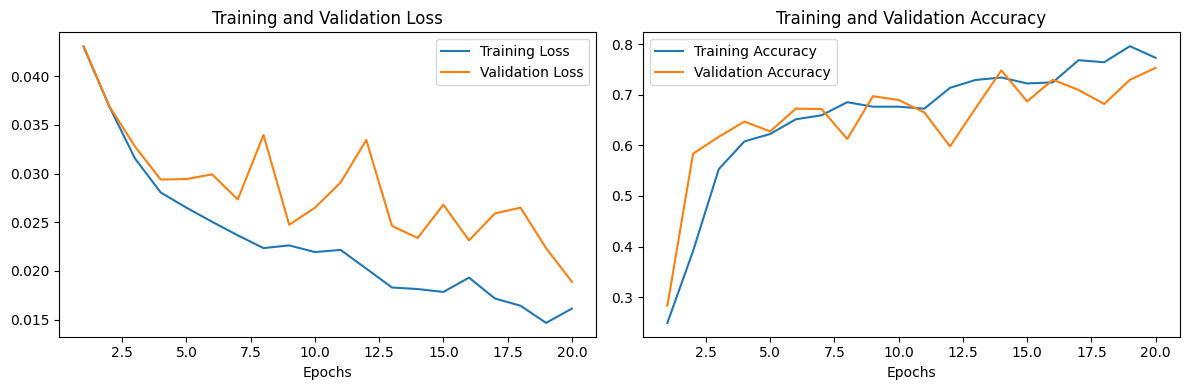

In [ ]:
# Instantiate TrainCurvePlotter with saved training history
plotter = TrainCurvePlotter('training_history_baseline_model.pkl')

# Load training history
plotter.load_training_history()

# Plot training curves
plotter.plot()

**<font size="4">Load Saved Model</font>**

In [ ]:
# Set path to saved model checkpoint
model_path = 'basenet.pth'

# Initialize baseline model
baseline_model = BaseNet(fc1_out_features=512, dropout_prob=0.5).to(device)

# Load the model
baseline_model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

**<font size="4">Baseline Model Evaluation</font>**

In [ ]:
# Instantiate ModelEvaluator
evaluator = ModelEvaluator(baseline_model, test_loader, device)

# Get test accuracy
test_accuracy = evaluator.evaluate()

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Test Accuracy: 83.63%


**<font size="4">Make Predictions</font>**

In [ ]:
# Instantiate ModelPredictor
predictor = ModelPredictor(baseline_model, test_loader, device)

# Predict the class labels of all the images in test loader
predictions, true_labels = predictor.predict()

# Print the accuracy of the model on the test dataset
accuracy = (predictions == true_labels).mean()
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 83.63%


In [ ]:
# Get a random batch from the test loader
random_batch = random.choice(test_loader.dataset)

# Extract the image and label from the random batch
image, label = random_batch

# Add a batch dimension to the image
image = image.unsqueeze(0).to(device)  # Add a batch dimension

# Make predictions for the random image
outputs = baseline_model(image)

# Get the predicted class label
predicted_class_label = outputs[0].argmax().item()

# Get the class name corresponding to the predicted and true labels
predicted_class_name = classes[predicted_class_label]
true_class_name = classes[label]

# Display results
print(f"Predicted class label: {predicted_class_label}")
print(f"Predicted class name: {predicted_class_name}")
print(f"True class label: {label}")
print(f"True class name: {true_class_name}")

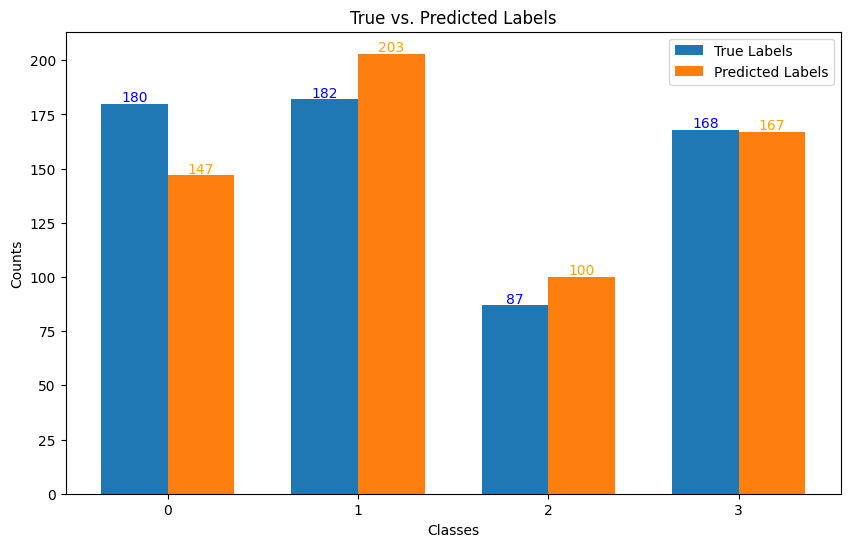

In [ ]:
# Plot the predictions vs. true labels
predictor.plot_predictions()

**<font size="4">Getting Model Performance</font>**

In [ ]:
# Instantiate performance metrics
metrics = PerformanceMetrics(true_labels, predictions, classes)

# Calculate accuracy
accuracy = metrics.calculate_accuracy()
print(f"Accuracy: {accuracy:.2f}%, \n")

# Calculate specificity
specificity = metrics.calculate_specificity()
print(f"Specificity: {specificity:.2f}%, \n")

# Calculate sensitivity
sensitivity = metrics.calculate_sensitivity()
print(f"Sensitivity: {sensitivity:.2f}%, \n")

# Calculate precision
precision = metrics.calculate_precision()
print(f"Precision: {precision:.2f}%, \n")

print("*" * 100)

# Display classification report
report = metrics.generate_classification_report()
print(report)

Accuracy: 83.63%, 

Specificity: 83.73%, 

Sensitivity: 96.82%, 

Precision: 84.92%, 

****************************************************************************************************
                  precision    recall  f1-score   support

    glioma_tumor       0.95      0.77      0.85       180
meningioma_tumor       0.75      0.84      0.79       182
          normal       0.78      0.90      0.83        87
 pituitary_tumor       0.88      0.88      0.88       168

        accuracy                           0.84       617
       macro avg       0.84      0.84      0.84       617
    weighted avg       0.85      0.84      0.84       617



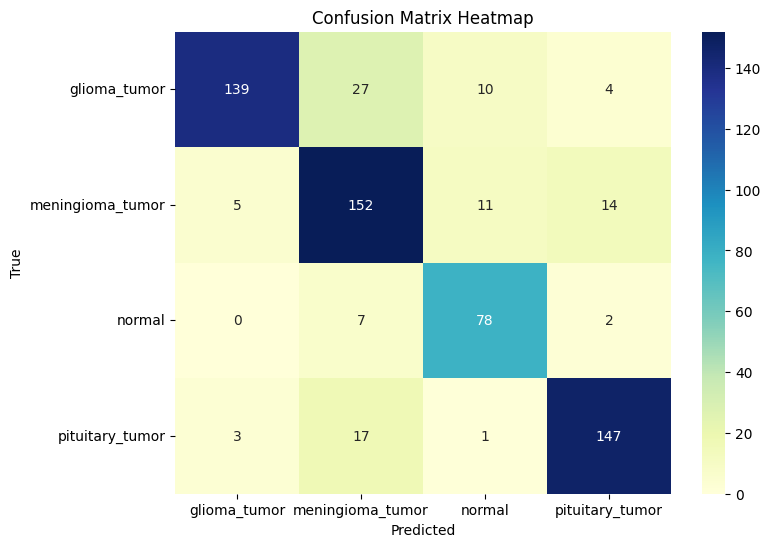

In [ ]:
# Display heatmap
metrics.plot_heatmap()

**<font size="4">Store Results</font>**

In [ ]:
# Create an empty dictionary to save metrics
model_results = {}

In [ ]:
# Store the results of the baseline model
baseline_results = {
    "Accuracy": accuracy,
    "Specificity": specificity,
    "Sensitivity": sensitivity,
    "Precision": precision,
    "Classification Report": classification_report
}

# Add baseline results to the dictionary
model_results["Baseline Model"] = baseline_results

## **Model 1 - Pretrained Model from Pytorch Hub: ResNet50**

**<font size="4">Setting Up Model Architecture</font>**

In [ ]:
class ResNet50(nn.Module):
    def __init__(self, num_classes=4, weights='ResNet50_Weights', freeze_layers=False):
        super(ResNet50, self).__init__()

        # Load a pretrained ResNet-50 model with specified weights
        if weights == 'ResNet50_Weights':
            resnet50 = models.resnet50(weights=ResNet50_Weights)

        else:
            resnet50 = models.resnet50()

        if freeze_layers:
            # Freeze all layers except the custom classification layers
            for param in resnet50.parameters():
                param.requires_grad = True

        # Remove the final classification layer
        self.resnet50 = nn.Sequential(*list(resnet50.children())[:-2])

        # Add custom classification layers
        self.avgpool = nn.AdaptiveAvgPool2d(1)  # Global Average Pooling
        self.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        features = self.resnet50(x)
        x = self.avgpool(features)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

**<font size="4">Getting Model Summary</font>**

In [ ]:
# Define model 1
model_1 = ResNet50()

# Instantiate ModelSummary class
model_summary = ModelSummary(model_1)

# Display model summary
print(model_summary)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 193MB/s] 


ResNet50(
  (resnet50): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64

**<font size="4">Cross Validation & Hyperparameter Tuning</font>**

In [ ]:
 # Define hyperparameter grid
model_param_grid = {
    'freeze_layers': [True, False],  # Freeze or unfreeze layers
    'weights': ['ResNet50_Weights', None],  # Pretrained weights or None
}

trainer_param_grid = {
    'num_epochs': [10, 20],
    'optimizer': [(torch.optim.Adam, {'lr': 0.0001}), (torch.optim.SGD, {'lr': 0.001})],
}

# Instantiate CrossValidatedHyperparameterTuner
cv_tuner = CrossValidatedHyperparameterTuner(
    model_class=ResNet50,
    train_loader=train_loader,
    model_param_grid=model_param_grid,
    trainer_param_grid=trainer_param_grid,
    num_folds=5,
    verbose=True,
)

# Tune model and trainer parameters while performing cross-validation
cv_tuner.tune()

Fold: 1


Epoch [1/10], Training Loss: 0.0163, Training Accuracy: 80.08%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [1/10], Validation Loss: 0.0172, Validation Accuracy: 83.14%


Epoch [2/10], Training Loss: 0.0071, Training Accuracy: 92.03%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [2/10], Validation Loss: 0.0118, Validation Accuracy: 86.61%


Epoch [3/10], Training Loss: 0.0044, Training Accuracy: 94.86%: 100%|██████████| 55/55 [00:27<00:00,  2.01it/s]


Epoch [3/10], Validation Loss: 0.0066, Validation Accuracy: 94.00%


Epoch [4/10], Training Loss: 0.0042, Training Accuracy: 95.15%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [4/10], Validation Loss: 0.0148, Validation Accuracy: 83.14%


Epoch [5/10], Training Loss: 0.0050, Training Accuracy: 94.23%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [5/10], Validation Loss: 0.0052, Validation Accuracy: 94.46%


Epoch [6/10], Training Loss: 0.0038, Training Accuracy: 95.79%: 100%|██████████| 55/55 [00:27<00:00,  2.01it/s]


Epoch [6/10], Validation Loss: 0.0097, Validation Accuracy: 91.45%


Epoch [7/10], Training Loss: 0.0028, Training Accuracy: 97.29%: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [7/10], Validation Loss: 0.0063, Validation Accuracy: 93.76%


Epoch [8/10], Training Loss: 0.0025, Training Accuracy: 97.34%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [8/10], Validation Loss: 0.0058, Validation Accuracy: 93.53%


Epoch [9/10], Training Loss: 0.0015, Training Accuracy: 98.38%: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [9/10], Validation Loss: 0.0042, Validation Accuracy: 95.38%


Epoch [10/10], Training Loss: 0.0009, Training Accuracy: 99.08%: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [10/10], Validation Loss: 0.0049, Validation Accuracy: 95.61%
Fold 1 Accuracy: 95.61%
Fold: 2


Epoch [1/10], Training Loss: 0.0163, Training Accuracy: 80.14%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [1/10], Validation Loss: 0.0107, Validation Accuracy: 86.84%


Epoch [2/10], Training Loss: 0.0076, Training Accuracy: 91.63%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [2/10], Validation Loss: 0.0096, Validation Accuracy: 87.76%


Epoch [3/10], Training Loss: 0.0059, Training Accuracy: 93.48%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [3/10], Validation Loss: 0.0072, Validation Accuracy: 89.61%


Epoch [4/10], Training Loss: 0.0040, Training Accuracy: 95.15%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [4/10], Validation Loss: 0.0086, Validation Accuracy: 91.45%


Epoch [5/10], Training Loss: 0.0041, Training Accuracy: 95.27%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [5/10], Validation Loss: 0.0076, Validation Accuracy: 91.92%


Epoch [6/10], Training Loss: 0.0046, Training Accuracy: 94.63%: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [6/10], Validation Loss: 0.0041, Validation Accuracy: 96.07%


Epoch [7/10], Training Loss: 0.0040, Training Accuracy: 95.44%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [7/10], Validation Loss: 0.0102, Validation Accuracy: 89.61%


Epoch [8/10], Training Loss: 0.0024, Training Accuracy: 97.23%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [8/10], Validation Loss: 0.0047, Validation Accuracy: 95.15%


Epoch [9/10], Training Loss: 0.0025, Training Accuracy: 97.06%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [9/10], Validation Loss: 0.0056, Validation Accuracy: 92.61%


Epoch [10/10], Training Loss: 0.0021, Training Accuracy: 97.69%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [10/10], Validation Loss: 0.0058, Validation Accuracy: 95.38%
Fold 2 Accuracy: 94.92%
Fold: 3


Epoch [1/10], Training Loss: 0.0163, Training Accuracy: 79.50%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [1/10], Validation Loss: 0.0106, Validation Accuracy: 87.99%


Epoch [2/10], Training Loss: 0.0078, Training Accuracy: 91.22%: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [2/10], Validation Loss: 0.0088, Validation Accuracy: 90.07%


Epoch [3/10], Training Loss: 0.0050, Training Accuracy: 94.28%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [3/10], Validation Loss: 0.0057, Validation Accuracy: 94.00%


Epoch [4/10], Training Loss: 0.0035, Training Accuracy: 95.96%: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [4/10], Validation Loss: 0.0069, Validation Accuracy: 94.00%


Epoch [5/10], Training Loss: 0.0043, Training Accuracy: 94.52%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [5/10], Validation Loss: 0.0060, Validation Accuracy: 94.46%


Epoch [6/10], Training Loss: 0.0033, Training Accuracy: 97.06%: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [6/10], Validation Loss: 0.0058, Validation Accuracy: 94.92%


Epoch [7/10], Training Loss: 0.0028, Training Accuracy: 96.65%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [7/10], Validation Loss: 0.0074, Validation Accuracy: 93.53%


Epoch [8/10], Training Loss: 0.0026, Training Accuracy: 96.88%: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [8/10], Validation Loss: 0.0049, Validation Accuracy: 94.46%


Epoch [2/10], Training Loss: 0.0071, Training Accuracy: 92.49%: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [2/10], Validation Loss: 0.0074, Validation Accuracy: 92.15%


Epoch [3/10], Training Loss: 0.0058, Training Accuracy: 93.36%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [3/10], Validation Loss: 0.0073, Validation Accuracy: 93.07%


Epoch [4/10], Training Loss: 0.0044, Training Accuracy: 95.09%: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [4/10], Validation Loss: 0.0076, Validation Accuracy: 92.61%


Epoch [5/10], Training Loss: 0.0035, Training Accuracy: 96.42%: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [5/10], Validation Loss: 0.0074, Validation Accuracy: 93.76%


Epoch [6/10], Training Loss: 0.0040, Training Accuracy: 96.13%: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [6/10], Validation Loss: 0.0083, Validation Accuracy: 93.07%


Epoch [7/10], Training Loss: 0.0034, Training Accuracy: 96.94%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [7/10], Validation Loss: 0.0051, Validation Accuracy: 95.38%


Epoch [8/10], Training Loss: 0.0022, Training Accuracy: 97.34%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [8/10], Validation Loss: 0.0060, Validation Accuracy: 93.53%


Epoch [9/10], Training Loss: 0.0015, Training Accuracy: 98.44%:   4%|▎         | 2/55 [00:01<00:27,  1.91it/s] 

Epoch [9/10], Validation Loss: 0.0061, Validation Accuracy: 93.53%


Epoch [10/10], Training Loss: 0.0034, Training Accuracy: 96.42%: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [10/10], Validation Loss: 0.0063, Validation Accuracy: 94.23%
Fold 4 Accuracy: 94.00%
Fold: 5


Epoch [1/10], Training Loss: 0.0166, Training Accuracy: 79.62%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [1/10], Validation Loss: 0.0167, Validation Accuracy: 77.83%


Epoch [2/10], Training Loss: 0.0068, Training Accuracy: 91.80%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [2/10], Validation Loss: 0.0080, Validation Accuracy: 91.22%


Epoch [3/10], Training Loss: 0.0050, Training Accuracy: 94.11%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [3/10], Validation Loss: 0.0141, Validation Accuracy: 85.45%


Epoch [4/10], Training Loss: 0.0045, Training Accuracy: 94.46%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [4/10], Validation Loss: 0.0087, Validation Accuracy: 90.53%


Epoch [5/10], Training Loss: 0.0048, Training Accuracy: 95.38%: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [5/10], Validation Loss: 0.0048, Validation Accuracy: 94.00%


Epoch [6/10], Training Loss: 0.0033, Training Accuracy: 96.02%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [6/10], Validation Loss: 0.0110, Validation Accuracy: 88.68%


Epoch [7/10], Training Loss: 0.0018, Training Accuracy: 98.04%: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [7/10], Validation Loss: 0.0073, Validation Accuracy: 91.22%


Epoch [8/10], Training Loss: 0.0021, Training Accuracy: 97.46%: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [8/10], Validation Loss: 0.0044, Validation Accuracy: 94.69%


Epoch [9/10], Training Loss: 0.0032, Training Accuracy: 95.73%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [9/10], Validation Loss: 0.0054, Validation Accuracy: 93.30%


Epoch [10/10], Training Loss: 0.0050, Training Accuracy: 94.40%: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [10/10], Validation Loss: 0.0083, Validation Accuracy: 89.61%
Fold 5 Accuracy: 88.68%
Model Parameters: {'freeze_layers': True, 'weights': 'ResNet50_Weights'}, Trainer Parameters: {'num_epochs': 10, 'optimizer': (<class 'torch.optim.adam.Adam'>, {'lr': 0.0001})}
Fold Accuracies: [95.61200923787528, 94.91916859122402, 94.68822170900692, 93.99538106235565, 88.68360277136259]
Mean Accuracy: 93.58%, Std Accuracy: 2.50, Score: 91.08
Fold: 1


Epoch [1/10], Training Loss: 0.0420, Training Accuracy: 37.41%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [1/10], Validation Loss: 0.0408, Validation Accuracy: 46.88%


Epoch [2/10], Training Loss: 0.0363, Training Accuracy: 60.57%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [2/10], Validation Loss: 0.0362, Validation Accuracy: 66.51%


Epoch [3/10], Training Loss: 0.0315, Training Accuracy: 70.27%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [3/10], Validation Loss: 0.0304, Validation Accuracy: 68.59%


Epoch [4/10], Training Loss: 0.0271, Training Accuracy: 73.61%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [4/10], Validation Loss: 0.0276, Validation Accuracy: 75.75%


Epoch [5/10], Training Loss: 0.0233, Training Accuracy: 76.67%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [5/10], Validation Loss: 0.0226, Validation Accuracy: 77.83%


Epoch [6/10], Training Loss: 0.0204, Training Accuracy: 79.16%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [6/10], Validation Loss: 0.0213, Validation Accuracy: 77.83%


Epoch [7/10], Training Loss: 0.0191, Training Accuracy: 78.52%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [7/10], Validation Loss: 0.0189, Validation Accuracy: 81.52%


Epoch [8/10], Training Loss: 0.0179, Training Accuracy: 80.60%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [8/10], Validation Loss: 0.0176, Validation Accuracy: 80.14%


Epoch [9/10], Training Loss: 0.0160, Training Accuracy: 81.18%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [9/10], Validation Loss: 0.0167, Validation Accuracy: 82.91%


Epoch [10/10], Training Loss: 0.0148, Training Accuracy: 83.26%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [10/10], Validation Loss: 0.0157, Validation Accuracy: 81.29%
Fold 1 Accuracy: 81.76%
Fold: 2


Epoch [1/10], Training Loss: 0.0419, Training Accuracy: 43.94%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [1/10], Validation Loss: 0.0414, Validation Accuracy: 41.57%


Epoch [2/10], Training Loss: 0.0359, Training Accuracy: 64.67%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [2/10], Validation Loss: 0.0347, Validation Accuracy: 66.28%


Epoch [3/10], Training Loss: 0.0309, Training Accuracy: 72.29%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [3/10], Validation Loss: 0.0336, Validation Accuracy: 56.58%


Epoch [4/10], Training Loss: 0.0263, Training Accuracy: 75.75%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [4/10], Validation Loss: 0.0388, Validation Accuracy: 29.10%


Epoch [5/10], Training Loss: 0.0232, Training Accuracy: 77.89%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [5/10], Validation Loss: 0.0253, Validation Accuracy: 72.98%


Epoch [6/10], Training Loss: 0.0206, Training Accuracy: 79.39%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [6/10], Validation Loss: 0.0207, Validation Accuracy: 74.83%


Epoch [7/10], Training Loss: 0.0182, Training Accuracy: 79.85%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [7/10], Validation Loss: 0.0224, Validation Accuracy: 71.59%


Epoch [8/10], Training Loss: 0.0166, Training Accuracy: 82.16%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [8/10], Validation Loss: 0.0196, Validation Accuracy: 74.36%


Epoch [9/10], Training Loss: 0.0155, Training Accuracy: 82.68%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [9/10], Validation Loss: 0.0228, Validation Accuracy: 67.90%


Epoch [10/10], Training Loss: 0.0148, Training Accuracy: 82.79%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [10/10], Validation Loss: 0.0278, Validation Accuracy: 57.51%
Fold 2 Accuracy: 54.50%
Fold: 3


Epoch [1/10], Training Loss: 0.0410, Training Accuracy: 45.27%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [1/10], Validation Loss: 0.0390, Validation Accuracy: 57.97%


Epoch [2/10], Training Loss: 0.0359, Training Accuracy: 65.42%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [2/10], Validation Loss: 0.0321, Validation Accuracy: 77.37%


Epoch [3/10], Training Loss: 0.0310, Training Accuracy: 71.54%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [3/10], Validation Loss: 0.0275, Validation Accuracy: 76.91%


Epoch [4/10], Training Loss: 0.0268, Training Accuracy: 75.12%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [4/10], Validation Loss: 0.0234, Validation Accuracy: 79.45%


Epoch [5/10], Training Loss: 0.0236, Training Accuracy: 76.21%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [5/10], Validation Loss: 0.0216, Validation Accuracy: 82.91%


Epoch [6/10], Training Loss: 0.0210, Training Accuracy: 78.46%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [6/10], Validation Loss: 0.0187, Validation Accuracy: 81.52%


Epoch [7/10], Training Loss: 0.0188, Training Accuracy: 78.93%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [7/10], Validation Loss: 0.0163, Validation Accuracy: 83.14%


Epoch [8/10], Training Loss: 0.0174, Training Accuracy: 80.48%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [8/10], Validation Loss: 0.0150, Validation Accuracy: 86.14%


Epoch [9/10], Training Loss: 0.0163, Training Accuracy: 80.89%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [9/10], Validation Loss: 0.0141, Validation Accuracy: 84.53%


Epoch [10/10], Training Loss: 0.0151, Training Accuracy: 83.89%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [10/10], Validation Loss: 0.0134, Validation Accuracy: 84.76%
Fold 3 Accuracy: 85.22%
Fold: 4


Epoch [1/10], Training Loss: 0.0422, Training Accuracy: 36.66%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [1/10], Validation Loss: 0.0405, Validation Accuracy: 42.73%


Epoch [2/10], Training Loss: 0.0365, Training Accuracy: 63.68%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [2/10], Validation Loss: 0.0340, Validation Accuracy: 65.82%


Epoch [3/10], Training Loss: 0.0318, Training Accuracy: 70.61%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [3/10], Validation Loss: 0.0300, Validation Accuracy: 72.98%


Epoch [4/10], Training Loss: 0.0272, Training Accuracy: 74.42%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [4/10], Validation Loss: 0.0248, Validation Accuracy: 77.37%


Epoch [5/10], Training Loss: 0.0238, Training Accuracy: 75.69%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [5/10], Validation Loss: 0.0222, Validation Accuracy: 74.60%


Epoch [6/10], Training Loss: 0.0212, Training Accuracy: 77.08%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [6/10], Validation Loss: 0.0222, Validation Accuracy: 76.44%


Epoch [7/10], Training Loss: 0.0189, Training Accuracy: 79.56%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [7/10], Validation Loss: 0.0181, Validation Accuracy: 81.06%


Epoch [8/10], Training Loss: 0.0177, Training Accuracy: 80.08%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [8/10], Validation Loss: 0.0175, Validation Accuracy: 83.14%


Epoch [9/10], Training Loss: 0.0158, Training Accuracy: 81.81%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [9/10], Validation Loss: 0.0167, Validation Accuracy: 81.29%


Epoch [10/10], Training Loss: 0.0155, Training Accuracy: 81.81%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [10/10], Validation Loss: 0.0150, Validation Accuracy: 84.06%
Fold 4 Accuracy: 84.30%
Fold: 5


Epoch [1/10], Training Loss: 0.0421, Training Accuracy: 40.01%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [1/10], Validation Loss: 0.0427, Validation Accuracy: 31.18%


Epoch [2/10], Training Loss: 0.0366, Training Accuracy: 60.62%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [2/10], Validation Loss: 0.0363, Validation Accuracy: 61.89%


Epoch [3/10], Training Loss: 0.0312, Training Accuracy: 70.61%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [3/10], Validation Loss: 0.0313, Validation Accuracy: 68.59%


Epoch [4/10], Training Loss: 0.0267, Training Accuracy: 74.83%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [4/10], Validation Loss: 0.0257, Validation Accuracy: 76.67%


Epoch [5/10], Training Loss: 0.0235, Training Accuracy: 77.14%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [5/10], Validation Loss: 0.0241, Validation Accuracy: 70.90%


Epoch [6/10], Training Loss: 0.0210, Training Accuracy: 77.08%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [6/10], Validation Loss: 0.0215, Validation Accuracy: 74.83%


Epoch [7/10], Training Loss: 0.0190, Training Accuracy: 78.64%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [7/10], Validation Loss: 0.0218, Validation Accuracy: 72.29%


Epoch [8/10], Training Loss: 0.0173, Training Accuracy: 80.60%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [8/10], Validation Loss: 0.0171, Validation Accuracy: 80.83%


Epoch [9/10], Training Loss: 0.0165, Training Accuracy: 81.12%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [9/10], Validation Loss: 0.0189, Validation Accuracy: 77.37%


Epoch [10/10], Training Loss: 0.0151, Training Accuracy: 82.79%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [10/10], Validation Loss: 0.0152, Validation Accuracy: 82.91%
Fold 5 Accuracy: 82.68%
Model Parameters: {'freeze_layers': True, 'weights': 'ResNet50_Weights'}, Trainer Parameters: {'num_epochs': 10, 'optimizer': (<class 'torch.optim.sgd.SGD'>, {'lr': 0.001})}
Fold Accuracies: [81.75519630484989, 54.50346420323326, 85.21939953810623, 84.29561200923787, 82.67898383371825]
Mean Accuracy: 77.69%, Std Accuracy: 11.66, Score: 66.03
Fold: 1


Epoch [1/20], Training Loss: 0.0168, Training Accuracy: 78.52%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [1/20], Validation Loss: 0.0251, Validation Accuracy: 77.37%


Epoch [2/20], Training Loss: 0.0079, Training Accuracy: 90.99%: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [2/20], Validation Loss: 0.0069, Validation Accuracy: 93.07%


Epoch [3/20], Training Loss: 0.0059, Training Accuracy: 93.71%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [3/20], Validation Loss: 0.0051, Validation Accuracy: 94.69%


Epoch [4/20], Training Loss: 0.0055, Training Accuracy: 94.63%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [4/20], Validation Loss: 0.0045, Validation Accuracy: 95.61%


Epoch [5/20], Training Loss: 0.0032, Training Accuracy: 96.36%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [5/20], Validation Loss: 0.0085, Validation Accuracy: 92.15%


Epoch [6/20], Training Loss: 0.0037, Training Accuracy: 96.54%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [6/20], Validation Loss: 0.0071, Validation Accuracy: 94.00%


Epoch [7/20], Training Loss: 0.0034, Training Accuracy: 96.13%: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [7/20], Validation Loss: 0.0076, Validation Accuracy: 92.84%


Epoch [8/20], Training Loss: 0.0048, Training Accuracy: 95.38%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [8/20], Validation Loss: 0.0082, Validation Accuracy: 93.76%


Epoch [9/20], Training Loss: 0.0040, Training Accuracy: 95.27%: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [9/20], Validation Loss: 0.0056, Validation Accuracy: 93.53%


Epoch [10/20], Training Loss: 0.0019, Training Accuracy: 97.63%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [10/20], Validation Loss: 0.0056, Validation Accuracy: 93.07%


Epoch [11/20], Training Loss: 0.0017, Training Accuracy: 98.44%: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [11/20], Validation Loss: 0.0041, Validation Accuracy: 96.30%


Epoch [12/20], Training Loss: 0.0010, Training Accuracy: 99.08%: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [12/20], Validation Loss: 0.0038, Validation Accuracy: 95.84%


Epoch [13/20], Training Loss: 0.0009, Training Accuracy: 98.90%: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [13/20], Validation Loss: 0.0067, Validation Accuracy: 94.69%


Epoch [14/20], Training Loss: 0.0010, Training Accuracy: 98.85%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [14/20], Validation Loss: 0.0045, Validation Accuracy: 94.69%


Epoch [15/20], Training Loss: 0.0024, Training Accuracy: 97.52%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [15/20], Validation Loss: 0.0060, Validation Accuracy: 94.00%


Epoch [16/20], Training Loss: 0.0020, Training Accuracy: 97.98%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [16/20], Validation Loss: 0.0057, Validation Accuracy: 95.61%


Epoch [17/20], Training Loss: 0.0043, Training Accuracy: 97.46%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [17/20], Validation Loss: 0.0060, Validation Accuracy: 94.92%


Epoch [18/20], Training Loss: 0.0029, Training Accuracy: 97.11%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [18/20], Validation Loss: 0.0053, Validation Accuracy: 94.23%


Epoch [19/20], Training Loss: 0.0034, Training Accuracy: 96.19%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [19/20], Validation Loss: 0.0049, Validation Accuracy: 95.15%


Epoch [20/20], Training Loss: 0.0022, Training Accuracy: 97.69%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [20/20], Validation Loss: 0.0047, Validation Accuracy: 95.61%
Fold 1 Accuracy: 95.15%
Fold: 2


Epoch [1/20], Training Loss: 0.0164, Training Accuracy: 79.79%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [1/20], Validation Loss: 0.0267, Validation Accuracy: 74.60%


Epoch [2/20], Training Loss: 0.0083, Training Accuracy: 90.53%: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [2/20], Validation Loss: 0.0095, Validation Accuracy: 88.91%


Epoch [3/20], Training Loss: 0.0057, Training Accuracy: 93.48%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [3/20], Validation Loss: 0.0043, Validation Accuracy: 94.23%


Epoch [4/20], Training Loss: 0.0052, Training Accuracy: 95.09%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [4/20], Validation Loss: 0.0067, Validation Accuracy: 94.23%


Epoch [5/20], Training Loss: 0.0046, Training Accuracy: 94.92%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [5/20], Validation Loss: 0.0055, Validation Accuracy: 93.07%


Epoch [6/20], Training Loss: 0.0027, Training Accuracy: 97.11%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [6/20], Validation Loss: 0.0036, Validation Accuracy: 96.07%


Epoch [7/20], Training Loss: 0.0017, Training Accuracy: 98.38%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [7/20], Validation Loss: 0.0035, Validation Accuracy: 95.38%


Epoch [8/20], Training Loss: 0.0023, Training Accuracy: 97.63%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [8/20], Validation Loss: 0.0047, Validation Accuracy: 94.00%


Epoch [9/20], Training Loss: 0.0030, Training Accuracy: 96.88%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [9/20], Validation Loss: 0.0037, Validation Accuracy: 96.07%


Epoch [10/20], Training Loss: 0.0026, Training Accuracy: 97.29%: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [10/20], Validation Loss: 0.0053, Validation Accuracy: 93.76%


Epoch [11/20], Training Loss: 0.0038, Training Accuracy: 96.07%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [11/20], Validation Loss: 0.0045, Validation Accuracy: 94.69%


Epoch [12/20], Training Loss: 0.0037, Training Accuracy: 95.96%: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [12/20], Validation Loss: 0.0054, Validation Accuracy: 93.76%


Epoch [13/20], Training Loss: 0.0026, Training Accuracy: 97.34%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [13/20], Validation Loss: 0.0044, Validation Accuracy: 94.46%


Epoch [14/20], Training Loss: 0.0027, Training Accuracy: 98.15%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [14/20], Validation Loss: 0.0043, Validation Accuracy: 95.15%


Epoch [15/20], Training Loss: 0.0036, Training Accuracy: 96.02%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [15/20], Validation Loss: 0.0043, Validation Accuracy: 95.38%


Epoch [16/20], Training Loss: 0.0014, Training Accuracy: 98.44%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [16/20], Validation Loss: 0.0045, Validation Accuracy: 95.15%


Epoch [17/20], Training Loss: 0.0010, Training Accuracy: 98.90%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [17/20], Validation Loss: 0.0036, Validation Accuracy: 97.00%


Epoch [18/20], Training Loss: 0.0006, Training Accuracy: 99.60%: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [18/20], Validation Loss: 0.0032, Validation Accuracy: 97.23%


Epoch [19/20], Training Loss: 0.0010, Training Accuracy: 98.79%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [19/20], Validation Loss: 0.0032, Validation Accuracy: 96.77%


Epoch [20/20], Training Loss: 0.0014, Training Accuracy: 98.33%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [20/20], Validation Loss: 0.0049, Validation Accuracy: 95.61%
Fold 2 Accuracy: 95.15%
Fold: 3


Epoch [1/20], Training Loss: 0.0172, Training Accuracy: 79.39%: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [1/20], Validation Loss: 0.0180, Validation Accuracy: 78.52%


Epoch [2/20], Training Loss: 0.0081, Training Accuracy: 91.22%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [2/20], Validation Loss: 0.0082, Validation Accuracy: 90.30%


Epoch [3/20], Training Loss: 0.0069, Training Accuracy: 92.09%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [3/20], Validation Loss: 0.0056, Validation Accuracy: 93.07%


Epoch [4/20], Training Loss: 0.0048, Training Accuracy: 95.50%: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [4/20], Validation Loss: 0.0062, Validation Accuracy: 95.15%


Epoch [5/20], Training Loss: 0.0034, Training Accuracy: 96.19%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [5/20], Validation Loss: 0.0064, Validation Accuracy: 93.76%


Epoch [6/20], Training Loss: 0.0031, Training Accuracy: 96.94%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [6/20], Validation Loss: 0.0055, Validation Accuracy: 93.53%


Epoch [7/20], Training Loss: 0.0028, Training Accuracy: 97.11%: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [7/20], Validation Loss: 0.0046, Validation Accuracy: 95.15%


Epoch [8/20], Training Loss: 0.0018, Training Accuracy: 98.33%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [8/20], Validation Loss: 0.0046, Validation Accuracy: 95.84%


Epoch [9/20], Training Loss: 0.0031, Training Accuracy: 96.25%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [9/20], Validation Loss: 0.0071, Validation Accuracy: 92.38%


Epoch [10/20], Training Loss: 0.0038, Training Accuracy: 95.67%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [10/20], Validation Loss: 0.0066, Validation Accuracy: 94.46%


Epoch [11/20], Training Loss: 0.0018, Training Accuracy: 97.86%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [11/20], Validation Loss: 0.0056, Validation Accuracy: 95.15%


Epoch [12/20], Training Loss: 0.0024, Training Accuracy: 97.63%: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [12/20], Validation Loss: 0.0060, Validation Accuracy: 94.92%


Epoch [13/20], Training Loss: 0.0031, Training Accuracy: 97.40%: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [13/20], Validation Loss: 0.0061, Validation Accuracy: 93.76%


Epoch [14/20], Training Loss: 0.0029, Training Accuracy: 96.77%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [14/20], Validation Loss: 0.0058, Validation Accuracy: 94.46%


Epoch [15/20], Training Loss: 0.0013, Training Accuracy: 98.44%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [15/20], Validation Loss: 0.0049, Validation Accuracy: 96.30%


Epoch [16/20], Training Loss: 0.0018, Training Accuracy: 97.92%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [16/20], Validation Loss: 0.0053, Validation Accuracy: 95.38%


Epoch [17/20], Training Loss: 0.0017, Training Accuracy: 98.27%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [17/20], Validation Loss: 0.0071, Validation Accuracy: 93.07%


Epoch [18/20], Training Loss: 0.0012, Training Accuracy: 99.13%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [18/20], Validation Loss: 0.0066, Validation Accuracy: 94.46%


Epoch [19/20], Training Loss: 0.0030, Training Accuracy: 96.71%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [19/20], Validation Loss: 0.0080, Validation Accuracy: 92.61%


Epoch [20/20], Training Loss: 0.0021, Training Accuracy: 97.63%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [20/20], Validation Loss: 0.0056, Validation Accuracy: 94.46%
Fold 3 Accuracy: 93.07%
Fold: 4


Epoch [1/20], Training Loss: 0.0172, Training Accuracy: 78.12%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [1/20], Validation Loss: 0.0142, Validation Accuracy: 86.14%


Epoch [2/20], Training Loss: 0.0070, Training Accuracy: 91.17%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [2/20], Validation Loss: 0.0079, Validation Accuracy: 92.38%


Epoch [3/20], Training Loss: 0.0060, Training Accuracy: 94.46%: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [3/20], Validation Loss: 0.0121, Validation Accuracy: 86.84%


Epoch [4/20], Training Loss: 0.0050, Training Accuracy: 94.34%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [4/20], Validation Loss: 0.0086, Validation Accuracy: 91.92%


Epoch [5/20], Training Loss: 0.0039, Training Accuracy: 95.50%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [5/20], Validation Loss: 0.0093, Validation Accuracy: 91.45%


Epoch [6/20], Training Loss: 0.0035, Training Accuracy: 97.06%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [6/20], Validation Loss: 0.0063, Validation Accuracy: 92.38%


Epoch [7/20], Training Loss: 0.0033, Training Accuracy: 96.59%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [7/20], Validation Loss: 0.0079, Validation Accuracy: 90.99%


Epoch [8/20], Training Loss: 0.0033, Training Accuracy: 96.48%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [8/20], Validation Loss: 0.0059, Validation Accuracy: 94.23%


Epoch [9/20], Training Loss: 0.0027, Training Accuracy: 97.23%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [9/20], Validation Loss: 0.0041, Validation Accuracy: 95.61%


Epoch [10/20], Training Loss: 0.0021, Training Accuracy: 97.92%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [10/20], Validation Loss: 0.0067, Validation Accuracy: 92.84%


Epoch [11/20], Training Loss: 0.0024, Training Accuracy: 97.81%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [11/20], Validation Loss: 0.0068, Validation Accuracy: 92.15%


Epoch [12/20], Training Loss: 0.0047, Training Accuracy: 96.25%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [12/20], Validation Loss: 0.0061, Validation Accuracy: 93.07%


Epoch [13/20], Training Loss: 0.0035, Training Accuracy: 96.77%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [13/20], Validation Loss: 0.0082, Validation Accuracy: 92.38%


Epoch [14/20], Training Loss: 0.0023, Training Accuracy: 97.11%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [14/20], Validation Loss: 0.0045, Validation Accuracy: 95.15%


Epoch [15/20], Training Loss: 0.0017, Training Accuracy: 98.15%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [15/20], Validation Loss: 0.0054, Validation Accuracy: 94.00%


Epoch [16/20], Training Loss: 0.0011, Training Accuracy: 98.67%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [16/20], Validation Loss: 0.0065, Validation Accuracy: 94.23%


Epoch [17/20], Training Loss: 0.0014, Training Accuracy: 98.61%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [17/20], Validation Loss: 0.0057, Validation Accuracy: 94.46%


Epoch [18/20], Training Loss: 0.0009, Training Accuracy: 99.02%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s] 


Epoch [18/20], Validation Loss: 0.0061, Validation Accuracy: 94.92%


Epoch [19/20], Training Loss: 0.0013, Training Accuracy: 98.90%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [19/20], Validation Loss: 0.0054, Validation Accuracy: 96.30%


Epoch [20/20], Training Loss: 0.0017, Training Accuracy: 98.33%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [20/20], Validation Loss: 0.0066, Validation Accuracy: 93.30%
Fold 4 Accuracy: 93.53%
Fold: 5


Epoch [1/20], Training Loss: 0.0157, Training Accuracy: 80.31%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [1/20], Validation Loss: 0.0096, Validation Accuracy: 88.91%


Epoch [2/20], Training Loss: 0.0079, Training Accuracy: 91.40%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [2/20], Validation Loss: 0.0130, Validation Accuracy: 83.37%


Epoch [3/20], Training Loss: 0.0049, Training Accuracy: 94.23%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [3/20], Validation Loss: 0.0053, Validation Accuracy: 93.53%


Epoch [4/20], Training Loss: 0.0047, Training Accuracy: 95.61%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [4/20], Validation Loss: 0.0094, Validation Accuracy: 90.30%


Epoch [5/20], Training Loss: 0.0041, Training Accuracy: 95.55%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [5/20], Validation Loss: 0.0079, Validation Accuracy: 91.45%


Epoch [6/20], Training Loss: 0.0035, Training Accuracy: 96.25%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [6/20], Validation Loss: 0.0065, Validation Accuracy: 92.84%


Epoch [7/20], Training Loss: 0.0029, Training Accuracy: 96.42%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [7/20], Validation Loss: 0.0045, Validation Accuracy: 95.38%


Epoch [8/20], Training Loss: 0.0026, Training Accuracy: 97.86%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [8/20], Validation Loss: 0.0083, Validation Accuracy: 90.99%


Epoch [9/20], Training Loss: 0.0030, Training Accuracy: 97.52%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [9/20], Validation Loss: 0.0051, Validation Accuracy: 93.53%


Epoch [10/20], Training Loss: 0.0033, Training Accuracy: 96.71%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [10/20], Validation Loss: 0.0078, Validation Accuracy: 91.92%


Epoch [11/20], Training Loss: 0.0021, Training Accuracy: 97.63%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [11/20], Validation Loss: 0.0055, Validation Accuracy: 94.00%


Epoch [12/20], Training Loss: 0.0013, Training Accuracy: 98.56%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [12/20], Validation Loss: 0.0054, Validation Accuracy: 94.46%


Epoch [13/20], Training Loss: 0.0035, Training Accuracy: 98.73%: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [13/20], Validation Loss: 0.0051, Validation Accuracy: 93.53%


Epoch [14/20], Training Loss: 0.0031, Training Accuracy: 97.06%: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [14/20], Validation Loss: 0.0062, Validation Accuracy: 92.61%


Epoch [15/20], Training Loss: 0.0030, Training Accuracy: 96.88%: 100%|██████████| 55/55 [00:27<00:00,  2.01it/s]


Epoch [15/20], Validation Loss: 0.0056, Validation Accuracy: 94.69%


Epoch [16/20], Training Loss: 0.0011, Training Accuracy: 98.61%: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [16/20], Validation Loss: 0.0037, Validation Accuracy: 95.15%


Epoch [17/20], Training Loss: 0.0008, Training Accuracy: 99.02%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [17/20], Validation Loss: 0.0059, Validation Accuracy: 93.30%


Epoch [18/20], Training Loss: 0.0012, Training Accuracy: 98.96%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [18/20], Validation Loss: 0.0074, Validation Accuracy: 94.46%


Epoch [19/20], Training Loss: 0.0020, Training Accuracy: 98.33%: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [19/20], Validation Loss: 0.0092, Validation Accuracy: 91.22%


Epoch [20/20], Training Loss: 0.0033, Training Accuracy: 96.30%: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [20/20], Validation Loss: 0.0048, Validation Accuracy: 94.00%
Fold 5 Accuracy: 93.53%
Model Parameters: {'freeze_layers': True, 'weights': 'ResNet50_Weights'}, Trainer Parameters: {'num_epochs': 20, 'optimizer': (<class 'torch.optim.adam.Adam'>, {'lr': 0.0001})}
Fold Accuracies: [95.1501154734411, 95.1501154734411, 93.0715935334873, 93.53348729792148, 93.53348729792148]
Mean Accuracy: 94.09%, Std Accuracy: 0.88, Score: 93.20
Fold: 1


Epoch [1/20], Training Loss: 0.0409, Training Accuracy: 46.02%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [1/20], Validation Loss: 0.0403, Validation Accuracy: 50.12%


Epoch [2/20], Training Loss: 0.0350, Training Accuracy: 67.15%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [2/20], Validation Loss: 0.0339, Validation Accuracy: 69.75%


Epoch [3/20], Training Loss: 0.0301, Training Accuracy: 71.36%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [3/20], Validation Loss: 0.0299, Validation Accuracy: 72.29%


Epoch [4/20], Training Loss: 0.0260, Training Accuracy: 75.58%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [4/20], Validation Loss: 0.0250, Validation Accuracy: 76.91%


Epoch [5/20], Training Loss: 0.0230, Training Accuracy: 76.21%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [5/20], Validation Loss: 0.0232, Validation Accuracy: 76.67%


Epoch [6/20], Training Loss: 0.0206, Training Accuracy: 78.52%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [6/20], Validation Loss: 0.0198, Validation Accuracy: 79.45%


Epoch [7/20], Training Loss: 0.0186, Training Accuracy: 80.31%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [7/20], Validation Loss: 0.0182, Validation Accuracy: 82.45%


Epoch [8/20], Training Loss: 0.0173, Training Accuracy: 81.47%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [8/20], Validation Loss: 0.0156, Validation Accuracy: 84.06%


Epoch [9/20], Training Loss: 0.0156, Training Accuracy: 83.14%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [9/20], Validation Loss: 0.0150, Validation Accuracy: 83.14%


Epoch [10/20], Training Loss: 0.0148, Training Accuracy: 83.14%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [10/20], Validation Loss: 0.0146, Validation Accuracy: 84.30%


Epoch [11/20], Training Loss: 0.0144, Training Accuracy: 84.06%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [11/20], Validation Loss: 0.0151, Validation Accuracy: 81.99%


Epoch [12/20], Training Loss: 0.0132, Training Accuracy: 85.05%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [12/20], Validation Loss: 0.0133, Validation Accuracy: 84.53%


Epoch [13/20], Training Loss: 0.0124, Training Accuracy: 86.55%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [13/20], Validation Loss: 0.0123, Validation Accuracy: 86.14%


Epoch [14/20], Training Loss: 0.0118, Training Accuracy: 86.78%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [14/20], Validation Loss: 0.0138, Validation Accuracy: 82.22%


Epoch [15/20], Training Loss: 0.0119, Training Accuracy: 86.49%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [15/20], Validation Loss: 0.0115, Validation Accuracy: 86.14%


Epoch [16/20], Training Loss: 0.0103, Training Accuracy: 88.16%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [16/20], Validation Loss: 0.0101, Validation Accuracy: 88.91%


Epoch [17/20], Training Loss: 0.0101, Training Accuracy: 88.63%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [17/20], Validation Loss: 0.0105, Validation Accuracy: 85.91%


Epoch [18/20], Training Loss: 0.0102, Training Accuracy: 88.16%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [18/20], Validation Loss: 0.0099, Validation Accuracy: 88.45%


Epoch [19/20], Training Loss: 0.0098, Training Accuracy: 88.57%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [19/20], Validation Loss: 0.0097, Validation Accuracy: 87.53%


Epoch [20/20], Training Loss: 0.0101, Training Accuracy: 88.28%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [20/20], Validation Loss: 0.0091, Validation Accuracy: 88.45%
Fold 1 Accuracy: 89.15%
Fold: 2


Epoch [1/20], Training Loss: 0.0416, Training Accuracy: 41.69%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [1/20], Validation Loss: 0.0398, Validation Accuracy: 47.58%


Epoch [2/20], Training Loss: 0.0355, Training Accuracy: 65.65%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [2/20], Validation Loss: 0.0342, Validation Accuracy: 64.67%


Epoch [3/20], Training Loss: 0.0307, Training Accuracy: 71.82%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [3/20], Validation Loss: 0.0292, Validation Accuracy: 72.29%


Epoch [4/20], Training Loss: 0.0267, Training Accuracy: 73.79%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [4/20], Validation Loss: 0.0254, Validation Accuracy: 75.75%


Epoch [5/20], Training Loss: 0.0228, Training Accuracy: 77.31%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [5/20], Validation Loss: 0.0230, Validation Accuracy: 71.82%


Epoch [6/20], Training Loss: 0.0202, Training Accuracy: 78.87%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [6/20], Validation Loss: 0.0209, Validation Accuracy: 75.75%


Epoch [7/20], Training Loss: 0.0182, Training Accuracy: 79.21%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [7/20], Validation Loss: 0.0194, Validation Accuracy: 75.29%


Epoch [8/20], Training Loss: 0.0172, Training Accuracy: 81.52%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [8/20], Validation Loss: 0.0230, Validation Accuracy: 75.06%


Epoch [9/20], Training Loss: 0.0161, Training Accuracy: 82.74%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [9/20], Validation Loss: 0.0166, Validation Accuracy: 80.14%


Epoch [10/20], Training Loss: 0.0147, Training Accuracy: 82.85%: 100%|██████████| 55/55 [00:26<00:00,  2.08it/s]


Epoch [10/20], Validation Loss: 0.0154, Validation Accuracy: 81.06%


Epoch [11/20], Training Loss: 0.0142, Training Accuracy: 83.89%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [11/20], Validation Loss: 0.0155, Validation Accuracy: 80.83%


Epoch [12/20], Training Loss: 0.0127, Training Accuracy: 84.99%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [12/20], Validation Loss: 0.0145, Validation Accuracy: 81.76%


Epoch [13/20], Training Loss: 0.0121, Training Accuracy: 86.37%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [13/20], Validation Loss: 0.0134, Validation Accuracy: 83.83%


Epoch [14/20], Training Loss: 0.0120, Training Accuracy: 85.51%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [14/20], Validation Loss: 0.0134, Validation Accuracy: 83.60%


Epoch [15/20], Training Loss: 0.0116, Training Accuracy: 86.66%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [15/20], Validation Loss: 0.0130, Validation Accuracy: 84.30%


Epoch [16/20], Training Loss: 0.0112, Training Accuracy: 87.36%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [16/20], Validation Loss: 0.0123, Validation Accuracy: 84.30%


Epoch [17/20], Training Loss: 0.0107, Training Accuracy: 86.14%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [17/20], Validation Loss: 0.0117, Validation Accuracy: 84.53%


Epoch [18/20], Training Loss: 0.0102, Training Accuracy: 87.59%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [18/20], Validation Loss: 0.0108, Validation Accuracy: 85.91%


Epoch [19/20], Training Loss: 0.0093, Training Accuracy: 88.80%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [19/20], Validation Loss: 0.0108, Validation Accuracy: 85.45%


Epoch [20/20], Training Loss: 0.0091, Training Accuracy: 88.91%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [20/20], Validation Loss: 0.0108, Validation Accuracy: 87.53%
Fold 2 Accuracy: 84.30%
Fold: 3


Epoch [1/20], Training Loss: 0.0410, Training Accuracy: 45.44%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [1/20], Validation Loss: 0.0383, Validation Accuracy: 58.89%


Epoch [2/20], Training Loss: 0.0354, Training Accuracy: 64.32%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [2/20], Validation Loss: 0.0323, Validation Accuracy: 67.90%


Epoch [3/20], Training Loss: 0.0308, Training Accuracy: 69.11%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [3/20], Validation Loss: 0.0275, Validation Accuracy: 77.14%


Epoch [4/20], Training Loss: 0.0268, Training Accuracy: 74.36%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [4/20], Validation Loss: 0.0243, Validation Accuracy: 78.98%


Epoch [5/20], Training Loss: 0.0237, Training Accuracy: 75.35%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [5/20], Validation Loss: 0.0196, Validation Accuracy: 80.83%


Epoch [6/20], Training Loss: 0.0210, Training Accuracy: 78.75%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [6/20], Validation Loss: 0.0186, Validation Accuracy: 84.53%


Epoch [7/20], Training Loss: 0.0188, Training Accuracy: 80.08%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [7/20], Validation Loss: 0.0168, Validation Accuracy: 85.22%


Epoch [8/20], Training Loss: 0.0173, Training Accuracy: 80.83%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [8/20], Validation Loss: 0.0145, Validation Accuracy: 84.06%


Epoch [9/20], Training Loss: 0.0165, Training Accuracy: 80.72%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [9/20], Validation Loss: 0.0146, Validation Accuracy: 84.06%


Epoch [10/20], Training Loss: 0.0149, Training Accuracy: 82.39%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [10/20], Validation Loss: 0.0146, Validation Accuracy: 82.22%


Epoch [11/20], Training Loss: 0.0145, Training Accuracy: 82.91%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [11/20], Validation Loss: 0.0121, Validation Accuracy: 88.22%


Epoch [12/20], Training Loss: 0.0137, Training Accuracy: 84.58%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [12/20], Validation Loss: 0.0110, Validation Accuracy: 88.91%


Epoch [13/20], Training Loss: 0.0130, Training Accuracy: 85.22%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [13/20], Validation Loss: 0.0123, Validation Accuracy: 84.76%


Epoch [14/20], Training Loss: 0.0123, Training Accuracy: 86.72%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [14/20], Validation Loss: 0.0115, Validation Accuracy: 86.61%


Epoch [15/20], Training Loss: 0.0116, Training Accuracy: 86.55%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [15/20], Validation Loss: 0.0098, Validation Accuracy: 89.61%


Epoch [16/20], Training Loss: 0.0107, Training Accuracy: 87.12%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [16/20], Validation Loss: 0.0100, Validation Accuracy: 88.45%


Epoch [17/20], Training Loss: 0.0109, Training Accuracy: 87.88%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [17/20], Validation Loss: 0.0093, Validation Accuracy: 90.99%


Epoch [18/20], Training Loss: 0.0103, Training Accuracy: 87.76%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [18/20], Validation Loss: 0.0090, Validation Accuracy: 90.07%


Epoch [19/20], Training Loss: 0.0098, Training Accuracy: 88.74%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [19/20], Validation Loss: 0.0085, Validation Accuracy: 90.07%


Epoch [20/20], Training Loss: 0.0103, Training Accuracy: 88.11%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [20/20], Validation Loss: 0.0121, Validation Accuracy: 82.91%
Fold 3 Accuracy: 83.14%
Fold: 4


Epoch [1/20], Training Loss: 0.0426, Training Accuracy: 35.74%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [1/20], Validation Loss: 0.0414, Validation Accuracy: 37.64%


Epoch [2/20], Training Loss: 0.0369, Training Accuracy: 59.58%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [2/20], Validation Loss: 0.0367, Validation Accuracy: 60.28%


Epoch [3/20], Training Loss: 0.0316, Training Accuracy: 69.34%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [3/20], Validation Loss: 0.0296, Validation Accuracy: 73.21%


Epoch [4/20], Training Loss: 0.0275, Training Accuracy: 73.44%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [4/20], Validation Loss: 0.0271, Validation Accuracy: 76.21%


Epoch [5/20], Training Loss: 0.0239, Training Accuracy: 75.98%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [5/20], Validation Loss: 0.0232, Validation Accuracy: 76.67%


Epoch [6/20], Training Loss: 0.0212, Training Accuracy: 77.37%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [6/20], Validation Loss: 0.0209, Validation Accuracy: 76.67%


Epoch [7/20], Training Loss: 0.0188, Training Accuracy: 79.91%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [7/20], Validation Loss: 0.0200, Validation Accuracy: 76.67%


Epoch [8/20], Training Loss: 0.0173, Training Accuracy: 81.18%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [8/20], Validation Loss: 0.0173, Validation Accuracy: 80.37%


Epoch [9/20], Training Loss: 0.0164, Training Accuracy: 82.27%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [9/20], Validation Loss: 0.0155, Validation Accuracy: 81.76%


Epoch [10/20], Training Loss: 0.0155, Training Accuracy: 81.58%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [10/20], Validation Loss: 0.0158, Validation Accuracy: 83.83%


Epoch [11/20], Training Loss: 0.0139, Training Accuracy: 84.64%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [11/20], Validation Loss: 0.0165, Validation Accuracy: 81.76%


Epoch [12/20], Training Loss: 0.0134, Training Accuracy: 84.82%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [12/20], Validation Loss: 0.0164, Validation Accuracy: 82.22%


Epoch [13/20], Training Loss: 0.0123, Training Accuracy: 85.10%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [13/20], Validation Loss: 0.0146, Validation Accuracy: 81.52%


Epoch [14/20], Training Loss: 0.0128, Training Accuracy: 84.99%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [14/20], Validation Loss: 0.0143, Validation Accuracy: 82.68%


Epoch [15/20], Training Loss: 0.0118, Training Accuracy: 86.03%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [15/20], Validation Loss: 0.0126, Validation Accuracy: 87.07%


Epoch [16/20], Training Loss: 0.0111, Training Accuracy: 86.49%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [16/20], Validation Loss: 0.0130, Validation Accuracy: 85.45%


Epoch [17/20], Training Loss: 0.0109, Training Accuracy: 86.78%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [17/20], Validation Loss: 0.0130, Validation Accuracy: 84.76%


Epoch [18/20], Training Loss: 0.0100, Training Accuracy: 88.86%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [18/20], Validation Loss: 0.0122, Validation Accuracy: 86.61%


Epoch [19/20], Training Loss: 0.0095, Training Accuracy: 87.93%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [19/20], Validation Loss: 0.0111, Validation Accuracy: 87.53%


Epoch [20/20], Training Loss: 0.0096, Training Accuracy: 88.74%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [20/20], Validation Loss: 0.0121, Validation Accuracy: 86.84%
Fold 4 Accuracy: 87.99%
Fold: 5


Epoch [1/20], Training Loss: 0.0412, Training Accuracy: 45.79%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [1/20], Validation Loss: 0.0399, Validation Accuracy: 52.19%


Epoch [2/20], Training Loss: 0.0357, Training Accuracy: 66.45%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [2/20], Validation Loss: 0.0332, Validation Accuracy: 65.36%


Epoch [3/20], Training Loss: 0.0305, Training Accuracy: 72.40%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [3/20], Validation Loss: 0.0290, Validation Accuracy: 72.29%


Epoch [4/20], Training Loss: 0.0264, Training Accuracy: 74.25%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [4/20], Validation Loss: 0.0251, Validation Accuracy: 75.29%


Epoch [5/20], Training Loss: 0.0228, Training Accuracy: 77.19%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [5/20], Validation Loss: 0.0238, Validation Accuracy: 73.67%


Epoch [6/20], Training Loss: 0.0206, Training Accuracy: 79.21%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [6/20], Validation Loss: 0.0207, Validation Accuracy: 75.52%


Epoch [9/20], Training Loss: 0.0164, Training Accuracy: 81.87%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [9/20], Validation Loss: 0.0154, Validation Accuracy: 84.30%


Epoch [10/20], Training Loss: 0.0149, Training Accuracy: 82.39%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [10/20], Validation Loss: 0.0156, Validation Accuracy: 81.99%


Epoch [11/20], Training Loss: 0.0139, Training Accuracy: 84.06%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [11/20], Validation Loss: 0.0139, Validation Accuracy: 82.68%


Epoch [12/20], Training Loss: 0.0140, Training Accuracy: 83.08%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [12/20], Validation Loss: 0.0144, Validation Accuracy: 82.91%


Epoch [13/20], Training Loss: 0.0128, Training Accuracy: 84.87%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [13/20], Validation Loss: 0.0158, Validation Accuracy: 80.14%


Epoch [14/20], Training Loss: 0.0124, Training Accuracy: 87.18%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [14/20], Validation Loss: 0.0194, Validation Accuracy: 77.83%


Epoch [15/20], Training Loss: 0.0113, Training Accuracy: 87.07%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [15/20], Validation Loss: 0.0125, Validation Accuracy: 85.22%


Epoch [16/20], Training Loss: 0.0118, Training Accuracy: 87.41%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [16/20], Validation Loss: 0.0124, Validation Accuracy: 84.76%


Epoch [17/20], Training Loss: 0.0111, Training Accuracy: 86.89%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [17/20], Validation Loss: 0.0121, Validation Accuracy: 85.68%


Epoch [18/20], Training Loss: 0.0104, Training Accuracy: 87.64%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [18/20], Validation Loss: 0.0117, Validation Accuracy: 84.76%


Epoch [19/20], Training Loss: 0.0100, Training Accuracy: 87.93%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [19/20], Validation Loss: 0.0119, Validation Accuracy: 85.68%


Epoch [20/20], Training Loss: 0.0092, Training Accuracy: 89.15%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [20/20], Validation Loss: 0.0138, Validation Accuracy: 83.60%
Fold 5 Accuracy: 83.60%
Model Parameters: {'freeze_layers': True, 'weights': 'ResNet50_Weights'}, Trainer Parameters: {'num_epochs': 20, 'optimizer': (<class 'torch.optim.sgd.SGD'>, {'lr': 0.001})}
Fold Accuracies: [89.14549653579677, 84.29561200923787, 83.14087759815243, 87.99076212471132, 83.60277136258661]
Mean Accuracy: 85.64%, Std Accuracy: 2.45, Score: 83.18
Fold: 1


Epoch [1/10], Training Loss: 0.0432, Training Accuracy: 36.20%: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [1/10], Validation Loss: 0.0435, Validation Accuracy: 33.72%


Epoch [2/10], Training Loss: 0.0381, Training Accuracy: 44.40%: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [2/10], Validation Loss: 0.0433, Validation Accuracy: 42.03%


Epoch [3/10], Training Loss: 0.0354, Training Accuracy: 51.56%: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [3/10], Validation Loss: 0.0628, Validation Accuracy: 42.26%


Epoch [4/10], Training Loss: 0.0347, Training Accuracy: 52.54%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [4/10], Validation Loss: 0.0348, Validation Accuracy: 52.89%


Epoch [5/10], Training Loss: 0.0306, Training Accuracy: 58.14%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [5/10], Validation Loss: 0.0392, Validation Accuracy: 47.34%


Epoch [6/10], Training Loss: 0.0295, Training Accuracy: 60.45%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [6/10], Validation Loss: 0.0309, Validation Accuracy: 59.58%


Epoch [7/10], Training Loss: 0.0269, Training Accuracy: 64.38%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [7/10], Validation Loss: 0.0364, Validation Accuracy: 55.20%


Epoch [8/10], Training Loss: 0.0245, Training Accuracy: 65.94%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [8/10], Validation Loss: 0.0367, Validation Accuracy: 58.89%


Epoch [9/10], Training Loss: 0.0241, Training Accuracy: 67.26%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [9/10], Validation Loss: 0.0618, Validation Accuracy: 42.26%


Epoch [10/10], Training Loss: 0.0241, Training Accuracy: 68.65%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [10/10], Validation Loss: 0.0258, Validation Accuracy: 65.13%
Fold 1 Accuracy: 65.36%
Fold: 2


Epoch [1/10], Training Loss: 0.0430, Training Accuracy: 35.74%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [1/10], Validation Loss: 0.0404, Validation Accuracy: 40.65%


Epoch [2/10], Training Loss: 0.0380, Training Accuracy: 43.19%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [2/10], Validation Loss: 0.0412, Validation Accuracy: 42.49%


Epoch [3/10], Training Loss: 0.0362, Training Accuracy: 49.88%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [3/10], Validation Loss: 0.0411, Validation Accuracy: 49.19%


Epoch [4/10], Training Loss: 0.0353, Training Accuracy: 52.48%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [4/10], Validation Loss: 0.0361, Validation Accuracy: 49.19%


Epoch [5/10], Training Loss: 0.0317, Training Accuracy: 56.52%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [5/10], Validation Loss: 0.0402, Validation Accuracy: 51.04%


Epoch [6/10], Training Loss: 0.0297, Training Accuracy: 60.22%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [6/10], Validation Loss: 0.0287, Validation Accuracy: 60.97%


Epoch [7/10], Training Loss: 0.0265, Training Accuracy: 63.51%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [7/10], Validation Loss: 0.0405, Validation Accuracy: 53.58%


Epoch [8/10], Training Loss: 0.0261, Training Accuracy: 66.11%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [8/10], Validation Loss: 0.0386, Validation Accuracy: 57.51%


Epoch [9/10], Training Loss: 0.0254, Training Accuracy: 67.67%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [9/10], Validation Loss: 0.0284, Validation Accuracy: 63.97%


Epoch [10/10], Training Loss: 0.0234, Training Accuracy: 68.94%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [10/10], Validation Loss: 0.0283, Validation Accuracy: 67.21%
Fold 2 Accuracy: 65.13%
Fold: 3


Epoch [1/10], Training Loss: 0.0437, Training Accuracy: 34.64%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [1/10], Validation Loss: 0.0440, Validation Accuracy: 33.95%


Epoch [2/10], Training Loss: 0.0379, Training Accuracy: 42.73%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [2/10], Validation Loss: 0.0386, Validation Accuracy: 44.34%


Epoch [3/10], Training Loss: 0.0365, Training Accuracy: 46.82%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [3/10], Validation Loss: 0.0477, Validation Accuracy: 42.26%


Epoch [4/10], Training Loss: 0.0345, Training Accuracy: 52.02%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [4/10], Validation Loss: 0.0372, Validation Accuracy: 48.73%


Epoch [5/10], Training Loss: 0.0313, Training Accuracy: 57.45%: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [5/10], Validation Loss: 0.0330, Validation Accuracy: 57.51%


Epoch [6/10], Training Loss: 0.0284, Training Accuracy: 61.32%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [6/10], Validation Loss: 0.0376, Validation Accuracy: 57.74%


Epoch [7/10], Training Loss: 0.0295, Training Accuracy: 59.82%: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [7/10], Validation Loss: 0.0272, Validation Accuracy: 61.43%


Epoch [8/10], Training Loss: 0.0262, Training Accuracy: 63.68%: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [8/10], Validation Loss: 0.0347, Validation Accuracy: 56.12%


Epoch [9/10], Training Loss: 0.0280, Training Accuracy: 60.51%: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [9/10], Validation Loss: 0.0229, Validation Accuracy: 71.36%


Epoch [10/10], Training Loss: 0.0245, Training Accuracy: 68.48%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [10/10], Validation Loss: 0.0294, Validation Accuracy: 62.36%
Fold 3 Accuracy: 62.59%
Fold: 4


Epoch [1/10], Training Loss: 0.0433, Training Accuracy: 34.53%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [1/10], Validation Loss: 0.0472, Validation Accuracy: 30.25%


Epoch [2/10], Training Loss: 0.0378, Training Accuracy: 44.17%: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [2/10], Validation Loss: 0.0461, Validation Accuracy: 45.96%


Epoch [3/10], Training Loss: 0.0362, Training Accuracy: 48.44%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [3/10], Validation Loss: 0.0578, Validation Accuracy: 36.72%


Epoch [4/10], Training Loss: 0.0343, Training Accuracy: 52.48%: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [4/10], Validation Loss: 0.0349, Validation Accuracy: 55.43%


Epoch [5/10], Training Loss: 0.0317, Training Accuracy: 56.18%: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [5/10], Validation Loss: 0.0307, Validation Accuracy: 57.51%


Epoch [6/10], Training Loss: 0.0287, Training Accuracy: 61.37%: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [6/10], Validation Loss: 0.0305, Validation Accuracy: 56.12%


Epoch [7/10], Training Loss: 0.0281, Training Accuracy: 62.47%: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [7/10], Validation Loss: 0.0724, Validation Accuracy: 21.71%


Epoch [8/10], Training Loss: 0.0255, Training Accuracy: 64.95%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [8/10], Validation Loss: 0.0457, Validation Accuracy: 51.04%


Epoch [9/10], Training Loss: 0.0238, Training Accuracy: 66.22%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [9/10], Validation Loss: 0.0276, Validation Accuracy: 63.74%


Epoch [10/10], Training Loss: 0.0227, Training Accuracy: 71.36%: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [10/10], Validation Loss: 0.0270, Validation Accuracy: 64.43%
Fold 4 Accuracy: 64.43%
Fold: 5


Epoch [1/10], Training Loss: 0.0430, Training Accuracy: 35.57%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [1/10], Validation Loss: 0.0494, Validation Accuracy: 35.80%


Epoch [2/10], Training Loss: 0.0395, Training Accuracy: 41.92%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [2/10], Validation Loss: 0.0374, Validation Accuracy: 45.96%


Epoch [3/10], Training Loss: 0.0380, Training Accuracy: 46.48%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [3/10], Validation Loss: 0.0372, Validation Accuracy: 51.50%


Epoch [4/10], Training Loss: 0.0337, Training Accuracy: 54.21%: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [4/10], Validation Loss: 0.0385, Validation Accuracy: 49.88%


Epoch [5/10], Training Loss: 0.0334, Training Accuracy: 54.73%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [5/10], Validation Loss: 0.0393, Validation Accuracy: 52.89%


Epoch [6/10], Training Loss: 0.0316, Training Accuracy: 56.64%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [6/10], Validation Loss: 0.0380, Validation Accuracy: 53.12%


Epoch [7/10], Training Loss: 0.0295, Training Accuracy: 59.47%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [7/10], Validation Loss: 0.0439, Validation Accuracy: 51.27%


Epoch [8/10], Training Loss: 0.0271, Training Accuracy: 63.05%: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [8/10], Validation Loss: 0.0362, Validation Accuracy: 55.89%


Epoch [9/10], Training Loss: 0.0258, Training Accuracy: 65.42%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [9/10], Validation Loss: 0.0272, Validation Accuracy: 62.82%


Epoch [10/10], Training Loss: 0.0238, Training Accuracy: 67.55%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [10/10], Validation Loss: 0.0258, Validation Accuracy: 69.75%
Fold 5 Accuracy: 69.28%
Model Parameters: {'freeze_layers': True, 'weights': None}, Trainer Parameters: {'num_epochs': 10, 'optimizer': (<class 'torch.optim.adam.Adam'>, {'lr': 0.0001})}
Fold Accuracies: [65.35796766743648, 65.1270207852194, 62.586605080831404, 64.43418013856814, 69.28406466512702]
Mean Accuracy: 65.36%, Std Accuracy: 2.19, Score: 63.17
Fold: 1


Epoch [1/10], Training Loss: 0.0431, Training Accuracy: 30.66%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [1/10], Validation Loss: 0.0470, Validation Accuracy: 30.72%


Epoch [2/10], Training Loss: 0.0420, Training Accuracy: 33.43%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [2/10], Validation Loss: 0.0609, Validation Accuracy: 22.40%


Epoch [3/10], Training Loss: 0.0424, Training Accuracy: 35.51%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [3/10], Validation Loss: 0.0465, Validation Accuracy: 28.64%


Epoch [4/10], Training Loss: 0.0427, Training Accuracy: 33.60%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [4/10], Validation Loss: 0.0426, Validation Accuracy: 34.87%


Epoch [5/10], Training Loss: 0.0424, Training Accuracy: 32.91%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [5/10], Validation Loss: 0.0540, Validation Accuracy: 16.86%


Epoch [6/10], Training Loss: 0.0418, Training Accuracy: 35.68%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [6/10], Validation Loss: 0.0434, Validation Accuracy: 33.95%


Epoch [7/10], Training Loss: 0.0412, Training Accuracy: 36.55%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [7/10], Validation Loss: 0.0521, Validation Accuracy: 30.02%


Epoch [8/10], Training Loss: 0.0420, Training Accuracy: 36.37%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [8/10], Validation Loss: 0.0483, Validation Accuracy: 27.94%


Epoch [9/10], Training Loss: 0.0410, Training Accuracy: 36.72%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [9/10], Validation Loss: 0.0480, Validation Accuracy: 33.03%


Epoch [10/10], Training Loss: 0.0411, Training Accuracy: 37.30%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [10/10], Validation Loss: 0.0469, Validation Accuracy: 33.95%
Fold 1 Accuracy: 32.79%
Fold: 2


Epoch [1/10], Training Loss: 0.0436, Training Accuracy: 27.48%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [1/10], Validation Loss: 0.0472, Validation Accuracy: 30.25%


Epoch [2/10], Training Loss: 0.0424, Training Accuracy: 31.47%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [2/10], Validation Loss: 0.0576, Validation Accuracy: 33.03%


Epoch [3/10], Training Loss: 0.0425, Training Accuracy: 32.45%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [3/10], Validation Loss: 0.0556, Validation Accuracy: 15.70%


Epoch [4/10], Training Loss: 0.0425, Training Accuracy: 31.76%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [4/10], Validation Loss: 0.0439, Validation Accuracy: 33.95%


Epoch [5/10], Training Loss: 0.0425, Training Accuracy: 34.64%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [5/10], Validation Loss: 0.0446, Validation Accuracy: 28.18%


Epoch [6/10], Training Loss: 0.0421, Training Accuracy: 33.72%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [6/10], Validation Loss: 0.0515, Validation Accuracy: 14.55%


Epoch [7/10], Training Loss: 0.0415, Training Accuracy: 34.82%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [7/10], Validation Loss: 0.0496, Validation Accuracy: 32.56%


Epoch [8/10], Training Loss: 0.0412, Training Accuracy: 36.03%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [8/10], Validation Loss: 0.0457, Validation Accuracy: 29.79%


Epoch [9/10], Training Loss: 0.0418, Training Accuracy: 34.47%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [9/10], Validation Loss: 0.0504, Validation Accuracy: 27.48%


Epoch [10/10], Training Loss: 0.0411, Training Accuracy: 35.28%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [10/10], Validation Loss: 0.0585, Validation Accuracy: 29.56%
Fold 2 Accuracy: 29.56%
Fold: 3


Epoch [1/10], Training Loss: 0.0441, Training Accuracy: 27.48%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [1/10], Validation Loss: 0.0487, Validation Accuracy: 27.48%


Epoch [2/10], Training Loss: 0.0431, Training Accuracy: 29.45%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [2/10], Validation Loss: 0.0694, Validation Accuracy: 23.79%


Epoch [3/10], Training Loss: 0.0426, Training Accuracy: 32.56%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [3/10], Validation Loss: 0.0432, Validation Accuracy: 32.56%


Epoch [4/10], Training Loss: 0.0431, Training Accuracy: 33.03%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [4/10], Validation Loss: 0.0756, Validation Accuracy: 14.09%


Epoch [5/10], Training Loss: 0.0423, Training Accuracy: 34.93%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [5/10], Validation Loss: 0.0443, Validation Accuracy: 30.48%


Epoch [6/10], Training Loss: 0.0423, Training Accuracy: 34.12%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [6/10], Validation Loss: 0.0487, Validation Accuracy: 33.72%


Epoch [7/10], Training Loss: 0.0425, Training Accuracy: 33.08%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [7/10], Validation Loss: 0.0430, Validation Accuracy: 37.41%


Epoch [8/10], Training Loss: 0.0420, Training Accuracy: 33.89%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [8/10], Validation Loss: 0.0477, Validation Accuracy: 37.18%


Epoch [9/10], Training Loss: 0.0425, Training Accuracy: 34.35%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [9/10], Validation Loss: 0.0459, Validation Accuracy: 29.10%


Epoch [10/10], Training Loss: 0.0422, Training Accuracy: 33.66%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [10/10], Validation Loss: 0.0478, Validation Accuracy: 33.49%
Fold 3 Accuracy: 37.41%
Fold: 4


Epoch [1/10], Training Loss: 0.0437, Training Accuracy: 30.25%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [1/10], Validation Loss: 0.0487, Validation Accuracy: 29.56%


Epoch [2/10], Training Loss: 0.0425, Training Accuracy: 32.39%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [2/10], Validation Loss: 0.0481, Validation Accuracy: 32.33%


Epoch [3/10], Training Loss: 0.0427, Training Accuracy: 34.12%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [3/10], Validation Loss: 0.0776, Validation Accuracy: 16.17%


Epoch [4/10], Training Loss: 0.0418, Training Accuracy: 31.47%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [4/10], Validation Loss: 0.0452, Validation Accuracy: 35.33%


Epoch [5/10], Training Loss: 0.0418, Training Accuracy: 35.39%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [5/10], Validation Loss: 0.0476, Validation Accuracy: 29.10%


Epoch [6/10], Training Loss: 0.0421, Training Accuracy: 32.91%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [6/10], Validation Loss: 0.0459, Validation Accuracy: 31.64%


Epoch [7/10], Training Loss: 0.0423, Training Accuracy: 34.01%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [7/10], Validation Loss: 0.0428, Validation Accuracy: 36.03%


Epoch [8/10], Training Loss: 0.0420, Training Accuracy: 35.57%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [8/10], Validation Loss: 0.0462, Validation Accuracy: 34.18%


Epoch [9/10], Training Loss: 0.0421, Training Accuracy: 35.51%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [9/10], Validation Loss: 0.0512, Validation Accuracy: 29.10%


Epoch [10/10], Training Loss: 0.0418, Training Accuracy: 35.91%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [10/10], Validation Loss: 0.0517, Validation Accuracy: 31.87%
Fold 4 Accuracy: 33.49%
Fold: 5


Epoch [1/10], Training Loss: 0.0434, Training Accuracy: 30.77%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [1/10], Validation Loss: 0.0433, Validation Accuracy: 34.41%


Epoch [2/10], Training Loss: 0.0421, Training Accuracy: 33.14%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [2/10], Validation Loss: 0.0461, Validation Accuracy: 37.88%


Epoch [3/10], Training Loss: 0.0423, Training Accuracy: 33.08%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [3/10], Validation Loss: 0.0653, Validation Accuracy: 24.48%


Epoch [4/10], Training Loss: 0.0428, Training Accuracy: 34.24%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [4/10], Validation Loss: 0.0475, Validation Accuracy: 29.10%


Epoch [5/10], Training Loss: 0.0421, Training Accuracy: 33.31%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [5/10], Validation Loss: 0.0505, Validation Accuracy: 22.86%


Epoch [6/10], Training Loss: 0.0420, Training Accuracy: 35.74%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [6/10], Validation Loss: 0.0437, Validation Accuracy: 34.18%


Epoch [7/10], Training Loss: 0.0419, Training Accuracy: 36.03%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [7/10], Validation Loss: 0.0520, Validation Accuracy: 30.25%


Epoch [8/10], Training Loss: 0.0420, Training Accuracy: 35.97%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [8/10], Validation Loss: 0.0484, Validation Accuracy: 35.33%


Epoch [9/10], Training Loss: 0.0419, Training Accuracy: 36.03%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [9/10], Validation Loss: 0.0563, Validation Accuracy: 29.10%


Epoch [10/10], Training Loss: 0.0422, Training Accuracy: 34.30%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [10/10], Validation Loss: 0.0481, Validation Accuracy: 28.64%
Fold 5 Accuracy: 27.48%
Model Parameters: {'freeze_layers': True, 'weights': None}, Trainer Parameters: {'num_epochs': 10, 'optimizer': (<class 'torch.optim.sgd.SGD'>, {'lr': 0.001})}
Fold Accuracies: [32.79445727482679, 29.561200923787528, 37.41339491916859, 33.48729792147806, 27.48267898383372]
Mean Accuracy: 32.15%, Std Accuracy: 3.42, Score: 28.73
Fold: 1


Epoch [1/20], Training Loss: 0.0421, Training Accuracy: 35.16%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [1/20], Validation Loss: 0.0451, Validation Accuracy: 32.79%


Epoch [2/20], Training Loss: 0.0377, Training Accuracy: 46.77%: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [2/20], Validation Loss: 0.0665, Validation Accuracy: 36.95%


Epoch [3/20], Training Loss: 0.0346, Training Accuracy: 53.75%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [3/20], Validation Loss: 0.0408, Validation Accuracy: 45.27%


Epoch [4/20], Training Loss: 0.0321, Training Accuracy: 56.24%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [4/20], Validation Loss: 0.0339, Validation Accuracy: 55.20%


Epoch [5/20], Training Loss: 0.0303, Training Accuracy: 59.24%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [5/20], Validation Loss: 0.0337, Validation Accuracy: 55.20%


Epoch [6/20], Training Loss: 0.0280, Training Accuracy: 62.76%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [6/20], Validation Loss: 0.0383, Validation Accuracy: 51.04%


Epoch [7/20], Training Loss: 0.0255, Training Accuracy: 65.53%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [7/20], Validation Loss: 0.0316, Validation Accuracy: 59.58%


Epoch [8/20], Training Loss: 0.0252, Training Accuracy: 66.22%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [8/20], Validation Loss: 0.0244, Validation Accuracy: 67.90%


Epoch [9/20], Training Loss: 0.0233, Training Accuracy: 70.15%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [9/20], Validation Loss: 0.0466, Validation Accuracy: 53.81%


Epoch [10/20], Training Loss: 0.0247, Training Accuracy: 66.92%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [10/20], Validation Loss: 0.0330, Validation Accuracy: 55.89%


Epoch [11/20], Training Loss: 0.0236, Training Accuracy: 66.92%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [11/20], Validation Loss: 0.0297, Validation Accuracy: 66.05%


Epoch [12/20], Training Loss: 0.0209, Training Accuracy: 73.90%: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [12/20], Validation Loss: 0.0342, Validation Accuracy: 61.20%


Epoch [13/20], Training Loss: 0.0199, Training Accuracy: 74.19%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [13/20], Validation Loss: 0.0215, Validation Accuracy: 73.21%


Epoch [14/20], Training Loss: 0.0195, Training Accuracy: 74.31%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [14/20], Validation Loss: 0.0227, Validation Accuracy: 70.44%


Epoch [15/20], Training Loss: 0.0171, Training Accuracy: 76.91%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [15/20], Validation Loss: 0.0411, Validation Accuracy: 66.05%


Epoch [16/20], Training Loss: 0.0179, Training Accuracy: 76.10%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [16/20], Validation Loss: 0.0264, Validation Accuracy: 65.13%


Epoch [17/20], Training Loss: 0.0177, Training Accuracy: 77.02%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [17/20], Validation Loss: 0.0344, Validation Accuracy: 60.51%


Epoch [18/20], Training Loss: 0.0178, Training Accuracy: 77.48%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [18/20], Validation Loss: 0.0198, Validation Accuracy: 75.29%


Epoch [19/20], Training Loss: 0.0154, Training Accuracy: 80.25%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [19/20], Validation Loss: 0.0396, Validation Accuracy: 61.43%


Epoch [20/20], Training Loss: 0.0154, Training Accuracy: 79.33%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [20/20], Validation Loss: 0.0275, Validation Accuracy: 62.12%
Fold 1 Accuracy: 61.20%
Fold: 2


Epoch [1/20], Training Loss: 0.0439, Training Accuracy: 35.51%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [1/20], Validation Loss: 0.0454, Validation Accuracy: 39.95%


Epoch [2/20], Training Loss: 0.0390, Training Accuracy: 43.71%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [2/20], Validation Loss: 0.0403, Validation Accuracy: 44.57%


Epoch [3/20], Training Loss: 0.0363, Training Accuracy: 49.25%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [3/20], Validation Loss: 0.0347, Validation Accuracy: 58.66%


Epoch [4/20], Training Loss: 0.0327, Training Accuracy: 56.24%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [4/20], Validation Loss: 0.0374, Validation Accuracy: 45.50%


Epoch [5/20], Training Loss: 0.0312, Training Accuracy: 56.52%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [5/20], Validation Loss: 0.0414, Validation Accuracy: 48.96%


Epoch [6/20], Training Loss: 0.0294, Training Accuracy: 59.18%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [6/20], Validation Loss: 0.0456, Validation Accuracy: 48.96%


Epoch [7/20], Training Loss: 0.0261, Training Accuracy: 64.84%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [7/20], Validation Loss: 0.0339, Validation Accuracy: 59.82%


Epoch [8/20], Training Loss: 0.0250, Training Accuracy: 65.88%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [8/20], Validation Loss: 0.0243, Validation Accuracy: 66.28%


Epoch [9/20], Training Loss: 0.0231, Training Accuracy: 68.53%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [9/20], Validation Loss: 0.0279, Validation Accuracy: 63.51%


Epoch [10/20], Training Loss: 0.0234, Training Accuracy: 69.98%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [10/20], Validation Loss: 0.0281, Validation Accuracy: 66.05%


Epoch [11/20], Training Loss: 0.0224, Training Accuracy: 70.38%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [11/20], Validation Loss: 0.0320, Validation Accuracy: 61.20%


Epoch [12/20], Training Loss: 0.0243, Training Accuracy: 66.57%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [12/20], Validation Loss: 0.0298, Validation Accuracy: 57.51%


Epoch [13/20], Training Loss: 0.0212, Training Accuracy: 72.58%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [13/20], Validation Loss: 0.0228, Validation Accuracy: 68.36%


Epoch [14/20], Training Loss: 0.0192, Training Accuracy: 75.00%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [14/20], Validation Loss: 0.0204, Validation Accuracy: 74.60%


Epoch [15/20], Training Loss: 0.0187, Training Accuracy: 77.02%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [15/20], Validation Loss: 0.0264, Validation Accuracy: 71.82%


Epoch [16/20], Training Loss: 0.0174, Training Accuracy: 77.71%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [16/20], Validation Loss: 0.0335, Validation Accuracy: 60.74%


Epoch [17/20], Training Loss: 0.0172, Training Accuracy: 77.66%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [17/20], Validation Loss: 0.0269, Validation Accuracy: 68.82%


Epoch [18/20], Training Loss: 0.0181, Training Accuracy: 77.66%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [18/20], Validation Loss: 0.0255, Validation Accuracy: 69.75%


Epoch [19/20], Training Loss: 0.0166, Training Accuracy: 77.42%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [19/20], Validation Loss: 0.0189, Validation Accuracy: 75.52%


Epoch [20/20], Training Loss: 0.0151, Training Accuracy: 81.24%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [20/20], Validation Loss: 0.0236, Validation Accuracy: 78.06%
Fold 2 Accuracy: 78.29%
Fold: 3


Epoch [1/20], Training Loss: 0.0438, Training Accuracy: 32.97%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [1/20], Validation Loss: 0.0458, Validation Accuracy: 32.56%


Epoch [2/20], Training Loss: 0.0384, Training Accuracy: 44.52%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [2/20], Validation Loss: 0.0510, Validation Accuracy: 50.35%


Epoch [3/20], Training Loss: 0.0361, Training Accuracy: 48.27%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [3/20], Validation Loss: 0.0413, Validation Accuracy: 46.42%


Epoch [4/20], Training Loss: 0.0338, Training Accuracy: 53.18%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [4/20], Validation Loss: 0.0403, Validation Accuracy: 44.34%


Epoch [5/20], Training Loss: 0.0322, Training Accuracy: 53.12%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [5/20], Validation Loss: 0.0502, Validation Accuracy: 42.03%


Epoch [6/20], Training Loss: 0.0293, Training Accuracy: 59.18%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [6/20], Validation Loss: 0.0331, Validation Accuracy: 53.12%


Epoch [7/20], Training Loss: 0.0290, Training Accuracy: 60.85%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [7/20], Validation Loss: 0.0377, Validation Accuracy: 53.81%


Epoch [8/20], Training Loss: 0.0267, Training Accuracy: 64.95%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [8/20], Validation Loss: 0.0284, Validation Accuracy: 55.89%


Epoch [9/20], Training Loss: 0.0261, Training Accuracy: 63.34%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [9/20], Validation Loss: 0.0267, Validation Accuracy: 64.67%


Epoch [10/20], Training Loss: 0.0247, Training Accuracy: 66.28%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [10/20], Validation Loss: 0.0342, Validation Accuracy: 53.12%


Epoch [11/20], Training Loss: 0.0229, Training Accuracy: 68.01%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [11/20], Validation Loss: 0.0260, Validation Accuracy: 65.13%


Epoch [12/20], Training Loss: 0.0220, Training Accuracy: 70.61%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [12/20], Validation Loss: 0.0316, Validation Accuracy: 60.74%


Epoch [13/20], Training Loss: 0.0217, Training Accuracy: 70.44%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [13/20], Validation Loss: 0.0516, Validation Accuracy: 41.57%


Epoch [14/20], Training Loss: 0.0209, Training Accuracy: 72.29%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [14/20], Validation Loss: 0.0301, Validation Accuracy: 65.59%


Epoch [15/20], Training Loss: 0.0214, Training Accuracy: 71.13%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [15/20], Validation Loss: 0.0251, Validation Accuracy: 70.44%


Epoch [16/20], Training Loss: 0.0200, Training Accuracy: 72.92%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [16/20], Validation Loss: 0.0184, Validation Accuracy: 76.21%


Epoch [17/20], Training Loss: 0.0177, Training Accuracy: 76.27%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [17/20], Validation Loss: 0.0247, Validation Accuracy: 67.90%


Epoch [18/20], Training Loss: 0.0184, Training Accuracy: 75.58%: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [18/20], Validation Loss: 0.0167, Validation Accuracy: 79.21%


Epoch [19/20], Training Loss: 0.0166, Training Accuracy: 77.66%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [19/20], Validation Loss: 0.0234, Validation Accuracy: 73.21%


Epoch [20/20], Training Loss: 0.0158, Training Accuracy: 79.45%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [20/20], Validation Loss: 0.0343, Validation Accuracy: 66.28%
Fold 3 Accuracy: 68.82%
Fold: 4


Epoch [1/20], Training Loss: 0.0427, Training Accuracy: 35.85%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [1/20], Validation Loss: 0.0450, Validation Accuracy: 32.33%


Epoch [2/20], Training Loss: 0.0384, Training Accuracy: 42.84%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [2/20], Validation Loss: 0.0381, Validation Accuracy: 44.11%


Epoch [3/20], Training Loss: 0.0374, Training Accuracy: 47.75%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [3/20], Validation Loss: 0.0407, Validation Accuracy: 44.80%


Epoch [4/20], Training Loss: 0.0336, Training Accuracy: 53.18%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [4/20], Validation Loss: 0.0366, Validation Accuracy: 50.12%


Epoch [5/20], Training Loss: 0.0319, Training Accuracy: 56.93%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [5/20], Validation Loss: 0.0306, Validation Accuracy: 60.05%


Epoch [6/20], Training Loss: 0.0307, Training Accuracy: 57.97%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [6/20], Validation Loss: 0.0361, Validation Accuracy: 54.50%


Epoch [7/20], Training Loss: 0.0279, Training Accuracy: 60.68%: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [7/20], Validation Loss: 0.0363, Validation Accuracy: 56.12%


Epoch [8/20], Training Loss: 0.0247, Training Accuracy: 65.24%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [8/20], Validation Loss: 0.0314, Validation Accuracy: 62.82%


Epoch [9/20], Training Loss: 0.0259, Training Accuracy: 66.34%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [9/20], Validation Loss: 0.0323, Validation Accuracy: 65.59%


Epoch [10/20], Training Loss: 0.0242, Training Accuracy: 66.92%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [10/20], Validation Loss: 0.0396, Validation Accuracy: 50.81%


Epoch [11/20], Training Loss: 0.0208, Training Accuracy: 72.98%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [11/20], Validation Loss: 0.0556, Validation Accuracy: 46.19%


Epoch [12/20], Training Loss: 0.0214, Training Accuracy: 72.34%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [12/20], Validation Loss: 0.0430, Validation Accuracy: 56.35%


Epoch [13/20], Training Loss: 0.0206, Training Accuracy: 72.58%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [13/20], Validation Loss: 0.0638, Validation Accuracy: 49.42%


Epoch [14/20], Training Loss: 0.0199, Training Accuracy: 74.08%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [14/20], Validation Loss: 0.0285, Validation Accuracy: 66.51%


Epoch [15/20], Training Loss: 0.0186, Training Accuracy: 75.23%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [15/20], Validation Loss: 0.0283, Validation Accuracy: 65.13%


Epoch [16/20], Training Loss: 0.0187, Training Accuracy: 75.81%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [16/20], Validation Loss: 0.0235, Validation Accuracy: 70.67%


Epoch [17/20], Training Loss: 0.0175, Training Accuracy: 78.87%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [17/20], Validation Loss: 0.0252, Validation Accuracy: 67.90%


Epoch [18/20], Training Loss: 0.0168, Training Accuracy: 78.35%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [18/20], Validation Loss: 0.0369, Validation Accuracy: 62.36%


Epoch [19/20], Training Loss: 0.0167, Training Accuracy: 78.00%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [19/20], Validation Loss: 0.0234, Validation Accuracy: 74.13%


Epoch [20/20], Training Loss: 0.0154, Training Accuracy: 81.29%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [20/20], Validation Loss: 0.0210, Validation Accuracy: 73.21%
Fold 4 Accuracy: 73.90%
Fold: 5


Epoch [1/20], Training Loss: 0.0422, Training Accuracy: 37.93%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [1/20], Validation Loss: 0.0458, Validation Accuracy: 37.18%


Epoch [2/20], Training Loss: 0.0380, Training Accuracy: 45.84%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [2/20], Validation Loss: 0.0371, Validation Accuracy: 47.34%


Epoch [3/20], Training Loss: 0.0353, Training Accuracy: 51.62%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [3/20], Validation Loss: 0.0404, Validation Accuracy: 46.19%


Epoch [4/20], Training Loss: 0.0330, Training Accuracy: 55.31%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [4/20], Validation Loss: 0.0374, Validation Accuracy: 46.65%


Epoch [5/20], Training Loss: 0.0296, Training Accuracy: 60.80%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [5/20], Validation Loss: 0.0317, Validation Accuracy: 59.82%


Epoch [6/20], Training Loss: 0.0279, Training Accuracy: 62.47%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [6/20], Validation Loss: 0.0592, Validation Accuracy: 38.57%


Epoch [7/20], Training Loss: 0.0262, Training Accuracy: 64.95%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [7/20], Validation Loss: 0.0278, Validation Accuracy: 64.90%


Epoch [8/20], Training Loss: 0.0248, Training Accuracy: 66.17%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [8/20], Validation Loss: 0.0325, Validation Accuracy: 58.20%


Epoch [9/20], Training Loss: 0.0231, Training Accuracy: 67.96%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [9/20], Validation Loss: 0.0625, Validation Accuracy: 39.03%


Epoch [10/20], Training Loss: 0.0225, Training Accuracy: 69.17%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [10/20], Validation Loss: 0.0220, Validation Accuracy: 70.44%


Epoch [11/20], Training Loss: 0.0215, Training Accuracy: 73.61%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [11/20], Validation Loss: 0.0235, Validation Accuracy: 69.05%


Epoch [12/20], Training Loss: 0.0193, Training Accuracy: 74.19%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [12/20], Validation Loss: 0.0227, Validation Accuracy: 68.82%


Epoch [13/20], Training Loss: 0.0199, Training Accuracy: 75.23%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [13/20], Validation Loss: 0.0228, Validation Accuracy: 71.36%


Epoch [14/20], Training Loss: 0.0187, Training Accuracy: 75.92%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [14/20], Validation Loss: 0.0202, Validation Accuracy: 75.75%


Epoch [15/20], Training Loss: 0.0180, Training Accuracy: 77.31%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [15/20], Validation Loss: 0.0281, Validation Accuracy: 66.97%


Epoch [16/20], Training Loss: 0.0175, Training Accuracy: 76.39%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [16/20], Validation Loss: 0.0238, Validation Accuracy: 66.51%


Epoch [17/20], Training Loss: 0.0161, Training Accuracy: 80.02%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [17/20], Validation Loss: 0.0285, Validation Accuracy: 64.20%


Epoch [18/20], Training Loss: 0.0176, Training Accuracy: 77.14%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [18/20], Validation Loss: 0.0200, Validation Accuracy: 74.36%


Epoch [19/20], Training Loss: 0.0159, Training Accuracy: 79.56%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [19/20], Validation Loss: 0.0201, Validation Accuracy: 73.21%


Epoch [20/20], Training Loss: 0.0175, Training Accuracy: 78.58%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [20/20], Validation Loss: 0.0214, Validation Accuracy: 74.83%
Fold 5 Accuracy: 74.83%
Model Parameters: {'freeze_layers': True, 'weights': None}, Trainer Parameters: {'num_epochs': 20, 'optimizer': (<class 'torch.optim.adam.Adam'>, {'lr': 0.0001})}
Fold Accuracies: [61.20092378752887, 78.29099307159353, 68.82217090069284, 73.90300230946882, 74.82678983833718]
Mean Accuracy: 71.41%, Std Accuracy: 5.94, Score: 65.47
Fold: 1


Epoch [1/20], Training Loss: 0.0436, Training Accuracy: 29.62%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [1/20], Validation Loss: 0.0509, Validation Accuracy: 29.56%


Epoch [2/20], Training Loss: 0.0429, Training Accuracy: 32.62%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [2/20], Validation Loss: 0.0443, Validation Accuracy: 33.72%


Epoch [3/20], Training Loss: 0.0428, Training Accuracy: 33.03%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [3/20], Validation Loss: 0.0428, Validation Accuracy: 37.64%


Epoch [4/20], Training Loss: 0.0424, Training Accuracy: 34.35%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [4/20], Validation Loss: 0.0439, Validation Accuracy: 37.41%


Epoch [5/20], Training Loss: 0.0420, Training Accuracy: 35.10%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [5/20], Validation Loss: 0.0453, Validation Accuracy: 29.79%


Epoch [6/20], Training Loss: 0.0428, Training Accuracy: 31.35%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [6/20], Validation Loss: 0.0434, Validation Accuracy: 31.64%


Epoch [7/20], Training Loss: 0.0423, Training Accuracy: 31.87%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [7/20], Validation Loss: 0.0608, Validation Accuracy: 29.56%


Epoch [8/20], Training Loss: 0.0425, Training Accuracy: 33.66%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [8/20], Validation Loss: 0.0476, Validation Accuracy: 30.25%


Epoch [9/20], Training Loss: 0.0421, Training Accuracy: 33.31%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [9/20], Validation Loss: 0.0599, Validation Accuracy: 36.26%


Epoch [10/20], Training Loss: 0.0427, Training Accuracy: 34.06%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [10/20], Validation Loss: 0.0431, Validation Accuracy: 32.33%


Epoch [11/20], Training Loss: 0.0419, Training Accuracy: 35.97%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [11/20], Validation Loss: 0.0479, Validation Accuracy: 18.01%


Epoch [12/20], Training Loss: 0.0423, Training Accuracy: 32.45%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [12/20], Validation Loss: 0.0458, Validation Accuracy: 27.94%


Epoch [13/20], Training Loss: 0.0419, Training Accuracy: 35.57%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [13/20], Validation Loss: 0.0465, Validation Accuracy: 32.10%


Epoch [14/20], Training Loss: 0.0412, Training Accuracy: 36.37%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [14/20], Validation Loss: 0.0511, Validation Accuracy: 29.56%


Epoch [15/20], Training Loss: 0.0413, Training Accuracy: 36.03%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [15/20], Validation Loss: 0.0472, Validation Accuracy: 32.10%


Epoch [16/20], Training Loss: 0.0416, Training Accuracy: 37.93%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [16/20], Validation Loss: 0.0446, Validation Accuracy: 30.25%


Epoch [17/20], Training Loss: 0.0411, Training Accuracy: 38.57%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [17/20], Validation Loss: 0.0424, Validation Accuracy: 35.10%


Epoch [18/20], Training Loss: 0.0413, Training Accuracy: 35.62%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [18/20], Validation Loss: 0.0477, Validation Accuracy: 35.10%


Epoch [19/20], Training Loss: 0.0415, Training Accuracy: 39.72%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [19/20], Validation Loss: 0.0437, Validation Accuracy: 29.79%


Epoch [20/20], Training Loss: 0.0415, Training Accuracy: 35.51%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [20/20], Validation Loss: 0.0472, Validation Accuracy: 32.33%
Fold 1 Accuracy: 30.02%
Fold: 2


Epoch [1/20], Training Loss: 0.0434, Training Accuracy: 29.39%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [1/20], Validation Loss: 0.0463, Validation Accuracy: 39.49%


Epoch [2/20], Training Loss: 0.0425, Training Accuracy: 32.10%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [2/20], Validation Loss: 0.0469, Validation Accuracy: 31.18%


Epoch [3/20], Training Loss: 0.0427, Training Accuracy: 32.91%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [3/20], Validation Loss: 0.0626, Validation Accuracy: 29.56%


Epoch [4/20], Training Loss: 0.0427, Training Accuracy: 32.04%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [4/20], Validation Loss: 0.0491, Validation Accuracy: 34.64%


Epoch [5/20], Training Loss: 0.0426, Training Accuracy: 32.79%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [5/20], Validation Loss: 0.0470, Validation Accuracy: 26.33%


Epoch [6/20], Training Loss: 0.0422, Training Accuracy: 34.06%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [6/20], Validation Loss: 0.0479, Validation Accuracy: 26.33%


Epoch [7/20], Training Loss: 0.0423, Training Accuracy: 32.62%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [7/20], Validation Loss: 0.0498, Validation Accuracy: 28.64%


Epoch [8/20], Training Loss: 0.0427, Training Accuracy: 33.55%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [8/20], Validation Loss: 0.0522, Validation Accuracy: 24.94%


Epoch [9/20], Training Loss: 0.0423, Training Accuracy: 33.14%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [9/20], Validation Loss: 0.0464, Validation Accuracy: 33.26%


Epoch [10/20], Training Loss: 0.0416, Training Accuracy: 35.51%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [10/20], Validation Loss: 0.0479, Validation Accuracy: 32.79%


Epoch [11/20], Training Loss: 0.0419, Training Accuracy: 34.70%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [11/20], Validation Loss: 0.0534, Validation Accuracy: 21.48%


Epoch [12/20], Training Loss: 0.0417, Training Accuracy: 36.32%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [12/20], Validation Loss: 0.0466, Validation Accuracy: 35.10%


Epoch [13/20], Training Loss: 0.0415, Training Accuracy: 35.33%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [13/20], Validation Loss: 0.0461, Validation Accuracy: 36.26%


Epoch [14/20], Training Loss: 0.0412, Training Accuracy: 36.43%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [14/20], Validation Loss: 0.0465, Validation Accuracy: 37.88%


Epoch [15/20], Training Loss: 0.0409, Training Accuracy: 38.68%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [15/20], Validation Loss: 0.0458, Validation Accuracy: 33.72%


Epoch [16/20], Training Loss: 0.0413, Training Accuracy: 36.61%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [16/20], Validation Loss: 0.0441, Validation Accuracy: 34.87%


Epoch [17/20], Training Loss: 0.0415, Training Accuracy: 35.91%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [17/20], Validation Loss: 0.0424, Validation Accuracy: 39.72%


Epoch [18/20], Training Loss: 0.0408, Training Accuracy: 37.41%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [18/20], Validation Loss: 0.0448, Validation Accuracy: 30.95%


Epoch [19/20], Training Loss: 0.0412, Training Accuracy: 37.70%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [19/20], Validation Loss: 0.0442, Validation Accuracy: 33.72%


Epoch [20/20], Training Loss: 0.0408, Training Accuracy: 36.84%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [20/20], Validation Loss: 0.0471, Validation Accuracy: 31.18%
Fold 2 Accuracy: 28.41%
Fold: 3


Epoch [1/20], Training Loss: 0.0431, Training Accuracy: 30.25%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [1/20], Validation Loss: 0.0487, Validation Accuracy: 29.56%


Epoch [2/20], Training Loss: 0.0427, Training Accuracy: 33.20%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [2/20], Validation Loss: 0.0417, Validation Accuracy: 38.11%


Epoch [3/20], Training Loss: 0.0426, Training Accuracy: 32.79%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [3/20], Validation Loss: 0.0490, Validation Accuracy: 29.56%


Epoch [4/20], Training Loss: 0.0424, Training Accuracy: 33.03%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [4/20], Validation Loss: 0.0438, Validation Accuracy: 27.71%


Epoch [5/20], Training Loss: 0.0423, Training Accuracy: 33.83%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [5/20], Validation Loss: 0.0456, Validation Accuracy: 34.41%


Epoch [6/20], Training Loss: 0.0415, Training Accuracy: 36.26%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [6/20], Validation Loss: 0.0428, Validation Accuracy: 33.72%


Epoch [7/20], Training Loss: 0.0414, Training Accuracy: 35.57%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [7/20], Validation Loss: 0.0467, Validation Accuracy: 34.64%


Epoch [8/20], Training Loss: 0.0424, Training Accuracy: 34.47%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [8/20], Validation Loss: 0.0428, Validation Accuracy: 32.56%


Epoch [9/20], Training Loss: 0.0421, Training Accuracy: 35.68%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [9/20], Validation Loss: 0.0467, Validation Accuracy: 19.40%


Epoch [10/20], Training Loss: 0.0420, Training Accuracy: 36.55%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [10/20], Validation Loss: 0.0479, Validation Accuracy: 28.41%


Epoch [11/20], Training Loss: 0.0414, Training Accuracy: 36.55%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [11/20], Validation Loss: 0.0676, Validation Accuracy: 15.01%


Epoch [12/20], Training Loss: 0.0410, Training Accuracy: 37.12%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [12/20], Validation Loss: 0.0475, Validation Accuracy: 26.56%


Epoch [13/20], Training Loss: 0.0413, Training Accuracy: 37.53%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [13/20], Validation Loss: 0.0581, Validation Accuracy: 34.64%


Epoch [14/20], Training Loss: 0.0412, Training Accuracy: 37.30%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [14/20], Validation Loss: 0.0494, Validation Accuracy: 32.56%


Epoch [15/20], Training Loss: 0.0408, Training Accuracy: 37.12%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [15/20], Validation Loss: 0.0498, Validation Accuracy: 31.87%


Epoch [16/20], Training Loss: 0.0414, Training Accuracy: 37.64%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [16/20], Validation Loss: 0.0395, Validation Accuracy: 37.64%


Epoch [17/20], Training Loss: 0.0407, Training Accuracy: 38.74%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [17/20], Validation Loss: 0.0437, Validation Accuracy: 31.87%


Epoch [18/20], Training Loss: 0.0407, Training Accuracy: 38.22%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [18/20], Validation Loss: 0.0449, Validation Accuracy: 36.03%


Epoch [19/20], Training Loss: 0.0409, Training Accuracy: 38.51%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [19/20], Validation Loss: 0.0502, Validation Accuracy: 34.87%


Epoch [20/20], Training Loss: 0.0407, Training Accuracy: 36.78%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [20/20], Validation Loss: 0.0465, Validation Accuracy: 34.87%
Fold 3 Accuracy: 32.33%
Fold: 4


Epoch [1/20], Training Loss: 0.0439, Training Accuracy: 26.56%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [1/20], Validation Loss: 0.0464, Validation Accuracy: 36.95%


Epoch [2/20], Training Loss: 0.0428, Training Accuracy: 31.99%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [2/20], Validation Loss: 0.1006, Validation Accuracy: 36.49%


Epoch [3/20], Training Loss: 0.0425, Training Accuracy: 32.79%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [3/20], Validation Loss: 0.0543, Validation Accuracy: 20.79%


Epoch [4/20], Training Loss: 0.0427, Training Accuracy: 30.72%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [4/20], Validation Loss: 0.0735, Validation Accuracy: 29.56%


Epoch [5/20], Training Loss: 0.0432, Training Accuracy: 31.87%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [5/20], Validation Loss: 0.0478, Validation Accuracy: 32.79%


Epoch [6/20], Training Loss: 0.0423, Training Accuracy: 33.43%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [6/20], Validation Loss: 0.0523, Validation Accuracy: 29.10%


Epoch [7/20], Training Loss: 0.0426, Training Accuracy: 30.83%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [7/20], Validation Loss: 0.0509, Validation Accuracy: 30.72%


Epoch [8/20], Training Loss: 0.0422, Training Accuracy: 33.14%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [8/20], Validation Loss: 0.0654, Validation Accuracy: 18.94%


Epoch [9/20], Training Loss: 0.0421, Training Accuracy: 31.93%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [9/20], Validation Loss: 0.0490, Validation Accuracy: 32.56%


Epoch [10/20], Training Loss: 0.0413, Training Accuracy: 34.53%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [10/20], Validation Loss: 0.0516, Validation Accuracy: 29.10%


Epoch [11/20], Training Loss: 0.0419, Training Accuracy: 36.03%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [11/20], Validation Loss: 0.0501, Validation Accuracy: 36.95%


Epoch [12/20], Training Loss: 0.0413, Training Accuracy: 36.49%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [12/20], Validation Loss: 0.0474, Validation Accuracy: 30.72%


Epoch [13/20], Training Loss: 0.0412, Training Accuracy: 35.91%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [13/20], Validation Loss: 0.0472, Validation Accuracy: 17.09%


Epoch [14/20], Training Loss: 0.0413, Training Accuracy: 36.72%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [14/20], Validation Loss: 0.0533, Validation Accuracy: 30.95%


Epoch [15/20], Training Loss: 0.0415, Training Accuracy: 38.74%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [15/20], Validation Loss: 0.0438, Validation Accuracy: 35.80%


Epoch [16/20], Training Loss: 0.0414, Training Accuracy: 35.57%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [16/20], Validation Loss: 0.0503, Validation Accuracy: 25.40%


Epoch [17/20], Training Loss: 0.0411, Training Accuracy: 37.30%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [17/20], Validation Loss: 0.0510, Validation Accuracy: 35.80%


Epoch [18/20], Training Loss: 0.0415, Training Accuracy: 36.20%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [18/20], Validation Loss: 0.0431, Validation Accuracy: 36.26%


Epoch [19/20], Training Loss: 0.0412, Training Accuracy: 37.53%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [19/20], Validation Loss: 0.0475, Validation Accuracy: 29.79%


Epoch [20/20], Training Loss: 0.0405, Training Accuracy: 37.47%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [20/20], Validation Loss: 0.0468, Validation Accuracy: 36.26%
Fold 4 Accuracy: 36.26%
Fold: 5


Epoch [1/20], Training Loss: 0.0434, Training Accuracy: 29.79%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [1/20], Validation Loss: 0.0443, Validation Accuracy: 31.18%


Epoch [2/20], Training Loss: 0.0436, Training Accuracy: 30.43%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [2/20], Validation Loss: 0.0804, Validation Accuracy: 14.55%


Epoch [3/20], Training Loss: 0.0429, Training Accuracy: 32.04%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [3/20], Validation Loss: 0.0445, Validation Accuracy: 26.33%


Epoch [4/20], Training Loss: 0.0424, Training Accuracy: 31.58%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [4/20], Validation Loss: 0.0490, Validation Accuracy: 21.71%


Epoch [5/20], Training Loss: 0.0428, Training Accuracy: 33.43%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [5/20], Validation Loss: 0.0536, Validation Accuracy: 29.79%


Epoch [6/20], Training Loss: 0.0423, Training Accuracy: 34.24%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [6/20], Validation Loss: 0.0437, Validation Accuracy: 30.48%


Epoch [7/20], Training Loss: 0.0423, Training Accuracy: 33.08%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [7/20], Validation Loss: 0.0471, Validation Accuracy: 37.41%


Epoch [8/20], Training Loss: 0.0426, Training Accuracy: 35.16%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [8/20], Validation Loss: 0.0450, Validation Accuracy: 29.56%


Epoch [9/20], Training Loss: 0.0426, Training Accuracy: 33.37%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [9/20], Validation Loss: 0.0469, Validation Accuracy: 30.02%


Epoch [10/20], Training Loss: 0.0421, Training Accuracy: 33.89%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [10/20], Validation Loss: 0.0436, Validation Accuracy: 32.79%


Epoch [11/20], Training Loss: 0.0420, Training Accuracy: 33.89%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [11/20], Validation Loss: 0.0545, Validation Accuracy: 27.25%


Epoch [12/20], Training Loss: 0.0412, Training Accuracy: 36.66%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [12/20], Validation Loss: 0.0452, Validation Accuracy: 27.94%


Epoch [13/20], Training Loss: 0.0420, Training Accuracy: 35.85%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [13/20], Validation Loss: 0.0435, Validation Accuracy: 34.18%


Epoch [14/20], Training Loss: 0.0417, Training Accuracy: 37.30%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [14/20], Validation Loss: 0.0418, Validation Accuracy: 40.88%


Epoch [15/20], Training Loss: 0.0413, Training Accuracy: 36.72%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [15/20], Validation Loss: 0.0454, Validation Accuracy: 33.03%


Epoch [16/20], Training Loss: 0.0414, Training Accuracy: 34.47%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [16/20], Validation Loss: 0.0453, Validation Accuracy: 36.26%


Epoch [17/20], Training Loss: 0.0411, Training Accuracy: 36.72%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [17/20], Validation Loss: 0.0441, Validation Accuracy: 34.64%


Epoch [18/20], Training Loss: 0.0406, Training Accuracy: 37.47%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [18/20], Validation Loss: 0.0414, Validation Accuracy: 34.64%


Epoch [19/20], Training Loss: 0.0415, Training Accuracy: 34.87%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [19/20], Validation Loss: 0.0463, Validation Accuracy: 36.03%


Epoch [20/20], Training Loss: 0.0415, Training Accuracy: 37.12%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [20/20], Validation Loss: 0.0469, Validation Accuracy: 28.18%
Fold 5 Accuracy: 28.64%
Model Parameters: {'freeze_layers': True, 'weights': None}, Trainer Parameters: {'num_epochs': 20, 'optimizer': (<class 'torch.optim.sgd.SGD'>, {'lr': 0.001})}
Fold Accuracies: [30.023094688221708, 28.406466512702078, 32.33256351039261, 36.25866050808314, 28.63741339491917]
Mean Accuracy: 31.13%, Std Accuracy: 2.92, Score: 28.21
Fold: 1


Epoch [1/10], Training Loss: 0.0183, Training Accuracy: 78.87%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [1/10], Validation Loss: 0.0113, Validation Accuracy: 85.22%


Epoch [2/10], Training Loss: 0.0077, Training Accuracy: 91.40%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [2/10], Validation Loss: 0.0074, Validation Accuracy: 91.22%


Epoch [3/10], Training Loss: 0.0059, Training Accuracy: 93.42%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [3/10], Validation Loss: 0.0058, Validation Accuracy: 94.23%


Epoch [4/10], Training Loss: 0.0062, Training Accuracy: 93.13%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [4/10], Validation Loss: 0.0070, Validation Accuracy: 93.53%


Epoch [5/10], Training Loss: 0.0039, Training Accuracy: 95.67%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [5/10], Validation Loss: 0.0052, Validation Accuracy: 94.46%


Epoch [6/10], Training Loss: 0.0024, Training Accuracy: 97.46%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [6/10], Validation Loss: 0.0052, Validation Accuracy: 93.76%


Epoch [7/10], Training Loss: 0.0038, Training Accuracy: 95.55%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [7/10], Validation Loss: 0.0068, Validation Accuracy: 93.76%


Epoch [8/10], Training Loss: 0.0039, Training Accuracy: 96.71%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [8/10], Validation Loss: 0.0049, Validation Accuracy: 95.38%


Epoch [9/10], Training Loss: 0.0028, Training Accuracy: 97.23%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [9/10], Validation Loss: 0.0072, Validation Accuracy: 92.61%


Epoch [10/10], Training Loss: 0.0025, Training Accuracy: 97.81%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [10/10], Validation Loss: 0.0059, Validation Accuracy: 94.69%
Fold 1 Accuracy: 93.76%
Fold: 2


Epoch [1/10], Training Loss: 0.0163, Training Accuracy: 80.43%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [1/10], Validation Loss: 0.0115, Validation Accuracy: 86.37%


Epoch [2/10], Training Loss: 0.0083, Training Accuracy: 90.82%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [2/10], Validation Loss: 0.0067, Validation Accuracy: 91.22%


Epoch [3/10], Training Loss: 0.0061, Training Accuracy: 93.94%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [3/10], Validation Loss: 0.0051, Validation Accuracy: 93.07%


Epoch [4/10], Training Loss: 0.0050, Training Accuracy: 94.69%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [4/10], Validation Loss: 0.0064, Validation Accuracy: 92.61%


Epoch [5/10], Training Loss: 0.0055, Training Accuracy: 93.88%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [5/10], Validation Loss: 0.0064, Validation Accuracy: 91.92%


Epoch [6/10], Training Loss: 0.0036, Training Accuracy: 95.96%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [6/10], Validation Loss: 0.0052, Validation Accuracy: 93.30%


Epoch [7/10], Training Loss: 0.0032, Training Accuracy: 96.02%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [7/10], Validation Loss: 0.0034, Validation Accuracy: 95.38%


Epoch [8/10], Training Loss: 0.0032, Training Accuracy: 96.54%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [8/10], Validation Loss: 0.0059, Validation Accuracy: 94.69%


Epoch [9/10], Training Loss: 0.0038, Training Accuracy: 96.02%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [9/10], Validation Loss: 0.0058, Validation Accuracy: 93.30%


Epoch [10/10], Training Loss: 0.0037, Training Accuracy: 95.79%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [10/10], Validation Loss: 0.0042, Validation Accuracy: 95.61%
Fold 2 Accuracy: 94.92%
Fold: 3


Epoch [1/10], Training Loss: 0.0170, Training Accuracy: 78.98%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [1/10], Validation Loss: 0.0199, Validation Accuracy: 75.75%


Epoch [2/10], Training Loss: 0.0076, Training Accuracy: 91.40%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [2/10], Validation Loss: 0.0071, Validation Accuracy: 92.84%


Epoch [3/10], Training Loss: 0.0054, Training Accuracy: 93.30%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [3/10], Validation Loss: 0.0072, Validation Accuracy: 92.38%


Epoch [4/10], Training Loss: 0.0049, Training Accuracy: 94.17%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [4/10], Validation Loss: 0.0061, Validation Accuracy: 94.23%


Epoch [5/10], Training Loss: 0.0037, Training Accuracy: 95.84%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [5/10], Validation Loss: 0.0058, Validation Accuracy: 92.61%


Epoch [6/10], Training Loss: 0.0028, Training Accuracy: 96.82%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [6/10], Validation Loss: 0.0070, Validation Accuracy: 92.15%


Epoch [7/10], Training Loss: 0.0028, Training Accuracy: 97.11%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [7/10], Validation Loss: 0.0063, Validation Accuracy: 93.53%


Epoch [8/10], Training Loss: 0.0027, Training Accuracy: 96.94%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [8/10], Validation Loss: 0.0098, Validation Accuracy: 88.68%


Epoch [9/10], Training Loss: 0.0018, Training Accuracy: 98.21%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [9/10], Validation Loss: 0.0074, Validation Accuracy: 92.61%


Epoch [10/10], Training Loss: 0.0023, Training Accuracy: 97.17%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [10/10], Validation Loss: 0.0045, Validation Accuracy: 95.38%
Fold 3 Accuracy: 94.69%
Fold: 4


Epoch [1/10], Training Loss: 0.0165, Training Accuracy: 78.75%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [1/10], Validation Loss: 0.0148, Validation Accuracy: 82.68%


Epoch [2/10], Training Loss: 0.0069, Training Accuracy: 92.03%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [2/10], Validation Loss: 0.0067, Validation Accuracy: 93.53%


Epoch [3/10], Training Loss: 0.0062, Training Accuracy: 93.19%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [3/10], Validation Loss: 0.0067, Validation Accuracy: 90.76%


Epoch [4/10], Training Loss: 0.0043, Training Accuracy: 94.92%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [4/10], Validation Loss: 0.0098, Validation Accuracy: 90.30%


Epoch [5/10], Training Loss: 0.0030, Training Accuracy: 97.17%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [5/10], Validation Loss: 0.0088, Validation Accuracy: 91.45%


Epoch [6/10], Training Loss: 0.0044, Training Accuracy: 94.63%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [6/10], Validation Loss: 0.0070, Validation Accuracy: 93.53%


Epoch [7/10], Training Loss: 0.0029, Training Accuracy: 96.82%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [7/10], Validation Loss: 0.0069, Validation Accuracy: 93.30%


Epoch [8/10], Training Loss: 0.0029, Training Accuracy: 97.29%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [8/10], Validation Loss: 0.0094, Validation Accuracy: 91.69%


Epoch [9/10], Training Loss: 0.0038, Training Accuracy: 96.48%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [9/10], Validation Loss: 0.0105, Validation Accuracy: 92.84%


Epoch [10/10], Training Loss: 0.0034, Training Accuracy: 96.77%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [10/10], Validation Loss: 0.0084, Validation Accuracy: 93.76%
Fold 4 Accuracy: 92.84%
Fold: 5


Epoch [1/10], Training Loss: 0.0163, Training Accuracy: 80.08%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [1/10], Validation Loss: 0.0123, Validation Accuracy: 88.22%


Epoch [2/10], Training Loss: 0.0073, Training Accuracy: 91.69%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [2/10], Validation Loss: 0.0095, Validation Accuracy: 88.91%


Epoch [3/10], Training Loss: 0.0065, Training Accuracy: 92.78%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [3/10], Validation Loss: 0.0139, Validation Accuracy: 85.91%


Epoch [4/10], Training Loss: 0.0045, Training Accuracy: 94.46%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [4/10], Validation Loss: 0.0054, Validation Accuracy: 94.46%


Epoch [5/10], Training Loss: 0.0046, Training Accuracy: 94.92%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [5/10], Validation Loss: 0.0047, Validation Accuracy: 94.23%


Epoch [6/10], Training Loss: 0.0029, Training Accuracy: 97.17%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [6/10], Validation Loss: 0.0048, Validation Accuracy: 94.23%


Epoch [7/10], Training Loss: 0.0024, Training Accuracy: 97.17%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [7/10], Validation Loss: 0.0065, Validation Accuracy: 93.07%


Epoch [8/10], Training Loss: 0.0034, Training Accuracy: 96.02%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [8/10], Validation Loss: 0.0092, Validation Accuracy: 91.45%


Epoch [9/10], Training Loss: 0.0020, Training Accuracy: 98.27%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [9/10], Validation Loss: 0.0065, Validation Accuracy: 94.69%


Epoch [10/10], Training Loss: 0.0026, Training Accuracy: 97.81%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [10/10], Validation Loss: 0.0093, Validation Accuracy: 90.76%
Fold 5 Accuracy: 91.22%
Model Parameters: {'freeze_layers': False, 'weights': 'ResNet50_Weights'}, Trainer Parameters: {'num_epochs': 10, 'optimizer': (<class 'torch.optim.adam.Adam'>, {'lr': 0.0001})}
Fold Accuracies: [93.76443418013857, 94.91916859122402, 94.68822170900692, 92.8406466512702, 91.22401847575058]
Mean Accuracy: 93.49%, Std Accuracy: 1.35, Score: 92.14
Fold: 1


Epoch [1/10], Training Loss: 0.0414, Training Accuracy: 42.55%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [1/10], Validation Loss: 0.0404, Validation Accuracy: 46.88%


Epoch [2/10], Training Loss: 0.0359, Training Accuracy: 64.09%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [2/10], Validation Loss: 0.0357, Validation Accuracy: 66.97%


Epoch [3/10], Training Loss: 0.0309, Training Accuracy: 70.03%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [3/10], Validation Loss: 0.0346, Validation Accuracy: 56.12%


Epoch [4/10], Training Loss: 0.0265, Training Accuracy: 74.65%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [4/10], Validation Loss: 0.0266, Validation Accuracy: 71.59%


Epoch [5/10], Training Loss: 0.0235, Training Accuracy: 74.31%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [5/10], Validation Loss: 0.0244, Validation Accuracy: 75.29%


Epoch [6/10], Training Loss: 0.0211, Training Accuracy: 78.06%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [6/10], Validation Loss: 0.0285, Validation Accuracy: 65.59%


Epoch [7/10], Training Loss: 0.0193, Training Accuracy: 79.04%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [7/10], Validation Loss: 0.0191, Validation Accuracy: 79.91%


Epoch [8/10], Training Loss: 0.0176, Training Accuracy: 79.68%: 100%|██████████| 55/55 [00:26<00:00,  2.08it/s]


Epoch [8/10], Validation Loss: 0.0242, Validation Accuracy: 72.06%


Epoch [9/10], Training Loss: 0.0166, Training Accuracy: 81.12%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [9/10], Validation Loss: 0.0223, Validation Accuracy: 74.13%


Epoch [10/10], Training Loss: 0.0159, Training Accuracy: 82.56%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [10/10], Validation Loss: 0.0172, Validation Accuracy: 78.52%
Fold 1 Accuracy: 80.60%
Fold: 2


Epoch [1/10], Training Loss: 0.0414, Training Accuracy: 40.07%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [1/10], Validation Loss: 0.0405, Validation Accuracy: 44.34%


Epoch [2/10], Training Loss: 0.0354, Training Accuracy: 65.18%: 100%|██████████| 55/55 [00:26<00:00,  2.08it/s]


Epoch [2/10], Validation Loss: 0.0340, Validation Accuracy: 68.82%


Epoch [3/10], Training Loss: 0.0303, Training Accuracy: 74.02%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [3/10], Validation Loss: 0.0301, Validation Accuracy: 69.05%


Epoch [4/10], Training Loss: 0.0260, Training Accuracy: 75.29%: 100%|██████████| 55/55 [00:26<00:00,  2.08it/s]


Epoch [4/10], Validation Loss: 0.0271, Validation Accuracy: 69.98%


Epoch [5/10], Training Loss: 0.0225, Training Accuracy: 77.94%: 100%|██████████| 55/55 [00:26<00:00,  2.08it/s]


Epoch [5/10], Validation Loss: 0.0232, Validation Accuracy: 75.75%


Epoch [6/10], Training Loss: 0.0199, Training Accuracy: 80.95%: 100%|██████████| 55/55 [00:26<00:00,  2.08it/s]


Epoch [6/10], Validation Loss: 0.0246, Validation Accuracy: 68.59%


Epoch [7/10], Training Loss: 0.0183, Training Accuracy: 80.54%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [7/10], Validation Loss: 0.0201, Validation Accuracy: 76.67%


Epoch [8/10], Training Loss: 0.0164, Training Accuracy: 82.51%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [8/10], Validation Loss: 0.0171, Validation Accuracy: 79.21%


Epoch [9/10], Training Loss: 0.0156, Training Accuracy: 83.08%: 100%|██████████| 55/55 [00:26<00:00,  2.08it/s]


Epoch [9/10], Validation Loss: 0.0165, Validation Accuracy: 83.60%


Epoch [10/10], Training Loss: 0.0146, Training Accuracy: 82.62%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [10/10], Validation Loss: 0.0162, Validation Accuracy: 81.99%
Fold 2 Accuracy: 81.06%
Fold: 3


Epoch [1/10], Training Loss: 0.0408, Training Accuracy: 45.61%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [1/10], Validation Loss: 0.0383, Validation Accuracy: 58.43%


Epoch [2/10], Training Loss: 0.0354, Training Accuracy: 64.78%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [2/10], Validation Loss: 0.0332, Validation Accuracy: 73.67%


Epoch [3/10], Training Loss: 0.0303, Training Accuracy: 71.94%: 100%|██████████| 55/55 [00:26<00:00,  2.08it/s]


Epoch [3/10], Validation Loss: 0.0274, Validation Accuracy: 80.37%


Epoch [4/10], Training Loss: 0.0263, Training Accuracy: 74.36%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [4/10], Validation Loss: 0.0281, Validation Accuracy: 63.97%


Epoch [5/10], Training Loss: 0.0231, Training Accuracy: 75.69%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [5/10], Validation Loss: 0.0200, Validation Accuracy: 78.75%


Epoch [6/10], Training Loss: 0.0210, Training Accuracy: 78.52%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [6/10], Validation Loss: 0.0179, Validation Accuracy: 82.91%


Epoch [7/10], Training Loss: 0.0189, Training Accuracy: 78.93%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [7/10], Validation Loss: 0.0215, Validation Accuracy: 73.44%


Epoch [8/10], Training Loss: 0.0171, Training Accuracy: 81.12%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [8/10], Validation Loss: 0.0152, Validation Accuracy: 84.30%


Epoch [9/10], Training Loss: 0.0158, Training Accuracy: 82.68%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [9/10], Validation Loss: 0.0143, Validation Accuracy: 86.61%


Epoch [10/10], Training Loss: 0.0152, Training Accuracy: 82.85%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [10/10], Validation Loss: 0.0130, Validation Accuracy: 88.22%
Fold 3 Accuracy: 87.76%
Fold: 4


Epoch [1/10], Training Loss: 0.0412, Training Accuracy: 45.84%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [1/10], Validation Loss: 0.0410, Validation Accuracy: 40.42%


Epoch [2/10], Training Loss: 0.0356, Training Accuracy: 64.38%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [2/10], Validation Loss: 0.0335, Validation Accuracy: 67.44%


Epoch [3/10], Training Loss: 0.0309, Training Accuracy: 70.15%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [3/10], Validation Loss: 0.0297, Validation Accuracy: 72.98%


Epoch [4/10], Training Loss: 0.0266, Training Accuracy: 74.13%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [4/10], Validation Loss: 0.0257, Validation Accuracy: 73.44%


Epoch [5/10], Training Loss: 0.0234, Training Accuracy: 74.77%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [5/10], Validation Loss: 0.0243, Validation Accuracy: 75.52%


Epoch [6/10], Training Loss: 0.0213, Training Accuracy: 76.15%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [6/10], Validation Loss: 0.0208, Validation Accuracy: 78.75%


Epoch [7/10], Training Loss: 0.0185, Training Accuracy: 80.25%: 100%|██████████| 55/55 [00:26<00:00,  2.08it/s]


Epoch [7/10], Validation Loss: 0.0187, Validation Accuracy: 79.21%


Epoch [8/10], Training Loss: 0.0177, Training Accuracy: 81.18%: 100%|██████████| 55/55 [00:26<00:00,  2.08it/s]


Epoch [8/10], Validation Loss: 0.0174, Validation Accuracy: 79.91%


Epoch [9/10], Training Loss: 0.0160, Training Accuracy: 81.81%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [9/10], Validation Loss: 0.0170, Validation Accuracy: 81.99%


Epoch [10/10], Training Loss: 0.0151, Training Accuracy: 82.56%: 100%|██████████| 55/55 [00:26<00:00,  2.08it/s]


Epoch [10/10], Validation Loss: 0.0159, Validation Accuracy: 79.68%
Fold 4 Accuracy: 79.91%
Fold: 5


Epoch [1/10], Training Loss: 0.0413, Training Accuracy: 43.88%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [1/10], Validation Loss: 0.0397, Validation Accuracy: 49.88%


Epoch [2/10], Training Loss: 0.0354, Training Accuracy: 64.84%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [2/10], Validation Loss: 0.0334, Validation Accuracy: 68.82%


Epoch [3/10], Training Loss: 0.0306, Training Accuracy: 71.77%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [3/10], Validation Loss: 0.0297, Validation Accuracy: 69.28%


Epoch [4/10], Training Loss: 0.0266, Training Accuracy: 74.94%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [4/10], Validation Loss: 0.0251, Validation Accuracy: 73.67%


Epoch [5/10], Training Loss: 0.0230, Training Accuracy: 76.39%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [5/10], Validation Loss: 0.0215, Validation Accuracy: 76.44%


Epoch [6/10], Training Loss: 0.0203, Training Accuracy: 77.60%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [6/10], Validation Loss: 0.0200, Validation Accuracy: 79.45%


Epoch [7/10], Training Loss: 0.0191, Training Accuracy: 79.39%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [7/10], Validation Loss: 0.0184, Validation Accuracy: 81.06%


Epoch [8/10], Training Loss: 0.0168, Training Accuracy: 81.93%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [8/10], Validation Loss: 0.0168, Validation Accuracy: 81.06%


Epoch [9/10], Training Loss: 0.0163, Training Accuracy: 82.10%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [9/10], Validation Loss: 0.0183, Validation Accuracy: 77.83%


Epoch [10/10], Training Loss: 0.0149, Training Accuracy: 83.72%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [10/10], Validation Loss: 0.0153, Validation Accuracy: 82.22%
Fold 5 Accuracy: 82.22%
Model Parameters: {'freeze_layers': False, 'weights': 'ResNet50_Weights'}, Trainer Parameters: {'num_epochs': 10, 'optimizer': (<class 'torch.optim.sgd.SGD'>, {'lr': 0.001})}
Fold Accuracies: [80.60046189376443, 81.06235565819861, 87.75981524249423, 79.90762124711316, 82.21709006928405]
Mean Accuracy: 82.31%, Std Accuracy: 2.83, Score: 79.48
Fold: 1


Epoch [1/20], Training Loss: 0.0161, Training Accuracy: 80.48%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [1/20], Validation Loss: 0.0166, Validation Accuracy: 79.91%


Epoch [2/20], Training Loss: 0.0069, Training Accuracy: 91.57%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [2/20], Validation Loss: 0.0093, Validation Accuracy: 89.84%


Epoch [3/20], Training Loss: 0.0058, Training Accuracy: 93.48%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [3/20], Validation Loss: 0.0058, Validation Accuracy: 93.30%


Epoch [4/20], Training Loss: 0.0045, Training Accuracy: 95.32%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [4/20], Validation Loss: 0.0076, Validation Accuracy: 91.69%


Epoch [5/20], Training Loss: 0.0047, Training Accuracy: 95.15%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [5/20], Validation Loss: 0.0085, Validation Accuracy: 90.99%


Epoch [6/20], Training Loss: 0.0058, Training Accuracy: 94.63%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [6/20], Validation Loss: 0.0059, Validation Accuracy: 94.00%


Epoch [7/20], Training Loss: 0.0034, Training Accuracy: 96.71%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [7/20], Validation Loss: 0.0061, Validation Accuracy: 92.61%


Epoch [8/20], Training Loss: 0.0023, Training Accuracy: 97.29%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [8/20], Validation Loss: 0.0047, Validation Accuracy: 94.46%


Epoch [9/20], Training Loss: 0.0021, Training Accuracy: 98.61%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [9/20], Validation Loss: 0.0048, Validation Accuracy: 94.00%


Epoch [10/20], Training Loss: 0.0023, Training Accuracy: 97.29%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [10/20], Validation Loss: 0.0069, Validation Accuracy: 93.07%


Epoch [11/20], Training Loss: 0.0017, Training Accuracy: 98.38%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [11/20], Validation Loss: 0.0085, Validation Accuracy: 93.30%


Epoch [12/20], Training Loss: 0.0021, Training Accuracy: 98.44%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [12/20], Validation Loss: 0.0060, Validation Accuracy: 94.69%


Epoch [13/20], Training Loss: 0.0026, Training Accuracy: 96.59%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [13/20], Validation Loss: 0.0078, Validation Accuracy: 94.46%


Epoch [14/20], Training Loss: 0.0016, Training Accuracy: 98.33%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [14/20], Validation Loss: 0.0048, Validation Accuracy: 94.23%


Epoch [15/20], Training Loss: 0.0017, Training Accuracy: 98.27%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [15/20], Validation Loss: 0.0057, Validation Accuracy: 94.23%


Epoch [16/20], Training Loss: 0.0017, Training Accuracy: 98.21%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [16/20], Validation Loss: 0.0075, Validation Accuracy: 93.30%


Epoch [17/20], Training Loss: 0.0019, Training Accuracy: 98.21%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [17/20], Validation Loss: 0.0053, Validation Accuracy: 94.46%


Epoch [18/20], Training Loss: 0.0012, Training Accuracy: 99.02%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [18/20], Validation Loss: 0.0058, Validation Accuracy: 95.38%


Epoch [19/20], Training Loss: 0.0019, Training Accuracy: 98.33%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [19/20], Validation Loss: 0.0085, Validation Accuracy: 91.45%


Epoch [20/20], Training Loss: 0.0020, Training Accuracy: 98.09%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [20/20], Validation Loss: 0.0057, Validation Accuracy: 95.84%
Fold 1 Accuracy: 95.38%
Fold: 2


Epoch [1/20], Training Loss: 0.0165, Training Accuracy: 80.14%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [1/20], Validation Loss: 0.0095, Validation Accuracy: 89.84%


Epoch [2/20], Training Loss: 0.0064, Training Accuracy: 92.61%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [2/20], Validation Loss: 0.0059, Validation Accuracy: 92.84%


Epoch [3/20], Training Loss: 0.0058, Training Accuracy: 92.84%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [3/20], Validation Loss: 0.0082, Validation Accuracy: 90.76%


Epoch [4/20], Training Loss: 0.0044, Training Accuracy: 95.32%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [4/20], Validation Loss: 0.0075, Validation Accuracy: 92.84%


Epoch [5/20], Training Loss: 0.0043, Training Accuracy: 94.98%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [5/20], Validation Loss: 0.0070, Validation Accuracy: 90.76%


Epoch [6/20], Training Loss: 0.0028, Training Accuracy: 96.65%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [6/20], Validation Loss: 0.0053, Validation Accuracy: 93.30%


Epoch [7/20], Training Loss: 0.0026, Training Accuracy: 97.11%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [7/20], Validation Loss: 0.0056, Validation Accuracy: 94.92%


Epoch [8/20], Training Loss: 0.0022, Training Accuracy: 97.69%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [8/20], Validation Loss: 0.0053, Validation Accuracy: 95.84%


Epoch [9/20], Training Loss: 0.0027, Training Accuracy: 96.94%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [9/20], Validation Loss: 0.0029, Validation Accuracy: 96.77%


Epoch [10/20], Training Loss: 0.0012, Training Accuracy: 98.44%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [10/20], Validation Loss: 0.0051, Validation Accuracy: 93.76%


Epoch [11/20], Training Loss: 0.0019, Training Accuracy: 97.98%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [11/20], Validation Loss: 0.0044, Validation Accuracy: 95.61%


Epoch [12/20], Training Loss: 0.0025, Training Accuracy: 97.06%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [12/20], Validation Loss: 0.0039, Validation Accuracy: 96.07%


Epoch [13/20], Training Loss: 0.0016, Training Accuracy: 98.67%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [13/20], Validation Loss: 0.0043, Validation Accuracy: 95.61%


Epoch [14/20], Training Loss: 0.0013, Training Accuracy: 98.27%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [14/20], Validation Loss: 0.0031, Validation Accuracy: 96.07%


Epoch [15/20], Training Loss: 0.0015, Training Accuracy: 98.38%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [15/20], Validation Loss: 0.0067, Validation Accuracy: 92.61%


Epoch [16/20], Training Loss: 0.0015, Training Accuracy: 98.33%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [16/20], Validation Loss: 0.0051, Validation Accuracy: 95.84%


Epoch [17/20], Training Loss: 0.0029, Training Accuracy: 96.82%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [17/20], Validation Loss: 0.0031, Validation Accuracy: 96.77%


Epoch [18/20], Training Loss: 0.0009, Training Accuracy: 98.90%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [18/20], Validation Loss: 0.0045, Validation Accuracy: 94.69%


Epoch [19/20], Training Loss: 0.0007, Training Accuracy: 99.36%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [19/20], Validation Loss: 0.0031, Validation Accuracy: 96.30%


Epoch [20/20], Training Loss: 0.0010, Training Accuracy: 98.85%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [20/20], Validation Loss: 0.0059, Validation Accuracy: 93.07%
Fold 2 Accuracy: 92.61%
Fold: 3


Epoch [1/20], Training Loss: 0.0167, Training Accuracy: 79.50%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [1/20], Validation Loss: 0.0113, Validation Accuracy: 87.30%


Epoch [2/20], Training Loss: 0.0074, Training Accuracy: 91.74%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [2/20], Validation Loss: 0.0100, Validation Accuracy: 87.76%


Epoch [3/20], Training Loss: 0.0054, Training Accuracy: 94.28%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [3/20], Validation Loss: 0.0054, Validation Accuracy: 94.46%


Epoch [4/20], Training Loss: 0.0039, Training Accuracy: 95.15%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [4/20], Validation Loss: 0.0100, Validation Accuracy: 90.30%


Epoch [5/20], Training Loss: 0.0032, Training Accuracy: 96.54%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [5/20], Validation Loss: 0.0041, Validation Accuracy: 95.38%


Epoch [6/20], Training Loss: 0.0035, Training Accuracy: 95.79%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [6/20], Validation Loss: 0.0055, Validation Accuracy: 94.00%


Epoch [7/20], Training Loss: 0.0032, Training Accuracy: 97.17%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [7/20], Validation Loss: 0.0046, Validation Accuracy: 94.69%


Epoch [8/20], Training Loss: 0.0042, Training Accuracy: 94.92%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [8/20], Validation Loss: 0.0051, Validation Accuracy: 94.69%


Epoch [9/20], Training Loss: 0.0030, Training Accuracy: 97.00%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [9/20], Validation Loss: 0.0049, Validation Accuracy: 95.15%


Epoch [10/20], Training Loss: 0.0047, Training Accuracy: 97.06%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [10/20], Validation Loss: 0.0045, Validation Accuracy: 95.84%


Epoch [11/20], Training Loss: 0.0032, Training Accuracy: 96.19%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [11/20], Validation Loss: 0.0040, Validation Accuracy: 96.07%


Epoch [12/20], Training Loss: 0.0022, Training Accuracy: 97.58%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [12/20], Validation Loss: 0.0037, Validation Accuracy: 94.92%


Epoch [13/20], Training Loss: 0.0012, Training Accuracy: 98.56%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [13/20], Validation Loss: 0.0036, Validation Accuracy: 96.77%


Epoch [14/20], Training Loss: 0.0014, Training Accuracy: 99.08%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [14/20], Validation Loss: 0.0053, Validation Accuracy: 95.61%


Epoch [15/20], Training Loss: 0.0033, Training Accuracy: 95.67%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [15/20], Validation Loss: 0.0050, Validation Accuracy: 96.07%


Epoch [16/20], Training Loss: 0.0019, Training Accuracy: 97.69%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [16/20], Validation Loss: 0.0045, Validation Accuracy: 96.30%


Epoch [17/20], Training Loss: 0.0014, Training Accuracy: 98.50%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [17/20], Validation Loss: 0.0040, Validation Accuracy: 96.07%


Epoch [18/20], Training Loss: 0.0027, Training Accuracy: 97.46%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [18/20], Validation Loss: 0.0042, Validation Accuracy: 96.54%


Epoch [19/20], Training Loss: 0.0013, Training Accuracy: 98.67%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [19/20], Validation Loss: 0.0047, Validation Accuracy: 96.07%


Epoch [20/20], Training Loss: 0.0026, Training Accuracy: 99.19%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [20/20], Validation Loss: 0.0051, Validation Accuracy: 93.76%
Fold 3 Accuracy: 95.84%
Fold: 4


Epoch [1/20], Training Loss: 0.0164, Training Accuracy: 80.14%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [1/20], Validation Loss: 0.0113, Validation Accuracy: 87.30%


Epoch [2/20], Training Loss: 0.0064, Training Accuracy: 92.96%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [2/20], Validation Loss: 0.0091, Validation Accuracy: 90.30%


Epoch [3/20], Training Loss: 0.0046, Training Accuracy: 94.63%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [3/20], Validation Loss: 0.0065, Validation Accuracy: 93.07%


Epoch [4/20], Training Loss: 0.0041, Training Accuracy: 95.50%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [4/20], Validation Loss: 0.0062, Validation Accuracy: 92.15%


Epoch [5/20], Training Loss: 0.0033, Training Accuracy: 95.96%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [5/20], Validation Loss: 0.0079, Validation Accuracy: 91.45%


Epoch [6/20], Training Loss: 0.0033, Training Accuracy: 95.90%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [6/20], Validation Loss: 0.0092, Validation Accuracy: 93.07%


Epoch [7/20], Training Loss: 0.0044, Training Accuracy: 94.98%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [7/20], Validation Loss: 0.0075, Validation Accuracy: 94.23%


Epoch [8/20], Training Loss: 0.0030, Training Accuracy: 96.88%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [8/20], Validation Loss: 0.0059, Validation Accuracy: 94.23%


Epoch [9/20], Training Loss: 0.0039, Training Accuracy: 95.50%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [9/20], Validation Loss: 0.0067, Validation Accuracy: 93.30%


Epoch [10/20], Training Loss: 0.0016, Training Accuracy: 98.67%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [10/20], Validation Loss: 0.0054, Validation Accuracy: 94.00%


Epoch [11/20], Training Loss: 0.0016, Training Accuracy: 98.33%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [11/20], Validation Loss: 0.0053, Validation Accuracy: 94.69%


Epoch [12/20], Training Loss: 0.0019, Training Accuracy: 97.75%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [12/20], Validation Loss: 0.0062, Validation Accuracy: 93.76%


Epoch [13/20], Training Loss: 0.0013, Training Accuracy: 98.67%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [13/20], Validation Loss: 0.0049, Validation Accuracy: 95.38%


Epoch [14/20], Training Loss: 0.0016, Training Accuracy: 98.21%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [14/20], Validation Loss: 0.0057, Validation Accuracy: 94.23%


Epoch [15/20], Training Loss: 0.0021, Training Accuracy: 98.15%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [15/20], Validation Loss: 0.0061, Validation Accuracy: 94.46%


Epoch [16/20], Training Loss: 0.0024, Training Accuracy: 97.11%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [16/20], Validation Loss: 0.0093, Validation Accuracy: 93.53%


Epoch [17/20], Training Loss: 0.0016, Training Accuracy: 97.98%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [17/20], Validation Loss: 0.0100, Validation Accuracy: 94.23%


Epoch [18/20], Training Loss: 0.0012, Training Accuracy: 98.79%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [18/20], Validation Loss: 0.0072, Validation Accuracy: 93.76%


Epoch [19/20], Training Loss: 0.0042, Training Accuracy: 97.17%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [19/20], Validation Loss: 0.0064, Validation Accuracy: 94.00%


Epoch [20/20], Training Loss: 0.0027, Training Accuracy: 97.34%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [20/20], Validation Loss: 0.0051, Validation Accuracy: 94.46%
Fold 4 Accuracy: 93.53%
Fold: 5


Epoch [1/20], Training Loss: 0.0157, Training Accuracy: 81.47%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [1/20], Validation Loss: 0.0096, Validation Accuracy: 87.30%


Epoch [2/20], Training Loss: 0.0074, Training Accuracy: 91.22%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [2/20], Validation Loss: 0.0084, Validation Accuracy: 90.30%


Epoch [3/20], Training Loss: 0.0047, Training Accuracy: 94.69%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [3/20], Validation Loss: 0.0075, Validation Accuracy: 91.45%


Epoch [4/20], Training Loss: 0.0045, Training Accuracy: 94.63%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [4/20], Validation Loss: 0.0062, Validation Accuracy: 91.45%


Epoch [5/20], Training Loss: 0.0042, Training Accuracy: 95.55%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [5/20], Validation Loss: 0.0066, Validation Accuracy: 92.38%


Epoch [6/20], Training Loss: 0.0040, Training Accuracy: 95.03%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [6/20], Validation Loss: 0.0061, Validation Accuracy: 92.61%


Epoch [7/20], Training Loss: 0.0025, Training Accuracy: 97.58%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [7/20], Validation Loss: 0.0101, Validation Accuracy: 88.45%


Epoch [8/20], Training Loss: 0.0041, Training Accuracy: 97.46%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [8/20], Validation Loss: 0.0079, Validation Accuracy: 92.61%


Epoch [9/20], Training Loss: 0.0033, Training Accuracy: 96.48%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [9/20], Validation Loss: 0.0079, Validation Accuracy: 91.69%


Epoch [10/20], Training Loss: 0.0024, Training Accuracy: 97.92%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [10/20], Validation Loss: 0.0062, Validation Accuracy: 93.30%


Epoch [11/20], Training Loss: 0.0031, Training Accuracy: 96.77%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [11/20], Validation Loss: 0.0068, Validation Accuracy: 93.30%


Epoch [12/20], Training Loss: 0.0023, Training Accuracy: 97.29%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [12/20], Validation Loss: 0.0062, Validation Accuracy: 91.45%


Epoch [13/20], Training Loss: 0.0035, Training Accuracy: 96.59%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [13/20], Validation Loss: 0.0068, Validation Accuracy: 92.38%


Epoch [14/20], Training Loss: 0.0030, Training Accuracy: 97.11%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [14/20], Validation Loss: 0.0060, Validation Accuracy: 94.46%


Epoch [15/20], Training Loss: 0.0025, Training Accuracy: 97.29%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [15/20], Validation Loss: 0.0065, Validation Accuracy: 93.30%


Epoch [16/20], Training Loss: 0.0018, Training Accuracy: 98.09%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [16/20], Validation Loss: 0.0069, Validation Accuracy: 92.15%


Epoch [17/20], Training Loss: 0.0025, Training Accuracy: 97.06%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [17/20], Validation Loss: 0.0077, Validation Accuracy: 92.38%


Epoch [18/20], Training Loss: 0.0013, Training Accuracy: 98.21%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [18/20], Validation Loss: 0.0051, Validation Accuracy: 94.23%


Epoch [19/20], Training Loss: 0.0015, Training Accuracy: 98.50%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [19/20], Validation Loss: 0.0039, Validation Accuracy: 95.61%


Epoch [20/20], Training Loss: 0.0015, Training Accuracy: 97.98%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [20/20], Validation Loss: 0.0054, Validation Accuracy: 94.00%
Fold 5 Accuracy: 95.61%
Model Parameters: {'freeze_layers': False, 'weights': 'ResNet50_Weights'}, Trainer Parameters: {'num_epochs': 20, 'optimizer': (<class 'torch.optim.adam.Adam'>, {'lr': 0.0001})}
Fold Accuracies: [95.3810623556582, 92.60969976905312, 95.84295612009238, 93.53348729792148, 95.61200923787528]
Mean Accuracy: 94.60%, Std Accuracy: 1.29, Score: 93.31
Fold: 1


Epoch [1/20], Training Loss: 0.0414, Training Accuracy: 43.82%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [1/20], Validation Loss: 0.0401, Validation Accuracy: 48.50%


Epoch [2/20], Training Loss: 0.0359, Training Accuracy: 64.49%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [2/20], Validation Loss: 0.0350, Validation Accuracy: 58.89%


Epoch [3/20], Training Loss: 0.0311, Training Accuracy: 69.98%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [3/20], Validation Loss: 0.0302, Validation Accuracy: 75.29%


Epoch [4/20], Training Loss: 0.0263, Training Accuracy: 74.54%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [4/20], Validation Loss: 0.0253, Validation Accuracy: 75.06%


Epoch [5/20], Training Loss: 0.0236, Training Accuracy: 76.21%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [5/20], Validation Loss: 0.0226, Validation Accuracy: 78.75%


Epoch [6/20], Training Loss: 0.0210, Training Accuracy: 79.56%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [6/20], Validation Loss: 0.0203, Validation Accuracy: 82.45%


Epoch [7/20], Training Loss: 0.0186, Training Accuracy: 80.37%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [7/20], Validation Loss: 0.0224, Validation Accuracy: 73.44%


Epoch [8/20], Training Loss: 0.0172, Training Accuracy: 79.45%: 100%|██████████| 55/55 [00:26<00:00,  2.08it/s]


Epoch [8/20], Validation Loss: 0.0171, Validation Accuracy: 78.52%


Epoch [9/20], Training Loss: 0.0157, Training Accuracy: 82.62%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [9/20], Validation Loss: 0.0178, Validation Accuracy: 78.29%


Epoch [10/20], Training Loss: 0.0151, Training Accuracy: 82.33%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [10/20], Validation Loss: 0.0305, Validation Accuracy: 51.73%


Epoch [11/20], Training Loss: 0.0138, Training Accuracy: 83.78%: 100%|██████████| 55/55 [00:26<00:00,  2.08it/s]


Epoch [11/20], Validation Loss: 0.0133, Validation Accuracy: 84.99%


Epoch [12/20], Training Loss: 0.0132, Training Accuracy: 85.51%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [12/20], Validation Loss: 0.0132, Validation Accuracy: 86.37%


Epoch [13/20], Training Loss: 0.0131, Training Accuracy: 84.01%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [13/20], Validation Loss: 0.0135, Validation Accuracy: 83.14%


Epoch [14/20], Training Loss: 0.0116, Training Accuracy: 86.89%: 100%|██████████| 55/55 [00:26<00:00,  2.08it/s]


Epoch [14/20], Validation Loss: 0.0126, Validation Accuracy: 83.60%


Epoch [15/20], Training Loss: 0.0116, Training Accuracy: 86.26%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [15/20], Validation Loss: 0.0127, Validation Accuracy: 84.53%


Epoch [16/20], Training Loss: 0.0114, Training Accuracy: 87.30%: 100%|██████████| 55/55 [00:26<00:00,  2.08it/s]


Epoch [16/20], Validation Loss: 0.0136, Validation Accuracy: 83.37%


Epoch [17/20], Training Loss: 0.0108, Training Accuracy: 86.49%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [17/20], Validation Loss: 0.0133, Validation Accuracy: 82.45%


Epoch [18/20], Training Loss: 0.0098, Training Accuracy: 89.20%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [18/20], Validation Loss: 0.0098, Validation Accuracy: 88.22%


Epoch [19/20], Training Loss: 0.0108, Training Accuracy: 88.11%: 100%|██████████| 55/55 [00:26<00:00,  2.08it/s]


Epoch [19/20], Validation Loss: 0.0117, Validation Accuracy: 84.99%


Epoch [20/20], Training Loss: 0.0101, Training Accuracy: 88.80%: 100%|██████████| 55/55 [00:26<00:00,  2.08it/s]


Epoch [20/20], Validation Loss: 0.0130, Validation Accuracy: 84.53%
Fold 1 Accuracy: 85.22%
Fold: 2


Epoch [1/20], Training Loss: 0.0424, Training Accuracy: 38.05%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [1/20], Validation Loss: 0.0405, Validation Accuracy: 49.42%


Epoch [2/20], Training Loss: 0.0361, Training Accuracy: 65.13%: 100%|██████████| 55/55 [00:26<00:00,  2.08it/s]


Epoch [2/20], Validation Loss: 0.0345, Validation Accuracy: 71.59%


Epoch [3/20], Training Loss: 0.0310, Training Accuracy: 70.79%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [3/20], Validation Loss: 0.0304, Validation Accuracy: 68.82%


Epoch [4/20], Training Loss: 0.0265, Training Accuracy: 75.52%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [4/20], Validation Loss: 0.0255, Validation Accuracy: 71.59%


Epoch [5/20], Training Loss: 0.0227, Training Accuracy: 77.66%: 100%|██████████| 55/55 [00:26<00:00,  2.08it/s]


Epoch [5/20], Validation Loss: 0.0225, Validation Accuracy: 75.75%


Epoch [6/20], Training Loss: 0.0204, Training Accuracy: 78.46%: 100%|██████████| 55/55 [00:26<00:00,  2.08it/s]


Epoch [6/20], Validation Loss: 0.0214, Validation Accuracy: 76.91%


Epoch [7/20], Training Loss: 0.0184, Training Accuracy: 80.14%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [7/20], Validation Loss: 0.0206, Validation Accuracy: 76.44%


Epoch [8/20], Training Loss: 0.0171, Training Accuracy: 81.47%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [8/20], Validation Loss: 0.0179, Validation Accuracy: 78.75%


Epoch [9/20], Training Loss: 0.0160, Training Accuracy: 81.76%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [9/20], Validation Loss: 0.0172, Validation Accuracy: 78.75%


Epoch [10/20], Training Loss: 0.0147, Training Accuracy: 82.97%: 100%|██████████| 55/55 [00:26<00:00,  2.08it/s]


Epoch [10/20], Validation Loss: 0.0179, Validation Accuracy: 77.60%


Epoch [11/20], Training Loss: 0.0136, Training Accuracy: 84.24%: 100%|██████████| 55/55 [00:26<00:00,  2.08it/s]


Epoch [11/20], Validation Loss: 0.0156, Validation Accuracy: 81.52%


Epoch [12/20], Training Loss: 0.0131, Training Accuracy: 85.28%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [12/20], Validation Loss: 0.0162, Validation Accuracy: 79.68%


Epoch [13/20], Training Loss: 0.0125, Training Accuracy: 86.61%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [13/20], Validation Loss: 0.0134, Validation Accuracy: 85.22%


Epoch [14/20], Training Loss: 0.0118, Training Accuracy: 86.37%: 100%|██████████| 55/55 [00:26<00:00,  2.08it/s]


Epoch [14/20], Validation Loss: 0.0136, Validation Accuracy: 85.22%


Epoch [15/20], Training Loss: 0.0112, Training Accuracy: 86.20%: 100%|██████████| 55/55 [00:26<00:00,  2.08it/s]


Epoch [15/20], Validation Loss: 0.0128, Validation Accuracy: 85.45%


Epoch [16/20], Training Loss: 0.0114, Training Accuracy: 87.93%: 100%|██████████| 55/55 [00:26<00:00,  2.08it/s]


Epoch [16/20], Validation Loss: 0.0123, Validation Accuracy: 84.53%


Epoch [17/20], Training Loss: 0.0106, Training Accuracy: 87.82%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [17/20], Validation Loss: 0.0120, Validation Accuracy: 85.22%


Epoch [18/20], Training Loss: 0.0098, Training Accuracy: 89.20%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [18/20], Validation Loss: 0.0109, Validation Accuracy: 85.91%


Epoch [19/20], Training Loss: 0.0091, Training Accuracy: 89.84%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [19/20], Validation Loss: 0.0116, Validation Accuracy: 85.68%


Epoch [20/20], Training Loss: 0.0090, Training Accuracy: 89.78%: 100%|██████████| 55/55 [00:26<00:00,  2.08it/s]


Epoch [20/20], Validation Loss: 0.0132, Validation Accuracy: 82.68%
Fold 2 Accuracy: 83.60%
Fold: 3


Epoch [1/20], Training Loss: 0.0416, Training Accuracy: 42.96%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [1/20], Validation Loss: 0.0400, Validation Accuracy: 53.81%


Epoch [2/20], Training Loss: 0.0364, Training Accuracy: 62.01%: 100%|██████████| 55/55 [00:26<00:00,  2.08it/s]


Epoch [2/20], Validation Loss: 0.0331, Validation Accuracy: 74.36%


Epoch [3/20], Training Loss: 0.0312, Training Accuracy: 71.19%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [3/20], Validation Loss: 0.0281, Validation Accuracy: 78.29%


Epoch [4/20], Training Loss: 0.0270, Training Accuracy: 74.25%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [4/20], Validation Loss: 0.0251, Validation Accuracy: 78.75%


Epoch [5/20], Training Loss: 0.0235, Training Accuracy: 77.31%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [5/20], Validation Loss: 0.0202, Validation Accuracy: 81.06%


Epoch [6/20], Training Loss: 0.0214, Training Accuracy: 77.08%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [6/20], Validation Loss: 0.0232, Validation Accuracy: 76.21%


Epoch [7/20], Training Loss: 0.0189, Training Accuracy: 80.77%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [7/20], Validation Loss: 0.0255, Validation Accuracy: 66.05%


Epoch [8/20], Training Loss: 0.0178, Training Accuracy: 80.43%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [8/20], Validation Loss: 0.0189, Validation Accuracy: 75.06%


Epoch [9/20], Training Loss: 0.0163, Training Accuracy: 82.27%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [9/20], Validation Loss: 0.0214, Validation Accuracy: 70.90%


Epoch [10/20], Training Loss: 0.0153, Training Accuracy: 83.43%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [10/20], Validation Loss: 0.0203, Validation Accuracy: 74.36%


Epoch [11/20], Training Loss: 0.0148, Training Accuracy: 83.31%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [11/20], Validation Loss: 0.0130, Validation Accuracy: 87.53%


Epoch [12/20], Training Loss: 0.0133, Training Accuracy: 84.53%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [12/20], Validation Loss: 0.0157, Validation Accuracy: 82.45%


Epoch [13/20], Training Loss: 0.0128, Training Accuracy: 85.62%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [13/20], Validation Loss: 0.0138, Validation Accuracy: 86.84%


Epoch [14/20], Training Loss: 0.0116, Training Accuracy: 86.55%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [14/20], Validation Loss: 0.0124, Validation Accuracy: 85.68%


Epoch [15/20], Training Loss: 0.0116, Training Accuracy: 86.89%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [15/20], Validation Loss: 0.0100, Validation Accuracy: 88.22%


Epoch [16/20], Training Loss: 0.0108, Training Accuracy: 87.82%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [16/20], Validation Loss: 0.0160, Validation Accuracy: 80.14%


Epoch [17/20], Training Loss: 0.0108, Training Accuracy: 87.01%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [17/20], Validation Loss: 0.0141, Validation Accuracy: 82.45%


Epoch [18/20], Training Loss: 0.0098, Training Accuracy: 89.15%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [18/20], Validation Loss: 0.0101, Validation Accuracy: 90.30%


Epoch [19/20], Training Loss: 0.0101, Training Accuracy: 88.16%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [19/20], Validation Loss: 0.0110, Validation Accuracy: 87.76%


Epoch [20/20], Training Loss: 0.0093, Training Accuracy: 89.55%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [20/20], Validation Loss: 0.0130, Validation Accuracy: 83.37%
Fold 3 Accuracy: 81.29%
Fold: 4


Epoch [1/20], Training Loss: 0.0418, Training Accuracy: 40.65%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [1/20], Validation Loss: 0.0404, Validation Accuracy: 46.65%


Epoch [2/20], Training Loss: 0.0360, Training Accuracy: 65.30%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [2/20], Validation Loss: 0.0334, Validation Accuracy: 70.90%


Epoch [3/20], Training Loss: 0.0308, Training Accuracy: 69.80%: 100%|██████████| 55/55 [00:26<00:00,  2.08it/s]


Epoch [3/20], Validation Loss: 0.0287, Validation Accuracy: 71.36%


Epoch [4/20], Training Loss: 0.0267, Training Accuracy: 72.86%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [4/20], Validation Loss: 0.0249, Validation Accuracy: 72.75%


Epoch [5/20], Training Loss: 0.0236, Training Accuracy: 76.15%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [5/20], Validation Loss: 0.0223, Validation Accuracy: 75.52%


Epoch [6/20], Training Loss: 0.0205, Training Accuracy: 78.06%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [6/20], Validation Loss: 0.0207, Validation Accuracy: 78.06%


Epoch [7/20], Training Loss: 0.0191, Training Accuracy: 79.21%: 100%|██████████| 55/55 [00:26<00:00,  2.08it/s]


Epoch [7/20], Validation Loss: 0.0186, Validation Accuracy: 79.68%


Epoch [8/20], Training Loss: 0.0176, Training Accuracy: 79.85%: 100%|██████████| 55/55 [00:26<00:00,  2.08it/s]


Epoch [8/20], Validation Loss: 0.0187, Validation Accuracy: 78.98%


Epoch [9/20], Training Loss: 0.0164, Training Accuracy: 81.12%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [9/20], Validation Loss: 0.0164, Validation Accuracy: 80.60%


Epoch [10/20], Training Loss: 0.0149, Training Accuracy: 82.27%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [10/20], Validation Loss: 0.0159, Validation Accuracy: 81.29%


Epoch [11/20], Training Loss: 0.0144, Training Accuracy: 83.55%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [11/20], Validation Loss: 0.0151, Validation Accuracy: 83.14%


Epoch [12/20], Training Loss: 0.0135, Training Accuracy: 83.66%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [12/20], Validation Loss: 0.0164, Validation Accuracy: 79.68%


Epoch [13/20], Training Loss: 0.0128, Training Accuracy: 84.64%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [13/20], Validation Loss: 0.0149, Validation Accuracy: 81.76%


Epoch [14/20], Training Loss: 0.0120, Training Accuracy: 87.30%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [14/20], Validation Loss: 0.0136, Validation Accuracy: 83.14%


Epoch [15/20], Training Loss: 0.0116, Training Accuracy: 86.84%: 100%|██████████| 55/55 [00:26<00:00,  2.08it/s]


Epoch [15/20], Validation Loss: 0.0133, Validation Accuracy: 83.60%


Epoch [16/20], Training Loss: 0.0114, Training Accuracy: 86.09%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [16/20], Validation Loss: 0.0120, Validation Accuracy: 85.91%


Epoch [17/20], Training Loss: 0.0105, Training Accuracy: 88.45%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [17/20], Validation Loss: 0.0122, Validation Accuracy: 85.45%


Epoch [18/20], Training Loss: 0.0104, Training Accuracy: 87.82%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [18/20], Validation Loss: 0.0130, Validation Accuracy: 85.91%


Epoch [19/20], Training Loss: 0.0096, Training Accuracy: 88.80%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [19/20], Validation Loss: 0.0115, Validation Accuracy: 87.07%


Epoch [20/20], Training Loss: 0.0096, Training Accuracy: 88.57%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [20/20], Validation Loss: 0.0122, Validation Accuracy: 84.99%
Fold 4 Accuracy: 84.30%
Fold: 5


Epoch [1/20], Training Loss: 0.0416, Training Accuracy: 42.78%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [1/20], Validation Loss: 0.0396, Validation Accuracy: 54.50%


Epoch [2/20], Training Loss: 0.0359, Training Accuracy: 66.45%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [2/20], Validation Loss: 0.0348, Validation Accuracy: 61.89%


Epoch [3/20], Training Loss: 0.0308, Training Accuracy: 72.52%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [3/20], Validation Loss: 0.0338, Validation Accuracy: 49.19%


Epoch [4/20], Training Loss: 0.0265, Training Accuracy: 75.46%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [4/20], Validation Loss: 0.0262, Validation Accuracy: 76.67%


Epoch [5/20], Training Loss: 0.0234, Training Accuracy: 77.31%: 100%|██████████| 55/55 [00:26<00:00,  2.08it/s]


Epoch [5/20], Validation Loss: 0.0248, Validation Accuracy: 77.14%


Epoch [6/20], Training Loss: 0.0205, Training Accuracy: 79.39%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [6/20], Validation Loss: 0.0196, Validation Accuracy: 79.45%


Epoch [7/20], Training Loss: 0.0190, Training Accuracy: 79.79%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [7/20], Validation Loss: 0.0188, Validation Accuracy: 81.99%


Epoch [8/20], Training Loss: 0.0170, Training Accuracy: 81.29%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [8/20], Validation Loss: 0.0169, Validation Accuracy: 83.83%


Epoch [9/20], Training Loss: 0.0157, Training Accuracy: 81.99%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [9/20], Validation Loss: 0.0190, Validation Accuracy: 75.29%


Epoch [10/20], Training Loss: 0.0145, Training Accuracy: 84.99%: 100%|██████████| 55/55 [00:26<00:00,  2.08it/s]


Epoch [10/20], Validation Loss: 0.0164, Validation Accuracy: 83.83%


Epoch [11/20], Training Loss: 0.0137, Training Accuracy: 84.47%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [11/20], Validation Loss: 0.0182, Validation Accuracy: 77.37%


Epoch [12/20], Training Loss: 0.0132, Training Accuracy: 84.01%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [12/20], Validation Loss: 0.0134, Validation Accuracy: 85.22%


Epoch [13/20], Training Loss: 0.0123, Training Accuracy: 85.45%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [13/20], Validation Loss: 0.0165, Validation Accuracy: 78.06%


Epoch [14/20], Training Loss: 0.0116, Training Accuracy: 86.20%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [14/20], Validation Loss: 0.0128, Validation Accuracy: 85.68%


Epoch [15/20], Training Loss: 0.0114, Training Accuracy: 86.72%: 100%|██████████| 55/55 [00:26<00:00,  2.08it/s]


Epoch [15/20], Validation Loss: 0.0134, Validation Accuracy: 82.91%


Epoch [16/20], Training Loss: 0.0108, Training Accuracy: 87.12%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [16/20], Validation Loss: 0.0135, Validation Accuracy: 82.68%


Epoch [17/20], Training Loss: 0.0106, Training Accuracy: 87.82%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [17/20], Validation Loss: 0.0128, Validation Accuracy: 85.91%


Epoch [18/20], Training Loss: 0.0111, Training Accuracy: 88.63%: 100%|██████████| 55/55 [00:26<00:00,  2.08it/s]


Epoch [18/20], Validation Loss: 0.0137, Validation Accuracy: 82.22%


Epoch [19/20], Training Loss: 0.0096, Training Accuracy: 89.43%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [19/20], Validation Loss: 0.0106, Validation Accuracy: 88.45%


Epoch [20/20], Training Loss: 0.0094, Training Accuracy: 89.43%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [20/20], Validation Loss: 0.0108, Validation Accuracy: 88.68%
Fold 5 Accuracy: 87.53%
Model Parameters: {'freeze_layers': False, 'weights': 'ResNet50_Weights'}, Trainer Parameters: {'num_epochs': 20, 'optimizer': (<class 'torch.optim.sgd.SGD'>, {'lr': 0.001})}
Fold Accuracies: [85.21939953810623, 83.60277136258661, 81.2933025404157, 84.29561200923787, 87.52886836027713]
Mean Accuracy: 84.39%, Std Accuracy: 2.04, Score: 82.35
Fold: 1


Epoch [1/10], Training Loss: 0.0427, Training Accuracy: 35.10%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [1/10], Validation Loss: 0.0486, Validation Accuracy: 34.87%


Epoch [2/10], Training Loss: 0.0378, Training Accuracy: 44.40%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [2/10], Validation Loss: 0.0498, Validation Accuracy: 36.95%


Epoch [3/10], Training Loss: 0.0355, Training Accuracy: 49.83%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [3/10], Validation Loss: 0.0389, Validation Accuracy: 48.96%


Epoch [4/10], Training Loss: 0.0318, Training Accuracy: 55.83%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [4/10], Validation Loss: 0.0486, Validation Accuracy: 44.80%


Epoch [5/10], Training Loss: 0.0304, Training Accuracy: 59.70%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [5/10], Validation Loss: 0.0677, Validation Accuracy: 35.33%


Epoch [6/10], Training Loss: 0.0282, Training Accuracy: 63.91%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [6/10], Validation Loss: 0.0842, Validation Accuracy: 14.55%


Epoch [7/10], Training Loss: 0.0260, Training Accuracy: 66.22%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [7/10], Validation Loss: 0.0680, Validation Accuracy: 42.49%


Epoch [8/10], Training Loss: 0.0249, Training Accuracy: 67.55%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [8/10], Validation Loss: 0.0346, Validation Accuracy: 59.35%


Epoch [9/10], Training Loss: 0.0225, Training Accuracy: 70.09%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [9/10], Validation Loss: 0.0287, Validation Accuracy: 65.36%


Epoch [10/10], Training Loss: 0.0227, Training Accuracy: 71.07%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [10/10], Validation Loss: 0.0415, Validation Accuracy: 47.81%
Fold 1 Accuracy: 47.34%
Fold: 2


Epoch [1/10], Training Loss: 0.0433, Training Accuracy: 35.16%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [1/10], Validation Loss: 0.0414, Validation Accuracy: 33.49%


Epoch [2/10], Training Loss: 0.0388, Training Accuracy: 43.30%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [2/10], Validation Loss: 0.0389, Validation Accuracy: 45.03%


Epoch [3/10], Training Loss: 0.0347, Training Accuracy: 50.69%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [3/10], Validation Loss: 0.0521, Validation Accuracy: 39.26%


Epoch [4/10], Training Loss: 0.0336, Training Accuracy: 54.85%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [4/10], Validation Loss: 0.0371, Validation Accuracy: 49.19%


Epoch [5/10], Training Loss: 0.0295, Training Accuracy: 59.24%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [5/10], Validation Loss: 0.0313, Validation Accuracy: 57.27%


Epoch [6/10], Training Loss: 0.0282, Training Accuracy: 62.30%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [6/10], Validation Loss: 0.0533, Validation Accuracy: 40.88%


Epoch [7/10], Training Loss: 0.0255, Training Accuracy: 65.88%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [7/10], Validation Loss: 0.0258, Validation Accuracy: 65.13%


Epoch [8/10], Training Loss: 0.0257, Training Accuracy: 65.47%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [8/10], Validation Loss: 0.0414, Validation Accuracy: 47.81%


Epoch [9/10], Training Loss: 0.0235, Training Accuracy: 68.01%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [9/10], Validation Loss: 0.0277, Validation Accuracy: 62.82%


Epoch [10/10], Training Loss: 0.0233, Training Accuracy: 70.84%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [10/10], Validation Loss: 0.0387, Validation Accuracy: 46.42%
Fold 2 Accuracy: 47.81%
Fold: 3


Epoch [1/10], Training Loss: 0.0426, Training Accuracy: 34.58%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [1/10], Validation Loss: 0.0446, Validation Accuracy: 34.41%


Epoch [2/10], Training Loss: 0.0402, Training Accuracy: 42.49%: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [2/10], Validation Loss: 0.0423, Validation Accuracy: 41.34%


Epoch [3/10], Training Loss: 0.0368, Training Accuracy: 46.48%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [3/10], Validation Loss: 0.0424, Validation Accuracy: 49.88%


Epoch [4/10], Training Loss: 0.0357, Training Accuracy: 48.79%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [4/10], Validation Loss: 0.0324, Validation Accuracy: 55.66%


Epoch [5/10], Training Loss: 0.0329, Training Accuracy: 54.27%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [5/10], Validation Loss: 0.0337, Validation Accuracy: 56.12%


Epoch [6/10], Training Loss: 0.0296, Training Accuracy: 57.68%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [6/10], Validation Loss: 0.0425, Validation Accuracy: 56.58%


Epoch [7/10], Training Loss: 0.0274, Training Accuracy: 62.99%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [7/10], Validation Loss: 0.0244, Validation Accuracy: 68.59%


Epoch [8/10], Training Loss: 0.0254, Training Accuracy: 65.94%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [8/10], Validation Loss: 0.0320, Validation Accuracy: 61.66%


Epoch [9/10], Training Loss: 0.0246, Training Accuracy: 67.84%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [9/10], Validation Loss: 0.0269, Validation Accuracy: 65.59%


Epoch [10/10], Training Loss: 0.0225, Training Accuracy: 69.86%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [10/10], Validation Loss: 0.0655, Validation Accuracy: 52.19%
Fold 3 Accuracy: 52.66%
Fold: 4


Epoch [1/10], Training Loss: 0.0429, Training Accuracy: 33.37%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [1/10], Validation Loss: 0.0416, Validation Accuracy: 40.88%


Epoch [2/10], Training Loss: 0.0399, Training Accuracy: 40.47%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [2/10], Validation Loss: 0.0400, Validation Accuracy: 43.19%


Epoch [3/10], Training Loss: 0.0374, Training Accuracy: 47.86%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [3/10], Validation Loss: 0.0429, Validation Accuracy: 42.03%


Epoch [4/10], Training Loss: 0.0346, Training Accuracy: 53.70%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [4/10], Validation Loss: 0.0481, Validation Accuracy: 46.65%


Epoch [5/10], Training Loss: 0.0325, Training Accuracy: 56.06%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [5/10], Validation Loss: 0.0353, Validation Accuracy: 51.50%


Epoch [6/10], Training Loss: 0.0307, Training Accuracy: 57.85%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [6/10], Validation Loss: 0.0525, Validation Accuracy: 40.18%


Epoch [7/10], Training Loss: 0.0276, Training Accuracy: 62.30%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [7/10], Validation Loss: 0.0420, Validation Accuracy: 44.11%


Epoch [8/10], Training Loss: 0.0263, Training Accuracy: 63.68%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [8/10], Validation Loss: 0.0244, Validation Accuracy: 66.97%


Epoch [9/10], Training Loss: 0.0245, Training Accuracy: 66.97%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [9/10], Validation Loss: 0.0404, Validation Accuracy: 56.12%


Epoch [10/10], Training Loss: 0.0233, Training Accuracy: 66.92%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [10/10], Validation Loss: 0.0300, Validation Accuracy: 61.43%
Fold 4 Accuracy: 57.97%
Fold: 5


Epoch [1/10], Training Loss: 0.0428, Training Accuracy: 35.22%: 100%|██████████| 55/55 [00:27<00:00,  2.02it/s]


Epoch [1/10], Validation Loss: 0.0459, Validation Accuracy: 34.41%


Epoch [2/10], Training Loss: 0.0382, Training Accuracy: 43.36%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [2/10], Validation Loss: 0.0562, Validation Accuracy: 30.48%


Epoch [3/10], Training Loss: 0.0376, Training Accuracy: 46.48%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [3/10], Validation Loss: 0.0419, Validation Accuracy: 43.65%


Epoch [4/10], Training Loss: 0.0340, Training Accuracy: 53.06%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [4/10], Validation Loss: 0.0383, Validation Accuracy: 55.66%


Epoch [5/10], Training Loss: 0.0297, Training Accuracy: 59.01%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [5/10], Validation Loss: 0.0285, Validation Accuracy: 60.28%


Epoch [6/10], Training Loss: 0.0277, Training Accuracy: 63.22%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [6/10], Validation Loss: 0.0343, Validation Accuracy: 60.28%


Epoch [7/10], Training Loss: 0.0256, Training Accuracy: 65.42%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [7/10], Validation Loss: 0.0316, Validation Accuracy: 65.82%


Epoch [8/10], Training Loss: 0.0245, Training Accuracy: 67.61%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [8/10], Validation Loss: 0.0378, Validation Accuracy: 54.73%


Epoch [9/10], Training Loss: 0.0230, Training Accuracy: 70.50%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [9/10], Validation Loss: 0.0348, Validation Accuracy: 51.04%


Epoch [10/10], Training Loss: 0.0228, Training Accuracy: 69.57%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [10/10], Validation Loss: 0.0487, Validation Accuracy: 54.97%
Fold 5 Accuracy: 54.97%
Model Parameters: {'freeze_layers': False, 'weights': None}, Trainer Parameters: {'num_epochs': 10, 'optimizer': (<class 'torch.optim.adam.Adam'>, {'lr': 0.0001})}
Fold Accuracies: [47.34411085450346, 47.80600461893764, 52.65588914549654, 57.96766743648961, 54.96535796766744]
Mean Accuracy: 52.15%, Std Accuracy: 4.10, Score: 48.05
Fold: 1


Epoch [1/10], Training Loss: 0.0440, Training Accuracy: 29.97%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [1/10], Validation Loss: 0.0472, Validation Accuracy: 21.71%


Epoch [2/10], Training Loss: 0.0429, Training Accuracy: 30.72%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [2/10], Validation Loss: 0.0506, Validation Accuracy: 34.41%


Epoch [3/10], Training Loss: 0.0430, Training Accuracy: 32.45%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [3/10], Validation Loss: 0.0601, Validation Accuracy: 18.24%


Epoch [4/10], Training Loss: 0.0423, Training Accuracy: 34.64%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [4/10], Validation Loss: 0.0499, Validation Accuracy: 31.41%


Epoch [5/10], Training Loss: 0.0423, Training Accuracy: 34.70%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [5/10], Validation Loss: 0.0453, Validation Accuracy: 28.18%


Epoch [6/10], Training Loss: 0.0420, Training Accuracy: 33.89%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [6/10], Validation Loss: 0.0448, Validation Accuracy: 34.41%


Epoch [7/10], Training Loss: 0.0422, Training Accuracy: 33.72%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [7/10], Validation Loss: 0.0484, Validation Accuracy: 32.33%


Epoch [8/10], Training Loss: 0.0415, Training Accuracy: 36.09%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [8/10], Validation Loss: 0.0477, Validation Accuracy: 28.64%


Epoch [9/10], Training Loss: 0.0416, Training Accuracy: 34.06%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [9/10], Validation Loss: 0.0470, Validation Accuracy: 37.18%


Epoch [10/10], Training Loss: 0.0422, Training Accuracy: 34.58%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [10/10], Validation Loss: 0.0451, Validation Accuracy: 30.25%
Fold 1 Accuracy: 31.18%
Fold: 2


Epoch [1/10], Training Loss: 0.0433, Training Accuracy: 28.87%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [1/10], Validation Loss: 0.0452, Validation Accuracy: 20.09%


Epoch [2/10], Training Loss: 0.0421, Training Accuracy: 34.47%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [2/10], Validation Loss: 0.0445, Validation Accuracy: 34.41%


Epoch [3/10], Training Loss: 0.0425, Training Accuracy: 34.53%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [3/10], Validation Loss: 0.0458, Validation Accuracy: 29.56%


Epoch [4/10], Training Loss: 0.0425, Training Accuracy: 32.68%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [4/10], Validation Loss: 0.0440, Validation Accuracy: 36.49%


Epoch [5/10], Training Loss: 0.0425, Training Accuracy: 34.18%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [5/10], Validation Loss: 0.0544, Validation Accuracy: 29.56%


Epoch [6/10], Training Loss: 0.0424, Training Accuracy: 33.83%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [6/10], Validation Loss: 0.0602, Validation Accuracy: 27.02%


Epoch [7/10], Training Loss: 0.0414, Training Accuracy: 35.33%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [7/10], Validation Loss: 0.0472, Validation Accuracy: 38.57%


Epoch [8/10], Training Loss: 0.0415, Training Accuracy: 36.14%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [8/10], Validation Loss: 0.0456, Validation Accuracy: 30.25%


Epoch [9/10], Training Loss: 0.0418, Training Accuracy: 36.14%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [9/10], Validation Loss: 0.0427, Validation Accuracy: 33.72%


Epoch [10/10], Training Loss: 0.0413, Training Accuracy: 34.06%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [10/10], Validation Loss: 0.0478, Validation Accuracy: 29.56%
Fold 2 Accuracy: 30.02%
Fold: 3


Epoch [1/10], Training Loss: 0.0440, Training Accuracy: 25.17%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [1/10], Validation Loss: 0.0476, Validation Accuracy: 28.41%


Epoch [2/10], Training Loss: 0.0427, Training Accuracy: 31.87%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [2/10], Validation Loss: 0.0483, Validation Accuracy: 29.56%


Epoch [3/10], Training Loss: 0.0428, Training Accuracy: 32.79%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [3/10], Validation Loss: 0.0680, Validation Accuracy: 29.56%


Epoch [4/10], Training Loss: 0.0427, Training Accuracy: 33.20%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [4/10], Validation Loss: 0.0627, Validation Accuracy: 29.10%


Epoch [5/10], Training Loss: 0.0432, Training Accuracy: 32.97%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [5/10], Validation Loss: 0.0448, Validation Accuracy: 31.64%


Epoch [6/10], Training Loss: 0.0425, Training Accuracy: 32.74%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [6/10], Validation Loss: 0.0475, Validation Accuracy: 31.41%


Epoch [7/10], Training Loss: 0.0429, Training Accuracy: 32.33%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [7/10], Validation Loss: 0.0422, Validation Accuracy: 41.80%


Epoch [8/10], Training Loss: 0.0421, Training Accuracy: 35.80%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [8/10], Validation Loss: 0.0430, Validation Accuracy: 31.87%


Epoch [9/10], Training Loss: 0.0416, Training Accuracy: 37.30%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [9/10], Validation Loss: 0.0479, Validation Accuracy: 27.48%


Epoch [10/10], Training Loss: 0.0426, Training Accuracy: 35.45%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [10/10], Validation Loss: 0.0444, Validation Accuracy: 32.33%
Fold 3 Accuracy: 31.41%
Fold: 4


Epoch [1/10], Training Loss: 0.0439, Training Accuracy: 30.43%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [1/10], Validation Loss: 0.0499, Validation Accuracy: 27.94%


Epoch [2/10], Training Loss: 0.0427, Training Accuracy: 31.35%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [2/10], Validation Loss: 0.0497, Validation Accuracy: 25.87%


Epoch [3/10], Training Loss: 0.0425, Training Accuracy: 32.45%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [3/10], Validation Loss: 0.0437, Validation Accuracy: 31.41%


Epoch [4/10], Training Loss: 0.0430, Training Accuracy: 29.79%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [4/10], Validation Loss: 0.0474, Validation Accuracy: 33.49%


Epoch [5/10], Training Loss: 0.0425, Training Accuracy: 32.04%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [5/10], Validation Loss: 0.0528, Validation Accuracy: 29.10%


Epoch [6/10], Training Loss: 0.0427, Training Accuracy: 34.64%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [6/10], Validation Loss: 0.0720, Validation Accuracy: 29.79%


Epoch [7/10], Training Loss: 0.0429, Training Accuracy: 34.70%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [7/10], Validation Loss: 0.0516, Validation Accuracy: 16.86%


Epoch [8/10], Training Loss: 0.0427, Training Accuracy: 32.97%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [8/10], Validation Loss: 0.0430, Validation Accuracy: 36.49%


Epoch [9/10], Training Loss: 0.0424, Training Accuracy: 33.43%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [9/10], Validation Loss: 0.0535, Validation Accuracy: 31.64%


Epoch [10/10], Training Loss: 0.0425, Training Accuracy: 33.26%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [10/10], Validation Loss: 0.0422, Validation Accuracy: 36.95%
Fold 4 Accuracy: 35.80%
Fold: 5


Epoch [1/10], Training Loss: 0.0438, Training Accuracy: 29.50%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [1/10], Validation Loss: 0.0552, Validation Accuracy: 29.33%


Epoch [2/10], Training Loss: 0.0429, Training Accuracy: 33.89%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [2/10], Validation Loss: 0.0497, Validation Accuracy: 15.70%


Epoch [3/10], Training Loss: 0.0427, Training Accuracy: 32.27%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [3/10], Validation Loss: 0.0476, Validation Accuracy: 32.10%


Epoch [4/10], Training Loss: 0.0426, Training Accuracy: 33.49%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [4/10], Validation Loss: 0.0453, Validation Accuracy: 31.41%


Epoch [5/10], Training Loss: 0.0419, Training Accuracy: 33.08%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [5/10], Validation Loss: 0.0431, Validation Accuracy: 36.72%


Epoch [6/10], Training Loss: 0.0423, Training Accuracy: 32.97%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [6/10], Validation Loss: 0.0443, Validation Accuracy: 36.26%


Epoch [7/10], Training Loss: 0.0426, Training Accuracy: 35.85%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [7/10], Validation Loss: 0.0428, Validation Accuracy: 33.95%


Epoch [8/10], Training Loss: 0.0422, Training Accuracy: 33.89%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [8/10], Validation Loss: 0.0441, Validation Accuracy: 34.41%


Epoch [9/10], Training Loss: 0.0415, Training Accuracy: 35.68%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [9/10], Validation Loss: 0.0498, Validation Accuracy: 28.18%


Epoch [10/10], Training Loss: 0.0422, Training Accuracy: 35.97%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [10/10], Validation Loss: 0.0482, Validation Accuracy: 32.33%
Fold 5 Accuracy: 32.10%
Model Parameters: {'freeze_layers': False, 'weights': None}, Trainer Parameters: {'num_epochs': 10, 'optimizer': (<class 'torch.optim.sgd.SGD'>, {'lr': 0.001})}
Fold Accuracies: [31.177829099307157, 30.023094688221708, 31.40877598152425, 35.79676674364896, 32.10161662817552]
Mean Accuracy: 32.10%, Std Accuracy: 1.97, Score: 30.14
Fold: 1


Epoch [1/20], Training Loss: 0.0443, Training Accuracy: 36.66%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [1/20], Validation Loss: 0.0457, Validation Accuracy: 34.87%


Epoch [2/20], Training Loss: 0.0386, Training Accuracy: 46.48%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [2/20], Validation Loss: 0.0420, Validation Accuracy: 42.26%


Epoch [3/20], Training Loss: 0.0348, Training Accuracy: 49.94%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [3/20], Validation Loss: 0.0551, Validation Accuracy: 33.72%


Epoch [4/20], Training Loss: 0.0323, Training Accuracy: 56.35%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [4/20], Validation Loss: 0.0443, Validation Accuracy: 43.88%


Epoch [5/20], Training Loss: 0.0298, Training Accuracy: 59.06%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [5/20], Validation Loss: 0.0430, Validation Accuracy: 42.26%


Epoch [6/20], Training Loss: 0.0295, Training Accuracy: 60.10%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [6/20], Validation Loss: 0.0298, Validation Accuracy: 62.59%


Epoch [7/20], Training Loss: 0.0270, Training Accuracy: 62.70%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [7/20], Validation Loss: 0.0348, Validation Accuracy: 56.12%


Epoch [8/20], Training Loss: 0.0257, Training Accuracy: 65.36%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [8/20], Validation Loss: 0.0262, Validation Accuracy: 68.59%


Epoch [9/20], Training Loss: 0.0235, Training Accuracy: 69.17%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [9/20], Validation Loss: 0.0261, Validation Accuracy: 65.82%


Epoch [10/20], Training Loss: 0.0221, Training Accuracy: 70.67%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [10/20], Validation Loss: 0.0332, Validation Accuracy: 56.58%


Epoch [11/20], Training Loss: 0.0245, Training Accuracy: 68.30%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [11/20], Validation Loss: 0.0353, Validation Accuracy: 53.12%


Epoch [12/20], Training Loss: 0.0211, Training Accuracy: 72.17%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [12/20], Validation Loss: 0.0263, Validation Accuracy: 66.05%


Epoch [13/20], Training Loss: 0.0211, Training Accuracy: 72.17%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [13/20], Validation Loss: 0.0497, Validation Accuracy: 52.19%


Epoch [14/20], Training Loss: 0.0195, Training Accuracy: 74.71%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [14/20], Validation Loss: 0.0197, Validation Accuracy: 73.67%


Epoch [15/20], Training Loss: 0.0181, Training Accuracy: 76.79%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [15/20], Validation Loss: 0.0235, Validation Accuracy: 66.97%


Epoch [16/20], Training Loss: 0.0172, Training Accuracy: 76.91%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [16/20], Validation Loss: 0.0213, Validation Accuracy: 69.75%


Epoch [17/20], Training Loss: 0.0171, Training Accuracy: 77.54%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [17/20], Validation Loss: 0.0278, Validation Accuracy: 66.97%


Epoch [18/20], Training Loss: 0.0160, Training Accuracy: 79.50%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [18/20], Validation Loss: 0.0188, Validation Accuracy: 75.06%


Epoch [19/20], Training Loss: 0.0158, Training Accuracy: 80.43%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [19/20], Validation Loss: 0.0170, Validation Accuracy: 82.22%


Epoch [20/20], Training Loss: 0.0143, Training Accuracy: 82.16%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [20/20], Validation Loss: 0.0336, Validation Accuracy: 64.67%
Fold 1 Accuracy: 64.43%
Fold: 2


Epoch [1/20], Training Loss: 0.0424, Training Accuracy: 36.89%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [1/20], Validation Loss: 0.0443, Validation Accuracy: 36.49%


Epoch [2/20], Training Loss: 0.0381, Training Accuracy: 43.13%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [2/20], Validation Loss: 0.0620, Validation Accuracy: 34.41%


Epoch [3/20], Training Loss: 0.0365, Training Accuracy: 49.83%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [3/20], Validation Loss: 0.0496, Validation Accuracy: 34.87%


Epoch [4/20], Training Loss: 0.0329, Training Accuracy: 55.77%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [4/20], Validation Loss: 0.0339, Validation Accuracy: 58.66%


Epoch [5/20], Training Loss: 0.0301, Training Accuracy: 58.83%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [5/20], Validation Loss: 0.0343, Validation Accuracy: 59.82%


Epoch [6/20], Training Loss: 0.0298, Training Accuracy: 59.70%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [6/20], Validation Loss: 0.0275, Validation Accuracy: 62.82%


Epoch [7/20], Training Loss: 0.0265, Training Accuracy: 65.65%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [7/20], Validation Loss: 0.0393, Validation Accuracy: 50.12%


Epoch [8/20], Training Loss: 0.0260, Training Accuracy: 64.15%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [8/20], Validation Loss: 0.0246, Validation Accuracy: 66.05%


Epoch [9/20], Training Loss: 0.0246, Training Accuracy: 66.57%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [9/20], Validation Loss: 0.0230, Validation Accuracy: 66.51%


Epoch [10/20], Training Loss: 0.0239, Training Accuracy: 68.76%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [10/20], Validation Loss: 0.0483, Validation Accuracy: 48.04%


Epoch [11/20], Training Loss: 0.0233, Training Accuracy: 68.30%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [11/20], Validation Loss: 0.0217, Validation Accuracy: 70.44%


Epoch [12/20], Training Loss: 0.0221, Training Accuracy: 70.55%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [12/20], Validation Loss: 0.0209, Validation Accuracy: 74.13%


Epoch [13/20], Training Loss: 0.0218, Training Accuracy: 71.07%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [13/20], Validation Loss: 0.0210, Validation Accuracy: 71.13%


Epoch [14/20], Training Loss: 0.0216, Training Accuracy: 71.30%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [14/20], Validation Loss: 0.0197, Validation Accuracy: 73.44%


Epoch [15/20], Training Loss: 0.0196, Training Accuracy: 74.13%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [15/20], Validation Loss: 0.0190, Validation Accuracy: 73.21%


Epoch [16/20], Training Loss: 0.0188, Training Accuracy: 75.92%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [16/20], Validation Loss: 0.0206, Validation Accuracy: 73.90%


Epoch [17/20], Training Loss: 0.0180, Training Accuracy: 75.58%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [17/20], Validation Loss: 0.0276, Validation Accuracy: 68.13%


Epoch [18/20], Training Loss: 0.0181, Training Accuracy: 78.41%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [18/20], Validation Loss: 0.0238, Validation Accuracy: 76.44%


Epoch [19/20], Training Loss: 0.0181, Training Accuracy: 76.21%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [19/20], Validation Loss: 0.0159, Validation Accuracy: 79.91%


Epoch [20/20], Training Loss: 0.0154, Training Accuracy: 80.66%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [20/20], Validation Loss: 0.0185, Validation Accuracy: 74.60%
Fold 2 Accuracy: 74.36%
Fold: 3


Epoch [1/20], Training Loss: 0.0423, Training Accuracy: 38.57%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [1/20], Validation Loss: 0.0492, Validation Accuracy: 25.40%


Epoch [2/20], Training Loss: 0.0376, Training Accuracy: 45.27%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [2/20], Validation Loss: 0.0354, Validation Accuracy: 49.42%


Epoch [3/20], Training Loss: 0.0353, Training Accuracy: 51.44%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [3/20], Validation Loss: 0.0406, Validation Accuracy: 53.58%


Epoch [4/20], Training Loss: 0.0317, Training Accuracy: 56.64%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [4/20], Validation Loss: 0.0430, Validation Accuracy: 48.04%


Epoch [5/20], Training Loss: 0.0311, Training Accuracy: 58.20%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [5/20], Validation Loss: 0.0331, Validation Accuracy: 52.89%


Epoch [6/20], Training Loss: 0.0281, Training Accuracy: 61.55%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [6/20], Validation Loss: 0.0483, Validation Accuracy: 51.96%


Epoch [7/20], Training Loss: 0.0273, Training Accuracy: 64.03%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [7/20], Validation Loss: 0.0279, Validation Accuracy: 60.51%


Epoch [8/20], Training Loss: 0.0249, Training Accuracy: 65.88%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [8/20], Validation Loss: 0.0245, Validation Accuracy: 68.13%


Epoch [9/20], Training Loss: 0.0246, Training Accuracy: 67.90%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [9/20], Validation Loss: 0.0318, Validation Accuracy: 67.90%


Epoch [10/20], Training Loss: 0.0243, Training Accuracy: 67.09%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [10/20], Validation Loss: 0.0302, Validation Accuracy: 64.90%


Epoch [11/20], Training Loss: 0.0222, Training Accuracy: 69.92%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [11/20], Validation Loss: 0.0316, Validation Accuracy: 65.13%


Epoch [12/20], Training Loss: 0.0217, Training Accuracy: 71.82%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [12/20], Validation Loss: 0.0263, Validation Accuracy: 68.59%


Epoch [13/20], Training Loss: 0.0206, Training Accuracy: 73.21%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [13/20], Validation Loss: 0.0191, Validation Accuracy: 76.21%


Epoch [14/20], Training Loss: 0.0190, Training Accuracy: 75.17%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [14/20], Validation Loss: 0.0269, Validation Accuracy: 69.52%


Epoch [15/20], Training Loss: 0.0183, Training Accuracy: 76.33%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [15/20], Validation Loss: 0.0330, Validation Accuracy: 66.05%


Epoch [16/20], Training Loss: 0.0182, Training Accuracy: 77.60%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [16/20], Validation Loss: 0.0185, Validation Accuracy: 80.37%


Epoch [17/20], Training Loss: 0.0183, Training Accuracy: 77.83%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [17/20], Validation Loss: 0.0464, Validation Accuracy: 61.43%


Epoch [18/20], Training Loss: 0.0179, Training Accuracy: 76.67%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [18/20], Validation Loss: 0.0209, Validation Accuracy: 72.98%


Epoch [19/20], Training Loss: 0.0165, Training Accuracy: 79.50%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [19/20], Validation Loss: 0.0154, Validation Accuracy: 82.91%


Epoch [20/20], Training Loss: 0.0152, Training Accuracy: 80.43%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [20/20], Validation Loss: 0.0201, Validation Accuracy: 78.06%
Fold 3 Accuracy: 75.29%
Fold: 4


Epoch [1/20], Training Loss: 0.0432, Training Accuracy: 35.45%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [1/20], Validation Loss: 0.0458, Validation Accuracy: 34.41%


Epoch [2/20], Training Loss: 0.0396, Training Accuracy: 40.65%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [2/20], Validation Loss: 0.0519, Validation Accuracy: 45.50%


Epoch [3/20], Training Loss: 0.0364, Training Accuracy: 47.46%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [3/20], Validation Loss: 0.0367, Validation Accuracy: 49.19%


Epoch [4/20], Training Loss: 0.0356, Training Accuracy: 51.27%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [4/20], Validation Loss: 0.0342, Validation Accuracy: 52.66%


Epoch [5/20], Training Loss: 0.0315, Training Accuracy: 56.35%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [5/20], Validation Loss: 0.0307, Validation Accuracy: 58.20%


Epoch [6/20], Training Loss: 0.0294, Training Accuracy: 60.57%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [6/20], Validation Loss: 0.0393, Validation Accuracy: 48.50%


Epoch [7/20], Training Loss: 0.0262, Training Accuracy: 64.67%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [7/20], Validation Loss: 0.0369, Validation Accuracy: 48.04%


Epoch [8/20], Training Loss: 0.0242, Training Accuracy: 67.26%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [8/20], Validation Loss: 0.0493, Validation Accuracy: 40.65%


Epoch [9/20], Training Loss: 0.0252, Training Accuracy: 67.96%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [9/20], Validation Loss: 0.0402, Validation Accuracy: 60.05%


Epoch [10/20], Training Loss: 0.0223, Training Accuracy: 72.23%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [10/20], Validation Loss: 0.0251, Validation Accuracy: 69.75%


Epoch [11/20], Training Loss: 0.0210, Training Accuracy: 72.69%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [11/20], Validation Loss: 0.0299, Validation Accuracy: 60.74%


Epoch [12/20], Training Loss: 0.0201, Training Accuracy: 76.15%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [12/20], Validation Loss: 0.0199, Validation Accuracy: 72.75%


Epoch [13/20], Training Loss: 0.0171, Training Accuracy: 78.75%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [13/20], Validation Loss: 0.0196, Validation Accuracy: 78.06%


Epoch [14/20], Training Loss: 0.0173, Training Accuracy: 77.71%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [14/20], Validation Loss: 0.0204, Validation Accuracy: 75.06%


Epoch [15/20], Training Loss: 0.0168, Training Accuracy: 79.21%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [15/20], Validation Loss: 0.0216, Validation Accuracy: 71.82%


Epoch [16/20], Training Loss: 0.0168, Training Accuracy: 78.35%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [16/20], Validation Loss: 0.0427, Validation Accuracy: 58.89%


Epoch [17/20], Training Loss: 0.0163, Training Accuracy: 78.81%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [17/20], Validation Loss: 0.0371, Validation Accuracy: 56.12%


Epoch [18/20], Training Loss: 0.0152, Training Accuracy: 79.79%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [18/20], Validation Loss: 0.0202, Validation Accuracy: 76.21%


Epoch [19/20], Training Loss: 0.0144, Training Accuracy: 81.87%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [19/20], Validation Loss: 0.0214, Validation Accuracy: 70.67%


Epoch [20/20], Training Loss: 0.0147, Training Accuracy: 81.87%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [20/20], Validation Loss: 0.0201, Validation Accuracy: 74.60%
Fold 4 Accuracy: 76.21%
Fold: 5


Epoch [1/20], Training Loss: 0.0427, Training Accuracy: 34.58%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [1/20], Validation Loss: 0.0433, Validation Accuracy: 34.87%


Epoch [2/20], Training Loss: 0.0389, Training Accuracy: 43.13%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [2/20], Validation Loss: 0.0418, Validation Accuracy: 43.19%


Epoch [3/20], Training Loss: 0.0357, Training Accuracy: 47.98%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [3/20], Validation Loss: 0.0348, Validation Accuracy: 50.58%


Epoch [4/20], Training Loss: 0.0317, Training Accuracy: 54.39%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [4/20], Validation Loss: 0.0429, Validation Accuracy: 47.58%


Epoch [5/20], Training Loss: 0.0305, Training Accuracy: 58.72%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [5/20], Validation Loss: 0.0359, Validation Accuracy: 51.73%


Epoch [6/20], Training Loss: 0.0287, Training Accuracy: 60.57%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [6/20], Validation Loss: 0.0317, Validation Accuracy: 55.43%


Epoch [7/20], Training Loss: 0.0261, Training Accuracy: 63.86%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [7/20], Validation Loss: 0.0492, Validation Accuracy: 45.73%


Epoch [8/20], Training Loss: 0.0270, Training Accuracy: 65.94%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [8/20], Validation Loss: 0.0528, Validation Accuracy: 54.73%


Epoch [9/20], Training Loss: 0.0244, Training Accuracy: 67.44%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [9/20], Validation Loss: 0.0401, Validation Accuracy: 56.58%


Epoch [10/20], Training Loss: 0.0249, Training Accuracy: 65.53%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [10/20], Validation Loss: 0.0528, Validation Accuracy: 50.81%


Epoch [11/20], Training Loss: 0.0215, Training Accuracy: 71.19%: 100%|██████████| 55/55 [00:26<00:00,  2.05it/s]


Epoch [11/20], Validation Loss: 0.0354, Validation Accuracy: 50.58%


Epoch [12/20], Training Loss: 0.0215, Training Accuracy: 72.11%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [12/20], Validation Loss: 0.0821, Validation Accuracy: 49.42%


Epoch [13/20], Training Loss: 0.0198, Training Accuracy: 73.61%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [13/20], Validation Loss: 0.0227, Validation Accuracy: 68.36%


Epoch [14/20], Training Loss: 0.0190, Training Accuracy: 74.48%: 100%|██████████| 55/55 [00:27<00:00,  2.03it/s]


Epoch [14/20], Validation Loss: 0.0197, Validation Accuracy: 73.21%


Epoch [15/20], Training Loss: 0.0178, Training Accuracy: 77.89%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [15/20], Validation Loss: 0.0346, Validation Accuracy: 63.74%


Epoch [16/20], Training Loss: 0.0162, Training Accuracy: 79.62%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [16/20], Validation Loss: 0.0548, Validation Accuracy: 57.04%


Epoch [17/20], Training Loss: 0.0165, Training Accuracy: 79.04%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [17/20], Validation Loss: 0.0225, Validation Accuracy: 69.05%


Epoch [18/20], Training Loss: 0.0170, Training Accuracy: 77.89%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [18/20], Validation Loss: 0.0383, Validation Accuracy: 62.82%


Epoch [19/20], Training Loss: 0.0150, Training Accuracy: 81.93%: 100%|██████████| 55/55 [00:27<00:00,  2.04it/s]


Epoch [19/20], Validation Loss: 0.0270, Validation Accuracy: 70.90%


Epoch [20/20], Training Loss: 0.0160, Training Accuracy: 79.91%: 100%|██████████| 55/55 [00:26<00:00,  2.04it/s]


Epoch [20/20], Validation Loss: 0.0213, Validation Accuracy: 76.67%
Fold 5 Accuracy: 76.21%
Model Parameters: {'freeze_layers': False, 'weights': None}, Trainer Parameters: {'num_epochs': 20, 'optimizer': (<class 'torch.optim.adam.Adam'>, {'lr': 0.0001})}
Fold Accuracies: [64.43418013856814, 74.364896073903, 75.28868360277137, 76.21247113163973, 76.21247113163973]
Mean Accuracy: 73.30%, Std Accuracy: 4.49, Score: 68.82
Fold: 1


Epoch [1/20], Training Loss: 0.0435, Training Accuracy: 26.91%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [1/20], Validation Loss: 0.0440, Validation Accuracy: 29.79%


Epoch [2/20], Training Loss: 0.0425, Training Accuracy: 31.70%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [2/20], Validation Loss: 0.0498, Validation Accuracy: 25.17%


Epoch [3/20], Training Loss: 0.0427, Training Accuracy: 32.39%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [3/20], Validation Loss: 0.0586, Validation Accuracy: 32.10%


Epoch [4/20], Training Loss: 0.0418, Training Accuracy: 32.79%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [4/20], Validation Loss: 0.0447, Validation Accuracy: 34.64%


Epoch [5/20], Training Loss: 0.0421, Training Accuracy: 33.14%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [5/20], Validation Loss: 0.0465, Validation Accuracy: 27.25%


Epoch [6/20], Training Loss: 0.0413, Training Accuracy: 34.99%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [6/20], Validation Loss: 0.0448, Validation Accuracy: 33.49%


Epoch [7/20], Training Loss: 0.0411, Training Accuracy: 35.45%: 100%|██████████| 55/55 [00:26<00:00,  2.08it/s]


Epoch [7/20], Validation Loss: 0.0472, Validation Accuracy: 32.79%


Epoch [8/20], Training Loss: 0.0421, Training Accuracy: 32.45%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [8/20], Validation Loss: 0.0459, Validation Accuracy: 35.33%


Epoch [9/20], Training Loss: 0.0419, Training Accuracy: 34.58%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [9/20], Validation Loss: 0.0455, Validation Accuracy: 29.79%


Epoch [10/20], Training Loss: 0.0418, Training Accuracy: 33.55%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [10/20], Validation Loss: 0.0451, Validation Accuracy: 30.95%


Epoch [11/20], Training Loss: 0.0411, Training Accuracy: 36.89%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [11/20], Validation Loss: 0.0469, Validation Accuracy: 34.41%


Epoch [12/20], Training Loss: 0.0415, Training Accuracy: 36.20%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [12/20], Validation Loss: 0.0442, Validation Accuracy: 36.26%


Epoch [13/20], Training Loss: 0.0409, Training Accuracy: 36.78%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [13/20], Validation Loss: 0.0454, Validation Accuracy: 30.25%


Epoch [14/20], Training Loss: 0.0414, Training Accuracy: 36.84%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [14/20], Validation Loss: 0.0488, Validation Accuracy: 21.94%


Epoch [15/20], Training Loss: 0.0412, Training Accuracy: 38.34%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [15/20], Validation Loss: 0.0435, Validation Accuracy: 37.64%


Epoch [16/20], Training Loss: 0.0400, Training Accuracy: 40.36%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [16/20], Validation Loss: 0.0508, Validation Accuracy: 29.79%


Epoch [17/20], Training Loss: 0.0405, Training Accuracy: 39.67%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [17/20], Validation Loss: 0.0520, Validation Accuracy: 27.94%


Epoch [18/20], Training Loss: 0.0412, Training Accuracy: 36.84%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [18/20], Validation Loss: 0.0491, Validation Accuracy: 34.87%


Epoch [19/20], Training Loss: 0.0407, Training Accuracy: 38.39%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [19/20], Validation Loss: 0.0443, Validation Accuracy: 37.88%


Epoch [20/20], Training Loss: 0.0409, Training Accuracy: 38.86%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [20/20], Validation Loss: 0.0471, Validation Accuracy: 29.10%
Fold 1 Accuracy: 29.10%
Fold: 2


Epoch [1/20], Training Loss: 0.0435, Training Accuracy: 28.93%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [1/20], Validation Loss: 0.0537, Validation Accuracy: 34.87%


Epoch [2/20], Training Loss: 0.0428, Training Accuracy: 34.12%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [2/20], Validation Loss: 0.0506, Validation Accuracy: 30.25%


Epoch [3/20], Training Loss: 0.0426, Training Accuracy: 32.10%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [3/20], Validation Loss: 0.0460, Validation Accuracy: 33.03%


Epoch [4/20], Training Loss: 0.0427, Training Accuracy: 34.47%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [4/20], Validation Loss: 0.0504, Validation Accuracy: 34.41%


Epoch [5/20], Training Loss: 0.0422, Training Accuracy: 33.31%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [5/20], Validation Loss: 0.0435, Validation Accuracy: 32.10%


Epoch [6/20], Training Loss: 0.0417, Training Accuracy: 35.91%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [6/20], Validation Loss: 0.0445, Validation Accuracy: 32.33%


Epoch [7/20], Training Loss: 0.0421, Training Accuracy: 35.16%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [7/20], Validation Loss: 0.0666, Validation Accuracy: 16.86%


Epoch [8/20], Training Loss: 0.0426, Training Accuracy: 35.05%: 100%|██████████| 55/55 [00:26<00:00,  2.08it/s]


Epoch [8/20], Validation Loss: 0.0491, Validation Accuracy: 29.56%


Epoch [9/20], Training Loss: 0.0420, Training Accuracy: 35.10%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [9/20], Validation Loss: 0.0437, Validation Accuracy: 38.34%


Epoch [10/20], Training Loss: 0.0411, Training Accuracy: 36.26%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [10/20], Validation Loss: 0.0480, Validation Accuracy: 29.10%


Epoch [11/20], Training Loss: 0.0412, Training Accuracy: 35.85%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [11/20], Validation Loss: 0.0463, Validation Accuracy: 36.03%


Epoch [12/20], Training Loss: 0.0416, Training Accuracy: 35.33%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [12/20], Validation Loss: 0.0442, Validation Accuracy: 36.26%


Epoch [13/20], Training Loss: 0.0416, Training Accuracy: 36.37%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [13/20], Validation Loss: 0.0514, Validation Accuracy: 29.10%


Epoch [14/20], Training Loss: 0.0414, Training Accuracy: 36.78%: 100%|██████████| 55/55 [00:26<00:00,  2.08it/s]


Epoch [14/20], Validation Loss: 0.0463, Validation Accuracy: 31.64%


Epoch [15/20], Training Loss: 0.0419, Training Accuracy: 35.33%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [15/20], Validation Loss: 0.0463, Validation Accuracy: 29.10%


Epoch [16/20], Training Loss: 0.0413, Training Accuracy: 35.85%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [16/20], Validation Loss: 0.0473, Validation Accuracy: 29.56%


Epoch [17/20], Training Loss: 0.0411, Training Accuracy: 36.37%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [17/20], Validation Loss: 0.0486, Validation Accuracy: 29.10%


Epoch [18/20], Training Loss: 0.0414, Training Accuracy: 36.20%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [18/20], Validation Loss: 0.0444, Validation Accuracy: 32.79%


Epoch [19/20], Training Loss: 0.0414, Training Accuracy: 33.66%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [19/20], Validation Loss: 0.0466, Validation Accuracy: 29.79%


Epoch [20/20], Training Loss: 0.0407, Training Accuracy: 37.64%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [20/20], Validation Loss: 0.0471, Validation Accuracy: 39.95%
Fold 2 Accuracy: 39.49%
Fold: 3


Epoch [1/20], Training Loss: 0.0436, Training Accuracy: 28.98%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [1/20], Validation Loss: 0.0497, Validation Accuracy: 32.56%


Epoch [2/20], Training Loss: 0.0432, Training Accuracy: 31.70%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [2/20], Validation Loss: 0.0697, Validation Accuracy: 29.56%


Epoch [3/20], Training Loss: 0.0431, Training Accuracy: 31.99%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [3/20], Validation Loss: 0.0790, Validation Accuracy: 14.09%


Epoch [4/20], Training Loss: 0.0429, Training Accuracy: 32.10%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [4/20], Validation Loss: 0.0439, Validation Accuracy: 25.40%


Epoch [5/20], Training Loss: 0.0422, Training Accuracy: 33.66%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [5/20], Validation Loss: 0.0460, Validation Accuracy: 37.18%


Epoch [6/20], Training Loss: 0.0425, Training Accuracy: 33.08%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [6/20], Validation Loss: 0.0461, Validation Accuracy: 30.25%


Epoch [7/20], Training Loss: 0.0422, Training Accuracy: 34.87%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [7/20], Validation Loss: 0.0461, Validation Accuracy: 36.26%


Epoch [8/20], Training Loss: 0.0420, Training Accuracy: 35.05%: 100%|██████████| 55/55 [00:26<00:00,  2.08it/s]


Epoch [8/20], Validation Loss: 0.0554, Validation Accuracy: 27.25%


Epoch [9/20], Training Loss: 0.0415, Training Accuracy: 35.62%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [9/20], Validation Loss: 0.0528, Validation Accuracy: 33.03%


Epoch [10/20], Training Loss: 0.0428, Training Accuracy: 33.83%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [10/20], Validation Loss: 0.0444, Validation Accuracy: 33.95%


Epoch [11/20], Training Loss: 0.0419, Training Accuracy: 35.45%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [11/20], Validation Loss: 0.0467, Validation Accuracy: 26.79%


Epoch [12/20], Training Loss: 0.0420, Training Accuracy: 33.60%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [12/20], Validation Loss: 0.0423, Validation Accuracy: 33.49%


Epoch [13/20], Training Loss: 0.0417, Training Accuracy: 34.93%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [13/20], Validation Loss: 0.0461, Validation Accuracy: 33.03%


Epoch [14/20], Training Loss: 0.0410, Training Accuracy: 37.01%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [14/20], Validation Loss: 0.0424, Validation Accuracy: 36.49%


Epoch [15/20], Training Loss: 0.0415, Training Accuracy: 35.62%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [15/20], Validation Loss: 0.0441, Validation Accuracy: 31.41%


Epoch [16/20], Training Loss: 0.0415, Training Accuracy: 36.61%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [16/20], Validation Loss: 0.0524, Validation Accuracy: 31.87%


Epoch [17/20], Training Loss: 0.0418, Training Accuracy: 35.33%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [17/20], Validation Loss: 0.0425, Validation Accuracy: 33.26%


Epoch [18/20], Training Loss: 0.0408, Training Accuracy: 35.91%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [18/20], Validation Loss: 0.0438, Validation Accuracy: 30.72%


Epoch [19/20], Training Loss: 0.0408, Training Accuracy: 37.12%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [19/20], Validation Loss: 0.0455, Validation Accuracy: 33.03%


Epoch [20/20], Training Loss: 0.0411, Training Accuracy: 37.99%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [20/20], Validation Loss: 0.0438, Validation Accuracy: 30.95%
Fold 3 Accuracy: 30.95%
Fold: 4


Epoch [1/20], Training Loss: 0.0435, Training Accuracy: 30.54%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [1/20], Validation Loss: 0.0446, Validation Accuracy: 32.56%


Epoch [2/20], Training Loss: 0.0428, Training Accuracy: 33.55%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [2/20], Validation Loss: 0.0473, Validation Accuracy: 30.25%


Epoch [3/20], Training Loss: 0.0428, Training Accuracy: 33.83%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [3/20], Validation Loss: 0.0506, Validation Accuracy: 34.64%


Epoch [4/20], Training Loss: 0.0427, Training Accuracy: 33.83%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [4/20], Validation Loss: 0.0439, Validation Accuracy: 33.03%


Epoch [5/20], Training Loss: 0.0423, Training Accuracy: 33.89%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [5/20], Validation Loss: 0.0552, Validation Accuracy: 30.48%


Epoch [6/20], Training Loss: 0.0426, Training Accuracy: 34.01%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [6/20], Validation Loss: 0.0471, Validation Accuracy: 38.57%


Epoch [7/20], Training Loss: 0.0421, Training Accuracy: 33.72%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [7/20], Validation Loss: 0.0471, Validation Accuracy: 30.48%


Epoch [8/20], Training Loss: 0.0421, Training Accuracy: 34.35%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [8/20], Validation Loss: 0.0450, Validation Accuracy: 30.72%


Epoch [9/20], Training Loss: 0.0423, Training Accuracy: 35.68%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [9/20], Validation Loss: 0.0456, Validation Accuracy: 29.79%


Epoch [10/20], Training Loss: 0.0417, Training Accuracy: 34.64%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [10/20], Validation Loss: 0.0463, Validation Accuracy: 38.34%


Epoch [11/20], Training Loss: 0.0419, Training Accuracy: 36.20%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [11/20], Validation Loss: 0.0521, Validation Accuracy: 31.64%


Epoch [12/20], Training Loss: 0.0424, Training Accuracy: 34.93%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [12/20], Validation Loss: 0.0501, Validation Accuracy: 30.48%


Epoch [13/20], Training Loss: 0.0425, Training Accuracy: 34.99%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [13/20], Validation Loss: 0.0426, Validation Accuracy: 33.72%


Epoch [14/20], Training Loss: 0.0418, Training Accuracy: 35.91%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [14/20], Validation Loss: 0.0440, Validation Accuracy: 37.41%


Epoch [15/20], Training Loss: 0.0416, Training Accuracy: 35.33%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [15/20], Validation Loss: 0.0495, Validation Accuracy: 34.87%


Epoch [16/20], Training Loss: 0.0415, Training Accuracy: 36.43%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [16/20], Validation Loss: 0.0447, Validation Accuracy: 34.18%


Epoch [17/20], Training Loss: 0.0418, Training Accuracy: 36.32%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [17/20], Validation Loss: 0.0426, Validation Accuracy: 36.95%


Epoch [18/20], Training Loss: 0.0413, Training Accuracy: 37.07%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [18/20], Validation Loss: 0.0424, Validation Accuracy: 35.80%


Epoch [19/20], Training Loss: 0.0414, Training Accuracy: 36.61%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [19/20], Validation Loss: 0.0460, Validation Accuracy: 39.95%


Epoch [20/20], Training Loss: 0.0415, Training Accuracy: 37.76%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [20/20], Validation Loss: 0.0428, Validation Accuracy: 34.18%
Fold 4 Accuracy: 35.80%
Fold: 5


Epoch [1/20], Training Loss: 0.0438, Training Accuracy: 29.33%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [1/20], Validation Loss: 0.0458, Validation Accuracy: 33.26%


Epoch [2/20], Training Loss: 0.0422, Training Accuracy: 32.97%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [2/20], Validation Loss: 0.0609, Validation Accuracy: 29.33%


Epoch [3/20], Training Loss: 0.0426, Training Accuracy: 34.12%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [3/20], Validation Loss: 0.0434, Validation Accuracy: 32.33%


Epoch [4/20], Training Loss: 0.0421, Training Accuracy: 34.12%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [4/20], Validation Loss: 0.0452, Validation Accuracy: 39.72%


Epoch [5/20], Training Loss: 0.0420, Training Accuracy: 33.66%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [5/20], Validation Loss: 0.0436, Validation Accuracy: 34.87%


Epoch [6/20], Training Loss: 0.0418, Training Accuracy: 34.53%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [6/20], Validation Loss: 0.0460, Validation Accuracy: 29.33%


Epoch [7/20], Training Loss: 0.0424, Training Accuracy: 31.87%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [7/20], Validation Loss: 0.0447, Validation Accuracy: 33.26%


Epoch [8/20], Training Loss: 0.0418, Training Accuracy: 34.53%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [8/20], Validation Loss: 0.0506, Validation Accuracy: 31.41%


Epoch [9/20], Training Loss: 0.0417, Training Accuracy: 34.47%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [9/20], Validation Loss: 0.0460, Validation Accuracy: 29.33%


Epoch [10/20], Training Loss: 0.0419, Training Accuracy: 33.72%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [10/20], Validation Loss: 0.0422, Validation Accuracy: 31.87%


Epoch [11/20], Training Loss: 0.0418, Training Accuracy: 34.01%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [11/20], Validation Loss: 0.0461, Validation Accuracy: 29.33%


Epoch [12/20], Training Loss: 0.0418, Training Accuracy: 36.32%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [12/20], Validation Loss: 0.0430, Validation Accuracy: 33.49%


Epoch [13/20], Training Loss: 0.0418, Training Accuracy: 34.82%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [13/20], Validation Loss: 0.0472, Validation Accuracy: 16.86%


Epoch [14/20], Training Loss: 0.0410, Training Accuracy: 36.95%: 100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


Epoch [14/20], Validation Loss: 0.0415, Validation Accuracy: 33.95%


Epoch [15/20], Training Loss: 0.0406, Training Accuracy: 36.43%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [15/20], Validation Loss: 0.0483, Validation Accuracy: 32.79%


Epoch [16/20], Training Loss: 0.0409, Training Accuracy: 37.99%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [16/20], Validation Loss: 0.0445, Validation Accuracy: 34.18%


Epoch [17/20], Training Loss: 0.0409, Training Accuracy: 37.76%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [17/20], Validation Loss: 0.0421, Validation Accuracy: 36.95%


Epoch [18/20], Training Loss: 0.0409, Training Accuracy: 36.84%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [18/20], Validation Loss: 0.0450, Validation Accuracy: 31.18%


Epoch [19/20], Training Loss: 0.0405, Training Accuracy: 36.61%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [19/20], Validation Loss: 0.0461, Validation Accuracy: 42.03%


Epoch [20/20], Training Loss: 0.0406, Training Accuracy: 38.97%: 100%|██████████| 55/55 [00:26<00:00,  2.07it/s]


Epoch [20/20], Validation Loss: 0.0409, Validation Accuracy: 38.34%
Fold 5 Accuracy: 36.72%
Model Parameters: {'freeze_layers': False, 'weights': None}, Trainer Parameters: {'num_epochs': 20, 'optimizer': (<class 'torch.optim.sgd.SGD'>, {'lr': 0.001})}
Fold Accuracies: [29.099307159353348, 39.4919168591224, 30.94688221709007, 35.79676674364896, 36.72055427251732]
Mean Accuracy: 34.41%, Std Accuracy: 3.83, Score: 30.58
Best hyperparameters: ({'freeze_layers': False, 'weights': 'ResNet50_Weights'}, {'num_epochs': 20, 'optimizer': (<class 'torch.optim.adam.Adam'>, {'lr': 0.0001})})
Best mean accuracy: 94.5958429561201
Best standard deviation: 1.2866871387698935
Best model: ResNet50(
  (resnet50): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False

**<font size="4">Training the model</font>**

In [ ]:
# Best hyperparameters
best_model_params = {'freeze_layers': False,'weights': 'ResNet50_Weights'}
best_optimizer_params = {'num_epochs': 20, 'optimizer': (torch.optim.Adam, {'lr': 0.0001})}

# Initialize model using the best model hyperparameters
model_1 = ResNet50(**best_model_params)

# Extract the optimizer and optimizer parameters
best_optimizer, optimizer_params = best_optimizer_params['optimizer']
lr = optimizer_params['lr']

# Create an optimizer instance with the learning rate
optimizer_instance = best_optimizer(model_1.parameters(), lr=lr)

# Instantiate Trainer with the best model and optimizer
trainer = Trainer(
    model=model_1,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=nn.CrossEntropyLoss(weight=torch.Tensor(class_weights)).to(device),
    optimizer=optimizer_instance,
    device=device,
    num_epochs=best_optimizer_params['num_epochs'],
    model_name='resnet50',
    verbose=True
)

# Train the best model
trainer.train()

Epoch [1/20], Batch [68/68], Training Loss: 0.0131, Training Accuracy: 82.36%: 100%|██████████| 68/68 [00:34<00:00,  1.96it/s]
Epoch [1/20], Batch [10/10], Validation Loss: 0.0114, Validation Accuracy: 87.58%: 100%|██████████| 10/10 [00:01<00:00,  6.60it/s]
Epoch [2/20], Batch [68/68], Training Loss: 0.0176, Training Accuracy: 77.69%: 100%|██████████| 68/68 [00:34<00:00,  2.00it/s]
Epoch [2/20], Batch [10/10], Validation Loss: 0.0073, Validation Accuracy: 90.76%: 100%|██████████| 10/10 [00:01<00:00,  6.55it/s]
Epoch [3/20], Batch [68/68], Training Loss: 0.0081, Training Accuracy: 89.56%: 100%|██████████| 68/68 [00:33<00:00,  2.01it/s]
Epoch [3/20], Batch [10/10], Validation Loss: 0.0053, Validation Accuracy: 93.31%: 100%|██████████| 10/10 [00:01<00:00,  6.36it/s]
Epoch [4/20], Batch [68/68], Training Loss: 0.0086, Training Accuracy: 89.47%: 100%|██████████| 68/68 [00:33<00:00,  2.01it/s]
Epoch [4/20], Batch [10/10], Validation Loss: 0.0095, Validation Accuracy: 87.90%: 100%|██████████|

Early stopping triggered. No improvement for 5 epochs.

Training completed!
Training took 0 hours, 7 minutes, 5 seconds

Model saved at resnet50.pth


In [ ]:
# Get link to download saved model
file_dir = 'resnet50.pth'
file_link = FileLink(file_dir)
file_link

/kaggle/working/resnet50.pth

In [ ]:
# Save training history for trainer 2
history2 = {
    'train_loss_history': trainer.train_loss_history,
    'val_loss_history': trainer.val_loss_history,
    'train_acc_history': trainer.train_acc_history,
    'val_acc_history': trainer.val_acc_history,
}
save_training_history(history2, 'training_history_model1.pkl')

**<font size="4">Plot Training Curves</font>**

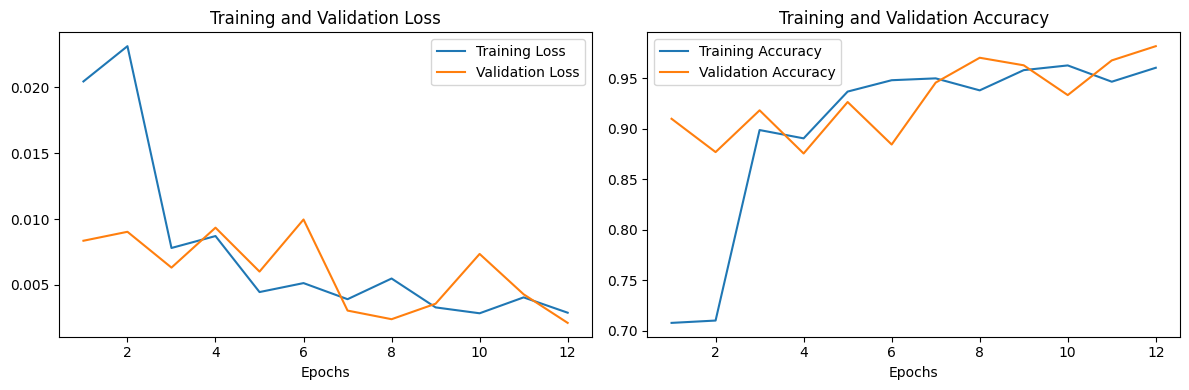

In [ ]:
# Instantiate TrainCurvePlotter with saved training history
plotter = TrainCurvePlotter('training_history_model1.pkl')

# Load training history
plotter.load_training_history()

# Plot training curves
plotter.plot()

**<font size="4">Load Saved Model</font>**

In [ ]:
# Set path to saved model checkpoint
model_path = 'resnet50.pth'

# Initialize model
model_1 = ResNet50(weights='ResNet50_Weights').to(device)

# Load the model
model_1.load_state_dict(torch.load(model_path))

<All keys matched successfully>

**<font size="4">Model 1 Evaluation</font>**

In [ ]:
# Instantiate ModelEvaluator class
evaluator = ModelEvaluator(model_1, test_loader, device)

# Get test accuracy
test_accuracy = evaluator.evaluate()

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Test Accuracy: 95.14%


**<font size="4">Make Predictions</font>**

In [ ]:
# Instantiate ModelPredictor
predictor = ModelPredictor(model_1, test_loader, device)

# Predict the class labels of all the images test loader
predictions, true_labels = predictor.predict()

# Print the accuracy of the model on the test dataset
accuracy = (predictions == true_labels).mean()
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 95.14%


In [ ]:
# Get a random batch from the test loader
random_batch = random.choice(test_loader.dataset)

# Extract the image and label from the random batch
image, label = random_batch

# Add a batch dimension to the image
image = image.unsqueeze(0).to(device)  # Add a batch dimension

# Make predictions for the random image
outputs = model_1(image)

# Get the predicted class label
predicted_class_label = outputs[0].argmax().item()

# Get the class name corresponding to the predicted and true labels
predicted_class_name = classes[predicted_class_label]
true_class_name = classes[label]

# Display results
print(f"Predicted class label: {predicted_class_label}")
print(f"Predicted class name: {predicted_class_name}")
print(f"True class label: {label}")
print(f"True class name: {true_class_name}")

Predicted class label: 1
Predicted class name: meningioma_tumor
True class label: 1
True class name: meningioma_tumor


In [ ]:
# Get a random batch from the test loader
random_batch = random.choice(test_loader.dataset)

# Extract the image and label from the random batch
image, label = random_batch

# Add a batch dimension to the image
image = image.unsqueeze(0).to(device)  # Add a batch dimension

# Make predictions for the random image
outputs = model_1(image)

# Get the predicted class label
predicted_class_label = outputs[0].argmax().item()

# Get the class name corresponding to the predicted and true labels
predicted_class_name = classes[predicted_class_label]
true_class_name = classes[label]

# Display results
print(f"Predicted class label: {predicted_class_label}")
print(f"Predicted class name: {predicted_class_name}")
print(f"True class label: {label}")
print(f"True class name: {true_class_name}")

Predicted class label: 3
Predicted class name: pituitary_tumor
True class label: 3
True class name: pituitary_tumor


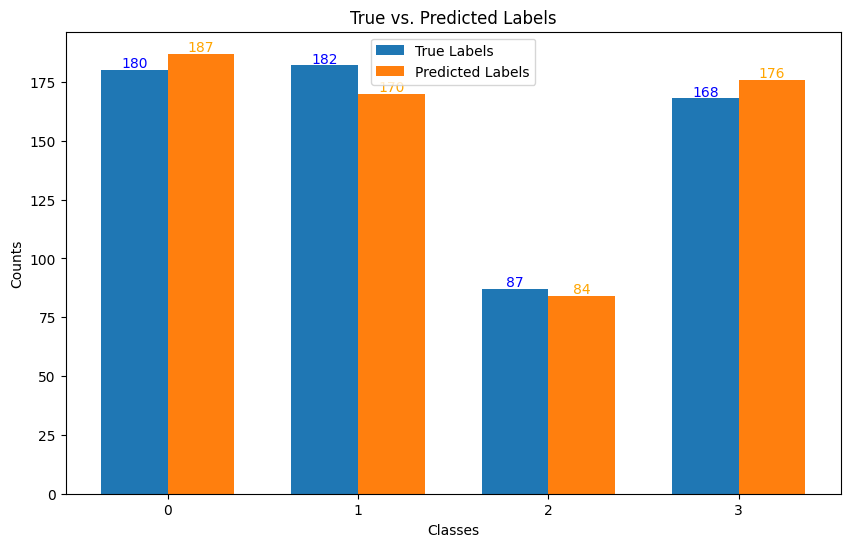

In [ ]:
# Plot the predictions vs. true labels
predictor.plot_predictions()

**<font size="4">Getting Model Performance</font>**

In [ ]:
# Instantiate performance metrics
metrics = PerformanceMetrics(true_labels, predictions, classes)

# Calculate accuracy
accuracy = metrics.calculate_accuracy()
print(f"Accuracy: {accuracy:.2f}%, \n")

# Calculate specificity
specificity = metrics.calculate_specificity()
print(f"Specificity: {specificity:.2f}%, \n")

# Calculate sensitivity
sensitivity = metrics.calculate_sensitivity()
print(f"Sensitivity: {sensitivity:.2f}%, \n")

# Calculate precision
precision = metrics.calculate_precision()
print(f"Precision: {precision:.2f}%, \n")

print("*" * 100)

# Display classification report
report = metrics.generate_classification_report()
print(report)

Accuracy: 95.14%, 

Specificity: 97.77%, 

Sensitivity: 93.68%, 

Precision: 97.60%, 

****************************************************************************************************
                  precision    recall  f1-score   support

    glioma_tumor       0.94      0.97      0.95       180
meningioma_tumor       0.96      0.90      0.93       182
          normal       0.99      0.95      0.97        87
 pituitary_tumor       0.94      0.99      0.97       168

        accuracy                           0.95       617
       macro avg       0.96      0.95      0.95       617
    weighted avg       0.95      0.95      0.95       617



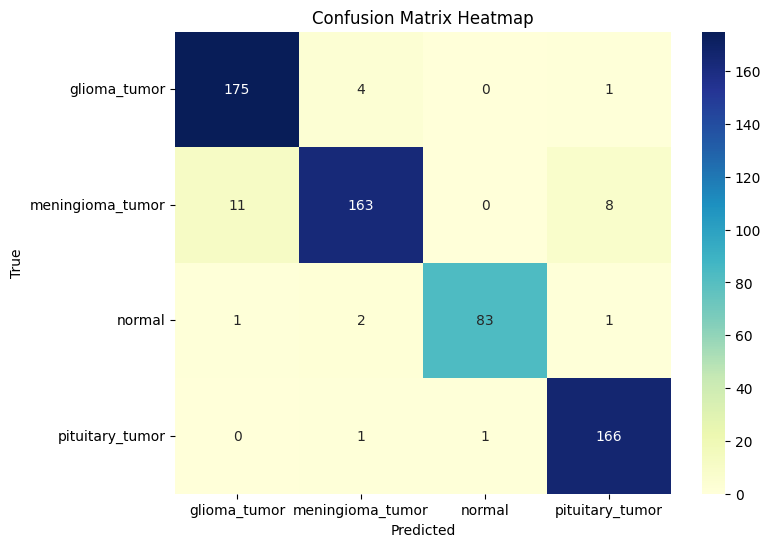

In [ ]:
# Display heatmap
metrics.plot_heatmap()

**<font size="4">Store Results</font>**

In [ ]:
# Store the results of model 1
model_1_results = {
    "Accuracy": accuracy,
    "Specificity": specificity,
    "Sensitivity": sensitivity,
    "Precision": precision,
    "Classification Report": classification_report
}

# Add model 1 results to the dictionary
model_results["Model One"] = model_1_results

## **Model 2 - Pretrained Model from Pytorch Hub: VGG11**


**<font size="4">Setting Up Model Architecture</font>**

In [ ]:
class VGG11WithBN(nn.Module):
    def __init__(self, num_classes=4, weights='VGG11_BN_Weights', freeze_layers=False):
        super(VGG11WithBN, self).__init__()

        # Load a pretrained VGG11 model with specified weights
        if weights == 'VGG11_BN_Weights':
            vgg11 = models.vgg11_bn(weights=VGG11_BN_Weights)

        else:
            vgg11 = models.vgg11_bn()

        if freeze_layers:
            # Freeze all layers except the custom classification layers
            for param in vgg11.parameters():
                param.requires_grad = True

        # Remove the final classification layer
        self.features = vgg11.features

        # Add custom classification layers
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

**<font size="4">Getting Model Summary</font>**

In [ ]:
# Define model 2
model_2 = VGG11WithBN()

# Instantiate ModelSummary
model_summary = ModelSummary(model_2)

# Print model summary
print(model_summary)

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth
100%|██████████| 507M/507M [00:01<00:00, 294MB/s]  


VGG11WithBN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxP

**<font size="4">Cross Validation & Hyperparameter Tuning</font>**

In [ ]:
# Define hyperparameter grid
model_param_grid = {
    'freeze_layers': [True, False],  # Freeze or unfreeze layers
    'weights': ['VGG11_BN_Weights', None],  # Pretrained weights or None
}

trainer_param_grid = {
    'num_epochs': [10, 20],
    'optimizer': [(torch.optim.Adam, {'lr': 0.0001}), (torch.optim.SGD, {'lr': 0.001})],
}

# Instantiate CrossValidatedHyperparameterTuner
cv_tuner = CrossValidatedHyperparameterTuner(
    model_class=VGG11WithBN,
    train_loader=train_loader,
    model_param_grid=model_param_grid,
    trainer_param_grid=trainer_param_grid,
    num_folds=5,
    verbose=True,
)

# Tune model and trainer parameters while performing cross-validation
cv_tuner.tune()

Fold: 1


Epoch [1/10], Training Loss: 0.0227, Training Accuracy: 68.07%: 100%|██████████| 55/55 [00:37<00:00,  1.48it/s]


Epoch [1/10], Validation Loss: 0.0123, Validation Accuracy: 84.30%


Epoch [2/10], Training Loss: 0.0083, Training Accuracy: 89.84%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [2/10], Validation Loss: 0.0111, Validation Accuracy: 85.91%


Epoch [3/10], Training Loss: 0.0056, Training Accuracy: 93.59%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [3/10], Validation Loss: 0.0056, Validation Accuracy: 93.07%


Epoch [4/10], Training Loss: 0.0044, Training Accuracy: 95.27%: 100%|██████████| 55/55 [00:26<00:00,  2.08it/s]


Epoch [4/10], Validation Loss: 0.0111, Validation Accuracy: 85.68%


Epoch [5/10], Training Loss: 0.0031, Training Accuracy: 96.30%: 100%|██████████| 55/55 [00:26<00:00,  2.10it/s]


Epoch [5/10], Validation Loss: 0.0048, Validation Accuracy: 94.92%


Epoch [6/10], Training Loss: 0.0030, Training Accuracy: 96.36%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [6/10], Validation Loss: 0.0101, Validation Accuracy: 92.61%


Epoch [7/10], Training Loss: 0.0037, Training Accuracy: 95.73%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [7/10], Validation Loss: 0.0058, Validation Accuracy: 94.69%


Epoch [8/10], Training Loss: 0.0016, Training Accuracy: 98.67%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [8/10], Validation Loss: 0.0095, Validation Accuracy: 92.84%


Epoch [9/10], Training Loss: 0.0024, Training Accuracy: 97.06%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [9/10], Validation Loss: 0.0086, Validation Accuracy: 93.53%


Epoch [10/10], Training Loss: 0.0013, Training Accuracy: 98.56%: 100%|██████████| 55/55 [00:26<00:00,  2.10it/s]


Epoch [10/10], Validation Loss: 0.0108, Validation Accuracy: 93.53%
Fold 1 Accuracy: 93.30%
Fold: 2


Epoch [1/10], Training Loss: 0.0222, Training Accuracy: 69.75%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [1/10], Validation Loss: 0.0173, Validation Accuracy: 75.29%


Epoch [2/10], Training Loss: 0.0083, Training Accuracy: 90.07%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [2/10], Validation Loss: 0.0087, Validation Accuracy: 91.22%


Epoch [3/10], Training Loss: 0.0047, Training Accuracy: 94.28%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [3/10], Validation Loss: 0.0066, Validation Accuracy: 92.15%


Epoch [4/10], Training Loss: 0.0040, Training Accuracy: 94.52%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [4/10], Validation Loss: 0.0061, Validation Accuracy: 92.61%


Epoch [5/10], Training Loss: 0.0032, Training Accuracy: 96.13%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [5/10], Validation Loss: 0.0092, Validation Accuracy: 91.92%


Epoch [6/10], Training Loss: 0.0037, Training Accuracy: 94.98%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [6/10], Validation Loss: 0.0083, Validation Accuracy: 92.84%


Epoch [7/10], Training Loss: 0.0033, Training Accuracy: 96.59%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [7/10], Validation Loss: 0.0064, Validation Accuracy: 95.15%


Epoch [8/10], Training Loss: 0.0020, Training Accuracy: 97.69%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [8/10], Validation Loss: 0.0059, Validation Accuracy: 95.15%


Epoch [9/10], Training Loss: 0.0014, Training Accuracy: 98.38%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [9/10], Validation Loss: 0.0051, Validation Accuracy: 96.30%


Epoch [10/10], Training Loss: 0.0015, Training Accuracy: 98.56%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [10/10], Validation Loss: 0.0088, Validation Accuracy: 94.69%
Fold 2 Accuracy: 94.46%
Fold: 3


Epoch [1/10], Training Loss: 0.0236, Training Accuracy: 68.82%: 100%|██████████| 55/55 [00:26<00:00,  2.10it/s]


Epoch [1/10], Validation Loss: 0.0182, Validation Accuracy: 78.06%


Epoch [2/10], Training Loss: 0.0086, Training Accuracy: 90.01%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [2/10], Validation Loss: 0.0090, Validation Accuracy: 87.99%


Epoch [3/10], Training Loss: 0.0067, Training Accuracy: 92.15%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [3/10], Validation Loss: 0.0061, Validation Accuracy: 93.30%


Epoch [4/10], Training Loss: 0.0042, Training Accuracy: 95.44%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [4/10], Validation Loss: 0.0059, Validation Accuracy: 93.30%


Epoch [5/10], Training Loss: 0.0046, Training Accuracy: 95.27%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [5/10], Validation Loss: 0.0085, Validation Accuracy: 92.84%


Epoch [6/10], Training Loss: 0.0030, Training Accuracy: 96.36%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [6/10], Validation Loss: 0.0083, Validation Accuracy: 92.61%


Epoch [7/10], Training Loss: 0.0021, Training Accuracy: 97.69%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [7/10], Validation Loss: 0.0080, Validation Accuracy: 93.30%


Epoch [8/10], Training Loss: 0.0016, Training Accuracy: 98.33%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [8/10], Validation Loss: 0.0091, Validation Accuracy: 93.07%


Epoch [9/10], Training Loss: 0.0019, Training Accuracy: 98.09%: 100%|██████████| 55/55 [00:26<00:00,  2.09it/s]


Epoch [9/10], Validation Loss: 0.0104, Validation Accuracy: 91.69%


Epoch [10/10], Training Loss: 0.0015, Training Accuracy: 98.73%: 100%|██████████| 55/55 [00:26<00:00,  2.10it/s]


Epoch [10/10], Validation Loss: 0.0123, Validation Accuracy: 93.30%
Fold 3 Accuracy: 93.30%
Fold: 4


Epoch [1/10], Training Loss: 0.0217, Training Accuracy: 71.71%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [1/10], Validation Loss: 0.0148, Validation Accuracy: 77.60%


Epoch [2/10], Training Loss: 0.0101, Training Accuracy: 86.78%: 100%|██████████| 55/55 [00:26<00:00,  2.10it/s]


Epoch [2/10], Validation Loss: 0.0088, Validation Accuracy: 92.15%


Epoch [3/10], Training Loss: 0.0063, Training Accuracy: 92.78%: 100%|██████████| 55/55 [00:26<00:00,  2.10it/s]


Epoch [3/10], Validation Loss: 0.0056, Validation Accuracy: 93.53%


Epoch [4/10], Training Loss: 0.0050, Training Accuracy: 94.28%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [4/10], Validation Loss: 0.0088, Validation Accuracy: 89.61%


Epoch [5/10], Training Loss: 0.0035, Training Accuracy: 95.90%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [5/10], Validation Loss: 0.0059, Validation Accuracy: 93.53%


Epoch [6/10], Training Loss: 0.0030, Training Accuracy: 96.82%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [6/10], Validation Loss: 0.0054, Validation Accuracy: 94.69%


Epoch [7/10], Training Loss: 0.0023, Training Accuracy: 97.23%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [7/10], Validation Loss: 0.0056, Validation Accuracy: 92.61%


Epoch [8/10], Training Loss: 0.0019, Training Accuracy: 97.63%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [8/10], Validation Loss: 0.0065, Validation Accuracy: 94.00%


Epoch [9/10], Training Loss: 0.0017, Training Accuracy: 98.27%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [9/10], Validation Loss: 0.0066, Validation Accuracy: 94.23%


Epoch [10/10], Training Loss: 0.0021, Training Accuracy: 97.92%: 100%|██████████| 55/55 [00:26<00:00,  2.10it/s]


Epoch [10/10], Validation Loss: 0.0104, Validation Accuracy: 93.07%
Fold 4 Accuracy: 93.53%
Fold: 5


Epoch [1/10], Training Loss: 0.0247, Training Accuracy: 65.99%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [1/10], Validation Loss: 0.0113, Validation Accuracy: 85.91%


Epoch [2/10], Training Loss: 0.0087, Training Accuracy: 89.20%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [2/10], Validation Loss: 0.0105, Validation Accuracy: 86.61%


Epoch [3/10], Training Loss: 0.0083, Training Accuracy: 93.76%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [3/10], Validation Loss: 0.0077, Validation Accuracy: 90.99%


Epoch [4/10], Training Loss: 0.0056, Training Accuracy: 93.48%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [4/10], Validation Loss: 0.0074, Validation Accuracy: 93.53%


Epoch [5/10], Training Loss: 0.0034, Training Accuracy: 96.19%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [5/10], Validation Loss: 0.0103, Validation Accuracy: 91.22%


Epoch [6/10], Training Loss: 0.0031, Training Accuracy: 96.13%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [6/10], Validation Loss: 0.0093, Validation Accuracy: 90.99%


Epoch [7/10], Training Loss: 0.0027, Training Accuracy: 97.17%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [7/10], Validation Loss: 0.0116, Validation Accuracy: 91.45%


Epoch [8/10], Training Loss: 0.0013, Training Accuracy: 98.04%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [8/10], Validation Loss: 0.0082, Validation Accuracy: 94.92%


Epoch [9/10], Training Loss: 0.0014, Training Accuracy: 98.33%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [9/10], Validation Loss: 0.0073, Validation Accuracy: 95.38%


Epoch [10/10], Training Loss: 0.0009, Training Accuracy: 99.13%: 100%|██████████| 55/55 [00:26<00:00,  2.10it/s]


Epoch [10/10], Validation Loss: 0.0084, Validation Accuracy: 94.92%
Fold 5 Accuracy: 94.46%
Model Parameters: {'freeze_layers': True, 'weights': 'VGG11_BN_Weights'}, Trainer Parameters: {'num_epochs': 10, 'optimizer': (<class 'torch.optim.adam.Adam'>, {'lr': 0.0001})}
Fold Accuracies: [93.30254041570439, 94.45727482678984, 93.30254041570439, 93.53348729792148, 94.45727482678984]
Mean Accuracy: 93.81%, Std Accuracy: 0.53, Score: 93.28
Fold: 1


Epoch [1/10], Training Loss: 0.0439, Training Accuracy: 27.19%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [1/10], Validation Loss: 0.0446, Validation Accuracy: 35.80%


Epoch [2/10], Training Loss: 0.0436, Training Accuracy: 32.51%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [2/10], Validation Loss: 0.0441, Validation Accuracy: 47.81%


Epoch [3/10], Training Loss: 0.0434, Training Accuracy: 35.28%: 100%|██████████| 55/55 [00:24<00:00,  2.28it/s]


Epoch [3/10], Validation Loss: 0.0436, Validation Accuracy: 56.58%


Epoch [4/10], Training Loss: 0.0429, Training Accuracy: 41.69%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [4/10], Validation Loss: 0.0433, Validation Accuracy: 56.58%


Epoch [5/10], Training Loss: 0.0424, Training Accuracy: 44.98%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [5/10], Validation Loss: 0.0428, Validation Accuracy: 57.74%


Epoch [6/10], Training Loss: 0.0421, Training Accuracy: 48.15%: 100%|██████████| 55/55 [00:23<00:00,  2.29it/s]


Epoch [6/10], Validation Loss: 0.0423, Validation Accuracy: 61.89%


Epoch [7/10], Training Loss: 0.0414, Training Accuracy: 52.37%: 100%|██████████| 55/55 [00:24<00:00,  2.28it/s]


Epoch [7/10], Validation Loss: 0.0415, Validation Accuracy: 60.74%


Epoch [8/10], Training Loss: 0.0408, Training Accuracy: 55.89%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [8/10], Validation Loss: 0.0407, Validation Accuracy: 65.59%


Epoch [9/10], Training Loss: 0.0401, Training Accuracy: 57.62%: 100%|██████████| 55/55 [00:24<00:00,  2.28it/s]


Epoch [9/10], Validation Loss: 0.0396, Validation Accuracy: 65.59%


Epoch [10/10], Training Loss: 0.0392, Training Accuracy: 60.57%: 100%|██████████| 55/55 [00:24<00:00,  2.28it/s]


Epoch [10/10], Validation Loss: 0.0386, Validation Accuracy: 65.13%
Fold 1 Accuracy: 64.43%
Fold: 2


Epoch [1/10], Training Loss: 0.0440, Training Accuracy: 26.44%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [1/10], Validation Loss: 0.0446, Validation Accuracy: 37.18%


Epoch [2/10], Training Loss: 0.0437, Training Accuracy: 33.49%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [2/10], Validation Loss: 0.0442, Validation Accuracy: 44.80%


Epoch [3/10], Training Loss: 0.0435, Training Accuracy: 33.55%: 100%|██████████| 55/55 [00:23<00:00,  2.29it/s]


Epoch [3/10], Validation Loss: 0.0438, Validation Accuracy: 52.19%


Epoch [4/10], Training Loss: 0.0430, Training Accuracy: 41.45%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [4/10], Validation Loss: 0.0434, Validation Accuracy: 54.04%


Epoch [5/10], Training Loss: 0.0426, Training Accuracy: 44.46%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [5/10], Validation Loss: 0.0430, Validation Accuracy: 55.89%


Epoch [6/10], Training Loss: 0.0422, Training Accuracy: 50.06%: 100%|██████████| 55/55 [00:24<00:00,  2.29it/s]


Epoch [6/10], Validation Loss: 0.0425, Validation Accuracy: 62.59%


Epoch [7/10], Training Loss: 0.0416, Training Accuracy: 53.52%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [7/10], Validation Loss: 0.0418, Validation Accuracy: 66.97%


Epoch [8/10], Training Loss: 0.0410, Training Accuracy: 57.62%: 100%|██████████| 55/55 [00:23<00:00,  2.29it/s]


Epoch [8/10], Validation Loss: 0.0409, Validation Accuracy: 66.05%


Epoch [9/10], Training Loss: 0.0403, Training Accuracy: 59.01%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [9/10], Validation Loss: 0.0403, Validation Accuracy: 68.82%


Epoch [10/10], Training Loss: 0.0394, Training Accuracy: 61.61%: 100%|██████████| 55/55 [00:23<00:00,  2.29it/s]


Epoch [10/10], Validation Loss: 0.0392, Validation Accuracy: 66.28%
Fold 2 Accuracy: 66.51%
Fold: 3


Epoch [1/10], Training Loss: 0.0440, Training Accuracy: 25.58%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [1/10], Validation Loss: 0.0446, Validation Accuracy: 38.57%


Epoch [2/10], Training Loss: 0.0436, Training Accuracy: 32.97%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [2/10], Validation Loss: 0.0442, Validation Accuracy: 49.65%


Epoch [3/10], Training Loss: 0.0434, Training Accuracy: 36.61%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [3/10], Validation Loss: 0.0440, Validation Accuracy: 54.04%


Epoch [4/10], Training Loss: 0.0430, Training Accuracy: 41.97%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [4/10], Validation Loss: 0.0435, Validation Accuracy: 57.97%


Epoch [5/10], Training Loss: 0.0425, Training Accuracy: 48.04%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [5/10], Validation Loss: 0.0429, Validation Accuracy: 63.28%


Epoch [6/10], Training Loss: 0.0420, Training Accuracy: 53.18%: 100%|██████████| 55/55 [00:24<00:00,  2.28it/s]


Epoch [6/10], Validation Loss: 0.0422, Validation Accuracy: 67.21%


Epoch [7/10], Training Loss: 0.0414, Training Accuracy: 55.48%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [7/10], Validation Loss: 0.0418, Validation Accuracy: 69.52%


Epoch [8/10], Training Loss: 0.0407, Training Accuracy: 61.03%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [8/10], Validation Loss: 0.0409, Validation Accuracy: 68.36%


Epoch [9/10], Training Loss: 0.0400, Training Accuracy: 62.47%: 100%|██████████| 55/55 [00:24<00:00,  2.29it/s]


Epoch [9/10], Validation Loss: 0.0402, Validation Accuracy: 68.82%


Epoch [10/10], Training Loss: 0.0389, Training Accuracy: 65.94%: 100%|██████████| 55/55 [00:23<00:00,  2.29it/s]


Epoch [10/10], Validation Loss: 0.0390, Validation Accuracy: 69.98%
Fold 3 Accuracy: 67.90%
Fold: 4


Epoch [1/10], Training Loss: 0.0439, Training Accuracy: 28.52%: 100%|██████████| 55/55 [00:23<00:00,  2.29it/s]


Epoch [1/10], Validation Loss: 0.0446, Validation Accuracy: 32.10%


Epoch [2/10], Training Loss: 0.0436, Training Accuracy: 33.78%: 100%|██████████| 55/55 [00:24<00:00,  2.29it/s]


Epoch [2/10], Validation Loss: 0.0442, Validation Accuracy: 38.80%


Epoch [3/10], Training Loss: 0.0433, Training Accuracy: 35.16%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [3/10], Validation Loss: 0.0436, Validation Accuracy: 52.19%


Epoch [4/10], Training Loss: 0.0428, Training Accuracy: 42.78%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [4/10], Validation Loss: 0.0431, Validation Accuracy: 57.27%


Epoch [5/10], Training Loss: 0.0425, Training Accuracy: 44.11%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [5/10], Validation Loss: 0.0427, Validation Accuracy: 63.74%


Epoch [6/10], Training Loss: 0.0418, Training Accuracy: 52.08%: 100%|██████████| 55/55 [00:23<00:00,  2.29it/s]


Epoch [6/10], Validation Loss: 0.0422, Validation Accuracy: 63.97%


Epoch [7/10], Training Loss: 0.0412, Training Accuracy: 54.91%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [7/10], Validation Loss: 0.0414, Validation Accuracy: 67.90%


Epoch [8/10], Training Loss: 0.0406, Training Accuracy: 57.27%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [8/10], Validation Loss: 0.0408, Validation Accuracy: 68.36%


Epoch [9/10], Training Loss: 0.0397, Training Accuracy: 60.91%: 100%|██████████| 55/55 [00:24<00:00,  2.28it/s]


Epoch [9/10], Validation Loss: 0.0394, Validation Accuracy: 68.36%


Epoch [10/10], Training Loss: 0.0386, Training Accuracy: 63.45%: 100%|██████████| 55/55 [00:24<00:00,  2.29it/s]


Epoch [10/10], Validation Loss: 0.0380, Validation Accuracy: 71.13%
Fold 4 Accuracy: 68.36%
Fold: 5


Epoch [1/10], Training Loss: 0.0439, Training Accuracy: 29.56%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [1/10], Validation Loss: 0.0446, Validation Accuracy: 33.49%


Epoch [2/10], Training Loss: 0.0437, Training Accuracy: 35.39%: 100%|██████████| 55/55 [00:24<00:00,  2.28it/s]


Epoch [2/10], Validation Loss: 0.0443, Validation Accuracy: 46.88%


Epoch [3/10], Training Loss: 0.0434, Training Accuracy: 37.93%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [3/10], Validation Loss: 0.0437, Validation Accuracy: 56.12%


Epoch [4/10], Training Loss: 0.0430, Training Accuracy: 39.61%: 100%|██████████| 55/55 [00:24<00:00,  2.29it/s]


Epoch [4/10], Validation Loss: 0.0433, Validation Accuracy: 61.66%


Epoch [5/10], Training Loss: 0.0426, Training Accuracy: 46.77%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [5/10], Validation Loss: 0.0428, Validation Accuracy: 68.13%


Epoch [6/10], Training Loss: 0.0422, Training Accuracy: 50.29%: 100%|██████████| 55/55 [00:24<00:00,  2.28it/s]


Epoch [6/10], Validation Loss: 0.0423, Validation Accuracy: 71.13%


Epoch [7/10], Training Loss: 0.0414, Training Accuracy: 56.52%: 100%|██████████| 55/55 [00:24<00:00,  2.28it/s]


Epoch [7/10], Validation Loss: 0.0413, Validation Accuracy: 70.67%


Epoch [8/10], Training Loss: 0.0407, Training Accuracy: 59.24%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [8/10], Validation Loss: 0.0407, Validation Accuracy: 69.28%


Epoch [9/10], Training Loss: 0.0401, Training Accuracy: 60.51%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [9/10], Validation Loss: 0.0393, Validation Accuracy: 72.29%


Epoch [10/10], Training Loss: 0.0391, Training Accuracy: 63.63%: 100%|██████████| 55/55 [00:24<00:00,  2.29it/s]


Epoch [10/10], Validation Loss: 0.0384, Validation Accuracy: 69.75%
Fold 5 Accuracy: 71.59%
Model Parameters: {'freeze_layers': True, 'weights': 'VGG11_BN_Weights'}, Trainer Parameters: {'num_epochs': 10, 'optimizer': (<class 'torch.optim.sgd.SGD'>, {'lr': 0.001})}
Fold Accuracies: [64.43418013856814, 66.51270207852194, 67.89838337182448, 68.36027713625866, 71.59353348729792]
Mean Accuracy: 67.76%, Std Accuracy: 2.35, Score: 65.41
Fold: 1


Epoch [1/20], Training Loss: 0.0241, Training Accuracy: 67.67%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [1/20], Validation Loss: 0.0116, Validation Accuracy: 86.61%


Epoch [2/20], Training Loss: 0.0100, Training Accuracy: 88.16%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [2/20], Validation Loss: 0.0095, Validation Accuracy: 88.45%


Epoch [3/20], Training Loss: 0.0061, Training Accuracy: 92.84%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [3/20], Validation Loss: 0.0089, Validation Accuracy: 90.76%


Epoch [4/20], Training Loss: 0.0045, Training Accuracy: 94.86%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [4/20], Validation Loss: 0.0064, Validation Accuracy: 92.38%


Epoch [5/20], Training Loss: 0.0031, Training Accuracy: 95.90%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [5/20], Validation Loss: 0.0089, Validation Accuracy: 91.92%


Epoch [6/20], Training Loss: 0.0032, Training Accuracy: 96.42%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [6/20], Validation Loss: 0.0089, Validation Accuracy: 94.00%


Epoch [7/20], Training Loss: 0.0030, Training Accuracy: 97.00%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [7/20], Validation Loss: 0.0097, Validation Accuracy: 91.69%


Epoch [8/20], Training Loss: 0.0024, Training Accuracy: 97.00%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [8/20], Validation Loss: 0.0099, Validation Accuracy: 92.84%


Epoch [9/20], Training Loss: 0.0022, Training Accuracy: 97.69%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [9/20], Validation Loss: 0.0089, Validation Accuracy: 91.92%


Epoch [10/20], Training Loss: 0.0023, Training Accuracy: 97.34%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [10/20], Validation Loss: 0.0060, Validation Accuracy: 93.53%


Epoch [11/20], Training Loss: 0.0013, Training Accuracy: 98.61%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [11/20], Validation Loss: 0.0062, Validation Accuracy: 94.92%


Epoch [12/20], Training Loss: 0.0011, Training Accuracy: 98.90%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [12/20], Validation Loss: 0.0062, Validation Accuracy: 95.15%


Epoch [13/20], Training Loss: 0.0006, Training Accuracy: 99.19%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [13/20], Validation Loss: 0.0097, Validation Accuracy: 93.07%


Epoch [14/20], Training Loss: 0.0015, Training Accuracy: 98.38%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [14/20], Validation Loss: 0.0058, Validation Accuracy: 95.15%


Epoch [15/20], Training Loss: 0.0010, Training Accuracy: 98.96%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [15/20], Validation Loss: 0.0138, Validation Accuracy: 89.84%


Epoch [16/20], Training Loss: 0.0019, Training Accuracy: 98.27%: 100%|██████████| 55/55 [00:26<00:00,  2.10it/s]


Epoch [16/20], Validation Loss: 0.0086, Validation Accuracy: 94.23%


Epoch [17/20], Training Loss: 0.0010, Training Accuracy: 98.61%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [17/20], Validation Loss: 0.0100, Validation Accuracy: 94.69%


Epoch [18/20], Training Loss: 0.0022, Training Accuracy: 98.04%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [18/20], Validation Loss: 0.0077, Validation Accuracy: 93.76%


Epoch [19/20], Training Loss: 0.0029, Training Accuracy: 97.23%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [19/20], Validation Loss: 0.0096, Validation Accuracy: 92.61%


Epoch [20/20], Training Loss: 0.0011, Training Accuracy: 98.73%: 100%|██████████| 55/55 [00:26<00:00,  2.10it/s]


Epoch [20/20], Validation Loss: 0.0094, Validation Accuracy: 94.00%
Fold 1 Accuracy: 95.38%
Fold: 2


Epoch [1/20], Training Loss: 0.0225, Training Accuracy: 69.00%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [1/20], Validation Loss: 0.0151, Validation Accuracy: 79.21%


Epoch [2/20], Training Loss: 0.0083, Training Accuracy: 88.80%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [2/20], Validation Loss: 0.0124, Validation Accuracy: 84.76%


Epoch [3/20], Training Loss: 0.0064, Training Accuracy: 92.26%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [3/20], Validation Loss: 0.0097, Validation Accuracy: 89.61%


Epoch [4/20], Training Loss: 0.0047, Training Accuracy: 95.09%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [4/20], Validation Loss: 0.0071, Validation Accuracy: 93.07%


Epoch [5/20], Training Loss: 0.0029, Training Accuracy: 96.65%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [5/20], Validation Loss: 0.0089, Validation Accuracy: 91.69%


Epoch [6/20], Training Loss: 0.0032, Training Accuracy: 95.55%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [6/20], Validation Loss: 0.0081, Validation Accuracy: 93.53%


Epoch [11/20], Training Loss: 0.0015, Training Accuracy: 98.15%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [11/20], Validation Loss: 0.0094, Validation Accuracy: 90.99%


Epoch [12/20], Training Loss: 0.0008, Training Accuracy: 98.96%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [12/20], Validation Loss: 0.0080, Validation Accuracy: 94.23%


Epoch [13/20], Training Loss: 0.0017, Training Accuracy: 98.15%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [13/20], Validation Loss: 0.0059, Validation Accuracy: 93.30%


Epoch [14/20], Training Loss: 0.0009, Training Accuracy: 99.13%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [14/20], Validation Loss: 0.0069, Validation Accuracy: 94.46%


Epoch [15/20], Training Loss: 0.0019, Training Accuracy: 98.73%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [15/20], Validation Loss: 0.0097, Validation Accuracy: 94.00%


Epoch [16/20], Training Loss: 0.0018, Training Accuracy: 97.81%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [16/20], Validation Loss: 0.0111, Validation Accuracy: 95.38%


Epoch [17/20], Training Loss: 0.0017, Training Accuracy: 97.92%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [17/20], Validation Loss: 0.0203, Validation Accuracy: 87.99%


Epoch [18/20], Training Loss: 0.0023, Training Accuracy: 98.61%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [18/20], Validation Loss: 0.0079, Validation Accuracy: 95.84%


Epoch [19/20], Training Loss: 0.0022, Training Accuracy: 97.40%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [19/20], Validation Loss: 0.0090, Validation Accuracy: 94.23%


Epoch [20/20], Training Loss: 0.0041, Training Accuracy: 96.42%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [20/20], Validation Loss: 0.0104, Validation Accuracy: 94.23%
Fold 2 Accuracy: 94.00%
Fold: 3


Epoch [1/20], Training Loss: 0.0231, Training Accuracy: 69.69%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [1/20], Validation Loss: 0.0149, Validation Accuracy: 80.37%


Epoch [2/20], Training Loss: 0.0098, Training Accuracy: 89.72%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [2/20], Validation Loss: 0.0087, Validation Accuracy: 88.68%


Epoch [3/20], Training Loss: 0.0073, Training Accuracy: 92.26%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [3/20], Validation Loss: 0.0094, Validation Accuracy: 88.91%


Epoch [4/20], Training Loss: 0.0039, Training Accuracy: 95.27%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [4/20], Validation Loss: 0.0068, Validation Accuracy: 93.30%


Epoch [5/20], Training Loss: 0.0032, Training Accuracy: 96.19%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [5/20], Validation Loss: 0.0063, Validation Accuracy: 92.38%


Epoch [6/20], Training Loss: 0.0021, Training Accuracy: 97.40%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [6/20], Validation Loss: 0.0080, Validation Accuracy: 92.15%


Epoch [7/20], Training Loss: 0.0022, Training Accuracy: 97.69%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [7/20], Validation Loss: 0.0130, Validation Accuracy: 90.30%


Epoch [8/20], Training Loss: 0.0023, Training Accuracy: 97.17%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [8/20], Validation Loss: 0.0081, Validation Accuracy: 92.61%


Epoch [9/20], Training Loss: 0.0015, Training Accuracy: 98.50%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [9/20], Validation Loss: 0.0097, Validation Accuracy: 91.69%


Epoch [10/20], Training Loss: 0.0021, Training Accuracy: 97.92%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [10/20], Validation Loss: 0.0082, Validation Accuracy: 90.99%


Epoch [11/20], Training Loss: 0.0013, Training Accuracy: 98.27%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [11/20], Validation Loss: 0.0081, Validation Accuracy: 93.30%


Epoch [12/20], Training Loss: 0.0010, Training Accuracy: 99.02%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [12/20], Validation Loss: 0.0101, Validation Accuracy: 93.53%


Epoch [13/20], Training Loss: 0.0008, Training Accuracy: 99.42%: 100%|██████████| 55/55 [00:26<00:00,  2.10it/s] 


Epoch [13/20], Validation Loss: 0.0082, Validation Accuracy: 94.23%


Epoch [14/20], Training Loss: 0.0008, Training Accuracy: 98.79%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [14/20], Validation Loss: 0.0101, Validation Accuracy: 92.84%


Epoch [17/20], Training Loss: 0.0012, Training Accuracy: 98.73%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [17/20], Validation Loss: 0.0099, Validation Accuracy: 93.07%


Epoch [18/20], Training Loss: 0.0008, Training Accuracy: 99.19%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [18/20], Validation Loss: 0.0122, Validation Accuracy: 93.53%


Epoch [19/20], Training Loss: 0.0006, Training Accuracy: 99.42%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [19/20], Validation Loss: 0.0179, Validation Accuracy: 90.30%


Epoch [20/20], Training Loss: 0.0013, Training Accuracy: 98.85%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [20/20], Validation Loss: 0.0097, Validation Accuracy: 93.53%
Fold 3 Accuracy: 92.15%
Fold: 4


Epoch [5/20], Training Loss: 0.0036, Training Accuracy: 95.79%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [5/20], Validation Loss: 0.0050, Validation Accuracy: 94.92%


Epoch [6/20], Training Loss: 0.0040, Training Accuracy: 95.73%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [6/20], Validation Loss: 0.0042, Validation Accuracy: 94.92%


Epoch [7/20], Training Loss: 0.0019, Training Accuracy: 97.86%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [7/20], Validation Loss: 0.0064, Validation Accuracy: 92.61%


Epoch [8/20], Training Loss: 0.0026, Training Accuracy: 96.94%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [8/20], Validation Loss: 0.0062, Validation Accuracy: 94.46%


Epoch [9/20], Training Loss: 0.0030, Training Accuracy: 97.06%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [9/20], Validation Loss: 0.0050, Validation Accuracy: 92.84%


Epoch [10/20], Training Loss: 0.0013, Training Accuracy: 98.44%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [10/20], Validation Loss: 0.0045, Validation Accuracy: 94.92%


Epoch [11/20], Training Loss: 0.0021, Training Accuracy: 98.27%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [11/20], Validation Loss: 0.0061, Validation Accuracy: 92.61%


Epoch [12/20], Training Loss: 0.0013, Training Accuracy: 98.33%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [12/20], Validation Loss: 0.0124, Validation Accuracy: 90.07%


Epoch [13/20], Training Loss: 0.0014, Training Accuracy: 98.73%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [13/20], Validation Loss: 0.0064, Validation Accuracy: 94.69%


Epoch [14/20], Training Loss: 0.0008, Training Accuracy: 98.73%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [14/20], Validation Loss: 0.0080, Validation Accuracy: 94.46%


Epoch [15/20], Training Loss: 0.0010, Training Accuracy: 98.90%: 100%|██████████| 55/55 [00:26<00:00,  2.10it/s]


Epoch [15/20], Validation Loss: 0.0058, Validation Accuracy: 94.23%


Epoch [16/20], Training Loss: 0.0009, Training Accuracy: 98.73%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [16/20], Validation Loss: 0.0111, Validation Accuracy: 90.76%


Epoch [17/20], Training Loss: 0.0006, Training Accuracy: 99.25%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [17/20], Validation Loss: 0.0051, Validation Accuracy: 95.84%


Epoch [18/20], Training Loss: 0.0006, Training Accuracy: 99.25%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [18/20], Validation Loss: 0.0066, Validation Accuracy: 93.07%


Epoch [19/20], Training Loss: 0.0006, Training Accuracy: 99.36%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s] 


Epoch [19/20], Validation Loss: 0.0104, Validation Accuracy: 92.15%


Epoch [20/20], Training Loss: 0.0011, Training Accuracy: 99.13%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [20/20], Validation Loss: 0.0058, Validation Accuracy: 95.15%
Fold 4 Accuracy: 93.53%
Fold: 5


Epoch [1/20], Training Loss: 0.0226, Training Accuracy: 70.67%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [1/20], Validation Loss: 0.0112, Validation Accuracy: 85.68%


Epoch [2/20], Training Loss: 0.0099, Training Accuracy: 88.68%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [2/20], Validation Loss: 0.0073, Validation Accuracy: 92.15%


Epoch [3/20], Training Loss: 0.0062, Training Accuracy: 92.26%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [3/20], Validation Loss: 0.0091, Validation Accuracy: 91.22%


Epoch [4/20], Training Loss: 0.0046, Training Accuracy: 94.11%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [4/20], Validation Loss: 0.0079, Validation Accuracy: 90.30%


Epoch [5/20], Training Loss: 0.0038, Training Accuracy: 95.15%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [5/20], Validation Loss: 0.0102, Validation Accuracy: 91.22%


Epoch [6/20], Training Loss: 0.0028, Training Accuracy: 96.71%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [6/20], Validation Loss: 0.0109, Validation Accuracy: 92.15%


Epoch [7/20], Training Loss: 0.0031, Training Accuracy: 96.36%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [7/20], Validation Loss: 0.0086, Validation Accuracy: 92.15%


Epoch [8/20], Training Loss: 0.0025, Training Accuracy: 96.77%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [8/20], Validation Loss: 0.0064, Validation Accuracy: 94.69%


Epoch [9/20], Training Loss: 0.0020, Training Accuracy: 97.75%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [9/20], Validation Loss: 0.0095, Validation Accuracy: 94.46%


Epoch [10/20], Training Loss: 0.0014, Training Accuracy: 98.50%: 100%|██████████| 55/55 [00:26<00:00,  2.10it/s]


Epoch [10/20], Validation Loss: 0.0118, Validation Accuracy: 93.07%


Epoch [11/20], Training Loss: 0.0019, Training Accuracy: 97.75%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [11/20], Validation Loss: 0.0107, Validation Accuracy: 92.61%


Epoch [12/20], Training Loss: 0.0017, Training Accuracy: 98.33%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [12/20], Validation Loss: 0.0083, Validation Accuracy: 94.69%


Epoch [13/20], Training Loss: 0.0012, Training Accuracy: 98.67%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [13/20], Validation Loss: 0.0091, Validation Accuracy: 94.23%


Epoch [14/20], Training Loss: 0.0009, Training Accuracy: 98.90%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [14/20], Validation Loss: 0.0079, Validation Accuracy: 94.92%


Epoch [15/20], Training Loss: 0.0006, Training Accuracy: 99.31%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [15/20], Validation Loss: 0.0080, Validation Accuracy: 94.23%


Epoch [16/20], Training Loss: 0.0010, Training Accuracy: 99.02%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [16/20], Validation Loss: 0.0104, Validation Accuracy: 93.76%


Epoch [17/20], Training Loss: 0.0019, Training Accuracy: 98.21%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [17/20], Validation Loss: 0.0090, Validation Accuracy: 94.46%


Epoch [18/20], Training Loss: 0.0008, Training Accuracy: 99.25%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [18/20], Validation Loss: 0.0103, Validation Accuracy: 93.53%


Epoch [19/20], Training Loss: 0.0042, Training Accuracy: 98.56%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [19/20], Validation Loss: 0.0095, Validation Accuracy: 94.00%


Epoch [20/20], Training Loss: 0.0036, Training Accuracy: 95.73%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [20/20], Validation Loss: 0.0105, Validation Accuracy: 93.53%
Fold 5 Accuracy: 93.07%
Model Parameters: {'freeze_layers': True, 'weights': 'VGG11_BN_Weights'}, Trainer Parameters: {'num_epochs': 20, 'optimizer': (<class 'torch.optim.adam.Adam'>, {'lr': 0.0001})}
Fold Accuracies: [95.3810623556582, 93.99538106235565, 92.14780600461894, 93.53348729792148, 93.0715935334873]
Mean Accuracy: 93.63%, Std Accuracy: 1.07, Score: 92.56
Fold: 1


Epoch [1/20], Training Loss: 0.0440, Training Accuracy: 27.48%: 100%|██████████| 55/55 [00:24<00:00,  2.29it/s]


Epoch [1/20], Validation Loss: 0.0446, Validation Accuracy: 32.33%


Epoch [2/20], Training Loss: 0.0437, Training Accuracy: 33.08%: 100%|██████████| 55/55 [00:23<00:00,  2.29it/s]


Epoch [2/20], Validation Loss: 0.0443, Validation Accuracy: 44.80%


Epoch [3/20], Training Loss: 0.0435, Training Accuracy: 37.88%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [3/20], Validation Loss: 0.0440, Validation Accuracy: 58.66%


Epoch [4/20], Training Loss: 0.0431, Training Accuracy: 40.47%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [4/20], Validation Loss: 0.0435, Validation Accuracy: 60.05%


Epoch [5/20], Training Loss: 0.0427, Training Accuracy: 46.59%: 100%|██████████| 55/55 [00:23<00:00,  2.29it/s]


Epoch [5/20], Validation Loss: 0.0430, Validation Accuracy: 63.97%


Epoch [6/20], Training Loss: 0.0422, Training Accuracy: 47.75%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [6/20], Validation Loss: 0.0424, Validation Accuracy: 63.28%


Epoch [7/20], Training Loss: 0.0416, Training Accuracy: 51.85%: 100%|██████████| 55/55 [00:24<00:00,  2.29it/s]


Epoch [7/20], Validation Loss: 0.0418, Validation Accuracy: 65.36%


Epoch [8/20], Training Loss: 0.0411, Training Accuracy: 55.48%: 100%|██████████| 55/55 [00:24<00:00,  2.29it/s]


Epoch [8/20], Validation Loss: 0.0412, Validation Accuracy: 70.44%


Epoch [9/20], Training Loss: 0.0404, Training Accuracy: 58.60%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [9/20], Validation Loss: 0.0403, Validation Accuracy: 72.29%


Epoch [10/20], Training Loss: 0.0395, Training Accuracy: 62.64%: 100%|██████████| 55/55 [00:24<00:00,  2.29it/s]


Epoch [10/20], Validation Loss: 0.0394, Validation Accuracy: 70.44%


Epoch [11/20], Training Loss: 0.0384, Training Accuracy: 64.67%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [11/20], Validation Loss: 0.0378, Validation Accuracy: 70.44%


Epoch [12/20], Training Loss: 0.0374, Training Accuracy: 64.38%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [12/20], Validation Loss: 0.0367, Validation Accuracy: 69.52%


Epoch [13/20], Training Loss: 0.0361, Training Accuracy: 66.51%: 100%|██████████| 55/55 [00:24<00:00,  2.29it/s]


Epoch [13/20], Validation Loss: 0.0347, Validation Accuracy: 72.06%


Epoch [14/20], Training Loss: 0.0345, Training Accuracy: 68.65%: 100%|██████████| 55/55 [00:23<00:00,  2.29it/s]


Epoch [14/20], Validation Loss: 0.0334, Validation Accuracy: 72.06%


Epoch [15/20], Training Loss: 0.0330, Training Accuracy: 69.05%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [15/20], Validation Loss: 0.0311, Validation Accuracy: 74.36%


Epoch [16/20], Training Loss: 0.0313, Training Accuracy: 71.02%: 100%|██████████| 55/55 [00:23<00:00,  2.29it/s]


Epoch [16/20], Validation Loss: 0.0298, Validation Accuracy: 73.21%


Epoch [17/20], Training Loss: 0.0296, Training Accuracy: 71.59%: 100%|██████████| 55/55 [00:23<00:00,  2.29it/s]


Epoch [17/20], Validation Loss: 0.0283, Validation Accuracy: 73.90%


Epoch [18/20], Training Loss: 0.0278, Training Accuracy: 69.98%: 100%|██████████| 55/55 [00:24<00:00,  2.29it/s]


Epoch [18/20], Validation Loss: 0.0258, Validation Accuracy: 76.91%


Epoch [19/20], Training Loss: 0.0263, Training Accuracy: 74.08%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [19/20], Validation Loss: 0.0242, Validation Accuracy: 76.91%


Epoch [20/20], Training Loss: 0.0248, Training Accuracy: 74.19%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [20/20], Validation Loss: 0.0230, Validation Accuracy: 76.21%
Fold 1 Accuracy: 76.21%
Fold: 2


Epoch [1/20], Training Loss: 0.0439, Training Accuracy: 28.93%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [1/20], Validation Loss: 0.0446, Validation Accuracy: 33.72%


Epoch [2/20], Training Loss: 0.0436, Training Accuracy: 34.01%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [2/20], Validation Loss: 0.0442, Validation Accuracy: 47.81%


Epoch [3/20], Training Loss: 0.0433, Training Accuracy: 37.30%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [3/20], Validation Loss: 0.0437, Validation Accuracy: 48.50%


Epoch [4/20], Training Loss: 0.0427, Training Accuracy: 44.69%: 100%|██████████| 55/55 [00:24<00:00,  2.28it/s]


Epoch [4/20], Validation Loss: 0.0432, Validation Accuracy: 58.20%


Epoch [5/20], Training Loss: 0.0425, Training Accuracy: 46.71%: 100%|██████████| 55/55 [00:24<00:00,  2.28it/s]


Epoch [5/20], Validation Loss: 0.0427, Validation Accuracy: 63.74%


Epoch [6/20], Training Loss: 0.0418, Training Accuracy: 53.23%: 100%|██████████| 55/55 [00:23<00:00,  2.29it/s]


Epoch [6/20], Validation Loss: 0.0421, Validation Accuracy: 66.74%


Epoch [7/20], Training Loss: 0.0413, Training Accuracy: 56.24%: 100%|██████████| 55/55 [00:24<00:00,  2.29it/s]


Epoch [7/20], Validation Loss: 0.0415, Validation Accuracy: 68.36%


Epoch [8/20], Training Loss: 0.0406, Training Accuracy: 57.10%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [8/20], Validation Loss: 0.0405, Validation Accuracy: 67.21%


Epoch [9/20], Training Loss: 0.0397, Training Accuracy: 61.37%: 100%|██████████| 55/55 [00:23<00:00,  2.29it/s]


Epoch [9/20], Validation Loss: 0.0394, Validation Accuracy: 69.98%


Epoch [10/20], Training Loss: 0.0388, Training Accuracy: 63.28%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [10/20], Validation Loss: 0.0386, Validation Accuracy: 68.36%


Epoch [11/20], Training Loss: 0.0376, Training Accuracy: 66.63%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [11/20], Validation Loss: 0.0371, Validation Accuracy: 69.75%


Epoch [12/20], Training Loss: 0.0365, Training Accuracy: 65.07%: 100%|██████████| 55/55 [00:23<00:00,  2.29it/s]


Epoch [12/20], Validation Loss: 0.0358, Validation Accuracy: 69.05%


Epoch [13/20], Training Loss: 0.0349, Training Accuracy: 68.24%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [13/20], Validation Loss: 0.0342, Validation Accuracy: 70.21%


Epoch [14/20], Training Loss: 0.0332, Training Accuracy: 69.28%: 100%|██████████| 55/55 [00:23<00:00,  2.29it/s]


Epoch [14/20], Validation Loss: 0.0316, Validation Accuracy: 72.75%


Epoch [15/20], Training Loss: 0.0313, Training Accuracy: 70.15%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [15/20], Validation Loss: 0.0299, Validation Accuracy: 70.21%


Epoch [16/20], Training Loss: 0.0302, Training Accuracy: 71.13%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [16/20], Validation Loss: 0.0288, Validation Accuracy: 72.98%


Epoch [17/20], Training Loss: 0.0288, Training Accuracy: 71.36%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [17/20], Validation Loss: 0.0264, Validation Accuracy: 71.82%


Epoch [18/20], Training Loss: 0.0270, Training Accuracy: 73.09%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [18/20], Validation Loss: 0.0263, Validation Accuracy: 69.75%


Epoch [19/20], Training Loss: 0.0248, Training Accuracy: 74.83%: 100%|██████████| 55/55 [00:24<00:00,  2.29it/s]


Epoch [19/20], Validation Loss: 0.0230, Validation Accuracy: 76.67%


Epoch [20/20], Training Loss: 0.0235, Training Accuracy: 75.23%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [20/20], Validation Loss: 0.0211, Validation Accuracy: 78.98%
Fold 2 Accuracy: 79.21%
Fold: 3


Epoch [1/20], Training Loss: 0.0441, Training Accuracy: 23.56%: 100%|██████████| 55/55 [00:24<00:00,  2.29it/s]


Epoch [1/20], Validation Loss: 0.0446, Validation Accuracy: 34.41%


Epoch [2/20], Training Loss: 0.0437, Training Accuracy: 31.41%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [2/20], Validation Loss: 0.0442, Validation Accuracy: 45.03%


Epoch [3/20], Training Loss: 0.0433, Training Accuracy: 37.70%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [3/20], Validation Loss: 0.0438, Validation Accuracy: 51.27%


Epoch [4/20], Training Loss: 0.0430, Training Accuracy: 40.24%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [4/20], Validation Loss: 0.0436, Validation Accuracy: 53.81%


Epoch [5/20], Training Loss: 0.0425, Training Accuracy: 45.84%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [5/20], Validation Loss: 0.0430, Validation Accuracy: 60.28%


Epoch [6/20], Training Loss: 0.0421, Training Accuracy: 47.06%: 100%|██████████| 55/55 [00:23<00:00,  2.29it/s]


Epoch [6/20], Validation Loss: 0.0423, Validation Accuracy: 61.43%


Epoch [7/20], Training Loss: 0.0414, Training Accuracy: 54.79%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [7/20], Validation Loss: 0.0418, Validation Accuracy: 62.82%


Epoch [8/20], Training Loss: 0.0409, Training Accuracy: 55.72%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [8/20], Validation Loss: 0.0409, Validation Accuracy: 64.67%


Epoch [9/20], Training Loss: 0.0401, Training Accuracy: 59.99%: 100%|██████████| 55/55 [00:24<00:00,  2.28it/s]


Epoch [9/20], Validation Loss: 0.0399, Validation Accuracy: 66.51%


Epoch [10/20], Training Loss: 0.0393, Training Accuracy: 60.33%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [10/20], Validation Loss: 0.0392, Validation Accuracy: 65.36%


Epoch [11/20], Training Loss: 0.0381, Training Accuracy: 64.09%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [11/20], Validation Loss: 0.0376, Validation Accuracy: 68.59%


Epoch [12/20], Training Loss: 0.0370, Training Accuracy: 64.43%: 100%|██████████| 55/55 [00:24<00:00,  2.29it/s]


Epoch [12/20], Validation Loss: 0.0360, Validation Accuracy: 68.59%


Epoch [13/20], Training Loss: 0.0356, Training Accuracy: 68.36%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [13/20], Validation Loss: 0.0351, Validation Accuracy: 73.44%


Epoch [14/20], Training Loss: 0.0335, Training Accuracy: 69.57%: 100%|██████████| 55/55 [00:24<00:00,  2.29it/s]


Epoch [14/20], Validation Loss: 0.0337, Validation Accuracy: 68.36%


Epoch [15/20], Training Loss: 0.0323, Training Accuracy: 68.19%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [15/20], Validation Loss: 0.0323, Validation Accuracy: 67.67%


Epoch [16/20], Training Loss: 0.0307, Training Accuracy: 68.24%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [16/20], Validation Loss: 0.0304, Validation Accuracy: 69.52%


Epoch [17/20], Training Loss: 0.0289, Training Accuracy: 71.02%: 100%|██████████| 55/55 [00:24<00:00,  2.29it/s]


Epoch [17/20], Validation Loss: 0.0285, Validation Accuracy: 69.28%


Epoch [18/20], Training Loss: 0.0274, Training Accuracy: 72.40%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [18/20], Validation Loss: 0.0265, Validation Accuracy: 72.98%


Epoch [20/20], Training Loss: 0.0239, Training Accuracy: 75.87%: 100%|██████████| 55/55 [00:23<00:00,  2.29it/s]


Epoch [20/20], Validation Loss: 0.0240, Validation Accuracy: 74.60%
Fold 3 Accuracy: 73.44%
Fold: 4


Epoch [1/20], Training Loss: 0.0440, Training Accuracy: 23.67%: 100%|██████████| 55/55 [00:24<00:00,  2.29it/s]


Epoch [1/20], Validation Loss: 0.0446, Validation Accuracy: 31.64%


Epoch [2/20], Training Loss: 0.0437, Training Accuracy: 29.21%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [2/20], Validation Loss: 0.0442, Validation Accuracy: 52.66%


Epoch [3/20], Training Loss: 0.0434, Training Accuracy: 37.01%: 100%|██████████| 55/55 [00:24<00:00,  2.28it/s]


Epoch [3/20], Validation Loss: 0.0439, Validation Accuracy: 59.58%


Epoch [4/20], Training Loss: 0.0430, Training Accuracy: 43.19%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [4/20], Validation Loss: 0.0433, Validation Accuracy: 60.97%


Epoch [5/20], Training Loss: 0.0425, Training Accuracy: 47.40%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [5/20], Validation Loss: 0.0428, Validation Accuracy: 65.82%


Epoch [6/20], Training Loss: 0.0420, Training Accuracy: 50.46%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [6/20], Validation Loss: 0.0422, Validation Accuracy: 68.59%


Epoch [7/20], Training Loss: 0.0415, Training Accuracy: 53.93%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [7/20], Validation Loss: 0.0418, Validation Accuracy: 67.90%


Epoch [8/20], Training Loss: 0.0408, Training Accuracy: 57.85%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [8/20], Validation Loss: 0.0407, Validation Accuracy: 66.51%


Epoch [9/20], Training Loss: 0.0400, Training Accuracy: 60.57%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [9/20], Validation Loss: 0.0398, Validation Accuracy: 72.98%


Epoch [10/20], Training Loss: 0.0390, Training Accuracy: 64.38%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [10/20], Validation Loss: 0.0386, Validation Accuracy: 66.97%


Epoch [11/20], Training Loss: 0.0379, Training Accuracy: 63.28%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [11/20], Validation Loss: 0.0374, Validation Accuracy: 73.90%


Epoch [12/20], Training Loss: 0.0366, Training Accuracy: 66.57%: 100%|██████████| 55/55 [00:23<00:00,  2.29it/s]


Epoch [12/20], Validation Loss: 0.0352, Validation Accuracy: 75.06%


Epoch [13/20], Training Loss: 0.0353, Training Accuracy: 67.32%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [13/20], Validation Loss: 0.0340, Validation Accuracy: 70.21%


Epoch [14/20], Training Loss: 0.0334, Training Accuracy: 70.09%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [14/20], Validation Loss: 0.0323, Validation Accuracy: 71.82%


Epoch [15/20], Training Loss: 0.0319, Training Accuracy: 68.48%: 100%|██████████| 55/55 [00:24<00:00,  2.28it/s]


Epoch [15/20], Validation Loss: 0.0303, Validation Accuracy: 73.67%


Epoch [16/20], Training Loss: 0.0306, Training Accuracy: 69.80%: 100%|██████████| 55/55 [00:24<00:00,  2.29it/s]


Epoch [16/20], Validation Loss: 0.0289, Validation Accuracy: 72.52%


Epoch [17/20], Training Loss: 0.0285, Training Accuracy: 71.25%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [17/20], Validation Loss: 0.0271, Validation Accuracy: 71.59%


Epoch [18/20], Training Loss: 0.0267, Training Accuracy: 73.04%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [18/20], Validation Loss: 0.0256, Validation Accuracy: 75.98%


Epoch [19/20], Training Loss: 0.0255, Training Accuracy: 73.67%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [19/20], Validation Loss: 0.0236, Validation Accuracy: 76.67%


Epoch [20/20], Training Loss: 0.0233, Training Accuracy: 74.88%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [20/20], Validation Loss: 0.0223, Validation Accuracy: 77.37%
Fold 4 Accuracy: 77.60%
Fold: 5


Epoch [1/20], Training Loss: 0.0440, Training Accuracy: 24.08%: 100%|██████████| 55/55 [00:23<00:00,  2.29it/s]


Epoch [1/20], Validation Loss: 0.0446, Validation Accuracy: 32.56%


Epoch [2/20], Training Loss: 0.0438, Training Accuracy: 30.25%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [2/20], Validation Loss: 0.0443, Validation Accuracy: 46.42%


Epoch [3/20], Training Loss: 0.0434, Training Accuracy: 35.80%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [3/20], Validation Loss: 0.0439, Validation Accuracy: 55.66%


Epoch [4/20], Training Loss: 0.0428, Training Accuracy: 45.44%: 100%|██████████| 55/55 [00:23<00:00,  2.29it/s]


Epoch [4/20], Validation Loss: 0.0434, Validation Accuracy: 58.66%


Epoch [5/20], Training Loss: 0.0425, Training Accuracy: 46.77%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [5/20], Validation Loss: 0.0430, Validation Accuracy: 61.43%


Epoch [6/20], Training Loss: 0.0421, Training Accuracy: 51.04%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [6/20], Validation Loss: 0.0422, Validation Accuracy: 66.74%


Epoch [7/20], Training Loss: 0.0417, Training Accuracy: 53.64%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [7/20], Validation Loss: 0.0417, Validation Accuracy: 67.44%


Epoch [8/20], Training Loss: 0.0410, Training Accuracy: 56.52%: 100%|██████████| 55/55 [00:23<00:00,  2.29it/s]


Epoch [8/20], Validation Loss: 0.0410, Validation Accuracy: 68.59%


Epoch [9/20], Training Loss: 0.0403, Training Accuracy: 60.22%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [9/20], Validation Loss: 0.0400, Validation Accuracy: 70.67%


Epoch [10/20], Training Loss: 0.0392, Training Accuracy: 64.15%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [10/20], Validation Loss: 0.0388, Validation Accuracy: 71.82%


Epoch [11/20], Training Loss: 0.0385, Training Accuracy: 63.80%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [11/20], Validation Loss: 0.0378, Validation Accuracy: 68.82%


Epoch [12/20], Training Loss: 0.0372, Training Accuracy: 66.34%: 100%|██████████| 55/55 [00:24<00:00,  2.28it/s]


Epoch [12/20], Validation Loss: 0.0364, Validation Accuracy: 69.75%


Epoch [13/20], Training Loss: 0.0362, Training Accuracy: 66.74%: 100%|██████████| 55/55 [00:24<00:00,  2.28it/s]


Epoch [13/20], Validation Loss: 0.0347, Validation Accuracy: 72.06%


Epoch [14/20], Training Loss: 0.0347, Training Accuracy: 67.49%: 100%|██████████| 55/55 [00:23<00:00,  2.29it/s]


Epoch [14/20], Validation Loss: 0.0337, Validation Accuracy: 70.67%


Epoch [15/20], Training Loss: 0.0330, Training Accuracy: 72.00%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [15/20], Validation Loss: 0.0310, Validation Accuracy: 70.67%


Epoch [16/20], Training Loss: 0.0311, Training Accuracy: 71.30%: 100%|██████████| 55/55 [00:24<00:00,  2.29it/s]


Epoch [16/20], Validation Loss: 0.0298, Validation Accuracy: 71.59%


Epoch [17/20], Training Loss: 0.0294, Training Accuracy: 71.36%: 100%|██████████| 55/55 [00:24<00:00,  2.28it/s]


Epoch [17/20], Validation Loss: 0.0273, Validation Accuracy: 73.90%


Epoch [18/20], Training Loss: 0.0279, Training Accuracy: 73.09%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [18/20], Validation Loss: 0.0261, Validation Accuracy: 73.44%


Epoch [19/20], Training Loss: 0.0267, Training Accuracy: 72.63%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [19/20], Validation Loss: 0.0246, Validation Accuracy: 74.13%


Epoch [20/20], Training Loss: 0.0247, Training Accuracy: 73.90%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [20/20], Validation Loss: 0.0240, Validation Accuracy: 73.90%
Fold 5 Accuracy: 73.67%
Model Parameters: {'freeze_layers': True, 'weights': 'VGG11_BN_Weights'}, Trainer Parameters: {'num_epochs': 20, 'optimizer': (<class 'torch.optim.sgd.SGD'>, {'lr': 0.001})}
Fold Accuracies: [76.21247113163973, 79.21478060046189, 73.44110854503464, 77.59815242494227, 73.67205542725173]
Mean Accuracy: 76.03%, Std Accuracy: 2.23, Score: 73.80
Fold: 1


Epoch [1/10], Training Loss: 0.0547, Training Accuracy: 34.99%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [1/10], Validation Loss: 0.0559, Validation Accuracy: 29.33%


Epoch [2/10], Training Loss: 0.0386, Training Accuracy: 47.34%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [2/10], Validation Loss: 0.0385, Validation Accuracy: 48.96%


Epoch [3/10], Training Loss: 0.0304, Training Accuracy: 58.55%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [3/10], Validation Loss: 0.0389, Validation Accuracy: 51.96%


Epoch [4/10], Training Loss: 0.0271, Training Accuracy: 63.80%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [4/10], Validation Loss: 0.0324, Validation Accuracy: 50.12%


Epoch [5/10], Training Loss: 0.0262, Training Accuracy: 63.34%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [5/10], Validation Loss: 0.0320, Validation Accuracy: 56.12%


Epoch [6/10], Training Loss: 0.0223, Training Accuracy: 70.15%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [6/10], Validation Loss: 0.0204, Validation Accuracy: 74.13%


Epoch [7/10], Training Loss: 0.0220, Training Accuracy: 72.23%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [7/10], Validation Loss: 0.0181, Validation Accuracy: 77.83%


Epoch [8/10], Training Loss: 0.0216, Training Accuracy: 70.67%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [8/10], Validation Loss: 0.0289, Validation Accuracy: 62.82%


Epoch [9/10], Training Loss: 0.0182, Training Accuracy: 74.88%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [9/10], Validation Loss: 0.0167, Validation Accuracy: 79.21%


Epoch [10/10], Training Loss: 0.0175, Training Accuracy: 76.67%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [10/10], Validation Loss: 0.0452, Validation Accuracy: 60.74%
Fold 1 Accuracy: 62.12%
Fold: 2


Epoch [1/10], Training Loss: 0.0506, Training Accuracy: 35.57%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [1/10], Validation Loss: 0.0495, Validation Accuracy: 36.49%


Epoch [2/10], Training Loss: 0.0381, Training Accuracy: 45.44%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [2/10], Validation Loss: 0.0374, Validation Accuracy: 53.58%


Epoch [3/10], Training Loss: 0.0340, Training Accuracy: 49.77%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [3/10], Validation Loss: 0.0298, Validation Accuracy: 55.20%


Epoch [4/10], Training Loss: 0.0280, Training Accuracy: 63.39%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [4/10], Validation Loss: 0.0384, Validation Accuracy: 52.19%


Epoch [5/10], Training Loss: 0.0234, Training Accuracy: 67.38%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [5/10], Validation Loss: 0.0220, Validation Accuracy: 66.51%


Epoch [6/10], Training Loss: 0.0230, Training Accuracy: 69.40%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [6/10], Validation Loss: 0.0210, Validation Accuracy: 73.21%


Epoch [7/10], Training Loss: 0.0201, Training Accuracy: 73.09%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [7/10], Validation Loss: 0.0517, Validation Accuracy: 48.50%


Epoch [8/10], Training Loss: 0.0207, Training Accuracy: 73.67%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [8/10], Validation Loss: 0.0203, Validation Accuracy: 72.29%


Epoch [9/10], Training Loss: 0.0199, Training Accuracy: 73.61%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [9/10], Validation Loss: 0.0276, Validation Accuracy: 72.52%


Epoch [10/10], Training Loss: 0.0174, Training Accuracy: 77.42%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [10/10], Validation Loss: 0.0243, Validation Accuracy: 74.13%
Fold 2 Accuracy: 72.75%
Fold: 3


Epoch [1/10], Training Loss: 0.0549, Training Accuracy: 31.76%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [1/10], Validation Loss: 0.0430, Validation Accuracy: 30.02%


Epoch [2/10], Training Loss: 0.0383, Training Accuracy: 42.21%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [2/10], Validation Loss: 0.0325, Validation Accuracy: 53.81%


Epoch [3/10], Training Loss: 0.0308, Training Accuracy: 54.50%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [3/10], Validation Loss: 0.0309, Validation Accuracy: 53.35%


Epoch [4/10], Training Loss: 0.0267, Training Accuracy: 61.09%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [4/10], Validation Loss: 0.0299, Validation Accuracy: 62.12%


Epoch [5/10], Training Loss: 0.0235, Training Accuracy: 66.51%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [5/10], Validation Loss: 0.0273, Validation Accuracy: 64.20%


Epoch [6/10], Training Loss: 0.0224, Training Accuracy: 70.96%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [6/10], Validation Loss: 0.0286, Validation Accuracy: 60.97%


Epoch [7/10], Training Loss: 0.0211, Training Accuracy: 70.38%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [7/10], Validation Loss: 0.0379, Validation Accuracy: 58.66%


Epoch [8/10], Training Loss: 0.0198, Training Accuracy: 74.36%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [8/10], Validation Loss: 0.0209, Validation Accuracy: 74.36%


Epoch [9/10], Training Loss: 0.0184, Training Accuracy: 76.50%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [9/10], Validation Loss: 0.0210, Validation Accuracy: 74.83%


Epoch [10/10], Training Loss: 0.0173, Training Accuracy: 78.00%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [10/10], Validation Loss: 0.0257, Validation Accuracy: 69.28%
Fold 3 Accuracy: 69.05%
Fold: 4


Epoch [1/10], Training Loss: 0.0499, Training Accuracy: 34.87%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [1/10], Validation Loss: 0.0471, Validation Accuracy: 35.57%


Epoch [2/10], Training Loss: 0.0388, Training Accuracy: 45.67%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [2/10], Validation Loss: 0.0375, Validation Accuracy: 49.19%


Epoch [3/10], Training Loss: 0.0311, Training Accuracy: 56.52%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [3/10], Validation Loss: 0.0404, Validation Accuracy: 38.80%


Epoch [4/10], Training Loss: 0.0287, Training Accuracy: 60.16%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [4/10], Validation Loss: 0.0303, Validation Accuracy: 57.97%


Epoch [5/10], Training Loss: 0.0249, Training Accuracy: 66.80%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [5/10], Validation Loss: 0.0292, Validation Accuracy: 64.20%


Epoch [6/10], Training Loss: 0.0223, Training Accuracy: 68.65%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [6/10], Validation Loss: 0.0214, Validation Accuracy: 69.28%


Epoch [7/10], Training Loss: 0.0203, Training Accuracy: 73.33%: 100%|██████████| 55/55 [00:26<00:00,  2.12it/s]


Epoch [7/10], Validation Loss: 0.0196, Validation Accuracy: 71.82%


Epoch [8/10], Training Loss: 0.0193, Training Accuracy: 73.38%: 100%|██████████| 55/55 [00:26<00:00,  2.12it/s]


Epoch [8/10], Validation Loss: 0.0186, Validation Accuracy: 74.36%


Epoch [9/10], Training Loss: 0.0182, Training Accuracy: 74.31%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [9/10], Validation Loss: 0.0185, Validation Accuracy: 75.29%


Epoch [10/10], Training Loss: 0.0167, Training Accuracy: 77.83%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [10/10], Validation Loss: 0.0346, Validation Accuracy: 59.82%
Fold 4 Accuracy: 60.51%
Fold: 5


Epoch [1/10], Training Loss: 0.0538, Training Accuracy: 36.61%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [1/10], Validation Loss: 0.0407, Validation Accuracy: 47.11%


Epoch [2/10], Training Loss: 0.0415, Training Accuracy: 43.88%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [2/10], Validation Loss: 0.0335, Validation Accuracy: 54.04%


Epoch [3/10], Training Loss: 0.0331, Training Accuracy: 53.87%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [3/10], Validation Loss: 0.0290, Validation Accuracy: 60.05%


Epoch [4/10], Training Loss: 0.0267, Training Accuracy: 63.05%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [4/10], Validation Loss: 0.0311, Validation Accuracy: 61.20%


Epoch [5/10], Training Loss: 0.0241, Training Accuracy: 66.17%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [5/10], Validation Loss: 0.0545, Validation Accuracy: 55.66%


Epoch [6/10], Training Loss: 0.0218, Training Accuracy: 71.54%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [6/10], Validation Loss: 0.0222, Validation Accuracy: 69.52%


Epoch [7/10], Training Loss: 0.0201, Training Accuracy: 73.21%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [7/10], Validation Loss: 0.0435, Validation Accuracy: 51.96%


Epoch [8/10], Training Loss: 0.0194, Training Accuracy: 74.88%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [8/10], Validation Loss: 0.0241, Validation Accuracy: 69.75%


Epoch [9/10], Training Loss: 0.0179, Training Accuracy: 75.98%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [9/10], Validation Loss: 0.0169, Validation Accuracy: 80.60%


Epoch [10/10], Training Loss: 0.0163, Training Accuracy: 77.94%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [10/10], Validation Loss: 0.0165, Validation Accuracy: 80.60%
Fold 5 Accuracy: 78.75%
Model Parameters: {'freeze_layers': True, 'weights': None}, Trainer Parameters: {'num_epochs': 10, 'optimizer': (<class 'torch.optim.adam.Adam'>, {'lr': 0.0001})}
Fold Accuracies: [62.12471131639723, 72.74826789838336, 69.05311778290994, 60.5080831408776, 78.75288683602771]
Mean Accuracy: 68.64%, Std Accuracy: 6.75, Score: 61.89
Fold: 1


Epoch [1/10], Training Loss: 0.0435, Training Accuracy: 29.16%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [1/10], Validation Loss: 0.0440, Validation Accuracy: 35.10%


Epoch [2/10], Training Loss: 0.0418, Training Accuracy: 36.72%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [2/10], Validation Loss: 0.0416, Validation Accuracy: 39.03%


Epoch [3/10], Training Loss: 0.0407, Training Accuracy: 39.78%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [3/10], Validation Loss: 0.0397, Validation Accuracy: 44.11%


Epoch [4/10], Training Loss: 0.0394, Training Accuracy: 43.24%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [4/10], Validation Loss: 0.0387, Validation Accuracy: 41.11%


Epoch [5/10], Training Loss: 0.0378, Training Accuracy: 45.90%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [5/10], Validation Loss: 0.0376, Validation Accuracy: 46.88%


Epoch [6/10], Training Loss: 0.0371, Training Accuracy: 48.09%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [6/10], Validation Loss: 0.0370, Validation Accuracy: 55.89%


Epoch [7/10], Training Loss: 0.0361, Training Accuracy: 49.83%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [7/10], Validation Loss: 0.0372, Validation Accuracy: 48.04%


Epoch [8/10], Training Loss: 0.0350, Training Accuracy: 53.18%: 100%|██████████| 55/55 [00:24<00:00,  2.29it/s]


Epoch [8/10], Validation Loss: 0.0352, Validation Accuracy: 52.19%


Epoch [9/10], Training Loss: 0.0347, Training Accuracy: 52.02%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [9/10], Validation Loss: 0.0359, Validation Accuracy: 51.04%


Epoch [10/10], Training Loss: 0.0336, Training Accuracy: 52.60%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [10/10], Validation Loss: 0.0352, Validation Accuracy: 51.96%
Fold 1 Accuracy: 53.81%
Fold: 2


Epoch [1/10], Training Loss: 0.0435, Training Accuracy: 29.56%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [1/10], Validation Loss: 0.0441, Validation Accuracy: 36.95%


Epoch [2/10], Training Loss: 0.0419, Training Accuracy: 35.51%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [2/10], Validation Loss: 0.0411, Validation Accuracy: 41.57%


Epoch [3/10], Training Loss: 0.0407, Training Accuracy: 38.39%: 100%|██████████| 55/55 [00:24<00:00,  2.29it/s]


Epoch [3/10], Validation Loss: 0.0397, Validation Accuracy: 44.34%


Epoch [4/10], Training Loss: 0.0387, Training Accuracy: 44.17%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [4/10], Validation Loss: 0.0391, Validation Accuracy: 46.65%


Epoch [5/10], Training Loss: 0.0379, Training Accuracy: 43.76%: 100%|██████████| 55/55 [00:23<00:00,  2.29it/s]


Epoch [5/10], Validation Loss: 0.0375, Validation Accuracy: 53.35%


Epoch [6/10], Training Loss: 0.0370, Training Accuracy: 47.23%: 100%|██████████| 55/55 [00:24<00:00,  2.28it/s]


Epoch [6/10], Validation Loss: 0.0364, Validation Accuracy: 50.58%


Epoch [7/10], Training Loss: 0.0367, Training Accuracy: 49.54%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [7/10], Validation Loss: 0.0359, Validation Accuracy: 52.89%


Epoch [8/10], Training Loss: 0.0358, Training Accuracy: 49.88%: 100%|██████████| 55/55 [00:23<00:00,  2.29it/s]


Epoch [8/10], Validation Loss: 0.0343, Validation Accuracy: 53.35%


Epoch [9/10], Training Loss: 0.0344, Training Accuracy: 52.83%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [9/10], Validation Loss: 0.0338, Validation Accuracy: 55.89%


Epoch [10/10], Training Loss: 0.0341, Training Accuracy: 51.21%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [10/10], Validation Loss: 0.0324, Validation Accuracy: 55.43%
Fold 2 Accuracy: 55.43%
Fold: 3


Epoch [1/10], Training Loss: 0.0437, Training Accuracy: 27.71%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [1/10], Validation Loss: 0.0441, Validation Accuracy: 32.79%


Epoch [2/10], Training Loss: 0.0418, Training Accuracy: 35.62%: 100%|██████████| 55/55 [00:24<00:00,  2.29it/s]


Epoch [2/10], Validation Loss: 0.0413, Validation Accuracy: 43.42%


Epoch [3/10], Training Loss: 0.0406, Training Accuracy: 40.94%: 100%|██████████| 55/55 [00:24<00:00,  2.29it/s]


Epoch [3/10], Validation Loss: 0.0403, Validation Accuracy: 42.03%


Epoch [4/10], Training Loss: 0.0397, Training Accuracy: 40.76%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [4/10], Validation Loss: 0.0391, Validation Accuracy: 39.72%


Epoch [5/10], Training Loss: 0.0385, Training Accuracy: 45.21%: 100%|██████████| 55/55 [00:23<00:00,  2.29it/s]


Epoch [5/10], Validation Loss: 0.0376, Validation Accuracy: 51.73%


Epoch [6/10], Training Loss: 0.0378, Training Accuracy: 45.44%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [6/10], Validation Loss: 0.0368, Validation Accuracy: 51.27%


Epoch [7/10], Training Loss: 0.0367, Training Accuracy: 48.33%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [7/10], Validation Loss: 0.0368, Validation Accuracy: 48.96%


Epoch [8/10], Training Loss: 0.0356, Training Accuracy: 50.58%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [8/10], Validation Loss: 0.0365, Validation Accuracy: 42.26%


Epoch [9/10], Training Loss: 0.0350, Training Accuracy: 51.04%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [9/10], Validation Loss: 0.0348, Validation Accuracy: 58.43%


Epoch [10/10], Training Loss: 0.0342, Training Accuracy: 52.60%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [10/10], Validation Loss: 0.0355, Validation Accuracy: 53.12%
Fold 3 Accuracy: 47.81%
Fold: 4


Epoch [1/10], Training Loss: 0.0432, Training Accuracy: 29.97%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [1/10], Validation Loss: 0.0436, Validation Accuracy: 41.34%


Epoch [2/10], Training Loss: 0.0416, Training Accuracy: 35.85%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [2/10], Validation Loss: 0.0411, Validation Accuracy: 40.88%


Epoch [3/10], Training Loss: 0.0406, Training Accuracy: 39.32%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [3/10], Validation Loss: 0.0398, Validation Accuracy: 48.73%


Epoch [4/10], Training Loss: 0.0393, Training Accuracy: 41.80%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [4/10], Validation Loss: 0.0384, Validation Accuracy: 47.81%


Epoch [5/10], Training Loss: 0.0380, Training Accuracy: 45.32%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [5/10], Validation Loss: 0.0380, Validation Accuracy: 47.34%


Epoch [6/10], Training Loss: 0.0373, Training Accuracy: 46.42%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [6/10], Validation Loss: 0.0384, Validation Accuracy: 46.88%


Epoch [7/10], Training Loss: 0.0362, Training Accuracy: 48.90%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [7/10], Validation Loss: 0.0346, Validation Accuracy: 54.97%


Epoch [8/10], Training Loss: 0.0355, Training Accuracy: 49.88%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [8/10], Validation Loss: 0.0347, Validation Accuracy: 52.42%


Epoch [9/10], Training Loss: 0.0347, Training Accuracy: 52.83%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [9/10], Validation Loss: 0.0350, Validation Accuracy: 50.58%


Epoch [10/10], Training Loss: 0.0338, Training Accuracy: 53.58%: 100%|██████████| 55/55 [00:23<00:00,  2.29it/s]


Epoch [10/10], Validation Loss: 0.0344, Validation Accuracy: 51.96%
Fold 4 Accuracy: 55.66%
Fold: 5


Epoch [1/10], Training Loss: 0.0436, Training Accuracy: 29.10%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [1/10], Validation Loss: 0.0442, Validation Accuracy: 35.57%


Epoch [2/10], Training Loss: 0.0420, Training Accuracy: 35.74%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [2/10], Validation Loss: 0.0413, Validation Accuracy: 38.57%


Epoch [3/10], Training Loss: 0.0405, Training Accuracy: 41.28%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [3/10], Validation Loss: 0.0407, Validation Accuracy: 36.26%


Epoch [4/10], Training Loss: 0.0390, Training Accuracy: 44.63%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [4/10], Validation Loss: 0.0388, Validation Accuracy: 47.58%


Epoch [5/10], Training Loss: 0.0378, Training Accuracy: 46.36%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [5/10], Validation Loss: 0.0375, Validation Accuracy: 50.81%


Epoch [6/10], Training Loss: 0.0367, Training Accuracy: 47.75%: 100%|██████████| 55/55 [00:23<00:00,  2.29it/s]


Epoch [6/10], Validation Loss: 0.0360, Validation Accuracy: 50.12%


Epoch [7/10], Training Loss: 0.0350, Training Accuracy: 50.69%: 100%|██████████| 55/55 [00:24<00:00,  2.28it/s]


Epoch [7/10], Validation Loss: 0.0353, Validation Accuracy: 46.88%


Epoch [8/10], Training Loss: 0.0349, Training Accuracy: 53.58%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [8/10], Validation Loss: 0.0347, Validation Accuracy: 52.89%


Epoch [9/10], Training Loss: 0.0340, Training Accuracy: 52.77%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [9/10], Validation Loss: 0.0495, Validation Accuracy: 33.49%


Epoch [10/10], Training Loss: 0.0334, Training Accuracy: 53.81%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [10/10], Validation Loss: 0.0329, Validation Accuracy: 56.12%
Fold 5 Accuracy: 58.66%
Model Parameters: {'freeze_layers': True, 'weights': None}, Trainer Parameters: {'num_epochs': 10, 'optimizer': (<class 'torch.optim.sgd.SGD'>, {'lr': 0.001})}
Fold Accuracies: [53.81062355658198, 55.42725173210161, 47.80600461893764, 55.65819861431871, 58.66050808314087]
Mean Accuracy: 54.27%, Std Accuracy: 3.59, Score: 50.68
Fold: 1


Epoch [1/20], Training Loss: 0.0513, Training Accuracy: 33.55%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [1/20], Validation Loss: 0.0456, Validation Accuracy: 30.48%


Epoch [2/20], Training Loss: 0.0382, Training Accuracy: 45.67%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [2/20], Validation Loss: 0.0383, Validation Accuracy: 42.73%


Epoch [5/20], Training Loss: 0.0250, Training Accuracy: 66.05%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [5/20], Validation Loss: 0.0241, Validation Accuracy: 71.36%


Epoch [6/20], Training Loss: 0.0224, Training Accuracy: 69.46%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [6/20], Validation Loss: 0.0361, Validation Accuracy: 55.66%


Epoch [7/20], Training Loss: 0.0209, Training Accuracy: 73.38%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [7/20], Validation Loss: 0.0231, Validation Accuracy: 67.21%


Epoch [8/20], Training Loss: 0.0189, Training Accuracy: 75.12%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [8/20], Validation Loss: 0.0441, Validation Accuracy: 50.81%


Epoch [9/20], Training Loss: 0.0179, Training Accuracy: 76.44%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [9/20], Validation Loss: 0.0342, Validation Accuracy: 62.82%


Epoch [10/20], Training Loss: 0.0183, Training Accuracy: 76.50%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [10/20], Validation Loss: 0.0260, Validation Accuracy: 66.97%


Epoch [11/20], Training Loss: 0.0183, Training Accuracy: 76.91%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [11/20], Validation Loss: 0.0277, Validation Accuracy: 70.67%


Epoch [12/20], Training Loss: 0.0137, Training Accuracy: 82.97%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [12/20], Validation Loss: 0.0163, Validation Accuracy: 79.91%


Epoch [13/20], Training Loss: 0.0137, Training Accuracy: 81.99%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [13/20], Validation Loss: 0.0483, Validation Accuracy: 62.12%


Epoch [14/20], Training Loss: 0.0127, Training Accuracy: 83.94%:  53%|█████▎    | 29/55 [00:13<00:12,  2.11it/s]

Epoch [14/20], Validation Loss: 0.0161, Validation Accuracy: 78.29%


Epoch [15/20], Training Loss: 0.0132, Training Accuracy: 83.26%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [15/20], Validation Loss: 0.0099, Validation Accuracy: 88.22%


Epoch [16/20], Training Loss: 0.0112, Training Accuracy: 84.41%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [16/20], Validation Loss: 0.0438, Validation Accuracy: 61.66%


Epoch [17/20], Training Loss: 0.0115, Training Accuracy: 84.87%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [17/20], Validation Loss: 0.0248, Validation Accuracy: 71.36%


Epoch [18/20], Training Loss: 0.0120, Training Accuracy: 85.22%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [18/20], Validation Loss: 0.0199, Validation Accuracy: 81.52%


Epoch [19/20], Training Loss: 0.0106, Training Accuracy: 86.09%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [19/20], Validation Loss: 0.0099, Validation Accuracy: 88.91%


Epoch [20/20], Training Loss: 0.0096, Training Accuracy: 88.57%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [20/20], Validation Loss: 0.0170, Validation Accuracy: 82.22%
Fold 1 Accuracy: 82.22%
Fold: 2


Epoch [1/20], Training Loss: 0.0538, Training Accuracy: 34.30%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [1/20], Validation Loss: 0.0416, Validation Accuracy: 39.72%


Epoch [2/20], Training Loss: 0.0422, Training Accuracy: 41.74%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [2/20], Validation Loss: 0.0635, Validation Accuracy: 26.56%


Epoch [3/20], Training Loss: 0.0347, Training Accuracy: 50.06%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [3/20], Validation Loss: 0.0324, Validation Accuracy: 43.42%


Epoch [4/20], Training Loss: 0.0310, Training Accuracy: 56.93%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [4/20], Validation Loss: 0.0290, Validation Accuracy: 57.27%


Epoch [5/20], Training Loss: 0.0272, Training Accuracy: 63.16%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [5/20], Validation Loss: 0.0301, Validation Accuracy: 59.35%


Epoch [6/20], Training Loss: 0.0237, Training Accuracy: 66.92%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [6/20], Validation Loss: 0.0427, Validation Accuracy: 54.50%


Epoch [7/20], Training Loss: 0.0210, Training Accuracy: 73.33%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [7/20], Validation Loss: 0.0230, Validation Accuracy: 71.13%


Epoch [8/20], Training Loss: 0.0205, Training Accuracy: 74.48%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [8/20], Validation Loss: 0.0178, Validation Accuracy: 77.37%


Epoch [9/20], Training Loss: 0.0190, Training Accuracy: 74.08%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [9/20], Validation Loss: 0.0757, Validation Accuracy: 47.34%


Epoch [10/20], Training Loss: 0.0171, Training Accuracy: 77.37%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [10/20], Validation Loss: 0.0350, Validation Accuracy: 60.51%


Epoch [11/20], Training Loss: 0.0169, Training Accuracy: 78.64%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [11/20], Validation Loss: 0.0131, Validation Accuracy: 82.68%


Epoch [12/20], Training Loss: 0.0151, Training Accuracy: 80.31%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [12/20], Validation Loss: 0.0181, Validation Accuracy: 80.37%


Epoch [13/20], Training Loss: 0.0141, Training Accuracy: 81.12%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [13/20], Validation Loss: 0.0430, Validation Accuracy: 60.51%


Epoch [14/20], Training Loss: 0.0127, Training Accuracy: 84.35%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [14/20], Validation Loss: 0.0389, Validation Accuracy: 61.20%


Epoch [15/20], Training Loss: 0.0128, Training Accuracy: 83.60%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [15/20], Validation Loss: 0.0176, Validation Accuracy: 80.37%


Epoch [16/20], Training Loss: 0.0131, Training Accuracy: 84.24%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [16/20], Validation Loss: 0.0182, Validation Accuracy: 77.14%


Epoch [17/20], Training Loss: 0.0116, Training Accuracy: 85.10%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [17/20], Validation Loss: 0.0239, Validation Accuracy: 77.60%


Epoch [18/20], Training Loss: 0.0133, Training Accuracy: 85.16%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [18/20], Validation Loss: 0.0142, Validation Accuracy: 80.37%


Epoch [19/20], Training Loss: 0.0135, Training Accuracy: 83.49%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [19/20], Validation Loss: 0.0182, Validation Accuracy: 78.98%


Epoch [20/20], Training Loss: 0.0112, Training Accuracy: 86.89%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [20/20], Validation Loss: 0.0110, Validation Accuracy: 84.30%
Fold 2 Accuracy: 86.14%
Fold: 3


Epoch [1/20], Training Loss: 0.0545, Training Accuracy: 31.64%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [1/20], Validation Loss: 0.0567, Validation Accuracy: 39.95%


Epoch [2/20], Training Loss: 0.0424, Training Accuracy: 42.96%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [2/20], Validation Loss: 0.0379, Validation Accuracy: 39.72%


Epoch [3/20], Training Loss: 0.0341, Training Accuracy: 51.15%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [3/20], Validation Loss: 0.0365, Validation Accuracy: 48.96%


Epoch [4/20], Training Loss: 0.0305, Training Accuracy: 58.37%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [4/20], Validation Loss: 0.0327, Validation Accuracy: 54.04%


Epoch [5/20], Training Loss: 0.0251, Training Accuracy: 65.70%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [5/20], Validation Loss: 0.0283, Validation Accuracy: 60.74%


Epoch [6/20], Training Loss: 0.0222, Training Accuracy: 70.38%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [6/20], Validation Loss: 0.0268, Validation Accuracy: 63.74%


Epoch [7/20], Training Loss: 0.0210, Training Accuracy: 72.06%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [7/20], Validation Loss: 0.0265, Validation Accuracy: 63.28%


Epoch [8/20], Training Loss: 0.0206, Training Accuracy: 74.13%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [8/20], Validation Loss: 0.0209, Validation Accuracy: 76.21%


Epoch [9/20], Training Loss: 0.0189, Training Accuracy: 75.52%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [9/20], Validation Loss: 0.0174, Validation Accuracy: 75.75%


Epoch [10/20], Training Loss: 0.0198, Training Accuracy: 74.08%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [10/20], Validation Loss: 0.0584, Validation Accuracy: 44.80%


Epoch [11/20], Training Loss: 0.0165, Training Accuracy: 78.41%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [11/20], Validation Loss: 0.0215, Validation Accuracy: 74.60%


Epoch [12/20], Training Loss: 0.0141, Training Accuracy: 81.93%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [12/20], Validation Loss: 0.0277, Validation Accuracy: 69.98%


Epoch [13/20], Training Loss: 0.0143, Training Accuracy: 81.81%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [13/20], Validation Loss: 0.0147, Validation Accuracy: 81.76%


Epoch [14/20], Training Loss: 0.0135, Training Accuracy: 82.16%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [14/20], Validation Loss: 0.0264, Validation Accuracy: 63.74%


Epoch [15/20], Training Loss: 0.0126, Training Accuracy: 83.83%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [15/20], Validation Loss: 0.0149, Validation Accuracy: 80.37%


Epoch [16/20], Training Loss: 0.0106, Training Accuracy: 86.89%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [16/20], Validation Loss: 0.0183, Validation Accuracy: 78.75%


Epoch [17/20], Training Loss: 0.0114, Training Accuracy: 85.85%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [17/20], Validation Loss: 0.0285, Validation Accuracy: 65.13%


Epoch [18/20], Training Loss: 0.0131, Training Accuracy: 84.47%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [18/20], Validation Loss: 0.0251, Validation Accuracy: 73.67%


Epoch [19/20], Training Loss: 0.0155, Training Accuracy: 78.64%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [19/20], Validation Loss: 0.0174, Validation Accuracy: 76.44%


Epoch [20/20], Training Loss: 0.0111, Training Accuracy: 86.37%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [20/20], Validation Loss: 0.0198, Validation Accuracy: 74.83%
Fold 3 Accuracy: 76.44%
Fold: 4


Epoch [1/20], Training Loss: 0.0519, Training Accuracy: 34.01%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [1/20], Validation Loss: 0.0450, Validation Accuracy: 27.48%


Epoch [2/20], Training Loss: 0.0403, Training Accuracy: 43.30%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [2/20], Validation Loss: 0.0384, Validation Accuracy: 49.19%


Epoch [3/20], Training Loss: 0.0336, Training Accuracy: 54.68%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [3/20], Validation Loss: 0.0402, Validation Accuracy: 50.58%


Epoch [4/20], Training Loss: 0.0289, Training Accuracy: 61.32%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [4/20], Validation Loss: 0.0747, Validation Accuracy: 39.49%


Epoch [5/20], Training Loss: 0.0261, Training Accuracy: 64.09%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [5/20], Validation Loss: 0.0305, Validation Accuracy: 63.28%


Epoch [6/20], Training Loss: 0.0228, Training Accuracy: 70.84%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [6/20], Validation Loss: 0.0566, Validation Accuracy: 40.18%


Epoch [7/20], Training Loss: 0.0231, Training Accuracy: 69.23%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [7/20], Validation Loss: 0.0173, Validation Accuracy: 78.52%


Epoch [8/20], Training Loss: 0.0190, Training Accuracy: 74.54%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [8/20], Validation Loss: 0.0328, Validation Accuracy: 62.36%


Epoch [9/20], Training Loss: 0.0201, Training Accuracy: 73.44%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [9/20], Validation Loss: 0.0256, Validation Accuracy: 70.44%


Epoch [10/20], Training Loss: 0.0160, Training Accuracy: 77.89%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [10/20], Validation Loss: 0.0221, Validation Accuracy: 73.21%


Epoch [11/20], Training Loss: 0.0165, Training Accuracy: 79.16%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [11/20], Validation Loss: 0.0174, Validation Accuracy: 78.75%


Epoch [12/20], Training Loss: 0.0162, Training Accuracy: 79.68%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [12/20], Validation Loss: 0.0151, Validation Accuracy: 80.83%


Epoch [13/20], Training Loss: 0.0150, Training Accuracy: 80.08%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [13/20], Validation Loss: 0.0168, Validation Accuracy: 80.83%


Epoch [14/20], Training Loss: 0.0132, Training Accuracy: 82.56%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [14/20], Validation Loss: 0.0196, Validation Accuracy: 72.75%


Epoch [15/20], Training Loss: 0.0125, Training Accuracy: 83.95%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [15/20], Validation Loss: 0.0200, Validation Accuracy: 77.37%


Epoch [16/20], Training Loss: 0.0116, Training Accuracy: 84.41%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [16/20], Validation Loss: 0.0159, Validation Accuracy: 80.37%


Epoch [17/20], Training Loss: 0.0106, Training Accuracy: 86.55%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [17/20], Validation Loss: 0.0336, Validation Accuracy: 68.36%


Epoch [18/20], Training Loss: 0.0112, Training Accuracy: 86.32%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [18/20], Validation Loss: 0.0150, Validation Accuracy: 78.52%


Epoch [19/20], Training Loss: 0.0112, Training Accuracy: 87.01%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [19/20], Validation Loss: 0.0139, Validation Accuracy: 84.30%


Epoch [20/20], Training Loss: 0.0096, Training Accuracy: 88.45%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [20/20], Validation Loss: 0.0128, Validation Accuracy: 84.76%
Fold 4 Accuracy: 82.91%
Fold: 5


Epoch [1/20], Training Loss: 0.0562, Training Accuracy: 33.72%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [1/20], Validation Loss: 0.0439, Validation Accuracy: 33.95%


Epoch [2/20], Training Loss: 0.0428, Training Accuracy: 43.24%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [2/20], Validation Loss: 0.0346, Validation Accuracy: 49.88%


Epoch [3/20], Training Loss: 0.0346, Training Accuracy: 51.27%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [3/20], Validation Loss: 0.0585, Validation Accuracy: 45.27%


Epoch [4/20], Training Loss: 0.0309, Training Accuracy: 54.97%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [4/20], Validation Loss: 0.0282, Validation Accuracy: 63.28%


Epoch [5/20], Training Loss: 0.0278, Training Accuracy: 62.24%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [5/20], Validation Loss: 0.0335, Validation Accuracy: 59.12%


Epoch [6/20], Training Loss: 0.0242, Training Accuracy: 67.38%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [6/20], Validation Loss: 0.0229, Validation Accuracy: 69.05%


Epoch [7/20], Training Loss: 0.0209, Training Accuracy: 71.36%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [7/20], Validation Loss: 0.0222, Validation Accuracy: 71.36%


Epoch [8/20], Training Loss: 0.0247, Training Accuracy: 67.38%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [8/20], Validation Loss: 0.0296, Validation Accuracy: 63.05%


Epoch [9/20], Training Loss: 0.0205, Training Accuracy: 72.58%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [9/20], Validation Loss: 0.0176, Validation Accuracy: 76.21%


Epoch [10/20], Training Loss: 0.0199, Training Accuracy: 74.48%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [10/20], Validation Loss: 0.0245, Validation Accuracy: 70.67%


Epoch [11/20], Training Loss: 0.0174, Training Accuracy: 77.66%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [11/20], Validation Loss: 0.0199, Validation Accuracy: 77.14%


Epoch [12/20], Training Loss: 0.0155, Training Accuracy: 79.79%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [12/20], Validation Loss: 0.0166, Validation Accuracy: 80.83%


Epoch [13/20], Training Loss: 0.0150, Training Accuracy: 81.41%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [13/20], Validation Loss: 0.0188, Validation Accuracy: 78.06%


Epoch [14/20], Training Loss: 0.0138, Training Accuracy: 81.87%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [14/20], Validation Loss: 0.0244, Validation Accuracy: 71.13%


Epoch [15/20], Training Loss: 0.0138, Training Accuracy: 83.14%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [15/20], Validation Loss: 0.0150, Validation Accuracy: 81.29%


Epoch [16/20], Training Loss: 0.0127, Training Accuracy: 84.53%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [16/20], Validation Loss: 0.0268, Validation Accuracy: 74.36%


Epoch [17/20], Training Loss: 0.0116, Training Accuracy: 84.01%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [17/20], Validation Loss: 0.0451, Validation Accuracy: 74.13%


Epoch [18/20], Training Loss: 0.0137, Training Accuracy: 83.66%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [18/20], Validation Loss: 0.0164, Validation Accuracy: 80.14%


Epoch [19/20], Training Loss: 0.0112, Training Accuracy: 85.74%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [19/20], Validation Loss: 0.0136, Validation Accuracy: 85.22%


Epoch [20/20], Training Loss: 0.0102, Training Accuracy: 86.61%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [20/20], Validation Loss: 0.0107, Validation Accuracy: 87.76%
Fold 5 Accuracy: 87.30%
Model Parameters: {'freeze_layers': True, 'weights': None}, Trainer Parameters: {'num_epochs': 20, 'optimizer': (<class 'torch.optim.adam.Adam'>, {'lr': 0.0001})}
Fold Accuracies: [82.21709006928405, 86.14318706697459, 76.44341801385681, 82.90993071593533, 87.29792147806005]
Mean Accuracy: 83.00%, Std Accuracy: 3.79, Score: 79.21
Fold: 1


Epoch [1/20], Training Loss: 0.0434, Training Accuracy: 28.52%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [1/20], Validation Loss: 0.0439, Validation Accuracy: 34.41%


Epoch [2/20], Training Loss: 0.0415, Training Accuracy: 35.74%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [2/20], Validation Loss: 0.0412, Validation Accuracy: 39.49%


Epoch [3/20], Training Loss: 0.0405, Training Accuracy: 39.03%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [3/20], Validation Loss: 0.0395, Validation Accuracy: 44.80%


Epoch [4/20], Training Loss: 0.0391, Training Accuracy: 42.61%: 100%|██████████| 55/55 [00:24<00:00,  2.29it/s]


Epoch [4/20], Validation Loss: 0.0385, Validation Accuracy: 47.58%


Epoch [5/20], Training Loss: 0.0378, Training Accuracy: 46.25%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [5/20], Validation Loss: 0.0378, Validation Accuracy: 44.57%


Epoch [6/20], Training Loss: 0.0373, Training Accuracy: 45.84%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [6/20], Validation Loss: 0.0366, Validation Accuracy: 52.19%


Epoch [7/20], Training Loss: 0.0359, Training Accuracy: 49.94%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [7/20], Validation Loss: 0.0352, Validation Accuracy: 53.58%


Epoch [8/20], Training Loss: 0.0356, Training Accuracy: 50.58%: 100%|██████████| 55/55 [00:24<00:00,  2.28it/s]


Epoch [8/20], Validation Loss: 0.0357, Validation Accuracy: 53.58%


Epoch [9/20], Training Loss: 0.0349, Training Accuracy: 51.39%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [9/20], Validation Loss: 0.0378, Validation Accuracy: 49.65%


Epoch [10/20], Training Loss: 0.0345, Training Accuracy: 51.62%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [10/20], Validation Loss: 0.0344, Validation Accuracy: 55.89%


Epoch [11/20], Training Loss: 0.0337, Training Accuracy: 54.50%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [11/20], Validation Loss: 0.0353, Validation Accuracy: 46.19%


Epoch [12/20], Training Loss: 0.0323, Training Accuracy: 55.66%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [12/20], Validation Loss: 0.0324, Validation Accuracy: 59.58%


Epoch [13/20], Training Loss: 0.0319, Training Accuracy: 57.39%: 100%|██████████| 55/55 [00:24<00:00,  2.28it/s]


Epoch [13/20], Validation Loss: 0.0319, Validation Accuracy: 55.43%


Epoch [14/20], Training Loss: 0.0316, Training Accuracy: 56.06%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [14/20], Validation Loss: 0.0323, Validation Accuracy: 57.51%


Epoch [15/20], Training Loss: 0.0307, Training Accuracy: 58.83%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [15/20], Validation Loss: 0.0333, Validation Accuracy: 59.35%


Epoch [16/20], Training Loss: 0.0298, Training Accuracy: 60.28%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [16/20], Validation Loss: 0.0302, Validation Accuracy: 59.58%


Epoch [17/20], Training Loss: 0.0297, Training Accuracy: 59.18%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [17/20], Validation Loss: 0.0435, Validation Accuracy: 37.88%


Epoch [18/20], Training Loss: 0.0286, Training Accuracy: 61.95%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [18/20], Validation Loss: 0.0280, Validation Accuracy: 63.51%


Epoch [19/20], Training Loss: 0.0278, Training Accuracy: 61.20%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [19/20], Validation Loss: 0.0285, Validation Accuracy: 61.89%


Epoch [20/20], Training Loss: 0.0277, Training Accuracy: 61.32%: 100%|██████████| 55/55 [00:24<00:00,  2.29it/s]


Epoch [20/20], Validation Loss: 0.0331, Validation Accuracy: 58.20%
Fold 1 Accuracy: 57.04%
Fold: 2


Epoch [1/20], Training Loss: 0.0435, Training Accuracy: 27.60%: 100%|██████████| 55/55 [00:23<00:00,  2.29it/s]


Epoch [1/20], Validation Loss: 0.0442, Validation Accuracy: 36.49%


Epoch [2/20], Training Loss: 0.0417, Training Accuracy: 34.41%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [2/20], Validation Loss: 0.0424, Validation Accuracy: 40.88%


Epoch [3/20], Training Loss: 0.0406, Training Accuracy: 39.09%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [3/20], Validation Loss: 0.0403, Validation Accuracy: 45.27%


Epoch [4/20], Training Loss: 0.0395, Training Accuracy: 40.82%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [4/20], Validation Loss: 0.0384, Validation Accuracy: 48.73%


Epoch [5/20], Training Loss: 0.0383, Training Accuracy: 44.92%: 100%|██████████| 55/55 [00:24<00:00,  2.29it/s]


Epoch [5/20], Validation Loss: 0.0370, Validation Accuracy: 56.58%


Epoch [6/20], Training Loss: 0.0371, Training Accuracy: 47.52%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [6/20], Validation Loss: 0.0367, Validation Accuracy: 48.50%


Epoch [7/20], Training Loss: 0.0366, Training Accuracy: 48.73%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [7/20], Validation Loss: 0.0357, Validation Accuracy: 51.73%


Epoch [8/20], Training Loss: 0.0360, Training Accuracy: 48.67%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [8/20], Validation Loss: 0.0351, Validation Accuracy: 50.58%


Epoch [9/20], Training Loss: 0.0342, Training Accuracy: 53.23%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [9/20], Validation Loss: 0.0371, Validation Accuracy: 51.73%


Epoch [10/20], Training Loss: 0.0338, Training Accuracy: 52.83%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [10/20], Validation Loss: 0.0352, Validation Accuracy: 54.97%


Epoch [11/20], Training Loss: 0.0335, Training Accuracy: 55.54%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [11/20], Validation Loss: 0.0345, Validation Accuracy: 51.04%


Epoch [12/20], Training Loss: 0.0330, Training Accuracy: 53.98%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [12/20], Validation Loss: 0.0428, Validation Accuracy: 44.11%


Epoch [13/20], Training Loss: 0.0318, Training Accuracy: 56.29%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [13/20], Validation Loss: 0.0330, Validation Accuracy: 47.81%


Epoch [14/20], Training Loss: 0.0311, Training Accuracy: 56.81%: 100%|██████████| 55/55 [00:23<00:00,  2.29it/s]


Epoch [14/20], Validation Loss: 0.0321, Validation Accuracy: 57.97%


Epoch [15/20], Training Loss: 0.0296, Training Accuracy: 59.30%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [15/20], Validation Loss: 0.0355, Validation Accuracy: 51.96%


Epoch [16/20], Training Loss: 0.0290, Training Accuracy: 60.80%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [16/20], Validation Loss: 0.0299, Validation Accuracy: 60.28%


Epoch [17/20], Training Loss: 0.0283, Training Accuracy: 60.91%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [17/20], Validation Loss: 0.0459, Validation Accuracy: 46.19%


Epoch [18/20], Training Loss: 0.0274, Training Accuracy: 61.49%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [18/20], Validation Loss: 0.0274, Validation Accuracy: 63.74%


Epoch [19/20], Training Loss: 0.0270, Training Accuracy: 63.51%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [19/20], Validation Loss: 0.0551, Validation Accuracy: 29.56%


Epoch [20/20], Training Loss: 0.0262, Training Accuracy: 63.05%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [20/20], Validation Loss: 0.0521, Validation Accuracy: 33.03%
Fold 2 Accuracy: 35.80%
Fold: 3


Epoch [1/20], Training Loss: 0.0438, Training Accuracy: 28.23%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [1/20], Validation Loss: 0.0442, Validation Accuracy: 37.64%


Epoch [2/20], Training Loss: 0.0419, Training Accuracy: 36.09%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [2/20], Validation Loss: 0.0432, Validation Accuracy: 29.10%


Epoch [3/20], Training Loss: 0.0407, Training Accuracy: 39.15%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [3/20], Validation Loss: 0.0398, Validation Accuracy: 39.95%


Epoch [4/20], Training Loss: 0.0394, Training Accuracy: 42.49%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [4/20], Validation Loss: 0.0389, Validation Accuracy: 47.34%


Epoch [5/20], Training Loss: 0.0380, Training Accuracy: 45.79%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [5/20], Validation Loss: 0.0370, Validation Accuracy: 51.27%


Epoch [6/20], Training Loss: 0.0372, Training Accuracy: 47.63%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [6/20], Validation Loss: 0.0364, Validation Accuracy: 48.73%


Epoch [7/20], Training Loss: 0.0363, Training Accuracy: 47.69%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [7/20], Validation Loss: 0.0360, Validation Accuracy: 49.42%


Epoch [8/20], Training Loss: 0.0353, Training Accuracy: 50.98%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [8/20], Validation Loss: 0.0345, Validation Accuracy: 55.89%


Epoch [9/20], Training Loss: 0.0346, Training Accuracy: 50.69%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [9/20], Validation Loss: 0.0359, Validation Accuracy: 51.04%


Epoch [10/20], Training Loss: 0.0341, Training Accuracy: 53.52%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [10/20], Validation Loss: 0.0350, Validation Accuracy: 51.73%


Epoch [11/20], Training Loss: 0.0333, Training Accuracy: 52.83%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [11/20], Validation Loss: 0.0336, Validation Accuracy: 57.04%


Epoch [12/20], Training Loss: 0.0323, Training Accuracy: 54.79%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [12/20], Validation Loss: 0.0328, Validation Accuracy: 53.58%


Epoch [13/20], Training Loss: 0.0314, Training Accuracy: 56.35%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [13/20], Validation Loss: 0.0363, Validation Accuracy: 49.65%


Epoch [14/20], Training Loss: 0.0310, Training Accuracy: 57.33%: 100%|██████████| 55/55 [00:24<00:00,  2.28it/s]


Epoch [14/20], Validation Loss: 0.0322, Validation Accuracy: 58.20%


Epoch [15/20], Training Loss: 0.0297, Training Accuracy: 59.87%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [15/20], Validation Loss: 0.0307, Validation Accuracy: 61.89%


Epoch [16/20], Training Loss: 0.0293, Training Accuracy: 59.30%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [16/20], Validation Loss: 0.0303, Validation Accuracy: 56.81%


Epoch [17/20], Training Loss: 0.0291, Training Accuracy: 61.55%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [17/20], Validation Loss: 0.0427, Validation Accuracy: 45.27%


Epoch [18/20], Training Loss: 0.0279, Training Accuracy: 60.80%: 100%|██████████| 55/55 [00:24<00:00,  2.29it/s]


Epoch [18/20], Validation Loss: 0.0283, Validation Accuracy: 60.51%


Epoch [19/20], Training Loss: 0.0268, Training Accuracy: 63.45%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [19/20], Validation Loss: 0.0288, Validation Accuracy: 59.82%


Epoch [20/20], Training Loss: 0.0269, Training Accuracy: 61.89%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [20/20], Validation Loss: 0.0324, Validation Accuracy: 57.97%
Fold 3 Accuracy: 57.97%
Fold: 4


Epoch [1/20], Training Loss: 0.0434, Training Accuracy: 30.48%: 100%|██████████| 55/55 [00:24<00:00,  2.29it/s]


Epoch [1/20], Validation Loss: 0.0442, Validation Accuracy: 37.88%


Epoch [2/20], Training Loss: 0.0419, Training Accuracy: 35.16%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [2/20], Validation Loss: 0.0410, Validation Accuracy: 34.87%


Epoch [3/20], Training Loss: 0.0408, Training Accuracy: 39.90%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [3/20], Validation Loss: 0.0397, Validation Accuracy: 49.88%


Epoch [4/20], Training Loss: 0.0395, Training Accuracy: 42.96%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [4/20], Validation Loss: 0.0380, Validation Accuracy: 51.50%


Epoch [5/20], Training Loss: 0.0382, Training Accuracy: 45.96%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [5/20], Validation Loss: 0.0369, Validation Accuracy: 52.66%


Epoch [6/20], Training Loss: 0.0370, Training Accuracy: 48.04%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [6/20], Validation Loss: 0.0360, Validation Accuracy: 49.88%


Epoch [7/20], Training Loss: 0.0359, Training Accuracy: 50.06%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [7/20], Validation Loss: 0.0352, Validation Accuracy: 53.35%


Epoch [8/20], Training Loss: 0.0355, Training Accuracy: 51.56%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [8/20], Validation Loss: 0.0359, Validation Accuracy: 47.81%


Epoch [9/20], Training Loss: 0.0339, Training Accuracy: 53.87%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [9/20], Validation Loss: 0.0340, Validation Accuracy: 52.66%


Epoch [10/20], Training Loss: 0.0331, Training Accuracy: 54.91%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [10/20], Validation Loss: 0.0320, Validation Accuracy: 54.73%


Epoch [11/20], Training Loss: 0.0331, Training Accuracy: 54.16%: 100%|██████████| 55/55 [00:24<00:00,  2.29it/s]


Epoch [11/20], Validation Loss: 0.0301, Validation Accuracy: 60.05%


Epoch [12/20], Training Loss: 0.0312, Training Accuracy: 58.66%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [12/20], Validation Loss: 0.0311, Validation Accuracy: 56.35%


Epoch [13/20], Training Loss: 0.0305, Training Accuracy: 58.95%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [13/20], Validation Loss: 0.0303, Validation Accuracy: 57.04%


Epoch [14/20], Training Loss: 0.0295, Training Accuracy: 60.10%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [14/20], Validation Loss: 0.0354, Validation Accuracy: 54.04%


Epoch [15/20], Training Loss: 0.0293, Training Accuracy: 59.58%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [15/20], Validation Loss: 0.0335, Validation Accuracy: 51.50%


Epoch [16/20], Training Loss: 0.0282, Training Accuracy: 61.61%: 100%|██████████| 55/55 [00:23<00:00,  2.29it/s]


Epoch [16/20], Validation Loss: 0.0286, Validation Accuracy: 55.66%


Epoch [17/20], Training Loss: 0.0277, Training Accuracy: 61.61%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [17/20], Validation Loss: 0.0282, Validation Accuracy: 62.12%


Epoch [18/20], Training Loss: 0.0271, Training Accuracy: 64.09%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [18/20], Validation Loss: 0.0347, Validation Accuracy: 50.58%


Epoch [19/20], Training Loss: 0.0265, Training Accuracy: 63.97%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [19/20], Validation Loss: 0.0260, Validation Accuracy: 64.67%


Epoch [20/20], Training Loss: 0.0257, Training Accuracy: 64.84%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [20/20], Validation Loss: 0.0266, Validation Accuracy: 64.67%
Fold 4 Accuracy: 64.43%
Fold: 5


Epoch [1/20], Training Loss: 0.0435, Training Accuracy: 29.21%: 100%|██████████| 55/55 [00:23<00:00,  2.29it/s]


Epoch [1/20], Validation Loss: 0.0444, Validation Accuracy: 28.64%


Epoch [2/20], Training Loss: 0.0417, Training Accuracy: 35.10%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [2/20], Validation Loss: 0.0412, Validation Accuracy: 40.42%


Epoch [3/20], Training Loss: 0.0402, Training Accuracy: 40.59%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [3/20], Validation Loss: 0.0399, Validation Accuracy: 46.42%


Epoch [4/20], Training Loss: 0.0392, Training Accuracy: 44.75%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [4/20], Validation Loss: 0.0393, Validation Accuracy: 46.65%


Epoch [5/20], Training Loss: 0.0385, Training Accuracy: 44.00%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [5/20], Validation Loss: 0.0381, Validation Accuracy: 42.26%


Epoch [6/20], Training Loss: 0.0376, Training Accuracy: 45.90%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [6/20], Validation Loss: 0.0368, Validation Accuracy: 51.73%


Epoch [7/20], Training Loss: 0.0366, Training Accuracy: 49.42%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [7/20], Validation Loss: 0.0368, Validation Accuracy: 48.27%


Epoch [8/20], Training Loss: 0.0360, Training Accuracy: 50.58%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [8/20], Validation Loss: 0.0349, Validation Accuracy: 52.89%


Epoch [9/20], Training Loss: 0.0356, Training Accuracy: 51.04%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [9/20], Validation Loss: 0.0353, Validation Accuracy: 51.50%


Epoch [10/20], Training Loss: 0.0343, Training Accuracy: 51.91%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [10/20], Validation Loss: 0.0338, Validation Accuracy: 55.89%


Epoch [11/20], Training Loss: 0.0338, Training Accuracy: 53.41%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [11/20], Validation Loss: 0.0327, Validation Accuracy: 58.66%


Epoch [12/20], Training Loss: 0.0329, Training Accuracy: 53.06%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [12/20], Validation Loss: 0.0323, Validation Accuracy: 55.43%


Epoch [13/20], Training Loss: 0.0326, Training Accuracy: 56.00%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [13/20], Validation Loss: 0.0333, Validation Accuracy: 55.43%


Epoch [14/20], Training Loss: 0.0312, Training Accuracy: 58.20%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [14/20], Validation Loss: 0.0306, Validation Accuracy: 57.27%


Epoch [15/20], Training Loss: 0.0309, Training Accuracy: 58.78%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [15/20], Validation Loss: 0.0319, Validation Accuracy: 56.35%


Epoch [16/20], Training Loss: 0.0296, Training Accuracy: 59.35%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [16/20], Validation Loss: 0.0292, Validation Accuracy: 58.89%


Epoch [17/20], Training Loss: 0.0290, Training Accuracy: 60.10%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [17/20], Validation Loss: 0.0296, Validation Accuracy: 57.74%


Epoch [18/20], Training Loss: 0.0286, Training Accuracy: 59.87%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [18/20], Validation Loss: 0.0291, Validation Accuracy: 61.89%


Epoch [19/20], Training Loss: 0.0280, Training Accuracy: 62.53%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [19/20], Validation Loss: 0.0301, Validation Accuracy: 57.27%


Epoch [20/20], Training Loss: 0.0266, Training Accuracy: 63.11%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [20/20], Validation Loss: 0.0277, Validation Accuracy: 59.58%
Fold 5 Accuracy: 59.12%
Model Parameters: {'freeze_layers': True, 'weights': None}, Trainer Parameters: {'num_epochs': 20, 'optimizer': (<class 'torch.optim.sgd.SGD'>, {'lr': 0.001})}
Fold Accuracies: [57.04387990762124, 35.79676674364896, 57.96766743648961, 64.43418013856814, 59.122401847575055]
Mean Accuracy: 54.87%, Std Accuracy: 9.88, Score: 45.00
Fold: 1


Epoch [1/10], Training Loss: 0.0243, Training Accuracy: 67.90%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [1/10], Validation Loss: 0.0150, Validation Accuracy: 79.45%


Epoch [2/10], Training Loss: 0.0090, Training Accuracy: 88.51%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [2/10], Validation Loss: 0.0073, Validation Accuracy: 90.76%


Epoch [3/10], Training Loss: 0.0058, Training Accuracy: 92.49%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [3/10], Validation Loss: 0.0067, Validation Accuracy: 92.61%


Epoch [4/10], Training Loss: 0.0048, Training Accuracy: 94.69%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [4/10], Validation Loss: 0.0068, Validation Accuracy: 91.92%


Epoch [5/10], Training Loss: 0.0033, Training Accuracy: 95.90%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [5/10], Validation Loss: 0.0075, Validation Accuracy: 94.23%


Epoch [6/10], Training Loss: 0.0021, Training Accuracy: 97.06%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [6/10], Validation Loss: 0.0062, Validation Accuracy: 93.30%


Epoch [7/10], Training Loss: 0.0020, Training Accuracy: 98.27%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [7/10], Validation Loss: 0.0061, Validation Accuracy: 95.15%


Epoch [8/10], Training Loss: 0.0022, Training Accuracy: 97.40%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [8/10], Validation Loss: 0.0083, Validation Accuracy: 91.92%


Epoch [9/10], Training Loss: 0.0019, Training Accuracy: 98.15%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [9/10], Validation Loss: 0.0118, Validation Accuracy: 88.68%


Epoch [10/10], Training Loss: 0.0013, Training Accuracy: 99.19%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [10/10], Validation Loss: 0.0075, Validation Accuracy: 94.00%
Fold 1 Accuracy: 94.00%
Fold: 2


Epoch [1/10], Training Loss: 0.0233, Training Accuracy: 67.90%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [1/10], Validation Loss: 0.0157, Validation Accuracy: 82.22%


Epoch [2/10], Training Loss: 0.0090, Training Accuracy: 89.38%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [2/10], Validation Loss: 0.0078, Validation Accuracy: 91.69%


Epoch [3/10], Training Loss: 0.0064, Training Accuracy: 92.21%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [3/10], Validation Loss: 0.0078, Validation Accuracy: 94.23%


Epoch [4/10], Training Loss: 0.0047, Training Accuracy: 94.34%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [4/10], Validation Loss: 0.0073, Validation Accuracy: 91.22%


Epoch [5/10], Training Loss: 0.0037, Training Accuracy: 95.79%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [5/10], Validation Loss: 0.0100, Validation Accuracy: 89.84%


Epoch [6/10], Training Loss: 0.0032, Training Accuracy: 96.02%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [6/10], Validation Loss: 0.0092, Validation Accuracy: 91.22%


Epoch [7/10], Training Loss: 0.0028, Training Accuracy: 96.88%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [7/10], Validation Loss: 0.0057, Validation Accuracy: 94.00%


Epoch [8/10], Training Loss: 0.0019, Training Accuracy: 97.92%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [8/10], Validation Loss: 0.0064, Validation Accuracy: 92.38%


Epoch [9/10], Training Loss: 0.0023, Training Accuracy: 97.46%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [9/10], Validation Loss: 0.0066, Validation Accuracy: 94.46%


Epoch [10/10], Training Loss: 0.0023, Training Accuracy: 97.29%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [10/10], Validation Loss: 0.0084, Validation Accuracy: 93.76%
Fold 2 Accuracy: 94.23%
Fold: 3


Epoch [1/10], Training Loss: 0.0241, Training Accuracy: 68.59%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [1/10], Validation Loss: 0.0155, Validation Accuracy: 78.29%


Epoch [2/10], Training Loss: 0.0101, Training Accuracy: 88.63%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [2/10], Validation Loss: 0.0107, Validation Accuracy: 88.68%


Epoch [3/10], Training Loss: 0.0062, Training Accuracy: 93.01%: 100%|██████████| 55/55 [00:25<00:00,  2.15it/s]


Epoch [3/10], Validation Loss: 0.0122, Validation Accuracy: 87.99%


Epoch [4/10], Training Loss: 0.0043, Training Accuracy: 95.32%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [4/10], Validation Loss: 0.0100, Validation Accuracy: 90.07%


Epoch [5/10], Training Loss: 0.0038, Training Accuracy: 95.21%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [5/10], Validation Loss: 0.0080, Validation Accuracy: 91.22%


Epoch [6/10], Training Loss: 0.0027, Training Accuracy: 96.42%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [6/10], Validation Loss: 0.0081, Validation Accuracy: 92.15%


Epoch [7/10], Training Loss: 0.0026, Training Accuracy: 96.71%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [7/10], Validation Loss: 0.0074, Validation Accuracy: 92.15%


Epoch [8/10], Training Loss: 0.0023, Training Accuracy: 98.21%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [8/10], Validation Loss: 0.0105, Validation Accuracy: 92.38%


Epoch [9/10], Training Loss: 0.0047, Training Accuracy: 95.61%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [9/10], Validation Loss: 0.0074, Validation Accuracy: 92.38%


Epoch [10/10], Training Loss: 0.0033, Training Accuracy: 96.71%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [10/10], Validation Loss: 0.0105, Validation Accuracy: 92.15%
Fold 3 Accuracy: 93.30%
Fold: 4


Epoch [1/10], Training Loss: 0.0227, Training Accuracy: 69.57%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [1/10], Validation Loss: 0.0132, Validation Accuracy: 84.06%


Epoch [2/10], Training Loss: 0.0085, Training Accuracy: 89.32%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [2/10], Validation Loss: 0.0071, Validation Accuracy: 91.69%


Epoch [3/10], Training Loss: 0.0058, Training Accuracy: 92.61%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [3/10], Validation Loss: 0.0073, Validation Accuracy: 91.22%


Epoch [4/10], Training Loss: 0.0039, Training Accuracy: 95.67%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [4/10], Validation Loss: 0.0084, Validation Accuracy: 89.38%


Epoch [5/10], Training Loss: 0.0032, Training Accuracy: 96.13%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [5/10], Validation Loss: 0.0066, Validation Accuracy: 92.15%


Epoch [6/10], Training Loss: 0.0021, Training Accuracy: 97.46%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [6/10], Validation Loss: 0.0088, Validation Accuracy: 89.61%


Epoch [7/10], Training Loss: 0.0020, Training Accuracy: 97.63%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [7/10], Validation Loss: 0.0124, Validation Accuracy: 90.99%


Epoch [8/10], Training Loss: 0.0018, Training Accuracy: 97.86%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [8/10], Validation Loss: 0.0064, Validation Accuracy: 94.23%


Epoch [9/10], Training Loss: 0.0012, Training Accuracy: 98.56%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [9/10], Validation Loss: 0.0079, Validation Accuracy: 91.45%


Epoch [10/10], Training Loss: 0.0012, Training Accuracy: 98.67%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [10/10], Validation Loss: 0.0098, Validation Accuracy: 91.45%
Fold 4 Accuracy: 91.92%
Fold: 5


Epoch [1/10], Training Loss: 0.0232, Training Accuracy: 68.71%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [1/10], Validation Loss: 0.0158, Validation Accuracy: 78.52%


Epoch [2/10], Training Loss: 0.0102, Training Accuracy: 87.01%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [2/10], Validation Loss: 0.0079, Validation Accuracy: 91.92%


Epoch [3/10], Training Loss: 0.0067, Training Accuracy: 92.21%: 100%|██████████| 55/55 [00:25<00:00,  2.15it/s]


Epoch [3/10], Validation Loss: 0.0070, Validation Accuracy: 92.84%


Epoch [4/10], Training Loss: 0.0037, Training Accuracy: 95.38%: 100%|██████████| 55/55 [00:25<00:00,  2.15it/s]


Epoch [4/10], Validation Loss: 0.0091, Validation Accuracy: 91.22%


Epoch [5/10], Training Loss: 0.0038, Training Accuracy: 95.15%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [5/10], Validation Loss: 0.0103, Validation Accuracy: 90.07%


Epoch [6/10], Training Loss: 0.0027, Training Accuracy: 96.59%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [6/10], Validation Loss: 0.0140, Validation Accuracy: 87.76%


Epoch [7/10], Training Loss: 0.0030, Training Accuracy: 96.36%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [7/10], Validation Loss: 0.0156, Validation Accuracy: 88.22%


Epoch [8/10], Training Loss: 0.0037, Training Accuracy: 95.79%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [8/10], Validation Loss: 0.0101, Validation Accuracy: 91.45%


Epoch [9/10], Training Loss: 0.0017, Training Accuracy: 98.21%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [9/10], Validation Loss: 0.0109, Validation Accuracy: 92.15%


Epoch [10/10], Training Loss: 0.0021, Training Accuracy: 97.17%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [10/10], Validation Loss: 0.0107, Validation Accuracy: 92.38%
Fold 5 Accuracy: 90.53%
Model Parameters: {'freeze_layers': False, 'weights': 'VGG11_BN_Weights'}, Trainer Parameters: {'num_epochs': 10, 'optimizer': (<class 'torch.optim.adam.Adam'>, {'lr': 0.0001})}
Fold Accuracies: [93.99538106235565, 94.22632794457274, 93.30254041570439, 91.91685912240185, 90.5311778290993]
Mean Accuracy: 92.79%, Std Accuracy: 1.39, Score: 91.41
Fold: 1


Epoch [1/10], Training Loss: 0.0440, Training Accuracy: 27.71%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [1/10], Validation Loss: 0.0446, Validation Accuracy: 37.64%


Epoch [2/10], Training Loss: 0.0436, Training Accuracy: 33.72%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [2/10], Validation Loss: 0.0442, Validation Accuracy: 51.50%


Epoch [3/10], Training Loss: 0.0433, Training Accuracy: 37.07%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [3/10], Validation Loss: 0.0439, Validation Accuracy: 55.20%


Epoch [4/10], Training Loss: 0.0429, Training Accuracy: 41.45%: 100%|██████████| 55/55 [00:23<00:00,  2.33it/s]


Epoch [4/10], Validation Loss: 0.0434, Validation Accuracy: 64.43%


Epoch [5/10], Training Loss: 0.0424, Training Accuracy: 48.09%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [5/10], Validation Loss: 0.0428, Validation Accuracy: 63.97%


Epoch [6/10], Training Loss: 0.0420, Training Accuracy: 49.60%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [6/10], Validation Loss: 0.0423, Validation Accuracy: 67.21%


Epoch [7/10], Training Loss: 0.0414, Training Accuracy: 56.70%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [7/10], Validation Loss: 0.0417, Validation Accuracy: 68.82%


Epoch [8/10], Training Loss: 0.0409, Training Accuracy: 58.08%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [8/10], Validation Loss: 0.0407, Validation Accuracy: 69.52%


Epoch [9/10], Training Loss: 0.0399, Training Accuracy: 61.14%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [9/10], Validation Loss: 0.0398, Validation Accuracy: 71.36%


Epoch [10/10], Training Loss: 0.0390, Training Accuracy: 64.09%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [10/10], Validation Loss: 0.0384, Validation Accuracy: 71.59%
Fold 1 Accuracy: 71.59%
Fold: 2


Epoch [1/10], Training Loss: 0.0438, Training Accuracy: 28.52%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [1/10], Validation Loss: 0.0446, Validation Accuracy: 33.72%


Epoch [2/10], Training Loss: 0.0436, Training Accuracy: 33.31%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [2/10], Validation Loss: 0.0441, Validation Accuracy: 42.03%


Epoch [3/10], Training Loss: 0.0432, Training Accuracy: 37.36%: 100%|██████████| 55/55 [00:23<00:00,  2.33it/s]


Epoch [3/10], Validation Loss: 0.0437, Validation Accuracy: 57.51%


Epoch [4/10], Training Loss: 0.0428, Training Accuracy: 41.45%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [4/10], Validation Loss: 0.0431, Validation Accuracy: 62.12%


Epoch [5/10], Training Loss: 0.0424, Training Accuracy: 46.71%: 100%|██████████| 55/55 [00:23<00:00,  2.33it/s]


Epoch [5/10], Validation Loss: 0.0427, Validation Accuracy: 67.67%


Epoch [6/10], Training Loss: 0.0418, Training Accuracy: 53.75%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [6/10], Validation Loss: 0.0419, Validation Accuracy: 66.74%


Epoch [7/10], Training Loss: 0.0412, Training Accuracy: 55.31%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [7/10], Validation Loss: 0.0413, Validation Accuracy: 68.59%


Epoch [8/10], Training Loss: 0.0407, Training Accuracy: 56.64%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [8/10], Validation Loss: 0.0404, Validation Accuracy: 67.90%


Epoch [9/10], Training Loss: 0.0398, Training Accuracy: 62.12%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [9/10], Validation Loss: 0.0395, Validation Accuracy: 68.82%


Epoch [10/10], Training Loss: 0.0388, Training Accuracy: 63.51%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [10/10], Validation Loss: 0.0384, Validation Accuracy: 68.13%
Fold 2 Accuracy: 71.59%
Fold: 3


Epoch [1/10], Training Loss: 0.0439, Training Accuracy: 27.14%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [1/10], Validation Loss: 0.0446, Validation Accuracy: 37.18%


Epoch [2/10], Training Loss: 0.0436, Training Accuracy: 31.99%: 100%|██████████| 55/55 [00:23<00:00,  2.34it/s]


Epoch [2/10], Validation Loss: 0.0442, Validation Accuracy: 46.88%


Epoch [3/10], Training Loss: 0.0432, Training Accuracy: 38.34%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [3/10], Validation Loss: 0.0437, Validation Accuracy: 58.89%


Epoch [4/10], Training Loss: 0.0429, Training Accuracy: 42.15%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [4/10], Validation Loss: 0.0433, Validation Accuracy: 59.35%


Epoch [5/10], Training Loss: 0.0423, Training Accuracy: 49.65%: 100%|██████████| 55/55 [00:23<00:00,  2.33it/s]


Epoch [5/10], Validation Loss: 0.0428, Validation Accuracy: 61.20%


Epoch [6/10], Training Loss: 0.0420, Training Accuracy: 52.42%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [6/10], Validation Loss: 0.0422, Validation Accuracy: 65.59%


Epoch [7/10], Training Loss: 0.0412, Training Accuracy: 55.66%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [7/10], Validation Loss: 0.0413, Validation Accuracy: 68.36%


Epoch [8/10], Training Loss: 0.0406, Training Accuracy: 58.60%: 100%|██████████| 55/55 [00:23<00:00,  2.33it/s]


Epoch [8/10], Validation Loss: 0.0408, Validation Accuracy: 64.20%


Epoch [9/10], Training Loss: 0.0398, Training Accuracy: 59.99%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [9/10], Validation Loss: 0.0396, Validation Accuracy: 67.21%


Epoch [10/10], Training Loss: 0.0387, Training Accuracy: 63.63%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [10/10], Validation Loss: 0.0388, Validation Accuracy: 67.44%
Fold 3 Accuracy: 65.82%
Fold: 4


Epoch [1/10], Training Loss: 0.0438, Training Accuracy: 29.56%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [1/10], Validation Loss: 0.0445, Validation Accuracy: 41.11%


Epoch [2/10], Training Loss: 0.0434, Training Accuracy: 34.41%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [2/10], Validation Loss: 0.0439, Validation Accuracy: 55.43%


Epoch [3/10], Training Loss: 0.0431, Training Accuracy: 38.34%: 100%|██████████| 55/55 [00:23<00:00,  2.33it/s]


Epoch [3/10], Validation Loss: 0.0435, Validation Accuracy: 57.97%


Epoch [4/10], Training Loss: 0.0428, Training Accuracy: 42.84%: 100%|██████████| 55/55 [00:23<00:00,  2.33it/s]


Epoch [4/10], Validation Loss: 0.0430, Validation Accuracy: 64.43%


Epoch [5/10], Training Loss: 0.0422, Training Accuracy: 48.85%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [5/10], Validation Loss: 0.0424, Validation Accuracy: 67.67%


Epoch [6/10], Training Loss: 0.0417, Training Accuracy: 55.20%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [6/10], Validation Loss: 0.0418, Validation Accuracy: 73.90%


Epoch [7/10], Training Loss: 0.0412, Training Accuracy: 56.52%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [7/10], Validation Loss: 0.0412, Validation Accuracy: 70.90%


Epoch [8/10], Training Loss: 0.0404, Training Accuracy: 58.95%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [8/10], Validation Loss: 0.0399, Validation Accuracy: 71.59%


Epoch [9/10], Training Loss: 0.0395, Training Accuracy: 61.84%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [9/10], Validation Loss: 0.0394, Validation Accuracy: 70.21%


Epoch [10/10], Training Loss: 0.0386, Training Accuracy: 63.05%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [10/10], Validation Loss: 0.0376, Validation Accuracy: 70.21%
Fold 4 Accuracy: 70.90%
Fold: 5


Epoch [1/10], Training Loss: 0.0440, Training Accuracy: 28.12%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [1/10], Validation Loss: 0.0446, Validation Accuracy: 34.41%


Epoch [2/10], Training Loss: 0.0437, Training Accuracy: 30.08%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [2/10], Validation Loss: 0.0442, Validation Accuracy: 50.12%


Epoch [3/10], Training Loss: 0.0432, Training Accuracy: 38.68%: 100%|██████████| 55/55 [00:23<00:00,  2.33it/s]


Epoch [3/10], Validation Loss: 0.0438, Validation Accuracy: 57.04%


Epoch [4/10], Training Loss: 0.0430, Training Accuracy: 41.97%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [4/10], Validation Loss: 0.0433, Validation Accuracy: 59.12%


Epoch [5/10], Training Loss: 0.0426, Training Accuracy: 46.48%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [5/10], Validation Loss: 0.0427, Validation Accuracy: 60.97%


Epoch [6/10], Training Loss: 0.0420, Training Accuracy: 51.96%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [6/10], Validation Loss: 0.0422, Validation Accuracy: 67.21%


Epoch [7/10], Training Loss: 0.0415, Training Accuracy: 53.35%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [7/10], Validation Loss: 0.0414, Validation Accuracy: 69.28%


Epoch [8/10], Training Loss: 0.0408, Training Accuracy: 58.49%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [8/10], Validation Loss: 0.0407, Validation Accuracy: 68.36%


Epoch [9/10], Training Loss: 0.0399, Training Accuracy: 60.80%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [9/10], Validation Loss: 0.0397, Validation Accuracy: 66.74%


Epoch [10/10], Training Loss: 0.0391, Training Accuracy: 61.95%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [10/10], Validation Loss: 0.0387, Validation Accuracy: 73.21%
Fold 5 Accuracy: 69.05%
Model Parameters: {'freeze_layers': False, 'weights': 'VGG11_BN_Weights'}, Trainer Parameters: {'num_epochs': 10, 'optimizer': (<class 'torch.optim.sgd.SGD'>, {'lr': 0.001})}
Fold Accuracies: [71.59353348729792, 71.59353348729792, 65.81986143187068, 70.90069284064666, 69.05311778290994]
Mean Accuracy: 69.79%, Std Accuracy: 2.19, Score: 67.60
Fold: 1


Epoch [1/20], Training Loss: 0.0229, Training Accuracy: 67.26%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [1/20], Validation Loss: 0.0119, Validation Accuracy: 84.99%


Epoch [2/20], Training Loss: 0.0093, Training Accuracy: 89.26%: 100%|██████████| 55/55 [00:25<00:00,  2.15it/s]


Epoch [2/20], Validation Loss: 0.0118, Validation Accuracy: 84.99%


Epoch [3/20], Training Loss: 0.0064, Training Accuracy: 91.86%: 100%|██████████| 55/55 [00:25<00:00,  2.15it/s]


Epoch [3/20], Validation Loss: 0.0110, Validation Accuracy: 86.37%


Epoch [4/20], Training Loss: 0.0057, Training Accuracy: 93.48%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [4/20], Validation Loss: 0.0063, Validation Accuracy: 93.07%


Epoch [5/20], Training Loss: 0.0035, Training Accuracy: 96.19%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [5/20], Validation Loss: 0.0087, Validation Accuracy: 90.53%


Epoch [6/20], Training Loss: 0.0026, Training Accuracy: 97.23%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [6/20], Validation Loss: 0.0062, Validation Accuracy: 92.38%


Epoch [7/20], Training Loss: 0.0029, Training Accuracy: 96.94%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [7/20], Validation Loss: 0.0080, Validation Accuracy: 92.38%


Epoch [8/20], Training Loss: 0.0025, Training Accuracy: 96.71%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [8/20], Validation Loss: 0.0067, Validation Accuracy: 94.23%


Epoch [9/20], Training Loss: 0.0017, Training Accuracy: 98.04%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [9/20], Validation Loss: 0.0083, Validation Accuracy: 93.07%


Epoch [10/20], Training Loss: 0.0013, Training Accuracy: 98.79%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [10/20], Validation Loss: 0.0057, Validation Accuracy: 94.69%


Epoch [11/20], Training Loss: 0.0036, Training Accuracy: 97.81%: 100%|██████████| 55/55 [00:25<00:00,  2.15it/s]


Epoch [11/20], Validation Loss: 0.0080, Validation Accuracy: 93.07%


Epoch [12/20], Training Loss: 0.0029, Training Accuracy: 96.54%: 100%|██████████| 55/55 [00:25<00:00,  2.15it/s]


Epoch [12/20], Validation Loss: 0.0074, Validation Accuracy: 94.46%


Epoch [13/20], Training Loss: 0.0015, Training Accuracy: 98.21%: 100%|██████████| 55/55 [00:25<00:00,  2.15it/s]


Epoch [13/20], Validation Loss: 0.0061, Validation Accuracy: 96.77%


Epoch [14/20], Training Loss: 0.0010, Training Accuracy: 98.79%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [14/20], Validation Loss: 0.0084, Validation Accuracy: 94.23%


Epoch [15/20], Training Loss: 0.0006, Training Accuracy: 99.48%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s] 


Epoch [15/20], Validation Loss: 0.0096, Validation Accuracy: 94.00%


Epoch [16/20], Training Loss: 0.0010, Training Accuracy: 99.02%: 100%|██████████| 55/55 [00:25<00:00,  2.15it/s]


Epoch [16/20], Validation Loss: 0.0085, Validation Accuracy: 93.07%


Epoch [17/20], Training Loss: 0.0016, Training Accuracy: 98.61%: 100%|██████████| 55/55 [00:25<00:00,  2.15it/s]


Epoch [17/20], Validation Loss: 0.0104, Validation Accuracy: 94.00%


Epoch [18/20], Training Loss: 0.0011, Training Accuracy: 99.08%: 100%|██████████| 55/55 [00:25<00:00,  2.15it/s] 


Epoch [18/20], Validation Loss: 0.0085, Validation Accuracy: 94.69%


Epoch [19/20], Training Loss: 0.0006, Training Accuracy: 99.60%: 100%|██████████| 55/55 [00:25<00:00,  2.15it/s]


Epoch [19/20], Validation Loss: 0.0092, Validation Accuracy: 95.38%


Epoch [20/20], Training Loss: 0.0012, Training Accuracy: 99.02%: 100%|██████████| 55/55 [00:25<00:00,  2.15it/s]


Epoch [20/20], Validation Loss: 0.0084, Validation Accuracy: 93.53%
Fold 1 Accuracy: 94.00%
Fold: 2


Epoch [1/20], Training Loss: 0.0216, Training Accuracy: 71.02%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [1/20], Validation Loss: 0.0362, Validation Accuracy: 54.27%


Epoch [2/20], Training Loss: 0.0092, Training Accuracy: 88.63%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [2/20], Validation Loss: 0.0076, Validation Accuracy: 92.61%


Epoch [3/20], Training Loss: 0.0056, Training Accuracy: 93.01%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [3/20], Validation Loss: 0.0094, Validation Accuracy: 89.38%


Epoch [4/20], Training Loss: 0.0047, Training Accuracy: 93.71%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [4/20], Validation Loss: 0.0068, Validation Accuracy: 90.30%


Epoch [5/20], Training Loss: 0.0035, Training Accuracy: 95.50%: 100%|██████████| 55/55 [00:25<00:00,  2.15it/s]


Epoch [5/20], Validation Loss: 0.0077, Validation Accuracy: 90.76%


Epoch [6/20], Training Loss: 0.0032, Training Accuracy: 95.90%: 100%|██████████| 55/55 [00:25<00:00,  2.15it/s]


Epoch [6/20], Validation Loss: 0.0068, Validation Accuracy: 93.76%


Epoch [7/20], Training Loss: 0.0017, Training Accuracy: 98.04%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [7/20], Validation Loss: 0.0060, Validation Accuracy: 95.61%


Epoch [8/20], Training Loss: 0.0021, Training Accuracy: 97.92%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [8/20], Validation Loss: 0.0081, Validation Accuracy: 94.23%


Epoch [9/20], Training Loss: 0.0027, Training Accuracy: 96.94%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [9/20], Validation Loss: 0.0145, Validation Accuracy: 87.53%


Epoch [10/20], Training Loss: 0.0015, Training Accuracy: 98.56%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [10/20], Validation Loss: 0.0069, Validation Accuracy: 94.46%


Epoch [11/20], Training Loss: 0.0019, Training Accuracy: 97.75%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [11/20], Validation Loss: 0.0089, Validation Accuracy: 90.99%


Epoch [12/20], Training Loss: 0.0011, Training Accuracy: 98.73%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [12/20], Validation Loss: 0.0055, Validation Accuracy: 96.07%


Epoch [13/20], Training Loss: 0.0009, Training Accuracy: 99.19%: 100%|██████████| 55/55 [00:25<00:00,  2.15it/s] 


Epoch [13/20], Validation Loss: 0.0093, Validation Accuracy: 95.15%


Epoch [14/20], Training Loss: 0.0013, Training Accuracy: 98.90%: 100%|██████████| 55/55 [00:25<00:00,  2.15it/s]


Epoch [14/20], Validation Loss: 0.0104, Validation Accuracy: 94.00%


Epoch [15/20], Training Loss: 0.0010, Training Accuracy: 98.85%: 100%|██████████| 55/55 [00:25<00:00,  2.15it/s]


Epoch [15/20], Validation Loss: 0.0075, Validation Accuracy: 97.00%


Epoch [16/20], Training Loss: 0.0012, Training Accuracy: 98.85%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [16/20], Validation Loss: 0.0081, Validation Accuracy: 93.76%


Epoch [17/20], Training Loss: 0.0010, Training Accuracy: 99.02%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [17/20], Validation Loss: 0.0072, Validation Accuracy: 94.92%


Epoch [18/20], Training Loss: 0.0005, Training Accuracy: 99.60%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [18/20], Validation Loss: 0.0083, Validation Accuracy: 95.15%


Epoch [19/20], Training Loss: 0.0009, Training Accuracy: 99.36%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [19/20], Validation Loss: 0.0065, Validation Accuracy: 96.30%


Epoch [20/20], Training Loss: 0.0010, Training Accuracy: 98.85%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [20/20], Validation Loss: 0.0064, Validation Accuracy: 94.23%
Fold 2 Accuracy: 95.84%
Fold: 3


Epoch [1/20], Training Loss: 0.0221, Training Accuracy: 70.15%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [1/20], Validation Loss: 0.0241, Validation Accuracy: 70.67%


Epoch [2/20], Training Loss: 0.0096, Training Accuracy: 89.38%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [2/20], Validation Loss: 0.0092, Validation Accuracy: 89.15%


Epoch [3/20], Training Loss: 0.0062, Training Accuracy: 93.01%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [3/20], Validation Loss: 0.0071, Validation Accuracy: 90.99%


Epoch [4/20], Training Loss: 0.0036, Training Accuracy: 95.79%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [4/20], Validation Loss: 0.0088, Validation Accuracy: 92.38%


Epoch [5/20], Training Loss: 0.0037, Training Accuracy: 96.30%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [5/20], Validation Loss: 0.0071, Validation Accuracy: 92.38%


Epoch [6/20], Training Loss: 0.0027, Training Accuracy: 97.17%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [6/20], Validation Loss: 0.0079, Validation Accuracy: 92.15%


Epoch [7/20], Training Loss: 0.0023, Training Accuracy: 97.00%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [7/20], Validation Loss: 0.0061, Validation Accuracy: 94.00%


Epoch [8/20], Training Loss: 0.0014, Training Accuracy: 98.56%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [8/20], Validation Loss: 0.0088, Validation Accuracy: 92.61%


Epoch [9/20], Training Loss: 0.0013, Training Accuracy: 98.38%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [9/20], Validation Loss: 0.0171, Validation Accuracy: 89.15%


Epoch [10/20], Training Loss: 0.0018, Training Accuracy: 97.86%: 100%|██████████| 55/55 [00:25<00:00,  2.15it/s]


Epoch [10/20], Validation Loss: 0.0108, Validation Accuracy: 89.38%


Epoch [11/20], Training Loss: 0.0026, Training Accuracy: 98.21%: 100%|██████████| 55/55 [00:25<00:00,  2.15it/s]


Epoch [11/20], Validation Loss: 0.0083, Validation Accuracy: 92.61%


Epoch [12/20], Training Loss: 0.0016, Training Accuracy: 98.09%: 100%|██████████| 55/55 [00:25<00:00,  2.15it/s]


Epoch [12/20], Validation Loss: 0.0097, Validation Accuracy: 93.07%


Epoch [13/20], Training Loss: 0.0014, Training Accuracy: 98.73%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [13/20], Validation Loss: 0.0068, Validation Accuracy: 95.38%


Epoch [14/20], Training Loss: 0.0013, Training Accuracy: 98.33%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [14/20], Validation Loss: 0.0071, Validation Accuracy: 94.46%


Epoch [15/20], Training Loss: 0.0006, Training Accuracy: 99.36%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [15/20], Validation Loss: 0.0118, Validation Accuracy: 92.84%


Epoch [16/20], Training Loss: 0.0008, Training Accuracy: 99.02%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [16/20], Validation Loss: 0.0094, Validation Accuracy: 93.07%


Epoch [17/20], Training Loss: 0.0010, Training Accuracy: 98.73%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [17/20], Validation Loss: 0.0101, Validation Accuracy: 93.53%


Epoch [18/20], Training Loss: 0.0005, Training Accuracy: 99.54%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [18/20], Validation Loss: 0.0089, Validation Accuracy: 94.00%


Epoch [19/20], Training Loss: 0.0009, Training Accuracy: 99.25%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [19/20], Validation Loss: 0.0108, Validation Accuracy: 93.07%


Epoch [20/20], Training Loss: 0.0010, Training Accuracy: 98.61%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [20/20], Validation Loss: 0.0076, Validation Accuracy: 93.76%
Fold 3 Accuracy: 93.53%
Fold: 4


Epoch [1/20], Training Loss: 0.0230, Training Accuracy: 70.38%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [1/20], Validation Loss: 0.0138, Validation Accuracy: 82.68%


Epoch [2/20], Training Loss: 0.0098, Training Accuracy: 88.16%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [2/20], Validation Loss: 0.0084, Validation Accuracy: 89.15%


Epoch [3/20], Training Loss: 0.0062, Training Accuracy: 92.67%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [3/20], Validation Loss: 0.0069, Validation Accuracy: 91.69%


Epoch [4/20], Training Loss: 0.0042, Training Accuracy: 95.03%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [4/20], Validation Loss: 0.0068, Validation Accuracy: 92.15%


Epoch [5/20], Training Loss: 0.0039, Training Accuracy: 95.21%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [5/20], Validation Loss: 0.0065, Validation Accuracy: 92.61%


Epoch [6/20], Training Loss: 0.0021, Training Accuracy: 97.69%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [6/20], Validation Loss: 0.0097, Validation Accuracy: 89.15%


Epoch [7/20], Training Loss: 0.0019, Training Accuracy: 97.69%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [7/20], Validation Loss: 0.0109, Validation Accuracy: 88.68%


Epoch [8/20], Training Loss: 0.0020, Training Accuracy: 98.04%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [8/20], Validation Loss: 0.0073, Validation Accuracy: 93.30%


Epoch [9/20], Training Loss: 0.0024, Training Accuracy: 97.23%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [9/20], Validation Loss: 0.0057, Validation Accuracy: 94.00%


Epoch [10/20], Training Loss: 0.0016, Training Accuracy: 97.92%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [10/20], Validation Loss: 0.0108, Validation Accuracy: 88.22%


Epoch [11/20], Training Loss: 0.0012, Training Accuracy: 98.61%: 100%|██████████| 55/55 [00:25<00:00,  2.15it/s]


Epoch [11/20], Validation Loss: 0.0078, Validation Accuracy: 92.15%


Epoch [12/20], Training Loss: 0.0011, Training Accuracy: 98.90%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [12/20], Validation Loss: 0.0087, Validation Accuracy: 92.15%


Epoch [13/20], Training Loss: 0.0007, Training Accuracy: 98.90%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [13/20], Validation Loss: 0.0070, Validation Accuracy: 93.76%


Epoch [14/20], Training Loss: 0.0006, Training Accuracy: 99.08%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [14/20], Validation Loss: 0.0065, Validation Accuracy: 94.00%


Epoch [15/20], Training Loss: 0.0008, Training Accuracy: 99.13%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s] 


Epoch [15/20], Validation Loss: 0.0071, Validation Accuracy: 94.00%


Epoch [16/20], Training Loss: 0.0034, Training Accuracy: 96.59%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [16/20], Validation Loss: 0.0060, Validation Accuracy: 94.69%


Epoch [17/20], Training Loss: 0.0010, Training Accuracy: 98.67%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [17/20], Validation Loss: 0.0093, Validation Accuracy: 94.23%


Epoch [18/20], Training Loss: 0.0007, Training Accuracy: 99.08%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [18/20], Validation Loss: 0.0098, Validation Accuracy: 94.00%


Epoch [19/20], Training Loss: 0.0013, Training Accuracy: 98.67%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [19/20], Validation Loss: 0.0070, Validation Accuracy: 94.46%


Epoch [20/20], Training Loss: 0.0030, Training Accuracy: 97.29%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [20/20], Validation Loss: 0.0076, Validation Accuracy: 93.07%
Fold 4 Accuracy: 91.92%
Fold: 5


Epoch [1/20], Training Loss: 0.0230, Training Accuracy: 67.90%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [1/20], Validation Loss: 0.0181, Validation Accuracy: 79.45%


Epoch [2/20], Training Loss: 0.0100, Training Accuracy: 87.82%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [2/20], Validation Loss: 0.0092, Validation Accuracy: 88.45%


Epoch [3/20], Training Loss: 0.0062, Training Accuracy: 92.61%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [3/20], Validation Loss: 0.0085, Validation Accuracy: 91.69%


Epoch [4/20], Training Loss: 0.0042, Training Accuracy: 95.27%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [4/20], Validation Loss: 0.0081, Validation Accuracy: 92.61%


Epoch [5/20], Training Loss: 0.0044, Training Accuracy: 95.03%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [5/20], Validation Loss: 0.0082, Validation Accuracy: 91.45%


Epoch [6/20], Training Loss: 0.0041, Training Accuracy: 95.38%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [6/20], Validation Loss: 0.0092, Validation Accuracy: 91.22%


Epoch [7/20], Training Loss: 0.0041, Training Accuracy: 96.13%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [7/20], Validation Loss: 0.0060, Validation Accuracy: 94.46%


Epoch [8/20], Training Loss: 0.0019, Training Accuracy: 97.92%: 100%|██████████| 55/55 [00:25<00:00,  2.15it/s]


Epoch [8/20], Validation Loss: 0.0075, Validation Accuracy: 94.92%


Epoch [9/20], Training Loss: 0.0014, Training Accuracy: 98.50%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [9/20], Validation Loss: 0.0105, Validation Accuracy: 92.38%


Epoch [10/20], Training Loss: 0.0020, Training Accuracy: 97.52%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [10/20], Validation Loss: 0.0086, Validation Accuracy: 94.00%


Epoch [11/20], Training Loss: 0.0014, Training Accuracy: 98.27%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [11/20], Validation Loss: 0.0143, Validation Accuracy: 89.84%


Epoch [12/20], Training Loss: 0.0012, Training Accuracy: 98.73%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [12/20], Validation Loss: 0.0128, Validation Accuracy: 93.30%


Epoch [13/20], Training Loss: 0.0012, Training Accuracy: 98.73%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [13/20], Validation Loss: 0.0082, Validation Accuracy: 94.23%


Epoch [14/20], Training Loss: 0.0006, Training Accuracy: 99.36%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s] 


Epoch [14/20], Validation Loss: 0.0090, Validation Accuracy: 94.69%


Epoch [15/20], Training Loss: 0.0012, Training Accuracy: 99.02%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s] 


Epoch [15/20], Validation Loss: 0.0119, Validation Accuracy: 91.45%


Epoch [16/20], Training Loss: 0.0013, Training Accuracy: 98.44%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [16/20], Validation Loss: 0.0123, Validation Accuracy: 94.00%


Epoch [17/20], Training Loss: 0.0008, Training Accuracy: 98.79%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [17/20], Validation Loss: 0.0110, Validation Accuracy: 93.76%


Epoch [18/20], Training Loss: 0.0011, Training Accuracy: 98.85%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [18/20], Validation Loss: 0.0115, Validation Accuracy: 93.07%


Epoch [19/20], Training Loss: 0.0021, Training Accuracy: 98.04%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [19/20], Validation Loss: 0.0076, Validation Accuracy: 94.92%


Epoch [20/20], Training Loss: 0.0020, Training Accuracy: 97.46%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [20/20], Validation Loss: 0.0083, Validation Accuracy: 94.23%
Fold 5 Accuracy: 94.00%
Model Parameters: {'freeze_layers': False, 'weights': 'VGG11_BN_Weights'}, Trainer Parameters: {'num_epochs': 20, 'optimizer': (<class 'torch.optim.adam.Adam'>, {'lr': 0.0001})}
Fold Accuracies: [93.99538106235565, 95.84295612009238, 93.53348729792148, 91.91685912240185, 93.99538106235565]
Mean Accuracy: 93.86%, Std Accuracy: 1.25, Score: 92.60
Fold: 1


Epoch [1/20], Training Loss: 0.0440, Training Accuracy: 26.21%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [1/20], Validation Loss: 0.0447, Validation Accuracy: 31.41%


Epoch [2/20], Training Loss: 0.0438, Training Accuracy: 30.37%: 100%|██████████| 55/55 [00:23<00:00,  2.33it/s]


Epoch [2/20], Validation Loss: 0.0443, Validation Accuracy: 42.73%


Epoch [3/20], Training Loss: 0.0435, Training Accuracy: 34.64%: 100%|██████████| 55/55 [00:23<00:00,  2.33it/s]


Epoch [3/20], Validation Loss: 0.0441, Validation Accuracy: 51.73%


Epoch [4/20], Training Loss: 0.0431, Training Accuracy: 38.80%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [4/20], Validation Loss: 0.0436, Validation Accuracy: 59.35%


Epoch [5/20], Training Loss: 0.0427, Training Accuracy: 44.40%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [5/20], Validation Loss: 0.0430, Validation Accuracy: 63.74%


Epoch [6/20], Training Loss: 0.0423, Training Accuracy: 49.02%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [6/20], Validation Loss: 0.0425, Validation Accuracy: 67.21%


Epoch [7/20], Training Loss: 0.0417, Training Accuracy: 51.96%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [7/20], Validation Loss: 0.0420, Validation Accuracy: 62.59%


Epoch [8/20], Training Loss: 0.0412, Training Accuracy: 55.83%: 100%|██████████| 55/55 [00:23<00:00,  2.33it/s]


Epoch [8/20], Validation Loss: 0.0412, Validation Accuracy: 65.82%


Epoch [9/20], Training Loss: 0.0405, Training Accuracy: 61.32%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [9/20], Validation Loss: 0.0403, Validation Accuracy: 65.82%


Epoch [10/20], Training Loss: 0.0397, Training Accuracy: 59.47%: 100%|██████████| 55/55 [00:23<00:00,  2.33it/s]


Epoch [10/20], Validation Loss: 0.0393, Validation Accuracy: 66.51%


Epoch [11/20], Training Loss: 0.0388, Training Accuracy: 61.61%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [11/20], Validation Loss: 0.0383, Validation Accuracy: 64.20%


Epoch [12/20], Training Loss: 0.0376, Training Accuracy: 61.72%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [12/20], Validation Loss: 0.0366, Validation Accuracy: 67.21%


Epoch [13/20], Training Loss: 0.0363, Training Accuracy: 65.82%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [13/20], Validation Loss: 0.0355, Validation Accuracy: 71.36%


Epoch [14/20], Training Loss: 0.0350, Training Accuracy: 67.49%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [14/20], Validation Loss: 0.0338, Validation Accuracy: 68.59%


Epoch [15/20], Training Loss: 0.0332, Training Accuracy: 67.49%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [15/20], Validation Loss: 0.0321, Validation Accuracy: 66.05%


Epoch [16/20], Training Loss: 0.0315, Training Accuracy: 69.98%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [16/20], Validation Loss: 0.0302, Validation Accuracy: 70.90%


Epoch [17/20], Training Loss: 0.0299, Training Accuracy: 69.57%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [17/20], Validation Loss: 0.0289, Validation Accuracy: 72.52%


Epoch [18/20], Training Loss: 0.0280, Training Accuracy: 70.96%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [18/20], Validation Loss: 0.0267, Validation Accuracy: 73.90%


Epoch [19/20], Training Loss: 0.0268, Training Accuracy: 71.30%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [19/20], Validation Loss: 0.0254, Validation Accuracy: 71.59%


Epoch [20/20], Training Loss: 0.0251, Training Accuracy: 73.73%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [20/20], Validation Loss: 0.0230, Validation Accuracy: 75.06%
Fold 1 Accuracy: 73.21%
Fold: 2


Epoch [1/20], Training Loss: 0.0440, Training Accuracy: 26.85%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [1/20], Validation Loss: 0.0447, Validation Accuracy: 34.41%


Epoch [2/20], Training Loss: 0.0438, Training Accuracy: 30.31%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [2/20], Validation Loss: 0.0442, Validation Accuracy: 43.88%


Epoch [3/20], Training Loss: 0.0435, Training Accuracy: 33.83%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [3/20], Validation Loss: 0.0439, Validation Accuracy: 48.50%


Epoch [4/20], Training Loss: 0.0430, Training Accuracy: 39.15%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [4/20], Validation Loss: 0.0434, Validation Accuracy: 53.58%


Epoch [5/20], Training Loss: 0.0426, Training Accuracy: 45.61%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [5/20], Validation Loss: 0.0430, Validation Accuracy: 61.89%


Epoch [6/20], Training Loss: 0.0423, Training Accuracy: 48.15%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [6/20], Validation Loss: 0.0423, Validation Accuracy: 66.05%


Epoch [7/20], Training Loss: 0.0416, Training Accuracy: 53.06%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [7/20], Validation Loss: 0.0416, Validation Accuracy: 66.05%


Epoch [8/20], Training Loss: 0.0411, Training Accuracy: 56.58%: 100%|██████████| 55/55 [00:23<00:00,  2.33it/s]


Epoch [8/20], Validation Loss: 0.0408, Validation Accuracy: 65.59%


Epoch [9/20], Training Loss: 0.0403, Training Accuracy: 59.82%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [9/20], Validation Loss: 0.0401, Validation Accuracy: 69.05%


Epoch [10/20], Training Loss: 0.0395, Training Accuracy: 60.80%: 100%|██████████| 55/55 [00:23<00:00,  2.33it/s]


Epoch [10/20], Validation Loss: 0.0388, Validation Accuracy: 69.98%


Epoch [11/20], Training Loss: 0.0384, Training Accuracy: 62.41%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [11/20], Validation Loss: 0.0377, Validation Accuracy: 68.36%


Epoch [12/20], Training Loss: 0.0374, Training Accuracy: 65.47%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [12/20], Validation Loss: 0.0365, Validation Accuracy: 70.21%


Epoch [13/20], Training Loss: 0.0361, Training Accuracy: 68.07%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [13/20], Validation Loss: 0.0350, Validation Accuracy: 70.44%


Epoch [14/20], Training Loss: 0.0345, Training Accuracy: 68.36%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [14/20], Validation Loss: 0.0335, Validation Accuracy: 71.36%


Epoch [15/20], Training Loss: 0.0331, Training Accuracy: 68.24%: 100%|██████████| 55/55 [00:23<00:00,  2.33it/s]


Epoch [15/20], Validation Loss: 0.0314, Validation Accuracy: 71.13%


Epoch [16/20], Training Loss: 0.0311, Training Accuracy: 70.21%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [16/20], Validation Loss: 0.0296, Validation Accuracy: 72.06%


Epoch [17/20], Training Loss: 0.0297, Training Accuracy: 70.96%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [17/20], Validation Loss: 0.0278, Validation Accuracy: 73.21%


Epoch [18/20], Training Loss: 0.0282, Training Accuracy: 72.17%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [18/20], Validation Loss: 0.0261, Validation Accuracy: 73.67%


Epoch [19/20], Training Loss: 0.0268, Training Accuracy: 72.06%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [19/20], Validation Loss: 0.0239, Validation Accuracy: 77.37%


Epoch [20/20], Training Loss: 0.0247, Training Accuracy: 75.00%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [20/20], Validation Loss: 0.0222, Validation Accuracy: 76.21%
Fold 2 Accuracy: 74.13%
Fold: 3


Epoch [1/20], Training Loss: 0.0440, Training Accuracy: 27.71%: 100%|██████████| 55/55 [00:23<00:00,  2.29it/s]


Epoch [1/20], Validation Loss: 0.0447, Validation Accuracy: 27.94%


Epoch [2/20], Training Loss: 0.0436, Training Accuracy: 31.87%: 100%|██████████| 55/55 [00:23<00:00,  2.33it/s]


Epoch [2/20], Validation Loss: 0.0442, Validation Accuracy: 42.49%


Epoch [3/20], Training Loss: 0.0433, Training Accuracy: 36.26%: 100%|██████████| 55/55 [00:23<00:00,  2.33it/s]


Epoch [3/20], Validation Loss: 0.0438, Validation Accuracy: 48.73%


Epoch [4/20], Training Loss: 0.0428, Training Accuracy: 41.69%: 100%|██████████| 55/55 [00:23<00:00,  2.33it/s]


Epoch [4/20], Validation Loss: 0.0434, Validation Accuracy: 59.12%


Epoch [5/20], Training Loss: 0.0425, Training Accuracy: 45.21%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [5/20], Validation Loss: 0.0429, Validation Accuracy: 62.36%


Epoch [6/20], Training Loss: 0.0419, Training Accuracy: 50.23%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [6/20], Validation Loss: 0.0423, Validation Accuracy: 63.97%


Epoch [7/20], Training Loss: 0.0415, Training Accuracy: 53.12%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [7/20], Validation Loss: 0.0417, Validation Accuracy: 69.05%


Epoch [8/20], Training Loss: 0.0407, Training Accuracy: 59.41%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [8/20], Validation Loss: 0.0407, Validation Accuracy: 68.36%


Epoch [9/20], Training Loss: 0.0399, Training Accuracy: 61.89%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [9/20], Validation Loss: 0.0397, Validation Accuracy: 65.36%


Epoch [10/20], Training Loss: 0.0390, Training Accuracy: 62.88%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [10/20], Validation Loss: 0.0392, Validation Accuracy: 63.28%


Epoch [11/20], Training Loss: 0.0376, Training Accuracy: 65.65%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [11/20], Validation Loss: 0.0371, Validation Accuracy: 70.67%


Epoch [12/20], Training Loss: 0.0365, Training Accuracy: 66.34%: 100%|██████████| 55/55 [00:23<00:00,  2.33it/s]


Epoch [12/20], Validation Loss: 0.0360, Validation Accuracy: 67.21%


Epoch [13/20], Training Loss: 0.0350, Training Accuracy: 68.24%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [13/20], Validation Loss: 0.0351, Validation Accuracy: 65.36%


Epoch [14/20], Training Loss: 0.0334, Training Accuracy: 67.90%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [14/20], Validation Loss: 0.0331, Validation Accuracy: 68.36%


Epoch [15/20], Training Loss: 0.0322, Training Accuracy: 69.40%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [15/20], Validation Loss: 0.0309, Validation Accuracy: 72.06%


Epoch [16/20], Training Loss: 0.0301, Training Accuracy: 70.44%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [16/20], Validation Loss: 0.0286, Validation Accuracy: 74.36%


Epoch [17/20], Training Loss: 0.0286, Training Accuracy: 71.71%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [17/20], Validation Loss: 0.0281, Validation Accuracy: 74.83%


Epoch [18/20], Training Loss: 0.0269, Training Accuracy: 72.81%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [18/20], Validation Loss: 0.0270, Validation Accuracy: 69.98%


Epoch [19/20], Training Loss: 0.0253, Training Accuracy: 73.50%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [19/20], Validation Loss: 0.0247, Validation Accuracy: 71.59%


Epoch [20/20], Training Loss: 0.0240, Training Accuracy: 75.35%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [20/20], Validation Loss: 0.0281, Validation Accuracy: 62.36%
Fold 3 Accuracy: 63.28%
Fold: 4


Epoch [1/20], Training Loss: 0.0440, Training Accuracy: 26.21%: 100%|██████████| 55/55 [00:23<00:00,  2.33it/s]


Epoch [1/20], Validation Loss: 0.0447, Validation Accuracy: 29.79%


Epoch [2/20], Training Loss: 0.0437, Training Accuracy: 32.74%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [2/20], Validation Loss: 0.0443, Validation Accuracy: 40.65%


Epoch [3/20], Training Loss: 0.0435, Training Accuracy: 34.64%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [3/20], Validation Loss: 0.0440, Validation Accuracy: 45.73%


Epoch [4/20], Training Loss: 0.0431, Training Accuracy: 41.57%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [4/20], Validation Loss: 0.0435, Validation Accuracy: 56.81%


Epoch [5/20], Training Loss: 0.0427, Training Accuracy: 44.86%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [5/20], Validation Loss: 0.0431, Validation Accuracy: 59.58%


Epoch [6/20], Training Loss: 0.0422, Training Accuracy: 50.06%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [6/20], Validation Loss: 0.0425, Validation Accuracy: 64.20%


Epoch [7/20], Training Loss: 0.0417, Training Accuracy: 51.44%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [7/20], Validation Loss: 0.0418, Validation Accuracy: 63.97%


Epoch [8/20], Training Loss: 0.0412, Training Accuracy: 56.29%: 100%|██████████| 55/55 [00:23<00:00,  2.33it/s]


Epoch [8/20], Validation Loss: 0.0412, Validation Accuracy: 68.59%


Epoch [9/20], Training Loss: 0.0405, Training Accuracy: 57.62%: 100%|██████████| 55/55 [00:23<00:00,  2.33it/s]


Epoch [9/20], Validation Loss: 0.0401, Validation Accuracy: 68.13%


Epoch [10/20], Training Loss: 0.0396, Training Accuracy: 60.91%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [10/20], Validation Loss: 0.0392, Validation Accuracy: 69.52%


Epoch [11/20], Training Loss: 0.0384, Training Accuracy: 61.78%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [11/20], Validation Loss: 0.0379, Validation Accuracy: 69.52%


Epoch [12/20], Training Loss: 0.0374, Training Accuracy: 64.38%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [12/20], Validation Loss: 0.0366, Validation Accuracy: 68.59%


Epoch [13/20], Training Loss: 0.0362, Training Accuracy: 65.01%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [13/20], Validation Loss: 0.0355, Validation Accuracy: 68.36%


Epoch [14/20], Training Loss: 0.0345, Training Accuracy: 66.74%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [14/20], Validation Loss: 0.0336, Validation Accuracy: 69.75%


Epoch [15/20], Training Loss: 0.0329, Training Accuracy: 66.69%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [15/20], Validation Loss: 0.0315, Validation Accuracy: 69.98%


Epoch [16/20], Training Loss: 0.0311, Training Accuracy: 70.50%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [16/20], Validation Loss: 0.0301, Validation Accuracy: 70.21%


Epoch [17/20], Training Loss: 0.0297, Training Accuracy: 70.27%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [17/20], Validation Loss: 0.0294, Validation Accuracy: 71.59%


Epoch [18/20], Training Loss: 0.0279, Training Accuracy: 72.00%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [18/20], Validation Loss: 0.0275, Validation Accuracy: 71.82%


Epoch [19/20], Training Loss: 0.0263, Training Accuracy: 72.40%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [19/20], Validation Loss: 0.0246, Validation Accuracy: 71.36%


Epoch [20/20], Training Loss: 0.0245, Training Accuracy: 74.60%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [20/20], Validation Loss: 0.0237, Validation Accuracy: 75.52%
Fold 4 Accuracy: 73.90%
Fold: 5


Epoch [1/20], Training Loss: 0.0439, Training Accuracy: 26.79%: 100%|██████████| 55/55 [00:23<00:00,  2.29it/s]


Epoch [1/20], Validation Loss: 0.0446, Validation Accuracy: 32.56%


Epoch [2/20], Training Loss: 0.0437, Training Accuracy: 31.06%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [2/20], Validation Loss: 0.0442, Validation Accuracy: 42.73%


Epoch [3/20], Training Loss: 0.0434, Training Accuracy: 35.51%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [3/20], Validation Loss: 0.0438, Validation Accuracy: 48.96%


Epoch [4/20], Training Loss: 0.0430, Training Accuracy: 41.17%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [4/20], Validation Loss: 0.0434, Validation Accuracy: 57.51%


Epoch [5/20], Training Loss: 0.0424, Training Accuracy: 46.42%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [5/20], Validation Loss: 0.0427, Validation Accuracy: 65.13%


Epoch [6/20], Training Loss: 0.0421, Training Accuracy: 48.04%: 100%|██████████| 55/55 [00:23<00:00,  2.33it/s]


Epoch [6/20], Validation Loss: 0.0422, Validation Accuracy: 67.44%


Epoch [7/20], Training Loss: 0.0414, Training Accuracy: 54.79%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [7/20], Validation Loss: 0.0416, Validation Accuracy: 70.67%


Epoch [8/20], Training Loss: 0.0408, Training Accuracy: 59.06%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [8/20], Validation Loss: 0.0408, Validation Accuracy: 73.21%


Epoch [9/20], Training Loss: 0.0400, Training Accuracy: 61.84%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [9/20], Validation Loss: 0.0399, Validation Accuracy: 70.21%


Epoch [10/20], Training Loss: 0.0393, Training Accuracy: 64.09%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [10/20], Validation Loss: 0.0387, Validation Accuracy: 70.90%


Epoch [11/20], Training Loss: 0.0383, Training Accuracy: 66.92%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [11/20], Validation Loss: 0.0375, Validation Accuracy: 69.52%


Epoch [12/20], Training Loss: 0.0370, Training Accuracy: 67.78%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [12/20], Validation Loss: 0.0365, Validation Accuracy: 70.67%


Epoch [13/20], Training Loss: 0.0356, Training Accuracy: 66.28%: 100%|██████████| 55/55 [00:23<00:00,  2.33it/s]


Epoch [13/20], Validation Loss: 0.0340, Validation Accuracy: 73.44%


Epoch [14/20], Training Loss: 0.0344, Training Accuracy: 68.53%: 100%|██████████| 55/55 [00:23<00:00,  2.33it/s]


Epoch [14/20], Validation Loss: 0.0324, Validation Accuracy: 70.67%


Epoch [15/20], Training Loss: 0.0325, Training Accuracy: 68.88%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [15/20], Validation Loss: 0.0309, Validation Accuracy: 71.36%


Epoch [16/20], Training Loss: 0.0310, Training Accuracy: 71.54%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [16/20], Validation Loss: 0.0296, Validation Accuracy: 71.82%


Epoch [17/20], Training Loss: 0.0295, Training Accuracy: 70.67%: 100%|██████████| 55/55 [00:23<00:00,  2.33it/s]


Epoch [17/20], Validation Loss: 0.0271, Validation Accuracy: 75.98%


Epoch [18/20], Training Loss: 0.0275, Training Accuracy: 73.04%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [18/20], Validation Loss: 0.0253, Validation Accuracy: 73.21%


Epoch [19/20], Training Loss: 0.0261, Training Accuracy: 73.15%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [19/20], Validation Loss: 0.0248, Validation Accuracy: 75.06%


Epoch [20/20], Training Loss: 0.0244, Training Accuracy: 74.25%: 100%|██████████| 55/55 [00:23<00:00,  2.33it/s]


Epoch [20/20], Validation Loss: 0.0244, Validation Accuracy: 71.82%
Fold 5 Accuracy: 72.98%
Model Parameters: {'freeze_layers': False, 'weights': 'VGG11_BN_Weights'}, Trainer Parameters: {'num_epochs': 20, 'optimizer': (<class 'torch.optim.sgd.SGD'>, {'lr': 0.001})}
Fold Accuracies: [73.21016166281755, 74.13394919168591, 63.279445727482674, 73.90300230946882, 72.97921478060047]
Mean Accuracy: 71.50%, Std Accuracy: 4.13, Score: 67.37
Fold: 1


Epoch [1/10], Training Loss: 0.0531, Training Accuracy: 33.49%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [1/10], Validation Loss: 0.0497, Validation Accuracy: 33.26%


Epoch [2/10], Training Loss: 0.0398, Training Accuracy: 45.55%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [2/10], Validation Loss: 0.0409, Validation Accuracy: 37.41%


Epoch [3/10], Training Loss: 0.0315, Training Accuracy: 56.58%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [3/10], Validation Loss: 0.0369, Validation Accuracy: 48.27%


Epoch [4/10], Training Loss: 0.0279, Training Accuracy: 61.49%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [4/10], Validation Loss: 0.0467, Validation Accuracy: 43.19%


Epoch [5/10], Training Loss: 0.0226, Training Accuracy: 69.46%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [5/10], Validation Loss: 0.0538, Validation Accuracy: 50.58%


Epoch [6/10], Training Loss: 0.0219, Training Accuracy: 71.59%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [6/10], Validation Loss: 0.0197, Validation Accuracy: 75.06%


Epoch [7/10], Training Loss: 0.0199, Training Accuracy: 73.50%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [7/10], Validation Loss: 0.0197, Validation Accuracy: 74.13%


Epoch [8/10], Training Loss: 0.0201, Training Accuracy: 74.02%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [8/10], Validation Loss: 0.0206, Validation Accuracy: 73.90%


Epoch [9/10], Training Loss: 0.0180, Training Accuracy: 76.33%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [9/10], Validation Loss: 0.0244, Validation Accuracy: 68.13%


Epoch [10/10], Training Loss: 0.0168, Training Accuracy: 77.94%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [10/10], Validation Loss: 0.0211, Validation Accuracy: 77.60%
Fold 1 Accuracy: 77.37%
Fold: 2


Epoch [1/10], Training Loss: 0.0569, Training Accuracy: 33.66%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [1/10], Validation Loss: 0.0484, Validation Accuracy: 33.95%


Epoch [2/10], Training Loss: 0.0401, Training Accuracy: 43.01%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [2/10], Validation Loss: 0.0381, Validation Accuracy: 52.66%


Epoch [3/10], Training Loss: 0.0331, Training Accuracy: 56.41%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [3/10], Validation Loss: 0.0403, Validation Accuracy: 51.04%


Epoch [4/10], Training Loss: 0.0276, Training Accuracy: 61.20%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [4/10], Validation Loss: 0.0531, Validation Accuracy: 54.50%


Epoch [5/10], Training Loss: 0.0241, Training Accuracy: 68.65%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [5/10], Validation Loss: 0.0229, Validation Accuracy: 71.59%


Epoch [6/10], Training Loss: 0.0232, Training Accuracy: 68.01%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [6/10], Validation Loss: 0.0348, Validation Accuracy: 55.89%


Epoch [7/10], Training Loss: 0.0229, Training Accuracy: 70.73%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [7/10], Validation Loss: 0.0232, Validation Accuracy: 67.67%


Epoch [8/10], Training Loss: 0.0227, Training Accuracy: 70.15%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [8/10], Validation Loss: 0.0219, Validation Accuracy: 68.59%


Epoch [9/10], Training Loss: 0.0208, Training Accuracy: 74.31%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [9/10], Validation Loss: 0.0289, Validation Accuracy: 56.81%


Epoch [10/10], Training Loss: 0.0198, Training Accuracy: 73.85%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [10/10], Validation Loss: 0.0306, Validation Accuracy: 59.58%
Fold 2 Accuracy: 58.89%
Fold: 3


Epoch [1/10], Training Loss: 0.0545, Training Accuracy: 36.09%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [1/10], Validation Loss: 0.0510, Validation Accuracy: 29.10%


Epoch [2/10], Training Loss: 0.0413, Training Accuracy: 42.96%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [2/10], Validation Loss: 0.0340, Validation Accuracy: 44.57%


Epoch [3/10], Training Loss: 0.0343, Training Accuracy: 53.93%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [3/10], Validation Loss: 0.0322, Validation Accuracy: 56.58%


Epoch [4/10], Training Loss: 0.0293, Training Accuracy: 57.33%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [4/10], Validation Loss: 0.0326, Validation Accuracy: 59.12%


Epoch [5/10], Training Loss: 0.0249, Training Accuracy: 66.92%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [5/10], Validation Loss: 0.0294, Validation Accuracy: 63.51%


Epoch [6/10], Training Loss: 0.0228, Training Accuracy: 68.36%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [6/10], Validation Loss: 0.0304, Validation Accuracy: 58.66%


Epoch [7/10], Training Loss: 0.0210, Training Accuracy: 73.67%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [7/10], Validation Loss: 0.0267, Validation Accuracy: 64.43%


Epoch [8/10], Training Loss: 0.0210, Training Accuracy: 73.27%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [8/10], Validation Loss: 0.0191, Validation Accuracy: 72.06%


Epoch [9/10], Training Loss: 0.0198, Training Accuracy: 73.61%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [9/10], Validation Loss: 0.0238, Validation Accuracy: 68.82%


Epoch [10/10], Training Loss: 0.0187, Training Accuracy: 75.00%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [10/10], Validation Loss: 0.0185, Validation Accuracy: 75.29%
Fold 3 Accuracy: 73.67%
Fold: 4


Epoch [1/10], Training Loss: 0.0533, Training Accuracy: 34.24%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [1/10], Validation Loss: 0.0486, Validation Accuracy: 29.56%


Epoch [2/10], Training Loss: 0.0376, Training Accuracy: 44.46%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [2/10], Validation Loss: 0.0435, Validation Accuracy: 36.49%


Epoch [3/10], Training Loss: 0.0318, Training Accuracy: 57.85%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [3/10], Validation Loss: 0.0374, Validation Accuracy: 45.03%


Epoch [4/10], Training Loss: 0.0275, Training Accuracy: 63.91%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [4/10], Validation Loss: 0.0457, Validation Accuracy: 44.57%


Epoch [5/10], Training Loss: 0.0231, Training Accuracy: 69.75%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [5/10], Validation Loss: 0.0229, Validation Accuracy: 68.13%


Epoch [6/10], Training Loss: 0.0224, Training Accuracy: 70.84%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [6/10], Validation Loss: 0.0733, Validation Accuracy: 52.66%


Epoch [7/10], Training Loss: 0.0215, Training Accuracy: 69.40%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [7/10], Validation Loss: 0.0243, Validation Accuracy: 68.59%


Epoch [8/10], Training Loss: 0.0193, Training Accuracy: 74.36%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [8/10], Validation Loss: 0.0297, Validation Accuracy: 67.67%


Epoch [9/10], Training Loss: 0.0172, Training Accuracy: 77.02%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [9/10], Validation Loss: 0.0174, Validation Accuracy: 76.67%


Epoch [10/10], Training Loss: 0.0178, Training Accuracy: 75.81%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [10/10], Validation Loss: 0.0325, Validation Accuracy: 59.58%
Fold 4 Accuracy: 58.66%
Fold: 5


Epoch [1/10], Training Loss: 0.0518, Training Accuracy: 33.95%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [1/10], Validation Loss: 0.0420, Validation Accuracy: 34.87%


Epoch [2/10], Training Loss: 0.0378, Training Accuracy: 46.71%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [2/10], Validation Loss: 0.0302, Validation Accuracy: 54.27%


Epoch [3/10], Training Loss: 0.0297, Training Accuracy: 59.35%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [3/10], Validation Loss: 0.0258, Validation Accuracy: 64.20%


Epoch [4/10], Training Loss: 0.0251, Training Accuracy: 67.44%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [4/10], Validation Loss: 0.0423, Validation Accuracy: 53.12%


Epoch [5/10], Training Loss: 0.0254, Training Accuracy: 66.22%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [5/10], Validation Loss: 0.0346, Validation Accuracy: 59.82%


Epoch [6/10], Training Loss: 0.0217, Training Accuracy: 71.65%: 100%|██████████| 55/55 [00:26<00:00,  2.12it/s]


Epoch [6/10], Validation Loss: 0.0289, Validation Accuracy: 64.20%


Epoch [7/10], Training Loss: 0.0187, Training Accuracy: 73.85%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [7/10], Validation Loss: 0.0197, Validation Accuracy: 72.06%


Epoch [8/10], Training Loss: 0.0184, Training Accuracy: 75.46%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [8/10], Validation Loss: 0.0254, Validation Accuracy: 69.52%


Epoch [9/10], Training Loss: 0.0174, Training Accuracy: 78.00%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [9/10], Validation Loss: 0.0253, Validation Accuracy: 72.52%


Epoch [10/10], Training Loss: 0.0156, Training Accuracy: 79.10%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [10/10], Validation Loss: 0.0211, Validation Accuracy: 72.06%
Fold 5 Accuracy: 71.13%
Model Parameters: {'freeze_layers': False, 'weights': None}, Trainer Parameters: {'num_epochs': 10, 'optimizer': (<class 'torch.optim.adam.Adam'>, {'lr': 0.0001})}
Fold Accuracies: [77.36720554272517, 58.89145496535797, 73.67205542725173, 58.66050808314087, 71.13163972286374]
Mean Accuracy: 67.94%, Std Accuracy: 7.74, Score: 60.20
Fold: 1


Epoch [1/10], Training Loss: 0.0438, Training Accuracy: 27.19%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [1/10], Validation Loss: 0.0446, Validation Accuracy: 34.87%


Epoch [2/10], Training Loss: 0.0420, Training Accuracy: 36.26%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [2/10], Validation Loss: 0.0415, Validation Accuracy: 39.95%


Epoch [3/10], Training Loss: 0.0406, Training Accuracy: 40.01%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [3/10], Validation Loss: 0.0408, Validation Accuracy: 38.80%


Epoch [4/10], Training Loss: 0.0395, Training Accuracy: 43.24%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [4/10], Validation Loss: 0.0402, Validation Accuracy: 38.80%


Epoch [5/10], Training Loss: 0.0379, Training Accuracy: 44.86%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [5/10], Validation Loss: 0.0385, Validation Accuracy: 48.04%


Epoch [6/10], Training Loss: 0.0364, Training Accuracy: 50.87%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [6/10], Validation Loss: 0.0372, Validation Accuracy: 51.96%


Epoch [7/10], Training Loss: 0.0361, Training Accuracy: 49.65%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [7/10], Validation Loss: 0.0367, Validation Accuracy: 51.27%


Epoch [8/10], Training Loss: 0.0350, Training Accuracy: 50.81%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [8/10], Validation Loss: 0.0342, Validation Accuracy: 52.66%


Epoch [9/10], Training Loss: 0.0348, Training Accuracy: 51.73%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [9/10], Validation Loss: 0.0341, Validation Accuracy: 56.12%


Epoch [10/10], Training Loss: 0.0336, Training Accuracy: 54.16%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [10/10], Validation Loss: 0.0352, Validation Accuracy: 52.89%
Fold 1 Accuracy: 48.50%
Fold: 2


Epoch [1/10], Training Loss: 0.0436, Training Accuracy: 28.00%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [1/10], Validation Loss: 0.0444, Validation Accuracy: 32.56%


Epoch [2/10], Training Loss: 0.0415, Training Accuracy: 36.43%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [2/10], Validation Loss: 0.0409, Validation Accuracy: 46.88%


Epoch [3/10], Training Loss: 0.0405, Training Accuracy: 40.24%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [3/10], Validation Loss: 0.0400, Validation Accuracy: 49.19%


Epoch [4/10], Training Loss: 0.0394, Training Accuracy: 44.17%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [4/10], Validation Loss: 0.0378, Validation Accuracy: 54.50%


Epoch [5/10], Training Loss: 0.0383, Training Accuracy: 46.48%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [5/10], Validation Loss: 0.0372, Validation Accuracy: 46.65%


Epoch [6/10], Training Loss: 0.0374, Training Accuracy: 47.86%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [6/10], Validation Loss: 0.0365, Validation Accuracy: 50.12%


Epoch [7/10], Training Loss: 0.0364, Training Accuracy: 46.71%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [7/10], Validation Loss: 0.0370, Validation Accuracy: 48.27%


Epoch [8/10], Training Loss: 0.0359, Training Accuracy: 49.31%: 100%|██████████| 55/55 [00:23<00:00,  2.33it/s]


Epoch [8/10], Validation Loss: 0.0343, Validation Accuracy: 56.81%


Epoch [9/10], Training Loss: 0.0352, Training Accuracy: 50.29%: 100%|██████████| 55/55 [00:23<00:00,  2.33it/s]


Epoch [9/10], Validation Loss: 0.0335, Validation Accuracy: 58.43%


Epoch [10/10], Training Loss: 0.0340, Training Accuracy: 53.52%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [10/10], Validation Loss: 0.0331, Validation Accuracy: 59.58%
Fold 2 Accuracy: 57.04%
Fold: 3


Epoch [1/10], Training Loss: 0.0437, Training Accuracy: 26.67%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [1/10], Validation Loss: 0.0441, Validation Accuracy: 38.11%


Epoch [2/10], Training Loss: 0.0423, Training Accuracy: 34.99%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [2/10], Validation Loss: 0.0422, Validation Accuracy: 28.64%


Epoch [3/10], Training Loss: 0.0409, Training Accuracy: 38.28%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [3/10], Validation Loss: 0.0402, Validation Accuracy: 46.88%


Epoch [4/10], Training Loss: 0.0396, Training Accuracy: 41.80%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [4/10], Validation Loss: 0.0396, Validation Accuracy: 48.50%


Epoch [5/10], Training Loss: 0.0384, Training Accuracy: 43.07%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [5/10], Validation Loss: 0.0378, Validation Accuracy: 48.73%


Epoch [6/10], Training Loss: 0.0376, Training Accuracy: 45.67%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [6/10], Validation Loss: 0.0383, Validation Accuracy: 45.73%


Epoch [7/10], Training Loss: 0.0368, Training Accuracy: 48.61%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [7/10], Validation Loss: 0.0364, Validation Accuracy: 46.65%


Epoch [8/10], Training Loss: 0.0364, Training Accuracy: 48.79%: 100%|██████████| 55/55 [00:23<00:00,  2.33it/s]


Epoch [8/10], Validation Loss: 0.0367, Validation Accuracy: 46.88%


Epoch [9/10], Training Loss: 0.0355, Training Accuracy: 50.23%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [9/10], Validation Loss: 0.0355, Validation Accuracy: 51.73%


Epoch [10/10], Training Loss: 0.0342, Training Accuracy: 53.64%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [10/10], Validation Loss: 0.0339, Validation Accuracy: 53.58%
Fold 3 Accuracy: 54.97%
Fold: 4


Epoch [1/10], Training Loss: 0.0434, Training Accuracy: 28.64%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [1/10], Validation Loss: 0.0439, Validation Accuracy: 31.87%


Epoch [2/10], Training Loss: 0.0415, Training Accuracy: 35.97%: 100%|██████████| 55/55 [00:23<00:00,  2.33it/s]


Epoch [2/10], Validation Loss: 0.0415, Validation Accuracy: 37.41%


Epoch [3/10], Training Loss: 0.0405, Training Accuracy: 39.55%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [3/10], Validation Loss: 0.0398, Validation Accuracy: 37.41%


Epoch [4/10], Training Loss: 0.0396, Training Accuracy: 43.07%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [4/10], Validation Loss: 0.0383, Validation Accuracy: 47.34%


Epoch [5/10], Training Loss: 0.0381, Training Accuracy: 46.19%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [5/10], Validation Loss: 0.0371, Validation Accuracy: 50.12%


Epoch [6/10], Training Loss: 0.0375, Training Accuracy: 48.38%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [6/10], Validation Loss: 0.0368, Validation Accuracy: 50.35%


Epoch [7/10], Training Loss: 0.0371, Training Accuracy: 47.46%: 100%|██████████| 55/55 [00:23<00:00,  2.33it/s]


Epoch [7/10], Validation Loss: 0.0376, Validation Accuracy: 45.73%


Epoch [8/10], Training Loss: 0.0359, Training Accuracy: 50.52%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [8/10], Validation Loss: 0.0346, Validation Accuracy: 56.81%


Epoch [9/10], Training Loss: 0.0350, Training Accuracy: 51.39%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [9/10], Validation Loss: 0.0372, Validation Accuracy: 44.57%


Epoch [10/10], Training Loss: 0.0339, Training Accuracy: 52.02%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [10/10], Validation Loss: 0.0435, Validation Accuracy: 35.57%
Fold 4 Accuracy: 36.03%
Fold: 5


Epoch [1/10], Training Loss: 0.0435, Training Accuracy: 29.21%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [1/10], Validation Loss: 0.0443, Validation Accuracy: 34.18%


Epoch [2/10], Training Loss: 0.0414, Training Accuracy: 36.66%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [2/10], Validation Loss: 0.0410, Validation Accuracy: 40.42%


Epoch [3/10], Training Loss: 0.0408, Training Accuracy: 39.32%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [3/10], Validation Loss: 0.0395, Validation Accuracy: 50.58%


Epoch [4/10], Training Loss: 0.0396, Training Accuracy: 42.84%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [4/10], Validation Loss: 0.0387, Validation Accuracy: 44.57%


Epoch [5/10], Training Loss: 0.0379, Training Accuracy: 46.07%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [5/10], Validation Loss: 0.0382, Validation Accuracy: 49.88%


Epoch [6/10], Training Loss: 0.0377, Training Accuracy: 46.77%: 100%|██████████| 55/55 [00:23<00:00,  2.33it/s]


Epoch [6/10], Validation Loss: 0.0374, Validation Accuracy: 45.50%


Epoch [7/10], Training Loss: 0.0365, Training Accuracy: 49.48%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [7/10], Validation Loss: 0.0361, Validation Accuracy: 49.88%


Epoch [8/10], Training Loss: 0.0357, Training Accuracy: 50.12%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [8/10], Validation Loss: 0.0350, Validation Accuracy: 51.27%


Epoch [9/10], Training Loss: 0.0352, Training Accuracy: 50.81%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [9/10], Validation Loss: 0.0357, Validation Accuracy: 44.57%


Epoch [10/10], Training Loss: 0.0345, Training Accuracy: 52.31%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [10/10], Validation Loss: 0.0360, Validation Accuracy: 46.88%
Fold 5 Accuracy: 47.34%
Model Parameters: {'freeze_layers': False, 'weights': None}, Trainer Parameters: {'num_epochs': 10, 'optimizer': (<class 'torch.optim.sgd.SGD'>, {'lr': 0.001})}
Fold Accuracies: [48.49884526558891, 57.04387990762124, 54.96535796766744, 36.027713625866056, 47.34411085450346]
Mean Accuracy: 48.78%, Std Accuracy: 7.37, Score: 41.41
Fold: 1


Epoch [1/20], Training Loss: 0.0534, Training Accuracy: 34.87%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [1/20], Validation Loss: 0.0481, Validation Accuracy: 25.64%


Epoch [2/20], Training Loss: 0.0419, Training Accuracy: 43.65%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [2/20], Validation Loss: 0.0550, Validation Accuracy: 34.87%


Epoch [3/20], Training Loss: 0.0338, Training Accuracy: 50.23%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [3/20], Validation Loss: 0.0317, Validation Accuracy: 53.12%


Epoch [4/20], Training Loss: 0.0294, Training Accuracy: 58.95%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [4/20], Validation Loss: 0.0256, Validation Accuracy: 65.82%


Epoch [5/20], Training Loss: 0.0274, Training Accuracy: 62.18%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [5/20], Validation Loss: 0.0230, Validation Accuracy: 66.97%


Epoch [6/20], Training Loss: 0.0239, Training Accuracy: 66.45%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [6/20], Validation Loss: 0.0294, Validation Accuracy: 60.51%


Epoch [7/20], Training Loss: 0.0220, Training Accuracy: 71.54%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [7/20], Validation Loss: 0.0200, Validation Accuracy: 74.83%


Epoch [8/20], Training Loss: 0.0198, Training Accuracy: 74.36%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [8/20], Validation Loss: 0.0280, Validation Accuracy: 69.28%


Epoch [9/20], Training Loss: 0.0179, Training Accuracy: 77.08%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [9/20], Validation Loss: 0.0365, Validation Accuracy: 63.74%


Epoch [10/20], Training Loss: 0.0161, Training Accuracy: 78.81%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [10/20], Validation Loss: 0.0149, Validation Accuracy: 83.60%


Epoch [11/20], Training Loss: 0.0162, Training Accuracy: 79.56%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [11/20], Validation Loss: 0.0146, Validation Accuracy: 82.22%


Epoch [12/20], Training Loss: 0.0143, Training Accuracy: 80.89%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [12/20], Validation Loss: 0.0182, Validation Accuracy: 80.83%


Epoch [13/20], Training Loss: 0.0140, Training Accuracy: 82.85%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [13/20], Validation Loss: 0.0134, Validation Accuracy: 84.76%


Epoch [14/20], Training Loss: 0.0124, Training Accuracy: 83.37%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [14/20], Validation Loss: 0.0190, Validation Accuracy: 76.21%


Epoch [15/20], Training Loss: 0.0126, Training Accuracy: 84.64%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [15/20], Validation Loss: 0.0220, Validation Accuracy: 76.21%


Epoch [16/20], Training Loss: 0.0126, Training Accuracy: 84.93%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [16/20], Validation Loss: 0.0185, Validation Accuracy: 75.52%


Epoch [17/20], Training Loss: 0.0109, Training Accuracy: 86.43%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [17/20], Validation Loss: 0.0164, Validation Accuracy: 79.91%


Epoch [18/20], Training Loss: 0.0104, Training Accuracy: 86.72%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [18/20], Validation Loss: 0.0238, Validation Accuracy: 74.83%


Epoch [19/20], Training Loss: 0.0114, Training Accuracy: 86.84%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [19/20], Validation Loss: 0.0104, Validation Accuracy: 88.22%


Epoch [20/20], Training Loss: 0.0098, Training Accuracy: 87.53%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [20/20], Validation Loss: 0.0127, Validation Accuracy: 89.15%
Fold 1 Accuracy: 87.76%
Fold: 2


Epoch [1/20], Training Loss: 0.0552, Training Accuracy: 31.41%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [1/20], Validation Loss: 0.0428, Validation Accuracy: 34.64%


Epoch [2/20], Training Loss: 0.0387, Training Accuracy: 40.18%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [2/20], Validation Loss: 0.0381, Validation Accuracy: 47.81%


Epoch [3/20], Training Loss: 0.0342, Training Accuracy: 50.64%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [3/20], Validation Loss: 0.0288, Validation Accuracy: 57.74%


Epoch [4/20], Training Loss: 0.0287, Training Accuracy: 58.14%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [4/20], Validation Loss: 0.0325, Validation Accuracy: 54.04%


Epoch [5/20], Training Loss: 0.0249, Training Accuracy: 65.70%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [5/20], Validation Loss: 0.0228, Validation Accuracy: 70.21%


Epoch [6/20], Training Loss: 0.0226, Training Accuracy: 70.09%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [6/20], Validation Loss: 0.0295, Validation Accuracy: 58.89%


Epoch [7/20], Training Loss: 0.0220, Training Accuracy: 69.57%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [7/20], Validation Loss: 0.0433, Validation Accuracy: 60.74%


Epoch [8/20], Training Loss: 0.0192, Training Accuracy: 74.88%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [8/20], Validation Loss: 0.0337, Validation Accuracy: 53.12%


Epoch [9/20], Training Loss: 0.0195, Training Accuracy: 75.69%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [9/20], Validation Loss: 0.0180, Validation Accuracy: 75.98%


Epoch [10/20], Training Loss: 0.0174, Training Accuracy: 76.44%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [10/20], Validation Loss: 0.0331, Validation Accuracy: 56.58%


Epoch [11/20], Training Loss: 0.0179, Training Accuracy: 76.33%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [11/20], Validation Loss: 0.0196, Validation Accuracy: 73.21%


Epoch [12/20], Training Loss: 0.0159, Training Accuracy: 79.56%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [12/20], Validation Loss: 0.0173, Validation Accuracy: 74.83%


Epoch [13/20], Training Loss: 0.0144, Training Accuracy: 80.77%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [13/20], Validation Loss: 0.0394, Validation Accuracy: 61.89%


Epoch [14/20], Training Loss: 0.0161, Training Accuracy: 79.27%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [14/20], Validation Loss: 0.0143, Validation Accuracy: 80.83%


Epoch [15/20], Training Loss: 0.0123, Training Accuracy: 83.55%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [15/20], Validation Loss: 0.0157, Validation Accuracy: 80.60%


Epoch [16/20], Training Loss: 0.0130, Training Accuracy: 83.66%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [16/20], Validation Loss: 0.0159, Validation Accuracy: 79.45%


Epoch [17/20], Training Loss: 0.0130, Training Accuracy: 84.70%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [17/20], Validation Loss: 0.0177, Validation Accuracy: 77.14%


Epoch [18/20], Training Loss: 0.0114, Training Accuracy: 85.68%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [18/20], Validation Loss: 0.0426, Validation Accuracy: 56.12%


Epoch [19/20], Training Loss: 0.0120, Training Accuracy: 85.97%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [19/20], Validation Loss: 0.0140, Validation Accuracy: 82.22%


Epoch [20/20], Training Loss: 0.0110, Training Accuracy: 86.89%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [20/20], Validation Loss: 0.0134, Validation Accuracy: 82.91%
Fold 2 Accuracy: 83.37%
Fold: 3


Epoch [1/20], Training Loss: 0.0520, Training Accuracy: 35.05%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [1/20], Validation Loss: 0.0492, Validation Accuracy: 41.57%


Epoch [2/20], Training Loss: 0.0377, Training Accuracy: 46.94%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [2/20], Validation Loss: 0.0389, Validation Accuracy: 51.50%


Epoch [3/20], Training Loss: 0.0312, Training Accuracy: 58.03%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [3/20], Validation Loss: 0.0245, Validation Accuracy: 66.97%


Epoch [4/20], Training Loss: 0.0260, Training Accuracy: 64.09%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [4/20], Validation Loss: 0.0370, Validation Accuracy: 50.35%


Epoch [5/20], Training Loss: 0.0220, Training Accuracy: 69.57%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [5/20], Validation Loss: 0.0219, Validation Accuracy: 72.29%


Epoch [6/20], Training Loss: 0.0228, Training Accuracy: 70.15%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [6/20], Validation Loss: 0.0215, Validation Accuracy: 70.67%


Epoch [7/20], Training Loss: 0.0200, Training Accuracy: 72.86%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [7/20], Validation Loss: 0.0198, Validation Accuracy: 75.29%


Epoch [8/20], Training Loss: 0.0180, Training Accuracy: 75.35%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [8/20], Validation Loss: 0.0333, Validation Accuracy: 63.51%


Epoch [9/20], Training Loss: 0.0182, Training Accuracy: 75.23%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [9/20], Validation Loss: 0.0214, Validation Accuracy: 73.67%


Epoch [10/20], Training Loss: 0.0157, Training Accuracy: 78.41%: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]


Epoch [10/20], Validation Loss: 0.0263, Validation Accuracy: 68.59%


Epoch [11/20], Training Loss: 0.0151, Training Accuracy: 80.43%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [11/20], Validation Loss: 0.0181, Validation Accuracy: 77.60%


Epoch [12/20], Training Loss: 0.0154, Training Accuracy: 79.62%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [12/20], Validation Loss: 0.0170, Validation Accuracy: 78.52%


Epoch [13/20], Training Loss: 0.0129, Training Accuracy: 83.83%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [13/20], Validation Loss: 0.0238, Validation Accuracy: 70.44%


Epoch [14/20], Training Loss: 0.0120, Training Accuracy: 84.53%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [14/20], Validation Loss: 0.0163, Validation Accuracy: 79.21%


Epoch [15/20], Training Loss: 0.0119, Training Accuracy: 84.53%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [15/20], Validation Loss: 0.0195, Validation Accuracy: 78.75%


Epoch [16/20], Training Loss: 0.0113, Training Accuracy: 85.05%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [16/20], Validation Loss: 0.0140, Validation Accuracy: 80.83%


Epoch [17/20], Training Loss: 0.0116, Training Accuracy: 85.51%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [17/20], Validation Loss: 0.0136, Validation Accuracy: 82.68%


Epoch [18/20], Training Loss: 0.0102, Training Accuracy: 86.78%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [18/20], Validation Loss: 0.0127, Validation Accuracy: 86.37%


Epoch [19/20], Training Loss: 0.0106, Training Accuracy: 86.78%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [19/20], Validation Loss: 0.0154, Validation Accuracy: 80.14%


Epoch [20/20], Training Loss: 0.0107, Training Accuracy: 86.37%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [20/20], Validation Loss: 0.0108, Validation Accuracy: 87.53%
Fold 3 Accuracy: 87.30%
Fold: 4


Epoch [1/20], Training Loss: 0.0532, Training Accuracy: 31.76%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [1/20], Validation Loss: 0.0429, Validation Accuracy: 26.10%


Epoch [2/20], Training Loss: 0.0388, Training Accuracy: 44.86%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [2/20], Validation Loss: 0.0328, Validation Accuracy: 55.43%


Epoch [3/20], Training Loss: 0.0337, Training Accuracy: 52.02%: 100%|██████████| 55/55 [00:25<00:00,  2.15it/s]


Epoch [3/20], Validation Loss: 0.0315, Validation Accuracy: 56.35%


Epoch [4/20], Training Loss: 0.0282, Training Accuracy: 59.12%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [4/20], Validation Loss: 0.0247, Validation Accuracy: 66.97%


Epoch [5/20], Training Loss: 0.0249, Training Accuracy: 66.74%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [5/20], Validation Loss: 0.0250, Validation Accuracy: 63.74%


Epoch [6/20], Training Loss: 0.0227, Training Accuracy: 69.11%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [6/20], Validation Loss: 0.0376, Validation Accuracy: 56.12%


Epoch [7/20], Training Loss: 0.0211, Training Accuracy: 71.59%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [7/20], Validation Loss: 0.0182, Validation Accuracy: 77.37%


Epoch [8/20], Training Loss: 0.0189, Training Accuracy: 73.44%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [8/20], Validation Loss: 0.0225, Validation Accuracy: 72.06%


Epoch [9/20], Training Loss: 0.0185, Training Accuracy: 75.58%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [9/20], Validation Loss: 0.0342, Validation Accuracy: 59.12%


Epoch [10/20], Training Loss: 0.0174, Training Accuracy: 77.60%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [10/20], Validation Loss: 0.0172, Validation Accuracy: 79.45%


Epoch [11/20], Training Loss: 0.0164, Training Accuracy: 79.85%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [11/20], Validation Loss: 0.0150, Validation Accuracy: 79.45%


Epoch [12/20], Training Loss: 0.0165, Training Accuracy: 78.81%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [12/20], Validation Loss: 0.0166, Validation Accuracy: 80.37%


Epoch [13/20], Training Loss: 0.0162, Training Accuracy: 79.68%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [13/20], Validation Loss: 0.0210, Validation Accuracy: 79.21%


Epoch [14/20], Training Loss: 0.0152, Training Accuracy: 80.54%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [14/20], Validation Loss: 0.0301, Validation Accuracy: 63.05%


Epoch [15/20], Training Loss: 0.0147, Training Accuracy: 79.97%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [15/20], Validation Loss: 0.0152, Validation Accuracy: 84.53%


Epoch [16/20], Training Loss: 0.0132, Training Accuracy: 83.43%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [16/20], Validation Loss: 0.0291, Validation Accuracy: 68.13%


Epoch [17/20], Training Loss: 0.0125, Training Accuracy: 83.72%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [17/20], Validation Loss: 0.0178, Validation Accuracy: 77.37%


Epoch [18/20], Training Loss: 0.0120, Training Accuracy: 84.30%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [18/20], Validation Loss: 0.0132, Validation Accuracy: 85.68%


Epoch [19/20], Training Loss: 0.0109, Training Accuracy: 86.95%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [19/20], Validation Loss: 0.0143, Validation Accuracy: 81.52%


Epoch [20/20], Training Loss: 0.0115, Training Accuracy: 84.93%: 100%|██████████| 55/55 [00:25<00:00,  2.15it/s]


Epoch [20/20], Validation Loss: 0.0098, Validation Accuracy: 88.22%
Fold 4 Accuracy: 86.14%
Fold: 5


Epoch [1/20], Training Loss: 0.0518, Training Accuracy: 33.43%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [1/20], Validation Loss: 0.0448, Validation Accuracy: 29.79%


Epoch [2/20], Training Loss: 0.0379, Training Accuracy: 46.13%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [2/20], Validation Loss: 0.0317, Validation Accuracy: 54.50%


Epoch [3/20], Training Loss: 0.0313, Training Accuracy: 54.10%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [3/20], Validation Loss: 0.0278, Validation Accuracy: 59.82%


Epoch [4/20], Training Loss: 0.0266, Training Accuracy: 63.57%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [4/20], Validation Loss: 0.0414, Validation Accuracy: 54.50%


Epoch [5/20], Training Loss: 0.0254, Training Accuracy: 64.95%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [5/20], Validation Loss: 0.0254, Validation Accuracy: 67.21%


Epoch [6/20], Training Loss: 0.0220, Training Accuracy: 70.50%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [6/20], Validation Loss: 0.0184, Validation Accuracy: 76.44%


Epoch [7/20], Training Loss: 0.0207, Training Accuracy: 73.50%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [7/20], Validation Loss: 0.0414, Validation Accuracy: 51.50%


Epoch [8/20], Training Loss: 0.0196, Training Accuracy: 74.13%: 100%|██████████| 55/55 [00:25<00:00,  2.12it/s]


Epoch [8/20], Validation Loss: 0.0208, Validation Accuracy: 72.29%


Epoch [9/20], Training Loss: 0.0175, Training Accuracy: 75.92%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [9/20], Validation Loss: 0.0167, Validation Accuracy: 80.60%


Epoch [10/20], Training Loss: 0.0170, Training Accuracy: 76.27%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [10/20], Validation Loss: 0.0258, Validation Accuracy: 67.44%


Epoch [11/20], Training Loss: 0.0163, Training Accuracy: 78.81%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [11/20], Validation Loss: 0.0225, Validation Accuracy: 70.21%


Epoch [12/20], Training Loss: 0.0149, Training Accuracy: 79.50%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [12/20], Validation Loss: 0.0213, Validation Accuracy: 74.83%


Epoch [13/20], Training Loss: 0.0157, Training Accuracy: 78.75%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [13/20], Validation Loss: 0.0162, Validation Accuracy: 81.99%


Epoch [14/20], Training Loss: 0.0148, Training Accuracy: 81.35%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [14/20], Validation Loss: 0.0167, Validation Accuracy: 78.98%


Epoch [15/20], Training Loss: 0.0144, Training Accuracy: 82.04%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [15/20], Validation Loss: 0.0162, Validation Accuracy: 79.45%


Epoch [16/20], Training Loss: 0.0141, Training Accuracy: 82.91%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [16/20], Validation Loss: 0.0234, Validation Accuracy: 70.90%


Epoch [17/20], Training Loss: 0.0135, Training Accuracy: 84.06%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [17/20], Validation Loss: 0.0248, Validation Accuracy: 72.75%


Epoch [18/20], Training Loss: 0.0137, Training Accuracy: 82.04%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [18/20], Validation Loss: 0.0158, Validation Accuracy: 82.22%


Epoch [19/20], Training Loss: 0.0160, Training Accuracy: 79.91%: 100%|██████████| 55/55 [00:25<00:00,  2.13it/s]


Epoch [19/20], Validation Loss: 0.0122, Validation Accuracy: 86.14%


Epoch [20/20], Training Loss: 0.0111, Training Accuracy: 85.57%: 100%|██████████| 55/55 [00:25<00:00,  2.14it/s]


Epoch [20/20], Validation Loss: 0.0136, Validation Accuracy: 84.30%
Fold 5 Accuracy: 84.53%
Model Parameters: {'freeze_layers': False, 'weights': None}, Trainer Parameters: {'num_epochs': 20, 'optimizer': (<class 'torch.optim.adam.Adam'>, {'lr': 0.0001})}
Fold Accuracies: [87.75981524249423, 83.37182448036951, 87.29792147806005, 86.14318706697459, 84.52655889145497]
Mean Accuracy: 85.82%, Std Accuracy: 1.66, Score: 84.16
Fold: 1


Epoch [1/20], Training Loss: 0.0435, Training Accuracy: 28.35%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [1/20], Validation Loss: 0.0445, Validation Accuracy: 33.72%


Epoch [2/20], Training Loss: 0.0416, Training Accuracy: 35.16%: 100%|██████████| 55/55 [00:24<00:00,  2.29it/s]


Epoch [2/20], Validation Loss: 0.0414, Validation Accuracy: 43.42%


Epoch [3/20], Training Loss: 0.0404, Training Accuracy: 39.03%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [3/20], Validation Loss: 0.0404, Validation Accuracy: 42.73%


Epoch [4/20], Training Loss: 0.0392, Training Accuracy: 42.21%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [4/20], Validation Loss: 0.0392, Validation Accuracy: 40.42%


Epoch [5/20], Training Loss: 0.0378, Training Accuracy: 46.02%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [5/20], Validation Loss: 0.0388, Validation Accuracy: 46.19%


Epoch [6/20], Training Loss: 0.0373, Training Accuracy: 47.00%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [6/20], Validation Loss: 0.0368, Validation Accuracy: 48.96%


Epoch [7/20], Training Loss: 0.0363, Training Accuracy: 49.77%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [7/20], Validation Loss: 0.0364, Validation Accuracy: 46.19%


Epoch [8/20], Training Loss: 0.0356, Training Accuracy: 48.09%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [8/20], Validation Loss: 0.0381, Validation Accuracy: 48.04%


Epoch [9/20], Training Loss: 0.0348, Training Accuracy: 51.62%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [9/20], Validation Loss: 0.0367, Validation Accuracy: 49.19%


Epoch [10/20], Training Loss: 0.0339, Training Accuracy: 52.89%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [10/20], Validation Loss: 0.0329, Validation Accuracy: 53.58%


Epoch [11/20], Training Loss: 0.0330, Training Accuracy: 53.70%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [11/20], Validation Loss: 0.0329, Validation Accuracy: 57.27%


Epoch [12/20], Training Loss: 0.0331, Training Accuracy: 53.70%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [12/20], Validation Loss: 0.0426, Validation Accuracy: 38.34%


Epoch [13/20], Training Loss: 0.0319, Training Accuracy: 56.70%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [13/20], Validation Loss: 0.0317, Validation Accuracy: 53.81%


Epoch [14/20], Training Loss: 0.0309, Training Accuracy: 56.06%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [14/20], Validation Loss: 0.0465, Validation Accuracy: 41.11%


Epoch [15/20], Training Loss: 0.0301, Training Accuracy: 58.72%: 100%|██████████| 55/55 [00:23<00:00,  2.33it/s]


Epoch [15/20], Validation Loss: 0.0362, Validation Accuracy: 48.96%


Epoch [16/20], Training Loss: 0.0300, Training Accuracy: 58.37%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [16/20], Validation Loss: 0.0290, Validation Accuracy: 60.05%


Epoch [17/20], Training Loss: 0.0294, Training Accuracy: 58.72%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [17/20], Validation Loss: 0.0300, Validation Accuracy: 59.12%


Epoch [18/20], Training Loss: 0.0281, Training Accuracy: 60.74%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [18/20], Validation Loss: 0.0302, Validation Accuracy: 59.35%


Epoch [19/20], Training Loss: 0.0279, Training Accuracy: 62.53%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [19/20], Validation Loss: 0.0304, Validation Accuracy: 63.28%


Epoch [20/20], Training Loss: 0.0278, Training Accuracy: 61.20%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [20/20], Validation Loss: 0.0315, Validation Accuracy: 55.20%
Fold 1 Accuracy: 53.81%
Fold: 2


Epoch [1/20], Training Loss: 0.0432, Training Accuracy: 28.64%: 100%|██████████| 55/55 [00:23<00:00,  2.29it/s]


Epoch [1/20], Validation Loss: 0.0442, Validation Accuracy: 36.49%


Epoch [2/20], Training Loss: 0.0419, Training Accuracy: 36.66%: 100%|██████████| 55/55 [00:23<00:00,  2.33it/s]


Epoch [2/20], Validation Loss: 0.0411, Validation Accuracy: 45.03%


Epoch [3/20], Training Loss: 0.0405, Training Accuracy: 41.51%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [3/20], Validation Loss: 0.0401, Validation Accuracy: 48.96%


Epoch [4/20], Training Loss: 0.0393, Training Accuracy: 41.74%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [4/20], Validation Loss: 0.0398, Validation Accuracy: 46.65%


Epoch [5/20], Training Loss: 0.0387, Training Accuracy: 43.76%: 100%|██████████| 55/55 [00:23<00:00,  2.33it/s]


Epoch [5/20], Validation Loss: 0.0394, Validation Accuracy: 44.57%


Epoch [6/20], Training Loss: 0.0376, Training Accuracy: 46.59%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [6/20], Validation Loss: 0.0376, Validation Accuracy: 49.42%


Epoch [7/20], Training Loss: 0.0366, Training Accuracy: 48.67%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [7/20], Validation Loss: 0.0366, Validation Accuracy: 52.42%


Epoch [8/20], Training Loss: 0.0366, Training Accuracy: 49.25%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [8/20], Validation Loss: 0.0372, Validation Accuracy: 46.65%


Epoch [9/20], Training Loss: 0.0354, Training Accuracy: 50.81%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [9/20], Validation Loss: 0.0345, Validation Accuracy: 49.65%


Epoch [10/20], Training Loss: 0.0343, Training Accuracy: 52.42%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [10/20], Validation Loss: 0.0355, Validation Accuracy: 54.50%


Epoch [11/20], Training Loss: 0.0340, Training Accuracy: 53.18%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [11/20], Validation Loss: 0.0345, Validation Accuracy: 57.27%


Epoch [12/20], Training Loss: 0.0327, Training Accuracy: 53.87%: 100%|██████████| 55/55 [00:23<00:00,  2.33it/s]


Epoch [12/20], Validation Loss: 0.0326, Validation Accuracy: 56.35%


Epoch [13/20], Training Loss: 0.0322, Training Accuracy: 54.97%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [13/20], Validation Loss: 0.0416, Validation Accuracy: 34.41%


Epoch [14/20], Training Loss: 0.0313, Training Accuracy: 56.64%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [14/20], Validation Loss: 0.0331, Validation Accuracy: 56.35%


Epoch [15/20], Training Loss: 0.0303, Training Accuracy: 58.20%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [15/20], Validation Loss: 0.0338, Validation Accuracy: 51.50%


Epoch [16/20], Training Loss: 0.0298, Training Accuracy: 59.06%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [16/20], Validation Loss: 0.0308, Validation Accuracy: 52.66%


Epoch [17/20], Training Loss: 0.0285, Training Accuracy: 60.91%: 100%|██████████| 55/55 [00:24<00:00,  2.29it/s]


Epoch [17/20], Validation Loss: 0.0319, Validation Accuracy: 56.58%


Epoch [18/20], Training Loss: 0.0284, Training Accuracy: 60.10%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [18/20], Validation Loss: 0.0289, Validation Accuracy: 61.43%


Epoch [19/20], Training Loss: 0.0295, Training Accuracy: 60.45%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [19/20], Validation Loss: 0.0883, Validation Accuracy: 29.79%


Epoch [20/20], Training Loss: 0.0270, Training Accuracy: 62.88%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [20/20], Validation Loss: 0.0316, Validation Accuracy: 57.97%
Fold 2 Accuracy: 56.81%
Fold: 3


Epoch [1/20], Training Loss: 0.0434, Training Accuracy: 29.91%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [1/20], Validation Loss: 0.0435, Validation Accuracy: 36.95%


Epoch [2/20], Training Loss: 0.0422, Training Accuracy: 34.70%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [2/20], Validation Loss: 0.0410, Validation Accuracy: 45.27%


Epoch [3/20], Training Loss: 0.0404, Training Accuracy: 39.49%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [3/20], Validation Loss: 0.0396, Validation Accuracy: 51.04%


Epoch [4/20], Training Loss: 0.0392, Training Accuracy: 42.32%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [4/20], Validation Loss: 0.0377, Validation Accuracy: 47.81%


Epoch [5/20], Training Loss: 0.0383, Training Accuracy: 45.38%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [5/20], Validation Loss: 0.0380, Validation Accuracy: 48.04%


Epoch [6/20], Training Loss: 0.0373, Training Accuracy: 45.38%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [6/20], Validation Loss: 0.0366, Validation Accuracy: 52.42%


Epoch [7/20], Training Loss: 0.0362, Training Accuracy: 49.25%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [7/20], Validation Loss: 0.0367, Validation Accuracy: 47.81%


Epoch [8/20], Training Loss: 0.0357, Training Accuracy: 50.00%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [8/20], Validation Loss: 0.0357, Validation Accuracy: 50.81%


Epoch [9/20], Training Loss: 0.0350, Training Accuracy: 52.83%: 100%|██████████| 55/55 [00:23<00:00,  2.33it/s]


Epoch [9/20], Validation Loss: 0.0346, Validation Accuracy: 55.43%


Epoch [10/20], Training Loss: 0.0341, Training Accuracy: 53.29%: 100%|██████████| 55/55 [00:23<00:00,  2.33it/s]


Epoch [10/20], Validation Loss: 0.0357, Validation Accuracy: 50.58%


Epoch [11/20], Training Loss: 0.0333, Training Accuracy: 51.73%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [11/20], Validation Loss: 0.0330, Validation Accuracy: 54.73%


Epoch [12/20], Training Loss: 0.0327, Training Accuracy: 54.27%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [12/20], Validation Loss: 0.0328, Validation Accuracy: 54.50%


Epoch [13/20], Training Loss: 0.0318, Training Accuracy: 55.48%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [13/20], Validation Loss: 0.0331, Validation Accuracy: 52.42%


Epoch [14/20], Training Loss: 0.0313, Training Accuracy: 57.39%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [14/20], Validation Loss: 0.0314, Validation Accuracy: 55.20%


Epoch [15/20], Training Loss: 0.0301, Training Accuracy: 58.31%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [15/20], Validation Loss: 0.0337, Validation Accuracy: 49.65%


Epoch [16/20], Training Loss: 0.0303, Training Accuracy: 58.03%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [16/20], Validation Loss: 0.0297, Validation Accuracy: 58.66%


Epoch [17/20], Training Loss: 0.0293, Training Accuracy: 60.57%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [17/20], Validation Loss: 0.0296, Validation Accuracy: 56.81%


Epoch [18/20], Training Loss: 0.0284, Training Accuracy: 60.51%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [18/20], Validation Loss: 0.0301, Validation Accuracy: 57.04%


Epoch [19/20], Training Loss: 0.0290, Training Accuracy: 60.22%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [19/20], Validation Loss: 0.0322, Validation Accuracy: 56.81%


Epoch [20/20], Training Loss: 0.0272, Training Accuracy: 62.41%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [20/20], Validation Loss: 0.0295, Validation Accuracy: 57.74%
Fold 3 Accuracy: 57.27%
Fold: 4


Epoch [1/20], Training Loss: 0.0436, Training Accuracy: 28.93%: 100%|██████████| 55/55 [00:24<00:00,  2.28it/s]


Epoch [1/20], Validation Loss: 0.0438, Validation Accuracy: 40.18%


Epoch [2/20], Training Loss: 0.0422, Training Accuracy: 34.47%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [2/20], Validation Loss: 0.0411, Validation Accuracy: 46.88%


Epoch [3/20], Training Loss: 0.0407, Training Accuracy: 39.67%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [3/20], Validation Loss: 0.0400, Validation Accuracy: 43.65%


Epoch [4/20], Training Loss: 0.0395, Training Accuracy: 43.42%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [4/20], Validation Loss: 0.0383, Validation Accuracy: 45.73%


Epoch [5/20], Training Loss: 0.0381, Training Accuracy: 46.71%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [5/20], Validation Loss: 0.0368, Validation Accuracy: 50.12%


Epoch [6/20], Training Loss: 0.0372, Training Accuracy: 46.88%: 100%|██████████| 55/55 [00:23<00:00,  2.33it/s]


Epoch [6/20], Validation Loss: 0.0359, Validation Accuracy: 57.51%


Epoch [7/20], Training Loss: 0.0363, Training Accuracy: 49.19%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [7/20], Validation Loss: 0.0350, Validation Accuracy: 49.88%


Epoch [8/20], Training Loss: 0.0357, Training Accuracy: 49.48%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [8/20], Validation Loss: 0.0368, Validation Accuracy: 44.34%


Epoch [9/20], Training Loss: 0.0348, Training Accuracy: 51.91%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [9/20], Validation Loss: 0.0345, Validation Accuracy: 50.58%


Epoch [10/20], Training Loss: 0.0341, Training Accuracy: 51.73%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [10/20], Validation Loss: 0.0330, Validation Accuracy: 55.20%


Epoch [11/20], Training Loss: 0.0330, Training Accuracy: 55.31%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [11/20], Validation Loss: 0.0325, Validation Accuracy: 55.20%


Epoch [12/20], Training Loss: 0.0323, Training Accuracy: 55.77%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [12/20], Validation Loss: 0.0369, Validation Accuracy: 50.81%


Epoch [13/20], Training Loss: 0.0318, Training Accuracy: 57.10%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [13/20], Validation Loss: 0.0357, Validation Accuracy: 54.73%


Epoch [14/20], Training Loss: 0.0312, Training Accuracy: 56.29%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [14/20], Validation Loss: 0.0316, Validation Accuracy: 58.66%


Epoch [15/20], Training Loss: 0.0308, Training Accuracy: 57.51%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [15/20], Validation Loss: 0.0328, Validation Accuracy: 51.73%


Epoch [16/20], Training Loss: 0.0299, Training Accuracy: 59.58%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [16/20], Validation Loss: 0.0361, Validation Accuracy: 50.12%


Epoch [17/20], Training Loss: 0.0295, Training Accuracy: 60.62%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [17/20], Validation Loss: 0.0295, Validation Accuracy: 59.12%


Epoch [18/20], Training Loss: 0.0286, Training Accuracy: 60.45%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [18/20], Validation Loss: 0.0575, Validation Accuracy: 20.79%


Epoch [19/20], Training Loss: 0.0284, Training Accuracy: 61.26%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [19/20], Validation Loss: 0.0398, Validation Accuracy: 47.11%


Epoch [20/20], Training Loss: 0.0273, Training Accuracy: 63.22%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [20/20], Validation Loss: 0.0318, Validation Accuracy: 53.35%
Fold 4 Accuracy: 51.96%
Fold: 5


Epoch [1/20], Training Loss: 0.0434, Training Accuracy: 29.27%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [1/20], Validation Loss: 0.0436, Validation Accuracy: 29.56%


Epoch [2/20], Training Loss: 0.0415, Training Accuracy: 36.66%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [2/20], Validation Loss: 0.0416, Validation Accuracy: 36.72%


Epoch [3/20], Training Loss: 0.0404, Training Accuracy: 39.49%: 100%|██████████| 55/55 [00:23<00:00,  2.33it/s]


Epoch [3/20], Validation Loss: 0.0396, Validation Accuracy: 41.80%


Epoch [4/20], Training Loss: 0.0392, Training Accuracy: 43.65%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [4/20], Validation Loss: 0.0390, Validation Accuracy: 46.19%


Epoch [5/20], Training Loss: 0.0384, Training Accuracy: 44.00%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [5/20], Validation Loss: 0.0378, Validation Accuracy: 46.88%


Epoch [6/20], Training Loss: 0.0373, Training Accuracy: 47.98%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [6/20], Validation Loss: 0.0367, Validation Accuracy: 50.35%


Epoch [7/20], Training Loss: 0.0363, Training Accuracy: 49.13%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [7/20], Validation Loss: 0.0360, Validation Accuracy: 51.73%


Epoch [8/20], Training Loss: 0.0357, Training Accuracy: 50.23%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [8/20], Validation Loss: 0.0353, Validation Accuracy: 53.35%


Epoch [9/20], Training Loss: 0.0350, Training Accuracy: 51.33%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [9/20], Validation Loss: 0.0345, Validation Accuracy: 49.88%


Epoch [10/20], Training Loss: 0.0341, Training Accuracy: 54.50%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [10/20], Validation Loss: 0.0345, Validation Accuracy: 53.58%


Epoch [11/20], Training Loss: 0.0334, Training Accuracy: 53.87%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [11/20], Validation Loss: 0.0337, Validation Accuracy: 52.19%


Epoch [12/20], Training Loss: 0.0326, Training Accuracy: 56.29%: 100%|██████████| 55/55 [00:23<00:00,  2.33it/s]


Epoch [12/20], Validation Loss: 0.0408, Validation Accuracy: 44.34%


Epoch [13/20], Training Loss: 0.0316, Training Accuracy: 57.45%: 100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


Epoch [13/20], Validation Loss: 0.0318, Validation Accuracy: 55.20%


Epoch [14/20], Training Loss: 0.0309, Training Accuracy: 57.85%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [14/20], Validation Loss: 0.0406, Validation Accuracy: 44.57%


Epoch [15/20], Training Loss: 0.0301, Training Accuracy: 57.51%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [15/20], Validation Loss: 0.0294, Validation Accuracy: 60.05%


Epoch [16/20], Training Loss: 0.0293, Training Accuracy: 60.39%: 100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


Epoch [16/20], Validation Loss: 0.0333, Validation Accuracy: 52.19%


Epoch [17/20], Training Loss: 0.0285, Training Accuracy: 60.57%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [17/20], Validation Loss: 0.0287, Validation Accuracy: 60.74%


Epoch [18/20], Training Loss: 0.0285, Training Accuracy: 61.20%: 100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


Epoch [18/20], Validation Loss: 0.0283, Validation Accuracy: 60.28%


Epoch [19/20], Training Loss: 0.0269, Training Accuracy: 63.45%: 100%|██████████| 55/55 [00:23<00:00,  2.33it/s]


Epoch [19/20], Validation Loss: 0.0266, Validation Accuracy: 63.97%


Epoch [20/20], Training Loss: 0.0264, Training Accuracy: 63.63%: 100%|██████████| 55/55 [00:23<00:00,  2.33it/s]


Epoch [20/20], Validation Loss: 0.0622, Validation Accuracy: 27.48%
Fold 5 Accuracy: 27.48%
Model Parameters: {'freeze_layers': False, 'weights': None}, Trainer Parameters: {'num_epochs': 20, 'optimizer': (<class 'torch.optim.sgd.SGD'>, {'lr': 0.001})}
Fold Accuracies: [53.81062355658198, 56.812933025404156, 57.27482678983834, 51.96304849884527, 27.48267898383372]
Mean Accuracy: 49.47%, Std Accuracy: 11.17, Score: 38.30
Best hyperparameters: ({'freeze_layers': False, 'weights': 'VGG11_BN_Weights'}, {'num_epochs': 20, 'optimizer': (<class 'torch.optim.adam.Adam'>, {'lr': 0.0001})})
Best mean accuracy: 93.8568129330254
Best standard deviation: 1.2530863710162166
Best model: VGG11WithBN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (

**<font size="4">Training the model</font>**

In [ ]:
# Best hyperparameters
best_model_params = {'freeze_layers': False,'weights': 'VGG11_BN_Weights'}
best_optimizer_params = {'num_epochs': 20, 'optimizer': (torch.optim.Adam, {'lr': 0.0001})}

# Initialize model using the best model hyperparameters
model_2 = VGG11WithBN(**best_model_params)

# Extract the optimizer and optimizer parameters
best_optimizer, optimizer_params = best_optimizer_params['optimizer']
lr = optimizer_params['lr']

# Create an optimizer instance with the learning rate
optimizer_instance = best_optimizer(model_2.parameters(), lr=lr)

# Instantiate Trainer with the best model and optimizer
trainer = Trainer(
    model=model_2,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=nn.CrossEntropyLoss(weight=torch.Tensor(class_weights)).to(device),
    optimizer=optimizer_instance,
    device=device,
    num_epochs=best_optimizer_params['num_epochs'],
    model_name='vgg11bn',
    verbose=True
)

# Train the best model
trainer.train()

Epoch [1/20], Batch [68/68], Training Loss: 0.0177, Training Accuracy: 73.53%: 100%|██████████| 68/68 [00:31<00:00,  2.16it/s]
Epoch [1/20], Batch [10/10], Validation Loss: 0.0131, Validation Accuracy: 82.80%: 100%|██████████| 10/10 [00:01<00:00,  6.85it/s]
Epoch [2/20], Batch [68/68], Training Loss: 0.0110, Training Accuracy: 85.45%: 100%|██████████| 68/68 [00:30<00:00,  2.20it/s]
Epoch [2/20], Batch [10/10], Validation Loss: 0.0103, Validation Accuracy: 87.58%: 100%|██████████| 10/10 [00:01<00:00,  6.61it/s]
Epoch [3/20], Batch [68/68], Training Loss: 0.0044, Training Accuracy: 95.01%: 100%|██████████| 68/68 [00:30<00:00,  2.20it/s]
Epoch [3/20], Batch [10/10], Validation Loss: 0.0059, Validation Accuracy: 94.59%: 100%|██████████| 10/10 [00:01<00:00,  6.91it/s]
Epoch [4/20], Batch [68/68], Training Loss: 0.0055, Training Accuracy: 92.79%: 100%|██████████| 68/68 [00:30<00:00,  2.21it/s]
Epoch [4/20], Batch [10/10], Validation Loss: 0.0139, Validation Accuracy: 80.25%: 100%|██████████|

Early stopping triggered. No improvement for 5 epochs.

Training completed!
Training took 0 hours, 4 minutes, 19 seconds

Model saved at vgg11bn.pth


In [ ]:
# Get link to download saved model
file_dir = 'vgg11bn.pth'
file_link = FileLink(file_dir)
file_link

/kaggle/working/vgg11bn.pth

In [ ]:
# Save the training history for trainer 3
history3 = {
    'train_loss_history': trainer.train_loss_history,
    'val_loss_history': trainer.val_loss_history,
    'train_acc_history': trainer.train_acc_history,
    'val_acc_history': trainer.val_acc_history,
}
save_training_history(history3, 'training_history_model2.pkl')

**<font size="4">Plot Training Curves</font>**

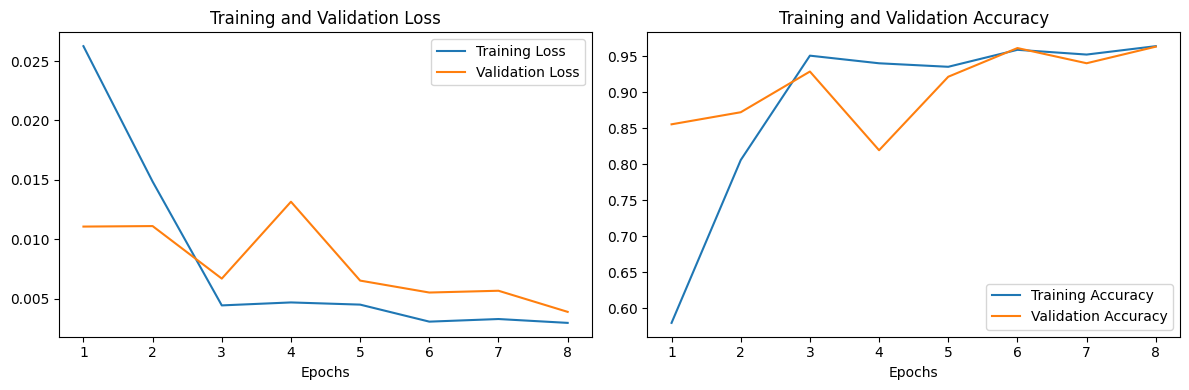

In [ ]:
# Create a TrainCurvePlotter for your saved training history
plotter = TrainCurvePlotter('training_history_model2.pkl')

# Load the training history
plotter.load_training_history()

# Plot the training curves
plotter.plot()

**<font size="4">Load Saved Model</font>**

In [ ]:
# Set path to saved model checkpoint
model_path = 'vgg11bn.pth'

# Initialize model
model_2 = VGG11WithBN(weights='VGG11_BN_Weights').to(device)

# Load the model
model_2.load_state_dict(torch.load(model_path))

<All keys matched successfully>

**<font size="4">Model 2 Evaluation</font>**

In [ ]:
# Instantiate ModelEvaluator
evaluator = ModelEvaluator(model_2, test_loader, device)

# Get test accuracy
test_accuracy = evaluator.evaluate()

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Test Accuracy: 93.68%


**<font size="4">Make Predictions</font>**

In [ ]:
# Instantiate ModelPredictor
predictor = ModelPredictor(model_2, test_loader, device)

# Predict the class labels of all the images test loader
predictions, true_labels = predictor.predict()

# Print the accuracy of the model on the test dataset
accuracy = (predictions == true_labels).mean()
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 93.68%


In [ ]:
# Get a random batch from the test loader
random_batch = random.choice(test_loader.dataset)

# Extract the image and label from the random batch
image, label = random_batch

# Add a batch dimension to the image
image = image.unsqueeze(0).to(device)  # Add a batch dimension

# Make predictions for the random image
outputs = model_2(image)

# Get the predicted class label
predicted_class_label = outputs[0].argmax().item()

# Get the class name corresponding to the predicted and true labels
predicted_class_name = classes[predicted_class_label]
true_class_name = classes[label]

# Display results
print(f"Predicted class label: {predicted_class_label}")
print(f"Predicted class name: {predicted_class_name}")
print(f"True class label: {label}")
print(f"True class name: {true_class_name}")

Predicted class label: 3
Predicted class name: pituitary_tumor
True class label: 3
True class name: pituitary_tumor


In [ ]:
# Get a random batch from the test loader
random_batch = random.choice(test_loader.dataset)

# Extract the image and label from the random batch
image, label = random_batch

# Add a batch dimension to the image
image = image.unsqueeze(0).to(device)  # Add a batch dimension

# Make predictions for the random image
outputs = model_2(image)

# Get the predicted class label
predicted_class_label = outputs[0].argmax().item()

# Get the class name corresponding to the predicted and true labels
predicted_class_name = classes[predicted_class_label]
true_class_name = classes[label]

# Display results
print(f"Predicted class label: {predicted_class_label}")
print(f"Predicted class name: {predicted_class_name}")
print(f"True class label: {label}")
print(f"True class name: {true_class_name}")

Predicted class label: 2
Predicted class name: normal
True class label: 2
True class name: normal


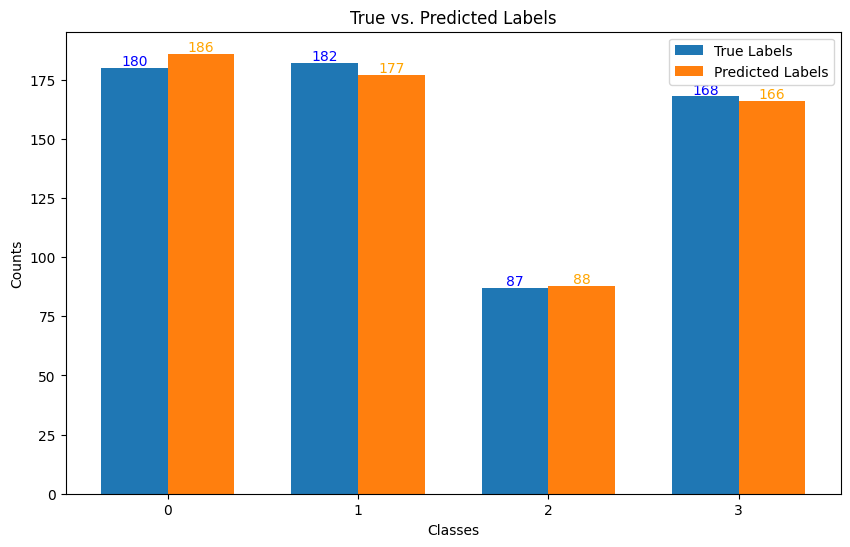

In [ ]:
# Plot the predictions vs. true labels
predictor.plot_predictions()

**<font size="4">Getting Model Performance</font>**

In [ ]:
# Instantiate performance metrics
metrics = PerformanceMetrics(true_labels, predictions, classes)

# Calculate accuracy
accuracy = metrics.calculate_accuracy()
print(f"Accuracy: {accuracy:.2f}%, \n")

# Calculate specificity
specificity = metrics.calculate_specificity()
print(f"Specificity: {specificity:.2f}%, \n")

# Calculate sensitivity
sensitivity = metrics.calculate_sensitivity()
print(f"Sensitivity: {sensitivity:.2f}%, \n")

# Calculate precision
precision = metrics.calculate_precision()
print(f"Precision: {precision:.2f}%, \n")

print("*" * 100)

# Display classification report
report = metrics.generate_classification_report()
print(report)

Accuracy: 93.68%, 

Specificity: 96.05%, 

Sensitivity: 92.09%, 

Precision: 95.88%, 

****************************************************************************************************
                  precision    recall  f1-score   support

    glioma_tumor       0.91      0.94      0.93       180
meningioma_tumor       0.92      0.90      0.91       182
          normal       0.97      0.98      0.97        87
 pituitary_tumor       0.96      0.95      0.96       168

        accuracy                           0.94       617
       macro avg       0.94      0.94      0.94       617
    weighted avg       0.94      0.94      0.94       617



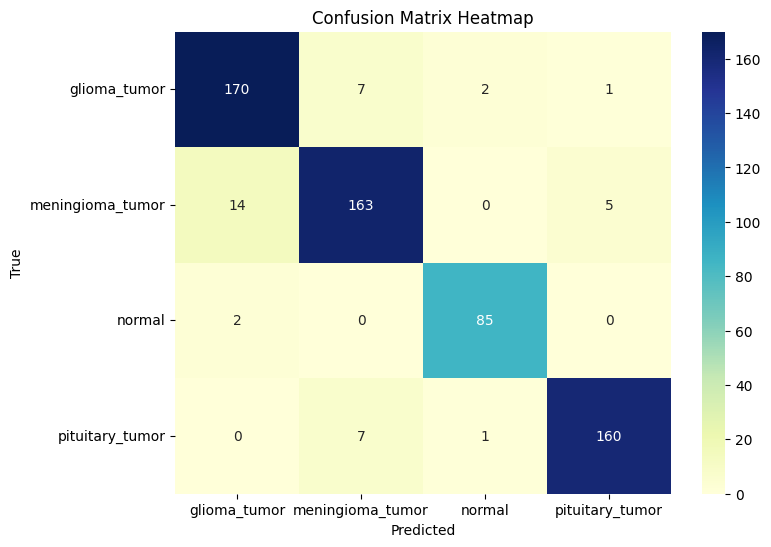

In [ ]:
# Display heatmap
metrics.plot_heatmap()

**<font size="4">Store Results</font>**

In [ ]:
# Store the results of model 2
model_2_results = {
    "Accuracy": accuracy,
    "Specificity": specificity,
    "Sensitivity": sensitivity,
    "Precision": precision,
    "Classification Report": classification_report
}

# Add baseline results to the dictionary
model_results["Model Two"] = model_2_results

## **Model 3 - Tuned ResNet50: Same Archictecture, Different LR**

**<font size="4">Training the Model</font>**

In [ ]:
# Set model parameters
model_params = {
    'freeze_layers': False,
    'weights': 'ResNet50_Weights'
}

# Define hyperparameters
num_epochs = 50
learning_rate = 0.00006
patience = 10

# Initialize model with updated hyperparameters
model_3 = ResNet50(**model_params)

# Define loss function
criterion = nn.CrossEntropyLoss(weight=torch.Tensor(class_weights)).to(device)

# Define optimizer
optimizer = optim.Adam(model_3.parameters(), lr=learning_rate)

# Instantiate Trainer with the updated model and optimizer
trainer = Trainer(
    model=model_3,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    patience=patience,
    model_name='resnet50_tuned',
    verbose=True
)

# Train the model with the updated hyperparameters
trainer.train()

Epoch [1/50], Batch [68/68], Training Loss: 0.0149, Training Accuracy: 79.17%: 100%|██████████| 68/68 [00:34<00:00,  1.97it/s]
Epoch [1/50], Batch [10/10], Validation Loss: 0.0099, Validation Accuracy: 88.54%: 100%|██████████| 10/10 [00:01<00:00,  6.54it/s]
Epoch [2/50], Batch [68/68], Training Loss: 0.0117, Training Accuracy: 85.27%: 100%|██████████| 68/68 [00:33<00:00,  2.00it/s]
Epoch [2/50], Batch [10/10], Validation Loss: 0.0158, Validation Accuracy: 84.39%: 100%|██████████| 10/10 [00:01<00:00,  6.35it/s]
Epoch [3/50], Batch [68/68], Training Loss: 0.0065, Training Accuracy: 91.50%: 100%|██████████| 68/68 [00:33<00:00,  2.01it/s]
Epoch [3/50], Batch [10/10], Validation Loss: 0.0075, Validation Accuracy: 94.27%: 100%|██████████| 10/10 [00:01<00:00,  6.56it/s]
Epoch [4/50], Batch [68/68], Training Loss: 0.0034, Training Accuracy: 95.66%: 100%|██████████| 68/68 [00:33<00:00,  2.02it/s]
Epoch [4/50], Batch [10/10], Validation Loss: 0.0062, Validation Accuracy: 95.54%: 100%|██████████|

Early stopping triggered. No improvement for 10 epochs.

Training completed!
Training took 0 hours, 8 minutes, 15 seconds

Model saved at resnet50_tuned.pth


In [ ]:
# Get link to download saved model
file_dir = 'resnet50_tuned.pth'
file_link = FileLink(file_dir)
file_link

/kaggle/working/resnet50_tuned.pth

In [ ]:
# Save training history for trainer 4
history4 = {
    'train_loss_history': trainer.train_loss_history,
    'val_loss_history': trainer.val_loss_history,
    'train_acc_history': trainer.train_acc_history,
    'val_acc_history': trainer.val_acc_history,
}
save_training_history(history4, 'training_history_model3.pkl')

**<font size="4">Plot Training Curves</font>**

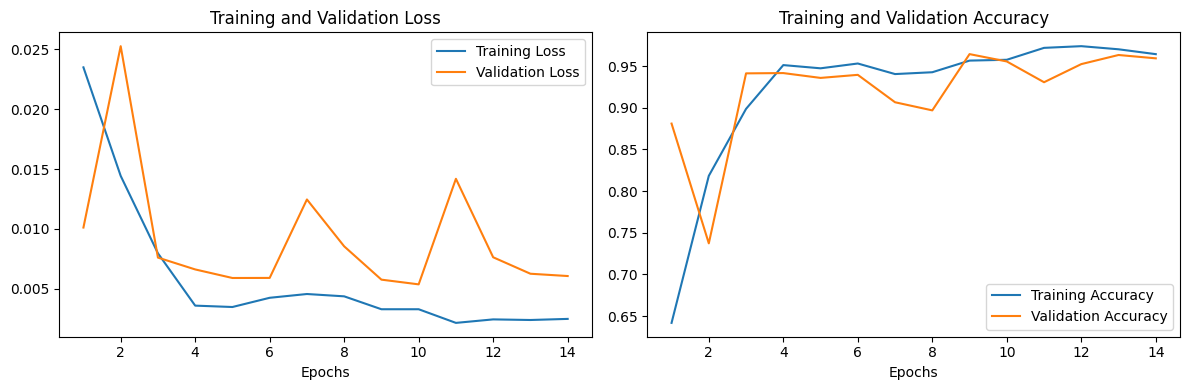

In [ ]:
# Instantiate TrainCurvePlotter with saved training history
plotter = TrainCurvePlotter('training_history_model3.pkl')

# Load training history
plotter.load_training_history()

# Plot training curves
plotter.plot()

**<font size="4">Load Saved Model</font>**

In [ ]:
# Set path to saved model checkpoint
model_path = 'resnet50_tuned.pth'

# Initialize model
model_3 = ResNet50(weights='ResNet50_Weights').to(device)

# Load the model
model_3.load_state_dict(torch.load(model_path))

<All keys matched successfully>

**<font size="4">Model 3 Evaluation</font>**

In [ ]:
# Instantiate ModelEvaluator
evaluator = ModelEvaluator(model_3, test_loader, device)

# Get test accuracy
test_accuracy = evaluator.evaluate()

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Test Accuracy: 95.62%


**<font size="4">Make Predictions</font>**

In [ ]:
# Instantiate ModelPredictor
predictor = ModelPredictor(model_3, test_loader, device)

# Predict the class labels of all the images test loader
predictions, true_labels = predictor.predict()

# Print the accuracy of the model on the test dataset
accuracy = (predictions == true_labels).mean()
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 95.62%


In [ ]:
# Get a random batch from the test loader
random_batch = random.choice(test_loader.dataset)

# Extract the image and label from the random batch
image, label = random_batch

# Add a batch dimension to the image
image = image.unsqueeze(0).to(device)  # Add a batch dimension

# Make predictions for the random image
outputs = model_3(image)

# Get the predicted class label
predicted_class_label = outputs[0].argmax().item()

# Get the class name corresponding to the predicted and true labels
predicted_class_name = classes[predicted_class_label]
true_class_name = classes[label]

# Display results
print(f"Predicted class label: {predicted_class_label}")
print(f"Predicted class name: {predicted_class_name}")
print(f"True class label: {label}")
print(f"True class name: {true_class_name}")

Predicted class label: 3
Predicted class name: pituitary_tumor
True class label: 3
True class name: pituitary_tumor


In [ ]:
# Get a random batch from the test loader
random_batch = random.choice(test_loader.dataset)

# Extract the image and label from the random batch
image, label = random_batch

# Add a batch dimension to the image
image = image.unsqueeze(0).to(device)  # Add a batch dimension

# Make predictions for the random image
outputs = model_3(image)

# Get the predicted class label
predicted_class_label = outputs[0].argmax().item()

# Get the class name corresponding to the predicted and true labels
predicted_class_name = classes[predicted_class_label]
true_class_name = classes[label]

# Display results
print(f"Predicted class label: {predicted_class_label}")
print(f"Predicted class name: {predicted_class_name}")
print(f"True class label: {label}")
print(f"True class name: {true_class_name}")

Predicted class label: 1
Predicted class name: meningioma_tumor
True class label: 1
True class name: meningioma_tumor


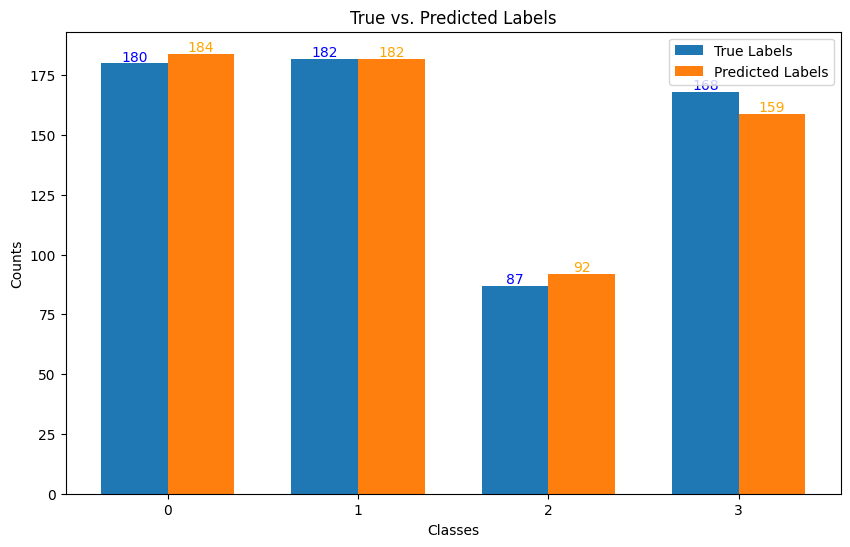

In [ ]:
# Plot the predictions vs. true labels
predictor.plot_predictions()

**<font size="4">Getting Model Performance</font>**

In [ ]:
# Instantiate performance metrics
metrics = PerformanceMetrics(true_labels, predictions, classes)

# Calculate accuracy
accuracy = metrics.calculate_accuracy()
print(f"Accuracy: {accuracy:.2f}%, \n")

# Calculate specificity
specificity = metrics.calculate_specificity()
print(f"Specificity: {specificity:.2f}%, \n")

# Calculate sensitivity
sensitivity = metrics.calculate_sensitivity()
print(f"Sensitivity: {sensitivity:.2f}%, \n")

# Calculate precision
precision = metrics.calculate_precision()
print(f"Precision: {precision:.2f}%, \n")

print("*" * 100)

# Display classification report
report = metrics.generate_classification_report()
print(report)

Accuracy: 95.62%, 

Specificity: 96.61%, 

Sensitivity: 96.13%, 

Precision: 96.67%, 

****************************************************************************************************
                  precision    recall  f1-score   support

    glioma_tumor       0.93      0.95      0.94       180
meningioma_tumor       0.96      0.96      0.96       182
          normal       0.95      1.00      0.97        87
 pituitary_tumor       0.99      0.94      0.97       168

        accuracy                           0.96       617
       macro avg       0.96      0.96      0.96       617
    weighted avg       0.96      0.96      0.96       617



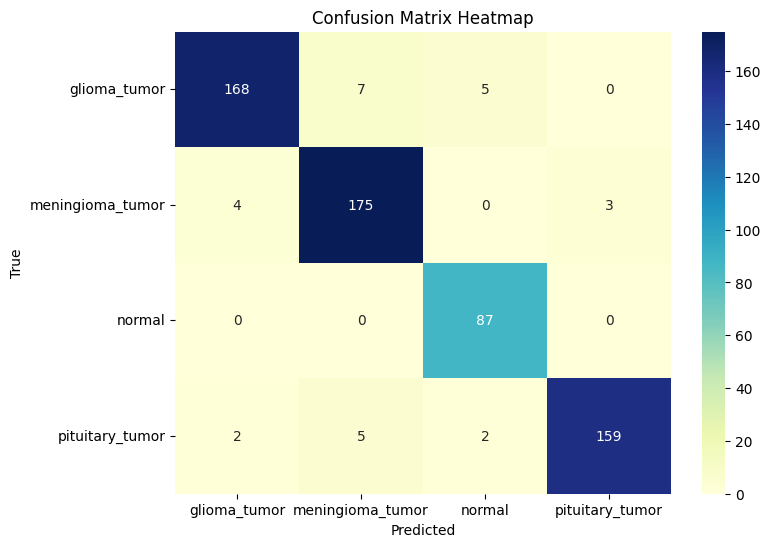

In [ ]:
# Display heatmap
metrics.plot_heatmap()

**<font size="4">Store Results</font>**

In [ ]:
# Load the model_results dictionary from the file
with open('/kaggle/input/modelresults/model_results (2).pkl', 'rb') as file:
    model_results = pickle.load(file)

In [ ]:
# Store the results of model 1
model_3_results = {
    "Accuracy": accuracy,
    "Specificity": specificity,
    "Sensitivity": sensitivity,
    "Precision": precision,
    "Classification Report": classification_report
}

# Add baseline results to the dictionary
model_results["Model Three"] = model_3_results

In [ ]:
# Remove the 'Classification Report' entry from each model's results
model_results = {model: {key: value for key, value in results.items() if key != 'Classification Report'} for model, results in model_results.items()}

In [ ]:
# Display results
model_results

{'Baseline Model': {'Accuracy': 83.63047001620745,
  'Specificity': 83.73493975903614,
  'Sensitivity': 96.81528662420382,
  'Precision': 84.91620111731844},
 'Model One': {'Accuracy': 95.13776337115073,
  'Specificity': 97.76536312849163,
  'Sensitivity': 93.67816091954023,
  'Precision': 97.60479041916167},
 'Model Two': {'Accuracy': 93.67909238249594,
  'Specificity': 96.045197740113,
  'Sensitivity': 92.09039548022598,
  'Precision': 95.88235294117648},
 'Model Three': {'Accuracy': 95.62398703403565,
  'Specificity': 96.61016949152543,
  'Sensitivity': 96.13259668508287,
  'Precision': 96.66666666666667}}

In [4]:
model_results = {
    'Baseline Model': {'Accuracy': 83.63047001620745,
                       'Specificity': 83.73493975903614,
                       'Sensitivity': 96.81528662420382,
                       'Precision': 84.91620111731844},
    'Model One': {'Accuracy': 95.13776337115073,
                    'Specificity': 97.76536312849163,
                    'Sensitivity': 93.67816091954023,
                    'Precision': 97.60479041916167},
    'Model Two': {'Accuracy': 93.67909238249594,
                    'Specificity': 96.045197740113,
                    'Sensitivity': 92.09039548022598,
                    'Precision': 95.88235294117648},
    'Model Three': {'Accuracy': 95.62398703403565,
                     'Specificity': 96.61016949152543,
                     'Sensitivity': 96.13259668508287,
                     'Precision': 96.66666666666667}}

In [ ]:
# Save the model_results dictionary to a file
with open('model_results.pkl', 'wb') as file:
    pickle.dump(model_results, file)

# **Models Comparison**

In [3]:
class ModelComparison:
    def __init__(self, model_results):
        self.model_results = model_results

    def plot_metric(self, metric_name, plot_title):
        data = []
        for model, metrics in self.model_results.items():
            data.append({'Model': model, metric_name: metrics[metric_name]})

        df = pd.DataFrame(data)

        # Find the model with the best score for the metric
        best_model = df[df[metric_name] == df[metric_name].max()]['Model'].values[0]
        print(f"Best model for {metric_name}: {best_model} ({df[metric_name].max()}%)")

        fig = px.bar(df, x='Model', y=metric_name, title=plot_title)
        fig.show()

    def plot_accuracy(self):
        self.plot_metric('Accuracy', 'Model Accuracy Comparison')

    def plot_specificity(self):
        self.plot_metric('Specificity', 'Model Specificity Comparison')

    def plot_sensitivity(self):
        self.plot_metric('Sensitivity', 'Model Sensitivity Comparison')

    def plot_precision(self):
        self.plot_metric('Precision', 'Model Precision Comparison')

In [5]:
model_results = model_results

model_comparison = ModelComparison(model_results)

**<font size="4" color="blue">Accuracy</font>**

In [7]:
# Plot accuracy
model_comparison.plot_accuracy()

Best model for Accuracy: Model Three (95.62398703403565%)


**<font size="4" color="blue">Specificity</font>**

In [8]:
model_comparison.plot_specificity()

Best model for Specificity: Model One (97.76536312849163%)


**<font size="4" color="blue">Sensitivity</font>**

In [9]:
model_comparison.plot_sensitivity()

Best model for Sensitivity: Baseline Model (96.81528662420382%)


**<font size="4" color="blue">Precision</font>**

In [10]:
model_comparison.plot_precision()

Best model for Precision: Model One (97.60479041916167%)


**<font size="4" color="blue">Classification Report</font>**

In [ ]:
# Create a dictionary with the classification report data
classification_reports = {
    'baseline_model': {
        'glioma_tumor': {'precision': 0.95, 'recall': 0.77, 'f1-score': 0.85},
        'meningioma_tumor': {'precision': 0.75, 'recall': 0.84, 'f1-score': 0.79},
        'normal': {'precision': 0.78, 'recall': 0.90, 'f1-score': 0.83},
        'pituitary_tumor': {'precision': 0.88, 'recall': 0.88, 'f1-score': 0.88},
    },
    'model_1': {
        'glioma_tumor': {'precision': 0.94, 'recall': 0.97, 'f1-score': 0.95},
        'meningioma_tumor': {'precision': 0.96, 'recall': 0.90, 'f1-score': 0.93},
        'normal': {'precision': 0.99, 'recall': 0.95, 'f1-score': 0.97},
        'pituitary_tumor': {'precision': 0.94, 'recall': 0.99, 'f1-score': 0.97},
    },
    'model_2': {
        'glioma_tumor': {'precision': 0.91, 'recall': 0.94, 'f1-score': 0.93},
        'meningioma_tumor': {'precision': 0.92, 'recall': 0.90, 'f1-score': 0.91},
        'normal': {'precision': 0.97, 'recall': 0.98, 'f1-score': 0.97},
        'pituitary_tumor': {'precision': 0.96, 'recall': 0.95, 'f1-score': 0.96},
    },
    'model_3': {
        'glioma_tumor': {'precision': 0.93, 'recall': 0.95, 'f1-score': 0.94},
        'meningioma_tumor': {'precision': 0.96, 'recall': 0.96, 'f1-score': 0.96},
        'normal': {'precision': 0.95, 'recall': 1.00, 'f1-score': 0.97},
        'pituitary_tumor': {'precision': 0.99, 'recall': 0.94, 'f1-score': 0.97},
    }
}


In [ ]:
# Create a summary table
summary_table = pd.DataFrame()

for model, class_metrics in classification_reports.items():
    for class_name, metrics in class_metrics.items():
        summary_table.at[model, f'{class_name}_precision'] = metrics['precision']
        summary_table.at[model, f'{class_name}_recall'] = metrics['recall']
        summary_table.at[model, f'{class_name}_f1-score'] = metrics['f1-score']

# Display summary table
summary_table

,glioma_tumor_precision,glioma_tumor_recall,glioma_tumor_f1-score,meningioma_tumor_precision,meningioma_tumor_recall,meningioma_tumor_f1-score,normal_precision,normal_recall,normal_f1-score,pituitary_tumor_precision,pituitary_tumor_recall,pituitary_tumor_f1-score
baseline_model,0.95,0.77,0.85,0.75,0.84,0.79,0.78,0.90,0.83,0.88,0.88,0.88
model_1,0.94,0.97,0.95,0.96,0.90,0.93,0.99,0.95,0.97,0.94,0.99,0.97
model_2,0.91,0.94,0.93,0.92,0.90,0.91,0.97,0.98,0.97,0.96,0.95,0.96
model_3,0.93,0.95,0.94,0.96,0.96,0.96,0.95,1.00,0.97,0.99,0.94,0.97


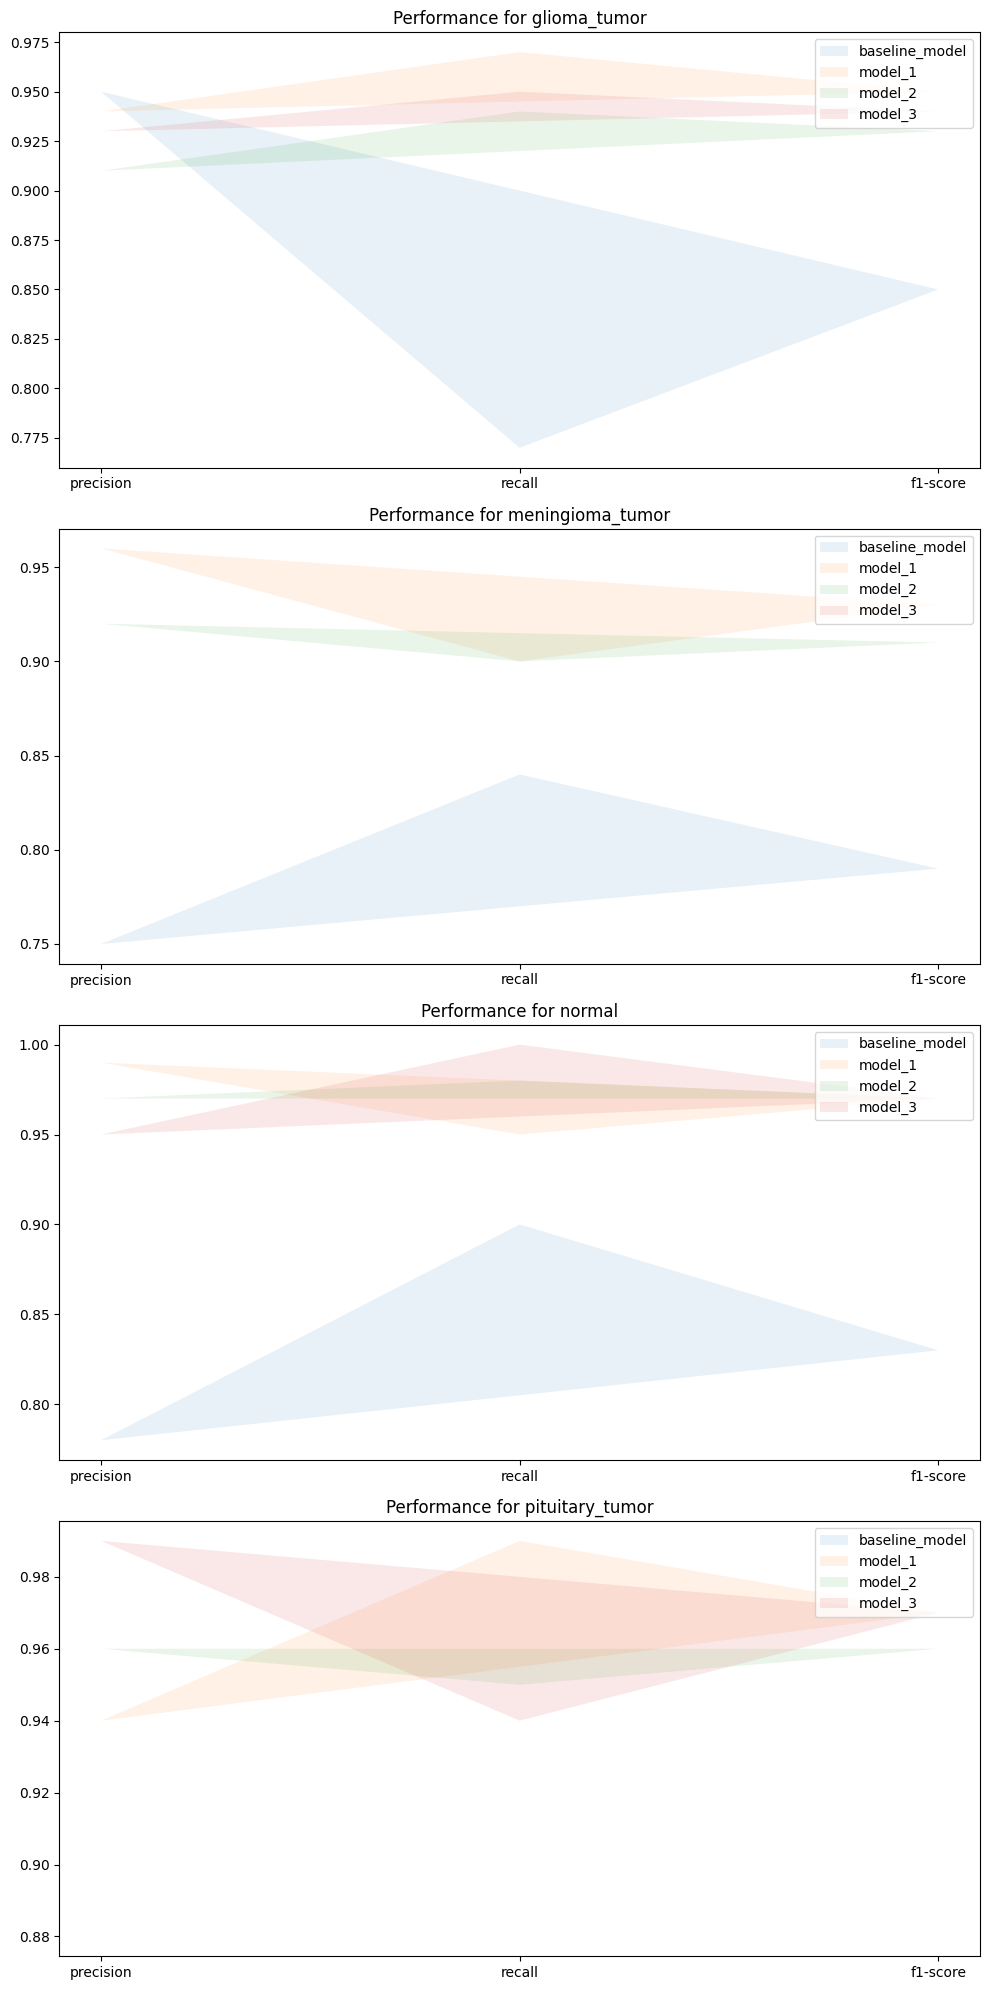

In [ ]:
# Define the models and their metrics
models = ['baseline_model', 'model_1', 'model_2', 'model_3']
classes = ['glioma_tumor', 'meningioma_tumor', 'normal', 'pituitary_tumor']
metrics = ['precision', 'recall', 'f1-score']

# Create a figure with subplots for each class
fig, axes = plt.subplots(nrows=len(classes), ncols=1, figsize=(10, 20))

for i, class_name in enumerate(classes):
    ax = axes[i]

    # Create an array to hold the metric values for each model
    model_metrics = []
    for model in models:
        model_metrics.append([classification_reports[model][class_name][metric] for metric in metrics])

    # Number of metrics
    num_metrics = len(metrics)

    # Compute angle for each metric
    angles = np.linspace(0, 2 * np.pi, num_metrics, endpoint=False).tolist()
    angles += angles[:1]

    # Plot the spider plot for the current class
    for j, model in enumerate(models):
        ax.fill(angles, model_metrics[j] + [model_metrics[j][0]], alpha=0.1, label=model)

    # Set labels for each metric
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics)

    # Set the title for the current subplot
    ax.set_title(f'Performance for {class_name}')

    # Add a legend to the plot
    ax.legend(loc='upper right')

# Adjust subplot layout
plt.tight_layout()

# Show the spider plots
plt.show()


# **Model Deployment**

<font size="4>The brain tumor classification model has been successfully deployed using FastAPI. The deployed model is accessible via a web interface.

**Key Highlights:**

* The model is designed for real-time brain tumor classification.
* It achieves an accuracy of 95.14% and demonstrates high specificity, sensitivity, and precision.
* Ethical concerns have been addressed, and the model is intended for research and educational purposes only.

**How to Access the Model:**

* Click on the following link to access the deployed model:
<a href="http://127.0.0.1:8000">Brain Tumor Classification Web App</a>

* Upload an image for brain tumor classification.

* The model will provide classification results, including class label, class name, and confidence.

**Note:** The FastAPI web app must be running locally to access the model via the provided link. Others will require the code and a local environment to run the app themselves.</font>

# **Summary of Analysis**

<font size="4">The analysis assessed various models for classifying MRI brain scans into four categories: normal, glioma, meningioma, and pituitary tumors. The primary objective was to develop a classifier that ensures precise identification of these brain tumor types while also minimizing false positives in medical diagnostics.

Four models were analyzed using key metrics, including accuracy, specificity, sensitivity, precision, and F1-score. The findings are as follows:

**Model 1** emerged as the top performer with an accuracy of 95.14%, exceptional specificity (97.77%), strong sensitivity (93.68%), and impressive precision (97.60%).

**Model 3** closely followed with an accuracy of 95.62%, balanced specificity (96.61%), robust sensitivity (96.13%), and high precision (96.67%).

**Model 2** achieved notable accuracy (93.68%), high specificity (96.05%), strong sensitivity (96.13%), and precision (95.88%).

The **Baseline Model** displayed high sensitivity (96.82%) but had lower specificity (83.73%) and precision (84.92%).

**Model 1** was chosen as the preferred model due to its slightly superior specificity, precision, and sensitivity, which are pivotal in minimizing false positives and ensuring reliable diagnostic results. The research aims to advance medical diagnostics with deep learning models and provides recommendations for further enhancements in this context.

# **Recommendations**

* **<font size="4">Enhanced Model Training:** Consider extending the training duration and exploring more complex architectures, provided there are adequate computational resources. Prolonged training has the potential to improve accuracy, especially when building models from scratch.</font>

* **<font size="4>Incorporation of Additional Tumor Types:** To broaden the scope of brain tumor diagnostics, include additional tumor types beyond glioma, meningioma, and pituitary tumors. This comprehensive approach will enhance the applicability of medical diagnostics.</font>

* **<font size="4">Benign vs. Malignant Classification:** Given the critical importance of distinguishing between benign and malignant tumors in medical diagnosis, future research should encompass this classification to guide more precise and suitable treatment decisions.</font>

* **<font size="4">Larger and Diverse Datasets:** Expanding the dataset with a more extensive and diverse collection of MRI scans can better represent the entire spectrum of brain tumor cases. A larger dataset contributes to improved model generalization and performance.</font>

* **<font size="4">Exploration of Domain-Specific Models:** While transfer learning has shown effectiveness, there is potential to explore the development of domain-specific models tailored for the specific task of brain tumor classification.</font>

* **<font size="4">Resource Investment:** Enhance model training capabilities by investing in advanced computational resources. More powerful GPUs or dedicated hardware can expedite training and lead to higher accuracy.</font>

<font size="4">In conclusion, this research serves as a cornerstone for advanced medical diagnostics using deep learning models. The findings and recommendations provide a roadmap for future studies in the field of medical image classification, ultimately advancing patient care and healthcare efficiency. The overarching goal is to develop models that prioritize patient safety by minimizing false diagnoses in medical diagnostics while maintaining high accuracy.</font>

# **References**

Dubail, T. (2023). Brain Tumors (256x256) [Data set]. Kaggle. https://www.kaggle.com/datasets/thomasdubail/brain-tumors-256x256